In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from tqdm import tqdm
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Load Dataset
image_dir = "celebA/celeba/img_align_celeba"
os.makedirs("test", exist_ok=True)
os.makedirs("gan_outputs", exist_ok=True)

transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=image_dir, transform=transform)
dataset_size = len(dataset)
indices = list(range(dataset_size))
random.seed(42)
random.shuffle(indices)
split = int(0.1 * dataset_size)
val_indices, train_indices = indices[:split], indices[split:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/sciclone/data10/iahewababarand/genVision-celebA/gen-env/lib64/python3.11/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Define Models
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 8, features_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 4, features_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g * 2, features_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g),
            nn.ReLU(True),
            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d, features_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 2, features_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 4, features_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.net(img).view(-1)

In [5]:
# Hyperparameters
z_dim = 100
lr = 2e-4
n_epochs = 50
early_stop_patience = 6

In [6]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

In [7]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

In [8]:
train_g_losses = []
val_g_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0

# Training Loop
for epoch in range(n_epochs):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    num_batches = 0

    G.train()
    for real_imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_imgs = G(z)

        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        output_real = D(real_imgs)
        output_fake = D(fake_imgs.detach())
        loss_D = criterion(output_real, real_labels) + criterion(output_fake, fake_labels)

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        output_fake = D(fake_imgs)
        loss_G = criterion(output_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        g_loss_epoch += loss_G.item()
        d_loss_epoch += loss_D.item()
        num_batches += 1

    # Validation step
    G.eval()
    val_loss = 0.0
    with torch.no_grad():
        for real_imgs, _ in val_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_imgs = G(z)
            output_fake = D(fake_imgs)
            loss = criterion(output_fake, torch.ones(batch_size, device=device))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    avg_g_loss = g_loss_epoch / num_batches

    train_g_losses.append(avg_g_loss)
    val_g_losses.append(val_loss)

    with torch.no_grad():
        samples = G(fixed_noise)
        save_image(samples, f"gan_outputs/epoch_{epoch+1:03d}.png", normalize=True)

    print(f"Epoch [{epoch+1}/{n_epochs}]  Loss_D: {d_loss_epoch/num_batches:.4f}  Loss_G: {avg_g_loss:.4f}  Val_Loss_G: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(G.state_dict(), "gan_outputs/best_generator.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered!")
            break

Epoch 1/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 1/2850 [00:01<52:51,  1.11s/it]

Epoch 1/50:   0%|          | 5/2850 [00:01<09:31,  4.98it/s]

Epoch 1/50:   0%|          | 8/2850 [00:01<05:48,  8.15it/s]

Epoch 1/50:   0%|          | 11/2850 [00:01<04:16, 11.05it/s]

Epoch 1/50:   0%|          | 14/2850 [00:01<03:39, 12.91it/s]

Epoch 1/50:   1%|          | 17/2850 [00:01<03:07, 15.15it/s]

Epoch 1/50:   1%|          | 20/2850 [00:02<03:20, 14.09it/s]

Epoch 1/50:   1%|          | 22/2850 [00:02<03:35, 13.09it/s]

Epoch 1/50:   1%|          | 24/2850 [00:02<03:21, 13.99it/s]

Epoch 1/50:   1%|          | 26/2850 [00:02<03:32, 13.28it/s]

Epoch 1/50:   1%|          | 29/2850 [00:02<03:01, 15.55it/s]

Epoch 1/50:   1%|          | 31/2850 [00:02<03:35, 13.11it/s]

Epoch 1/50:   1%|          | 34/2850 [00:03<03:29, 13.43it/s]

Epoch 1/50:   1%|▏         | 36/2850 [00:03<03:13, 14.54it/s]

Epoch 1/50:   1%|▏         | 38/2850 [00:03<03:29, 13.40it/s]

Epoch 1/50:   1%|▏         | 40/2850 [00:03<03:12, 14.56it/s]

Epoch 1/50:   1%|▏         | 42/2850 [00:03<03:28, 13.46it/s]

Epoch 1/50:   2%|▏         | 44/2850 [00:03<03:09, 14.83it/s]

Epoch 1/50:   2%|▏         | 46/2850 [00:03<03:27, 13.53it/s]

Epoch 1/50:   2%|▏         | 48/2850 [00:04<03:10, 14.72it/s]

Epoch 1/50:   2%|▏         | 50/2850 [00:04<03:26, 13.54it/s]

Epoch 1/50:   2%|▏         | 52/2850 [00:04<03:08, 14.83it/s]

Epoch 1/50:   2%|▏         | 54/2850 [00:04<03:28, 13.44it/s]

Epoch 1/50:   2%|▏         | 56/2850 [00:04<03:08, 14.79it/s]

Epoch 1/50:   2%|▏         | 58/2850 [00:04<03:30, 13.24it/s]

Epoch 1/50:   2%|▏         | 60/2850 [00:04<03:09, 14.70it/s]

Epoch 1/50:   2%|▏         | 62/2850 [00:05<03:27, 13.41it/s]

Epoch 1/50:   2%|▏         | 64/2850 [00:05<03:17, 14.12it/s]

Epoch 1/50:   2%|▏         | 66/2850 [00:05<03:23, 13.69it/s]

Epoch 1/50:   2%|▏         | 68/2850 [00:05<03:08, 14.77it/s]

Epoch 1/50:   2%|▏         | 70/2850 [00:05<03:25, 13.50it/s]

Epoch 1/50:   3%|▎         | 72/2850 [00:05<03:12, 14.45it/s]

Epoch 1/50:   3%|▎         | 74/2850 [00:05<03:22, 13.74it/s]

Epoch 1/50:   3%|▎         | 76/2850 [00:06<03:07, 14.81it/s]

Epoch 1/50:   3%|▎         | 78/2850 [00:06<03:06, 14.86it/s]

Epoch 1/50:   3%|▎         | 80/2850 [00:06<02:58, 15.51it/s]

Epoch 1/50:   3%|▎         | 82/2850 [00:06<02:58, 15.55it/s]

Epoch 1/50:   3%|▎         | 84/2850 [00:06<02:47, 16.52it/s]

Epoch 1/50:   3%|▎         | 86/2850 [00:06<02:54, 15.81it/s]

Epoch 1/50:   3%|▎         | 88/2850 [00:06<02:46, 16.59it/s]

Epoch 1/50:   3%|▎         | 90/2850 [00:06<02:53, 15.88it/s]

Epoch 1/50:   3%|▎         | 92/2850 [00:07<02:45, 16.63it/s]

Epoch 1/50:   3%|▎         | 94/2850 [00:07<02:53, 15.92it/s]

Epoch 1/50:   3%|▎         | 96/2850 [00:07<02:57, 15.50it/s]

Epoch 1/50:   3%|▎         | 98/2850 [00:07<02:49, 16.27it/s]

Epoch 1/50:   4%|▎         | 100/2850 [00:07<02:55, 15.71it/s]

Epoch 1/50:   4%|▎         | 102/2850 [00:07<02:48, 16.28it/s]

Epoch 1/50:   4%|▎         | 104/2850 [00:07<02:46, 16.52it/s]

Epoch 1/50:   4%|▎         | 106/2850 [00:07<02:50, 16.06it/s]

Epoch 1/50:   4%|▍         | 108/2850 [00:08<02:43, 16.72it/s]

Epoch 1/50:   4%|▍         | 110/2850 [00:08<02:47, 16.36it/s]

Epoch 1/50:   4%|▍         | 112/2850 [00:08<02:45, 16.57it/s]

Epoch 1/50:   4%|▍         | 114/2850 [00:08<02:48, 16.24it/s]

Epoch 1/50:   4%|▍         | 116/2850 [00:08<02:47, 16.37it/s]

Epoch 1/50:   4%|▍         | 118/2850 [00:08<02:51, 15.97it/s]

Epoch 1/50:   4%|▍         | 120/2850 [00:08<02:43, 16.69it/s]

Epoch 1/50:   4%|▍         | 122/2850 [00:08<02:48, 16.18it/s]

Epoch 1/50:   4%|▍         | 124/2850 [00:08<02:43, 16.66it/s]

Epoch 1/50:   4%|▍         | 126/2850 [00:09<02:53, 15.67it/s]

Epoch 1/50:   4%|▍         | 128/2850 [00:09<02:44, 16.50it/s]

Epoch 1/50:   5%|▍         | 130/2850 [00:09<02:55, 15.49it/s]

Epoch 1/50:   5%|▍         | 133/2850 [00:09<02:33, 17.65it/s]

Epoch 1/50:   5%|▍         | 135/2850 [00:09<03:03, 14.79it/s]

Epoch 1/50:   5%|▍         | 138/2850 [00:09<02:54, 15.53it/s]

Epoch 1/50:   5%|▍         | 141/2850 [00:10<02:30, 17.98it/s]

Epoch 1/50:   5%|▌         | 143/2850 [00:10<02:58, 15.16it/s]

Epoch 1/50:   5%|▌         | 146/2850 [00:10<02:51, 15.79it/s]

Epoch 1/50:   5%|▌         | 149/2850 [00:10<02:31, 17.84it/s]

Epoch 1/50:   5%|▌         | 151/2850 [00:10<02:56, 15.25it/s]

Epoch 1/50:   5%|▌         | 154/2850 [00:10<02:46, 16.20it/s]

Epoch 1/50:   5%|▌         | 156/2850 [00:10<02:43, 16.47it/s]

Epoch 1/50:   6%|▌         | 158/2850 [00:11<02:45, 16.30it/s]

Epoch 1/50:   6%|▌         | 160/2850 [00:11<02:42, 16.58it/s]

Epoch 1/50:   6%|▌         | 162/2850 [00:11<02:47, 16.04it/s]

Epoch 1/50:   6%|▌         | 164/2850 [00:11<02:45, 16.22it/s]

Epoch 1/50:   6%|▌         | 166/2850 [00:11<02:43, 16.45it/s]

Epoch 1/50:   6%|▌         | 168/2850 [00:11<02:44, 16.30it/s]

Epoch 1/50:   6%|▌         | 170/2850 [00:11<02:41, 16.64it/s]

Epoch 1/50:   6%|▌         | 172/2850 [00:11<02:47, 15.98it/s]

Epoch 1/50:   6%|▌         | 174/2850 [00:12<02:41, 16.60it/s]

Epoch 1/50:   6%|▌         | 176/2850 [00:12<02:47, 15.99it/s]

Epoch 1/50:   6%|▌         | 178/2850 [00:12<02:37, 16.92it/s]

Epoch 1/50:   6%|▋         | 180/2850 [00:12<02:47, 15.94it/s]

Epoch 1/50:   6%|▋         | 183/2850 [00:12<02:55, 15.16it/s]

Epoch 1/50:   7%|▋         | 186/2850 [00:12<02:27, 18.01it/s]

Epoch 1/50:   7%|▋         | 188/2850 [00:12<02:42, 16.38it/s]

Epoch 1/50:   7%|▋         | 191/2850 [00:13<02:52, 15.45it/s]

Epoch 1/50:   7%|▋         | 194/2850 [00:13<02:31, 17.48it/s]

Epoch 1/50:   7%|▋         | 196/2850 [00:13<02:39, 16.68it/s]

Epoch 1/50:   7%|▋         | 199/2850 [00:13<02:50, 15.57it/s]

Epoch 1/50:   7%|▋         | 202/2850 [00:13<02:29, 17.67it/s]

Epoch 1/50:   7%|▋         | 204/2850 [00:13<02:41, 16.34it/s]

Epoch 1/50:   7%|▋         | 206/2850 [00:14<02:38, 16.70it/s]

Epoch 1/50:   7%|▋         | 208/2850 [00:14<02:50, 15.52it/s]

Epoch 1/50:   7%|▋         | 211/2850 [00:14<02:55, 15.03it/s]

Epoch 1/50:   8%|▊         | 214/2850 [00:14<02:29, 17.65it/s]

Epoch 1/50:   8%|▊         | 216/2850 [00:14<02:46, 15.81it/s]

Epoch 1/50:   8%|▊         | 219/2850 [00:14<02:52, 15.26it/s]

Epoch 1/50:   8%|▊         | 223/2850 [00:15<02:46, 15.81it/s]

Epoch 1/50:   8%|▊         | 226/2850 [00:15<02:23, 18.30it/s]

Epoch 1/50:   8%|▊         | 229/2850 [00:15<02:33, 17.06it/s]

Epoch 1/50:   8%|▊         | 231/2850 [00:15<02:47, 15.66it/s]

Epoch 1/50:   8%|▊         | 234/2850 [00:15<02:27, 17.74it/s]

Epoch 1/50:   8%|▊         | 236/2850 [00:15<02:39, 16.39it/s]

Epoch 1/50:   8%|▊         | 239/2850 [00:16<02:47, 15.61it/s]

Epoch 1/50:   8%|▊         | 242/2850 [00:16<02:22, 18.33it/s]

Epoch 1/50:   9%|▊         | 245/2850 [00:16<02:28, 17.49it/s]

Epoch 1/50:   9%|▊         | 247/2850 [00:16<02:45, 15.72it/s]

Epoch 1/50:   9%|▉         | 251/2850 [00:16<02:43, 15.94it/s]

Epoch 1/50:   9%|▉         | 254/2850 [00:16<02:24, 17.91it/s]

Epoch 1/50:   9%|▉         | 256/2850 [00:17<02:36, 16.55it/s]

Epoch 1/50:   9%|▉         | 259/2850 [00:17<02:44, 15.71it/s]

Epoch 1/50:   9%|▉         | 262/2850 [00:17<02:22, 18.10it/s]

Epoch 1/50:   9%|▉         | 264/2850 [00:17<02:33, 16.82it/s]

Epoch 1/50:   9%|▉         | 267/2850 [00:17<02:43, 15.78it/s]

Epoch 1/50:   9%|▉         | 270/2850 [00:17<02:19, 18.50it/s]

Epoch 1/50:  10%|▉         | 273/2850 [00:18<02:27, 17.52it/s]

Epoch 1/50:  10%|▉         | 275/2850 [00:18<02:44, 15.61it/s]

Epoch 1/50:  10%|▉         | 278/2850 [00:18<02:22, 18.08it/s]

Epoch 1/50:  10%|▉         | 280/2850 [00:18<02:36, 16.38it/s]

Epoch 1/50:  10%|▉         | 283/2850 [00:18<02:41, 15.90it/s]

Epoch 1/50:  10%|█         | 287/2850 [00:18<02:36, 16.34it/s]

Epoch 1/50:  10%|█         | 290/2850 [00:19<02:16, 18.81it/s]

Epoch 1/50:  10%|█         | 293/2850 [00:19<02:29, 17.07it/s]

Epoch 1/50:  10%|█         | 295/2850 [00:19<02:40, 15.90it/s]

Epoch 1/50:  10%|█         | 298/2850 [00:19<02:21, 18.05it/s]

Epoch 1/50:  11%|█         | 300/2850 [00:19<02:32, 16.77it/s]

Epoch 1/50:  11%|█         | 303/2850 [00:19<02:42, 15.66it/s]

Epoch 1/50:  11%|█         | 307/2850 [00:20<02:36, 16.26it/s]

Epoch 1/50:  11%|█         | 310/2850 [00:20<02:18, 18.30it/s]

Epoch 1/50:  11%|█         | 312/2850 [00:20<02:32, 16.62it/s]

Epoch 1/50:  11%|█         | 315/2850 [00:20<02:38, 15.99it/s]

Epoch 1/50:  11%|█         | 318/2850 [00:20<02:17, 18.44it/s]

Epoch 1/50:  11%|█         | 320/2850 [00:20<02:33, 16.50it/s]

Epoch 1/50:  11%|█▏        | 323/2850 [00:21<02:39, 15.82it/s]

Epoch 1/50:  11%|█▏        | 326/2850 [00:21<02:15, 18.59it/s]

Epoch 1/50:  12%|█▏        | 329/2850 [00:21<02:27, 17.06it/s]

Epoch 1/50:  12%|█▏        | 331/2850 [00:21<02:41, 15.57it/s]

Epoch 1/50:  12%|█▏        | 334/2850 [00:21<02:17, 18.26it/s]

Epoch 1/50:  12%|█▏        | 337/2850 [00:21<02:31, 16.59it/s]

Epoch 1/50:  12%|█▏        | 339/2850 [00:21<02:39, 15.74it/s]

Epoch 1/50:  12%|█▏        | 343/2850 [00:22<02:33, 16.29it/s]

Epoch 1/50:  12%|█▏        | 346/2850 [00:22<02:17, 18.24it/s]

Epoch 1/50:  12%|█▏        | 348/2850 [00:22<02:26, 17.02it/s]

Epoch 1/50:  12%|█▏        | 351/2850 [00:22<02:33, 16.25it/s]

Epoch 1/50:  12%|█▏        | 355/2850 [00:22<02:30, 16.58it/s]

Epoch 1/50:  13%|█▎        | 358/2850 [00:23<02:10, 19.02it/s]

Epoch 1/50:  13%|█▎        | 361/2850 [00:23<02:22, 17.41it/s]

Epoch 1/50:  13%|█▎        | 363/2850 [00:23<02:36, 15.93it/s]

Epoch 1/50:  13%|█▎        | 366/2850 [00:23<02:13, 18.62it/s]

Epoch 1/50:  13%|█▎        | 369/2850 [00:23<02:21, 17.55it/s]

Epoch 1/50:  13%|█▎        | 371/2850 [00:23<02:38, 15.64it/s]

Epoch 1/50:  13%|█▎        | 374/2850 [00:23<02:14, 18.39it/s]

Epoch 1/50:  13%|█▎        | 377/2850 [00:24<02:21, 17.50it/s]

Epoch 1/50:  13%|█▎        | 379/2850 [00:24<02:37, 15.70it/s]

Epoch 1/50:  13%|█▎        | 383/2850 [00:24<02:31, 16.29it/s]

Epoch 1/50:  14%|█▎        | 386/2850 [00:24<02:17, 17.98it/s]

Epoch 1/50:  14%|█▎        | 388/2850 [00:24<02:23, 17.10it/s]

Epoch 1/50:  14%|█▎        | 391/2850 [00:25<02:32, 16.10it/s]

Epoch 1/50:  14%|█▍        | 394/2850 [00:25<02:12, 18.52it/s]

Epoch 1/50:  14%|█▍        | 396/2850 [00:25<02:28, 16.55it/s]

Epoch 1/50:  14%|█▍        | 399/2850 [00:25<02:33, 15.93it/s]

Epoch 1/50:  14%|█▍        | 402/2850 [00:25<02:13, 18.35it/s]

Epoch 1/50:  14%|█▍        | 404/2850 [00:25<02:27, 16.61it/s]

Epoch 1/50:  14%|█▍        | 407/2850 [00:25<02:32, 16.04it/s]

Epoch 1/50:  14%|█▍        | 411/2850 [00:26<02:27, 16.50it/s]

Epoch 1/50:  15%|█▍        | 414/2850 [00:26<02:08, 19.00it/s]

Epoch 1/50:  15%|█▍        | 417/2850 [00:26<02:20, 17.33it/s]

Epoch 1/50:  15%|█▍        | 419/2850 [00:26<02:31, 16.01it/s]

Epoch 1/50:  15%|█▍        | 423/2850 [00:26<02:27, 16.46it/s]

Epoch 1/50:  15%|█▍        | 427/2850 [00:27<02:26, 16.59it/s]

Epoch 1/50:  15%|█▌        | 430/2850 [00:27<02:10, 18.51it/s]

Epoch 1/50:  15%|█▌        | 432/2850 [00:27<02:21, 17.10it/s]

Epoch 1/50:  15%|█▌        | 435/2850 [00:27<02:28, 16.26it/s]

Epoch 1/50:  15%|█▌        | 438/2850 [00:27<02:11, 18.36it/s]

Epoch 1/50:  15%|█▌        | 440/2850 [00:27<02:24, 16.72it/s]

Epoch 1/50:  16%|█▌        | 443/2850 [00:28<02:30, 16.01it/s]

Epoch 1/50:  16%|█▌        | 446/2850 [00:28<02:08, 18.67it/s]

Epoch 1/50:  16%|█▌        | 449/2850 [00:28<02:20, 17.11it/s]

Epoch 1/50:  16%|█▌        | 451/2850 [00:28<02:33, 15.68it/s]

Epoch 1/50:  16%|█▌        | 455/2850 [00:28<02:27, 16.20it/s]

Epoch 1/50:  16%|█▌        | 459/2850 [00:29<02:25, 16.46it/s]

Epoch 1/50:  16%|█▌        | 462/2850 [00:29<02:06, 18.82it/s]

Epoch 1/50:  16%|█▋        | 465/2850 [00:29<02:16, 17.53it/s]

Epoch 1/50:  16%|█▋        | 467/2850 [00:29<02:31, 15.75it/s]

Epoch 1/50:  16%|█▋        | 470/2850 [00:29<02:09, 18.42it/s]

Epoch 1/50:  17%|█▋        | 473/2850 [00:29<02:20, 16.94it/s]

Epoch 1/50:  17%|█▋        | 475/2850 [00:29<02:31, 15.71it/s]

Epoch 1/50:  17%|█▋        | 479/2850 [00:30<02:25, 16.27it/s]

Epoch 1/50:  17%|█▋        | 483/2850 [00:30<02:24, 16.33it/s]

Epoch 1/50:  17%|█▋        | 487/2850 [00:30<02:22, 16.54it/s]

Epoch 1/50:  17%|█▋        | 490/2850 [00:30<02:07, 18.48it/s]

Epoch 1/50:  17%|█▋        | 492/2850 [00:30<02:18, 17.07it/s]

Epoch 1/50:  17%|█▋        | 495/2850 [00:31<02:24, 16.28it/s]

Epoch 1/50:  18%|█▊        | 499/2850 [00:31<02:21, 16.56it/s]

Epoch 1/50:  18%|█▊        | 502/2850 [00:31<02:08, 18.34it/s]

Epoch 1/50:  18%|█▊        | 504/2850 [00:31<02:20, 16.70it/s]

Epoch 1/50:  18%|█▊        | 507/2850 [00:31<02:24, 16.17it/s]

Epoch 1/50:  18%|█▊        | 511/2850 [00:32<02:24, 16.22it/s]

Epoch 1/50:  18%|█▊        | 514/2850 [00:32<02:05, 18.58it/s]

Epoch 1/50:  18%|█▊        | 517/2850 [00:32<02:15, 17.23it/s]

Epoch 1/50:  18%|█▊        | 519/2850 [00:32<02:28, 15.69it/s]

Epoch 1/50:  18%|█▊        | 522/2850 [00:32<02:07, 18.24it/s]

Epoch 1/50:  18%|█▊        | 525/2850 [00:32<02:13, 17.41it/s]

Epoch 1/50:  18%|█▊        | 527/2850 [00:33<02:30, 15.46it/s]

Epoch 1/50:  19%|█▊        | 530/2850 [00:33<02:06, 18.35it/s]

Epoch 1/50:  19%|█▊        | 533/2850 [00:33<02:17, 16.88it/s]

Epoch 1/50:  19%|█▉        | 535/2850 [00:33<02:30, 15.42it/s]

Epoch 1/50:  19%|█▉        | 538/2850 [00:33<02:07, 18.20it/s]

Epoch 1/50:  19%|█▉        | 541/2850 [00:33<02:12, 17.40it/s]

Epoch 1/50:  19%|█▉        | 543/2850 [00:34<02:30, 15.31it/s]

Epoch 1/50:  19%|█▉        | 546/2850 [00:34<02:08, 17.93it/s]

Epoch 1/50:  19%|█▉        | 548/2850 [00:34<02:23, 16.08it/s]

Epoch 1/50:  19%|█▉        | 551/2850 [00:34<02:26, 15.69it/s]

Epoch 1/50:  19%|█▉        | 555/2850 [00:34<02:21, 16.23it/s]

Epoch 1/50:  20%|█▉        | 558/2850 [00:34<02:05, 18.33it/s]

Epoch 1/50:  20%|█▉        | 560/2850 [00:34<02:15, 16.88it/s]

Epoch 1/50:  20%|█▉        | 563/2850 [00:35<02:21, 16.11it/s]

Epoch 1/50:  20%|█▉        | 566/2850 [00:35<02:03, 18.51it/s]

Epoch 1/50:  20%|█▉        | 569/2850 [00:35<02:08, 17.75it/s]

Epoch 1/50:  20%|██        | 571/2850 [00:35<02:26, 15.52it/s]

Epoch 1/50:  20%|██        | 574/2850 [00:35<02:05, 18.17it/s]

Epoch 1/50:  20%|██        | 576/2850 [00:35<02:15, 16.80it/s]

Epoch 1/50:  20%|██        | 579/2850 [00:36<02:25, 15.63it/s]

Epoch 1/50:  20%|██        | 582/2850 [00:36<02:08, 17.68it/s]

Epoch 1/50:  20%|██        | 584/2850 [00:36<02:14, 16.81it/s]

Epoch 1/50:  21%|██        | 587/2850 [00:36<02:22, 15.89it/s]

Epoch 1/50:  21%|██        | 590/2850 [00:36<02:01, 18.54it/s]

Epoch 1/50:  21%|██        | 593/2850 [00:36<02:08, 17.61it/s]

Epoch 1/50:  21%|██        | 595/2850 [00:37<02:25, 15.50it/s]

Epoch 1/50:  21%|██        | 598/2850 [00:37<02:07, 17.73it/s]

Epoch 1/50:  21%|██        | 600/2850 [00:37<02:14, 16.67it/s]

Epoch 1/50:  21%|██        | 603/2850 [00:37<02:23, 15.70it/s]

Epoch 1/50:  21%|██▏       | 606/2850 [00:37<02:06, 17.69it/s]

Epoch 1/50:  21%|██▏       | 608/2850 [00:37<02:12, 16.93it/s]

Epoch 1/50:  21%|██▏       | 611/2850 [00:38<02:19, 16.00it/s]

Epoch 1/50:  22%|██▏       | 614/2850 [00:38<01:59, 18.72it/s]

Epoch 1/50:  22%|██▏       | 617/2850 [00:38<02:06, 17.61it/s]

Epoch 1/50:  22%|██▏       | 619/2850 [00:38<02:20, 15.83it/s]

Epoch 1/50:  22%|██▏       | 623/2850 [00:38<02:15, 16.45it/s]

Epoch 1/50:  22%|██▏       | 626/2850 [00:38<01:58, 18.70it/s]

Epoch 1/50:  22%|██▏       | 629/2850 [00:39<02:04, 17.84it/s]

Epoch 1/50:  22%|██▏       | 631/2850 [00:39<02:18, 16.04it/s]

Epoch 1/50:  22%|██▏       | 634/2850 [00:39<02:01, 18.31it/s]

Epoch 1/50:  22%|██▏       | 636/2850 [00:39<02:10, 16.94it/s]

Epoch 1/50:  22%|██▏       | 639/2850 [00:39<02:18, 15.91it/s]

Epoch 1/50:  23%|██▎       | 642/2850 [00:39<01:58, 18.59it/s]

Epoch 1/50:  23%|██▎       | 645/2850 [00:39<02:07, 17.32it/s]

Epoch 1/50:  23%|██▎       | 647/2850 [00:40<02:19, 15.79it/s]

Epoch 1/50:  23%|██▎       | 650/2850 [00:40<02:03, 17.85it/s]

Epoch 1/50:  23%|██▎       | 652/2850 [00:40<02:08, 17.13it/s]

Epoch 1/50:  23%|██▎       | 655/2850 [00:40<02:16, 16.09it/s]

Epoch 1/50:  23%|██▎       | 658/2850 [00:40<01:56, 18.84it/s]

Epoch 1/50:  23%|██▎       | 661/2850 [00:40<02:04, 17.60it/s]

Epoch 1/50:  23%|██▎       | 663/2850 [00:41<02:18, 15.81it/s]

Epoch 1/50:  23%|██▎       | 666/2850 [00:41<02:00, 18.09it/s]

Epoch 1/50:  23%|██▎       | 668/2850 [00:41<02:10, 16.67it/s]

Epoch 1/50:  24%|██▎       | 671/2850 [00:41<02:15, 16.07it/s]

Epoch 1/50:  24%|██▎       | 674/2850 [00:41<01:58, 18.31it/s]

Epoch 1/50:  24%|██▎       | 676/2850 [00:41<02:07, 17.03it/s]

Epoch 1/50:  24%|██▍       | 679/2850 [00:41<02:14, 16.10it/s]

Epoch 1/50:  24%|██▍       | 682/2850 [00:42<01:58, 18.33it/s]

Epoch 1/50:  24%|██▍       | 684/2850 [00:42<02:07, 17.04it/s]

Epoch 1/50:  24%|██▍       | 687/2850 [00:42<02:15, 16.00it/s]

Epoch 1/50:  24%|██▍       | 690/2850 [00:42<02:01, 17.74it/s]

Epoch 1/50:  24%|██▍       | 692/2850 [00:42<02:06, 17.05it/s]

Epoch 1/50:  24%|██▍       | 695/2850 [00:42<02:13, 16.17it/s]

Epoch 1/50:  24%|██▍       | 698/2850 [00:43<01:57, 18.34it/s]

Epoch 1/50:  25%|██▍       | 700/2850 [00:43<02:08, 16.70it/s]

Epoch 1/50:  25%|██▍       | 703/2850 [00:43<02:14, 16.01it/s]

Epoch 1/50:  25%|██▍       | 706/2850 [00:43<01:59, 17.98it/s]

Epoch 1/50:  25%|██▍       | 708/2850 [00:43<02:10, 16.43it/s]

Epoch 1/50:  25%|██▍       | 711/2850 [00:43<02:14, 15.93it/s]

Epoch 1/50:  25%|██▌       | 713/2850 [00:43<02:09, 16.49it/s]

Epoch 1/50:  25%|██▌       | 715/2850 [00:44<02:18, 15.38it/s]

Epoch 1/50:  25%|██▌       | 718/2850 [00:44<02:00, 17.68it/s]

Epoch 1/50:  25%|██▌       | 720/2850 [00:44<02:12, 16.12it/s]

Epoch 1/50:  25%|██▌       | 723/2850 [00:44<02:12, 16.09it/s]

Epoch 1/50:  25%|██▌       | 726/2850 [00:44<01:55, 18.46it/s]

Epoch 1/50:  26%|██▌       | 728/2850 [00:44<02:06, 16.82it/s]

Epoch 1/50:  26%|██▌       | 731/2850 [00:45<02:10, 16.26it/s]

Epoch 1/50:  26%|██▌       | 734/2850 [00:45<01:53, 18.71it/s]

Epoch 1/50:  26%|██▌       | 736/2850 [00:45<02:05, 16.91it/s]

Epoch 1/50:  26%|██▌       | 739/2850 [00:45<02:08, 16.37it/s]

Epoch 1/50:  26%|██▌       | 742/2850 [00:45<01:54, 18.36it/s]

Epoch 1/50:  26%|██▌       | 744/2850 [00:45<02:02, 17.16it/s]

Epoch 1/50:  26%|██▌       | 747/2850 [00:46<02:07, 16.49it/s]

Epoch 1/50:  26%|██▋       | 750/2850 [00:46<01:52, 18.74it/s]

Epoch 1/50:  26%|██▋       | 752/2850 [00:46<02:02, 17.09it/s]

Epoch 1/50:  26%|██▋       | 755/2850 [00:46<02:07, 16.45it/s]

Epoch 1/50:  27%|██▋       | 758/2850 [00:46<01:53, 18.44it/s]

Epoch 1/50:  27%|██▋       | 760/2850 [00:46<02:03, 16.92it/s]

Epoch 1/50:  27%|██▋       | 763/2850 [00:46<02:06, 16.50it/s]

Epoch 1/50:  27%|██▋       | 766/2850 [00:47<01:52, 18.49it/s]

Epoch 1/50:  27%|██▋       | 768/2850 [00:47<02:02, 17.00it/s]

Epoch 1/50:  27%|██▋       | 771/2850 [00:47<02:07, 16.28it/s]

Epoch 1/50:  27%|██▋       | 774/2850 [00:47<01:53, 18.28it/s]

Epoch 1/50:  27%|██▋       | 776/2850 [00:47<02:04, 16.64it/s]

Epoch 1/50:  27%|██▋       | 779/2850 [00:47<02:08, 16.13it/s]

Epoch 1/50:  27%|██▋       | 782/2850 [00:47<01:52, 18.30it/s]

Epoch 1/50:  28%|██▊       | 784/2850 [00:48<02:03, 16.70it/s]

Epoch 1/50:  28%|██▊       | 787/2850 [00:48<02:09, 15.95it/s]

Epoch 1/50:  28%|██▊       | 790/2850 [00:48<01:54, 18.07it/s]

Epoch 1/50:  28%|██▊       | 792/2850 [00:48<02:04, 16.52it/s]

Epoch 1/50:  28%|██▊       | 795/2850 [00:48<02:08, 16.03it/s]

Epoch 1/50:  28%|██▊       | 798/2850 [00:48<01:53, 18.01it/s]

Epoch 1/50:  28%|██▊       | 800/2850 [00:49<02:04, 16.52it/s]

Epoch 1/50:  28%|██▊       | 803/2850 [00:49<02:06, 16.20it/s]

Epoch 1/50:  28%|██▊       | 806/2850 [00:49<01:51, 18.35it/s]

Epoch 1/50:  28%|██▊       | 808/2850 [00:49<02:00, 16.91it/s]

Epoch 1/50:  28%|██▊       | 810/2850 [00:49<01:56, 17.57it/s]

Epoch 1/50:  28%|██▊       | 812/2850 [00:49<02:03, 16.54it/s]

Epoch 1/50:  29%|██▊       | 815/2850 [00:49<02:08, 15.86it/s]

Epoch 1/50:  29%|██▊       | 818/2850 [00:50<01:47, 18.87it/s]

Epoch 1/50:  29%|██▉       | 821/2850 [00:50<01:55, 17.54it/s]

Epoch 1/50:  29%|██▉       | 823/2850 [00:50<02:10, 15.53it/s]

Epoch 1/50:  29%|██▉       | 826/2850 [00:50<01:52, 17.92it/s]

Epoch 1/50:  29%|██▉       | 828/2850 [00:50<02:02, 16.46it/s]

Epoch 1/50:  29%|██▉       | 831/2850 [00:50<02:07, 15.85it/s]

Epoch 1/50:  29%|██▉       | 834/2850 [00:51<01:51, 18.08it/s]

Epoch 1/50:  29%|██▉       | 836/2850 [00:51<02:00, 16.67it/s]

Epoch 1/50:  29%|██▉       | 839/2850 [00:51<02:05, 16.03it/s]

Epoch 1/50:  30%|██▉       | 842/2850 [00:51<01:49, 18.34it/s]

Epoch 1/50:  30%|██▉       | 844/2850 [00:51<01:59, 16.75it/s]

Epoch 1/50:  30%|██▉       | 847/2850 [00:51<02:04, 16.05it/s]

Epoch 1/50:  30%|██▉       | 850/2850 [00:52<01:49, 18.20it/s]

Epoch 1/50:  30%|██▉       | 852/2850 [00:52<01:58, 16.84it/s]

Epoch 1/50:  30%|███       | 855/2850 [00:52<02:50, 11.70it/s]

Epoch 1/50:  30%|███       | 858/2850 [00:52<02:22, 14.02it/s]

Epoch 1/50:  30%|███       | 860/2850 [00:52<02:24, 13.81it/s]

Epoch 1/50:  30%|███       | 863/2850 [00:53<02:20, 14.19it/s]

Epoch 1/50:  30%|███       | 866/2850 [00:53<02:01, 16.32it/s]

Epoch 1/50:  30%|███       | 868/2850 [00:53<02:07, 15.59it/s]

Epoch 1/50:  31%|███       | 871/2850 [00:53<02:07, 15.49it/s]

Epoch 1/50:  31%|███       | 874/2850 [00:53<01:51, 17.75it/s]

Epoch 1/50:  31%|███       | 876/2850 [00:53<02:01, 16.30it/s]

Epoch 1/50:  31%|███       | 879/2850 [00:53<02:02, 16.05it/s]

Epoch 1/50:  31%|███       | 882/2850 [00:54<01:47, 18.24it/s]

Epoch 1/50:  31%|███       | 884/2850 [00:54<01:59, 16.50it/s]

Epoch 1/50:  31%|███       | 887/2850 [00:54<02:00, 16.33it/s]

Epoch 1/50:  31%|███       | 890/2850 [00:54<01:44, 18.75it/s]

Epoch 1/50:  31%|███▏      | 893/2850 [00:54<01:51, 17.50it/s]

Epoch 1/50:  31%|███▏      | 895/2850 [00:54<02:03, 15.82it/s]

Epoch 1/50:  32%|███▏      | 898/2850 [00:55<01:46, 18.32it/s]

Epoch 1/50:  32%|███▏      | 900/2850 [00:55<01:56, 16.80it/s]

Epoch 1/50:  32%|███▏      | 903/2850 [00:55<02:00, 16.12it/s]

Epoch 1/50:  32%|███▏      | 906/2850 [00:55<01:47, 18.11it/s]

Epoch 1/50:  32%|███▏      | 908/2850 [00:55<01:55, 16.79it/s]

Epoch 1/50:  32%|███▏      | 911/2850 [00:55<02:00, 16.15it/s]

Epoch 1/50:  32%|███▏      | 914/2850 [00:55<01:46, 18.13it/s]

Epoch 1/50:  32%|███▏      | 916/2850 [00:56<01:54, 16.86it/s]

Epoch 1/50:  32%|███▏      | 919/2850 [00:56<01:59, 16.18it/s]

Epoch 1/50:  32%|███▏      | 922/2850 [00:56<01:46, 18.13it/s]

Epoch 1/50:  32%|███▏      | 924/2850 [00:56<01:51, 17.22it/s]

Epoch 1/50:  33%|███▎      | 927/2850 [00:56<01:57, 16.34it/s]

Epoch 1/50:  33%|███▎      | 930/2850 [00:56<01:44, 18.42it/s]

Epoch 1/50:  33%|███▎      | 932/2850 [00:57<01:54, 16.82it/s]

Epoch 1/50:  33%|███▎      | 935/2850 [00:57<01:58, 16.16it/s]

Epoch 1/50:  33%|███▎      | 938/2850 [00:57<01:44, 18.22it/s]

Epoch 1/50:  33%|███▎      | 940/2850 [00:57<01:53, 16.77it/s]

Epoch 1/50:  33%|███▎      | 943/2850 [00:57<01:56, 16.31it/s]

Epoch 1/50:  33%|███▎      | 946/2850 [00:57<01:43, 18.42it/s]

Epoch 1/50:  33%|███▎      | 948/2850 [00:57<01:52, 16.87it/s]

Epoch 1/50:  33%|███▎      | 951/2850 [00:58<01:57, 16.13it/s]

Epoch 1/50:  33%|███▎      | 954/2850 [00:58<01:46, 17.83it/s]

Epoch 1/50:  34%|███▎      | 956/2850 [00:58<01:52, 16.88it/s]

Epoch 1/50:  34%|███▎      | 959/2850 [00:58<01:56, 16.26it/s]

Epoch 1/50:  34%|███▍      | 962/2850 [00:58<01:41, 18.64it/s]

Epoch 1/50:  34%|███▍      | 964/2850 [00:58<01:53, 16.69it/s]

Epoch 1/50:  34%|███▍      | 967/2850 [00:59<01:57, 16.05it/s]

Epoch 1/50:  34%|███▍      | 970/2850 [00:59<01:43, 18.23it/s]

Epoch 1/50:  34%|███▍      | 972/2850 [00:59<01:52, 16.73it/s]

Epoch 1/50:  34%|███▍      | 975/2850 [00:59<01:55, 16.17it/s]

Epoch 1/50:  34%|███▍      | 978/2850 [00:59<01:42, 18.19it/s]

Epoch 1/50:  34%|███▍      | 980/2850 [00:59<01:51, 16.80it/s]

Epoch 1/50:  34%|███▍      | 983/2850 [01:00<01:55, 16.21it/s]

Epoch 1/50:  35%|███▍      | 986/2850 [01:00<01:41, 18.43it/s]

Epoch 1/50:  35%|███▍      | 988/2850 [01:00<01:51, 16.71it/s]

Epoch 1/50:  35%|███▍      | 991/2850 [01:00<01:58, 15.72it/s]

Epoch 1/50:  35%|███▍      | 994/2850 [01:00<01:42, 18.15it/s]

Epoch 1/50:  35%|███▍      | 996/2850 [01:00<01:53, 16.27it/s]

Epoch 1/50:  35%|███▌      | 999/2850 [01:01<01:54, 16.15it/s]

Epoch 1/50:  35%|███▌      | 1002/2850 [01:01<01:40, 18.33it/s]

Epoch 1/50:  35%|███▌      | 1004/2850 [01:01<01:51, 16.57it/s]

Epoch 1/50:  35%|███▌      | 1007/2850 [01:01<01:53, 16.22it/s]

Epoch 1/50:  35%|███▌      | 1010/2850 [01:01<01:39, 18.43it/s]

Epoch 1/50:  36%|███▌      | 1012/2850 [01:01<01:48, 16.90it/s]

Epoch 1/50:  36%|███▌      | 1015/2850 [01:01<01:54, 16.04it/s]

Epoch 1/50:  36%|███▌      | 1018/2850 [01:02<01:40, 18.31it/s]

Epoch 1/50:  36%|███▌      | 1020/2850 [01:02<01:48, 16.84it/s]

Epoch 1/50:  36%|███▌      | 1023/2850 [01:02<01:52, 16.19it/s]

Epoch 1/50:  36%|███▌      | 1026/2850 [01:02<01:40, 18.19it/s]

Epoch 1/50:  36%|███▌      | 1028/2850 [01:02<01:48, 16.80it/s]

Epoch 1/50:  36%|███▌      | 1031/2850 [01:02<01:54, 15.92it/s]

Epoch 1/50:  36%|███▋      | 1034/2850 [01:03<01:42, 17.70it/s]

Epoch 1/50:  36%|███▋      | 1036/2850 [01:03<01:49, 16.62it/s]

Epoch 1/50:  36%|███▋      | 1039/2850 [01:03<01:52, 16.15it/s]

Epoch 1/50:  37%|███▋      | 1042/2850 [01:03<01:40, 18.08it/s]

Epoch 1/50:  37%|███▋      | 1044/2850 [01:03<01:46, 16.92it/s]

Epoch 1/50:  37%|███▋      | 1047/2850 [01:03<01:51, 16.23it/s]

Epoch 1/50:  37%|███▋      | 1050/2850 [01:03<01:40, 17.86it/s]

Epoch 1/50:  37%|███▋      | 1052/2850 [01:04<01:46, 16.85it/s]

Epoch 1/50:  37%|███▋      | 1055/2850 [01:04<01:50, 16.18it/s]

Epoch 1/50:  37%|███▋      | 1058/2850 [01:04<01:37, 18.40it/s]

Epoch 1/50:  37%|███▋      | 1060/2850 [01:04<01:47, 16.70it/s]

Epoch 1/50:  37%|███▋      | 1063/2850 [01:04<01:50, 16.18it/s]

Epoch 1/50:  37%|███▋      | 1066/2850 [01:04<01:33, 18.98it/s]

Epoch 1/50:  38%|███▊      | 1069/2850 [01:05<01:41, 17.59it/s]

Epoch 1/50:  38%|███▊      | 1071/2850 [01:05<01:53, 15.73it/s]

Epoch 1/50:  38%|███▊      | 1074/2850 [01:05<01:39, 17.84it/s]

Epoch 1/50:  38%|███▊      | 1076/2850 [01:05<01:44, 16.90it/s]

Epoch 1/50:  38%|███▊      | 1079/2850 [01:05<01:50, 16.03it/s]

Epoch 1/50:  38%|███▊      | 1082/2850 [01:05<01:37, 18.16it/s]

Epoch 1/50:  38%|███▊      | 1084/2850 [01:05<01:44, 16.89it/s]

Epoch 1/50:  38%|███▊      | 1087/2850 [01:06<01:49, 16.14it/s]

Epoch 1/50:  38%|███▊      | 1090/2850 [01:06<01:37, 18.10it/s]

Epoch 1/50:  38%|███▊      | 1092/2850 [01:06<01:44, 16.84it/s]

Epoch 1/50:  38%|███▊      | 1095/2850 [01:06<01:48, 16.20it/s]

Epoch 1/50:  39%|███▊      | 1098/2850 [01:06<01:36, 18.21it/s]

Epoch 1/50:  39%|███▊      | 1100/2850 [01:06<01:46, 16.40it/s]

Epoch 1/50:  39%|███▊      | 1103/2850 [01:07<01:48, 16.14it/s]

Epoch 1/50:  39%|███▉      | 1106/2850 [01:07<01:35, 18.23it/s]

Epoch 1/50:  39%|███▉      | 1108/2850 [01:07<01:43, 16.90it/s]

Epoch 1/50:  39%|███▉      | 1111/2850 [01:07<01:47, 16.18it/s]

Epoch 1/50:  39%|███▉      | 1114/2850 [01:07<01:34, 18.38it/s]

Epoch 1/50:  39%|███▉      | 1116/2850 [01:07<01:41, 17.01it/s]

Epoch 1/50:  39%|███▉      | 1119/2850 [01:08<01:47, 16.16it/s]

Epoch 1/50:  39%|███▉      | 1122/2850 [01:08<01:34, 18.21it/s]

Epoch 1/50:  39%|███▉      | 1124/2850 [01:08<01:43, 16.70it/s]

Epoch 1/50:  40%|███▉      | 1127/2850 [01:08<01:45, 16.36it/s]

Epoch 1/50:  40%|███▉      | 1130/2850 [01:08<01:33, 18.32it/s]

Epoch 1/50:  40%|███▉      | 1132/2850 [01:08<01:42, 16.75it/s]

Epoch 1/50:  40%|███▉      | 1135/2850 [01:08<01:45, 16.28it/s]

Epoch 1/50:  40%|███▉      | 1138/2850 [01:09<01:31, 18.61it/s]

Epoch 1/50:  40%|████      | 1140/2850 [01:09<01:40, 16.94it/s]

Epoch 1/50:  40%|████      | 1143/2850 [01:09<01:45, 16.11it/s]

Epoch 1/50:  40%|████      | 1146/2850 [01:09<01:31, 18.71it/s]

Epoch 1/50:  40%|████      | 1149/2850 [01:09<01:37, 17.36it/s]

Epoch 1/50:  40%|████      | 1151/2850 [01:09<01:46, 15.89it/s]

Epoch 1/50:  40%|████      | 1154/2850 [01:10<01:35, 17.71it/s]

Epoch 1/50:  41%|████      | 1156/2850 [01:10<01:40, 16.83it/s]

Epoch 1/50:  41%|████      | 1159/2850 [01:10<01:45, 15.99it/s]

Epoch 1/50:  41%|████      | 1162/2850 [01:10<01:31, 18.42it/s]

Epoch 1/50:  41%|████      | 1164/2850 [01:10<01:41, 16.67it/s]

Epoch 1/50:  41%|████      | 1167/2850 [01:10<01:45, 16.01it/s]

Epoch 1/50:  41%|████      | 1170/2850 [01:10<01:32, 18.10it/s]

Epoch 1/50:  41%|████      | 1172/2850 [01:11<01:41, 16.52it/s]

Epoch 1/50:  41%|████      | 1175/2850 [01:11<01:43, 16.20it/s]

Epoch 1/50:  41%|████▏     | 1178/2850 [01:11<01:33, 17.89it/s]

Epoch 1/50:  41%|████▏     | 1180/2850 [01:11<01:40, 16.67it/s]

Epoch 1/50:  42%|████▏     | 1183/2850 [01:11<01:42, 16.33it/s]

Epoch 1/50:  42%|████▏     | 1186/2850 [01:11<01:31, 18.15it/s]

Epoch 1/50:  42%|████▏     | 1188/2850 [01:12<01:38, 16.83it/s]

Epoch 1/50:  42%|████▏     | 1191/2850 [01:12<01:41, 16.36it/s]

Epoch 1/50:  42%|████▏     | 1194/2850 [01:12<01:30, 18.31it/s]

Epoch 1/50:  42%|████▏     | 1196/2850 [01:12<01:37, 16.96it/s]

Epoch 1/50:  42%|████▏     | 1199/2850 [01:12<01:42, 16.18it/s]

Epoch 1/50:  42%|████▏     | 1202/2850 [01:12<01:30, 18.18it/s]

Epoch 1/50:  42%|████▏     | 1204/2850 [01:13<01:39, 16.62it/s]

Epoch 1/50:  42%|████▏     | 1207/2850 [01:13<01:41, 16.22it/s]

Epoch 1/50:  42%|████▏     | 1210/2850 [01:13<01:28, 18.43it/s]

Epoch 1/50:  43%|████▎     | 1212/2850 [01:13<01:37, 16.74it/s]

Epoch 1/50:  43%|████▎     | 1215/2850 [01:13<01:42, 16.03it/s]

Epoch 1/50:  43%|████▎     | 1218/2850 [01:13<01:30, 17.94it/s]

Epoch 1/50:  43%|████▎     | 1220/2850 [01:13<01:43, 15.80it/s]

Epoch 1/50:  43%|████▎     | 1223/2850 [01:14<01:46, 15.29it/s]

Epoch 1/50:  43%|████▎     | 1226/2850 [01:14<01:32, 17.51it/s]

Epoch 1/50:  43%|████▎     | 1228/2850 [01:14<01:39, 16.29it/s]

Epoch 1/50:  43%|████▎     | 1231/2850 [01:14<01:42, 15.73it/s]

Epoch 1/50:  43%|████▎     | 1234/2850 [01:14<01:30, 17.90it/s]

Epoch 1/50:  43%|████▎     | 1236/2850 [01:14<01:37, 16.53it/s]

Epoch 1/50:  43%|████▎     | 1239/2850 [01:15<01:41, 15.91it/s]

Epoch 1/50:  44%|████▎     | 1242/2850 [01:15<01:29, 17.89it/s]

Epoch 1/50:  44%|████▎     | 1244/2850 [01:15<01:38, 16.24it/s]

Epoch 1/50:  44%|████▍     | 1247/2850 [01:15<01:39, 16.12it/s]

Epoch 1/50:  44%|████▍     | 1251/2850 [01:15<01:37, 16.40it/s]

Epoch 1/50:  44%|████▍     | 1254/2850 [01:15<01:27, 18.20it/s]

Epoch 1/50:  44%|████▍     | 1256/2850 [01:16<01:35, 16.78it/s]

Epoch 1/50:  44%|████▍     | 1259/2850 [01:16<01:38, 16.23it/s]

Epoch 1/50:  44%|████▍     | 1262/2850 [01:16<01:27, 18.18it/s]

Epoch 1/50:  44%|████▍     | 1264/2850 [01:16<01:34, 16.75it/s]

Epoch 1/50:  44%|████▍     | 1267/2850 [01:16<01:37, 16.18it/s]

Epoch 1/50:  45%|████▍     | 1270/2850 [01:16<01:27, 17.97it/s]

Epoch 1/50:  45%|████▍     | 1272/2850 [01:17<01:33, 16.92it/s]

Epoch 1/50:  45%|████▍     | 1275/2850 [01:17<01:37, 16.20it/s]

Epoch 1/50:  45%|████▍     | 1278/2850 [01:17<01:27, 18.05it/s]

Epoch 1/50:  45%|████▍     | 1280/2850 [01:17<01:32, 16.97it/s]

Epoch 1/50:  45%|████▌     | 1283/2850 [01:17<01:37, 16.10it/s]

Epoch 1/50:  45%|████▌     | 1286/2850 [01:17<01:26, 18.04it/s]

Epoch 1/50:  45%|████▌     | 1288/2850 [01:18<01:32, 16.86it/s]

Epoch 1/50:  45%|████▌     | 1291/2850 [01:18<01:37, 16.04it/s]

Epoch 1/50:  45%|████▌     | 1294/2850 [01:18<01:24, 18.38it/s]

Epoch 1/50:  45%|████▌     | 1296/2850 [01:18<01:32, 16.76it/s]

Epoch 1/50:  46%|████▌     | 1299/2850 [01:18<01:36, 16.06it/s]

Epoch 1/50:  46%|████▌     | 1302/2850 [01:18<01:25, 18.07it/s]

Epoch 1/50:  46%|████▌     | 1304/2850 [01:18<01:34, 16.43it/s]

Epoch 1/50:  46%|████▌     | 1307/2850 [01:19<01:35, 16.16it/s]

Epoch 1/50:  46%|████▌     | 1310/2850 [01:19<01:26, 17.86it/s]

Epoch 1/50:  46%|████▌     | 1312/2850 [01:19<01:31, 16.86it/s]

Epoch 1/50:  46%|████▌     | 1315/2850 [01:19<01:35, 16.14it/s]

Epoch 1/50:  46%|████▌     | 1318/2850 [01:19<01:22, 18.52it/s]

Epoch 1/50:  46%|████▋     | 1320/2850 [01:19<01:31, 16.80it/s]

Epoch 1/50:  46%|████▋     | 1323/2850 [01:20<01:35, 16.01it/s]

Epoch 1/50:  47%|████▋     | 1326/2850 [01:20<01:21, 18.64it/s]

Epoch 1/50:  47%|████▋     | 1329/2850 [01:20<01:27, 17.36it/s]

Epoch 1/50:  47%|████▋     | 1331/2850 [01:20<01:35, 15.85it/s]

Epoch 1/50:  47%|████▋     | 1334/2850 [01:20<01:23, 18.08it/s]

Epoch 1/50:  47%|████▋     | 1336/2850 [01:20<01:31, 16.62it/s]

Epoch 1/50:  47%|████▋     | 1339/2850 [01:21<01:35, 15.89it/s]

Epoch 1/50:  47%|████▋     | 1342/2850 [01:21<01:23, 17.98it/s]

Epoch 1/50:  47%|████▋     | 1344/2850 [01:21<01:29, 16.83it/s]

Epoch 1/50:  47%|████▋     | 1347/2850 [01:21<01:33, 16.04it/s]

Epoch 1/50:  47%|████▋     | 1350/2850 [01:21<01:24, 17.81it/s]

Epoch 1/50:  47%|████▋     | 1352/2850 [01:21<01:28, 16.95it/s]

Epoch 1/50:  48%|████▊     | 1355/2850 [01:21<01:32, 16.19it/s]

Epoch 1/50:  48%|████▊     | 1358/2850 [01:22<01:21, 18.24it/s]

Epoch 1/50:  48%|████▊     | 1360/2850 [01:22<01:28, 16.90it/s]

Epoch 1/50:  48%|████▊     | 1363/2850 [01:22<01:32, 16.08it/s]

Epoch 1/50:  48%|████▊     | 1366/2850 [01:22<01:24, 17.63it/s]

Epoch 1/50:  48%|████▊     | 1368/2850 [01:22<01:26, 17.11it/s]

Epoch 1/50:  48%|████▊     | 1371/2850 [01:22<01:31, 16.23it/s]

Epoch 1/50:  48%|████▊     | 1374/2850 [01:23<01:20, 18.30it/s]

Epoch 1/50:  48%|████▊     | 1376/2850 [01:23<01:27, 16.85it/s]

Epoch 1/50:  48%|████▊     | 1379/2850 [01:23<01:31, 16.13it/s]

Epoch 1/50:  48%|████▊     | 1382/2850 [01:23<01:20, 18.34it/s]

Epoch 1/50:  49%|████▊     | 1384/2850 [01:23<01:26, 16.87it/s]

Epoch 1/50:  49%|████▊     | 1387/2850 [01:23<01:30, 16.11it/s]

Epoch 1/50:  49%|████▉     | 1390/2850 [01:23<01:22, 17.79it/s]

Epoch 1/50:  49%|████▉     | 1392/2850 [01:24<01:25, 17.02it/s]

Epoch 1/50:  49%|████▉     | 1395/2850 [01:24<01:29, 16.25it/s]

Epoch 1/50:  49%|████▉     | 1398/2850 [01:24<01:18, 18.38it/s]

Epoch 1/50:  49%|████▉     | 1400/2850 [01:24<01:26, 16.81it/s]

Epoch 1/50:  49%|████▉     | 1403/2850 [01:24<01:28, 16.28it/s]

Epoch 1/50:  49%|████▉     | 1406/2850 [01:24<01:16, 18.87it/s]

Epoch 1/50:  49%|████▉     | 1409/2850 [01:25<01:23, 17.25it/s]

Epoch 1/50:  50%|████▉     | 1411/2850 [01:25<01:29, 16.11it/s]

Epoch 1/50:  50%|████▉     | 1414/2850 [01:25<01:16, 18.68it/s]

Epoch 1/50:  50%|████▉     | 1417/2850 [01:25<01:21, 17.64it/s]

Epoch 1/50:  50%|████▉     | 1419/2850 [01:25<01:29, 15.92it/s]

Epoch 1/50:  50%|████▉     | 1422/2850 [01:25<01:17, 18.32it/s]

Epoch 1/50:  50%|████▉     | 1424/2850 [01:25<01:24, 16.81it/s]

Epoch 1/50:  50%|█████     | 1427/2850 [01:26<01:28, 16.12it/s]

Epoch 1/50:  50%|█████     | 1430/2850 [01:26<01:16, 18.53it/s]

Epoch 1/50:  50%|█████     | 1432/2850 [01:26<01:23, 16.92it/s]

Epoch 1/50:  50%|█████     | 1435/2850 [01:26<01:27, 16.12it/s]

Epoch 1/50:  50%|█████     | 1438/2850 [01:26<01:16, 18.38it/s]

Epoch 1/50:  51%|█████     | 1440/2850 [01:26<01:23, 16.88it/s]

Epoch 1/50:  51%|█████     | 1442/2850 [01:27<01:20, 17.55it/s]

Epoch 1/50:  51%|█████     | 1444/2850 [01:27<01:23, 16.89it/s]

Epoch 1/50:  51%|█████     | 1447/2850 [01:27<01:27, 16.10it/s]

Epoch 1/50:  51%|█████     | 1450/2850 [01:27<01:16, 18.41it/s]

Epoch 1/50:  51%|█████     | 1452/2850 [01:27<01:22, 16.84it/s]

Epoch 1/50:  51%|█████     | 1455/2850 [01:27<01:26, 16.13it/s]

Epoch 1/50:  51%|█████     | 1458/2850 [01:27<01:17, 17.98it/s]

Epoch 1/50:  51%|█████     | 1460/2850 [01:28<01:23, 16.74it/s]

Epoch 1/50:  51%|█████▏    | 1463/2850 [01:28<01:24, 16.37it/s]

Epoch 1/50:  51%|█████▏    | 1466/2850 [01:28<01:15, 18.41it/s]

Epoch 1/50:  52%|█████▏    | 1468/2850 [01:28<01:20, 17.11it/s]

Epoch 1/50:  52%|█████▏    | 1470/2850 [01:28<01:18, 17.67it/s]

Epoch 1/50:  52%|█████▏    | 1472/2850 [01:28<01:21, 16.85it/s]

Epoch 1/50:  52%|█████▏    | 1475/2850 [01:28<01:24, 16.28it/s]

Epoch 1/50:  52%|█████▏    | 1478/2850 [01:29<01:14, 18.49it/s]

Epoch 1/50:  52%|█████▏    | 1480/2850 [01:29<01:22, 16.57it/s]

Epoch 1/50:  52%|█████▏    | 1483/2850 [01:29<01:24, 16.17it/s]

Epoch 1/50:  52%|█████▏    | 1486/2850 [01:29<01:14, 18.32it/s]

Epoch 1/50:  52%|█████▏    | 1488/2850 [01:29<01:21, 16.73it/s]

Epoch 1/50:  52%|█████▏    | 1490/2850 [01:29<01:18, 17.36it/s]

Epoch 1/50:  52%|█████▏    | 1492/2850 [01:29<01:21, 16.76it/s]

Epoch 1/50:  52%|█████▏    | 1495/2850 [01:30<01:24, 15.99it/s]

Epoch 1/50:  53%|█████▎    | 1498/2850 [01:30<01:15, 17.84it/s]

Epoch 1/50:  53%|█████▎    | 1500/2850 [01:30<01:19, 16.93it/s]

Epoch 1/50:  53%|█████▎    | 1503/2850 [01:30<01:22, 16.26it/s]

Epoch 1/50:  53%|█████▎    | 1505/2850 [01:30<01:19, 16.89it/s]

Epoch 1/50:  53%|█████▎    | 1507/2850 [01:30<01:25, 15.62it/s]

Epoch 1/50:  53%|█████▎    | 1510/2850 [01:31<01:13, 18.12it/s]

Epoch 1/50:  53%|█████▎    | 1512/2850 [01:31<01:20, 16.59it/s]

Epoch 1/50:  53%|█████▎    | 1515/2850 [01:31<01:23, 16.01it/s]

Epoch 1/50:  53%|█████▎    | 1518/2850 [01:31<01:13, 18.14it/s]

Epoch 1/50:  53%|█████▎    | 1520/2850 [01:31<01:19, 16.81it/s]

Epoch 1/50:  53%|█████▎    | 1523/2850 [01:31<01:21, 16.23it/s]

Epoch 1/50:  54%|█████▎    | 1526/2850 [01:31<01:12, 18.24it/s]

Epoch 1/50:  54%|█████▎    | 1528/2850 [01:32<01:17, 16.97it/s]

Epoch 1/50:  54%|█████▎    | 1531/2850 [01:32<01:21, 16.27it/s]

Epoch 1/50:  54%|█████▍    | 1534/2850 [01:32<01:11, 18.28it/s]

Epoch 1/50:  54%|█████▍    | 1536/2850 [01:32<01:17, 17.05it/s]

Epoch 1/50:  54%|█████▍    | 1539/2850 [01:32<01:21, 16.15it/s]

Epoch 1/50:  54%|█████▍    | 1542/2850 [01:32<01:13, 17.84it/s]

Epoch 1/50:  54%|█████▍    | 1544/2850 [01:33<01:17, 16.90it/s]

Epoch 1/50:  54%|█████▍    | 1547/2850 [01:33<01:20, 16.24it/s]

Epoch 1/50:  54%|█████▍    | 1550/2850 [01:33<01:11, 18.26it/s]

Epoch 1/50:  54%|█████▍    | 1552/2850 [01:33<01:16, 16.94it/s]

Epoch 1/50:  55%|█████▍    | 1554/2850 [01:33<01:13, 17.52it/s]

Epoch 1/50:  55%|█████▍    | 1556/2850 [01:33<01:17, 16.59it/s]

Epoch 1/50:  55%|█████▍    | 1559/2850 [01:33<01:20, 16.09it/s]

Epoch 1/50:  55%|█████▍    | 1562/2850 [01:34<01:09, 18.55it/s]

Epoch 1/50:  55%|█████▍    | 1564/2850 [01:34<01:16, 16.81it/s]

Epoch 1/50:  55%|█████▍    | 1567/2850 [01:34<01:20, 16.03it/s]

Epoch 1/50:  55%|█████▌    | 1570/2850 [01:34<01:10, 18.24it/s]

Epoch 1/50:  55%|█████▌    | 1572/2850 [01:34<01:15, 16.84it/s]

Epoch 1/50:  55%|█████▌    | 1575/2850 [01:34<01:19, 15.99it/s]

Epoch 1/50:  55%|█████▌    | 1578/2850 [01:34<01:10, 17.94it/s]

Epoch 1/50:  55%|█████▌    | 1580/2850 [01:35<01:14, 16.99it/s]

Epoch 1/50:  56%|█████▌    | 1583/2850 [01:35<01:18, 16.23it/s]

Epoch 1/50:  56%|█████▌    | 1586/2850 [01:35<01:08, 18.44it/s]

Epoch 1/50:  56%|█████▌    | 1588/2850 [01:35<01:14, 16.85it/s]

Epoch 1/50:  56%|█████▌    | 1591/2850 [01:35<01:16, 16.35it/s]

Epoch 1/50:  56%|█████▌    | 1594/2850 [01:35<01:09, 18.17it/s]

Epoch 1/50:  56%|█████▌    | 1596/2850 [01:36<01:13, 16.97it/s]

Epoch 1/50:  56%|█████▌    | 1599/2850 [01:36<01:16, 16.34it/s]

Epoch 1/50:  56%|█████▌    | 1602/2850 [01:36<01:08, 18.26it/s]

Epoch 1/50:  56%|█████▋    | 1604/2850 [01:36<01:14, 16.82it/s]

Epoch 1/50:  56%|█████▋    | 1607/2850 [01:36<01:15, 16.46it/s]

Epoch 1/50:  56%|█████▋    | 1610/2850 [01:36<01:05, 18.88it/s]

Epoch 1/50:  57%|█████▋    | 1612/2850 [01:37<01:14, 16.66it/s]

Epoch 1/50:  57%|█████▋    | 1615/2850 [01:37<01:15, 16.37it/s]

Epoch 1/50:  57%|█████▋    | 1618/2850 [01:37<01:05, 18.72it/s]

Epoch 1/50:  57%|█████▋    | 1620/2850 [01:37<01:12, 17.05it/s]

Epoch 1/50:  57%|█████▋    | 1623/2850 [01:37<01:15, 16.29it/s]

Epoch 1/50:  57%|█████▋    | 1626/2850 [01:37<01:08, 17.77it/s]

Epoch 1/50:  57%|█████▋    | 1628/2850 [01:37<01:11, 17.06it/s]

Epoch 1/50:  57%|█████▋    | 1631/2850 [01:38<01:14, 16.33it/s]

Epoch 1/50:  57%|█████▋    | 1634/2850 [01:38<01:05, 18.68it/s]

Epoch 1/50:  57%|█████▋    | 1636/2850 [01:38<01:12, 16.68it/s]

Epoch 1/50:  58%|█████▊    | 1639/2850 [01:38<01:13, 16.37it/s]

Epoch 1/50:  58%|█████▊    | 1642/2850 [01:38<01:05, 18.39it/s]

Epoch 1/50:  58%|█████▊    | 1644/2850 [01:38<01:10, 17.10it/s]

Epoch 1/50:  58%|█████▊    | 1647/2850 [01:39<01:13, 16.41it/s]

Epoch 1/50:  58%|█████▊    | 1650/2850 [01:39<01:04, 18.63it/s]

Epoch 1/50:  58%|█████▊    | 1652/2850 [01:39<01:11, 16.85it/s]

Epoch 1/50:  58%|█████▊    | 1655/2850 [01:39<01:14, 16.14it/s]

Epoch 1/50:  58%|█████▊    | 1658/2850 [01:39<01:05, 18.22it/s]

Epoch 1/50:  58%|█████▊    | 1660/2850 [01:39<01:10, 16.86it/s]

Epoch 1/50:  58%|█████▊    | 1663/2850 [01:39<01:13, 16.19it/s]

Epoch 1/50:  58%|█████▊    | 1666/2850 [01:40<01:05, 18.06it/s]

Epoch 1/50:  59%|█████▊    | 1668/2850 [01:40<01:09, 16.90it/s]

Epoch 1/50:  59%|█████▊    | 1671/2850 [01:40<01:12, 16.20it/s]

Epoch 1/50:  59%|█████▊    | 1674/2850 [01:40<01:04, 18.20it/s]

Epoch 1/50:  59%|█████▉    | 1676/2850 [01:40<01:09, 16.83it/s]

Epoch 1/50:  59%|█████▉    | 1679/2850 [01:40<01:11, 16.35it/s]

Epoch 1/50:  59%|█████▉    | 1682/2850 [01:41<01:04, 18.22it/s]

Epoch 1/50:  59%|█████▉    | 1684/2850 [01:41<01:08, 16.93it/s]

Epoch 1/50:  59%|█████▉    | 1687/2850 [01:41<01:11, 16.17it/s]

Epoch 1/50:  59%|█████▉    | 1690/2850 [01:41<01:02, 18.47it/s]

Epoch 1/50:  59%|█████▉    | 1692/2850 [01:41<01:08, 16.96it/s]

Epoch 1/50:  59%|█████▉    | 1695/2850 [01:41<01:11, 16.13it/s]

Epoch 1/50:  60%|█████▉    | 1698/2850 [01:41<01:01, 18.62it/s]

Epoch 1/50:  60%|█████▉    | 1700/2850 [01:42<01:10, 16.42it/s]

Epoch 1/50:  60%|█████▉    | 1703/2850 [01:42<01:11, 16.08it/s]

Epoch 1/50:  60%|█████▉    | 1706/2850 [01:42<01:03, 18.07it/s]

Epoch 1/50:  60%|█████▉    | 1708/2850 [01:42<01:07, 16.83it/s]

Epoch 1/50:  60%|██████    | 1711/2850 [01:42<01:11, 15.93it/s]

Epoch 1/50:  60%|██████    | 1714/2850 [01:42<01:04, 17.50it/s]

Epoch 1/50:  60%|██████    | 1716/2850 [01:43<01:07, 16.75it/s]

Epoch 1/50:  60%|██████    | 1719/2850 [01:43<01:11, 15.82it/s]

Epoch 1/50:  60%|██████    | 1722/2850 [01:43<01:01, 18.35it/s]

Epoch 1/50:  60%|██████    | 1724/2850 [01:43<01:07, 16.59it/s]

Epoch 1/50:  61%|██████    | 1727/2850 [01:43<01:10, 15.86it/s]

Epoch 1/50:  61%|██████    | 1730/2850 [01:43<01:02, 17.96it/s]

Epoch 1/50:  61%|██████    | 1732/2850 [01:44<01:10, 15.78it/s]

Epoch 1/50:  61%|██████    | 1735/2850 [01:44<01:13, 15.23it/s]

Epoch 1/50:  61%|██████    | 1739/2850 [01:44<01:09, 16.05it/s]

Epoch 1/50:  61%|██████    | 1742/2850 [01:44<01:01, 17.97it/s]

Epoch 1/50:  61%|██████    | 1744/2850 [01:44<01:05, 16.77it/s]

Epoch 1/50:  61%|██████▏   | 1747/2850 [01:44<01:09, 15.92it/s]

Epoch 1/50:  61%|██████▏   | 1750/2850 [01:45<01:00, 18.14it/s]

Epoch 1/50:  61%|██████▏   | 1752/2850 [01:45<01:06, 16.63it/s]

Epoch 1/50:  62%|██████▏   | 1755/2850 [01:45<01:08, 15.89it/s]

Epoch 1/50:  62%|██████▏   | 1758/2850 [01:45<00:58, 18.68it/s]

Epoch 1/50:  62%|██████▏   | 1761/2850 [01:45<01:02, 17.33it/s]

Epoch 1/50:  62%|██████▏   | 1763/2850 [01:45<01:09, 15.72it/s]

Epoch 1/50:  62%|██████▏   | 1766/2850 [01:46<00:58, 18.44it/s]

Epoch 1/50:  62%|██████▏   | 1769/2850 [01:46<01:01, 17.54it/s]

Epoch 1/50:  62%|██████▏   | 1771/2850 [01:46<01:09, 15.64it/s]

Epoch 1/50:  62%|██████▏   | 1774/2850 [01:46<00:58, 18.34it/s]

Epoch 1/50:  62%|██████▏   | 1777/2850 [01:46<01:02, 17.17it/s]

Epoch 1/50:  62%|██████▏   | 1779/2850 [01:46<01:08, 15.73it/s]

Epoch 1/50:  63%|██████▎   | 1782/2850 [01:46<00:59, 18.10it/s]

Epoch 1/50:  63%|██████▎   | 1784/2850 [01:47<01:03, 16.68it/s]

Epoch 1/50:  63%|██████▎   | 1787/2850 [01:47<01:06, 16.00it/s]

Epoch 1/50:  63%|██████▎   | 1790/2850 [01:47<00:59, 17.72it/s]

Epoch 1/50:  63%|██████▎   | 1792/2850 [01:47<01:02, 16.93it/s]

Epoch 1/50:  63%|██████▎   | 1795/2850 [01:47<01:05, 16.08it/s]

Epoch 1/50:  63%|██████▎   | 1799/2850 [01:48<01:04, 16.37it/s]

Epoch 1/50:  63%|██████▎   | 1802/2850 [01:48<00:57, 18.23it/s]

Epoch 1/50:  63%|██████▎   | 1804/2850 [01:48<01:01, 16.95it/s]

Epoch 1/50:  63%|██████▎   | 1807/2850 [01:48<01:04, 16.09it/s]

Epoch 1/50:  64%|██████▎   | 1810/2850 [01:48<00:56, 18.57it/s]

Epoch 1/50:  64%|██████▎   | 1813/2850 [01:48<01:00, 17.02it/s]

Epoch 1/50:  64%|██████▎   | 1815/2850 [01:48<01:05, 15.82it/s]

Epoch 1/50:  64%|██████▍   | 1818/2850 [01:49<00:55, 18.55it/s]

Epoch 1/50:  64%|██████▍   | 1821/2850 [01:49<00:59, 17.42it/s]

Epoch 1/50:  64%|██████▍   | 1823/2850 [01:49<01:06, 15.55it/s]

Epoch 1/50:  64%|██████▍   | 1827/2850 [01:49<01:02, 16.26it/s]

Epoch 1/50:  64%|██████▍   | 1830/2850 [01:49<00:55, 18.43it/s]

Epoch 1/50:  64%|██████▍   | 1832/2850 [01:49<00:59, 17.00it/s]

Epoch 1/50:  64%|██████▍   | 1835/2850 [01:50<01:03, 16.09it/s]

Epoch 1/50:  64%|██████▍   | 1838/2850 [01:50<00:56, 18.05it/s]

Epoch 1/50:  65%|██████▍   | 1840/2850 [01:50<00:59, 16.86it/s]

Epoch 1/50:  65%|██████▍   | 1843/2850 [01:50<01:02, 16.08it/s]

Epoch 1/50:  65%|██████▍   | 1846/2850 [01:50<00:55, 18.25it/s]

Epoch 1/50:  65%|██████▍   | 1848/2850 [01:50<00:58, 17.15it/s]

Epoch 1/50:  65%|██████▍   | 1851/2850 [01:51<01:01, 16.22it/s]

Epoch 1/50:  65%|██████▌   | 1854/2850 [01:51<00:54, 18.34it/s]

Epoch 1/50:  65%|██████▌   | 1856/2850 [01:51<00:58, 16.90it/s]

Epoch 1/50:  65%|██████▌   | 1859/2850 [01:51<01:02, 15.95it/s]

Epoch 1/50:  65%|██████▌   | 1863/2850 [01:51<01:00, 16.39it/s]

Epoch 1/50:  66%|██████▌   | 1867/2850 [01:52<00:58, 16.71it/s]

Epoch 1/50:  66%|██████▌   | 1870/2850 [01:52<00:53, 18.28it/s]

Epoch 1/50:  66%|██████▌   | 1872/2850 [01:52<00:56, 17.16it/s]

Epoch 1/50:  66%|██████▌   | 1875/2850 [01:52<00:59, 16.37it/s]

Epoch 1/50:  66%|██████▌   | 1878/2850 [01:52<00:51, 18.95it/s]

Epoch 1/50:  66%|██████▌   | 1881/2850 [01:52<00:54, 17.72it/s]

Epoch 1/50:  66%|██████▌   | 1883/2850 [01:52<01:00, 16.02it/s]

Epoch 1/50:  66%|██████▌   | 1887/2850 [01:53<00:58, 16.38it/s]

Epoch 1/50:  66%|██████▋   | 1890/2850 [01:53<00:52, 18.15it/s]

Epoch 1/50:  66%|██████▋   | 1892/2850 [01:53<00:55, 17.23it/s]

Epoch 1/50:  66%|██████▋   | 1895/2850 [01:53<00:59, 16.16it/s]

Epoch 1/50:  67%|██████▋   | 1899/2850 [01:54<01:15, 12.55it/s]

Epoch 1/50:  67%|██████▋   | 1903/2850 [01:54<01:07, 13.96it/s]

Epoch 1/50:  67%|██████▋   | 1907/2850 [01:54<01:03, 14.90it/s]

Epoch 1/50:  67%|██████▋   | 1910/2850 [01:54<00:55, 17.05it/s]

Epoch 1/50:  67%|██████▋   | 1912/2850 [01:54<00:57, 16.26it/s]

Epoch 1/50:  67%|██████▋   | 1915/2850 [01:55<01:00, 15.49it/s]

Epoch 1/50:  67%|██████▋   | 1918/2850 [01:55<00:51, 17.97it/s]

Epoch 1/50:  67%|██████▋   | 1921/2850 [01:55<00:53, 17.25it/s]

Epoch 1/50:  67%|██████▋   | 1923/2850 [01:55<00:59, 15.54it/s]

Epoch 1/50:  68%|██████▊   | 1926/2850 [01:55<00:50, 18.27it/s]

Epoch 1/50:  68%|██████▊   | 1929/2850 [01:55<00:55, 16.71it/s]

Epoch 1/50:  68%|██████▊   | 1931/2850 [01:55<00:58, 15.60it/s]

Epoch 1/50:  68%|██████▊   | 1934/2850 [01:56<00:50, 18.08it/s]

Epoch 1/50:  68%|██████▊   | 1936/2850 [01:56<00:54, 16.72it/s]

Epoch 1/50:  68%|██████▊   | 1939/2850 [01:56<00:56, 16.10it/s]

Epoch 1/50:  68%|██████▊   | 1942/2850 [01:56<00:48, 18.79it/s]

Epoch 1/50:  68%|██████▊   | 1945/2850 [01:56<00:51, 17.46it/s]

Epoch 1/50:  68%|██████▊   | 1947/2850 [01:56<00:56, 15.86it/s]

Epoch 1/50:  68%|██████▊   | 1950/2850 [01:57<00:48, 18.63it/s]

Epoch 1/50:  69%|██████▊   | 1953/2850 [01:57<00:51, 17.27it/s]

Epoch 1/50:  69%|██████▊   | 1955/2850 [01:57<00:56, 15.81it/s]

Epoch 1/50:  69%|██████▊   | 1958/2850 [01:57<00:49, 18.05it/s]

Epoch 1/50:  69%|██████▉   | 1960/2850 [01:57<00:53, 16.67it/s]

Epoch 1/50:  69%|██████▉   | 1963/2850 [01:57<00:55, 16.11it/s]

Epoch 1/50:  69%|██████▉   | 1966/2850 [01:57<00:49, 17.84it/s]

Epoch 1/50:  69%|██████▉   | 1968/2850 [01:58<00:51, 17.03it/s]

Epoch 1/50:  69%|██████▉   | 1971/2850 [01:58<00:54, 16.18it/s]

Epoch 1/50:  69%|██████▉   | 1974/2850 [01:58<00:49, 17.86it/s]

Epoch 1/50:  69%|██████▉   | 1976/2850 [01:58<00:51, 16.93it/s]

Epoch 1/50:  69%|██████▉   | 1979/2850 [01:58<00:53, 16.26it/s]

Epoch 1/50:  70%|██████▉   | 1982/2850 [01:58<00:46, 18.63it/s]

Epoch 1/50:  70%|██████▉   | 1984/2850 [01:59<00:51, 16.92it/s]

Epoch 1/50:  70%|██████▉   | 1987/2850 [01:59<00:53, 16.16it/s]

Epoch 1/50:  70%|██████▉   | 1990/2850 [01:59<00:45, 18.71it/s]

Epoch 1/50:  70%|██████▉   | 1993/2850 [01:59<00:48, 17.64it/s]

Epoch 1/50:  70%|███████   | 1995/2850 [01:59<00:53, 15.96it/s]

Epoch 1/50:  70%|███████   | 1998/2850 [01:59<00:46, 18.37it/s]

Epoch 1/50:  70%|███████   | 2000/2850 [01:59<00:50, 16.71it/s]

Epoch 1/50:  70%|███████   | 2003/2850 [02:00<00:52, 15.98it/s]

Epoch 1/50:  70%|███████   | 2006/2850 [02:00<00:46, 18.16it/s]

Epoch 1/50:  70%|███████   | 2008/2850 [02:00<00:50, 16.69it/s]

Epoch 1/50:  71%|███████   | 2011/2850 [02:00<00:52, 16.11it/s]

Epoch 1/50:  71%|███████   | 2014/2850 [02:00<00:44, 18.59it/s]

Epoch 1/50:  71%|███████   | 2016/2850 [02:00<00:52, 15.92it/s]

Epoch 1/50:  71%|███████   | 2019/2850 [02:01<00:53, 15.58it/s]

Epoch 1/50:  71%|███████   | 2022/2850 [02:01<00:46, 17.69it/s]

Epoch 1/50:  71%|███████   | 2024/2850 [02:01<00:49, 16.55it/s]

Epoch 1/50:  71%|███████   | 2027/2850 [02:01<00:51, 16.06it/s]

Epoch 1/50:  71%|███████   | 2030/2850 [02:01<00:44, 18.43it/s]

Epoch 1/50:  71%|███████▏  | 2032/2850 [02:01<00:48, 16.81it/s]

Epoch 1/50:  71%|███████▏  | 2035/2850 [02:02<00:50, 16.09it/s]

Epoch 1/50:  72%|███████▏  | 2038/2850 [02:02<00:43, 18.49it/s]

Epoch 1/50:  72%|███████▏  | 2040/2850 [02:02<00:48, 16.85it/s]

Epoch 1/50:  72%|███████▏  | 2043/2850 [02:02<00:49, 16.21it/s]

Epoch 1/50:  72%|███████▏  | 2046/2850 [02:02<00:44, 17.98it/s]

Epoch 1/50:  72%|███████▏  | 2048/2850 [02:02<00:47, 16.88it/s]

Epoch 1/50:  72%|███████▏  | 2051/2850 [02:02<00:49, 16.21it/s]

Epoch 1/50:  72%|███████▏  | 2054/2850 [02:03<00:44, 18.07it/s]

Epoch 1/50:  72%|███████▏  | 2056/2850 [02:03<00:47, 16.83it/s]

Epoch 1/50:  72%|███████▏  | 2059/2850 [02:03<00:49, 16.05it/s]

Epoch 1/50:  72%|███████▏  | 2062/2850 [02:03<00:43, 18.16it/s]

Epoch 1/50:  72%|███████▏  | 2064/2850 [02:03<00:46, 16.77it/s]

Epoch 1/50:  73%|███████▎  | 2067/2850 [02:03<00:48, 16.09it/s]

Epoch 1/50:  73%|███████▎  | 2070/2850 [02:04<00:42, 18.48it/s]

Epoch 1/50:  73%|███████▎  | 2072/2850 [02:04<00:46, 16.85it/s]

Epoch 1/50:  73%|███████▎  | 2075/2850 [02:04<00:48, 16.12it/s]

Epoch 1/50:  73%|███████▎  | 2078/2850 [02:04<00:42, 18.22it/s]

Epoch 1/50:  73%|███████▎  | 2080/2850 [02:04<00:45, 16.89it/s]

Epoch 1/50:  73%|███████▎  | 2083/2850 [02:04<00:47, 16.20it/s]

Epoch 1/50:  73%|███████▎  | 2086/2850 [02:04<00:41, 18.24it/s]

Epoch 1/50:  73%|███████▎  | 2088/2850 [02:05<00:45, 16.66it/s]

Epoch 1/50:  73%|███████▎  | 2091/2850 [02:05<00:46, 16.25it/s]

Epoch 1/50:  73%|███████▎  | 2094/2850 [02:05<00:42, 17.74it/s]

Epoch 1/50:  74%|███████▎  | 2096/2850 [02:05<00:44, 16.82it/s]

Epoch 1/50:  74%|███████▎  | 2099/2850 [02:05<00:45, 16.33it/s]

Epoch 1/50:  74%|███████▍  | 2102/2850 [02:05<00:40, 18.62it/s]

Epoch 1/50:  74%|███████▍  | 2104/2850 [02:06<00:43, 16.99it/s]

Epoch 1/50:  74%|███████▍  | 2107/2850 [02:06<00:45, 16.38it/s]

Epoch 1/50:  74%|███████▍  | 2110/2850 [02:06<00:40, 18.40it/s]

Epoch 1/50:  74%|███████▍  | 2112/2850 [02:06<00:43, 16.93it/s]

Epoch 1/50:  74%|███████▍  | 2115/2850 [02:06<00:45, 16.21it/s]

Epoch 1/50:  74%|███████▍  | 2118/2850 [02:06<00:39, 18.71it/s]

Epoch 1/50:  74%|███████▍  | 2121/2850 [02:07<00:41, 17.46it/s]

Epoch 1/50:  74%|███████▍  | 2123/2850 [02:07<00:45, 16.00it/s]

Epoch 1/50:  75%|███████▍  | 2126/2850 [02:07<00:40, 17.88it/s]

Epoch 1/50:  75%|███████▍  | 2128/2850 [02:07<00:43, 16.70it/s]

Epoch 1/50:  75%|███████▍  | 2131/2850 [02:07<00:44, 16.15it/s]

Epoch 1/50:  75%|███████▍  | 2134/2850 [02:07<00:39, 17.98it/s]

Epoch 1/50:  75%|███████▍  | 2136/2850 [02:07<00:41, 17.09it/s]

Epoch 1/50:  75%|███████▌  | 2139/2850 [02:08<00:43, 16.25it/s]

Epoch 1/50:  75%|███████▌  | 2142/2850 [02:08<00:37, 18.91it/s]

Epoch 1/50:  75%|███████▌  | 2145/2850 [02:08<00:40, 17.50it/s]

Epoch 1/50:  75%|███████▌  | 2147/2850 [02:08<00:43, 16.03it/s]

Epoch 1/50:  75%|███████▌  | 2150/2850 [02:08<00:37, 18.52it/s]

Epoch 1/50:  76%|███████▌  | 2152/2850 [02:08<00:41, 16.94it/s]

Epoch 1/50:  76%|███████▌  | 2155/2850 [02:09<00:43, 15.97it/s]

Epoch 1/50:  76%|███████▌  | 2158/2850 [02:09<00:37, 18.54it/s]

Epoch 1/50:  76%|███████▌  | 2161/2850 [02:09<00:39, 17.58it/s]

Epoch 1/50:  76%|███████▌  | 2163/2850 [02:09<00:42, 15.98it/s]

Epoch 1/50:  76%|███████▌  | 2166/2850 [02:09<00:37, 18.37it/s]

Epoch 1/50:  76%|███████▌  | 2168/2850 [02:09<00:40, 16.95it/s]

Epoch 1/50:  76%|███████▌  | 2171/2850 [02:10<00:42, 15.87it/s]

Epoch 1/50:  76%|███████▋  | 2174/2850 [02:10<00:37, 17.89it/s]

Epoch 1/50:  76%|███████▋  | 2176/2850 [02:10<00:39, 17.02it/s]

Epoch 1/50:  76%|███████▋  | 2179/2850 [02:10<00:41, 16.03it/s]

Epoch 1/50:  77%|███████▋  | 2182/2850 [02:10<00:36, 18.48it/s]

Epoch 1/50:  77%|███████▋  | 2184/2850 [02:10<00:39, 16.71it/s]

Epoch 1/50:  77%|███████▋  | 2187/2850 [02:10<00:40, 16.20it/s]

Epoch 1/50:  77%|███████▋  | 2190/2850 [02:11<00:36, 18.32it/s]

Epoch 1/50:  77%|███████▋  | 2192/2850 [02:11<00:38, 17.20it/s]

Epoch 1/50:  77%|███████▋  | 2195/2850 [02:11<00:41, 15.96it/s]

Epoch 1/50:  77%|███████▋  | 2198/2850 [02:11<00:35, 18.47it/s]

Epoch 1/50:  77%|███████▋  | 2200/2850 [02:11<00:38, 16.87it/s]

Epoch 1/50:  77%|███████▋  | 2203/2850 [02:11<00:40, 16.14it/s]

Epoch 1/50:  77%|███████▋  | 2206/2850 [02:12<00:35, 18.12it/s]

Epoch 1/50:  77%|███████▋  | 2208/2850 [02:12<00:37, 17.22it/s]

Epoch 1/50:  78%|███████▊  | 2211/2850 [02:12<00:39, 16.10it/s]

Epoch 1/50:  78%|███████▊  | 2214/2850 [02:12<00:33, 18.80it/s]

Epoch 1/50:  78%|███████▊  | 2217/2850 [02:12<00:36, 17.46it/s]

Epoch 1/50:  78%|███████▊  | 2219/2850 [02:12<00:39, 15.92it/s]

Epoch 1/50:  78%|███████▊  | 2222/2850 [02:12<00:35, 17.93it/s]

Epoch 1/50:  78%|███████▊  | 2224/2850 [02:13<00:36, 17.14it/s]

Epoch 1/50:  78%|███████▊  | 2227/2850 [02:13<00:38, 16.33it/s]

Epoch 1/50:  78%|███████▊  | 2230/2850 [02:13<00:32, 19.11it/s]

Epoch 1/50:  78%|███████▊  | 2233/2850 [02:13<00:35, 17.53it/s]

Epoch 1/50:  78%|███████▊  | 2235/2850 [02:13<00:38, 15.77it/s]

Epoch 1/50:  79%|███████▊  | 2238/2850 [02:13<00:32, 18.71it/s]

Epoch 1/50:  79%|███████▊  | 2241/2850 [02:14<00:37, 16.42it/s]

Epoch 1/50:  79%|███████▊  | 2243/2850 [02:14<00:40, 14.88it/s]

Epoch 1/50:  79%|███████▉  | 2246/2850 [02:14<00:34, 17.38it/s]

Epoch 1/50:  79%|███████▉  | 2248/2850 [02:14<00:36, 16.39it/s]

Epoch 1/50:  79%|███████▉  | 2251/2850 [02:14<00:37, 15.77it/s]

Epoch 1/50:  79%|███████▉  | 2255/2850 [02:14<00:36, 16.36it/s]

Epoch 1/50:  79%|███████▉  | 2258/2850 [02:15<00:32, 18.36it/s]

Epoch 1/50:  79%|███████▉  | 2260/2850 [02:15<00:33, 17.48it/s]

Epoch 1/50:  79%|███████▉  | 2263/2850 [02:15<00:36, 16.29it/s]

Epoch 1/50:  80%|███████▉  | 2267/2850 [02:15<00:34, 16.86it/s]

Epoch 1/50:  80%|███████▉  | 2270/2850 [02:15<00:30, 18.99it/s]

Epoch 1/50:  80%|███████▉  | 2273/2850 [02:15<00:32, 17.74it/s]

Epoch 1/50:  80%|███████▉  | 2275/2850 [02:16<00:35, 16.28it/s]

Epoch 1/50:  80%|███████▉  | 2278/2850 [02:16<00:30, 19.01it/s]

Epoch 1/50:  80%|████████  | 2281/2850 [02:16<00:31, 17.85it/s]

Epoch 1/50:  80%|████████  | 2283/2850 [02:16<00:35, 16.03it/s]

Epoch 1/50:  80%|████████  | 2286/2850 [02:16<00:29, 18.94it/s]

Epoch 1/50:  80%|████████  | 2289/2850 [02:16<00:31, 17.67it/s]

Epoch 1/50:  80%|████████  | 2291/2850 [02:17<00:35, 15.72it/s]

Epoch 1/50:  81%|████████  | 2295/2850 [02:17<00:33, 16.42it/s]

Epoch 1/50:  81%|████████  | 2298/2850 [02:17<00:30, 18.36it/s]

Epoch 1/50:  81%|████████  | 2300/2850 [02:17<00:33, 16.54it/s]

Epoch 1/50:  81%|████████  | 2303/2850 [02:17<00:33, 16.24it/s]

Epoch 1/50:  81%|████████  | 2306/2850 [02:17<00:29, 18.52it/s]

Epoch 1/50:  81%|████████  | 2308/2850 [02:18<00:33, 16.40it/s]

Epoch 1/50:  81%|████████  | 2311/2850 [02:18<00:33, 16.09it/s]

Epoch 1/50:  81%|████████  | 2313/2850 [02:18<00:31, 16.86it/s]

Epoch 1/50:  81%|████████  | 2315/2850 [02:18<00:33, 16.04it/s]

Epoch 1/50:  81%|████████▏ | 2318/2850 [02:18<00:28, 18.79it/s]

Epoch 1/50:  81%|████████▏ | 2320/2850 [02:18<00:31, 16.98it/s]

Epoch 1/50:  82%|████████▏ | 2323/2850 [02:18<00:33, 15.85it/s]

Epoch 1/50:  82%|████████▏ | 2326/2850 [02:19<00:28, 18.20it/s]

Epoch 1/50:  82%|████████▏ | 2328/2850 [02:19<00:30, 16.92it/s]

Epoch 1/50:  82%|████████▏ | 2331/2850 [02:19<00:32, 16.00it/s]

Epoch 1/50:  82%|████████▏ | 2334/2850 [02:19<00:28, 18.18it/s]

Epoch 1/50:  82%|████████▏ | 2336/2850 [02:19<00:30, 16.80it/s]

Epoch 1/50:  82%|████████▏ | 2339/2850 [02:19<00:32, 15.73it/s]

Epoch 1/50:  82%|████████▏ | 2342/2850 [02:19<00:28, 18.00it/s]

Epoch 1/50:  82%|████████▏ | 2344/2850 [02:20<00:30, 16.42it/s]

Epoch 1/50:  82%|████████▏ | 2347/2850 [02:20<00:31, 15.80it/s]

Epoch 1/50:  82%|████████▏ | 2351/2850 [02:20<00:30, 16.30it/s]

Epoch 1/50:  83%|████████▎ | 2354/2850 [02:20<00:26, 18.53it/s]

Epoch 1/50:  83%|████████▎ | 2356/2850 [02:20<00:29, 16.59it/s]

Epoch 1/50:  83%|████████▎ | 2359/2850 [02:21<00:30, 16.16it/s]

Epoch 1/50:  83%|████████▎ | 2362/2850 [02:21<00:26, 18.44it/s]

Epoch 1/50:  83%|████████▎ | 2364/2850 [02:21<00:29, 16.73it/s]

Epoch 1/50:  83%|████████▎ | 2367/2850 [02:21<00:30, 16.01it/s]

Epoch 1/50:  83%|████████▎ | 2370/2850 [02:21<00:26, 17.92it/s]

Epoch 1/50:  83%|████████▎ | 2372/2850 [02:21<00:29, 16.43it/s]

Epoch 1/50:  83%|████████▎ | 2375/2850 [02:21<00:29, 15.90it/s]

Epoch 1/50:  83%|████████▎ | 2378/2850 [02:22<00:25, 18.60it/s]

Epoch 1/50:  84%|████████▎ | 2381/2850 [02:22<00:27, 17.24it/s]

Epoch 1/50:  84%|████████▎ | 2383/2850 [02:22<00:29, 15.78it/s]

Epoch 1/50:  84%|████████▎ | 2386/2850 [02:22<00:24, 18.63it/s]

Epoch 1/50:  84%|████████▍ | 2389/2850 [02:22<00:26, 17.61it/s]

Epoch 1/50:  84%|████████▍ | 2391/2850 [02:22<00:29, 15.62it/s]

Epoch 1/50:  84%|████████▍ | 2394/2850 [02:23<00:24, 18.41it/s]

Epoch 1/50:  84%|████████▍ | 2397/2850 [02:23<00:26, 17.29it/s]

Epoch 1/50:  84%|████████▍ | 2399/2850 [02:23<00:28, 15.55it/s]

Epoch 1/50:  84%|████████▍ | 2402/2850 [02:23<00:24, 18.29it/s]

Epoch 1/50:  84%|████████▍ | 2405/2850 [02:23<00:25, 17.44it/s]

Epoch 1/50:  84%|████████▍ | 2407/2850 [02:23<00:28, 15.50it/s]

Epoch 1/50:  85%|████████▍ | 2410/2850 [02:24<00:25, 17.52it/s]

Epoch 1/50:  85%|████████▍ | 2412/2850 [02:24<00:26, 16.72it/s]

Epoch 1/50:  85%|████████▍ | 2415/2850 [02:24<00:27, 15.91it/s]

Epoch 1/50:  85%|████████▍ | 2419/2850 [02:24<00:26, 16.47it/s]

Epoch 1/50:  85%|████████▍ | 2422/2850 [02:24<00:22, 18.87it/s]

Epoch 1/50:  85%|████████▌ | 2425/2850 [02:24<00:24, 17.70it/s]

Epoch 1/50:  85%|████████▌ | 2427/2850 [02:25<00:26, 15.88it/s]

Epoch 1/50:  85%|████████▌ | 2430/2850 [02:25<00:22, 18.63it/s]

Epoch 1/50:  85%|████████▌ | 2433/2850 [02:25<00:24, 17.23it/s]

Epoch 1/50:  85%|████████▌ | 2435/2850 [02:25<00:26, 15.78it/s]

Epoch 1/50:  86%|████████▌ | 2438/2850 [02:25<00:23, 17.87it/s]

Epoch 1/50:  86%|████████▌ | 2440/2850 [02:25<00:24, 16.73it/s]

Epoch 1/50:  86%|████████▌ | 2443/2850 [02:25<00:25, 16.00it/s]

Epoch 1/50:  86%|████████▌ | 2447/2850 [02:26<00:24, 16.34it/s]

Epoch 1/50:  86%|████████▌ | 2450/2850 [02:26<00:21, 18.50it/s]

Epoch 1/50:  86%|████████▌ | 2452/2850 [02:26<00:23, 17.14it/s]

Epoch 1/50:  86%|████████▌ | 2455/2850 [02:26<00:24, 15.92it/s]

Epoch 1/50:  86%|████████▌ | 2458/2850 [02:26<00:21, 18.29it/s]

Epoch 1/50:  86%|████████▋ | 2460/2850 [02:26<00:22, 17.15it/s]

Epoch 1/50:  86%|████████▋ | 2462/2850 [02:27<00:21, 17.69it/s]

Epoch 1/50:  86%|████████▋ | 2464/2850 [02:27<00:23, 16.35it/s]

Epoch 1/50:  87%|████████▋ | 2467/2850 [02:27<00:24, 15.73it/s]

Epoch 1/50:  87%|████████▋ | 2470/2850 [02:27<00:20, 18.19it/s]

Epoch 1/50:  87%|████████▋ | 2472/2850 [02:27<00:22, 17.09it/s]

Epoch 1/50:  87%|████████▋ | 2475/2850 [02:27<00:23, 15.81it/s]

Epoch 1/50:  87%|████████▋ | 2478/2850 [02:27<00:20, 18.22it/s]

Epoch 1/50:  87%|████████▋ | 2480/2850 [02:28<00:21, 16.91it/s]

Epoch 1/50:  87%|████████▋ | 2483/2850 [02:28<00:22, 15.98it/s]

Epoch 1/50:  87%|████████▋ | 2487/2850 [02:28<00:22, 16.42it/s]

Epoch 1/50:  87%|████████▋ | 2490/2850 [02:28<00:19, 18.62it/s]

Epoch 1/50:  87%|████████▋ | 2493/2850 [02:28<00:20, 17.84it/s]

Epoch 1/50:  88%|████████▊ | 2495/2850 [02:29<00:22, 15.85it/s]

Epoch 1/50:  88%|████████▊ | 2499/2850 [02:29<00:21, 16.30it/s]

Epoch 1/50:  88%|████████▊ | 2502/2850 [02:29<00:18, 18.42it/s]

Epoch 1/50:  88%|████████▊ | 2504/2850 [02:29<00:20, 17.03it/s]

Epoch 1/50:  88%|████████▊ | 2507/2850 [02:29<00:21, 16.11it/s]

Epoch 1/50:  88%|████████▊ | 2511/2850 [02:29<00:20, 16.53it/s]

Epoch 1/50:  88%|████████▊ | 2514/2850 [02:30<00:17, 18.91it/s]

Epoch 1/50:  88%|████████▊ | 2517/2850 [02:30<00:19, 17.37it/s]

Epoch 1/50:  88%|████████▊ | 2519/2850 [02:30<00:20, 16.08it/s]

Epoch 1/50:  88%|████████▊ | 2522/2850 [02:30<00:17, 18.68it/s]

Epoch 1/50:  89%|████████▊ | 2525/2850 [02:30<00:18, 17.56it/s]

Epoch 1/50:  89%|████████▊ | 2527/2850 [02:30<00:20, 15.68it/s]

Epoch 1/50:  89%|████████▉ | 2530/2850 [02:31<00:18, 17.00it/s]

Epoch 1/50:  89%|████████▉ | 2532/2850 [02:31<00:20, 15.76it/s]

Epoch 1/50:  89%|████████▉ | 2535/2850 [02:31<00:20, 15.31it/s]

Epoch 1/50:  89%|████████▉ | 2538/2850 [02:31<00:17, 17.81it/s]

Epoch 1/50:  89%|████████▉ | 2540/2850 [02:31<00:18, 16.51it/s]

Epoch 1/50:  89%|████████▉ | 2543/2850 [02:31<00:19, 15.82it/s]

Epoch 1/50:  89%|████████▉ | 2547/2850 [02:32<00:18, 16.12it/s]

Epoch 1/50:  89%|████████▉ | 2550/2850 [02:32<00:16, 18.47it/s]

Epoch 1/50:  90%|████████▉ | 2553/2850 [02:32<00:17, 17.28it/s]

Epoch 1/50:  90%|████████▉ | 2555/2850 [02:32<00:18, 16.04it/s]

Epoch 1/50:  90%|████████▉ | 2559/2850 [02:32<00:17, 16.38it/s]

Epoch 1/50:  90%|████████▉ | 2563/2850 [02:33<00:17, 16.57it/s]

Epoch 1/50:  90%|█████████ | 2566/2850 [02:33<00:15, 18.82it/s]

Epoch 1/50:  90%|█████████ | 2569/2850 [02:33<00:15, 17.73it/s]

Epoch 1/50:  90%|█████████ | 2571/2850 [02:33<00:17, 15.82it/s]

Epoch 1/50:  90%|█████████ | 2574/2850 [02:33<00:15, 18.00it/s]

Epoch 1/50:  90%|█████████ | 2576/2850 [02:33<00:16, 16.89it/s]

Epoch 1/50:  90%|█████████ | 2579/2850 [02:34<00:17, 15.90it/s]

Epoch 1/50:  91%|█████████ | 2582/2850 [02:34<00:14, 18.61it/s]

Epoch 1/50:  91%|█████████ | 2585/2850 [02:34<00:15, 17.42it/s]

Epoch 1/50:  91%|█████████ | 2587/2850 [02:34<00:16, 15.71it/s]

Epoch 1/50:  91%|█████████ | 2590/2850 [02:34<00:14, 18.17it/s]

Epoch 1/50:  91%|█████████ | 2592/2850 [02:34<00:15, 16.68it/s]

Epoch 1/50:  91%|█████████ | 2595/2850 [02:34<00:16, 15.76it/s]

Epoch 1/50:  91%|█████████ | 2598/2850 [02:35<00:13, 18.63it/s]

Epoch 1/50:  91%|█████████▏| 2601/2850 [02:35<00:14, 17.50it/s]

Epoch 1/50:  91%|█████████▏| 2603/2850 [02:35<00:15, 15.62it/s]

Epoch 1/50:  91%|█████████▏| 2606/2850 [02:35<00:13, 18.58it/s]

Epoch 1/50:  92%|█████████▏| 2609/2850 [02:35<00:13, 17.39it/s]

Epoch 1/50:  92%|█████████▏| 2611/2850 [02:35<00:15, 15.53it/s]

Epoch 1/50:  92%|█████████▏| 2614/2850 [02:36<00:13, 17.67it/s]

Epoch 1/50:  92%|█████████▏| 2616/2850 [02:36<00:14, 16.68it/s]

Epoch 1/50:  92%|█████████▏| 2619/2850 [02:36<00:14, 15.70it/s]

Epoch 1/50:  92%|█████████▏| 2622/2850 [02:36<00:12, 18.12it/s]

Epoch 1/50:  92%|█████████▏| 2624/2850 [02:36<00:13, 16.71it/s]

Epoch 1/50:  92%|█████████▏| 2627/2850 [02:36<00:14, 15.62it/s]

Epoch 1/50:  92%|█████████▏| 2630/2850 [02:36<00:12, 18.15it/s]

Epoch 1/50:  92%|█████████▏| 2632/2850 [02:37<00:13, 16.46it/s]

Epoch 1/50:  92%|█████████▏| 2635/2850 [02:37<00:13, 15.77it/s]

Epoch 1/50:  93%|█████████▎| 2638/2850 [02:37<00:11, 18.02it/s]

Epoch 1/50:  93%|█████████▎| 2640/2850 [02:37<00:12, 16.76it/s]

Epoch 1/50:  93%|█████████▎| 2643/2850 [02:37<00:12, 16.03it/s]

Epoch 1/50:  93%|█████████▎| 2646/2850 [02:37<00:11, 18.43it/s]

Epoch 1/50:  93%|█████████▎| 2648/2850 [02:38<00:11, 17.03it/s]

Epoch 1/50:  93%|█████████▎| 2651/2850 [02:38<00:12, 16.04it/s]

Epoch 1/50:  93%|█████████▎| 2654/2850 [02:38<00:10, 18.36it/s]

Epoch 1/50:  93%|█████████▎| 2656/2850 [02:38<00:11, 16.77it/s]

Epoch 1/50:  93%|█████████▎| 2659/2850 [02:38<00:12, 15.90it/s]

Epoch 1/50:  93%|█████████▎| 2662/2850 [02:38<00:10, 18.44it/s]

Epoch 1/50:  94%|█████████▎| 2665/2850 [02:39<00:10, 17.43it/s]

Epoch 1/50:  94%|█████████▎| 2667/2850 [02:39<00:11, 15.76it/s]

Epoch 1/50:  94%|█████████▎| 2670/2850 [02:39<00:09, 18.26it/s]

Epoch 1/50:  94%|█████████▍| 2672/2850 [02:39<00:10, 16.71it/s]

Epoch 1/50:  94%|█████████▍| 2675/2850 [02:39<00:11, 15.76it/s]

Epoch 1/50:  94%|█████████▍| 2678/2850 [02:39<00:09, 18.08it/s]

Epoch 1/50:  94%|█████████▍| 2680/2850 [02:39<00:10, 16.67it/s]

Epoch 1/50:  94%|█████████▍| 2683/2850 [02:40<00:10, 15.82it/s]

Epoch 1/50:  94%|█████████▍| 2686/2850 [02:40<00:09, 17.83it/s]

Epoch 1/50:  94%|█████████▍| 2688/2850 [02:40<00:09, 16.76it/s]

Epoch 1/50:  94%|█████████▍| 2691/2850 [02:40<00:09, 16.05it/s]

Epoch 1/50:  95%|█████████▍| 2694/2850 [02:40<00:08, 18.29it/s]

Epoch 1/50:  95%|█████████▍| 2696/2850 [02:40<00:09, 16.80it/s]

Epoch 1/50:  95%|█████████▍| 2699/2850 [02:41<00:09, 16.04it/s]

Epoch 1/50:  95%|█████████▍| 2702/2850 [02:41<00:08, 18.42it/s]

Epoch 1/50:  95%|█████████▍| 2704/2850 [02:41<00:08, 16.79it/s]

Epoch 1/50:  95%|█████████▍| 2707/2850 [02:41<00:09, 15.89it/s]

Epoch 1/50:  95%|█████████▌| 2710/2850 [02:41<00:07, 18.14it/s]

Epoch 1/50:  95%|█████████▌| 2712/2850 [02:41<00:08, 16.52it/s]

Epoch 1/50:  95%|█████████▌| 2715/2850 [02:42<00:08, 15.99it/s]

Epoch 1/50:  95%|█████████▌| 2718/2850 [02:42<00:07, 18.31it/s]

Epoch 1/50:  95%|█████████▌| 2720/2850 [02:42<00:07, 16.77it/s]

Epoch 1/50:  96%|█████████▌| 2723/2850 [02:42<00:07, 15.90it/s]

Epoch 1/50:  96%|█████████▌| 2726/2850 [02:42<00:06, 18.22it/s]

Epoch 1/50:  96%|█████████▌| 2728/2850 [02:42<00:07, 16.53it/s]

Epoch 1/50:  96%|█████████▌| 2731/2850 [02:42<00:07, 15.86it/s]

Epoch 1/50:  96%|█████████▌| 2734/2850 [02:43<00:06, 18.58it/s]

Epoch 1/50:  96%|█████████▌| 2737/2850 [02:43<00:06, 16.78it/s]

Epoch 1/50:  96%|█████████▌| 2739/2850 [02:43<00:06, 15.88it/s]

Epoch 1/50:  96%|█████████▌| 2742/2850 [02:43<00:05, 18.62it/s]

Epoch 1/50:  96%|█████████▋| 2745/2850 [02:43<00:06, 16.73it/s]

Epoch 1/50:  96%|█████████▋| 2747/2850 [02:43<00:06, 15.24it/s]

Epoch 1/50:  97%|█████████▋| 2751/2850 [02:44<00:06, 15.83it/s]

Epoch 1/50:  97%|█████████▋| 2754/2850 [02:44<00:05, 18.10it/s]

Epoch 1/50:  97%|█████████▋| 2756/2850 [02:44<00:05, 16.08it/s]

Epoch 1/50:  97%|█████████▋| 2759/2850 [02:44<00:05, 16.06it/s]

Epoch 1/50:  97%|█████████▋| 2762/2850 [02:44<00:04, 18.37it/s]

Epoch 1/50:  97%|█████████▋| 2764/2850 [02:44<00:05, 16.69it/s]

Epoch 1/50:  97%|█████████▋| 2767/2850 [02:45<00:05, 16.29it/s]

Epoch 1/50:  97%|█████████▋| 2770/2850 [02:45<00:04, 18.13it/s]

Epoch 1/50:  97%|█████████▋| 2772/2850 [02:45<00:04, 16.80it/s]

Epoch 1/50:  97%|█████████▋| 2775/2850 [02:45<00:04, 16.18it/s]

Epoch 1/50:  97%|█████████▋| 2778/2850 [02:45<00:03, 18.28it/s]

Epoch 1/50:  98%|█████████▊| 2780/2850 [02:45<00:04, 16.62it/s]

Epoch 1/50:  98%|█████████▊| 2783/2850 [02:46<00:04, 16.25it/s]

Epoch 1/50:  98%|█████████▊| 2786/2850 [02:46<00:03, 18.24it/s]

Epoch 1/50:  98%|█████████▊| 2788/2850 [02:46<00:03, 17.07it/s]

Epoch 1/50:  98%|█████████▊| 2791/2850 [02:46<00:03, 16.15it/s]

Epoch 1/50:  98%|█████████▊| 2794/2850 [02:46<00:03, 18.38it/s]

Epoch 1/50:  98%|█████████▊| 2796/2850 [02:46<00:03, 16.88it/s]

Epoch 1/50:  98%|█████████▊| 2799/2850 [02:46<00:03, 16.25it/s]

Epoch 1/50:  98%|█████████▊| 2802/2850 [02:47<00:02, 18.31it/s]

Epoch 1/50:  98%|█████████▊| 2804/2850 [02:47<00:02, 16.91it/s]

Epoch 1/50:  98%|█████████▊| 2807/2850 [02:47<00:02, 16.14it/s]

Epoch 1/50:  99%|█████████▊| 2810/2850 [02:47<00:02, 18.29it/s]

Epoch 1/50:  99%|█████████▊| 2812/2850 [02:47<00:02, 16.86it/s]

Epoch 1/50:  99%|█████████▉| 2815/2850 [02:47<00:02, 16.03it/s]

Epoch 1/50:  99%|█████████▉| 2818/2850 [02:48<00:01, 18.01it/s]

Epoch 1/50:  99%|█████████▉| 2820/2850 [02:48<00:01, 16.75it/s]

Epoch 1/50:  99%|█████████▉| 2823/2850 [02:48<00:01, 16.02it/s]

Epoch 1/50:  99%|█████████▉| 2826/2850 [02:48<00:01, 18.82it/s]

Epoch 1/50:  99%|█████████▉| 2829/2850 [02:48<00:01, 17.26it/s]

Epoch 1/50:  99%|█████████▉| 2831/2850 [02:48<00:01, 15.79it/s]

Epoch 1/50:  99%|█████████▉| 2834/2850 [02:48<00:00, 18.07it/s]

Epoch 1/50: 100%|█████████▉| 2836/2850 [02:49<00:00, 16.64it/s]

Epoch 1/50: 100%|█████████▉| 2839/2850 [02:49<00:00, 15.95it/s]

Epoch 1/50: 100%|█████████▉| 2842/2850 [02:49<00:00, 17.34it/s]

Epoch 1/50: 100%|█████████▉| 2845/2850 [02:49<00:00, 19.79it/s]

Epoch 1/50: 100%|██████████| 2850/2850 [02:49<00:00, 25.27it/s]

Epoch 1/50: 100%|██████████| 2850/2850 [02:49<00:00, 16.79it/s]

Epoch [1/50]  Loss_D: 0.6637  Loss_G: 3.8083  Val_Loss_G: 0.6097


Epoch 2/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 1/2850 [00:00<17:05,  2.78it/s]

Epoch 2/50:   0%|          | 4/2850 [00:00<04:37, 10.26it/s]

Epoch 2/50:   0%|          | 6/2850 [00:00<04:01, 11.76it/s]

Epoch 2/50:   0%|          | 9/2850 [00:00<03:43, 12.70it/s]

Epoch 2/50:   0%|          | 12/2850 [00:00<02:51, 16.54it/s]

Epoch 2/50:   1%|          | 15/2850 [00:01<02:56, 16.03it/s]

Epoch 2/50:   1%|          | 17/2850 [00:01<03:17, 14.34it/s]

Epoch 2/50:   1%|          | 20/2850 [00:01<02:40, 17.61it/s]

Epoch 2/50:   1%|          | 23/2850 [00:01<02:47, 16.87it/s]

Epoch 2/50:   1%|          | 25/2850 [00:01<03:11, 14.72it/s]

Epoch 2/50:   1%|          | 29/2850 [00:02<03:01, 15.52it/s]

Epoch 2/50:   1%|          | 33/2850 [00:02<02:56, 15.99it/s]

Epoch 2/50:   1%|▏         | 36/2850 [00:02<02:36, 18.01it/s]

Epoch 2/50:   1%|▏         | 38/2850 [00:02<02:51, 16.41it/s]

Epoch 2/50:   1%|▏         | 41/2850 [00:02<02:58, 15.72it/s]

Epoch 2/50:   2%|▏         | 45/2850 [00:02<02:54, 16.08it/s]

Epoch 2/50:   2%|▏         | 49/2850 [00:03<02:50, 16.42it/s]

Epoch 2/50:   2%|▏         | 53/2850 [00:03<02:49, 16.53it/s]

Epoch 2/50:   2%|▏         | 57/2850 [00:03<02:47, 16.67it/s]

Epoch 2/50:   2%|▏         | 61/2850 [00:03<02:45, 16.83it/s]

Epoch 2/50:   2%|▏         | 64/2850 [00:04<02:28, 18.76it/s]

Epoch 2/50:   2%|▏         | 67/2850 [00:04<02:33, 18.14it/s]

Epoch 2/50:   2%|▏         | 69/2850 [00:04<02:52, 16.08it/s]

Epoch 2/50:   3%|▎         | 72/2850 [00:04<02:30, 18.47it/s]

Epoch 2/50:   3%|▎         | 75/2850 [00:04<02:43, 16.94it/s]

Epoch 2/50:   3%|▎         | 77/2850 [00:04<02:57, 15.65it/s]

Epoch 2/50:   3%|▎         | 80/2850 [00:04<02:30, 18.40it/s]

Epoch 2/50:   3%|▎         | 83/2850 [00:05<02:43, 16.89it/s]

Epoch 2/50:   3%|▎         | 85/2850 [00:05<02:59, 15.43it/s]

Epoch 2/50:   3%|▎         | 89/2850 [00:05<02:52, 16.01it/s]

Epoch 2/50:   3%|▎         | 93/2850 [00:05<02:49, 16.31it/s]

Epoch 2/50:   3%|▎         | 97/2850 [00:06<02:44, 16.74it/s]

Epoch 2/50:   4%|▎         | 100/2850 [00:06<02:25, 18.84it/s]

Epoch 2/50:   4%|▎         | 103/2850 [00:06<02:35, 17.65it/s]

Epoch 2/50:   4%|▎         | 105/2850 [00:06<02:54, 15.70it/s]

Epoch 2/50:   4%|▍         | 108/2850 [00:06<02:29, 18.34it/s]

Epoch 2/50:   4%|▍         | 111/2850 [00:06<02:39, 17.13it/s]

Epoch 2/50:   4%|▍         | 113/2850 [00:06<02:54, 15.69it/s]

Epoch 2/50:   4%|▍         | 117/2850 [00:07<02:50, 16.07it/s]

Epoch 2/50:   4%|▍         | 120/2850 [00:07<02:27, 18.49it/s]

Epoch 2/50:   4%|▍         | 123/2850 [00:07<02:37, 17.28it/s]

Epoch 2/50:   4%|▍         | 125/2850 [00:07<03:05, 14.67it/s]

Epoch 2/50:   4%|▍         | 128/2850 [00:07<02:37, 17.32it/s]

Epoch 2/50:   5%|▍         | 130/2850 [00:08<02:59, 15.16it/s]

Epoch 2/50:   5%|▍         | 133/2850 [00:08<02:56, 15.40it/s]

Epoch 2/50:   5%|▍         | 136/2850 [00:08<02:32, 17.75it/s]

Epoch 2/50:   5%|▍         | 138/2850 [00:08<02:52, 15.69it/s]

Epoch 2/50:   5%|▍         | 141/2850 [00:08<02:54, 15.55it/s]

Epoch 2/50:   5%|▌         | 144/2850 [00:08<02:31, 17.84it/s]

Epoch 2/50:   5%|▌         | 146/2850 [00:09<02:52, 15.68it/s]

Epoch 2/50:   5%|▌         | 149/2850 [00:09<02:49, 15.94it/s]

Epoch 2/50:   5%|▌         | 152/2850 [00:09<02:27, 18.34it/s]

Epoch 2/50:   5%|▌         | 154/2850 [00:09<02:46, 16.18it/s]

Epoch 2/50:   6%|▌         | 157/2850 [00:09<02:47, 16.11it/s]

Epoch 2/50:   6%|▌         | 160/2850 [00:09<02:26, 18.39it/s]

Epoch 2/50:   6%|▌         | 162/2850 [00:09<02:50, 15.76it/s]

Epoch 2/50:   6%|▌         | 165/2850 [00:10<02:51, 15.69it/s]

Epoch 2/50:   6%|▌         | 169/2850 [00:10<02:45, 16.16it/s]

Epoch 2/50:   6%|▌         | 172/2850 [00:10<02:24, 18.48it/s]

Epoch 2/50:   6%|▌         | 175/2850 [00:10<02:36, 17.14it/s]

Epoch 2/50:   6%|▌         | 177/2850 [00:10<02:50, 15.65it/s]

Epoch 2/50:   6%|▋         | 181/2850 [00:11<02:46, 16.05it/s]

Epoch 2/50:   6%|▋         | 185/2850 [00:11<02:43, 16.28it/s]

Epoch 2/50:   7%|▋         | 189/2850 [00:11<02:40, 16.56it/s]

Epoch 2/50:   7%|▋         | 193/2850 [00:11<02:38, 16.80it/s]

Epoch 2/50:   7%|▋         | 197/2850 [00:12<02:37, 16.89it/s]

Epoch 2/50:   7%|▋         | 201/2850 [00:12<02:37, 16.78it/s]

Epoch 2/50:   7%|▋         | 205/2850 [00:12<02:38, 16.73it/s]

Epoch 2/50:   7%|▋         | 209/2850 [00:12<02:37, 16.76it/s]

Epoch 2/50:   7%|▋         | 213/2850 [00:13<02:36, 16.83it/s]

Epoch 2/50:   8%|▊         | 217/2850 [00:13<02:34, 17.00it/s]

Epoch 2/50:   8%|▊         | 220/2850 [00:13<02:19, 18.88it/s]

Epoch 2/50:   8%|▊         | 223/2850 [00:13<02:28, 17.74it/s]

Epoch 2/50:   8%|▊         | 225/2850 [00:13<02:41, 16.28it/s]

Epoch 2/50:   8%|▊         | 228/2850 [00:13<02:20, 18.63it/s]

Epoch 2/50:   8%|▊         | 231/2850 [00:14<02:31, 17.27it/s]

Epoch 2/50:   8%|▊         | 233/2850 [00:14<02:47, 15.60it/s]

Epoch 2/50:   8%|▊         | 237/2850 [00:14<02:41, 16.22it/s]

Epoch 2/50:   8%|▊         | 241/2850 [00:14<02:37, 16.53it/s]

Epoch 2/50:   9%|▊         | 245/2850 [00:14<02:37, 16.58it/s]

Epoch 2/50:   9%|▊         | 249/2850 [00:15<02:37, 16.54it/s]

Epoch 2/50:   9%|▉         | 252/2850 [00:15<02:20, 18.54it/s]

Epoch 2/50:   9%|▉         | 255/2850 [00:15<02:25, 17.86it/s]

Epoch 2/50:   9%|▉         | 257/2850 [00:15<02:43, 15.86it/s]

Epoch 2/50:   9%|▉         | 261/2850 [00:15<02:39, 16.28it/s]

Epoch 2/50:   9%|▉         | 265/2850 [00:16<02:36, 16.52it/s]

Epoch 2/50:   9%|▉         | 268/2850 [00:16<02:19, 18.46it/s]

Epoch 2/50:   9%|▉         | 270/2850 [00:16<02:28, 17.36it/s]

Epoch 2/50:  10%|▉         | 273/2850 [00:16<02:39, 16.19it/s]

Epoch 2/50:  10%|▉         | 277/2850 [00:16<02:35, 16.56it/s]

Epoch 2/50:  10%|▉         | 281/2850 [00:17<02:34, 16.60it/s]

Epoch 2/50:  10%|▉         | 284/2850 [00:17<02:21, 18.14it/s]

Epoch 2/50:  10%|█         | 286/2850 [00:17<02:30, 17.08it/s]

Epoch 2/50:  10%|█         | 289/2850 [00:17<02:37, 16.21it/s]

Epoch 2/50:  10%|█         | 293/2850 [00:17<02:34, 16.57it/s]

Epoch 2/50:  10%|█         | 297/2850 [00:17<02:34, 16.50it/s]

Epoch 2/50:  11%|█         | 301/2850 [00:18<02:32, 16.72it/s]

Epoch 2/50:  11%|█         | 305/2850 [00:18<02:29, 16.97it/s]

Epoch 2/50:  11%|█         | 309/2850 [00:18<02:30, 16.92it/s]

Epoch 2/50:  11%|█         | 313/2850 [00:18<02:29, 16.94it/s]

Epoch 2/50:  11%|█         | 316/2850 [00:19<02:15, 18.71it/s]

Epoch 2/50:  11%|█         | 319/2850 [00:19<02:24, 17.47it/s]

Epoch 2/50:  11%|█▏        | 321/2850 [00:19<02:33, 16.50it/s]

Epoch 2/50:  11%|█▏        | 324/2850 [00:19<02:19, 18.16it/s]

Epoch 2/50:  11%|█▏        | 326/2850 [00:19<02:27, 17.06it/s]

Epoch 2/50:  12%|█▏        | 329/2850 [00:19<02:34, 16.28it/s]

Epoch 2/50:  12%|█▏        | 332/2850 [00:19<02:12, 18.96it/s]

Epoch 2/50:  12%|█▏        | 335/2850 [00:20<02:27, 17.00it/s]

Epoch 2/50:  12%|█▏        | 337/2850 [00:20<02:38, 15.81it/s]

Epoch 2/50:  12%|█▏        | 340/2850 [00:20<02:19, 18.00it/s]

Epoch 2/50:  12%|█▏        | 342/2850 [00:20<02:30, 16.62it/s]

Epoch 2/50:  12%|█▏        | 345/2850 [00:20<02:38, 15.77it/s]

Epoch 2/50:  12%|█▏        | 348/2850 [00:20<02:17, 18.19it/s]

Epoch 2/50:  12%|█▏        | 350/2850 [00:21<02:27, 16.98it/s]

Epoch 2/50:  12%|█▏        | 353/2850 [00:21<02:38, 15.71it/s]

Epoch 2/50:  12%|█▏        | 356/2850 [00:21<02:17, 18.20it/s]

Epoch 2/50:  13%|█▎        | 358/2850 [00:21<02:32, 16.36it/s]

Epoch 2/50:  13%|█▎        | 361/2850 [00:21<02:38, 15.74it/s]

Epoch 2/50:  13%|█▎        | 364/2850 [00:21<02:16, 18.27it/s]

Epoch 2/50:  13%|█▎        | 366/2850 [00:22<02:30, 16.54it/s]

Epoch 2/50:  13%|█▎        | 369/2850 [00:22<02:37, 15.75it/s]

Epoch 2/50:  13%|█▎        | 372/2850 [00:22<02:16, 18.17it/s]

Epoch 2/50:  13%|█▎        | 374/2850 [00:22<02:29, 16.57it/s]

Epoch 2/50:  13%|█▎        | 377/2850 [00:22<02:35, 15.95it/s]

Epoch 2/50:  13%|█▎        | 380/2850 [00:22<02:12, 18.66it/s]

Epoch 2/50:  13%|█▎        | 383/2850 [00:22<02:20, 17.57it/s]

Epoch 2/50:  14%|█▎        | 385/2850 [00:23<02:36, 15.72it/s]

Epoch 2/50:  14%|█▎        | 389/2850 [00:23<02:31, 16.20it/s]

Epoch 2/50:  14%|█▍        | 392/2850 [00:23<02:12, 18.58it/s]

Epoch 2/50:  14%|█▍        | 395/2850 [00:23<02:21, 17.34it/s]

Epoch 2/50:  14%|█▍        | 397/2850 [00:23<02:37, 15.58it/s]

Epoch 2/50:  14%|█▍        | 400/2850 [00:23<02:13, 18.36it/s]

Epoch 2/50:  14%|█▍        | 403/2850 [00:24<02:22, 17.20it/s]

Epoch 2/50:  14%|█▍        | 405/2850 [00:24<02:38, 15.42it/s]

Epoch 2/50:  14%|█▍        | 408/2850 [00:24<02:18, 17.66it/s]

Epoch 2/50:  14%|█▍        | 410/2850 [00:24<02:27, 16.57it/s]

Epoch 2/50:  14%|█▍        | 413/2850 [00:24<02:35, 15.71it/s]

Epoch 2/50:  15%|█▍        | 416/2850 [00:24<02:14, 18.05it/s]

Epoch 2/50:  15%|█▍        | 418/2850 [00:25<02:26, 16.62it/s]

Epoch 2/50:  15%|█▍        | 421/2850 [00:25<02:32, 15.91it/s]

Epoch 2/50:  15%|█▍        | 424/2850 [00:25<02:09, 18.71it/s]

Epoch 2/50:  15%|█▍        | 427/2850 [00:25<02:19, 17.37it/s]

Epoch 2/50:  15%|█▌        | 429/2850 [00:25<02:33, 15.72it/s]

Epoch 2/50:  15%|█▌        | 433/2850 [00:25<02:29, 16.16it/s]

Epoch 2/50:  15%|█▌        | 437/2850 [00:26<02:24, 16.67it/s]

Epoch 2/50:  15%|█▌        | 441/2850 [00:26<02:21, 16.97it/s]

Epoch 2/50:  16%|█▌        | 444/2850 [00:26<02:06, 19.01it/s]

Epoch 2/50:  16%|█▌        | 447/2850 [00:26<02:17, 17.54it/s]

Epoch 2/50:  16%|█▌        | 449/2850 [00:26<02:29, 16.07it/s]

Epoch 2/50:  16%|█▌        | 452/2850 [00:27<02:09, 18.48it/s]

Epoch 2/50:  16%|█▌        | 455/2850 [00:27<02:17, 17.36it/s]

Epoch 2/50:  16%|█▌        | 457/2850 [00:27<02:31, 15.81it/s]

Epoch 2/50:  16%|█▌        | 461/2850 [00:27<02:26, 16.33it/s]

Epoch 2/50:  16%|█▋        | 465/2850 [00:27<02:22, 16.74it/s]

Epoch 2/50:  16%|█▋        | 468/2850 [00:27<02:09, 18.43it/s]

Epoch 2/50:  16%|█▋        | 470/2850 [00:28<02:15, 17.54it/s]

Epoch 2/50:  17%|█▋        | 473/2850 [00:28<02:25, 16.29it/s]

Epoch 2/50:  17%|█▋        | 476/2850 [00:28<02:06, 18.71it/s]

Epoch 2/50:  17%|█▋        | 479/2850 [00:28<02:14, 17.61it/s]

Epoch 2/50:  17%|█▋        | 481/2850 [00:28<02:29, 15.87it/s]

Epoch 2/50:  17%|█▋        | 485/2850 [00:29<02:23, 16.49it/s]

Epoch 2/50:  17%|█▋        | 488/2850 [00:29<02:07, 18.55it/s]

Epoch 2/50:  17%|█▋        | 490/2850 [00:29<02:15, 17.39it/s]

Epoch 2/50:  17%|█▋        | 492/2850 [00:29<02:13, 17.69it/s]

Epoch 2/50:  17%|█▋        | 494/2850 [00:29<02:20, 16.80it/s]

Epoch 2/50:  17%|█▋        | 497/2850 [00:29<02:27, 16.00it/s]

Epoch 2/50:  18%|█▊        | 501/2850 [00:29<02:23, 16.36it/s]

Epoch 2/50:  18%|█▊        | 504/2850 [00:30<02:08, 18.24it/s]

Epoch 2/50:  18%|█▊        | 506/2850 [00:30<02:15, 17.25it/s]

Epoch 2/50:  18%|█▊        | 509/2850 [00:30<02:37, 14.89it/s]

Epoch 2/50:  18%|█▊        | 512/2850 [00:30<02:13, 17.49it/s]

Epoch 2/50:  18%|█▊        | 514/2850 [00:30<02:23, 16.32it/s]

Epoch 2/50:  18%|█▊        | 517/2850 [00:30<02:30, 15.47it/s]

Epoch 2/50:  18%|█▊        | 520/2850 [00:31<02:11, 17.73it/s]

Epoch 2/50:  18%|█▊        | 522/2850 [00:31<02:22, 16.37it/s]

Epoch 2/50:  18%|█▊        | 525/2850 [00:31<02:28, 15.70it/s]

Epoch 2/50:  19%|█▊        | 528/2850 [00:31<02:05, 18.49it/s]

Epoch 2/50:  19%|█▊        | 531/2850 [00:31<02:13, 17.35it/s]

Epoch 2/50:  19%|█▊        | 533/2850 [00:31<02:26, 15.83it/s]

Epoch 2/50:  19%|█▉        | 536/2850 [00:31<02:07, 18.14it/s]

Epoch 2/50:  19%|█▉        | 538/2850 [00:32<02:18, 16.69it/s]

Epoch 2/50:  19%|█▉        | 541/2850 [00:32<02:23, 16.07it/s]

Epoch 2/50:  19%|█▉        | 545/2850 [00:32<02:20, 16.40it/s]

Epoch 2/50:  19%|█▉        | 548/2850 [00:32<02:02, 18.78it/s]

Epoch 2/50:  19%|█▉        | 551/2850 [00:32<02:11, 17.45it/s]

Epoch 2/50:  19%|█▉        | 553/2850 [00:33<02:20, 16.30it/s]

Epoch 2/50:  20%|█▉        | 556/2850 [00:33<02:05, 18.26it/s]

Epoch 2/50:  20%|█▉        | 558/2850 [00:33<02:14, 17.00it/s]

Epoch 2/50:  20%|█▉        | 561/2850 [00:33<02:21, 16.23it/s]

Epoch 2/50:  20%|█▉        | 564/2850 [00:33<02:06, 18.10it/s]

Epoch 2/50:  20%|█▉        | 566/2850 [00:33<02:14, 17.04it/s]

Epoch 2/50:  20%|█▉        | 569/2850 [00:33<02:23, 15.87it/s]

Epoch 2/50:  20%|██        | 573/2850 [00:34<02:20, 16.24it/s]

Epoch 2/50:  20%|██        | 576/2850 [00:34<02:01, 18.77it/s]

Epoch 2/50:  20%|██        | 579/2850 [00:34<02:09, 17.53it/s]

Epoch 2/50:  20%|██        | 581/2850 [00:34<02:25, 15.61it/s]

Epoch 2/50:  20%|██        | 584/2850 [00:34<02:06, 17.95it/s]

Epoch 2/50:  21%|██        | 586/2850 [00:34<02:16, 16.64it/s]

Epoch 2/50:  21%|██        | 589/2850 [00:35<02:24, 15.65it/s]

Epoch 2/50:  21%|██        | 592/2850 [00:35<02:02, 18.43it/s]

Epoch 2/50:  21%|██        | 595/2850 [00:35<02:10, 17.21it/s]

Epoch 2/50:  21%|██        | 597/2850 [00:35<02:21, 15.95it/s]

Epoch 2/50:  21%|██        | 600/2850 [00:35<02:03, 18.19it/s]

Epoch 2/50:  21%|██        | 602/2850 [00:35<02:10, 17.25it/s]

Epoch 2/50:  21%|██        | 605/2850 [00:36<02:19, 16.14it/s]

Epoch 2/50:  21%|██▏       | 608/2850 [00:36<02:04, 17.97it/s]

Epoch 2/50:  21%|██▏       | 610/2850 [00:36<02:11, 16.98it/s]

Epoch 2/50:  22%|██▏       | 613/2850 [00:36<02:17, 16.32it/s]

Epoch 2/50:  22%|██▏       | 616/2850 [00:36<01:59, 18.66it/s]

Epoch 2/50:  22%|██▏       | 618/2850 [00:36<02:12, 16.90it/s]

Epoch 2/50:  22%|██▏       | 621/2850 [00:37<02:16, 16.32it/s]

Epoch 2/50:  22%|██▏       | 624/2850 [00:37<01:56, 19.05it/s]

Epoch 2/50:  22%|██▏       | 627/2850 [00:37<02:09, 17.16it/s]

Epoch 2/50:  22%|██▏       | 629/2850 [00:37<02:17, 16.14it/s]

Epoch 2/50:  22%|██▏       | 632/2850 [00:37<02:09, 17.06it/s]

Epoch 2/50:  22%|██▏       | 634/2850 [00:37<02:20, 15.78it/s]

Epoch 2/50:  22%|██▏       | 637/2850 [00:37<02:20, 15.78it/s]

Epoch 2/50:  22%|██▏       | 640/2850 [00:38<02:05, 17.64it/s]

Epoch 2/50:  23%|██▎       | 642/2850 [00:38<02:15, 16.33it/s]

Epoch 2/50:  23%|██▎       | 645/2850 [00:38<02:15, 16.29it/s]

Epoch 2/50:  23%|██▎       | 648/2850 [00:38<02:06, 17.43it/s]

Epoch 2/50:  23%|██▎       | 650/2850 [00:38<02:15, 16.19it/s]

Epoch 2/50:  23%|██▎       | 653/2850 [00:38<02:17, 15.93it/s]

Epoch 2/50:  23%|██▎       | 656/2850 [00:39<02:01, 18.02it/s]

Epoch 2/50:  23%|██▎       | 658/2850 [00:39<02:16, 16.09it/s]

Epoch 2/50:  23%|██▎       | 660/2850 [00:39<02:09, 16.90it/s]

Epoch 2/50:  23%|██▎       | 662/2850 [00:39<02:17, 15.93it/s]

Epoch 2/50:  23%|██▎       | 665/2850 [00:39<02:14, 16.20it/s]

Epoch 2/50:  23%|██▎       | 667/2850 [00:39<02:08, 16.99it/s]

Epoch 2/50:  23%|██▎       | 669/2850 [00:39<02:15, 16.08it/s]

Epoch 2/50:  24%|██▎       | 671/2850 [00:40<02:08, 16.98it/s]

Epoch 2/50:  24%|██▎       | 673/2850 [00:40<02:15, 16.02it/s]

Epoch 2/50:  24%|██▎       | 676/2850 [00:40<02:02, 17.69it/s]

Epoch 2/50:  24%|██▍       | 678/2850 [00:40<02:15, 16.01it/s]

Epoch 2/50:  24%|██▍       | 681/2850 [00:40<02:14, 16.13it/s]

Epoch 2/50:  24%|██▍       | 684/2850 [00:40<01:56, 18.65it/s]

Epoch 2/50:  24%|██▍       | 686/2850 [00:40<02:09, 16.67it/s]

Epoch 2/50:  24%|██▍       | 689/2850 [00:41<02:16, 15.88it/s]

Epoch 2/50:  24%|██▍       | 692/2850 [00:41<02:01, 17.83it/s]

Epoch 2/50:  24%|██▍       | 694/2850 [00:41<02:13, 16.16it/s]

Epoch 2/50:  24%|██▍       | 697/2850 [00:41<02:15, 15.84it/s]

Epoch 2/50:  25%|██▍       | 700/2850 [00:41<02:00, 17.84it/s]

Epoch 2/50:  25%|██▍       | 702/2850 [00:41<02:14, 15.98it/s]

Epoch 2/50:  25%|██▍       | 705/2850 [00:42<02:16, 15.71it/s]

Epoch 2/50:  25%|██▍       | 708/2850 [00:42<01:58, 18.10it/s]

Epoch 2/50:  25%|██▍       | 710/2850 [00:42<02:09, 16.52it/s]

Epoch 2/50:  25%|██▌       | 713/2850 [00:42<02:15, 15.79it/s]

Epoch 2/50:  25%|██▌       | 716/2850 [00:42<01:59, 17.91it/s]

Epoch 2/50:  25%|██▌       | 718/2850 [00:42<02:07, 16.69it/s]

Epoch 2/50:  25%|██▌       | 721/2850 [00:43<02:14, 15.88it/s]

Epoch 2/50:  25%|██▌       | 724/2850 [00:43<01:55, 18.34it/s]

Epoch 2/50:  25%|██▌       | 726/2850 [00:43<02:06, 16.80it/s]

Epoch 2/50:  26%|██▌       | 729/2850 [00:43<02:16, 15.59it/s]

Epoch 2/50:  26%|██▌       | 732/2850 [00:43<01:54, 18.45it/s]

Epoch 2/50:  26%|██▌       | 735/2850 [00:43<02:06, 16.66it/s]

Epoch 2/50:  26%|██▌       | 737/2850 [00:43<02:14, 15.65it/s]

Epoch 2/50:  26%|██▌       | 741/2850 [00:44<02:09, 16.27it/s]

Epoch 2/50:  26%|██▌       | 745/2850 [00:44<02:07, 16.53it/s]

Epoch 2/50:  26%|██▌       | 748/2850 [00:44<01:51, 18.82it/s]

Epoch 2/50:  26%|██▋       | 751/2850 [00:44<02:00, 17.41it/s]

Epoch 2/50:  26%|██▋       | 753/2850 [00:44<02:09, 16.16it/s]

Epoch 2/50:  27%|██▋       | 757/2850 [00:45<02:06, 16.53it/s]

Epoch 2/50:  27%|██▋       | 760/2850 [00:45<01:52, 18.65it/s]

Epoch 2/50:  27%|██▋       | 763/2850 [00:45<01:58, 17.57it/s]

Epoch 2/50:  27%|██▋       | 765/2850 [00:45<02:14, 15.55it/s]

Epoch 2/50:  27%|██▋       | 768/2850 [00:45<01:54, 18.19it/s]

Epoch 2/50:  27%|██▋       | 771/2850 [00:45<01:59, 17.44it/s]

Epoch 2/50:  27%|██▋       | 773/2850 [00:46<02:11, 15.84it/s]

Epoch 2/50:  27%|██▋       | 776/2850 [00:46<01:51, 18.59it/s]

Epoch 2/50:  27%|██▋       | 779/2850 [00:46<01:57, 17.59it/s]

Epoch 2/50:  27%|██▋       | 781/2850 [00:46<02:11, 15.71it/s]

Epoch 2/50:  28%|██▊       | 784/2850 [00:46<01:53, 18.20it/s]

Epoch 2/50:  28%|██▊       | 786/2850 [00:46<02:08, 16.04it/s]

Epoch 2/50:  28%|██▊       | 789/2850 [00:47<02:14, 15.36it/s]

Epoch 2/50:  28%|██▊       | 793/2850 [00:47<02:07, 16.16it/s]

Epoch 2/50:  28%|██▊       | 796/2850 [00:47<01:51, 18.46it/s]

Epoch 2/50:  28%|██▊       | 799/2850 [00:47<01:55, 17.81it/s]

Epoch 2/50:  28%|██▊       | 801/2850 [00:47<02:09, 15.84it/s]

Epoch 2/50:  28%|██▊       | 804/2850 [00:47<01:49, 18.65it/s]

Epoch 2/50:  28%|██▊       | 807/2850 [00:48<01:57, 17.38it/s]

Epoch 2/50:  28%|██▊       | 809/2850 [00:48<02:13, 15.23it/s]

Epoch 2/50:  29%|██▊       | 813/2850 [00:48<02:06, 16.05it/s]

Epoch 2/50:  29%|██▊       | 816/2850 [00:48<01:49, 18.62it/s]

Epoch 2/50:  29%|██▊       | 819/2850 [00:48<01:58, 17.21it/s]

Epoch 2/50:  29%|██▉       | 821/2850 [00:48<02:09, 15.61it/s]

Epoch 2/50:  29%|██▉       | 825/2850 [00:49<02:05, 16.09it/s]

Epoch 2/50:  29%|██▉       | 828/2850 [00:49<01:48, 18.60it/s]

Epoch 2/50:  29%|██▉       | 831/2850 [00:49<01:55, 17.41it/s]

Epoch 2/50:  29%|██▉       | 833/2850 [00:49<02:08, 15.73it/s]

Epoch 2/50:  29%|██▉       | 836/2850 [00:49<01:48, 18.50it/s]

Epoch 2/50:  29%|██▉       | 839/2850 [00:49<01:57, 17.15it/s]

Epoch 2/50:  30%|██▉       | 841/2850 [00:50<02:10, 15.35it/s]

Epoch 2/50:  30%|██▉       | 844/2850 [00:50<01:51, 17.93it/s]

Epoch 2/50:  30%|██▉       | 846/2850 [00:50<01:58, 16.85it/s]

Epoch 2/50:  30%|██▉       | 849/2850 [00:50<02:14, 14.91it/s]

Epoch 2/50:  30%|██▉       | 852/2850 [00:50<01:54, 17.52it/s]

Epoch 2/50:  30%|██▉       | 854/2850 [00:50<02:06, 15.79it/s]

Epoch 2/50:  30%|███       | 857/2850 [00:51<02:07, 15.60it/s]

Epoch 2/50:  30%|███       | 860/2850 [00:51<01:48, 18.34it/s]

Epoch 2/50:  30%|███       | 863/2850 [00:51<01:54, 17.33it/s]

Epoch 2/50:  30%|███       | 865/2850 [00:51<02:06, 15.68it/s]

Epoch 2/50:  30%|███       | 868/2850 [00:51<01:47, 18.47it/s]

Epoch 2/50:  31%|███       | 871/2850 [00:51<01:51, 17.74it/s]

Epoch 2/50:  31%|███       | 873/2850 [00:52<02:06, 15.68it/s]

Epoch 2/50:  31%|███       | 877/2850 [00:52<01:59, 16.46it/s]

Epoch 2/50:  31%|███       | 880/2850 [00:52<01:47, 18.39it/s]

Epoch 2/50:  31%|███       | 882/2850 [00:52<01:54, 17.17it/s]

Epoch 2/50:  31%|███       | 885/2850 [00:52<01:58, 16.54it/s]

Epoch 2/50:  31%|███       | 888/2850 [00:52<01:46, 18.50it/s]

Epoch 2/50:  31%|███       | 890/2850 [00:52<01:52, 17.44it/s]

Epoch 2/50:  31%|███▏      | 893/2850 [00:53<01:59, 16.44it/s]

Epoch 2/50:  31%|███▏      | 896/2850 [00:53<01:44, 18.75it/s]

Epoch 2/50:  32%|███▏      | 898/2850 [00:53<01:55, 16.86it/s]

Epoch 2/50:  32%|███▏      | 901/2850 [00:53<02:04, 15.72it/s]

Epoch 2/50:  32%|███▏      | 904/2850 [00:53<01:46, 18.25it/s]

Epoch 2/50:  32%|███▏      | 906/2850 [00:53<01:55, 16.85it/s]

Epoch 2/50:  32%|███▏      | 909/2850 [00:54<02:02, 15.88it/s]

Epoch 2/50:  32%|███▏      | 913/2850 [00:54<01:58, 16.35it/s]

Epoch 2/50:  32%|███▏      | 916/2850 [00:54<01:44, 18.59it/s]

Epoch 2/50:  32%|███▏      | 919/2850 [00:54<01:47, 17.90it/s]

Epoch 2/50:  32%|███▏      | 921/2850 [00:54<02:02, 15.74it/s]

Epoch 2/50:  32%|███▏      | 924/2850 [00:54<01:46, 18.14it/s]

Epoch 2/50:  32%|███▏      | 926/2850 [00:55<01:57, 16.44it/s]

Epoch 2/50:  33%|███▎      | 929/2850 [00:55<02:00, 15.92it/s]

Epoch 2/50:  33%|███▎      | 932/2850 [00:55<01:44, 18.30it/s]

Epoch 2/50:  33%|███▎      | 934/2850 [00:55<01:56, 16.51it/s]

Epoch 2/50:  33%|███▎      | 937/2850 [00:55<01:59, 15.96it/s]

Epoch 2/50:  33%|███▎      | 940/2850 [00:55<01:44, 18.34it/s]

Epoch 2/50:  33%|███▎      | 942/2850 [00:56<01:52, 17.00it/s]

Epoch 2/50:  33%|███▎      | 945/2850 [00:56<02:01, 15.73it/s]

Epoch 2/50:  33%|███▎      | 948/2850 [00:56<01:43, 18.36it/s]

Epoch 2/50:  33%|███▎      | 951/2850 [00:56<01:49, 17.42it/s]

Epoch 2/50:  33%|███▎      | 953/2850 [00:56<02:01, 15.62it/s]

Epoch 2/50:  34%|███▎      | 956/2850 [00:56<01:44, 18.20it/s]

Epoch 2/50:  34%|███▎      | 958/2850 [00:56<01:55, 16.43it/s]

Epoch 2/50:  34%|███▎      | 961/2850 [00:57<02:00, 15.63it/s]

Epoch 2/50:  34%|███▍      | 965/2850 [00:57<01:56, 16.20it/s]

Epoch 2/50:  34%|███▍      | 969/2850 [00:57<01:54, 16.42it/s]

Epoch 2/50:  34%|███▍      | 972/2850 [00:57<01:40, 18.70it/s]

Epoch 2/50:  34%|███▍      | 975/2850 [00:57<01:47, 17.42it/s]

Epoch 2/50:  34%|███▍      | 977/2850 [00:58<01:57, 15.99it/s]

Epoch 2/50:  34%|███▍      | 980/2850 [00:58<01:43, 18.07it/s]

Epoch 2/50:  34%|███▍      | 982/2850 [00:58<01:49, 17.01it/s]

Epoch 2/50:  35%|███▍      | 985/2850 [00:58<01:56, 15.99it/s]

Epoch 2/50:  35%|███▍      | 988/2850 [00:58<01:41, 18.31it/s]

Epoch 2/50:  35%|███▍      | 990/2850 [00:58<01:51, 16.74it/s]

Epoch 2/50:  35%|███▍      | 993/2850 [00:59<01:57, 15.81it/s]

Epoch 2/50:  35%|███▍      | 996/2850 [00:59<01:42, 18.04it/s]

Epoch 2/50:  35%|███▌      | 998/2850 [00:59<01:52, 16.52it/s]

Epoch 2/50:  35%|███▌      | 1001/2850 [00:59<01:56, 15.88it/s]

Epoch 2/50:  35%|███▌      | 1004/2850 [00:59<01:43, 17.78it/s]

Epoch 2/50:  35%|███▌      | 1006/2850 [00:59<01:51, 16.53it/s]

Epoch 2/50:  35%|███▌      | 1009/2850 [01:00<01:54, 16.12it/s]

Epoch 2/50:  36%|███▌      | 1012/2850 [01:00<01:40, 18.37it/s]

Epoch 2/50:  36%|███▌      | 1014/2850 [01:00<01:49, 16.74it/s]

Epoch 2/50:  36%|███▌      | 1017/2850 [01:00<01:53, 16.14it/s]

Epoch 2/50:  36%|███▌      | 1019/2850 [01:00<01:49, 16.66it/s]

Epoch 2/50:  36%|███▌      | 1021/2850 [01:00<02:04, 14.63it/s]

Epoch 2/50:  36%|███▌      | 1024/2850 [01:00<01:47, 16.94it/s]

Epoch 2/50:  36%|███▌      | 1026/2850 [01:01<01:53, 16.06it/s]

Epoch 2/50:  36%|███▌      | 1029/2850 [01:01<01:57, 15.53it/s]

Epoch 2/50:  36%|███▌      | 1032/2850 [01:01<01:41, 17.92it/s]

Epoch 2/50:  36%|███▋      | 1034/2850 [01:01<01:52, 16.14it/s]

Epoch 2/50:  36%|███▋      | 1036/2850 [01:01<01:48, 16.77it/s]

Epoch 2/50:  36%|███▋      | 1038/2850 [01:01<01:52, 16.17it/s]

Epoch 2/50:  37%|███▋      | 1041/2850 [01:01<01:54, 15.87it/s]

Epoch 2/50:  37%|███▋      | 1044/2850 [01:02<01:42, 17.66it/s]

Epoch 2/50:  37%|███▋      | 1046/2850 [01:02<01:46, 17.01it/s]

Epoch 2/50:  37%|███▋      | 1049/2850 [01:02<01:50, 16.24it/s]

Epoch 2/50:  37%|███▋      | 1052/2850 [01:02<01:36, 18.71it/s]

Epoch 2/50:  37%|███▋      | 1054/2850 [01:02<01:45, 17.07it/s]

Epoch 2/50:  37%|███▋      | 1057/2850 [01:02<01:50, 16.16it/s]

Epoch 2/50:  37%|███▋      | 1060/2850 [01:03<01:36, 18.53it/s]

Epoch 2/50:  37%|███▋      | 1062/2850 [01:03<01:48, 16.47it/s]

Epoch 2/50:  37%|███▋      | 1065/2850 [01:03<01:50, 16.17it/s]

Epoch 2/50:  37%|███▋      | 1068/2850 [01:03<01:36, 18.46it/s]

Epoch 2/50:  38%|███▊      | 1070/2850 [01:03<01:44, 16.97it/s]

Epoch 2/50:  38%|███▊      | 1073/2850 [01:03<01:49, 16.24it/s]

Epoch 2/50:  38%|███▊      | 1076/2850 [01:03<01:36, 18.31it/s]

Epoch 2/50:  38%|███▊      | 1078/2850 [01:04<01:43, 17.09it/s]

Epoch 2/50:  38%|███▊      | 1081/2850 [01:04<01:48, 16.27it/s]

Epoch 2/50:  38%|███▊      | 1084/2850 [01:04<01:33, 18.86it/s]

Epoch 2/50:  38%|███▊      | 1087/2850 [01:04<01:42, 17.19it/s]

Epoch 2/50:  38%|███▊      | 1089/2850 [01:04<01:48, 16.18it/s]

Epoch 2/50:  38%|███▊      | 1092/2850 [01:04<01:35, 18.32it/s]

Epoch 2/50:  38%|███▊      | 1094/2850 [01:05<01:43, 17.03it/s]

Epoch 2/50:  38%|███▊      | 1097/2850 [01:05<01:49, 16.02it/s]

Epoch 2/50:  39%|███▊      | 1100/2850 [01:05<01:34, 18.50it/s]

Epoch 2/50:  39%|███▊      | 1102/2850 [01:05<01:45, 16.64it/s]

Epoch 2/50:  39%|███▉      | 1105/2850 [01:05<01:50, 15.73it/s]

Epoch 2/50:  39%|███▉      | 1108/2850 [01:05<01:36, 18.13it/s]

Epoch 2/50:  39%|███▉      | 1110/2850 [01:05<01:46, 16.34it/s]

Epoch 2/50:  39%|███▉      | 1113/2850 [01:06<01:50, 15.73it/s]

Epoch 2/50:  39%|███▉      | 1115/2850 [01:06<01:44, 16.54it/s]

Epoch 2/50:  39%|███▉      | 1117/2850 [01:06<01:49, 15.88it/s]

Epoch 2/50:  39%|███▉      | 1120/2850 [01:06<01:33, 18.42it/s]

Epoch 2/50:  39%|███▉      | 1122/2850 [01:06<01:41, 17.03it/s]

Epoch 2/50:  39%|███▉      | 1125/2850 [01:06<01:46, 16.20it/s]

Epoch 2/50:  40%|███▉      | 1128/2850 [01:07<01:32, 18.57it/s]

Epoch 2/50:  40%|███▉      | 1130/2850 [01:07<01:41, 16.98it/s]

Epoch 2/50:  40%|███▉      | 1133/2850 [01:07<01:45, 16.28it/s]

Epoch 2/50:  40%|███▉      | 1136/2850 [01:07<01:31, 18.78it/s]

Epoch 2/50:  40%|███▉      | 1139/2850 [01:07<01:42, 16.67it/s]

Epoch 2/50:  40%|████      | 1141/2850 [01:07<01:51, 15.26it/s]

Epoch 2/50:  40%|████      | 1144/2850 [01:07<01:35, 17.78it/s]

Epoch 2/50:  40%|████      | 1146/2850 [01:08<01:45, 16.14it/s]

Epoch 2/50:  40%|████      | 1149/2850 [01:08<01:48, 15.67it/s]

Epoch 2/50:  40%|████      | 1152/2850 [01:08<01:34, 17.98it/s]

Epoch 2/50:  40%|████      | 1154/2850 [01:08<01:42, 16.60it/s]

Epoch 2/50:  41%|████      | 1157/2850 [01:08<01:46, 15.84it/s]

Epoch 2/50:  41%|████      | 1160/2850 [01:08<01:30, 18.67it/s]

Epoch 2/50:  41%|████      | 1163/2850 [01:09<01:39, 17.02it/s]

Epoch 2/50:  41%|████      | 1165/2850 [01:09<01:47, 15.61it/s]

Epoch 2/50:  41%|████      | 1168/2850 [01:09<01:36, 17.42it/s]

Epoch 2/50:  41%|████      | 1170/2850 [01:09<01:41, 16.49it/s]

Epoch 2/50:  41%|████      | 1173/2850 [01:09<01:43, 16.24it/s]

Epoch 2/50:  41%|████▏     | 1176/2850 [01:09<01:33, 17.88it/s]

Epoch 2/50:  41%|████▏     | 1178/2850 [01:10<01:41, 16.48it/s]

Epoch 2/50:  41%|████▏     | 1181/2850 [01:10<01:42, 16.34it/s]

Epoch 2/50:  42%|████▏     | 1184/2850 [01:10<01:30, 18.50it/s]

Epoch 2/50:  42%|████▏     | 1186/2850 [01:10<01:38, 16.85it/s]

Epoch 2/50:  42%|████▏     | 1189/2850 [01:10<01:42, 16.22it/s]

Epoch 2/50:  42%|████▏     | 1192/2850 [01:10<01:31, 18.15it/s]

Epoch 2/50:  42%|████▏     | 1194/2850 [01:10<01:38, 16.79it/s]

Epoch 2/50:  42%|████▏     | 1197/2850 [01:11<01:41, 16.24it/s]

Epoch 2/50:  42%|████▏     | 1200/2850 [01:11<01:32, 17.81it/s]

Epoch 2/50:  42%|████▏     | 1202/2850 [01:11<01:37, 16.95it/s]

Epoch 2/50:  42%|████▏     | 1205/2850 [01:11<01:41, 16.21it/s]

Epoch 2/50:  42%|████▏     | 1208/2850 [01:11<01:29, 18.41it/s]

Epoch 2/50:  42%|████▏     | 1210/2850 [01:11<01:38, 16.63it/s]

Epoch 2/50:  43%|████▎     | 1213/2850 [01:12<01:41, 16.18it/s]

Epoch 2/50:  43%|████▎     | 1216/2850 [01:12<01:28, 18.49it/s]

Epoch 2/50:  43%|████▎     | 1218/2850 [01:12<01:36, 16.85it/s]

Epoch 2/50:  43%|████▎     | 1221/2850 [01:12<01:40, 16.21it/s]

Epoch 2/50:  43%|████▎     | 1224/2850 [01:12<01:27, 18.62it/s]

Epoch 2/50:  43%|████▎     | 1226/2850 [01:12<01:37, 16.70it/s]

Epoch 2/50:  43%|████▎     | 1229/2850 [01:13<01:39, 16.33it/s]

Epoch 2/50:  43%|████▎     | 1232/2850 [01:13<01:25, 18.90it/s]

Epoch 2/50:  43%|████▎     | 1235/2850 [01:13<01:34, 17.05it/s]

Epoch 2/50:  43%|████▎     | 1237/2850 [01:13<01:39, 16.18it/s]

Epoch 2/50:  44%|████▎     | 1240/2850 [01:13<01:29, 17.94it/s]

Epoch 2/50:  44%|████▎     | 1242/2850 [01:13<01:34, 17.04it/s]

Epoch 2/50:  44%|████▎     | 1245/2850 [01:13<01:38, 16.30it/s]

Epoch 2/50:  44%|████▍     | 1248/2850 [01:14<01:26, 18.44it/s]

Epoch 2/50:  44%|████▍     | 1250/2850 [01:14<01:34, 16.90it/s]

Epoch 2/50:  44%|████▍     | 1252/2850 [01:14<01:30, 17.58it/s]

Epoch 2/50:  44%|████▍     | 1254/2850 [01:14<01:34, 16.85it/s]

Epoch 2/50:  44%|████▍     | 1257/2850 [01:14<01:37, 16.28it/s]

Epoch 2/50:  44%|████▍     | 1260/2850 [01:14<01:26, 18.48it/s]

Epoch 2/50:  44%|████▍     | 1262/2850 [01:14<01:35, 16.69it/s]

Epoch 2/50:  44%|████▍     | 1265/2850 [01:15<01:36, 16.48it/s]

Epoch 2/50:  44%|████▍     | 1268/2850 [01:15<01:25, 18.43it/s]

Epoch 2/50:  45%|████▍     | 1270/2850 [01:15<01:33, 16.88it/s]

Epoch 2/50:  45%|████▍     | 1273/2850 [01:15<01:33, 16.80it/s]

Epoch 2/50:  45%|████▍     | 1276/2850 [01:15<01:21, 19.37it/s]

Epoch 2/50:  45%|████▍     | 1279/2850 [01:15<01:30, 17.31it/s]

Epoch 2/50:  45%|████▍     | 1281/2850 [01:16<01:35, 16.43it/s]

Epoch 2/50:  45%|████▌     | 1284/2850 [01:16<01:23, 18.86it/s]

Epoch 2/50:  45%|████▌     | 1287/2850 [01:16<01:29, 17.41it/s]

Epoch 2/50:  45%|████▌     | 1289/2850 [01:16<01:37, 16.02it/s]

Epoch 2/50:  45%|████▌     | 1292/2850 [01:16<01:27, 17.79it/s]

Epoch 2/50:  45%|████▌     | 1294/2850 [01:16<01:31, 17.02it/s]

Epoch 2/50:  46%|████▌     | 1297/2850 [01:16<01:35, 16.27it/s]

Epoch 2/50:  46%|████▌     | 1300/2850 [01:17<01:21, 18.97it/s]

Epoch 2/50:  46%|████▌     | 1303/2850 [01:17<01:28, 17.56it/s]

Epoch 2/50:  46%|████▌     | 1305/2850 [01:17<01:36, 16.03it/s]

Epoch 2/50:  46%|████▌     | 1308/2850 [01:17<01:24, 18.22it/s]

Epoch 2/50:  46%|████▌     | 1310/2850 [01:17<01:30, 16.97it/s]

Epoch 2/50:  46%|████▌     | 1313/2850 [01:17<01:34, 16.26it/s]

Epoch 2/50:  46%|████▌     | 1316/2850 [01:18<01:21, 18.73it/s]

Epoch 2/50:  46%|████▋     | 1319/2850 [01:18<01:27, 17.57it/s]

Epoch 2/50:  46%|████▋     | 1321/2850 [01:18<01:35, 16.09it/s]

Epoch 2/50:  46%|████▋     | 1324/2850 [01:18<01:23, 18.36it/s]

Epoch 2/50:  47%|████▋     | 1326/2850 [01:18<01:30, 16.81it/s]

Epoch 2/50:  47%|████▋     | 1329/2850 [01:18<01:33, 16.23it/s]

Epoch 2/50:  47%|████▋     | 1332/2850 [01:18<01:20, 18.82it/s]

Epoch 2/50:  47%|████▋     | 1335/2850 [01:19<01:28, 17.17it/s]

Epoch 2/50:  47%|████▋     | 1337/2850 [01:19<01:33, 16.14it/s]

Epoch 2/50:  47%|████▋     | 1340/2850 [01:19<01:21, 18.60it/s]

Epoch 2/50:  47%|████▋     | 1342/2850 [01:19<01:29, 16.83it/s]

Epoch 2/50:  47%|████▋     | 1345/2850 [01:19<01:33, 16.09it/s]

Epoch 2/50:  47%|████▋     | 1348/2850 [01:19<01:20, 18.67it/s]

Epoch 2/50:  47%|████▋     | 1351/2850 [01:20<01:25, 17.44it/s]

Epoch 2/50:  47%|████▋     | 1353/2850 [01:20<01:34, 15.83it/s]

Epoch 2/50:  48%|████▊     | 1356/2850 [01:20<01:20, 18.46it/s]

Epoch 2/50:  48%|████▊     | 1359/2850 [01:20<01:24, 17.74it/s]

Epoch 2/50:  48%|████▊     | 1361/2850 [01:20<01:35, 15.57it/s]

Epoch 2/50:  48%|████▊     | 1364/2850 [01:20<01:21, 18.32it/s]

Epoch 2/50:  48%|████▊     | 1367/2850 [01:21<01:26, 17.09it/s]

Epoch 2/50:  48%|████▊     | 1369/2850 [01:21<01:34, 15.63it/s]

Epoch 2/50:  48%|████▊     | 1373/2850 [01:21<01:30, 16.28it/s]

Epoch 2/50:  48%|████▊     | 1377/2850 [01:21<01:28, 16.71it/s]

Epoch 2/50:  48%|████▊     | 1381/2850 [01:21<01:26, 16.97it/s]

Epoch 2/50:  49%|████▊     | 1384/2850 [01:21<01:16, 19.14it/s]

Epoch 2/50:  49%|████▊     | 1387/2850 [01:22<01:18, 18.53it/s]

Epoch 2/50:  49%|████▊     | 1389/2850 [01:22<01:30, 16.19it/s]

Epoch 2/50:  49%|████▉     | 1393/2850 [01:22<01:28, 16.55it/s]

Epoch 2/50:  49%|████▉     | 1396/2850 [01:22<01:19, 18.29it/s]

Epoch 2/50:  49%|████▉     | 1398/2850 [01:22<01:24, 17.15it/s]

Epoch 2/50:  49%|████▉     | 1401/2850 [01:23<01:29, 16.27it/s]

Epoch 2/50:  49%|████▉     | 1404/2850 [01:23<01:16, 18.94it/s]

Epoch 2/50:  49%|████▉     | 1407/2850 [01:23<01:21, 17.60it/s]

Epoch 2/50:  49%|████▉     | 1409/2850 [01:23<01:30, 15.88it/s]

Epoch 2/50:  50%|████▉     | 1412/2850 [01:23<01:16, 18.74it/s]

Epoch 2/50:  50%|████▉     | 1415/2850 [01:23<01:21, 17.54it/s]

Epoch 2/50:  50%|████▉     | 1417/2850 [01:23<01:31, 15.65it/s]

Epoch 2/50:  50%|████▉     | 1420/2850 [01:24<01:17, 18.54it/s]

Epoch 2/50:  50%|████▉     | 1423/2850 [01:24<01:23, 16.99it/s]

Epoch 2/50:  50%|█████     | 1425/2850 [01:24<01:32, 15.37it/s]

Epoch 2/50:  50%|█████     | 1428/2850 [01:24<01:17, 18.32it/s]

Epoch 2/50:  50%|█████     | 1431/2850 [01:24<01:20, 17.63it/s]

Epoch 2/50:  50%|█████     | 1433/2850 [01:24<01:31, 15.47it/s]

Epoch 2/50:  50%|█████     | 1436/2850 [01:25<01:18, 18.04it/s]

Epoch 2/50:  50%|█████     | 1438/2850 [01:25<01:25, 16.56it/s]

Epoch 2/50:  51%|█████     | 1441/2850 [01:25<01:29, 15.77it/s]

Epoch 2/50:  51%|█████     | 1445/2850 [01:25<01:25, 16.45it/s]

Epoch 2/50:  51%|█████     | 1448/2850 [01:25<01:15, 18.47it/s]

Epoch 2/50:  51%|█████     | 1450/2850 [01:25<01:22, 16.88it/s]

Epoch 2/50:  51%|█████     | 1453/2850 [01:26<01:27, 16.03it/s]

Epoch 2/50:  51%|█████     | 1456/2850 [01:26<01:14, 18.59it/s]

Epoch 2/50:  51%|█████     | 1459/2850 [01:26<01:19, 17.44it/s]

Epoch 2/50:  51%|█████▏    | 1461/2850 [01:26<01:29, 15.52it/s]

Epoch 2/50:  51%|█████▏    | 1464/2850 [01:26<01:17, 17.91it/s]

Epoch 2/50:  51%|█████▏    | 1466/2850 [01:26<01:24, 16.45it/s]

Epoch 2/50:  52%|█████▏    | 1469/2850 [01:27<01:26, 15.90it/s]

Epoch 2/50:  52%|█████▏    | 1472/2850 [01:27<01:14, 18.47it/s]

Epoch 2/50:  52%|█████▏    | 1475/2850 [01:27<01:18, 17.62it/s]

Epoch 2/50:  52%|█████▏    | 1477/2850 [01:27<01:25, 16.03it/s]

Epoch 2/50:  52%|█████▏    | 1480/2850 [01:27<01:18, 17.55it/s]

Epoch 2/50:  52%|█████▏    | 1482/2850 [01:27<01:20, 16.97it/s]

Epoch 2/50:  52%|█████▏    | 1484/2850 [01:27<01:17, 17.54it/s]

Epoch 2/50:  52%|█████▏    | 1486/2850 [01:27<01:20, 16.94it/s]

Epoch 2/50:  52%|█████▏    | 1488/2850 [01:28<01:19, 17.07it/s]

Epoch 2/50:  52%|█████▏    | 1490/2850 [01:28<01:22, 16.48it/s]

Epoch 2/50:  52%|█████▏    | 1492/2850 [01:28<01:21, 16.72it/s]

Epoch 2/50:  52%|█████▏    | 1494/2850 [01:28<01:22, 16.40it/s]

Epoch 2/50:  52%|█████▏    | 1496/2850 [01:28<01:22, 16.46it/s]

Epoch 2/50:  53%|█████▎    | 1498/2850 [01:28<01:22, 16.44it/s]

Epoch 2/50:  53%|█████▎    | 1500/2850 [01:28<01:24, 16.06it/s]

Epoch 2/50:  53%|█████▎    | 1502/2850 [01:28<01:20, 16.76it/s]

Epoch 2/50:  53%|█████▎    | 1504/2850 [01:29<01:25, 15.73it/s]

Epoch 2/50:  53%|█████▎    | 1507/2850 [01:29<01:14, 17.92it/s]

Epoch 2/50:  53%|█████▎    | 1509/2850 [01:29<01:24, 15.83it/s]

Epoch 2/50:  53%|█████▎    | 1512/2850 [01:29<01:24, 15.80it/s]

Epoch 2/50:  53%|█████▎    | 1515/2850 [01:29<01:13, 18.14it/s]

Epoch 2/50:  53%|█████▎    | 1517/2850 [01:29<01:22, 16.18it/s]

Epoch 2/50:  53%|█████▎    | 1520/2850 [01:30<01:22, 16.03it/s]

Epoch 2/50:  53%|█████▎    | 1523/2850 [01:30<01:14, 17.90it/s]

Epoch 2/50:  54%|█████▎    | 1525/2850 [01:30<01:22, 16.14it/s]

Epoch 2/50:  54%|█████▎    | 1528/2850 [01:30<01:24, 15.72it/s]

Epoch 2/50:  54%|█████▍    | 1532/2850 [01:30<01:20, 16.35it/s]

Epoch 2/50:  54%|█████▍    | 1536/2850 [01:31<01:19, 16.51it/s]

Epoch 2/50:  54%|█████▍    | 1539/2850 [01:31<01:15, 17.36it/s]

Epoch 2/50:  54%|█████▍    | 1541/2850 [01:31<01:24, 15.42it/s]

Epoch 2/50:  54%|█████▍    | 1544/2850 [01:31<01:27, 14.96it/s]

Epoch 2/50:  54%|█████▍    | 1547/2850 [01:31<01:17, 16.88it/s]

Epoch 2/50:  54%|█████▍    | 1549/2850 [01:31<01:20, 16.21it/s]

Epoch 2/50:  54%|█████▍    | 1552/2850 [01:32<01:23, 15.45it/s]

Epoch 2/50:  55%|█████▍    | 1555/2850 [01:32<01:11, 18.23it/s]

Epoch 2/50:  55%|█████▍    | 1558/2850 [01:32<01:14, 17.35it/s]

Epoch 2/50:  55%|█████▍    | 1560/2850 [01:32<01:23, 15.40it/s]

Epoch 2/50:  55%|█████▍    | 1564/2850 [01:32<01:19, 16.10it/s]

Epoch 2/50:  55%|█████▍    | 1567/2850 [01:32<01:11, 17.95it/s]

Epoch 2/50:  55%|█████▌    | 1569/2850 [01:33<01:14, 17.14it/s]

Epoch 2/50:  55%|█████▌    | 1572/2850 [01:33<01:18, 16.33it/s]

Epoch 2/50:  55%|█████▌    | 1575/2850 [01:33<01:07, 18.84it/s]

Epoch 2/50:  55%|█████▌    | 1578/2850 [01:33<01:12, 17.63it/s]

Epoch 2/50:  55%|█████▌    | 1580/2850 [01:33<01:19, 15.89it/s]

Epoch 2/50:  56%|█████▌    | 1584/2850 [01:33<01:17, 16.40it/s]

Epoch 2/50:  56%|█████▌    | 1587/2850 [01:34<01:09, 18.30it/s]

Epoch 2/50:  56%|█████▌    | 1589/2850 [01:34<01:12, 17.43it/s]

Epoch 2/50:  56%|█████▌    | 1592/2850 [01:34<01:17, 16.26it/s]

Epoch 2/50:  56%|█████▌    | 1596/2850 [01:34<01:15, 16.57it/s]

Epoch 2/50:  56%|█████▌    | 1600/2850 [01:34<01:14, 16.79it/s]

Epoch 2/50:  56%|█████▌    | 1603/2850 [01:34<01:07, 18.39it/s]

Epoch 2/50:  56%|█████▋    | 1605/2850 [01:35<01:11, 17.39it/s]

Epoch 2/50:  56%|█████▋    | 1608/2850 [01:35<01:16, 16.31it/s]

Epoch 2/50:  57%|█████▋    | 1611/2850 [01:35<01:06, 18.64it/s]

Epoch 2/50:  57%|█████▋    | 1614/2850 [01:35<01:12, 17.00it/s]

Epoch 2/50:  57%|█████▋    | 1616/2850 [01:35<01:16, 16.05it/s]

Epoch 2/50:  57%|█████▋    | 1620/2850 [01:36<01:14, 16.51it/s]

Epoch 2/50:  57%|█████▋    | 1623/2850 [01:36<01:04, 18.94it/s]

Epoch 2/50:  57%|█████▋    | 1626/2850 [01:36<01:10, 17.44it/s]

Epoch 2/50:  57%|█████▋    | 1628/2850 [01:36<01:17, 15.76it/s]

Epoch 2/50:  57%|█████▋    | 1631/2850 [01:36<01:06, 18.20it/s]

Epoch 2/50:  57%|█████▋    | 1633/2850 [01:36<01:15, 16.22it/s]

Epoch 2/50:  57%|█████▋    | 1636/2850 [01:36<01:17, 15.71it/s]

Epoch 2/50:  58%|█████▊    | 1639/2850 [01:37<01:06, 18.26it/s]

Epoch 2/50:  58%|█████▊    | 1641/2850 [01:37<01:12, 16.70it/s]

Epoch 2/50:  58%|█████▊    | 1644/2850 [01:37<01:16, 15.78it/s]

Epoch 2/50:  58%|█████▊    | 1647/2850 [01:37<01:08, 17.65it/s]

Epoch 2/50:  58%|█████▊    | 1649/2850 [01:37<01:16, 15.72it/s]

Epoch 2/50:  58%|█████▊    | 1652/2850 [01:37<01:17, 15.40it/s]

Epoch 2/50:  58%|█████▊    | 1656/2850 [01:38<01:13, 16.18it/s]

Epoch 2/50:  58%|█████▊    | 1659/2850 [01:38<01:03, 18.69it/s]

Epoch 2/50:  58%|█████▊    | 1662/2850 [01:38<01:05, 18.07it/s]

Epoch 2/50:  58%|█████▊    | 1664/2850 [01:38<01:14, 15.93it/s]

Epoch 2/50:  59%|█████▊    | 1668/2850 [01:38<01:11, 16.52it/s]

Epoch 2/50:  59%|█████▊    | 1672/2850 [01:39<01:09, 16.88it/s]

Epoch 2/50:  59%|█████▉    | 1675/2850 [01:39<01:02, 18.74it/s]

Epoch 2/50:  59%|█████▉    | 1677/2850 [01:39<01:09, 16.78it/s]

Epoch 2/50:  59%|█████▉    | 1680/2850 [01:39<01:12, 16.17it/s]

Epoch 2/50:  59%|█████▉    | 1683/2850 [01:39<01:04, 18.09it/s]

Epoch 2/50:  59%|█████▉    | 1685/2850 [01:39<01:09, 16.72it/s]

Epoch 2/50:  59%|█████▉    | 1688/2850 [01:40<01:13, 15.86it/s]

Epoch 2/50:  59%|█████▉    | 1691/2850 [01:40<01:03, 18.13it/s]

Epoch 2/50:  59%|█████▉    | 1693/2850 [01:40<01:10, 16.41it/s]

Epoch 2/50:  60%|█████▉    | 1696/2850 [01:40<01:12, 15.81it/s]

Epoch 2/50:  60%|█████▉    | 1700/2850 [01:40<01:10, 16.32it/s]

Epoch 2/50:  60%|█████▉    | 1703/2850 [01:40<01:02, 18.48it/s]

Epoch 2/50:  60%|█████▉    | 1705/2850 [01:41<01:07, 17.04it/s]

Epoch 2/50:  60%|█████▉    | 1708/2850 [01:41<01:12, 15.85it/s]

Epoch 2/50:  60%|██████    | 1711/2850 [01:41<01:01, 18.54it/s]

Epoch 2/50:  60%|██████    | 1714/2850 [01:41<01:07, 16.79it/s]

Epoch 2/50:  60%|██████    | 1716/2850 [01:41<01:13, 15.52it/s]

Epoch 2/50:  60%|██████    | 1719/2850 [01:41<01:01, 18.40it/s]

Epoch 2/50:  60%|██████    | 1722/2850 [01:42<01:06, 16.85it/s]

Epoch 2/50:  60%|██████    | 1724/2850 [01:42<01:12, 15.50it/s]

Epoch 2/50:  61%|██████    | 1727/2850 [01:42<01:03, 17.69it/s]

Epoch 2/50:  61%|██████    | 1729/2850 [01:42<01:08, 16.25it/s]

Epoch 2/50:  61%|██████    | 1732/2850 [01:42<01:11, 15.69it/s]

Epoch 2/50:  61%|██████    | 1735/2850 [01:42<01:01, 18.19it/s]

Epoch 2/50:  61%|██████    | 1737/2850 [01:42<01:07, 16.43it/s]

Epoch 2/50:  61%|██████    | 1740/2850 [01:43<01:09, 16.07it/s]

Epoch 2/50:  61%|██████    | 1743/2850 [01:43<01:00, 18.30it/s]

Epoch 2/50:  61%|██████    | 1745/2850 [01:43<01:06, 16.60it/s]

Epoch 2/50:  61%|██████▏   | 1748/2850 [01:43<01:08, 15.99it/s]

Epoch 2/50:  61%|██████▏   | 1751/2850 [01:43<01:00, 18.02it/s]

Epoch 2/50:  62%|██████▏   | 1753/2850 [01:43<01:05, 16.69it/s]

Epoch 2/50:  62%|██████▏   | 1756/2850 [01:44<01:09, 15.82it/s]

Epoch 2/50:  62%|██████▏   | 1759/2850 [01:44<01:00, 18.04it/s]

Epoch 2/50:  62%|██████▏   | 1761/2850 [01:44<01:04, 16.76it/s]

Epoch 2/50:  62%|██████▏   | 1764/2850 [01:44<01:08, 15.94it/s]

Epoch 2/50:  62%|██████▏   | 1767/2850 [01:44<01:01, 17.67it/s]

Epoch 2/50:  62%|██████▏   | 1769/2850 [01:44<01:03, 16.90it/s]

Epoch 2/50:  62%|██████▏   | 1772/2850 [01:45<01:07, 16.08it/s]

Epoch 2/50:  62%|██████▏   | 1775/2850 [01:45<00:59, 18.14it/s]

Epoch 2/50:  62%|██████▏   | 1777/2850 [01:45<01:03, 16.83it/s]

Epoch 2/50:  62%|██████▏   | 1780/2850 [01:45<01:05, 16.25it/s]

Epoch 2/50:  63%|██████▎   | 1783/2850 [01:45<00:56, 19.02it/s]

Epoch 2/50:  63%|██████▎   | 1786/2850 [01:45<01:00, 17.58it/s]

Epoch 2/50:  63%|██████▎   | 1788/2850 [01:45<01:07, 15.83it/s]

Epoch 2/50:  63%|██████▎   | 1791/2850 [01:46<00:58, 18.21it/s]

Epoch 2/50:  63%|██████▎   | 1793/2850 [01:46<01:03, 16.70it/s]

Epoch 2/50:  63%|██████▎   | 1796/2850 [01:46<01:04, 16.28it/s]

Epoch 2/50:  63%|██████▎   | 1799/2850 [01:46<00:58, 18.03it/s]

Epoch 2/50:  63%|██████▎   | 1801/2850 [01:46<01:02, 16.87it/s]

Epoch 2/50:  63%|██████▎   | 1804/2850 [01:46<01:03, 16.39it/s]

Epoch 2/50:  63%|██████▎   | 1807/2850 [01:47<00:56, 18.60it/s]

Epoch 2/50:  63%|██████▎   | 1809/2850 [01:47<01:01, 16.80it/s]

Epoch 2/50:  64%|██████▎   | 1812/2850 [01:47<01:04, 15.99it/s]

Epoch 2/50:  64%|██████▎   | 1815/2850 [01:47<00:57, 17.99it/s]

Epoch 2/50:  64%|██████▍   | 1817/2850 [01:47<01:02, 16.64it/s]

Epoch 2/50:  64%|██████▍   | 1820/2850 [01:47<01:03, 16.20it/s]

Epoch 2/50:  64%|██████▍   | 1823/2850 [01:47<00:57, 17.84it/s]

Epoch 2/50:  64%|██████▍   | 1825/2850 [01:48<01:00, 16.92it/s]

Epoch 2/50:  64%|██████▍   | 1828/2850 [01:48<01:03, 16.05it/s]

Epoch 2/50:  64%|██████▍   | 1831/2850 [01:48<00:56, 18.20it/s]

Epoch 2/50:  64%|██████▍   | 1833/2850 [01:48<00:59, 16.99it/s]

Epoch 2/50:  64%|██████▍   | 1836/2850 [01:48<01:01, 16.42it/s]

Epoch 2/50:  65%|██████▍   | 1839/2850 [01:48<00:54, 18.49it/s]

Epoch 2/50:  65%|██████▍   | 1841/2850 [01:49<00:59, 16.96it/s]

Epoch 2/50:  65%|██████▍   | 1844/2850 [01:49<01:02, 16.13it/s]

Epoch 2/50:  65%|██████▍   | 1847/2850 [01:49<00:55, 18.07it/s]

Epoch 2/50:  65%|██████▍   | 1849/2850 [01:49<00:59, 16.74it/s]

Epoch 2/50:  65%|██████▍   | 1852/2850 [01:49<01:02, 16.01it/s]

Epoch 2/50:  65%|██████▌   | 1855/2850 [01:49<00:54, 18.21it/s]

Epoch 2/50:  65%|██████▌   | 1857/2850 [01:49<00:58, 16.89it/s]

Epoch 2/50:  65%|██████▌   | 1860/2850 [01:50<01:02, 15.91it/s]

Epoch 2/50:  65%|██████▌   | 1863/2850 [01:50<00:53, 18.33it/s]

Epoch 2/50:  65%|██████▌   | 1865/2850 [01:50<00:59, 16.55it/s]

Epoch 2/50:  66%|██████▌   | 1868/2850 [01:50<01:02, 15.78it/s]

Epoch 2/50:  66%|██████▌   | 1871/2850 [01:50<00:53, 18.45it/s]

Epoch 2/50:  66%|██████▌   | 1874/2850 [01:50<00:55, 17.69it/s]

Epoch 2/50:  66%|██████▌   | 1876/2850 [01:51<01:02, 15.70it/s]

Epoch 2/50:  66%|██████▌   | 1879/2850 [01:51<00:52, 18.62it/s]

Epoch 2/50:  66%|██████▌   | 1882/2850 [01:51<00:55, 17.37it/s]

Epoch 2/50:  66%|██████▌   | 1884/2850 [01:51<01:02, 15.37it/s]

Epoch 2/50:  66%|██████▌   | 1887/2850 [01:51<00:52, 18.35it/s]

Epoch 2/50:  66%|██████▋   | 1890/2850 [01:51<01:03, 15.02it/s]

Epoch 2/50:  66%|██████▋   | 1892/2850 [01:52<01:09, 13.86it/s]

Epoch 2/50:  66%|██████▋   | 1895/2850 [01:52<00:56, 16.86it/s]

Epoch 2/50:  67%|██████▋   | 1897/2850 [01:52<01:00, 15.68it/s]

Epoch 2/50:  67%|██████▋   | 1900/2850 [01:52<01:02, 15.09it/s]

Epoch 2/50:  67%|██████▋   | 1903/2850 [01:52<00:53, 17.83it/s]

Epoch 2/50:  67%|██████▋   | 1906/2850 [01:52<00:55, 17.06it/s]

Epoch 2/50:  67%|██████▋   | 1908/2850 [01:53<01:02, 15.13it/s]

Epoch 2/50:  67%|██████▋   | 1912/2850 [01:53<00:59, 15.89it/s]

Epoch 2/50:  67%|██████▋   | 1915/2850 [01:53<00:50, 18.46it/s]

Epoch 2/50:  67%|██████▋   | 1918/2850 [01:53<00:51, 17.96it/s]

Epoch 2/50:  67%|██████▋   | 1920/2850 [01:53<00:59, 15.63it/s]

Epoch 2/50:  67%|██████▋   | 1923/2850 [01:53<00:51, 18.17it/s]

Epoch 2/50:  68%|██████▊   | 1926/2850 [01:54<00:54, 17.09it/s]

Epoch 2/50:  68%|██████▊   | 1928/2850 [01:54<00:58, 15.71it/s]

Epoch 2/50:  68%|██████▊   | 1932/2850 [01:54<00:56, 16.11it/s]

Epoch 2/50:  68%|██████▊   | 1936/2850 [01:54<00:55, 16.44it/s]

Epoch 2/50:  68%|██████▊   | 1939/2850 [01:54<00:48, 18.61it/s]

Epoch 2/50:  68%|██████▊   | 1942/2850 [01:55<00:50, 17.85it/s]

Epoch 2/50:  68%|██████▊   | 1944/2850 [01:55<00:56, 15.98it/s]

Epoch 2/50:  68%|██████▊   | 1948/2850 [01:55<00:55, 16.32it/s]

Epoch 2/50:  68%|██████▊   | 1952/2850 [01:55<00:54, 16.60it/s]

Epoch 2/50:  69%|██████▊   | 1955/2850 [01:55<00:48, 18.51it/s]

Epoch 2/50:  69%|██████▊   | 1957/2850 [01:55<00:51, 17.30it/s]

Epoch 2/50:  69%|██████▉   | 1960/2850 [01:56<00:54, 16.26it/s]

Epoch 2/50:  69%|██████▉   | 1963/2850 [01:56<00:47, 18.87it/s]

Epoch 2/50:  69%|██████▉   | 1966/2850 [01:56<00:49, 17.96it/s]

Epoch 2/50:  69%|██████▉   | 1968/2850 [01:56<00:55, 15.84it/s]

Epoch 2/50:  69%|██████▉   | 1971/2850 [01:56<00:48, 18.24it/s]

Epoch 2/50:  69%|██████▉   | 1973/2850 [01:56<00:51, 16.91it/s]

Epoch 2/50:  69%|██████▉   | 1976/2850 [01:57<00:54, 16.14it/s]

Epoch 2/50:  69%|██████▉   | 1980/2850 [01:57<00:52, 16.63it/s]

Epoch 2/50:  70%|██████▉   | 1983/2850 [01:57<00:46, 18.54it/s]

Epoch 2/50:  70%|██████▉   | 1985/2850 [01:57<00:49, 17.64it/s]

Epoch 2/50:  70%|██████▉   | 1988/2850 [01:57<00:52, 16.32it/s]

Epoch 2/50:  70%|██████▉   | 1992/2850 [01:58<00:51, 16.67it/s]

Epoch 2/50:  70%|███████   | 1995/2850 [01:58<00:46, 18.53it/s]

Epoch 2/50:  70%|███████   | 1997/2850 [01:58<00:49, 17.16it/s]

Epoch 2/50:  70%|███████   | 2000/2850 [01:58<00:52, 16.18it/s]

Epoch 2/50:  70%|███████   | 2004/2850 [01:58<00:50, 16.70it/s]

Epoch 2/50:  70%|███████   | 2008/2850 [01:58<00:49, 16.97it/s]

Epoch 2/50:  71%|███████   | 2011/2850 [01:59<00:44, 18.87it/s]

Epoch 2/50:  71%|███████   | 2014/2850 [01:59<00:47, 17.62it/s]

Epoch 2/50:  71%|███████   | 2016/2850 [01:59<00:51, 16.19it/s]

Epoch 2/50:  71%|███████   | 2020/2850 [01:59<00:50, 16.50it/s]

Epoch 2/50:  71%|███████   | 2023/2850 [01:59<00:44, 18.66it/s]

Epoch 2/50:  71%|███████   | 2026/2850 [01:59<00:44, 18.36it/s]

Epoch 2/50:  71%|███████   | 2028/2850 [02:00<00:51, 16.06it/s]

Epoch 2/50:  71%|███████▏  | 2032/2850 [02:00<00:49, 16.48it/s]

Epoch 2/50:  71%|███████▏  | 2035/2850 [02:00<00:43, 18.56it/s]

Epoch 2/50:  71%|███████▏  | 2037/2850 [02:00<00:47, 16.99it/s]

Epoch 2/50:  72%|███████▏  | 2040/2850 [02:00<00:50, 16.08it/s]

Epoch 2/50:  72%|███████▏  | 2043/2850 [02:00<00:44, 18.22it/s]

Epoch 2/50:  72%|███████▏  | 2045/2850 [02:01<00:48, 16.66it/s]

Epoch 2/50:  72%|███████▏  | 2048/2850 [02:01<00:50, 16.01it/s]

Epoch 2/50:  72%|███████▏  | 2051/2850 [02:01<00:43, 18.27it/s]

Epoch 2/50:  72%|███████▏  | 2053/2850 [02:01<00:51, 15.62it/s]

Epoch 2/50:  72%|███████▏  | 2056/2850 [02:01<00:55, 14.43it/s]

Epoch 2/50:  72%|███████▏  | 2059/2850 [02:01<00:46, 16.86it/s]

Epoch 2/50:  72%|███████▏  | 2061/2850 [02:02<00:50, 15.58it/s]

Epoch 2/50:  72%|███████▏  | 2064/2850 [02:02<00:52, 14.88it/s]

Epoch 2/50:  73%|███████▎  | 2067/2850 [02:02<00:45, 17.38it/s]

Epoch 2/50:  73%|███████▎  | 2069/2850 [02:02<00:47, 16.32it/s]

Epoch 2/50:  73%|███████▎  | 2072/2850 [02:02<00:49, 15.61it/s]

Epoch 2/50:  73%|███████▎  | 2075/2850 [02:02<00:43, 18.00it/s]

Epoch 2/50:  73%|███████▎  | 2077/2850 [02:03<00:46, 16.76it/s]

Epoch 2/50:  73%|███████▎  | 2080/2850 [02:03<00:48, 15.78it/s]

Epoch 2/50:  73%|███████▎  | 2083/2850 [02:03<00:41, 18.45it/s]

Epoch 2/50:  73%|███████▎  | 2086/2850 [02:03<00:43, 17.62it/s]

Epoch 2/50:  73%|███████▎  | 2088/2850 [02:03<00:49, 15.35it/s]

Epoch 2/50:  73%|███████▎  | 2091/2850 [02:03<00:41, 18.27it/s]

Epoch 2/50:  73%|███████▎  | 2094/2850 [02:04<00:42, 17.76it/s]

Epoch 2/50:  74%|███████▎  | 2096/2850 [02:04<00:48, 15.66it/s]

Epoch 2/50:  74%|███████▎  | 2099/2850 [02:04<00:41, 18.06it/s]

Epoch 2/50:  74%|███████▎  | 2101/2850 [02:04<00:44, 16.89it/s]

Epoch 2/50:  74%|███████▍  | 2104/2850 [02:04<00:46, 16.03it/s]

Epoch 2/50:  74%|███████▍  | 2107/2850 [02:04<00:39, 18.91it/s]

Epoch 2/50:  74%|███████▍  | 2110/2850 [02:04<00:43, 17.16it/s]

Epoch 2/50:  74%|███████▍  | 2112/2850 [02:05<00:47, 15.45it/s]

Epoch 2/50:  74%|███████▍  | 2115/2850 [02:05<00:40, 18.10it/s]

Epoch 2/50:  74%|███████▍  | 2117/2850 [02:05<00:44, 16.29it/s]

Epoch 2/50:  74%|███████▍  | 2120/2850 [02:05<00:47, 15.48it/s]

Epoch 2/50:  74%|███████▍  | 2123/2850 [02:05<00:39, 18.39it/s]

Epoch 2/50:  75%|███████▍  | 2126/2850 [02:05<00:40, 17.91it/s]

Epoch 2/50:  75%|███████▍  | 2128/2850 [02:06<00:46, 15.41it/s]

Epoch 2/50:  75%|███████▍  | 2131/2850 [02:06<00:39, 18.07it/s]

Epoch 2/50:  75%|███████▍  | 2134/2850 [02:06<00:41, 17.24it/s]

Epoch 2/50:  75%|███████▍  | 2136/2850 [02:06<00:45, 15.75it/s]

Epoch 2/50:  75%|███████▌  | 2139/2850 [02:06<00:38, 18.28it/s]

Epoch 2/50:  75%|███████▌  | 2141/2850 [02:06<00:42, 16.86it/s]

Epoch 2/50:  75%|███████▌  | 2144/2850 [02:07<00:43, 16.12it/s]

Epoch 2/50:  75%|███████▌  | 2148/2850 [02:07<00:41, 16.76it/s]

Epoch 2/50:  75%|███████▌  | 2151/2850 [02:07<00:36, 19.20it/s]

Epoch 2/50:  76%|███████▌  | 2154/2850 [02:07<00:38, 18.17it/s]

Epoch 2/50:  76%|███████▌  | 2156/2850 [02:07<00:45, 15.19it/s]

Epoch 2/50:  76%|███████▌  | 2159/2850 [02:07<00:39, 17.65it/s]

Epoch 2/50:  76%|███████▌  | 2161/2850 [02:07<00:41, 16.56it/s]

Epoch 2/50:  76%|███████▌  | 2164/2850 [02:08<00:42, 16.22it/s]

Epoch 2/50:  76%|███████▌  | 2168/2850 [02:08<00:40, 16.74it/s]

Epoch 2/50:  76%|███████▌  | 2172/2850 [02:08<00:40, 16.78it/s]

Epoch 2/50:  76%|███████▋  | 2176/2850 [02:08<00:40, 16.81it/s]

Epoch 2/50:  76%|███████▋  | 2180/2850 [02:09<00:39, 16.83it/s]

Epoch 2/50:  77%|███████▋  | 2183/2850 [02:09<00:35, 18.56it/s]

Epoch 2/50:  77%|███████▋  | 2185/2850 [02:09<00:38, 17.12it/s]

Epoch 2/50:  77%|███████▋  | 2188/2850 [02:09<00:41, 16.14it/s]

Epoch 2/50:  77%|███████▋  | 2192/2850 [02:09<00:39, 16.52it/s]

Epoch 2/50:  77%|███████▋  | 2195/2850 [02:09<00:34, 18.77it/s]

Epoch 2/50:  77%|███████▋  | 2198/2850 [02:10<00:37, 17.52it/s]

Epoch 2/50:  77%|███████▋  | 2200/2850 [02:10<00:41, 15.67it/s]

Epoch 2/50:  77%|███████▋  | 2203/2850 [02:10<00:35, 18.00it/s]

Epoch 2/50:  77%|███████▋  | 2205/2850 [02:10<00:39, 16.42it/s]

Epoch 2/50:  77%|███████▋  | 2208/2850 [02:10<00:40, 15.75it/s]

Epoch 2/50:  78%|███████▊  | 2211/2850 [02:10<00:34, 18.32it/s]

Epoch 2/50:  78%|███████▊  | 2214/2850 [02:11<00:36, 17.63it/s]

Epoch 2/50:  78%|███████▊  | 2216/2850 [02:11<00:40, 15.65it/s]

Epoch 2/50:  78%|███████▊  | 2219/2850 [02:11<00:35, 18.01it/s]

Epoch 2/50:  78%|███████▊  | 2221/2850 [02:11<00:38, 16.26it/s]

Epoch 2/50:  78%|███████▊  | 2224/2850 [02:11<00:39, 15.86it/s]

Epoch 2/50:  78%|███████▊  | 2227/2850 [02:11<00:33, 18.56it/s]

Epoch 2/50:  78%|███████▊  | 2230/2850 [02:12<00:35, 17.37it/s]

Epoch 2/50:  78%|███████▊  | 2232/2850 [02:12<00:39, 15.82it/s]

Epoch 2/50:  78%|███████▊  | 2235/2850 [02:12<00:34, 17.98it/s]

Epoch 2/50:  78%|███████▊  | 2237/2850 [02:12<00:36, 16.60it/s]

Epoch 2/50:  79%|███████▊  | 2240/2850 [02:12<00:37, 16.23it/s]

Epoch 2/50:  79%|███████▊  | 2244/2850 [02:12<00:36, 16.65it/s]

Epoch 2/50:  79%|███████▉  | 2247/2850 [02:12<00:32, 18.72it/s]

Epoch 2/50:  79%|███████▉  | 2249/2850 [02:13<00:35, 17.03it/s]

Epoch 2/50:  79%|███████▉  | 2252/2850 [02:13<00:36, 16.51it/s]

Epoch 2/50:  79%|███████▉  | 2255/2850 [02:13<00:31, 18.68it/s]

Epoch 2/50:  79%|███████▉  | 2257/2850 [02:13<00:34, 17.14it/s]

Epoch 2/50:  79%|███████▉  | 2260/2850 [02:13<00:36, 16.05it/s]

Epoch 2/50:  79%|███████▉  | 2263/2850 [02:13<00:31, 18.53it/s]

Epoch 2/50:  80%|███████▉  | 2266/2850 [02:14<00:32, 18.10it/s]

Epoch 2/50:  80%|███████▉  | 2268/2850 [02:14<00:36, 15.79it/s]

Epoch 2/50:  80%|███████▉  | 2271/2850 [02:14<00:31, 18.60it/s]

Epoch 2/50:  80%|███████▉  | 2274/2850 [02:14<00:33, 17.19it/s]

Epoch 2/50:  80%|███████▉  | 2276/2850 [02:14<00:36, 15.80it/s]

Epoch 2/50:  80%|███████▉  | 2279/2850 [02:14<00:31, 18.18it/s]

Epoch 2/50:  80%|████████  | 2281/2850 [02:15<00:33, 17.13it/s]

Epoch 2/50:  80%|████████  | 2284/2850 [02:15<00:35, 15.96it/s]

Epoch 2/50:  80%|████████  | 2288/2850 [02:15<00:34, 16.19it/s]

Epoch 2/50:  80%|████████  | 2292/2850 [02:15<00:33, 16.62it/s]

Epoch 2/50:  81%|████████  | 2295/2850 [02:15<00:29, 18.94it/s]

Epoch 2/50:  81%|████████  | 2298/2850 [02:15<00:30, 17.92it/s]

Epoch 2/50:  81%|████████  | 2300/2850 [02:16<00:34, 16.11it/s]

Epoch 2/50:  81%|████████  | 2303/2850 [02:16<00:29, 18.58it/s]

Epoch 2/50:  81%|████████  | 2306/2850 [02:16<00:31, 17.49it/s]

Epoch 2/50:  81%|████████  | 2308/2850 [02:16<00:34, 15.83it/s]

Epoch 2/50:  81%|████████  | 2311/2850 [02:16<00:29, 18.49it/s]

Epoch 2/50:  81%|████████  | 2314/2850 [02:16<00:30, 17.31it/s]

Epoch 2/50:  81%|████████▏ | 2316/2850 [02:17<00:35, 15.04it/s]

Epoch 2/50:  81%|████████▏ | 2319/2850 [02:17<00:29, 17.96it/s]

Epoch 2/50:  81%|████████▏ | 2322/2850 [02:17<00:31, 16.88it/s]

Epoch 2/50:  82%|████████▏ | 2324/2850 [02:17<00:34, 15.10it/s]

Epoch 2/50:  82%|████████▏ | 2328/2850 [02:17<00:32, 15.85it/s]

Epoch 2/50:  82%|████████▏ | 2331/2850 [02:17<00:28, 18.17it/s]

Epoch 2/50:  82%|████████▏ | 2333/2850 [02:18<00:30, 16.78it/s]

Epoch 2/50:  82%|████████▏ | 2336/2850 [02:18<00:32, 16.02it/s]

Epoch 2/50:  82%|████████▏ | 2339/2850 [02:18<00:28, 18.14it/s]

Epoch 2/50:  82%|████████▏ | 2341/2850 [02:18<00:30, 16.69it/s]

Epoch 2/50:  82%|████████▏ | 2344/2850 [02:18<00:31, 16.17it/s]

Epoch 2/50:  82%|████████▏ | 2347/2850 [02:18<00:26, 18.66it/s]

Epoch 2/50:  82%|████████▏ | 2350/2850 [02:19<00:27, 18.06it/s]

Epoch 2/50:  83%|████████▎ | 2352/2850 [02:19<00:31, 15.72it/s]

Epoch 2/50:  83%|████████▎ | 2355/2850 [02:19<00:27, 18.19it/s]

Epoch 2/50:  83%|████████▎ | 2357/2850 [02:19<00:29, 16.78it/s]

Epoch 2/50:  83%|████████▎ | 2360/2850 [02:19<00:30, 15.94it/s]

Epoch 2/50:  83%|████████▎ | 2363/2850 [02:19<00:26, 18.56it/s]

Epoch 2/50:  83%|████████▎ | 2366/2850 [02:19<00:27, 17.50it/s]

Epoch 2/50:  83%|████████▎ | 2368/2850 [02:20<00:30, 15.69it/s]

Epoch 2/50:  83%|████████▎ | 2371/2850 [02:20<00:26, 17.95it/s]

Epoch 2/50:  83%|████████▎ | 2373/2850 [02:20<00:29, 16.33it/s]

Epoch 2/50:  83%|████████▎ | 2376/2850 [02:20<00:29, 16.00it/s]

Epoch 2/50:  84%|████████▎ | 2380/2850 [02:20<00:28, 16.52it/s]

Epoch 2/50:  84%|████████▎ | 2383/2850 [02:20<00:24, 18.93it/s]

Epoch 2/50:  84%|████████▎ | 2386/2850 [02:21<00:26, 17.48it/s]

Epoch 2/50:  84%|████████▍ | 2388/2850 [02:21<00:28, 16.20it/s]

Epoch 2/50:  84%|████████▍ | 2391/2850 [02:21<00:24, 18.71it/s]

Epoch 2/50:  84%|████████▍ | 2394/2850 [02:21<00:26, 17.12it/s]

Epoch 2/50:  84%|████████▍ | 2396/2850 [02:21<00:28, 16.08it/s]

Epoch 2/50:  84%|████████▍ | 2399/2850 [02:21<00:25, 17.86it/s]

Epoch 2/50:  84%|████████▍ | 2401/2850 [02:22<00:27, 16.14it/s]

Epoch 2/50:  84%|████████▍ | 2404/2850 [02:22<00:28, 15.73it/s]

Epoch 2/50:  84%|████████▍ | 2407/2850 [02:22<00:25, 17.72it/s]

Epoch 2/50:  85%|████████▍ | 2409/2850 [02:22<00:27, 15.76it/s]

Epoch 2/50:  85%|████████▍ | 2412/2850 [02:22<00:26, 16.39it/s]

Epoch 2/50:  85%|████████▍ | 2415/2850 [02:22<00:23, 18.21it/s]

Epoch 2/50:  85%|████████▍ | 2417/2850 [02:23<00:27, 15.97it/s]

Epoch 2/50:  85%|████████▍ | 2420/2850 [02:23<00:25, 16.55it/s]

Epoch 2/50:  85%|████████▍ | 2422/2850 [02:23<00:25, 17.07it/s]

Epoch 2/50:  85%|████████▌ | 2424/2850 [02:23<00:25, 16.73it/s]

Epoch 2/50:  85%|████████▌ | 2426/2850 [02:23<00:25, 16.90it/s]

Epoch 2/50:  85%|████████▌ | 2428/2850 [02:23<00:25, 16.70it/s]

Epoch 2/50:  85%|████████▌ | 2430/2850 [02:23<00:25, 16.48it/s]

Epoch 2/50:  85%|████████▌ | 2432/2850 [02:23<00:24, 16.86it/s]

Epoch 2/50:  85%|████████▌ | 2434/2850 [02:24<00:25, 16.43it/s]

Epoch 2/50:  85%|████████▌ | 2436/2850 [02:24<00:24, 16.64it/s]

Epoch 2/50:  86%|████████▌ | 2438/2850 [02:24<00:25, 15.96it/s]

Epoch 2/50:  86%|████████▌ | 2440/2850 [02:24<00:24, 16.68it/s]

Epoch 2/50:  86%|████████▌ | 2442/2850 [02:24<00:25, 16.03it/s]

Epoch 2/50:  86%|████████▌ | 2444/2850 [02:24<00:24, 16.37it/s]

Epoch 2/50:  86%|████████▌ | 2446/2850 [02:24<00:24, 16.28it/s]

Epoch 2/50:  86%|████████▌ | 2448/2850 [02:24<00:23, 17.22it/s]

Epoch 2/50:  86%|████████▌ | 2450/2850 [02:25<00:24, 16.26it/s]

Epoch 2/50:  86%|████████▌ | 2452/2850 [02:25<00:23, 16.76it/s]

Epoch 2/50:  86%|████████▌ | 2454/2850 [02:25<00:24, 16.27it/s]

Epoch 2/50:  86%|████████▌ | 2456/2850 [02:25<00:23, 17.04it/s]

Epoch 2/50:  86%|████████▌ | 2458/2850 [02:25<00:24, 15.99it/s]

Epoch 2/50:  86%|████████▋ | 2461/2850 [02:25<00:25, 15.43it/s]

Epoch 2/50:  86%|████████▋ | 2464/2850 [02:25<00:22, 17.23it/s]

Epoch 2/50:  87%|████████▋ | 2466/2850 [02:25<00:22, 16.86it/s]

Epoch 2/50:  87%|████████▋ | 2468/2850 [02:26<00:22, 17.18it/s]

Epoch 2/50:  87%|████████▋ | 2470/2850 [02:26<00:23, 16.51it/s]

Epoch 2/50:  87%|████████▋ | 2472/2850 [02:26<00:22, 16.85it/s]

Epoch 2/50:  87%|████████▋ | 2474/2850 [02:26<00:22, 16.53it/s]

Epoch 2/50:  87%|████████▋ | 2476/2850 [02:26<00:21, 17.10it/s]

Epoch 2/50:  87%|████████▋ | 2478/2850 [02:26<00:22, 16.66it/s]

Epoch 2/50:  87%|████████▋ | 2481/2850 [02:26<00:23, 15.78it/s]

Epoch 2/50:  87%|████████▋ | 2484/2850 [02:27<00:20, 17.64it/s]

Epoch 2/50:  87%|████████▋ | 2486/2850 [02:27<00:21, 17.07it/s]

Epoch 2/50:  87%|████████▋ | 2488/2850 [02:27<00:20, 17.54it/s]

Epoch 2/50:  87%|████████▋ | 2490/2850 [02:27<00:21, 16.88it/s]

Epoch 2/50:  87%|████████▋ | 2492/2850 [02:27<00:20, 17.35it/s]

Epoch 2/50:  88%|████████▊ | 2494/2850 [02:27<00:21, 16.73it/s]

Epoch 2/50:  88%|████████▊ | 2496/2850 [02:27<00:20, 17.06it/s]

Epoch 2/50:  88%|████████▊ | 2498/2850 [02:27<00:21, 16.75it/s]

Epoch 2/50:  88%|████████▊ | 2500/2850 [02:27<00:20, 17.13it/s]

Epoch 2/50:  88%|████████▊ | 2502/2850 [02:28<00:20, 16.59it/s]

Epoch 2/50:  88%|████████▊ | 2504/2850 [02:28<00:20, 16.71it/s]

Epoch 2/50:  88%|████████▊ | 2506/2850 [02:28<00:20, 16.70it/s]

Epoch 2/50:  88%|████████▊ | 2508/2850 [02:28<00:20, 16.93it/s]

Epoch 2/50:  88%|████████▊ | 2510/2850 [02:28<00:20, 16.83it/s]

Epoch 2/50:  88%|████████▊ | 2512/2850 [02:28<00:20, 16.53it/s]

Epoch 2/50:  88%|████████▊ | 2514/2850 [02:28<00:20, 16.26it/s]

Epoch 2/50:  88%|████████▊ | 2516/2850 [02:28<00:20, 16.30it/s]

Epoch 2/50:  88%|████████▊ | 2518/2850 [02:29<00:20, 16.54it/s]

Epoch 2/50:  88%|████████▊ | 2520/2850 [02:29<00:20, 16.07it/s]

Epoch 2/50:  88%|████████▊ | 2522/2850 [02:29<00:19, 16.66it/s]

Epoch 2/50:  89%|████████▊ | 2524/2850 [02:29<00:19, 16.76it/s]

Epoch 2/50:  89%|████████▊ | 2526/2850 [02:29<00:19, 16.73it/s]

Epoch 2/50:  89%|████████▊ | 2528/2850 [02:29<00:19, 16.81it/s]

Epoch 2/50:  89%|████████▉ | 2530/2850 [02:29<00:19, 16.74it/s]

Epoch 2/50:  89%|████████▉ | 2532/2850 [02:29<00:18, 16.77it/s]

Epoch 2/50:  89%|████████▉ | 2534/2850 [02:30<00:18, 16.77it/s]

Epoch 2/50:  89%|████████▉ | 2536/2850 [02:30<00:18, 16.75it/s]

Epoch 2/50:  89%|████████▉ | 2538/2850 [02:30<00:18, 16.67it/s]

Epoch 2/50:  89%|████████▉ | 2540/2850 [02:30<00:18, 16.75it/s]

Epoch 2/50:  89%|████████▉ | 2542/2850 [02:30<00:18, 16.76it/s]

Epoch 2/50:  89%|████████▉ | 2544/2850 [02:30<00:18, 16.31it/s]

Epoch 2/50:  89%|████████▉ | 2546/2850 [02:30<00:18, 16.84it/s]

Epoch 2/50:  89%|████████▉ | 2548/2850 [02:30<00:18, 16.40it/s]

Epoch 2/50:  89%|████████▉ | 2550/2850 [02:31<00:17, 16.86it/s]

Epoch 2/50:  90%|████████▉ | 2552/2850 [02:31<00:17, 16.97it/s]

Epoch 2/50:  90%|████████▉ | 2554/2850 [02:31<00:17, 16.77it/s]

Epoch 2/50:  90%|████████▉ | 2556/2850 [02:31<00:17, 16.82it/s]

Epoch 2/50:  90%|████████▉ | 2558/2850 [02:31<00:17, 16.31it/s]

Epoch 2/50:  90%|████████▉ | 2560/2850 [02:31<00:16, 17.20it/s]

Epoch 2/50:  90%|████████▉ | 2562/2850 [02:31<00:17, 16.92it/s]

Epoch 2/50:  90%|████████▉ | 2564/2850 [02:31<00:16, 17.20it/s]

Epoch 2/50:  90%|█████████ | 2566/2850 [02:31<00:17, 16.39it/s]

Epoch 2/50:  90%|█████████ | 2568/2850 [02:32<00:17, 16.03it/s]

Epoch 2/50:  90%|█████████ | 2570/2850 [02:32<00:19, 14.64it/s]

Epoch 2/50:  90%|█████████ | 2572/2850 [02:32<00:18, 14.99it/s]

Epoch 2/50:  90%|█████████ | 2574/2850 [02:32<00:19, 14.34it/s]

Epoch 2/50:  90%|█████████ | 2576/2850 [02:32<00:17, 15.67it/s]

Epoch 2/50:  90%|█████████ | 2578/2850 [02:32<00:17, 15.40it/s]

Epoch 2/50:  91%|█████████ | 2581/2850 [02:32<00:17, 15.17it/s]

Epoch 2/50:  91%|█████████ | 2584/2850 [02:33<00:15, 17.71it/s]

Epoch 2/50:  91%|█████████ | 2586/2850 [02:33<00:16, 16.39it/s]

Epoch 2/50:  91%|█████████ | 2589/2850 [02:33<00:16, 15.78it/s]

Epoch 2/50:  91%|█████████ | 2592/2850 [02:33<00:14, 18.01it/s]

Epoch 2/50:  91%|█████████ | 2594/2850 [02:33<00:15, 16.53it/s]

Epoch 2/50:  91%|█████████ | 2597/2850 [02:33<00:15, 16.21it/s]

Epoch 2/50:  91%|█████████ | 2600/2850 [02:34<00:14, 17.82it/s]

Epoch 2/50:  91%|█████████▏| 2602/2850 [02:34<00:15, 16.40it/s]

Epoch 2/50:  91%|█████████▏| 2605/2850 [02:34<00:15, 16.25it/s]

Epoch 2/50:  92%|█████████▏| 2608/2850 [02:34<00:13, 18.58it/s]

Epoch 2/50:  92%|█████████▏| 2610/2850 [02:34<00:14, 16.62it/s]

Epoch 2/50:  92%|█████████▏| 2613/2850 [02:34<00:14, 16.14it/s]

Epoch 2/50:  92%|█████████▏| 2616/2850 [02:34<00:12, 18.05it/s]

Epoch 2/50:  92%|█████████▏| 2618/2850 [02:35<00:14, 16.54it/s]

Epoch 2/50:  92%|█████████▏| 2621/2850 [02:35<00:14, 16.10it/s]

Epoch 2/50:  92%|█████████▏| 2624/2850 [02:35<00:12, 18.33it/s]

Epoch 2/50:  92%|█████████▏| 2626/2850 [02:35<00:13, 16.59it/s]

Epoch 2/50:  92%|█████████▏| 2629/2850 [02:35<00:13, 16.00it/s]

Epoch 2/50:  92%|█████████▏| 2632/2850 [02:35<00:11, 18.39it/s]

Epoch 2/50:  92%|█████████▏| 2634/2850 [02:36<00:13, 16.48it/s]

Epoch 2/50:  93%|█████████▎| 2637/2850 [02:36<00:13, 15.69it/s]

Epoch 2/50:  93%|█████████▎| 2640/2850 [02:36<00:12, 17.36it/s]

Epoch 2/50:  93%|█████████▎| 2642/2850 [02:36<00:12, 16.39it/s]

Epoch 2/50:  93%|█████████▎| 2645/2850 [02:36<00:12, 15.88it/s]

Epoch 2/50:  93%|█████████▎| 2648/2850 [02:36<00:10, 18.39it/s]

Epoch 2/50:  93%|█████████▎| 2650/2850 [02:37<00:12, 16.20it/s]

Epoch 2/50:  93%|█████████▎| 2653/2850 [02:37<00:12, 15.70it/s]

Epoch 2/50:  93%|█████████▎| 2656/2850 [02:37<00:11, 17.34it/s]

Epoch 2/50:  93%|█████████▎| 2658/2850 [02:37<00:11, 16.55it/s]

Epoch 2/50:  93%|█████████▎| 2660/2850 [02:37<00:11, 16.08it/s]

Epoch 2/50:  93%|█████████▎| 2662/2850 [02:37<00:12, 15.37it/s]

Epoch 2/50:  94%|█████████▎| 2665/2850 [02:38<00:12, 15.18it/s]

Epoch 2/50:  94%|█████████▎| 2668/2850 [02:38<00:10, 17.81it/s]

Epoch 2/50:  94%|█████████▎| 2670/2850 [02:38<00:11, 15.71it/s]

Epoch 2/50:  94%|█████████▍| 2673/2850 [02:38<00:11, 15.79it/s]

Epoch 2/50:  94%|█████████▍| 2676/2850 [02:38<00:09, 18.06it/s]

Epoch 2/50:  94%|█████████▍| 2678/2850 [02:38<00:10, 16.35it/s]

Epoch 2/50:  94%|█████████▍| 2681/2850 [02:38<00:10, 15.92it/s]

Epoch 2/50:  94%|█████████▍| 2684/2850 [02:39<00:08, 18.47it/s]

Epoch 2/50:  94%|█████████▍| 2686/2850 [02:39<00:09, 16.59it/s]

Epoch 2/50:  94%|█████████▍| 2689/2850 [02:39<00:09, 16.27it/s]

Epoch 2/50:  94%|█████████▍| 2692/2850 [02:39<00:08, 18.58it/s]

Epoch 2/50:  95%|█████████▍| 2694/2850 [02:39<00:09, 16.57it/s]

Epoch 2/50:  95%|█████████▍| 2697/2850 [02:39<00:09, 15.96it/s]

Epoch 2/50:  95%|█████████▍| 2700/2850 [02:40<00:08, 18.45it/s]

Epoch 2/50:  95%|█████████▍| 2702/2850 [02:40<00:08, 16.58it/s]

Epoch 2/50:  95%|█████████▍| 2704/2850 [02:40<00:08, 17.29it/s]

Epoch 2/50:  95%|█████████▍| 2706/2850 [02:40<00:08, 16.69it/s]

Epoch 2/50:  95%|█████████▌| 2709/2850 [02:40<00:08, 15.91it/s]

Epoch 2/50:  95%|█████████▌| 2712/2850 [02:40<00:07, 18.18it/s]

Epoch 2/50:  95%|█████████▌| 2714/2850 [02:40<00:08, 16.74it/s]

Epoch 2/50:  95%|█████████▌| 2717/2850 [02:41<00:08, 15.96it/s]

Epoch 2/50:  95%|█████████▌| 2720/2850 [02:41<00:07, 18.21it/s]

Epoch 2/50:  96%|█████████▌| 2722/2850 [02:41<00:07, 16.68it/s]

Epoch 2/50:  96%|█████████▌| 2725/2850 [02:41<00:07, 16.08it/s]

Epoch 2/50:  96%|█████████▌| 2728/2850 [02:41<00:06, 17.69it/s]

Epoch 2/50:  96%|█████████▌| 2730/2850 [02:41<00:07, 17.02it/s]

Epoch 2/50:  96%|█████████▌| 2733/2850 [02:42<00:07, 16.20it/s]

Epoch 2/50:  96%|█████████▌| 2736/2850 [02:42<00:06, 17.90it/s]

Epoch 2/50:  96%|█████████▌| 2738/2850 [02:42<00:06, 16.85it/s]

Epoch 2/50:  96%|█████████▌| 2741/2850 [02:42<00:06, 16.20it/s]

Epoch 2/50:  96%|█████████▋| 2744/2850 [02:42<00:05, 18.38it/s]

Epoch 2/50:  96%|█████████▋| 2746/2850 [02:42<00:06, 16.83it/s]

Epoch 2/50:  96%|█████████▋| 2748/2850 [02:42<00:05, 17.41it/s]

Epoch 2/50:  96%|█████████▋| 2750/2850 [02:42<00:05, 16.70it/s]

Epoch 2/50:  97%|█████████▋| 2753/2850 [02:43<00:06, 15.84it/s]

Epoch 2/50:  97%|█████████▋| 2756/2850 [02:43<00:05, 18.59it/s]

Epoch 2/50:  97%|█████████▋| 2758/2850 [02:43<00:05, 16.99it/s]

Epoch 2/50:  97%|█████████▋| 2761/2850 [02:43<00:05, 16.10it/s]

Epoch 2/50:  97%|█████████▋| 2764/2850 [02:43<00:04, 17.86it/s]

Epoch 2/50:  97%|█████████▋| 2766/2850 [02:43<00:04, 17.19it/s]

Epoch 2/50:  97%|█████████▋| 2769/2850 [02:44<00:04, 16.24it/s]

Epoch 2/50:  97%|█████████▋| 2772/2850 [02:44<00:04, 18.44it/s]

Epoch 2/50:  97%|█████████▋| 2774/2850 [02:44<00:04, 17.11it/s]

Epoch 2/50:  97%|█████████▋| 2777/2850 [02:44<00:04, 16.44it/s]

Epoch 2/50:  98%|█████████▊| 2780/2850 [02:44<00:03, 18.73it/s]

Epoch 2/50:  98%|█████████▊| 2782/2850 [02:44<00:03, 17.05it/s]

Epoch 2/50:  98%|█████████▊| 2785/2850 [02:45<00:04, 16.08it/s]

Epoch 2/50:  98%|█████████▊| 2788/2850 [02:45<00:03, 18.34it/s]

Epoch 2/50:  98%|█████████▊| 2790/2850 [02:45<00:03, 17.01it/s]

Epoch 2/50:  98%|█████████▊| 2793/2850 [02:45<00:03, 16.03it/s]

Epoch 2/50:  98%|█████████▊| 2796/2850 [02:45<00:02, 18.24it/s]

Epoch 2/50:  98%|█████████▊| 2798/2850 [02:45<00:03, 16.84it/s]

Epoch 2/50:  98%|█████████▊| 2801/2850 [02:46<00:03, 15.92it/s]

Epoch 2/50:  98%|█████████▊| 2804/2850 [02:46<00:02, 17.61it/s]

Epoch 2/50:  98%|█████████▊| 2806/2850 [02:46<00:02, 16.97it/s]

Epoch 2/50:  99%|█████████▊| 2809/2850 [02:46<00:02, 16.09it/s]

Epoch 2/50:  99%|█████████▊| 2812/2850 [02:46<00:02, 18.26it/s]

Epoch 2/50:  99%|█████████▊| 2814/2850 [02:46<00:02, 16.88it/s]

Epoch 2/50:  99%|█████████▉| 2817/2850 [02:46<00:02, 16.12it/s]

Epoch 2/50:  99%|█████████▉| 2820/2850 [02:47<00:01, 18.49it/s]

Epoch 2/50:  99%|█████████▉| 2822/2850 [02:47<00:01, 16.75it/s]

Epoch 2/50:  99%|█████████▉| 2825/2850 [02:47<00:01, 16.06it/s]

Epoch 2/50:  99%|█████████▉| 2828/2850 [02:47<00:01, 18.16it/s]

Epoch 2/50:  99%|█████████▉| 2830/2850 [02:47<00:01, 16.92it/s]

Epoch 2/50:  99%|█████████▉| 2833/2850 [02:47<00:01, 16.11it/s]

Epoch 2/50: 100%|█████████▉| 2836/2850 [02:47<00:00, 18.21it/s]

Epoch 2/50: 100%|█████████▉| 2838/2850 [02:48<00:00, 16.81it/s]

Epoch 2/50: 100%|█████████▉| 2841/2850 [02:48<00:00, 16.14it/s]

Epoch 2/50: 100%|█████████▉| 2845/2850 [02:48<00:00, 20.18it/s]

Epoch 2/50: 100%|█████████▉| 2849/2850 [02:48<00:00, 24.24it/s]

Epoch 2/50: 100%|██████████| 2850/2850 [02:48<00:00, 16.90it/s]

Epoch [2/50]  Loss_D: 0.5365  Loss_G: 3.6645  Val_Loss_G: 0.0458


Epoch 3/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 1/2850 [00:00<18:39,  2.54it/s]

Epoch 3/50:   0%|          | 3/2850 [00:00<06:52,  6.90it/s]

Epoch 3/50:   0%|          | 5/2850 [00:00<04:36, 10.28it/s]

Epoch 3/50:   0%|          | 8/2850 [00:00<03:04, 15.38it/s]

Epoch 3/50:   0%|          | 11/2850 [00:00<03:05, 15.28it/s]

Epoch 3/50:   0%|          | 13/2850 [00:01<03:22, 13.99it/s]

Epoch 3/50:   1%|          | 16/2850 [00:01<02:44, 17.18it/s]

Epoch 3/50:   1%|          | 18/2850 [00:01<02:56, 16.03it/s]

Epoch 3/50:   1%|          | 21/2850 [00:01<03:04, 15.31it/s]

Epoch 3/50:   1%|          | 24/2850 [00:01<02:36, 18.00it/s]

Epoch 3/50:   1%|          | 26/2850 [00:01<02:53, 16.24it/s]

Epoch 3/50:   1%|          | 29/2850 [00:02<02:56, 15.94it/s]

Epoch 3/50:   1%|          | 32/2850 [00:02<02:38, 17.79it/s]

Epoch 3/50:   1%|          | 34/2850 [00:02<02:46, 16.91it/s]

Epoch 3/50:   1%|▏         | 36/2850 [00:02<02:41, 17.44it/s]

Epoch 3/50:   1%|▏         | 38/2850 [00:02<02:56, 15.96it/s]

Epoch 3/50:   1%|▏         | 40/2850 [00:02<02:55, 16.05it/s]

Epoch 3/50:   1%|▏         | 42/2850 [00:02<03:04, 15.25it/s]

Epoch 3/50:   2%|▏         | 44/2850 [00:02<03:02, 15.37it/s]

Epoch 3/50:   2%|▏         | 46/2850 [00:03<02:52, 16.23it/s]

Epoch 3/50:   2%|▏         | 48/2850 [00:03<03:02, 15.33it/s]

Epoch 3/50:   2%|▏         | 51/2850 [00:03<03:14, 14.38it/s]

Epoch 3/50:   2%|▏         | 54/2850 [00:03<02:39, 17.49it/s]

Epoch 3/50:   2%|▏         | 56/2850 [00:03<03:00, 15.45it/s]

Epoch 3/50:   2%|▏         | 59/2850 [00:03<03:09, 14.73it/s]

Epoch 3/50:   2%|▏         | 63/2850 [00:04<03:03, 15.18it/s]

Epoch 3/50:   2%|▏         | 66/2850 [00:04<02:41, 17.19it/s]

Epoch 3/50:   2%|▏         | 68/2850 [00:04<02:55, 15.87it/s]

Epoch 3/50:   2%|▏         | 71/2850 [00:04<03:04, 15.03it/s]

Epoch 3/50:   3%|▎         | 74/2850 [00:04<02:38, 17.50it/s]

Epoch 3/50:   3%|▎         | 76/2850 [00:04<02:57, 15.66it/s]

Epoch 3/50:   3%|▎         | 79/2850 [00:05<03:00, 15.36it/s]

Epoch 3/50:   3%|▎         | 82/2850 [00:05<02:32, 18.14it/s]

Epoch 3/50:   3%|▎         | 85/2850 [00:05<02:47, 16.49it/s]

Epoch 3/50:   3%|▎         | 87/2850 [00:05<03:03, 15.05it/s]

Epoch 3/50:   3%|▎         | 90/2850 [00:05<02:33, 17.97it/s]

Epoch 3/50:   3%|▎         | 93/2850 [00:05<02:49, 16.31it/s]

Epoch 3/50:   3%|▎         | 95/2850 [00:06<03:04, 14.94it/s]

Epoch 3/50:   3%|▎         | 98/2850 [00:06<02:38, 17.39it/s]

Epoch 3/50:   4%|▎         | 100/2850 [00:06<02:54, 15.75it/s]

Epoch 3/50:   4%|▎         | 103/2850 [00:06<02:59, 15.28it/s]

Epoch 3/50:   4%|▎         | 106/2850 [00:06<02:30, 18.18it/s]

Epoch 3/50:   4%|▍         | 109/2850 [00:06<02:47, 16.38it/s]

Epoch 3/50:   4%|▍         | 111/2850 [00:07<03:03, 14.95it/s]

Epoch 3/50:   4%|▍         | 114/2850 [00:07<02:32, 17.93it/s]

Epoch 3/50:   4%|▍         | 117/2850 [00:07<02:44, 16.66it/s]

Epoch 3/50:   4%|▍         | 119/2850 [00:07<03:01, 15.02it/s]

Epoch 3/50:   4%|▍         | 122/2850 [00:07<02:33, 17.79it/s]

Epoch 3/50:   4%|▍         | 124/2850 [00:07<02:51, 15.94it/s]

Epoch 3/50:   4%|▍         | 127/2850 [00:08<02:58, 15.29it/s]

Epoch 3/50:   5%|▍         | 130/2850 [00:08<02:31, 18.00it/s]

Epoch 3/50:   5%|▍         | 133/2850 [00:08<02:44, 16.56it/s]

Epoch 3/50:   5%|▍         | 135/2850 [00:08<02:53, 15.62it/s]

Epoch 3/50:   5%|▍         | 138/2850 [00:08<02:31, 17.86it/s]

Epoch 3/50:   5%|▍         | 140/2850 [00:08<02:43, 16.58it/s]

Epoch 3/50:   5%|▌         | 143/2850 [00:09<02:48, 16.08it/s]

Epoch 3/50:   5%|▌         | 146/2850 [00:09<02:26, 18.43it/s]

Epoch 3/50:   5%|▌         | 148/2850 [00:09<02:44, 16.39it/s]

Epoch 3/50:   5%|▌         | 151/2850 [00:09<02:50, 15.86it/s]

Epoch 3/50:   5%|▌         | 154/2850 [00:09<02:28, 18.19it/s]

Epoch 3/50:   5%|▌         | 156/2850 [00:09<02:41, 16.73it/s]

Epoch 3/50:   6%|▌         | 159/2850 [00:09<02:49, 15.90it/s]

Epoch 3/50:   6%|▌         | 162/2850 [00:10<02:29, 17.97it/s]

Epoch 3/50:   6%|▌         | 164/2850 [00:10<02:42, 16.54it/s]

Epoch 3/50:   6%|▌         | 167/2850 [00:10<02:48, 15.97it/s]

Epoch 3/50:   6%|▌         | 170/2850 [00:10<02:27, 18.14it/s]

Epoch 3/50:   6%|▌         | 172/2850 [00:10<02:40, 16.64it/s]

Epoch 3/50:   6%|▌         | 175/2850 [00:10<02:49, 15.74it/s]

Epoch 3/50:   6%|▌         | 178/2850 [00:11<02:23, 18.58it/s]

Epoch 3/50:   6%|▋         | 181/2850 [00:11<02:32, 17.51it/s]

Epoch 3/50:   6%|▋         | 183/2850 [00:11<02:50, 15.68it/s]

Epoch 3/50:   7%|▋         | 186/2850 [00:11<02:22, 18.63it/s]

Epoch 3/50:   7%|▋         | 189/2850 [00:11<02:34, 17.17it/s]

Epoch 3/50:   7%|▋         | 191/2850 [00:11<02:54, 15.20it/s]

Epoch 3/50:   7%|▋         | 194/2850 [00:12<02:32, 17.43it/s]

Epoch 3/50:   7%|▋         | 196/2850 [00:12<02:39, 16.67it/s]

Epoch 3/50:   7%|▋         | 199/2850 [00:12<02:46, 15.91it/s]

Epoch 3/50:   7%|▋         | 202/2850 [00:12<02:23, 18.47it/s]

Epoch 3/50:   7%|▋         | 205/2850 [00:12<02:31, 17.48it/s]

Epoch 3/50:   7%|▋         | 207/2850 [00:12<02:47, 15.82it/s]

Epoch 3/50:   7%|▋         | 210/2850 [00:12<02:26, 18.00it/s]

Epoch 3/50:   7%|▋         | 212/2850 [00:13<02:39, 16.57it/s]

Epoch 3/50:   8%|▊         | 215/2850 [00:13<02:43, 16.13it/s]

Epoch 3/50:   8%|▊         | 218/2850 [00:13<02:20, 18.77it/s]

Epoch 3/50:   8%|▊         | 221/2850 [00:13<02:32, 17.21it/s]

Epoch 3/50:   8%|▊         | 223/2850 [00:13<02:42, 16.16it/s]

Epoch 3/50:   8%|▊         | 227/2850 [00:13<02:38, 16.60it/s]

Epoch 3/50:   8%|▊         | 230/2850 [00:14<02:20, 18.59it/s]

Epoch 3/50:   8%|▊         | 232/2850 [00:14<02:34, 16.95it/s]

Epoch 3/50:   8%|▊         | 235/2850 [00:14<02:39, 16.43it/s]

Epoch 3/50:   8%|▊         | 239/2850 [00:14<02:36, 16.71it/s]

Epoch 3/50:   8%|▊         | 242/2850 [00:14<02:19, 18.64it/s]

Epoch 3/50:   9%|▊         | 244/2850 [00:14<02:31, 17.21it/s]

Epoch 3/50:   9%|▊         | 247/2850 [00:15<02:41, 16.15it/s]

Epoch 3/50:   9%|▉         | 250/2850 [00:15<02:21, 18.31it/s]

Epoch 3/50:   9%|▉         | 252/2850 [00:15<02:32, 17.08it/s]

Epoch 3/50:   9%|▉         | 255/2850 [00:15<02:39, 16.24it/s]

Epoch 3/50:   9%|▉         | 258/2850 [00:15<02:20, 18.47it/s]

Epoch 3/50:   9%|▉         | 260/2850 [00:15<02:32, 16.97it/s]

Epoch 3/50:   9%|▉         | 263/2850 [00:16<02:39, 16.24it/s]

Epoch 3/50:   9%|▉         | 267/2850 [00:16<02:33, 16.86it/s]

Epoch 3/50:   9%|▉         | 270/2850 [00:16<02:16, 18.88it/s]

Epoch 3/50:  10%|▉         | 273/2850 [00:16<02:22, 18.09it/s]

Epoch 3/50:  10%|▉         | 275/2850 [00:16<02:40, 16.05it/s]

Epoch 3/50:  10%|▉         | 278/2850 [00:16<02:22, 18.03it/s]

Epoch 3/50:  10%|▉         | 280/2850 [00:17<02:34, 16.60it/s]

Epoch 3/50:  10%|▉         | 283/2850 [00:17<02:44, 15.62it/s]

Epoch 3/50:  10%|█         | 287/2850 [00:17<02:38, 16.17it/s]

Epoch 3/50:  10%|█         | 290/2850 [00:17<02:19, 18.30it/s]

Epoch 3/50:  10%|█         | 292/2850 [00:17<02:32, 16.79it/s]

Epoch 3/50:  10%|█         | 295/2850 [00:17<02:43, 15.63it/s]

Epoch 3/50:  10%|█         | 298/2850 [00:18<02:20, 18.20it/s]

Epoch 3/50:  11%|█         | 301/2850 [00:18<02:28, 17.16it/s]

Epoch 3/50:  11%|█         | 303/2850 [00:18<02:43, 15.58it/s]

Epoch 3/50:  11%|█         | 307/2850 [00:18<02:39, 15.99it/s]

Epoch 3/50:  11%|█         | 310/2850 [00:18<02:19, 18.16it/s]

Epoch 3/50:  11%|█         | 312/2850 [00:18<02:30, 16.86it/s]

Epoch 3/50:  11%|█         | 315/2850 [00:19<02:40, 15.78it/s]

Epoch 3/50:  11%|█         | 318/2850 [00:19<02:21, 17.89it/s]

Epoch 3/50:  11%|█         | 320/2850 [00:19<02:29, 16.92it/s]

Epoch 3/50:  11%|█▏        | 323/2850 [00:19<02:40, 15.72it/s]

Epoch 3/50:  11%|█▏        | 326/2850 [00:19<02:19, 18.07it/s]

Epoch 3/50:  12%|█▏        | 328/2850 [00:19<02:29, 16.92it/s]

Epoch 3/50:  12%|█▏        | 331/2850 [00:20<02:39, 15.82it/s]

Epoch 3/50:  12%|█▏        | 334/2850 [00:20<02:16, 18.38it/s]

Epoch 3/50:  12%|█▏        | 337/2850 [00:20<02:25, 17.28it/s]

Epoch 3/50:  12%|█▏        | 339/2850 [00:20<02:41, 15.51it/s]

Epoch 3/50:  12%|█▏        | 342/2850 [00:20<02:19, 18.04it/s]

Epoch 3/50:  12%|█▏        | 344/2850 [00:20<02:32, 16.39it/s]

Epoch 3/50:  12%|█▏        | 347/2850 [00:21<02:39, 15.73it/s]

Epoch 3/50:  12%|█▏        | 351/2850 [00:21<02:34, 16.13it/s]

Epoch 3/50:  12%|█▏        | 354/2850 [00:21<02:18, 18.04it/s]

Epoch 3/50:  12%|█▏        | 356/2850 [00:21<02:28, 16.82it/s]

Epoch 3/50:  13%|█▎        | 359/2850 [00:21<02:36, 15.89it/s]

Epoch 3/50:  13%|█▎        | 362/2850 [00:21<02:16, 18.29it/s]

Epoch 3/50:  13%|█▎        | 364/2850 [00:22<02:32, 16.31it/s]

Epoch 3/50:  13%|█▎        | 367/2850 [00:22<02:35, 15.95it/s]

Epoch 3/50:  13%|█▎        | 370/2850 [00:22<02:16, 18.23it/s]

Epoch 3/50:  13%|█▎        | 372/2850 [00:22<02:32, 16.24it/s]

Epoch 3/50:  13%|█▎        | 375/2850 [00:22<02:35, 15.94it/s]

Epoch 3/50:  13%|█▎        | 378/2850 [00:22<02:19, 17.75it/s]

Epoch 3/50:  13%|█▎        | 380/2850 [00:23<02:28, 16.69it/s]

Epoch 3/50:  13%|█▎        | 383/2850 [00:23<02:35, 15.89it/s]

Epoch 3/50:  14%|█▎        | 386/2850 [00:23<02:16, 18.06it/s]

Epoch 3/50:  14%|█▎        | 388/2850 [00:23<02:29, 16.50it/s]

Epoch 3/50:  14%|█▎        | 391/2850 [00:23<02:34, 15.90it/s]

Epoch 3/50:  14%|█▍        | 394/2850 [00:23<02:16, 18.03it/s]

Epoch 3/50:  14%|█▍        | 396/2850 [00:23<02:26, 16.71it/s]

Epoch 3/50:  14%|█▍        | 399/2850 [00:24<02:33, 15.97it/s]

Epoch 3/50:  14%|█▍        | 402/2850 [00:24<02:20, 17.45it/s]

Epoch 3/50:  14%|█▍        | 404/2850 [00:24<02:25, 16.79it/s]

Epoch 3/50:  14%|█▍        | 407/2850 [00:24<02:32, 16.02it/s]

Epoch 3/50:  14%|█▍        | 410/2850 [00:24<02:11, 18.49it/s]

Epoch 3/50:  14%|█▍        | 412/2850 [00:24<02:28, 16.39it/s]

Epoch 3/50:  15%|█▍        | 415/2850 [00:25<02:31, 16.04it/s]

Epoch 3/50:  15%|█▍        | 418/2850 [00:25<02:11, 18.43it/s]

Epoch 3/50:  15%|█▍        | 420/2850 [00:25<02:26, 16.63it/s]

Epoch 3/50:  15%|█▍        | 423/2850 [00:25<02:32, 15.91it/s]

Epoch 3/50:  15%|█▍        | 426/2850 [00:25<02:14, 17.99it/s]

Epoch 3/50:  15%|█▌        | 428/2850 [00:25<02:27, 16.45it/s]

Epoch 3/50:  15%|█▌        | 431/2850 [00:26<02:32, 15.90it/s]

Epoch 3/50:  15%|█▌        | 435/2850 [00:26<02:27, 16.33it/s]

Epoch 3/50:  15%|█▌        | 438/2850 [00:26<02:09, 18.56it/s]

Epoch 3/50:  15%|█▌        | 440/2850 [00:26<02:26, 16.45it/s]

Epoch 3/50:  16%|█▌        | 443/2850 [00:26<02:30, 16.03it/s]

Epoch 3/50:  16%|█▌        | 446/2850 [00:26<02:15, 17.77it/s]

Epoch 3/50:  16%|█▌        | 448/2850 [00:27<02:25, 16.50it/s]

Epoch 3/50:  16%|█▌        | 451/2850 [00:27<02:29, 16.02it/s]

Epoch 3/50:  16%|█▌        | 454/2850 [00:27<02:08, 18.62it/s]

Epoch 3/50:  16%|█▌        | 457/2850 [00:27<02:19, 17.13it/s]

Epoch 3/50:  16%|█▌        | 459/2850 [00:27<02:30, 15.90it/s]

Epoch 3/50:  16%|█▌        | 462/2850 [00:27<02:09, 18.50it/s]

Epoch 3/50:  16%|█▋        | 465/2850 [00:28<02:18, 17.28it/s]

Epoch 3/50:  16%|█▋        | 467/2850 [00:28<02:31, 15.73it/s]

Epoch 3/50:  16%|█▋        | 470/2850 [00:28<02:14, 17.72it/s]

Epoch 3/50:  17%|█▋        | 472/2850 [00:28<02:26, 16.23it/s]

Epoch 3/50:  17%|█▋        | 475/2850 [00:28<02:26, 16.16it/s]

Epoch 3/50:  17%|█▋        | 478/2850 [00:28<02:06, 18.73it/s]

Epoch 3/50:  17%|█▋        | 481/2850 [00:28<02:18, 17.09it/s]

Epoch 3/50:  17%|█▋        | 483/2850 [00:29<02:30, 15.76it/s]

Epoch 3/50:  17%|█▋        | 486/2850 [00:29<02:07, 18.59it/s]

Epoch 3/50:  17%|█▋        | 489/2850 [00:29<02:17, 17.12it/s]

Epoch 3/50:  17%|█▋        | 491/2850 [00:29<02:29, 15.79it/s]

Epoch 3/50:  17%|█▋        | 494/2850 [00:29<02:07, 18.41it/s]

Epoch 3/50:  17%|█▋        | 497/2850 [00:29<02:15, 17.40it/s]

Epoch 3/50:  18%|█▊        | 499/2850 [00:30<02:29, 15.72it/s]

Epoch 3/50:  18%|█▊        | 502/2850 [00:30<02:09, 18.06it/s]

Epoch 3/50:  18%|█▊        | 504/2850 [00:30<02:23, 16.31it/s]

Epoch 3/50:  18%|█▊        | 506/2850 [00:30<02:17, 17.10it/s]

Epoch 3/50:  18%|█▊        | 508/2850 [00:30<02:40, 14.56it/s]

Epoch 3/50:  18%|█▊        | 511/2850 [00:30<02:48, 13.91it/s]

Epoch 3/50:  18%|█▊        | 514/2850 [00:30<02:20, 16.65it/s]

Epoch 3/50:  18%|█▊        | 516/2850 [00:31<02:31, 15.44it/s]

Epoch 3/50:  18%|█▊        | 519/2850 [00:31<02:33, 15.16it/s]

Epoch 3/50:  18%|█▊        | 522/2850 [00:31<02:12, 17.63it/s]

Epoch 3/50:  18%|█▊        | 524/2850 [00:31<02:26, 15.91it/s]

Epoch 3/50:  18%|█▊        | 527/2850 [00:31<02:26, 15.83it/s]

Epoch 3/50:  19%|█▊        | 530/2850 [00:31<02:08, 18.03it/s]

Epoch 3/50:  19%|█▊        | 532/2850 [00:32<02:20, 16.55it/s]

Epoch 3/50:  19%|█▉        | 535/2850 [00:32<02:24, 16.03it/s]

Epoch 3/50:  19%|█▉        | 538/2850 [00:32<02:08, 18.03it/s]

Epoch 3/50:  19%|█▉        | 540/2850 [00:32<02:16, 16.89it/s]

Epoch 3/50:  19%|█▉        | 542/2850 [00:32<02:19, 16.60it/s]

Epoch 3/50:  19%|█▉        | 544/2850 [00:32<02:26, 15.79it/s]

Epoch 3/50:  19%|█▉        | 547/2850 [00:33<02:29, 15.45it/s]

Epoch 3/50:  19%|█▉        | 550/2850 [00:33<02:06, 18.20it/s]

Epoch 3/50:  19%|█▉        | 552/2850 [00:33<02:21, 16.27it/s]

Epoch 3/50:  19%|█▉        | 555/2850 [00:33<02:23, 16.02it/s]

Epoch 3/50:  20%|█▉        | 558/2850 [00:33<02:06, 18.18it/s]

Epoch 3/50:  20%|█▉        | 560/2850 [00:33<02:18, 16.59it/s]

Epoch 3/50:  20%|█▉        | 563/2850 [00:33<02:22, 16.06it/s]

Epoch 3/50:  20%|█▉        | 566/2850 [00:34<02:08, 17.83it/s]

Epoch 3/50:  20%|█▉        | 568/2850 [00:34<02:15, 16.84it/s]

Epoch 3/50:  20%|██        | 571/2850 [00:34<02:21, 16.06it/s]

Epoch 3/50:  20%|██        | 574/2850 [00:34<02:01, 18.72it/s]

Epoch 3/50:  20%|██        | 577/2850 [00:34<02:13, 16.98it/s]

Epoch 3/50:  20%|██        | 579/2850 [00:34<02:22, 15.90it/s]

Epoch 3/50:  20%|██        | 582/2850 [00:35<02:06, 17.89it/s]

Epoch 3/50:  20%|██        | 584/2850 [00:35<02:17, 16.45it/s]

Epoch 3/50:  21%|██        | 587/2850 [00:35<02:19, 16.23it/s]

Epoch 3/50:  21%|██        | 590/2850 [00:35<01:59, 18.88it/s]

Epoch 3/50:  21%|██        | 593/2850 [00:35<02:10, 17.29it/s]

Epoch 3/50:  21%|██        | 595/2850 [00:35<02:19, 16.14it/s]

Epoch 3/50:  21%|██        | 598/2850 [00:35<02:00, 18.65it/s]

Epoch 3/50:  21%|██        | 601/2850 [00:36<02:10, 17.17it/s]

Epoch 3/50:  21%|██        | 603/2850 [00:36<02:20, 16.03it/s]

Epoch 3/50:  21%|██▏       | 606/2850 [00:36<02:03, 18.12it/s]

Epoch 3/50:  21%|██▏       | 608/2850 [00:36<02:13, 16.76it/s]

Epoch 3/50:  21%|██▏       | 611/2850 [00:36<02:19, 16.03it/s]

Epoch 3/50:  22%|██▏       | 614/2850 [00:36<02:02, 18.23it/s]

Epoch 3/50:  22%|██▏       | 616/2850 [00:37<02:16, 16.40it/s]

Epoch 3/50:  22%|██▏       | 619/2850 [00:37<02:18, 16.11it/s]

Epoch 3/50:  22%|██▏       | 622/2850 [00:37<01:57, 18.90it/s]

Epoch 3/50:  22%|██▏       | 625/2850 [00:37<02:08, 17.31it/s]

Epoch 3/50:  22%|██▏       | 627/2850 [00:37<02:16, 16.27it/s]

Epoch 3/50:  22%|██▏       | 630/2850 [00:37<02:00, 18.48it/s]

Epoch 3/50:  22%|██▏       | 632/2850 [00:37<02:10, 16.94it/s]

Epoch 3/50:  22%|██▏       | 635/2850 [00:38<02:17, 16.10it/s]

Epoch 3/50:  22%|██▏       | 638/2850 [00:38<02:04, 17.79it/s]

Epoch 3/50:  22%|██▏       | 640/2850 [00:38<02:10, 16.95it/s]

Epoch 3/50:  23%|██▎       | 643/2850 [00:38<02:18, 15.96it/s]

Epoch 3/50:  23%|██▎       | 646/2850 [00:38<01:58, 18.64it/s]

Epoch 3/50:  23%|██▎       | 649/2850 [00:38<02:07, 17.31it/s]

Epoch 3/50:  23%|██▎       | 651/2850 [00:39<02:17, 15.98it/s]

Epoch 3/50:  23%|██▎       | 654/2850 [00:39<01:58, 18.47it/s]

Epoch 3/50:  23%|██▎       | 656/2850 [00:39<02:12, 16.56it/s]

Epoch 3/50:  23%|██▎       | 659/2850 [00:39<02:14, 16.25it/s]

Epoch 3/50:  23%|██▎       | 662/2850 [00:39<01:59, 18.29it/s]

Epoch 3/50:  23%|██▎       | 664/2850 [00:39<02:10, 16.79it/s]

Epoch 3/50:  23%|██▎       | 667/2850 [00:40<02:15, 16.17it/s]

Epoch 3/50:  24%|██▎       | 670/2850 [00:40<01:59, 18.22it/s]

Epoch 3/50:  24%|██▎       | 672/2850 [00:40<02:09, 16.81it/s]

Epoch 3/50:  24%|██▎       | 675/2850 [00:40<02:15, 16.10it/s]

Epoch 3/50:  24%|██▍       | 678/2850 [00:40<01:58, 18.32it/s]

Epoch 3/50:  24%|██▍       | 680/2850 [00:40<02:09, 16.73it/s]

Epoch 3/50:  24%|██▍       | 683/2850 [00:41<02:15, 15.94it/s]

Epoch 3/50:  24%|██▍       | 686/2850 [00:41<02:01, 17.84it/s]

Epoch 3/50:  24%|██▍       | 688/2850 [00:41<02:10, 16.53it/s]

Epoch 3/50:  24%|██▍       | 691/2850 [00:41<02:14, 16.04it/s]

Epoch 3/50:  24%|██▍       | 694/2850 [00:41<02:00, 17.96it/s]

Epoch 3/50:  24%|██▍       | 696/2850 [00:41<02:08, 16.74it/s]

Epoch 3/50:  25%|██▍       | 699/2850 [00:41<02:12, 16.19it/s]

Epoch 3/50:  25%|██▍       | 702/2850 [00:42<01:58, 18.17it/s]

Epoch 3/50:  25%|██▍       | 704/2850 [00:42<02:06, 16.92it/s]

Epoch 3/50:  25%|██▍       | 706/2850 [00:42<02:02, 17.56it/s]

Epoch 3/50:  25%|██▍       | 708/2850 [00:42<02:06, 16.89it/s]

Epoch 3/50:  25%|██▍       | 711/2850 [00:42<02:13, 16.01it/s]

Epoch 3/50:  25%|██▌       | 714/2850 [00:42<01:52, 18.98it/s]

Epoch 3/50:  25%|██▌       | 717/2850 [00:42<02:06, 16.91it/s]

Epoch 3/50:  25%|██▌       | 719/2850 [00:43<02:12, 16.11it/s]

Epoch 3/50:  25%|██▌       | 722/2850 [00:43<01:55, 18.37it/s]

Epoch 3/50:  25%|██▌       | 724/2850 [00:43<02:06, 16.86it/s]

Epoch 3/50:  26%|██▌       | 727/2850 [00:43<02:09, 16.43it/s]

Epoch 3/50:  26%|██▌       | 731/2850 [00:43<02:05, 16.89it/s]

Epoch 3/50:  26%|██▌       | 734/2850 [00:43<01:52, 18.88it/s]

Epoch 3/50:  26%|██▌       | 736/2850 [00:44<02:02, 17.32it/s]

Epoch 3/50:  26%|██▌       | 739/2850 [00:44<02:07, 16.60it/s]

Epoch 3/50:  26%|██▌       | 742/2850 [00:44<01:52, 18.69it/s]

Epoch 3/50:  26%|██▌       | 744/2850 [00:44<02:02, 17.23it/s]

Epoch 3/50:  26%|██▌       | 747/2850 [00:44<02:09, 16.24it/s]

Epoch 3/50:  26%|██▋       | 750/2850 [00:44<01:53, 18.54it/s]

Epoch 3/50:  26%|██▋       | 752/2850 [00:45<02:07, 16.47it/s]

Epoch 3/50:  26%|██▋       | 755/2850 [00:45<02:09, 16.16it/s]

Epoch 3/50:  27%|██▋       | 758/2850 [00:45<01:51, 18.79it/s]

Epoch 3/50:  27%|██▋       | 761/2850 [00:45<02:00, 17.33it/s]

Epoch 3/50:  27%|██▋       | 763/2850 [00:45<02:10, 15.95it/s]

Epoch 3/50:  27%|██▋       | 766/2850 [00:45<01:54, 18.13it/s]

Epoch 3/50:  27%|██▋       | 768/2850 [00:45<02:04, 16.69it/s]

Epoch 3/50:  27%|██▋       | 771/2850 [00:46<02:10, 15.91it/s]

Epoch 3/50:  27%|██▋       | 775/2850 [00:46<02:06, 16.36it/s]

Epoch 3/50:  27%|██▋       | 777/2850 [00:46<02:02, 16.99it/s]

Epoch 3/50:  27%|██▋       | 779/2850 [00:46<02:07, 16.21it/s]

Epoch 3/50:  27%|██▋       | 783/2850 [00:46<02:03, 16.80it/s]

Epoch 3/50:  28%|██▊       | 786/2850 [00:46<01:51, 18.54it/s]

Epoch 3/50:  28%|██▊       | 788/2850 [00:47<01:59, 17.24it/s]

Epoch 3/50:  28%|██▊       | 791/2850 [00:47<02:04, 16.59it/s]

Epoch 3/50:  28%|██▊       | 794/2850 [00:47<01:48, 18.87it/s]

Epoch 3/50:  28%|██▊       | 796/2850 [00:47<02:04, 16.48it/s]

Epoch 3/50:  28%|██▊       | 799/2850 [00:47<02:03, 16.58it/s]

Epoch 3/50:  28%|██▊       | 803/2850 [00:47<02:01, 16.89it/s]

Epoch 3/50:  28%|██▊       | 807/2850 [00:48<01:58, 17.23it/s]

Epoch 3/50:  28%|██▊       | 810/2850 [00:48<01:44, 19.49it/s]

Epoch 3/50:  29%|██▊       | 813/2850 [00:48<01:52, 18.09it/s]

Epoch 3/50:  29%|██▊       | 815/2850 [00:48<02:04, 16.40it/s]

Epoch 3/50:  29%|██▊       | 818/2850 [00:48<01:50, 18.34it/s]

Epoch 3/50:  29%|██▉       | 820/2850 [00:48<01:58, 17.10it/s]

Epoch 3/50:  29%|██▉       | 823/2850 [00:49<02:03, 16.47it/s]

Epoch 3/50:  29%|██▉       | 826/2850 [00:49<01:49, 18.54it/s]

Epoch 3/50:  29%|██▉       | 828/2850 [00:49<02:00, 16.71it/s]

Epoch 3/50:  29%|██▉       | 831/2850 [00:49<02:03, 16.39it/s]

Epoch 3/50:  29%|██▉       | 834/2850 [00:49<01:45, 19.15it/s]

Epoch 3/50:  29%|██▉       | 837/2850 [00:49<02:05, 16.01it/s]

Epoch 3/50:  29%|██▉       | 839/2850 [00:50<02:14, 14.97it/s]

Epoch 3/50:  30%|██▉       | 842/2850 [00:50<02:01, 16.52it/s]

Epoch 3/50:  30%|██▉       | 844/2850 [00:50<02:05, 15.93it/s]

Epoch 3/50:  30%|██▉       | 846/2850 [00:50<02:02, 16.40it/s]

Epoch 3/50:  30%|██▉       | 848/2850 [00:50<02:02, 16.41it/s]

Epoch 3/50:  30%|██▉       | 850/2850 [00:50<02:01, 16.50it/s]

Epoch 3/50:  30%|██▉       | 852/2850 [00:50<02:01, 16.46it/s]

Epoch 3/50:  30%|██▉       | 854/2850 [00:51<02:04, 15.99it/s]

Epoch 3/50:  30%|███       | 856/2850 [00:51<01:58, 16.88it/s]

Epoch 3/50:  30%|███       | 858/2850 [00:51<02:10, 15.31it/s]

Epoch 3/50:  30%|███       | 861/2850 [00:51<01:53, 17.57it/s]

Epoch 3/50:  30%|███       | 863/2850 [00:51<02:00, 16.55it/s]

Epoch 3/50:  30%|███       | 866/2850 [00:51<02:08, 15.45it/s]

Epoch 3/50:  30%|███       | 869/2850 [00:51<01:48, 18.29it/s]

Epoch 3/50:  31%|███       | 871/2850 [00:52<01:58, 16.66it/s]

Epoch 3/50:  31%|███       | 874/2850 [00:52<02:08, 15.40it/s]

Epoch 3/50:  31%|███       | 877/2850 [00:52<01:51, 17.75it/s]

Epoch 3/50:  31%|███       | 879/2850 [00:52<01:59, 16.52it/s]

Epoch 3/50:  31%|███       | 882/2850 [00:52<02:05, 15.71it/s]

Epoch 3/50:  31%|███       | 885/2850 [00:52<01:46, 18.53it/s]

Epoch 3/50:  31%|███       | 888/2850 [00:53<01:55, 16.96it/s]

Epoch 3/50:  31%|███       | 890/2850 [00:53<02:09, 15.14it/s]

Epoch 3/50:  31%|███▏      | 893/2850 [00:53<01:50, 17.64it/s]

Epoch 3/50:  31%|███▏      | 895/2850 [00:53<02:01, 16.03it/s]

Epoch 3/50:  32%|███▏      | 898/2850 [00:53<02:08, 15.23it/s]

Epoch 3/50:  32%|███▏      | 901/2850 [00:53<01:47, 18.08it/s]

Epoch 3/50:  32%|███▏      | 904/2850 [00:54<01:55, 16.82it/s]

Epoch 3/50:  32%|███▏      | 906/2850 [00:54<02:06, 15.35it/s]

Epoch 3/50:  32%|███▏      | 909/2850 [00:54<01:48, 17.85it/s]

Epoch 3/50:  32%|███▏      | 911/2850 [00:54<02:00, 16.13it/s]

Epoch 3/50:  32%|███▏      | 914/2850 [00:54<02:03, 15.72it/s]

Epoch 3/50:  32%|███▏      | 917/2850 [00:54<01:46, 18.08it/s]

Epoch 3/50:  32%|███▏      | 919/2850 [00:54<01:56, 16.64it/s]

Epoch 3/50:  32%|███▏      | 922/2850 [00:55<02:01, 15.87it/s]

Epoch 3/50:  32%|███▏      | 925/2850 [00:55<01:46, 18.06it/s]

Epoch 3/50:  33%|███▎      | 927/2850 [00:55<01:57, 16.43it/s]

Epoch 3/50:  33%|███▎      | 930/2850 [00:55<02:00, 15.98it/s]

Epoch 3/50:  33%|███▎      | 933/2850 [00:55<01:45, 18.21it/s]

Epoch 3/50:  33%|███▎      | 935/2850 [00:55<01:54, 16.70it/s]

Epoch 3/50:  33%|███▎      | 938/2850 [00:56<02:00, 15.91it/s]

Epoch 3/50:  33%|███▎      | 941/2850 [00:56<01:45, 18.02it/s]

Epoch 3/50:  33%|███▎      | 943/2850 [00:56<01:53, 16.78it/s]

Epoch 3/50:  33%|███▎      | 946/2850 [00:56<01:58, 16.04it/s]

Epoch 3/50:  33%|███▎      | 949/2850 [00:56<01:44, 18.17it/s]

Epoch 3/50:  33%|███▎      | 951/2850 [00:56<01:54, 16.58it/s]

Epoch 3/50:  33%|███▎      | 954/2850 [00:57<01:57, 16.16it/s]

Epoch 3/50:  34%|███▎      | 957/2850 [00:57<01:41, 18.57it/s]

Epoch 3/50:  34%|███▎      | 959/2850 [00:57<01:55, 16.37it/s]

Epoch 3/50:  34%|███▍      | 962/2850 [00:57<01:58, 15.91it/s]

Epoch 3/50:  34%|███▍      | 965/2850 [00:57<01:45, 17.83it/s]

Epoch 3/50:  34%|███▍      | 967/2850 [00:57<01:53, 16.65it/s]

Epoch 3/50:  34%|███▍      | 970/2850 [00:57<01:59, 15.74it/s]

Epoch 3/50:  34%|███▍      | 973/2850 [00:58<01:44, 18.00it/s]

Epoch 3/50:  34%|███▍      | 975/2850 [00:58<01:52, 16.60it/s]

Epoch 3/50:  34%|███▍      | 978/2850 [00:58<01:58, 15.78it/s]

Epoch 3/50:  34%|███▍      | 981/2850 [00:58<01:43, 18.01it/s]

Epoch 3/50:  34%|███▍      | 983/2850 [00:58<01:50, 16.84it/s]

Epoch 3/50:  35%|███▍      | 986/2850 [00:58<01:57, 15.92it/s]

Epoch 3/50:  35%|███▍      | 989/2850 [00:59<01:44, 17.87it/s]

Epoch 3/50:  35%|███▍      | 991/2850 [00:59<01:52, 16.50it/s]

Epoch 3/50:  35%|███▍      | 994/2850 [00:59<01:54, 16.18it/s]

Epoch 3/50:  35%|███▍      | 997/2850 [00:59<01:38, 18.83it/s]

Epoch 3/50:  35%|███▌      | 1000/2850 [00:59<01:44, 17.69it/s]

Epoch 3/50:  35%|███▌      | 1002/2850 [00:59<01:56, 15.81it/s]

Epoch 3/50:  35%|███▌      | 1005/2850 [00:59<01:41, 18.12it/s]

Epoch 3/50:  35%|███▌      | 1007/2850 [01:00<01:49, 16.77it/s]

Epoch 3/50:  35%|███▌      | 1010/2850 [01:00<01:55, 15.95it/s]

Epoch 3/50:  36%|███▌      | 1013/2850 [01:00<01:41, 18.13it/s]

Epoch 3/50:  36%|███▌      | 1015/2850 [01:00<01:48, 16.85it/s]

Epoch 3/50:  36%|███▌      | 1018/2850 [01:00<01:52, 16.35it/s]

Epoch 3/50:  36%|███▌      | 1021/2850 [01:00<01:38, 18.57it/s]

Epoch 3/50:  36%|███▌      | 1023/2850 [01:01<01:56, 15.68it/s]

Epoch 3/50:  36%|███▌      | 1025/2850 [01:01<01:55, 15.75it/s]

Epoch 3/50:  36%|███▌      | 1027/2850 [01:01<02:06, 14.36it/s]

Epoch 3/50:  36%|███▌      | 1030/2850 [01:01<02:05, 14.51it/s]

Epoch 3/50:  36%|███▌      | 1033/2850 [01:01<01:46, 17.00it/s]

Epoch 3/50:  36%|███▋      | 1035/2850 [01:01<01:53, 15.97it/s]

Epoch 3/50:  36%|███▋      | 1038/2850 [01:02<01:57, 15.40it/s]

Epoch 3/50:  37%|███▋      | 1041/2850 [01:02<01:42, 17.60it/s]

Epoch 3/50:  37%|███▋      | 1043/2850 [01:02<01:51, 16.25it/s]

Epoch 3/50:  37%|███▋      | 1046/2850 [01:02<01:53, 15.90it/s]

Epoch 3/50:  37%|███▋      | 1049/2850 [01:02<01:45, 17.02it/s]

Epoch 3/50:  37%|███▋      | 1051/2850 [01:02<01:52, 15.95it/s]

Epoch 3/50:  37%|███▋      | 1054/2850 [01:03<01:55, 15.52it/s]

Epoch 3/50:  37%|███▋      | 1057/2850 [01:03<01:40, 17.81it/s]

Epoch 3/50:  37%|███▋      | 1059/2850 [01:03<01:50, 16.16it/s]

Epoch 3/50:  37%|███▋      | 1062/2850 [01:03<01:54, 15.67it/s]

Epoch 3/50:  37%|███▋      | 1065/2850 [01:03<01:39, 17.90it/s]

Epoch 3/50:  37%|███▋      | 1067/2850 [01:03<01:47, 16.53it/s]

Epoch 3/50:  38%|███▊      | 1069/2850 [01:03<01:44, 17.08it/s]

Epoch 3/50:  38%|███▊      | 1071/2850 [01:04<01:47, 16.55it/s]

Epoch 3/50:  38%|███▊      | 1073/2850 [01:04<01:44, 17.07it/s]

Epoch 3/50:  38%|███▊      | 1075/2850 [01:04<01:48, 16.31it/s]

Epoch 3/50:  38%|███▊      | 1078/2850 [01:04<01:53, 15.58it/s]

Epoch 3/50:  38%|███▊      | 1081/2850 [01:04<01:38, 17.97it/s]

Epoch 3/50:  38%|███▊      | 1083/2850 [01:04<01:46, 16.62it/s]

Epoch 3/50:  38%|███▊      | 1086/2850 [01:04<01:50, 15.95it/s]

Epoch 3/50:  38%|███▊      | 1089/2850 [01:05<01:33, 18.78it/s]

Epoch 3/50:  38%|███▊      | 1092/2850 [01:05<01:42, 17.19it/s]

Epoch 3/50:  38%|███▊      | 1094/2850 [01:05<01:50, 15.92it/s]

Epoch 3/50:  38%|███▊      | 1097/2850 [01:05<01:36, 18.10it/s]

Epoch 3/50:  39%|███▊      | 1099/2850 [01:05<01:44, 16.80it/s]

Epoch 3/50:  39%|███▊      | 1102/2850 [01:05<01:48, 16.11it/s]

Epoch 3/50:  39%|███▉      | 1105/2850 [01:05<01:34, 18.40it/s]

Epoch 3/50:  39%|███▉      | 1107/2850 [01:06<01:44, 16.70it/s]

Epoch 3/50:  39%|███▉      | 1110/2850 [01:06<01:48, 16.11it/s]

Epoch 3/50:  39%|███▉      | 1113/2850 [01:06<01:33, 18.50it/s]

Epoch 3/50:  39%|███▉      | 1115/2850 [01:06<01:41, 17.14it/s]

Epoch 3/50:  39%|███▉      | 1118/2850 [01:06<01:47, 16.16it/s]

Epoch 3/50:  39%|███▉      | 1121/2850 [01:06<01:34, 18.35it/s]

Epoch 3/50:  39%|███▉      | 1123/2850 [01:07<01:40, 17.27it/s]

Epoch 3/50:  40%|███▉      | 1126/2850 [01:07<01:45, 16.29it/s]

Epoch 3/50:  40%|███▉      | 1129/2850 [01:07<01:30, 18.94it/s]

Epoch 3/50:  40%|███▉      | 1132/2850 [01:07<01:38, 17.39it/s]

Epoch 3/50:  40%|███▉      | 1134/2850 [01:07<01:47, 15.97it/s]

Epoch 3/50:  40%|███▉      | 1137/2850 [01:07<01:32, 18.59it/s]

Epoch 3/50:  40%|████      | 1140/2850 [01:08<01:34, 18.12it/s]

Epoch 3/50:  40%|████      | 1142/2850 [01:08<01:45, 16.12it/s]

Epoch 3/50:  40%|████      | 1145/2850 [01:08<01:32, 18.37it/s]

Epoch 3/50:  40%|████      | 1147/2850 [01:08<01:40, 16.98it/s]

Epoch 3/50:  40%|████      | 1150/2850 [01:08<01:45, 16.11it/s]

Epoch 3/50:  40%|████      | 1153/2850 [01:08<01:29, 18.89it/s]

Epoch 3/50:  41%|████      | 1156/2850 [01:08<01:35, 17.70it/s]

Epoch 3/50:  41%|████      | 1158/2850 [01:09<01:45, 16.00it/s]

Epoch 3/50:  41%|████      | 1162/2850 [01:09<01:41, 16.59it/s]

Epoch 3/50:  41%|████      | 1165/2850 [01:09<01:28, 19.10it/s]

Epoch 3/50:  41%|████      | 1168/2850 [01:09<01:37, 17.19it/s]

Epoch 3/50:  41%|████      | 1170/2850 [01:10<02:33, 10.91it/s]

Epoch 3/50:  41%|████      | 1174/2850 [01:10<02:28, 11.32it/s]

Epoch 3/50:  41%|████▏     | 1178/2850 [01:10<02:09, 12.95it/s]

Epoch 3/50:  41%|████▏     | 1182/2850 [01:10<01:56, 14.28it/s]

Epoch 3/50:  42%|████▏     | 1185/2850 [01:10<01:41, 16.43it/s]

Epoch 3/50:  42%|████▏     | 1187/2850 [01:11<01:46, 15.60it/s]

Epoch 3/50:  42%|████▏     | 1190/2850 [01:11<01:47, 15.45it/s]

Epoch 3/50:  42%|████▏     | 1194/2850 [01:11<01:42, 16.19it/s]

Epoch 3/50:  42%|████▏     | 1197/2850 [01:11<01:29, 18.38it/s]

Epoch 3/50:  42%|████▏     | 1200/2850 [01:11<01:34, 17.50it/s]

Epoch 3/50:  42%|████▏     | 1202/2850 [01:12<01:42, 16.03it/s]

Epoch 3/50:  42%|████▏     | 1205/2850 [01:12<01:28, 18.51it/s]

Epoch 3/50:  42%|████▏     | 1208/2850 [01:12<01:31, 17.91it/s]

Epoch 3/50:  42%|████▏     | 1210/2850 [01:12<01:43, 15.80it/s]

Epoch 3/50:  43%|████▎     | 1214/2850 [01:12<01:44, 15.66it/s]

Epoch 3/50:  43%|████▎     | 1217/2850 [01:12<01:30, 17.99it/s]

Epoch 3/50:  43%|████▎     | 1219/2850 [01:12<01:37, 16.67it/s]

Epoch 3/50:  43%|████▎     | 1222/2850 [01:13<01:46, 15.35it/s]

Epoch 3/50:  43%|████▎     | 1225/2850 [01:13<01:30, 17.92it/s]

Epoch 3/50:  43%|████▎     | 1227/2850 [01:13<01:41, 15.95it/s]

Epoch 3/50:  43%|████▎     | 1230/2850 [01:13<01:43, 15.67it/s]

Epoch 3/50:  43%|████▎     | 1233/2850 [01:13<01:27, 18.46it/s]

Epoch 3/50:  43%|████▎     | 1236/2850 [01:13<01:32, 17.37it/s]

Epoch 3/50:  43%|████▎     | 1238/2850 [01:14<01:42, 15.80it/s]

Epoch 3/50:  44%|████▎     | 1241/2850 [01:14<01:27, 18.30it/s]

Epoch 3/50:  44%|████▎     | 1243/2850 [01:14<01:41, 15.84it/s]

Epoch 3/50:  44%|████▎     | 1246/2850 [01:14<01:47, 14.88it/s]

Epoch 3/50:  44%|████▍     | 1250/2850 [01:14<01:46, 15.08it/s]

Epoch 3/50:  44%|████▍     | 1254/2850 [01:15<01:44, 15.31it/s]

Epoch 3/50:  44%|████▍     | 1257/2850 [01:15<01:30, 17.63it/s]

Epoch 3/50:  44%|████▍     | 1259/2850 [01:15<01:38, 16.08it/s]

Epoch 3/50:  44%|████▍     | 1262/2850 [01:15<01:40, 15.83it/s]

Epoch 3/50:  44%|████▍     | 1266/2850 [01:15<01:36, 16.40it/s]

Epoch 3/50:  45%|████▍     | 1269/2850 [01:16<01:26, 18.29it/s]

Epoch 3/50:  45%|████▍     | 1271/2850 [01:16<01:32, 17.04it/s]

Epoch 3/50:  45%|████▍     | 1274/2850 [01:16<01:36, 16.32it/s]

Epoch 3/50:  45%|████▍     | 1278/2850 [01:16<01:32, 16.94it/s]

Epoch 3/50:  45%|████▍     | 1281/2850 [01:16<01:23, 18.86it/s]

Epoch 3/50:  45%|████▌     | 1283/2850 [01:16<01:30, 17.34it/s]

Epoch 3/50:  45%|████▌     | 1286/2850 [01:17<01:34, 16.62it/s]

Epoch 3/50:  45%|████▌     | 1290/2850 [01:17<01:32, 16.92it/s]

Epoch 3/50:  45%|████▌     | 1293/2850 [01:17<01:21, 19.05it/s]

Epoch 3/50:  45%|████▌     | 1296/2850 [01:17<01:27, 17.79it/s]

Epoch 3/50:  46%|████▌     | 1298/2850 [01:17<01:37, 15.95it/s]

Epoch 3/50:  46%|████▌     | 1302/2850 [01:17<01:37, 15.85it/s]

Epoch 3/50:  46%|████▌     | 1305/2850 [01:18<01:25, 18.15it/s]

Epoch 3/50:  46%|████▌     | 1307/2850 [01:18<01:34, 16.27it/s]

Epoch 3/50:  46%|████▌     | 1310/2850 [01:18<01:38, 15.58it/s]

Epoch 3/50:  46%|████▌     | 1313/2850 [01:18<01:27, 17.65it/s]

Epoch 3/50:  46%|████▌     | 1315/2850 [01:18<01:35, 16.15it/s]

Epoch 3/50:  46%|████▌     | 1318/2850 [01:18<01:38, 15.58it/s]

Epoch 3/50:  46%|████▋     | 1321/2850 [01:19<01:24, 18.17it/s]

Epoch 3/50:  46%|████▋     | 1323/2850 [01:19<01:36, 15.88it/s]

Epoch 3/50:  47%|████▋     | 1326/2850 [01:19<01:36, 15.82it/s]

Epoch 3/50:  47%|████▋     | 1329/2850 [01:19<01:24, 17.92it/s]

Epoch 3/50:  47%|████▋     | 1331/2850 [01:19<01:33, 16.28it/s]

Epoch 3/50:  47%|████▋     | 1334/2850 [01:19<01:35, 15.84it/s]

Epoch 3/50:  47%|████▋     | 1337/2850 [01:20<01:22, 18.25it/s]

Epoch 3/50:  47%|████▋     | 1339/2850 [01:20<01:30, 16.68it/s]

Epoch 3/50:  47%|████▋     | 1342/2850 [01:20<01:35, 15.76it/s]

Epoch 3/50:  47%|████▋     | 1345/2850 [01:20<01:23, 17.93it/s]

Epoch 3/50:  47%|████▋     | 1347/2850 [01:20<01:29, 16.79it/s]

Epoch 3/50:  47%|████▋     | 1350/2850 [01:20<01:34, 15.90it/s]

Epoch 3/50:  47%|████▋     | 1353/2850 [01:21<01:25, 17.42it/s]

Epoch 3/50:  48%|████▊     | 1355/2850 [01:21<01:27, 16.99it/s]

Epoch 3/50:  48%|████▊     | 1358/2850 [01:21<01:32, 16.12it/s]

Epoch 3/50:  48%|████▊     | 1361/2850 [01:21<01:21, 18.27it/s]

Epoch 3/50:  48%|████▊     | 1363/2850 [01:21<01:27, 16.92it/s]

Epoch 3/50:  48%|████▊     | 1366/2850 [01:21<01:31, 16.16it/s]

Epoch 3/50:  48%|████▊     | 1369/2850 [01:21<01:20, 18.37it/s]

Epoch 3/50:  48%|████▊     | 1371/2850 [01:22<01:27, 16.83it/s]

Epoch 3/50:  48%|████▊     | 1374/2850 [01:22<01:32, 15.99it/s]

Epoch 3/50:  48%|████▊     | 1377/2850 [01:22<01:18, 18.76it/s]

Epoch 3/50:  48%|████▊     | 1380/2850 [01:22<01:25, 17.19it/s]

Epoch 3/50:  48%|████▊     | 1382/2850 [01:22<01:33, 15.70it/s]

Epoch 3/50:  49%|████▊     | 1385/2850 [01:22<01:21, 17.98it/s]

Epoch 3/50:  49%|████▊     | 1387/2850 [01:23<01:27, 16.66it/s]

Epoch 3/50:  49%|████▉     | 1390/2850 [01:23<01:32, 15.79it/s]

Epoch 3/50:  49%|████▉     | 1393/2850 [01:23<01:21, 17.93it/s]

Epoch 3/50:  49%|████▉     | 1395/2850 [01:23<01:26, 16.73it/s]

Epoch 3/50:  49%|████▉     | 1398/2850 [01:23<01:31, 15.87it/s]

Epoch 3/50:  49%|████▉     | 1401/2850 [01:23<01:20, 18.01it/s]

Epoch 3/50:  49%|████▉     | 1403/2850 [01:23<01:24, 17.05it/s]

Epoch 3/50:  49%|████▉     | 1406/2850 [01:24<01:29, 16.12it/s]

Epoch 3/50:  49%|████▉     | 1409/2850 [01:24<01:18, 18.31it/s]

Epoch 3/50:  50%|████▉     | 1411/2850 [01:24<01:25, 16.74it/s]

Epoch 3/50:  50%|████▉     | 1414/2850 [01:24<01:30, 15.91it/s]

Epoch 3/50:  50%|████▉     | 1417/2850 [01:24<01:17, 18.41it/s]

Epoch 3/50:  50%|████▉     | 1419/2850 [01:24<01:26, 16.60it/s]

Epoch 3/50:  50%|████▉     | 1422/2850 [01:25<01:30, 15.79it/s]

Epoch 3/50:  50%|█████     | 1425/2850 [01:25<01:21, 17.51it/s]

Epoch 3/50:  50%|█████     | 1427/2850 [01:25<01:25, 16.68it/s]

Epoch 3/50:  50%|█████     | 1429/2850 [01:25<01:24, 16.88it/s]

Epoch 3/50:  50%|█████     | 1431/2850 [01:25<01:26, 16.46it/s]

Epoch 3/50:  50%|█████     | 1434/2850 [01:25<01:29, 15.76it/s]

Epoch 3/50:  50%|█████     | 1437/2850 [01:25<01:17, 18.33it/s]

Epoch 3/50:  50%|█████     | 1439/2850 [01:26<01:25, 16.52it/s]

Epoch 3/50:  51%|█████     | 1442/2850 [01:26<01:29, 15.74it/s]

Epoch 3/50:  51%|█████     | 1445/2850 [01:26<01:19, 17.62it/s]

Epoch 3/50:  51%|█████     | 1447/2850 [01:26<01:23, 16.79it/s]

Epoch 3/50:  51%|█████     | 1450/2850 [01:26<01:28, 15.86it/s]

Epoch 3/50:  51%|█████     | 1453/2850 [01:26<01:17, 17.98it/s]

Epoch 3/50:  51%|█████     | 1455/2850 [01:27<01:24, 16.44it/s]

Epoch 3/50:  51%|█████     | 1458/2850 [01:27<01:27, 15.91it/s]

Epoch 3/50:  51%|█████▏    | 1461/2850 [01:27<01:18, 17.67it/s]

Epoch 3/50:  51%|█████▏    | 1463/2850 [01:27<01:23, 16.66it/s]

Epoch 3/50:  51%|█████▏    | 1465/2850 [01:27<01:19, 17.37it/s]

Epoch 3/50:  51%|█████▏    | 1467/2850 [01:27<01:23, 16.48it/s]

Epoch 3/50:  52%|█████▏    | 1470/2850 [01:28<01:28, 15.58it/s]

Epoch 3/50:  52%|█████▏    | 1473/2850 [01:28<01:17, 17.73it/s]

Epoch 3/50:  52%|█████▏    | 1475/2850 [01:28<01:23, 16.46it/s]

Epoch 3/50:  52%|█████▏    | 1478/2850 [01:28<01:28, 15.58it/s]

Epoch 3/50:  52%|█████▏    | 1481/2850 [01:28<01:17, 17.75it/s]

Epoch 3/50:  52%|█████▏    | 1483/2850 [01:28<01:24, 16.13it/s]

Epoch 3/50:  52%|█████▏    | 1486/2850 [01:28<01:26, 15.70it/s]

Epoch 3/50:  52%|█████▏    | 1489/2850 [01:29<01:16, 17.85it/s]

Epoch 3/50:  52%|█████▏    | 1491/2850 [01:29<01:23, 16.19it/s]

Epoch 3/50:  52%|█████▏    | 1494/2850 [01:29<01:26, 15.66it/s]

Epoch 3/50:  53%|█████▎    | 1497/2850 [01:29<01:15, 17.88it/s]

Epoch 3/50:  53%|█████▎    | 1499/2850 [01:29<01:21, 16.50it/s]

Epoch 3/50:  53%|█████▎    | 1502/2850 [01:29<01:26, 15.67it/s]

Epoch 3/50:  53%|█████▎    | 1505/2850 [01:30<01:15, 17.71it/s]

Epoch 3/50:  53%|█████▎    | 1507/2850 [01:30<01:21, 16.55it/s]

Epoch 3/50:  53%|█████▎    | 1510/2850 [01:30<01:24, 15.81it/s]

Epoch 3/50:  53%|█████▎    | 1513/2850 [01:30<01:14, 17.98it/s]

Epoch 3/50:  53%|█████▎    | 1515/2850 [01:30<01:20, 16.54it/s]

Epoch 3/50:  53%|█████▎    | 1518/2850 [01:30<01:24, 15.73it/s]

Epoch 3/50:  53%|█████▎    | 1521/2850 [01:31<01:12, 18.25it/s]

Epoch 3/50:  53%|█████▎    | 1523/2850 [01:31<01:19, 16.60it/s]

Epoch 3/50:  54%|█████▎    | 1526/2850 [01:31<01:22, 15.99it/s]

Epoch 3/50:  54%|█████▎    | 1529/2850 [01:31<01:12, 18.17it/s]

Epoch 3/50:  54%|█████▎    | 1531/2850 [01:31<01:24, 15.59it/s]

Epoch 3/50:  54%|█████▍    | 1534/2850 [01:31<01:34, 13.96it/s]

Epoch 3/50:  54%|█████▍    | 1537/2850 [01:32<01:19, 16.53it/s]

Epoch 3/50:  54%|█████▍    | 1539/2850 [01:32<01:25, 15.27it/s]

Epoch 3/50:  54%|█████▍    | 1542/2850 [01:32<01:27, 15.02it/s]

Epoch 3/50:  54%|█████▍    | 1545/2850 [01:32<01:13, 17.78it/s]

Epoch 3/50:  54%|█████▍    | 1547/2850 [01:32<01:26, 15.15it/s]

Epoch 3/50:  54%|█████▍    | 1550/2850 [01:32<01:26, 14.97it/s]

Epoch 3/50:  54%|█████▍    | 1553/2850 [01:33<01:15, 17.17it/s]

Epoch 3/50:  55%|█████▍    | 1555/2850 [01:33<01:19, 16.20it/s]

Epoch 3/50:  55%|█████▍    | 1558/2850 [01:33<01:22, 15.73it/s]

Epoch 3/50:  55%|█████▍    | 1561/2850 [01:33<01:13, 17.47it/s]

Epoch 3/50:  55%|█████▍    | 1563/2850 [01:33<01:18, 16.40it/s]

Epoch 3/50:  55%|█████▍    | 1566/2850 [01:33<01:21, 15.77it/s]

Epoch 3/50:  55%|█████▌    | 1569/2850 [01:33<01:10, 18.05it/s]

Epoch 3/50:  55%|█████▌    | 1571/2850 [01:34<01:16, 16.82it/s]

Epoch 3/50:  55%|█████▌    | 1574/2850 [01:34<01:19, 15.97it/s]

Epoch 3/50:  55%|█████▌    | 1577/2850 [01:34<01:10, 18.08it/s]

Epoch 3/50:  55%|█████▌    | 1579/2850 [01:34<01:16, 16.57it/s]

Epoch 3/50:  56%|█████▌    | 1582/2850 [01:34<01:19, 16.05it/s]

Epoch 3/50:  56%|█████▌    | 1585/2850 [01:34<01:08, 18.50it/s]

Epoch 3/50:  56%|█████▌    | 1587/2850 [01:35<01:16, 16.50it/s]

Epoch 3/50:  56%|█████▌    | 1590/2850 [01:35<01:17, 16.22it/s]

Epoch 3/50:  56%|█████▌    | 1593/2850 [01:35<01:06, 18.80it/s]

Epoch 3/50:  56%|█████▌    | 1596/2850 [01:35<01:13, 17.05it/s]

Epoch 3/50:  56%|█████▌    | 1598/2850 [01:35<01:18, 15.93it/s]

Epoch 3/50:  56%|█████▌    | 1601/2850 [01:35<01:06, 18.78it/s]

Epoch 3/50:  56%|█████▋    | 1604/2850 [01:36<01:11, 17.34it/s]

Epoch 3/50:  56%|█████▋    | 1606/2850 [01:36<01:18, 15.85it/s]

Epoch 3/50:  56%|█████▋    | 1609/2850 [01:36<01:08, 18.22it/s]

Epoch 3/50:  57%|█████▋    | 1611/2850 [01:36<01:14, 16.63it/s]

Epoch 3/50:  57%|█████▋    | 1614/2850 [01:36<01:18, 15.77it/s]

Epoch 3/50:  57%|█████▋    | 1617/2850 [01:36<01:07, 18.28it/s]

Epoch 3/50:  57%|█████▋    | 1619/2850 [01:36<01:15, 16.33it/s]

Epoch 3/50:  57%|█████▋    | 1622/2850 [01:37<01:16, 16.00it/s]

Epoch 3/50:  57%|█████▋    | 1625/2850 [01:37<01:06, 18.36it/s]

Epoch 3/50:  57%|█████▋    | 1627/2850 [01:37<01:12, 16.94it/s]

Epoch 3/50:  57%|█████▋    | 1630/2850 [01:37<01:16, 15.86it/s]

Epoch 3/50:  57%|█████▋    | 1633/2850 [01:37<01:07, 18.07it/s]

Epoch 3/50:  57%|█████▋    | 1635/2850 [01:37<01:12, 16.65it/s]

Epoch 3/50:  57%|█████▋    | 1638/2850 [01:38<01:15, 16.01it/s]

Epoch 3/50:  58%|█████▊    | 1641/2850 [01:38<01:08, 17.69it/s]

Epoch 3/50:  58%|█████▊    | 1643/2850 [01:38<01:11, 16.92it/s]

Epoch 3/50:  58%|█████▊    | 1646/2850 [01:38<01:13, 16.27it/s]

Epoch 3/50:  58%|█████▊    | 1649/2850 [01:38<01:05, 18.31it/s]

Epoch 3/50:  58%|█████▊    | 1651/2850 [01:38<01:11, 16.78it/s]

Epoch 3/50:  58%|█████▊    | 1654/2850 [01:39<01:15, 15.86it/s]

Epoch 3/50:  58%|█████▊    | 1657/2850 [01:39<01:05, 18.10it/s]

Epoch 3/50:  58%|█████▊    | 1659/2850 [01:39<01:11, 16.73it/s]

Epoch 3/50:  58%|█████▊    | 1662/2850 [01:39<01:15, 15.82it/s]

Epoch 3/50:  58%|█████▊    | 1665/2850 [01:39<01:05, 17.98it/s]

Epoch 3/50:  58%|█████▊    | 1667/2850 [01:39<01:10, 16.75it/s]

Epoch 3/50:  59%|█████▊    | 1670/2850 [01:39<01:12, 16.18it/s]

Epoch 3/50:  59%|█████▊    | 1673/2850 [01:40<01:05, 17.88it/s]

Epoch 3/50:  59%|█████▉    | 1675/2850 [01:40<01:09, 16.81it/s]

Epoch 3/50:  59%|█████▉    | 1678/2850 [01:40<01:12, 16.06it/s]

Epoch 3/50:  59%|█████▉    | 1681/2850 [01:40<01:06, 17.66it/s]

Epoch 3/50:  59%|█████▉    | 1683/2850 [01:40<01:09, 16.85it/s]

Epoch 3/50:  59%|█████▉    | 1686/2850 [01:40<01:13, 15.90it/s]

Epoch 3/50:  59%|█████▉    | 1689/2850 [01:41<01:04, 18.10it/s]

Epoch 3/50:  59%|█████▉    | 1691/2850 [01:41<01:08, 16.83it/s]

Epoch 3/50:  59%|█████▉    | 1694/2850 [01:41<01:12, 15.89it/s]

Epoch 3/50:  60%|█████▉    | 1698/2850 [01:41<01:39, 11.58it/s]

Epoch 3/50:  60%|█████▉    | 1702/2850 [01:42<01:29, 12.78it/s]

Epoch 3/50:  60%|█████▉    | 1705/2850 [01:42<01:16, 15.01it/s]

Epoch 3/50:  60%|█████▉    | 1707/2850 [01:42<01:20, 14.18it/s]

Epoch 3/50:  60%|██████    | 1710/2850 [01:42<01:18, 14.45it/s]

Epoch 3/50:  60%|██████    | 1713/2850 [01:42<01:07, 16.86it/s]

Epoch 3/50:  60%|██████    | 1715/2850 [01:42<01:11, 15.77it/s]

Epoch 3/50:  60%|██████    | 1718/2850 [01:43<01:14, 15.30it/s]

Epoch 3/50:  60%|██████    | 1721/2850 [01:43<01:05, 17.30it/s]

Epoch 3/50:  60%|██████    | 1723/2850 [01:43<01:09, 16.30it/s]

Epoch 3/50:  61%|██████    | 1726/2850 [01:43<01:11, 15.64it/s]

Epoch 3/50:  61%|██████    | 1729/2850 [01:43<01:02, 17.80it/s]

Epoch 3/50:  61%|██████    | 1731/2850 [01:43<01:08, 16.41it/s]

Epoch 3/50:  61%|██████    | 1734/2850 [01:44<01:11, 15.69it/s]

Epoch 3/50:  61%|██████    | 1738/2850 [01:44<01:07, 16.42it/s]

Epoch 3/50:  61%|██████    | 1742/2850 [01:44<01:09, 16.02it/s]

Epoch 3/50:  61%|██████    | 1745/2850 [01:44<01:00, 18.16it/s]

Epoch 3/50:  61%|██████▏   | 1747/2850 [01:44<01:07, 16.27it/s]

Epoch 3/50:  61%|██████▏   | 1750/2850 [01:45<01:10, 15.64it/s]

Epoch 3/50:  62%|██████▏   | 1754/2850 [01:45<01:07, 16.21it/s]

Epoch 3/50:  62%|██████▏   | 1757/2850 [01:45<01:00, 18.10it/s]

Epoch 3/50:  62%|██████▏   | 1759/2850 [01:45<01:04, 16.83it/s]

Epoch 3/50:  62%|██████▏   | 1762/2850 [01:45<01:06, 16.35it/s]

Epoch 3/50:  62%|██████▏   | 1765/2850 [01:45<00:59, 18.38it/s]

Epoch 3/50:  62%|██████▏   | 1767/2850 [01:46<01:03, 17.16it/s]

Epoch 3/50:  62%|██████▏   | 1770/2850 [01:46<01:05, 16.43it/s]

Epoch 3/50:  62%|██████▏   | 1773/2850 [01:46<00:57, 18.81it/s]

Epoch 3/50:  62%|██████▏   | 1776/2850 [01:46<01:00, 17.62it/s]

Epoch 3/50:  62%|██████▏   | 1778/2850 [01:46<01:09, 15.41it/s]

Epoch 3/50:  62%|██████▏   | 1781/2850 [01:46<00:59, 17.84it/s]

Epoch 3/50:  63%|██████▎   | 1783/2850 [01:46<01:07, 15.74it/s]

Epoch 3/50:  63%|██████▎   | 1786/2850 [01:47<01:07, 15.65it/s]

Epoch 3/50:  63%|██████▎   | 1789/2850 [01:47<00:58, 18.10it/s]

Epoch 3/50:  63%|██████▎   | 1791/2850 [01:47<01:06, 15.87it/s]

Epoch 3/50:  63%|██████▎   | 1794/2850 [01:47<01:06, 15.88it/s]

Epoch 3/50:  63%|██████▎   | 1797/2850 [01:47<00:58, 17.99it/s]

Epoch 3/50:  63%|██████▎   | 1799/2850 [01:47<01:03, 16.42it/s]

Epoch 3/50:  63%|██████▎   | 1802/2850 [01:48<01:05, 15.94it/s]

Epoch 3/50:  63%|██████▎   | 1805/2850 [01:48<00:56, 18.40it/s]

Epoch 3/50:  63%|██████▎   | 1807/2850 [01:48<01:03, 16.50it/s]

Epoch 3/50:  63%|██████▎   | 1809/2850 [01:48<01:00, 17.19it/s]

Epoch 3/50:  64%|██████▎   | 1811/2850 [01:48<01:03, 16.49it/s]

Epoch 3/50:  64%|██████▎   | 1814/2850 [01:48<01:05, 15.91it/s]

Epoch 3/50:  64%|██████▍   | 1817/2850 [01:48<00:56, 18.39it/s]

Epoch 3/50:  64%|██████▍   | 1819/2850 [01:49<01:00, 17.01it/s]

Epoch 3/50:  64%|██████▍   | 1822/2850 [01:49<01:03, 16.07it/s]

Epoch 3/50:  64%|██████▍   | 1825/2850 [01:49<00:56, 18.20it/s]

Epoch 3/50:  64%|██████▍   | 1827/2850 [01:49<01:00, 16.99it/s]

Epoch 3/50:  64%|██████▍   | 1830/2850 [01:49<01:02, 16.31it/s]

Epoch 3/50:  64%|██████▍   | 1833/2850 [01:49<00:54, 18.52it/s]

Epoch 3/50:  64%|██████▍   | 1835/2850 [01:50<00:59, 17.05it/s]

Epoch 3/50:  64%|██████▍   | 1838/2850 [01:50<01:02, 16.12it/s]

Epoch 3/50:  65%|██████▍   | 1841/2850 [01:50<00:55, 18.29it/s]

Epoch 3/50:  65%|██████▍   | 1843/2850 [01:50<00:59, 16.85it/s]

Epoch 3/50:  65%|██████▍   | 1846/2850 [01:50<01:03, 15.93it/s]

Epoch 3/50:  65%|██████▍   | 1849/2850 [01:50<00:55, 17.97it/s]

Epoch 3/50:  65%|██████▍   | 1851/2850 [01:50<00:59, 16.78it/s]

Epoch 3/50:  65%|██████▌   | 1854/2850 [01:51<01:11, 13.98it/s]

Epoch 3/50:  65%|██████▌   | 1857/2850 [01:51<01:02, 15.89it/s]

Epoch 3/50:  65%|██████▌   | 1859/2850 [01:51<01:03, 15.64it/s]

Epoch 3/50:  65%|██████▌   | 1862/2850 [01:51<01:04, 15.28it/s]

Epoch 3/50:  65%|██████▌   | 1865/2850 [01:51<00:55, 17.70it/s]

Epoch 3/50:  66%|██████▌   | 1867/2850 [01:51<00:59, 16.45it/s]

Epoch 3/50:  66%|██████▌   | 1869/2850 [01:52<00:57, 17.20it/s]

Epoch 3/50:  66%|██████▌   | 1871/2850 [01:52<01:00, 16.23it/s]

Epoch 3/50:  66%|██████▌   | 1874/2850 [01:52<01:02, 15.69it/s]

Epoch 3/50:  66%|██████▌   | 1877/2850 [01:52<00:53, 18.07it/s]

Epoch 3/50:  66%|██████▌   | 1879/2850 [01:52<00:58, 16.58it/s]

Epoch 3/50:  66%|██████▌   | 1882/2850 [01:52<01:01, 15.86it/s]

Epoch 3/50:  66%|██████▌   | 1885/2850 [01:53<00:53, 17.92it/s]

Epoch 3/50:  66%|██████▌   | 1887/2850 [01:53<00:57, 16.82it/s]

Epoch 3/50:  66%|██████▋   | 1890/2850 [01:53<00:59, 16.23it/s]

Epoch 3/50:  66%|██████▋   | 1893/2850 [01:53<00:51, 18.54it/s]

Epoch 3/50:  66%|██████▋   | 1895/2850 [01:53<00:57, 16.70it/s]

Epoch 3/50:  67%|██████▋   | 1898/2850 [01:53<00:59, 16.04it/s]

Epoch 3/50:  67%|██████▋   | 1901/2850 [01:53<00:51, 18.30it/s]

Epoch 3/50:  67%|██████▋   | 1903/2850 [01:54<00:55, 16.97it/s]

Epoch 3/50:  67%|██████▋   | 1906/2850 [01:54<00:58, 16.03it/s]

Epoch 3/50:  67%|██████▋   | 1909/2850 [01:54<00:52, 18.06it/s]

Epoch 3/50:  67%|██████▋   | 1911/2850 [01:54<00:55, 16.86it/s]

Epoch 3/50:  67%|██████▋   | 1914/2850 [01:54<00:57, 16.33it/s]

Epoch 3/50:  67%|██████▋   | 1917/2850 [01:54<00:51, 18.25it/s]

Epoch 3/50:  67%|██████▋   | 1919/2850 [01:55<00:54, 16.99it/s]

Epoch 3/50:  67%|██████▋   | 1922/2850 [01:55<00:56, 16.36it/s]

Epoch 3/50:  68%|██████▊   | 1925/2850 [01:55<00:50, 18.31it/s]

Epoch 3/50:  68%|██████▊   | 1927/2850 [01:55<00:55, 16.75it/s]

Epoch 3/50:  68%|██████▊   | 1930/2850 [01:55<00:56, 16.20it/s]

Epoch 3/50:  68%|██████▊   | 1933/2850 [01:55<00:49, 18.67it/s]

Epoch 3/50:  68%|██████▊   | 1935/2850 [01:55<00:54, 16.83it/s]

Epoch 3/50:  68%|██████▊   | 1938/2850 [01:56<00:56, 16.28it/s]

Epoch 3/50:  68%|██████▊   | 1941/2850 [01:56<00:50, 18.15it/s]

Epoch 3/50:  68%|██████▊   | 1943/2850 [01:56<00:53, 16.87it/s]

Epoch 3/50:  68%|██████▊   | 1946/2850 [01:56<00:55, 16.19it/s]

Epoch 3/50:  68%|██████▊   | 1950/2850 [01:56<00:54, 16.61it/s]

Epoch 3/50:  69%|██████▊   | 1953/2850 [01:57<00:48, 18.50it/s]

Epoch 3/50:  69%|██████▊   | 1955/2850 [01:57<00:51, 17.26it/s]

Epoch 3/50:  69%|██████▊   | 1958/2850 [01:57<00:54, 16.23it/s]

Epoch 3/50:  69%|██████▉   | 1961/2850 [01:57<00:49, 18.01it/s]

Epoch 3/50:  69%|██████▉   | 1963/2850 [01:57<00:51, 17.22it/s]

Epoch 3/50:  69%|██████▉   | 1966/2850 [01:57<00:54, 16.33it/s]

Epoch 3/50:  69%|██████▉   | 1970/2850 [01:58<00:52, 16.61it/s]

Epoch 3/50:  69%|██████▉   | 1973/2850 [01:58<00:47, 18.54it/s]

Epoch 3/50:  69%|██████▉   | 1975/2850 [01:58<00:51, 17.14it/s]

Epoch 3/50:  69%|██████▉   | 1978/2850 [01:58<00:53, 16.38it/s]

Epoch 3/50:  70%|██████▉   | 1981/2850 [01:58<00:47, 18.47it/s]

Epoch 3/50:  70%|██████▉   | 1983/2850 [01:58<00:51, 16.93it/s]

Epoch 3/50:  70%|██████▉   | 1986/2850 [01:58<00:53, 16.05it/s]

Epoch 3/50:  70%|██████▉   | 1989/2850 [01:59<00:47, 18.04it/s]

Epoch 3/50:  70%|██████▉   | 1991/2850 [01:59<00:50, 16.91it/s]

Epoch 3/50:  70%|██████▉   | 1994/2850 [01:59<00:53, 16.09it/s]

Epoch 3/50:  70%|███████   | 1997/2850 [01:59<00:46, 18.19it/s]

Epoch 3/50:  70%|███████   | 1999/2850 [01:59<00:51, 16.54it/s]

Epoch 3/50:  70%|███████   | 2002/2850 [01:59<00:52, 16.00it/s]

Epoch 3/50:  70%|███████   | 2005/2850 [02:00<00:47, 17.90it/s]

Epoch 3/50:  70%|███████   | 2007/2850 [02:00<00:51, 16.43it/s]

Epoch 3/50:  71%|███████   | 2010/2850 [02:00<00:52, 16.00it/s]

Epoch 3/50:  71%|███████   | 2013/2850 [02:00<00:46, 18.13it/s]

Epoch 3/50:  71%|███████   | 2015/2850 [02:00<00:50, 16.57it/s]

Epoch 3/50:  71%|███████   | 2018/2850 [02:00<00:51, 16.16it/s]

Epoch 3/50:  71%|███████   | 2021/2850 [02:01<00:45, 18.32it/s]

Epoch 3/50:  71%|███████   | 2023/2850 [02:01<00:48, 17.02it/s]

Epoch 3/50:  71%|███████   | 2026/2850 [02:01<00:51, 16.14it/s]

Epoch 3/50:  71%|███████   | 2029/2850 [02:01<00:45, 18.16it/s]

Epoch 3/50:  71%|███████▏  | 2031/2850 [02:01<00:48, 16.75it/s]

Epoch 3/50:  71%|███████▏  | 2034/2850 [02:01<00:49, 16.34it/s]

Epoch 3/50:  71%|███████▏  | 2037/2850 [02:01<00:44, 18.33it/s]

Epoch 3/50:  72%|███████▏  | 2039/2850 [02:02<00:47, 17.00it/s]

Epoch 3/50:  72%|███████▏  | 2041/2850 [02:02<00:47, 17.00it/s]

Epoch 3/50:  72%|███████▏  | 2043/2850 [02:02<00:55, 14.60it/s]

Epoch 3/50:  72%|███████▏  | 2046/2850 [02:02<00:57, 14.09it/s]

Epoch 3/50:  72%|███████▏  | 2048/2850 [02:02<00:54, 14.85it/s]

Epoch 3/50:  72%|███████▏  | 2050/2850 [02:02<00:57, 13.79it/s]

Epoch 3/50:  72%|███████▏  | 2053/2850 [02:03<00:47, 16.94it/s]

Epoch 3/50:  72%|███████▏  | 2055/2850 [02:03<00:51, 15.54it/s]

Epoch 3/50:  72%|███████▏  | 2058/2850 [02:03<00:52, 15.12it/s]

Epoch 3/50:  72%|███████▏  | 2061/2850 [02:03<00:45, 17.42it/s]

Epoch 3/50:  72%|███████▏  | 2063/2850 [02:03<01:03, 12.34it/s]

Epoch 3/50:  72%|███████▏  | 2066/2850 [02:04<01:16, 10.28it/s]

Epoch 3/50:  73%|███████▎  | 2069/2850 [02:04<01:01, 12.70it/s]

Epoch 3/50:  73%|███████▎  | 2071/2850 [02:04<01:00, 12.95it/s]

Epoch 3/50:  73%|███████▎  | 2074/2850 [02:04<00:56, 13.67it/s]

Epoch 3/50:  73%|███████▎  | 2077/2850 [02:04<00:48, 15.99it/s]

Epoch 3/50:  73%|███████▎  | 2079/2850 [02:04<00:49, 15.44it/s]

Epoch 3/50:  73%|███████▎  | 2082/2850 [02:05<00:50, 15.29it/s]

Epoch 3/50:  73%|███████▎  | 2085/2850 [02:05<00:44, 17.19it/s]

Epoch 3/50:  73%|███████▎  | 2087/2850 [02:05<00:46, 16.49it/s]

Epoch 3/50:  73%|███████▎  | 2090/2850 [02:05<00:47, 15.99it/s]

Epoch 3/50:  73%|███████▎  | 2093/2850 [02:05<00:41, 18.13it/s]

Epoch 3/50:  74%|███████▎  | 2095/2850 [02:05<00:45, 16.67it/s]

Epoch 3/50:  74%|███████▎  | 2098/2850 [02:06<00:45, 16.35it/s]

Epoch 3/50:  74%|███████▎  | 2101/2850 [02:06<00:41, 17.93it/s]

Epoch 3/50:  74%|███████▍  | 2103/2850 [02:06<00:43, 17.16it/s]

Epoch 3/50:  74%|███████▍  | 2106/2850 [02:06<00:47, 15.58it/s]

Epoch 3/50:  74%|███████▍  | 2109/2850 [02:06<00:42, 17.61it/s]

Epoch 3/50:  74%|███████▍  | 2111/2850 [02:06<00:45, 16.35it/s]

Epoch 3/50:  74%|███████▍  | 2114/2850 [02:07<00:48, 15.28it/s]

Epoch 3/50:  74%|███████▍  | 2117/2850 [02:07<00:41, 17.56it/s]

Epoch 3/50:  74%|███████▍  | 2119/2850 [02:07<00:45, 16.23it/s]

Epoch 3/50:  74%|███████▍  | 2122/2850 [02:07<00:46, 15.75it/s]

Epoch 3/50:  75%|███████▍  | 2125/2850 [02:07<00:41, 17.59it/s]

Epoch 3/50:  75%|███████▍  | 2127/2850 [02:07<00:44, 16.38it/s]

Epoch 3/50:  75%|███████▍  | 2130/2850 [02:07<00:44, 16.21it/s]

Epoch 3/50:  75%|███████▍  | 2134/2850 [02:08<00:43, 16.33it/s]

Epoch 3/50:  75%|███████▌  | 2138/2850 [02:08<00:43, 16.40it/s]

Epoch 3/50:  75%|███████▌  | 2142/2850 [02:08<00:43, 16.45it/s]

Epoch 3/50:  75%|███████▌  | 2146/2850 [02:08<00:42, 16.42it/s]

Epoch 3/50:  75%|███████▌  | 2150/2850 [02:09<00:42, 16.63it/s]

Epoch 3/50:  76%|███████▌  | 2153/2850 [02:09<00:38, 18.27it/s]

Epoch 3/50:  76%|███████▌  | 2155/2850 [02:09<00:41, 16.86it/s]

Epoch 3/50:  76%|███████▌  | 2158/2850 [02:09<00:42, 16.29it/s]

Epoch 3/50:  76%|███████▌  | 2161/2850 [02:09<00:37, 18.22it/s]

Epoch 3/50:  76%|███████▌  | 2163/2850 [02:09<00:40, 16.94it/s]

Epoch 3/50:  76%|███████▌  | 2165/2850 [02:10<00:38, 17.57it/s]

Epoch 3/50:  76%|███████▌  | 2167/2850 [02:10<00:41, 16.45it/s]

Epoch 3/50:  76%|███████▌  | 2170/2850 [02:10<00:42, 16.12it/s]

Epoch 3/50:  76%|███████▋  | 2174/2850 [02:10<00:40, 16.72it/s]

Epoch 3/50:  76%|███████▋  | 2177/2850 [02:10<00:36, 18.44it/s]

Epoch 3/50:  76%|███████▋  | 2179/2850 [02:10<00:39, 17.11it/s]

Epoch 3/50:  77%|███████▋  | 2182/2850 [02:11<00:40, 16.42it/s]

Epoch 3/50:  77%|███████▋  | 2185/2850 [02:11<00:36, 18.46it/s]

Epoch 3/50:  77%|███████▋  | 2187/2850 [02:11<00:38, 17.02it/s]

Epoch 3/50:  77%|███████▋  | 2190/2850 [02:11<00:40, 16.50it/s]

Epoch 3/50:  77%|███████▋  | 2193/2850 [02:11<00:37, 17.74it/s]

Epoch 3/50:  77%|███████▋  | 2195/2850 [02:11<00:37, 17.24it/s]

Epoch 3/50:  77%|███████▋  | 2198/2850 [02:11<00:39, 16.59it/s]

Epoch 3/50:  77%|███████▋  | 2201/2850 [02:12<00:34, 18.96it/s]

Epoch 3/50:  77%|███████▋  | 2203/2850 [02:12<00:38, 16.94it/s]

Epoch 3/50:  77%|███████▋  | 2206/2850 [02:12<00:38, 16.64it/s]

Epoch 3/50:  78%|███████▊  | 2209/2850 [02:12<00:34, 18.69it/s]

Epoch 3/50:  78%|███████▊  | 2211/2850 [02:12<00:36, 17.32it/s]

Epoch 3/50:  78%|███████▊  | 2214/2850 [02:12<00:38, 16.52it/s]

Epoch 3/50:  78%|███████▊  | 2217/2850 [02:13<00:33, 18.77it/s]

Epoch 3/50:  78%|███████▊  | 2219/2850 [02:13<00:36, 17.10it/s]

Epoch 3/50:  78%|███████▊  | 2222/2850 [02:13<00:37, 16.59it/s]

Epoch 3/50:  78%|███████▊  | 2225/2850 [02:13<00:33, 18.86it/s]

Epoch 3/50:  78%|███████▊  | 2227/2850 [02:13<00:36, 17.25it/s]

Epoch 3/50:  78%|███████▊  | 2230/2850 [02:13<00:37, 16.69it/s]

Epoch 3/50:  78%|███████▊  | 2233/2850 [02:13<00:32, 18.72it/s]

Epoch 3/50:  78%|███████▊  | 2235/2850 [02:14<00:35, 17.47it/s]

Epoch 3/50:  79%|███████▊  | 2238/2850 [02:14<00:36, 16.70it/s]

Epoch 3/50:  79%|███████▊  | 2241/2850 [02:14<00:33, 18.08it/s]

Epoch 3/50:  79%|███████▊  | 2243/2850 [02:14<00:34, 17.58it/s]

Epoch 3/50:  79%|███████▉  | 2246/2850 [02:14<00:36, 16.69it/s]

Epoch 3/50:  79%|███████▉  | 2249/2850 [02:14<00:32, 18.39it/s]

Epoch 3/50:  79%|███████▉  | 2251/2850 [02:14<00:34, 17.18it/s]

Epoch 3/50:  79%|███████▉  | 2254/2850 [02:15<00:35, 16.71it/s]

Epoch 3/50:  79%|███████▉  | 2257/2850 [02:15<00:31, 18.84it/s]

Epoch 3/50:  79%|███████▉  | 2259/2850 [02:15<00:34, 17.18it/s]

Epoch 3/50:  79%|███████▉  | 2262/2850 [02:15<00:35, 16.63it/s]

Epoch 3/50:  79%|███████▉  | 2265/2850 [02:15<00:30, 19.03it/s]

Epoch 3/50:  80%|███████▉  | 2268/2850 [02:15<00:32, 17.74it/s]

Epoch 3/50:  80%|███████▉  | 2270/2850 [02:16<00:35, 16.22it/s]

Epoch 3/50:  80%|███████▉  | 2273/2850 [02:16<00:31, 18.29it/s]

Epoch 3/50:  80%|███████▉  | 2275/2850 [02:16<00:33, 17.06it/s]

Epoch 3/50:  80%|███████▉  | 2278/2850 [02:16<00:34, 16.49it/s]

Epoch 3/50:  80%|████████  | 2281/2850 [02:16<00:32, 17.77it/s]

Epoch 3/50:  80%|████████  | 2283/2850 [02:16<00:32, 17.31it/s]

Epoch 3/50:  80%|████████  | 2286/2850 [02:17<00:34, 16.58it/s]

Epoch 3/50:  80%|████████  | 2289/2850 [02:17<00:30, 18.68it/s]

Epoch 3/50:  80%|████████  | 2291/2850 [02:17<00:32, 16.95it/s]

Epoch 3/50:  80%|████████  | 2294/2850 [02:17<00:33, 16.73it/s]

Epoch 3/50:  81%|████████  | 2297/2850 [02:17<00:29, 18.69it/s]

Epoch 3/50:  81%|████████  | 2299/2850 [02:17<00:31, 17.25it/s]

Epoch 3/50:  81%|████████  | 2302/2850 [02:17<00:33, 16.56it/s]

Epoch 3/50:  81%|████████  | 2305/2850 [02:18<00:29, 18.59it/s]

Epoch 3/50:  81%|████████  | 2307/2850 [02:18<00:31, 17.28it/s]

Epoch 3/50:  81%|████████  | 2310/2850 [02:18<00:32, 16.48it/s]

Epoch 3/50:  81%|████████  | 2313/2850 [02:18<00:28, 18.60it/s]

Epoch 3/50:  81%|████████  | 2315/2850 [02:18<00:31, 17.20it/s]

Epoch 3/50:  81%|████████▏ | 2318/2850 [02:18<00:33, 16.06it/s]

Epoch 3/50:  81%|████████▏ | 2321/2850 [02:18<00:29, 17.97it/s]

Epoch 3/50:  82%|████████▏ | 2323/2850 [02:19<00:32, 16.45it/s]

Epoch 3/50:  82%|████████▏ | 2326/2850 [02:19<00:32, 16.11it/s]

Epoch 3/50:  82%|████████▏ | 2329/2850 [02:19<00:28, 18.26it/s]

Epoch 3/50:  82%|████████▏ | 2331/2850 [02:19<00:31, 16.62it/s]

Epoch 3/50:  82%|████████▏ | 2334/2850 [02:19<00:32, 15.90it/s]

Epoch 3/50:  82%|████████▏ | 2337/2850 [02:19<00:28, 18.01it/s]

Epoch 3/50:  82%|████████▏ | 2339/2850 [02:20<00:31, 16.08it/s]

Epoch 3/50:  82%|████████▏ | 2342/2850 [02:20<00:31, 16.06it/s]

Epoch 3/50:  82%|████████▏ | 2345/2850 [02:20<00:28, 17.87it/s]

Epoch 3/50:  82%|████████▏ | 2347/2850 [02:20<00:30, 16.69it/s]

Epoch 3/50:  82%|████████▏ | 2350/2850 [02:20<00:31, 15.95it/s]

Epoch 3/50:  83%|████████▎ | 2353/2850 [02:20<00:27, 18.24it/s]

Epoch 3/50:  83%|████████▎ | 2355/2850 [02:21<00:29, 16.54it/s]

Epoch 3/50:  83%|████████▎ | 2358/2850 [02:21<00:31, 15.77it/s]

Epoch 3/50:  83%|████████▎ | 2361/2850 [02:21<00:27, 17.75it/s]

Epoch 3/50:  83%|████████▎ | 2363/2850 [02:21<00:28, 16.86it/s]

Epoch 3/50:  83%|████████▎ | 2366/2850 [02:21<00:29, 16.15it/s]

Epoch 3/50:  83%|████████▎ | 2369/2850 [02:21<00:26, 18.27it/s]

Epoch 3/50:  83%|████████▎ | 2371/2850 [02:21<00:28, 16.71it/s]

Epoch 3/50:  83%|████████▎ | 2374/2850 [02:22<00:29, 16.37it/s]

Epoch 3/50:  83%|████████▎ | 2377/2850 [02:22<00:26, 18.11it/s]

Epoch 3/50:  83%|████████▎ | 2379/2850 [02:22<00:27, 17.14it/s]

Epoch 3/50:  84%|████████▎ | 2382/2850 [02:22<00:28, 16.46it/s]

Epoch 3/50:  84%|████████▎ | 2385/2850 [02:22<00:24, 18.76it/s]

Epoch 3/50:  84%|████████▍ | 2387/2850 [02:22<00:27, 17.10it/s]

Epoch 3/50:  84%|████████▍ | 2390/2850 [02:23<00:28, 16.38it/s]

Epoch 3/50:  84%|████████▍ | 2393/2850 [02:23<00:24, 18.91it/s]

Epoch 3/50:  84%|████████▍ | 2396/2850 [02:23<00:25, 17.53it/s]

Epoch 3/50:  84%|████████▍ | 2398/2850 [02:23<00:28, 15.93it/s]

Epoch 3/50:  84%|████████▍ | 2401/2850 [02:23<00:25, 17.64it/s]

Epoch 3/50:  84%|████████▍ | 2403/2850 [02:23<00:26, 16.95it/s]

Epoch 3/50:  84%|████████▍ | 2406/2850 [02:24<00:27, 16.33it/s]

Epoch 3/50:  85%|████████▍ | 2409/2850 [02:24<00:24, 17.82it/s]

Epoch 3/50:  85%|████████▍ | 2411/2850 [02:24<00:25, 17.10it/s]

Epoch 3/50:  85%|████████▍ | 2414/2850 [02:24<00:26, 16.43it/s]

Epoch 3/50:  85%|████████▍ | 2417/2850 [02:24<00:23, 18.06it/s]

Epoch 3/50:  85%|████████▍ | 2419/2850 [02:24<00:24, 17.39it/s]

Epoch 3/50:  85%|████████▍ | 2422/2850 [02:24<00:26, 16.34it/s]

Epoch 3/50:  85%|████████▌ | 2425/2850 [02:25<00:22, 18.50it/s]

Epoch 3/50:  85%|████████▌ | 2427/2850 [02:25<00:24, 17.01it/s]

Epoch 3/50:  85%|████████▌ | 2430/2850 [02:25<00:25, 16.23it/s]

Epoch 3/50:  85%|████████▌ | 2433/2850 [02:25<00:22, 18.63it/s]

Epoch 3/50:  85%|████████▌ | 2435/2850 [02:25<00:24, 16.99it/s]

Epoch 3/50:  86%|████████▌ | 2438/2850 [02:25<00:25, 16.39it/s]

Epoch 3/50:  86%|████████▌ | 2442/2850 [02:26<00:38, 10.64it/s]

Epoch 3/50:  86%|████████▌ | 2445/2850 [02:26<00:31, 13.01it/s]

Epoch 3/50:  86%|████████▌ | 2447/2850 [02:26<00:31, 12.96it/s]

Epoch 3/50:  86%|████████▌ | 2450/2850 [02:26<00:29, 13.49it/s]

Epoch 3/50:  86%|████████▌ | 2454/2850 [02:27<00:27, 14.64it/s]

Epoch 3/50:  86%|████████▌ | 2457/2850 [02:27<00:23, 16.83it/s]

Epoch 3/50:  86%|████████▋ | 2459/2850 [02:27<00:24, 15.92it/s]

Epoch 3/50:  86%|████████▋ | 2461/2850 [02:27<00:23, 16.68it/s]

Epoch 3/50:  86%|████████▋ | 2463/2850 [02:27<00:23, 16.22it/s]

Epoch 3/50:  87%|████████▋ | 2466/2850 [02:27<00:24, 15.83it/s]

Epoch 3/50:  87%|████████▋ | 2469/2850 [02:27<00:20, 18.24it/s]

Epoch 3/50:  87%|████████▋ | 2471/2850 [02:28<00:22, 16.71it/s]

Epoch 3/50:  87%|████████▋ | 2474/2850 [02:28<00:23, 16.08it/s]

Epoch 3/50:  87%|████████▋ | 2477/2850 [02:28<00:20, 18.12it/s]

Epoch 3/50:  87%|████████▋ | 2479/2850 [02:28<00:22, 16.76it/s]

Epoch 3/50:  87%|████████▋ | 2482/2850 [02:28<00:24, 15.01it/s]

Epoch 3/50:  87%|████████▋ | 2485/2850 [02:28<00:21, 17.08it/s]

Epoch 3/50:  87%|████████▋ | 2487/2850 [02:29<00:22, 15.87it/s]

Epoch 3/50:  87%|████████▋ | 2490/2850 [02:29<00:23, 15.13it/s]

Epoch 3/50:  87%|████████▋ | 2493/2850 [02:29<00:20, 17.59it/s]

Epoch 3/50:  88%|████████▊ | 2495/2850 [02:29<00:22, 15.90it/s]

Epoch 3/50:  88%|████████▊ | 2498/2850 [02:29<00:22, 15.45it/s]

Epoch 3/50:  88%|████████▊ | 2501/2850 [02:29<00:19, 17.56it/s]

Epoch 3/50:  88%|████████▊ | 2503/2850 [02:30<00:20, 16.69it/s]

Epoch 3/50:  88%|████████▊ | 2506/2850 [02:30<00:21, 15.91it/s]

Epoch 3/50:  88%|████████▊ | 2510/2850 [02:30<00:21, 16.17it/s]

Epoch 3/50:  88%|████████▊ | 2513/2850 [02:30<00:18, 18.22it/s]

Epoch 3/50:  88%|████████▊ | 2515/2850 [02:30<00:19, 16.83it/s]

Epoch 3/50:  88%|████████▊ | 2518/2850 [02:31<00:21, 15.78it/s]

Epoch 3/50:  88%|████████▊ | 2521/2850 [02:31<00:18, 18.15it/s]

Epoch 3/50:  89%|████████▊ | 2523/2850 [02:31<00:20, 16.06it/s]

Epoch 3/50:  89%|████████▊ | 2526/2850 [02:31<00:20, 15.55it/s]

Epoch 3/50:  89%|████████▊ | 2529/2850 [02:31<00:17, 17.91it/s]

Epoch 3/50:  89%|████████▉ | 2531/2850 [02:31<00:19, 16.31it/s]

Epoch 3/50:  89%|████████▉ | 2534/2850 [02:31<00:20, 15.78it/s]

Epoch 3/50:  89%|████████▉ | 2537/2850 [02:32<00:17, 17.89it/s]

Epoch 3/50:  89%|████████▉ | 2539/2850 [02:32<00:18, 16.92it/s]

Epoch 3/50:  89%|████████▉ | 2542/2850 [02:32<00:19, 15.93it/s]

Epoch 3/50:  89%|████████▉ | 2545/2850 [02:32<00:17, 17.51it/s]

Epoch 3/50:  89%|████████▉ | 2547/2850 [02:32<00:19, 15.79it/s]

Epoch 3/50:  89%|████████▉ | 2549/2850 [02:32<00:18, 16.56it/s]

Epoch 3/50:  90%|████████▉ | 2551/2850 [02:33<00:20, 14.31it/s]

Epoch 3/50:  90%|████████▉ | 2553/2850 [02:33<00:19, 15.39it/s]

Epoch 3/50:  90%|████████▉ | 2555/2850 [02:33<00:20, 14.40it/s]

Epoch 3/50:  90%|████████▉ | 2558/2850 [02:33<00:21, 13.80it/s]

Epoch 3/50:  90%|████████▉ | 2561/2850 [02:33<00:17, 16.36it/s]

Epoch 3/50:  90%|████████▉ | 2563/2850 [02:33<00:18, 15.53it/s]

Epoch 3/50:  90%|█████████ | 2566/2850 [02:34<00:18, 15.06it/s]

Epoch 3/50:  90%|█████████ | 2569/2850 [02:34<00:16, 17.46it/s]

Epoch 3/50:  90%|█████████ | 2571/2850 [02:34<00:17, 16.12it/s]

Epoch 3/50:  90%|█████████ | 2574/2850 [02:34<00:17, 15.66it/s]

Epoch 3/50:  90%|█████████ | 2577/2850 [02:34<00:15, 17.66it/s]

Epoch 3/50:  90%|█████████ | 2579/2850 [02:34<00:16, 16.44it/s]

Epoch 3/50:  91%|█████████ | 2582/2850 [02:34<00:16, 15.85it/s]

Epoch 3/50:  91%|█████████ | 2585/2850 [02:35<00:14, 17.99it/s]

Epoch 3/50:  91%|█████████ | 2587/2850 [02:35<00:15, 16.86it/s]

Epoch 3/50:  91%|█████████ | 2590/2850 [02:35<00:16, 15.99it/s]

Epoch 3/50:  91%|█████████ | 2593/2850 [02:35<00:13, 18.41it/s]

Epoch 3/50:  91%|█████████ | 2595/2850 [02:35<00:15, 16.92it/s]

Epoch 3/50:  91%|█████████ | 2598/2850 [02:35<00:15, 16.29it/s]

Epoch 3/50:  91%|█████████▏| 2601/2850 [02:36<00:13, 18.43it/s]

Epoch 3/50:  91%|█████████▏| 2603/2850 [02:36<00:14, 17.05it/s]

Epoch 3/50:  91%|█████████▏| 2606/2850 [02:36<00:15, 15.94it/s]

Epoch 3/50:  92%|█████████▏| 2609/2850 [02:36<00:13, 18.29it/s]

Epoch 3/50:  92%|█████████▏| 2611/2850 [02:36<00:14, 16.76it/s]

Epoch 3/50:  92%|█████████▏| 2614/2850 [02:36<00:14, 15.87it/s]

Epoch 3/50:  92%|█████████▏| 2617/2850 [02:36<00:12, 18.06it/s]

Epoch 3/50:  92%|█████████▏| 2619/2850 [02:37<00:13, 16.76it/s]

Epoch 3/50:  92%|█████████▏| 2622/2850 [02:37<00:14, 15.99it/s]

Epoch 3/50:  92%|█████████▏| 2625/2850 [02:37<00:12, 17.81it/s]

Epoch 3/50:  92%|█████████▏| 2627/2850 [02:37<00:13, 16.92it/s]

Epoch 3/50:  92%|█████████▏| 2630/2850 [02:37<00:13, 16.28it/s]

Epoch 3/50:  92%|█████████▏| 2633/2850 [02:37<00:11, 18.45it/s]

Epoch 3/50:  92%|█████████▏| 2635/2850 [02:38<00:12, 16.86it/s]

Epoch 3/50:  93%|█████████▎| 2638/2850 [02:38<00:13, 15.88it/s]

Epoch 3/50:  93%|█████████▎| 2641/2850 [02:38<00:11, 17.93it/s]

Epoch 3/50:  93%|█████████▎| 2643/2850 [02:38<00:12, 16.79it/s]

Epoch 3/50:  93%|█████████▎| 2646/2850 [02:38<00:12, 15.91it/s]

Epoch 3/50:  93%|█████████▎| 2649/2850 [02:38<00:11, 18.12it/s]

Epoch 3/50:  93%|█████████▎| 2651/2850 [02:39<00:11, 16.84it/s]

Epoch 3/50:  93%|█████████▎| 2654/2850 [02:39<00:12, 15.86it/s]

Epoch 3/50:  93%|█████████▎| 2657/2850 [02:39<00:10, 18.07it/s]

Epoch 3/50:  93%|█████████▎| 2659/2850 [02:39<00:11, 16.76it/s]

Epoch 3/50:  93%|█████████▎| 2662/2850 [02:39<00:11, 15.90it/s]

Epoch 3/50:  94%|█████████▎| 2665/2850 [02:39<00:10, 18.14it/s]

Epoch 3/50:  94%|█████████▎| 2667/2850 [02:39<00:10, 16.94it/s]

Epoch 3/50:  94%|█████████▎| 2670/2850 [02:40<00:11, 15.99it/s]

Epoch 3/50:  94%|█████████▍| 2673/2850 [02:40<00:09, 17.96it/s]

Epoch 3/50:  94%|█████████▍| 2675/2850 [02:40<00:10, 17.11it/s]

Epoch 3/50:  94%|█████████▍| 2678/2850 [02:40<00:10, 16.09it/s]

Epoch 3/50:  94%|█████████▍| 2681/2850 [02:40<00:09, 18.12it/s]

Epoch 3/50:  94%|█████████▍| 2683/2850 [02:40<00:09, 16.87it/s]

Epoch 3/50:  94%|█████████▍| 2686/2850 [02:41<00:10, 15.89it/s]

Epoch 3/50:  94%|█████████▍| 2689/2850 [02:41<00:08, 18.53it/s]

Epoch 3/50:  94%|█████████▍| 2692/2850 [02:41<00:09, 17.25it/s]

Epoch 3/50:  95%|█████████▍| 2694/2850 [02:41<00:09, 15.75it/s]

Epoch 3/50:  95%|█████████▍| 2697/2850 [02:41<00:08, 17.81it/s]

Epoch 3/50:  95%|█████████▍| 2699/2850 [02:41<00:09, 16.45it/s]

Epoch 3/50:  95%|█████████▍| 2702/2850 [02:42<00:09, 15.86it/s]

Epoch 3/50:  95%|█████████▍| 2705/2850 [02:42<00:08, 17.89it/s]

Epoch 3/50:  95%|█████████▍| 2707/2850 [02:42<00:08, 16.81it/s]

Epoch 3/50:  95%|█████████▌| 2710/2850 [02:42<00:08, 15.87it/s]

Epoch 3/50:  95%|█████████▌| 2713/2850 [02:42<00:07, 18.13it/s]

Epoch 3/50:  95%|█████████▌| 2715/2850 [02:42<00:08, 16.79it/s]

Epoch 3/50:  95%|█████████▌| 2718/2850 [02:43<00:08, 15.84it/s]

Epoch 3/50:  95%|█████████▌| 2721/2850 [02:43<00:07, 18.23it/s]

Epoch 3/50:  96%|█████████▌| 2723/2850 [02:43<00:07, 16.76it/s]

Epoch 3/50:  96%|█████████▌| 2726/2850 [02:43<00:07, 15.77it/s]

Epoch 3/50:  96%|█████████▌| 2729/2850 [02:43<00:06, 18.09it/s]

Epoch 3/50:  96%|█████████▌| 2731/2850 [02:43<00:07, 16.61it/s]

Epoch 3/50:  96%|█████████▌| 2734/2850 [02:43<00:07, 15.90it/s]

Epoch 3/50:  96%|█████████▌| 2737/2850 [02:44<00:06, 18.12it/s]

Epoch 3/50:  96%|█████████▌| 2739/2850 [02:44<00:06, 16.75it/s]

Epoch 3/50:  96%|█████████▌| 2741/2850 [02:44<00:06, 17.17it/s]

Epoch 3/50:  96%|█████████▌| 2743/2850 [02:44<00:06, 16.65it/s]

Epoch 3/50:  96%|█████████▋| 2746/2850 [02:44<00:06, 15.75it/s]

Epoch 3/50:  96%|█████████▋| 2749/2850 [02:44<00:05, 18.01it/s]

Epoch 3/50:  97%|█████████▋| 2751/2850 [02:44<00:05, 16.63it/s]

Epoch 3/50:  97%|█████████▋| 2754/2850 [02:45<00:06, 15.80it/s]

Epoch 3/50:  97%|█████████▋| 2757/2850 [02:45<00:05, 18.08it/s]

Epoch 3/50:  97%|█████████▋| 2759/2850 [02:45<00:05, 16.76it/s]

Epoch 3/50:  97%|█████████▋| 2762/2850 [02:45<00:05, 15.84it/s]

Epoch 3/50:  97%|█████████▋| 2765/2850 [02:45<00:04, 18.10it/s]

Epoch 3/50:  97%|█████████▋| 2767/2850 [02:45<00:04, 16.70it/s]

Epoch 3/50:  97%|█████████▋| 2770/2850 [02:46<00:05, 15.78it/s]

Epoch 3/50:  97%|█████████▋| 2773/2850 [02:46<00:04, 18.03it/s]

Epoch 3/50:  97%|█████████▋| 2775/2850 [02:46<00:04, 16.61it/s]

Epoch 3/50:  97%|█████████▋| 2778/2850 [02:46<00:04, 15.50it/s]

Epoch 3/50:  98%|█████████▊| 2781/2850 [02:46<00:03, 17.63it/s]

Epoch 3/50:  98%|█████████▊| 2783/2850 [02:46<00:04, 16.62it/s]

Epoch 3/50:  98%|█████████▊| 2786/2850 [02:47<00:04, 15.93it/s]

Epoch 3/50:  98%|█████████▊| 2789/2850 [02:47<00:03, 17.94it/s]

Epoch 3/50:  98%|█████████▊| 2791/2850 [02:47<00:03, 16.95it/s]

Epoch 3/50:  98%|█████████▊| 2794/2850 [02:47<00:03, 15.99it/s]

Epoch 3/50:  98%|█████████▊| 2798/2850 [02:48<00:04, 11.19it/s]

Epoch 3/50:  98%|█████████▊| 2802/2850 [02:48<00:03, 12.13it/s]

Epoch 3/50:  98%|█████████▊| 2805/2850 [02:48<00:03, 14.24it/s]

Epoch 3/50:  98%|█████████▊| 2807/2850 [02:48<00:03, 13.97it/s]

Epoch 3/50:  99%|█████████▊| 2810/2850 [02:48<00:02, 14.13it/s]

Epoch 3/50:  99%|█████████▊| 2813/2850 [02:48<00:02, 16.35it/s]

Epoch 3/50:  99%|█████████▉| 2815/2850 [02:49<00:02, 15.61it/s]

Epoch 3/50:  99%|█████████▉| 2818/2850 [02:49<00:02, 15.20it/s]

Epoch 3/50:  99%|█████████▉| 2821/2850 [02:49<00:01, 17.38it/s]

Epoch 3/50:  99%|█████████▉| 2823/2850 [02:49<00:01, 15.99it/s]

Epoch 3/50:  99%|█████████▉| 2826/2850 [02:49<00:01, 15.41it/s]

Epoch 3/50:  99%|█████████▉| 2829/2850 [02:49<00:01, 17.64it/s]

Epoch 3/50:  99%|█████████▉| 2831/2850 [02:50<00:01, 16.19it/s]

Epoch 3/50:  99%|█████████▉| 2834/2850 [02:50<00:01, 15.95it/s]

Epoch 3/50: 100%|█████████▉| 2837/2850 [02:50<00:00, 17.97it/s]

Epoch 3/50: 100%|█████████▉| 2839/2850 [02:50<00:00, 15.80it/s]

Epoch 3/50: 100%|█████████▉| 2842/2850 [02:50<00:00, 15.26it/s]

Epoch 3/50: 100%|█████████▉| 2846/2850 [02:50<00:00, 19.85it/s]

Epoch 3/50: 100%|██████████| 2850/2850 [02:50<00:00, 16.67it/s]

Epoch [3/50]  Loss_D: 0.3993  Loss_G: 4.1830  Val_Loss_G: 0.0192


Epoch 4/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 1/2850 [00:00<19:43,  2.41it/s]

Epoch 4/50:   0%|          | 4/2850 [00:00<05:11,  9.14it/s]

Epoch 4/50:   0%|          | 6/2850 [00:00<04:28, 10.58it/s]

Epoch 4/50:   0%|          | 9/2850 [00:01<06:47,  6.98it/s]

Epoch 4/50:   0%|          | 11/2850 [00:01<05:27,  8.66it/s]

Epoch 4/50:   0%|          | 13/2850 [00:01<04:53,  9.65it/s]

Epoch 4/50:   1%|          | 16/2850 [00:01<03:38, 12.94it/s]

Epoch 4/50:   1%|          | 18/2850 [00:01<03:46, 12.53it/s]

Epoch 4/50:   1%|          | 21/2850 [00:02<03:32, 13.33it/s]

Epoch 4/50:   1%|          | 25/2850 [00:02<03:09, 14.92it/s]

Epoch 4/50:   1%|          | 29/2850 [00:02<02:59, 15.73it/s]

Epoch 4/50:   1%|          | 32/2850 [00:02<02:38, 17.78it/s]

Epoch 4/50:   1%|          | 34/2850 [00:02<02:55, 16.08it/s]

Epoch 4/50:   1%|▏         | 37/2850 [00:02<03:04, 15.23it/s]

Epoch 4/50:   1%|▏         | 40/2850 [00:03<02:39, 17.67it/s]

Epoch 4/50:   1%|▏         | 42/2850 [00:03<02:53, 16.14it/s]

Epoch 4/50:   2%|▏         | 45/2850 [00:03<03:02, 15.39it/s]

Epoch 4/50:   2%|▏         | 49/2850 [00:03<03:03, 15.26it/s]

Epoch 4/50:   2%|▏         | 53/2850 [00:03<02:57, 15.79it/s]

Epoch 4/50:   2%|▏         | 57/2850 [00:04<02:55, 15.90it/s]

Epoch 4/50:   2%|▏         | 61/2850 [00:04<02:56, 15.77it/s]

Epoch 4/50:   2%|▏         | 65/2850 [00:04<02:52, 16.11it/s]

Epoch 4/50:   2%|▏         | 69/2850 [00:04<02:50, 16.30it/s]

Epoch 4/50:   3%|▎         | 73/2850 [00:05<02:46, 16.67it/s]

Epoch 4/50:   3%|▎         | 76/2850 [00:05<02:29, 18.51it/s]

Epoch 4/50:   3%|▎         | 79/2850 [00:05<02:36, 17.74it/s]

Epoch 4/50:   3%|▎         | 81/2850 [00:05<03:10, 14.56it/s]

Epoch 4/50:   3%|▎         | 85/2850 [00:05<03:01, 15.27it/s]

Epoch 4/50:   3%|▎         | 89/2850 [00:06<02:56, 15.68it/s]

Epoch 4/50:   3%|▎         | 92/2850 [00:06<02:33, 17.97it/s]

Epoch 4/50:   3%|▎         | 95/2850 [00:06<02:42, 17.00it/s]

Epoch 4/50:   3%|▎         | 97/2850 [00:06<02:59, 15.31it/s]

Epoch 4/50:   4%|▎         | 100/2850 [00:06<02:35, 17.64it/s]

Epoch 4/50:   4%|▎         | 102/2850 [00:06<02:48, 16.35it/s]

Epoch 4/50:   4%|▎         | 105/2850 [00:07<02:58, 15.34it/s]

Epoch 4/50:   4%|▍         | 109/2850 [00:07<02:54, 15.67it/s]

Epoch 4/50:   4%|▍         | 113/2850 [00:07<02:50, 16.01it/s]

Epoch 4/50:   4%|▍         | 117/2850 [00:07<02:45, 16.50it/s]

Epoch 4/50:   4%|▍         | 120/2850 [00:07<02:26, 18.69it/s]

Epoch 4/50:   4%|▍         | 123/2850 [00:08<02:40, 16.99it/s]

Epoch 4/50:   4%|▍         | 125/2850 [00:08<02:57, 15.31it/s]

Epoch 4/50:   4%|▍         | 128/2850 [00:08<02:31, 18.02it/s]

Epoch 4/50:   5%|▍         | 131/2850 [00:08<02:39, 17.10it/s]

Epoch 4/50:   5%|▍         | 133/2850 [00:08<02:57, 15.29it/s]

Epoch 4/50:   5%|▍         | 137/2850 [00:09<02:52, 15.73it/s]

Epoch 4/50:   5%|▍         | 141/2850 [00:09<02:48, 16.11it/s]

Epoch 4/50:   5%|▌         | 145/2850 [00:09<02:47, 16.16it/s]

Epoch 4/50:   5%|▌         | 149/2850 [00:09<02:45, 16.33it/s]

Epoch 4/50:   5%|▌         | 153/2850 [00:10<02:43, 16.48it/s]

Epoch 4/50:   6%|▌         | 157/2850 [00:10<02:41, 16.69it/s]

Epoch 4/50:   6%|▌         | 161/2850 [00:10<02:39, 16.90it/s]

Epoch 4/50:   6%|▌         | 165/2850 [00:10<02:38, 16.90it/s]

Epoch 4/50:   6%|▌         | 169/2850 [00:10<02:37, 17.04it/s]

Epoch 4/50:   6%|▌         | 172/2850 [00:11<02:20, 19.03it/s]

Epoch 4/50:   6%|▌         | 175/2850 [00:11<02:29, 17.92it/s]

Epoch 4/50:   6%|▌         | 177/2850 [00:11<02:44, 16.27it/s]

Epoch 4/50:   6%|▋         | 181/2850 [00:11<02:39, 16.70it/s]

Epoch 4/50:   6%|▋         | 184/2850 [00:11<02:23, 18.54it/s]

Epoch 4/50:   7%|▋         | 186/2850 [00:11<02:32, 17.48it/s]

Epoch 4/50:   7%|▋         | 189/2850 [00:12<02:40, 16.53it/s]

Epoch 4/50:   7%|▋         | 193/2850 [00:12<02:40, 16.60it/s]

Epoch 4/50:   7%|▋         | 196/2850 [00:12<02:23, 18.46it/s]

Epoch 4/50:   7%|▋         | 198/2850 [00:12<02:33, 17.26it/s]

Epoch 4/50:   7%|▋         | 201/2850 [00:12<02:41, 16.40it/s]

Epoch 4/50:   7%|▋         | 205/2850 [00:13<02:37, 16.76it/s]

Epoch 4/50:   7%|▋         | 209/2850 [00:13<02:35, 17.03it/s]

Epoch 4/50:   7%|▋         | 212/2850 [00:13<02:17, 19.22it/s]

Epoch 4/50:   8%|▊         | 215/2850 [00:13<02:25, 18.17it/s]

Epoch 4/50:   8%|▊         | 217/2850 [00:13<02:43, 16.12it/s]

Epoch 4/50:   8%|▊         | 221/2850 [00:13<02:38, 16.61it/s]

Epoch 4/50:   8%|▊         | 225/2850 [00:14<02:35, 16.90it/s]

Epoch 4/50:   8%|▊         | 228/2850 [00:14<02:18, 18.99it/s]

Epoch 4/50:   8%|▊         | 231/2850 [00:14<02:25, 18.03it/s]

Epoch 4/50:   8%|▊         | 233/2850 [00:14<02:40, 16.33it/s]

Epoch 4/50:   8%|▊         | 237/2850 [00:14<02:36, 16.74it/s]

Epoch 4/50:   8%|▊         | 241/2850 [00:15<02:34, 16.87it/s]

Epoch 4/50:   9%|▊         | 245/2850 [00:15<02:32, 17.12it/s]

Epoch 4/50:   9%|▊         | 248/2850 [00:15<02:14, 19.28it/s]

Epoch 4/50:   9%|▉         | 251/2850 [00:15<02:27, 17.63it/s]

Epoch 4/50:   9%|▉         | 253/2850 [00:15<02:38, 16.43it/s]

Epoch 4/50:   9%|▉         | 257/2850 [00:16<02:35, 16.71it/s]

Epoch 4/50:   9%|▉         | 261/2850 [00:16<02:32, 17.00it/s]

Epoch 4/50:   9%|▉         | 265/2850 [00:16<02:31, 17.06it/s]

Epoch 4/50:   9%|▉         | 269/2850 [00:16<02:29, 17.29it/s]

Epoch 4/50:  10%|▉         | 272/2850 [00:16<02:14, 19.21it/s]

Epoch 4/50:  10%|▉         | 275/2850 [00:17<02:28, 17.35it/s]

Epoch 4/50:  10%|▉         | 277/2850 [00:17<02:39, 16.15it/s]

Epoch 4/50:  10%|▉         | 280/2850 [00:17<02:17, 18.69it/s]

Epoch 4/50:  10%|▉         | 283/2850 [00:17<02:27, 17.37it/s]

Epoch 4/50:  10%|█         | 285/2850 [00:17<02:41, 15.89it/s]

Epoch 4/50:  10%|█         | 288/2850 [00:17<02:18, 18.51it/s]

Epoch 4/50:  10%|█         | 291/2850 [00:17<02:25, 17.54it/s]

Epoch 4/50:  10%|█         | 293/2850 [00:18<02:41, 15.81it/s]

Epoch 4/50:  10%|█         | 297/2850 [00:18<02:35, 16.37it/s]

Epoch 4/50:  11%|█         | 300/2850 [00:18<02:14, 18.90it/s]

Epoch 4/50:  11%|█         | 303/2850 [00:18<02:23, 17.73it/s]

Epoch 4/50:  11%|█         | 305/2850 [00:18<02:38, 16.03it/s]

Epoch 4/50:  11%|█         | 308/2850 [00:18<02:22, 17.89it/s]

Epoch 4/50:  11%|█         | 310/2850 [00:19<02:32, 16.71it/s]

Epoch 4/50:  11%|█         | 312/2850 [00:19<02:25, 17.41it/s]

Epoch 4/50:  11%|█         | 314/2850 [00:19<02:33, 16.56it/s]

Epoch 4/50:  11%|█         | 316/2850 [00:19<02:28, 17.12it/s]

Epoch 4/50:  11%|█         | 318/2850 [00:19<02:28, 17.00it/s]

Epoch 4/50:  11%|█         | 320/2850 [00:19<02:31, 16.67it/s]

Epoch 4/50:  11%|█▏        | 322/2850 [00:19<02:28, 17.06it/s]

Epoch 4/50:  11%|█▏        | 324/2850 [00:19<02:34, 16.32it/s]

Epoch 4/50:  11%|█▏        | 326/2850 [00:20<02:32, 16.59it/s]

Epoch 4/50:  12%|█▏        | 328/2850 [00:20<02:33, 16.43it/s]

Epoch 4/50:  12%|█▏        | 330/2850 [00:20<02:25, 17.29it/s]

Epoch 4/50:  12%|█▏        | 332/2850 [00:20<02:35, 16.16it/s]

Epoch 4/50:  12%|█▏        | 334/2850 [00:20<02:27, 17.07it/s]

Epoch 4/50:  12%|█▏        | 336/2850 [00:20<02:32, 16.45it/s]

Epoch 4/50:  12%|█▏        | 338/2850 [00:20<02:25, 17.26it/s]

Epoch 4/50:  12%|█▏        | 340/2850 [00:20<02:34, 16.26it/s]

Epoch 4/50:  12%|█▏        | 343/2850 [00:21<02:20, 17.89it/s]

Epoch 4/50:  12%|█▏        | 345/2850 [00:21<02:39, 15.73it/s]

Epoch 4/50:  12%|█▏        | 348/2850 [00:21<02:32, 16.42it/s]

Epoch 4/50:  12%|█▏        | 350/2850 [00:21<02:25, 17.21it/s]

Epoch 4/50:  12%|█▏        | 352/2850 [00:21<02:34, 16.22it/s]

Epoch 4/50:  12%|█▏        | 354/2850 [00:21<02:25, 17.11it/s]

Epoch 4/50:  12%|█▏        | 356/2850 [00:21<02:34, 16.14it/s]

Epoch 4/50:  13%|█▎        | 358/2850 [00:21<02:27, 16.86it/s]

Epoch 4/50:  13%|█▎        | 360/2850 [00:22<02:32, 16.28it/s]

Epoch 4/50:  13%|█▎        | 362/2850 [00:22<02:25, 17.15it/s]

Epoch 4/50:  13%|█▎        | 364/2850 [00:22<02:34, 16.13it/s]

Epoch 4/50:  13%|█▎        | 367/2850 [00:22<02:30, 16.45it/s]

Epoch 4/50:  13%|█▎        | 369/2850 [00:22<02:40, 15.49it/s]

Epoch 4/50:  13%|█▎        | 372/2850 [00:22<02:30, 16.51it/s]

Epoch 4/50:  13%|█▎        | 374/2850 [00:22<02:27, 16.82it/s]

Epoch 4/50:  13%|█▎        | 376/2850 [00:23<02:31, 16.36it/s]

Epoch 4/50:  13%|█▎        | 378/2850 [00:23<02:31, 16.29it/s]

Epoch 4/50:  13%|█▎        | 380/2850 [00:23<02:29, 16.54it/s]

Epoch 4/50:  13%|█▎        | 382/2850 [00:23<02:30, 16.41it/s]

Epoch 4/50:  13%|█▎        | 384/2850 [00:23<02:32, 16.18it/s]

Epoch 4/50:  14%|█▎        | 386/2850 [00:23<02:28, 16.59it/s]

Epoch 4/50:  14%|█▎        | 388/2850 [00:23<02:32, 16.10it/s]

Epoch 4/50:  14%|█▎        | 390/2850 [00:23<02:27, 16.70it/s]

Epoch 4/50:  14%|█▍        | 392/2850 [00:24<02:29, 16.43it/s]

Epoch 4/50:  14%|█▍        | 394/2850 [00:24<02:25, 16.87it/s]

Epoch 4/50:  14%|█▍        | 396/2850 [00:24<02:35, 15.75it/s]

Epoch 4/50:  14%|█▍        | 398/2850 [00:24<02:27, 16.66it/s]

Epoch 4/50:  14%|█▍        | 400/2850 [00:24<02:39, 15.39it/s]

Epoch 4/50:  14%|█▍        | 403/2850 [00:24<02:54, 14.02it/s]

Epoch 4/50:  14%|█▍        | 405/2850 [00:24<02:43, 14.91it/s]

Epoch 4/50:  14%|█▍        | 407/2850 [00:25<02:39, 15.27it/s]

Epoch 4/50:  14%|█▍        | 409/2850 [00:25<02:35, 15.71it/s]

Epoch 4/50:  14%|█▍        | 411/2850 [00:25<02:37, 15.53it/s]

Epoch 4/50:  14%|█▍        | 413/2850 [00:25<02:32, 15.98it/s]

Epoch 4/50:  15%|█▍        | 415/2850 [00:25<02:34, 15.74it/s]

Epoch 4/50:  15%|█▍        | 417/2850 [00:25<02:32, 15.96it/s]

Epoch 4/50:  15%|█▍        | 419/2850 [00:25<02:26, 16.55it/s]

Epoch 4/50:  15%|█▍        | 421/2850 [00:25<02:31, 16.05it/s]

Epoch 4/50:  15%|█▍        | 423/2850 [00:26<02:24, 16.83it/s]

Epoch 4/50:  15%|█▍        | 425/2850 [00:26<02:31, 15.97it/s]

Epoch 4/50:  15%|█▍        | 427/2850 [00:26<02:26, 16.58it/s]

Epoch 4/50:  15%|█▌        | 429/2850 [00:26<03:42, 10.88it/s]

Epoch 4/50:  15%|█▌        | 431/2850 [00:26<04:04,  9.90it/s]

Epoch 4/50:  15%|█▌        | 433/2850 [00:26<03:41, 10.93it/s]

Epoch 4/50:  15%|█▌        | 435/2850 [00:27<03:13, 12.51it/s]

Epoch 4/50:  15%|█▌        | 437/2850 [00:27<03:05, 13.03it/s]

Epoch 4/50:  15%|█▌        | 439/2850 [00:27<02:45, 14.55it/s]

Epoch 4/50:  15%|█▌        | 441/2850 [00:27<02:48, 14.30it/s]

Epoch 4/50:  16%|█▌        | 444/2850 [00:27<02:23, 16.72it/s]

Epoch 4/50:  16%|█▌        | 446/2850 [00:27<02:32, 15.81it/s]

Epoch 4/50:  16%|█▌        | 449/2850 [00:27<02:39, 15.09it/s]

Epoch 4/50:  16%|█▌        | 453/2850 [00:28<02:32, 15.74it/s]

Epoch 4/50:  16%|█▌        | 456/2850 [00:28<02:13, 17.97it/s]

Epoch 4/50:  16%|█▌        | 458/2850 [00:28<02:23, 16.69it/s]

Epoch 4/50:  16%|█▌        | 461/2850 [00:28<02:32, 15.70it/s]

Epoch 4/50:  16%|█▋        | 465/2850 [00:28<02:24, 16.46it/s]

Epoch 4/50:  16%|█▋        | 469/2850 [00:29<02:33, 15.52it/s]

Epoch 4/50:  17%|█▋        | 473/2850 [00:29<02:26, 16.21it/s]

Epoch 4/50:  17%|█▋        | 476/2850 [00:29<02:11, 18.02it/s]

Epoch 4/50:  17%|█▋        | 478/2850 [00:29<02:23, 16.59it/s]

Epoch 4/50:  17%|█▋        | 481/2850 [00:29<02:31, 15.65it/s]

Epoch 4/50:  17%|█▋        | 485/2850 [00:30<02:25, 16.21it/s]

Epoch 4/50:  17%|█▋        | 488/2850 [00:30<02:08, 18.44it/s]

Epoch 4/50:  17%|█▋        | 491/2850 [00:30<02:14, 17.53it/s]

Epoch 4/50:  17%|█▋        | 493/2850 [00:30<02:27, 16.03it/s]

Epoch 4/50:  17%|█▋        | 496/2850 [00:30<02:11, 17.90it/s]

Epoch 4/50:  17%|█▋        | 498/2850 [00:30<02:42, 14.46it/s]

Epoch 4/50:  18%|█▊        | 501/2850 [00:31<02:46, 14.10it/s]

Epoch 4/50:  18%|█▊        | 504/2850 [00:31<02:21, 16.57it/s]

Epoch 4/50:  18%|█▊        | 506/2850 [00:31<02:34, 15.21it/s]

Epoch 4/50:  18%|█▊        | 509/2850 [00:31<02:35, 15.02it/s]

Epoch 4/50:  18%|█▊        | 513/2850 [00:31<02:25, 16.03it/s]

Epoch 4/50:  18%|█▊        | 516/2850 [00:31<02:07, 18.36it/s]

Epoch 4/50:  18%|█▊        | 519/2850 [00:32<02:12, 17.59it/s]

Epoch 4/50:  18%|█▊        | 521/2850 [00:32<02:25, 16.06it/s]

Epoch 4/50:  18%|█▊        | 524/2850 [00:32<02:04, 18.65it/s]

Epoch 4/50:  18%|█▊        | 527/2850 [00:32<02:12, 17.53it/s]

Epoch 4/50:  19%|█▊        | 529/2850 [00:32<02:26, 15.85it/s]

Epoch 4/50:  19%|█▊        | 533/2850 [00:33<02:20, 16.48it/s]

Epoch 4/50:  19%|█▉        | 537/2850 [00:33<02:17, 16.76it/s]

Epoch 4/50:  19%|█▉        | 541/2850 [00:33<02:16, 16.95it/s]

Epoch 4/50:  19%|█▉        | 544/2850 [00:33<02:01, 19.04it/s]

Epoch 4/50:  19%|█▉        | 547/2850 [00:33<02:09, 17.84it/s]

Epoch 4/50:  19%|█▉        | 549/2850 [00:33<02:19, 16.47it/s]

Epoch 4/50:  19%|█▉        | 553/2850 [00:34<02:16, 16.87it/s]

Epoch 4/50:  20%|█▉        | 557/2850 [00:34<02:14, 17.00it/s]

Epoch 4/50:  20%|█▉        | 560/2850 [00:34<02:00, 19.07it/s]

Epoch 4/50:  20%|█▉        | 563/2850 [00:34<02:14, 16.97it/s]

Epoch 4/50:  20%|█▉        | 565/2850 [00:34<02:20, 16.24it/s]

Epoch 4/50:  20%|█▉        | 568/2850 [00:35<02:08, 17.76it/s]

Epoch 4/50:  20%|██        | 570/2850 [00:35<02:15, 16.88it/s]

Epoch 4/50:  20%|██        | 573/2850 [00:35<02:19, 16.27it/s]

Epoch 4/50:  20%|██        | 576/2850 [00:35<02:07, 17.88it/s]

Epoch 4/50:  20%|██        | 578/2850 [00:35<02:15, 16.81it/s]

Epoch 4/50:  20%|██        | 580/2850 [00:35<02:10, 17.35it/s]

Epoch 4/50:  20%|██        | 582/2850 [00:35<02:13, 17.05it/s]

Epoch 4/50:  20%|██        | 584/2850 [00:35<02:14, 16.89it/s]

Epoch 4/50:  21%|██        | 586/2850 [00:36<02:14, 16.78it/s]

Epoch 4/50:  21%|██        | 588/2850 [00:36<02:19, 16.23it/s]

Epoch 4/50:  21%|██        | 590/2850 [00:36<02:15, 16.71it/s]

Epoch 4/50:  21%|██        | 592/2850 [00:36<02:13, 16.88it/s]

Epoch 4/50:  21%|██        | 594/2850 [00:36<02:16, 16.47it/s]

Epoch 4/50:  21%|██        | 596/2850 [00:36<02:18, 16.23it/s]

Epoch 4/50:  21%|██        | 598/2850 [00:36<02:18, 16.21it/s]

Epoch 4/50:  21%|██        | 600/2850 [00:36<02:18, 16.24it/s]

Epoch 4/50:  21%|██        | 602/2850 [00:37<02:15, 16.58it/s]

Epoch 4/50:  21%|██        | 604/2850 [00:37<02:23, 15.65it/s]

Epoch 4/50:  21%|██▏       | 606/2850 [00:37<02:15, 16.55it/s]

Epoch 4/50:  21%|██▏       | 608/2850 [00:37<02:20, 15.92it/s]

Epoch 4/50:  21%|██▏       | 610/2850 [00:37<02:18, 16.20it/s]

Epoch 4/50:  21%|██▏       | 612/2850 [00:37<02:18, 16.13it/s]

Epoch 4/50:  22%|██▏       | 614/2850 [00:37<02:16, 16.42it/s]

Epoch 4/50:  22%|██▏       | 616/2850 [00:37<02:22, 15.72it/s]

Epoch 4/50:  22%|██▏       | 618/2850 [00:38<02:17, 16.27it/s]

Epoch 4/50:  22%|██▏       | 620/2850 [00:38<02:21, 15.73it/s]

Epoch 4/50:  22%|██▏       | 622/2850 [00:38<02:13, 16.64it/s]

Epoch 4/50:  22%|██▏       | 624/2850 [00:38<02:21, 15.71it/s]

Epoch 4/50:  22%|██▏       | 626/2850 [00:38<02:13, 16.63it/s]

Epoch 4/50:  22%|██▏       | 628/2850 [00:38<02:20, 15.76it/s]

Epoch 4/50:  22%|██▏       | 630/2850 [00:38<02:12, 16.77it/s]

Epoch 4/50:  22%|██▏       | 632/2850 [00:38<02:22, 15.55it/s]

Epoch 4/50:  22%|██▏       | 635/2850 [00:39<02:25, 15.26it/s]

Epoch 4/50:  22%|██▏       | 638/2850 [00:39<02:06, 17.42it/s]

Epoch 4/50:  22%|██▏       | 640/2850 [00:39<02:17, 16.06it/s]

Epoch 4/50:  23%|██▎       | 643/2850 [00:39<02:22, 15.50it/s]

Epoch 4/50:  23%|██▎       | 646/2850 [00:39<02:03, 17.90it/s]

Epoch 4/50:  23%|██▎       | 648/2850 [00:39<02:16, 16.08it/s]

Epoch 4/50:  23%|██▎       | 651/2850 [00:40<02:21, 15.59it/s]

Epoch 4/50:  23%|██▎       | 653/2850 [00:40<02:15, 16.26it/s]

Epoch 4/50:  23%|██▎       | 655/2850 [00:40<02:19, 15.75it/s]

Epoch 4/50:  23%|██▎       | 658/2850 [00:40<02:01, 18.00it/s]

Epoch 4/50:  23%|██▎       | 660/2850 [00:40<02:11, 16.66it/s]

Epoch 4/50:  23%|██▎       | 662/2850 [00:40<02:06, 17.24it/s]

Epoch 4/50:  23%|██▎       | 664/2850 [00:40<02:12, 16.49it/s]

Epoch 4/50:  23%|██▎       | 666/2850 [00:40<02:06, 17.25it/s]

Epoch 4/50:  23%|██▎       | 668/2850 [00:41<02:12, 16.45it/s]

Epoch 4/50:  24%|██▎       | 670/2850 [00:41<02:07, 17.03it/s]

Epoch 4/50:  24%|██▎       | 672/2850 [00:41<02:16, 15.90it/s]

Epoch 4/50:  24%|██▎       | 674/2850 [00:41<02:09, 16.77it/s]

Epoch 4/50:  24%|██▎       | 676/2850 [00:41<02:12, 16.39it/s]

Epoch 4/50:  24%|██▍       | 678/2850 [00:41<02:10, 16.66it/s]

Epoch 4/50:  24%|██▍       | 680/2850 [00:41<02:14, 16.10it/s]

Epoch 4/50:  24%|██▍       | 682/2850 [00:41<02:10, 16.58it/s]

Epoch 4/50:  24%|██▍       | 684/2850 [00:42<02:09, 16.78it/s]

Epoch 4/50:  24%|██▍       | 686/2850 [00:42<02:14, 16.11it/s]

Epoch 4/50:  24%|██▍       | 688/2850 [00:42<02:12, 16.36it/s]

Epoch 4/50:  24%|██▍       | 690/2850 [00:42<02:14, 16.12it/s]

Epoch 4/50:  24%|██▍       | 692/2850 [00:42<02:06, 17.10it/s]

Epoch 4/50:  24%|██▍       | 694/2850 [00:42<02:11, 16.43it/s]

Epoch 4/50:  24%|██▍       | 697/2850 [00:42<02:17, 15.70it/s]

Epoch 4/50:  25%|██▍       | 699/2850 [00:43<02:09, 16.57it/s]

Epoch 4/50:  25%|██▍       | 701/2850 [00:43<02:14, 16.03it/s]

Epoch 4/50:  25%|██▍       | 704/2850 [00:43<01:56, 18.39it/s]

Epoch 4/50:  25%|██▍       | 706/2850 [00:43<02:12, 16.22it/s]

Epoch 4/50:  25%|██▍       | 709/2850 [00:43<02:13, 16.08it/s]

Epoch 4/50:  25%|██▍       | 712/2850 [00:43<01:53, 18.87it/s]

Epoch 4/50:  25%|██▌       | 715/2850 [00:43<02:01, 17.63it/s]

Epoch 4/50:  25%|██▌       | 717/2850 [00:44<02:14, 15.90it/s]

Epoch 4/50:  25%|██▌       | 721/2850 [00:44<02:09, 16.44it/s]

Epoch 4/50:  25%|██▌       | 724/2850 [00:44<01:55, 18.41it/s]

Epoch 4/50:  25%|██▌       | 726/2850 [00:44<02:06, 16.77it/s]

Epoch 4/50:  26%|██▌       | 729/2850 [00:44<02:10, 16.22it/s]

Epoch 4/50:  26%|██▌       | 732/2850 [00:44<01:55, 18.32it/s]

Epoch 4/50:  26%|██▌       | 734/2850 [00:45<02:06, 16.75it/s]

Epoch 4/50:  26%|██▌       | 737/2850 [00:45<02:09, 16.28it/s]

Epoch 4/50:  26%|██▌       | 740/2850 [00:45<01:55, 18.32it/s]

Epoch 4/50:  26%|██▌       | 742/2850 [00:45<02:07, 16.49it/s]

Epoch 4/50:  26%|██▌       | 745/2850 [00:45<02:10, 16.16it/s]

Epoch 4/50:  26%|██▌       | 748/2850 [00:45<01:52, 18.74it/s]

Epoch 4/50:  26%|██▋       | 751/2850 [00:46<02:00, 17.40it/s]

Epoch 4/50:  26%|██▋       | 753/2850 [00:46<02:28, 14.12it/s]

Epoch 4/50:  27%|██▋       | 756/2850 [00:46<02:06, 16.54it/s]

Epoch 4/50:  27%|██▋       | 758/2850 [00:46<02:19, 14.98it/s]

Epoch 4/50:  27%|██▋       | 761/2850 [00:46<02:17, 15.14it/s]

Epoch 4/50:  27%|██▋       | 764/2850 [00:46<01:59, 17.47it/s]

Epoch 4/50:  27%|██▋       | 766/2850 [00:47<02:10, 16.02it/s]

Epoch 4/50:  27%|██▋       | 769/2850 [00:47<02:13, 15.61it/s]

Epoch 4/50:  27%|██▋       | 772/2850 [00:47<01:57, 17.76it/s]

Epoch 4/50:  27%|██▋       | 774/2850 [00:47<02:06, 16.47it/s]

Epoch 4/50:  27%|██▋       | 777/2850 [00:47<02:08, 16.08it/s]

Epoch 4/50:  27%|██▋       | 780/2850 [00:47<01:52, 18.47it/s]

Epoch 4/50:  27%|██▋       | 782/2850 [00:47<02:04, 16.67it/s]

Epoch 4/50:  28%|██▊       | 785/2850 [00:48<02:07, 16.17it/s]

Epoch 4/50:  28%|██▊       | 788/2850 [00:48<01:52, 18.39it/s]

Epoch 4/50:  28%|██▊       | 790/2850 [00:48<02:03, 16.70it/s]

Epoch 4/50:  28%|██▊       | 793/2850 [00:48<02:07, 16.19it/s]

Epoch 4/50:  28%|██▊       | 796/2850 [00:48<01:52, 18.29it/s]

Epoch 4/50:  28%|██▊       | 798/2850 [00:48<02:01, 16.85it/s]

Epoch 4/50:  28%|██▊       | 801/2850 [00:49<02:06, 16.15it/s]

Epoch 4/50:  28%|██▊       | 804/2850 [00:49<01:51, 18.32it/s]

Epoch 4/50:  28%|██▊       | 806/2850 [00:49<02:03, 16.53it/s]

Epoch 4/50:  28%|██▊       | 809/2850 [00:49<02:08, 15.90it/s]

Epoch 4/50:  28%|██▊       | 812/2850 [00:49<01:53, 18.03it/s]

Epoch 4/50:  29%|██▊       | 814/2850 [00:49<02:03, 16.51it/s]

Epoch 4/50:  29%|██▊       | 817/2850 [00:50<02:06, 16.07it/s]

Epoch 4/50:  29%|██▉       | 820/2850 [00:50<01:50, 18.31it/s]

Epoch 4/50:  29%|██▉       | 822/2850 [00:50<02:01, 16.72it/s]

Epoch 4/50:  29%|██▉       | 825/2850 [00:50<02:06, 15.96it/s]

Epoch 4/50:  29%|██▉       | 828/2850 [00:50<01:48, 18.68it/s]

Epoch 4/50:  29%|██▉       | 831/2850 [00:50<01:57, 17.24it/s]

Epoch 4/50:  29%|██▉       | 833/2850 [00:51<02:07, 15.81it/s]

Epoch 4/50:  29%|██▉       | 836/2850 [00:51<01:51, 18.10it/s]

Epoch 4/50:  29%|██▉       | 838/2850 [00:51<02:02, 16.40it/s]

Epoch 4/50:  30%|██▉       | 841/2850 [00:51<02:05, 16.04it/s]

Epoch 4/50:  30%|██▉       | 844/2850 [00:51<01:48, 18.50it/s]

Epoch 4/50:  30%|██▉       | 846/2850 [00:51<01:58, 16.85it/s]

Epoch 4/50:  30%|██▉       | 849/2850 [00:51<02:04, 16.04it/s]

Epoch 4/50:  30%|██▉       | 852/2850 [00:52<01:48, 18.37it/s]

Epoch 4/50:  30%|██▉       | 854/2850 [00:52<01:59, 16.71it/s]

Epoch 4/50:  30%|███       | 857/2850 [00:52<02:03, 16.14it/s]

Epoch 4/50:  30%|███       | 860/2850 [00:52<01:48, 18.30it/s]

Epoch 4/50:  30%|███       | 862/2850 [00:52<01:57, 16.94it/s]

Epoch 4/50:  30%|███       | 865/2850 [00:52<02:01, 16.31it/s]

Epoch 4/50:  30%|███       | 868/2850 [00:52<01:47, 18.38it/s]

Epoch 4/50:  31%|███       | 870/2850 [00:53<01:57, 16.91it/s]

Epoch 4/50:  31%|███       | 873/2850 [00:53<02:01, 16.21it/s]

Epoch 4/50:  31%|███       | 876/2850 [00:53<01:47, 18.34it/s]

Epoch 4/50:  31%|███       | 878/2850 [00:53<01:57, 16.74it/s]

Epoch 4/50:  31%|███       | 881/2850 [00:53<02:02, 16.12it/s]

Epoch 4/50:  31%|███       | 884/2850 [00:53<01:50, 17.81it/s]

Epoch 4/50:  31%|███       | 886/2850 [00:54<01:58, 16.57it/s]

Epoch 4/50:  31%|███       | 889/2850 [00:54<01:59, 16.39it/s]

Epoch 4/50:  31%|███▏      | 892/2850 [00:54<01:46, 18.46it/s]

Epoch 4/50:  31%|███▏      | 894/2850 [00:54<01:55, 17.00it/s]

Epoch 4/50:  31%|███▏      | 897/2850 [00:54<02:08, 15.19it/s]

Epoch 4/50:  32%|███▏      | 900/2850 [00:54<01:49, 17.83it/s]

Epoch 4/50:  32%|███▏      | 902/2850 [00:55<01:59, 16.26it/s]

Epoch 4/50:  32%|███▏      | 905/2850 [00:55<02:03, 15.75it/s]

Epoch 4/50:  32%|███▏      | 908/2850 [00:55<01:51, 17.43it/s]

Epoch 4/50:  32%|███▏      | 910/2850 [00:55<01:55, 16.73it/s]

Epoch 4/50:  32%|███▏      | 913/2850 [00:55<02:01, 15.94it/s]

Epoch 4/50:  32%|███▏      | 916/2850 [00:55<01:46, 18.14it/s]

Epoch 4/50:  32%|███▏      | 918/2850 [00:55<01:54, 16.91it/s]

Epoch 4/50:  32%|███▏      | 920/2850 [00:56<01:49, 17.56it/s]

Epoch 4/50:  32%|███▏      | 922/2850 [00:56<01:54, 16.86it/s]

Epoch 4/50:  32%|███▏      | 925/2850 [00:56<01:59, 16.10it/s]

Epoch 4/50:  33%|███▎      | 928/2850 [00:56<01:46, 18.10it/s]

Epoch 4/50:  33%|███▎      | 930/2850 [00:56<01:53, 16.97it/s]

Epoch 4/50:  33%|███▎      | 933/2850 [00:57<02:43, 11.70it/s]

Epoch 4/50:  33%|███▎      | 937/2850 [00:57<02:24, 13.26it/s]

Epoch 4/50:  33%|███▎      | 940/2850 [00:57<02:02, 15.53it/s]

Epoch 4/50:  33%|███▎      | 942/2850 [00:57<02:08, 14.79it/s]

Epoch 4/50:  33%|███▎      | 945/2850 [00:57<02:08, 14.83it/s]

Epoch 4/50:  33%|███▎      | 948/2850 [00:57<01:51, 17.06it/s]

Epoch 4/50:  33%|███▎      | 950/2850 [00:58<01:59, 15.87it/s]

Epoch 4/50:  33%|███▎      | 953/2850 [00:58<02:02, 15.43it/s]

Epoch 4/50:  34%|███▎      | 956/2850 [00:58<01:46, 17.77it/s]

Epoch 4/50:  34%|███▎      | 958/2850 [00:58<01:54, 16.55it/s]

Epoch 4/50:  34%|███▎      | 961/2850 [00:58<01:57, 16.08it/s]

Epoch 4/50:  34%|███▍      | 964/2850 [00:58<01:42, 18.46it/s]

Epoch 4/50:  34%|███▍      | 966/2850 [00:59<01:52, 16.81it/s]

Epoch 4/50:  34%|███▍      | 969/2850 [00:59<01:56, 16.12it/s]

Epoch 4/50:  34%|███▍      | 972/2850 [00:59<01:42, 18.28it/s]

Epoch 4/50:  34%|███▍      | 974/2850 [00:59<02:07, 14.68it/s]

Epoch 4/50:  34%|███▍      | 976/2850 [00:59<01:59, 15.71it/s]

Epoch 4/50:  34%|███▍      | 978/2850 [00:59<02:01, 15.38it/s]

Epoch 4/50:  34%|███▍      | 981/2850 [01:00<02:05, 14.90it/s]

Epoch 4/50:  35%|███▍      | 984/2850 [01:00<01:47, 17.38it/s]

Epoch 4/50:  35%|███▍      | 986/2850 [01:00<01:58, 15.78it/s]

Epoch 4/50:  35%|███▍      | 989/2850 [01:00<02:00, 15.41it/s]

Epoch 4/50:  35%|███▍      | 992/2850 [01:00<01:44, 17.74it/s]

Epoch 4/50:  35%|███▍      | 994/2850 [01:00<01:51, 16.59it/s]

Epoch 4/50:  35%|███▍      | 997/2850 [01:00<01:56, 15.87it/s]

Epoch 4/50:  35%|███▌      | 1000/2850 [01:01<01:43, 17.91it/s]

Epoch 4/50:  35%|███▌      | 1002/2850 [01:01<01:57, 15.67it/s]

Epoch 4/50:  35%|███▌      | 1004/2850 [01:01<01:55, 16.00it/s]

Epoch 4/50:  35%|███▌      | 1006/2850 [01:01<02:10, 14.12it/s]

Epoch 4/50:  35%|███▌      | 1009/2850 [01:01<02:14, 13.72it/s]

Epoch 4/50:  36%|███▌      | 1012/2850 [01:01<01:54, 16.00it/s]

Epoch 4/50:  36%|███▌      | 1014/2850 [01:02<02:11, 14.00it/s]

Epoch 4/50:  36%|███▌      | 1017/2850 [01:02<02:10, 14.05it/s]

Epoch 4/50:  36%|███▌      | 1020/2850 [01:02<01:51, 16.47it/s]

Epoch 4/50:  36%|███▌      | 1022/2850 [01:02<01:56, 15.70it/s]

Epoch 4/50:  36%|███▌      | 1025/2850 [01:02<01:59, 15.30it/s]

Epoch 4/50:  36%|███▌      | 1028/2850 [01:02<01:43, 17.62it/s]

Epoch 4/50:  36%|███▌      | 1030/2850 [01:03<01:51, 16.32it/s]

Epoch 4/50:  36%|███▌      | 1033/2850 [01:03<01:52, 16.12it/s]

Epoch 4/50:  36%|███▋      | 1036/2850 [01:03<01:39, 18.29it/s]

Epoch 4/50:  36%|███▋      | 1038/2850 [01:03<01:47, 16.81it/s]

Epoch 4/50:  37%|███▋      | 1041/2850 [01:03<01:52, 16.07it/s]

Epoch 4/50:  37%|███▋      | 1044/2850 [01:03<01:38, 18.35it/s]

Epoch 4/50:  37%|███▋      | 1046/2850 [01:03<01:46, 16.89it/s]

Epoch 4/50:  37%|███▋      | 1049/2850 [01:04<01:49, 16.41it/s]

Epoch 4/50:  37%|███▋      | 1052/2850 [01:04<01:35, 18.76it/s]

Epoch 4/50:  37%|███▋      | 1054/2850 [01:04<01:47, 16.74it/s]

Epoch 4/50:  37%|███▋      | 1057/2850 [01:04<01:50, 16.24it/s]

Epoch 4/50:  37%|███▋      | 1060/2850 [01:04<01:35, 18.82it/s]

Epoch 4/50:  37%|███▋      | 1063/2850 [01:04<01:40, 17.76it/s]

Epoch 4/50:  37%|███▋      | 1065/2850 [01:05<01:50, 16.20it/s]

Epoch 4/50:  37%|███▋      | 1068/2850 [01:05<01:36, 18.43it/s]

Epoch 4/50:  38%|███▊      | 1070/2850 [01:05<01:45, 16.94it/s]

Epoch 4/50:  38%|███▊      | 1073/2850 [01:05<01:46, 16.68it/s]

Epoch 4/50:  38%|███▊      | 1077/2850 [01:05<01:44, 17.02it/s]

Epoch 4/50:  38%|███▊      | 1080/2850 [01:05<01:33, 18.87it/s]

Epoch 4/50:  38%|███▊      | 1082/2850 [01:06<01:43, 17.04it/s]

Epoch 4/50:  38%|███▊      | 1085/2850 [01:06<01:44, 16.88it/s]

Epoch 4/50:  38%|███▊      | 1088/2850 [01:06<01:30, 19.50it/s]

Epoch 4/50:  38%|███▊      | 1091/2850 [01:06<01:38, 17.77it/s]

Epoch 4/50:  38%|███▊      | 1093/2850 [01:06<01:47, 16.32it/s]

Epoch 4/50:  38%|███▊      | 1096/2850 [01:06<01:34, 18.53it/s]

Epoch 4/50:  39%|███▊      | 1098/2850 [01:06<01:43, 16.87it/s]

Epoch 4/50:  39%|███▊      | 1101/2850 [01:07<01:45, 16.52it/s]

Epoch 4/50:  39%|███▊      | 1104/2850 [01:07<01:34, 18.56it/s]

Epoch 4/50:  39%|███▉      | 1106/2850 [01:07<01:43, 16.81it/s]

Epoch 4/50:  39%|███▉      | 1109/2850 [01:07<01:45, 16.43it/s]

Epoch 4/50:  39%|███▉      | 1112/2850 [01:07<01:33, 18.60it/s]

Epoch 4/50:  39%|███▉      | 1114/2850 [01:07<01:43, 16.70it/s]

Epoch 4/50:  39%|███▉      | 1117/2850 [01:08<01:44, 16.57it/s]

Epoch 4/50:  39%|███▉      | 1120/2850 [01:08<01:29, 19.33it/s]

Epoch 4/50:  39%|███▉      | 1123/2850 [01:08<01:38, 17.49it/s]

Epoch 4/50:  39%|███▉      | 1125/2850 [01:08<01:46, 16.24it/s]

Epoch 4/50:  40%|███▉      | 1129/2850 [01:08<01:44, 16.50it/s]

Epoch 4/50:  40%|███▉      | 1132/2850 [01:08<01:32, 18.56it/s]

Epoch 4/50:  40%|███▉      | 1134/2850 [01:09<01:41, 16.97it/s]

Epoch 4/50:  40%|███▉      | 1137/2850 [01:09<01:44, 16.32it/s]

Epoch 4/50:  40%|████      | 1140/2850 [01:09<01:32, 18.44it/s]

Epoch 4/50:  40%|████      | 1142/2850 [01:09<01:40, 16.97it/s]

Epoch 4/50:  40%|████      | 1145/2850 [01:09<01:42, 16.56it/s]

Epoch 4/50:  40%|████      | 1148/2850 [01:09<01:30, 18.85it/s]

Epoch 4/50:  40%|████      | 1151/2850 [01:10<01:36, 17.66it/s]

Epoch 4/50:  40%|████      | 1153/2850 [01:10<01:44, 16.17it/s]

Epoch 4/50:  41%|████      | 1156/2850 [01:10<01:31, 18.41it/s]

Epoch 4/50:  41%|████      | 1158/2850 [01:10<01:41, 16.74it/s]

Epoch 4/50:  41%|████      | 1161/2850 [01:10<01:43, 16.25it/s]

Epoch 4/50:  41%|████      | 1164/2850 [01:10<01:34, 17.85it/s]

Epoch 4/50:  41%|████      | 1166/2850 [01:10<01:38, 17.12it/s]

Epoch 4/50:  41%|████      | 1169/2850 [01:11<01:43, 16.21it/s]

Epoch 4/50:  41%|████      | 1172/2850 [01:11<01:30, 18.52it/s]

Epoch 4/50:  41%|████      | 1174/2850 [01:11<01:38, 17.02it/s]

Epoch 4/50:  41%|████▏     | 1177/2850 [01:11<01:42, 16.36it/s]

Epoch 4/50:  41%|████▏     | 1180/2850 [01:11<01:32, 17.99it/s]

Epoch 4/50:  41%|████▏     | 1182/2850 [01:11<01:37, 17.16it/s]

Epoch 4/50:  42%|████▏     | 1185/2850 [01:12<01:41, 16.34it/s]

Epoch 4/50:  42%|████▏     | 1188/2850 [01:12<01:30, 18.29it/s]

Epoch 4/50:  42%|████▏     | 1190/2850 [01:12<01:37, 17.02it/s]

Epoch 4/50:  42%|████▏     | 1192/2850 [01:12<01:34, 17.49it/s]

Epoch 4/50:  42%|████▏     | 1194/2850 [01:12<01:38, 16.81it/s]

Epoch 4/50:  42%|████▏     | 1197/2850 [01:12<01:42, 16.10it/s]

Epoch 4/50:  42%|████▏     | 1200/2850 [01:12<01:29, 18.36it/s]

Epoch 4/50:  42%|████▏     | 1202/2850 [01:13<01:37, 16.90it/s]

Epoch 4/50:  42%|████▏     | 1204/2850 [01:13<01:33, 17.56it/s]

Epoch 4/50:  42%|████▏     | 1206/2850 [01:13<01:38, 16.67it/s]

Epoch 4/50:  42%|████▏     | 1209/2850 [01:13<01:42, 16.01it/s]

Epoch 4/50:  43%|████▎     | 1212/2850 [01:13<01:28, 18.52it/s]

Epoch 4/50:  43%|████▎     | 1214/2850 [01:13<01:36, 16.92it/s]

Epoch 4/50:  43%|████▎     | 1217/2850 [01:13<01:41, 16.15it/s]

Epoch 4/50:  43%|████▎     | 1220/2850 [01:14<01:29, 18.20it/s]

Epoch 4/50:  43%|████▎     | 1222/2850 [01:14<01:36, 16.93it/s]

Epoch 4/50:  43%|████▎     | 1225/2850 [01:14<01:40, 16.22it/s]

Epoch 4/50:  43%|████▎     | 1228/2850 [01:14<01:28, 18.39it/s]

Epoch 4/50:  43%|████▎     | 1230/2850 [01:14<01:35, 17.04it/s]

Epoch 4/50:  43%|████▎     | 1233/2850 [01:14<01:39, 16.19it/s]

Epoch 4/50:  43%|████▎     | 1236/2850 [01:14<01:28, 18.25it/s]

Epoch 4/50:  43%|████▎     | 1238/2850 [01:15<01:35, 16.96it/s]

Epoch 4/50:  44%|████▎     | 1241/2850 [01:15<01:38, 16.27it/s]

Epoch 4/50:  44%|████▎     | 1244/2850 [01:15<01:24, 18.98it/s]

Epoch 4/50:  44%|████▍     | 1247/2850 [01:15<01:33, 17.21it/s]

Epoch 4/50:  44%|████▍     | 1249/2850 [01:15<01:38, 16.23it/s]

Epoch 4/50:  44%|████▍     | 1252/2850 [01:15<01:26, 18.51it/s]

Epoch 4/50:  44%|████▍     | 1254/2850 [01:16<01:33, 17.05it/s]

Epoch 4/50:  44%|████▍     | 1257/2850 [01:16<01:36, 16.45it/s]

Epoch 4/50:  44%|████▍     | 1260/2850 [01:16<01:27, 18.07it/s]

Epoch 4/50:  44%|████▍     | 1262/2850 [01:16<01:33, 17.01it/s]

Epoch 4/50:  44%|████▍     | 1265/2850 [01:16<01:36, 16.41it/s]

Epoch 4/50:  44%|████▍     | 1268/2850 [01:16<01:24, 18.71it/s]

Epoch 4/50:  45%|████▍     | 1270/2850 [01:16<01:31, 17.19it/s]

Epoch 4/50:  45%|████▍     | 1273/2850 [01:17<01:36, 16.29it/s]

Epoch 4/50:  45%|████▍     | 1276/2850 [01:17<01:27, 18.08it/s]

Epoch 4/50:  45%|████▍     | 1278/2850 [01:17<01:31, 17.14it/s]

Epoch 4/50:  45%|████▍     | 1281/2850 [01:17<01:35, 16.44it/s]

Epoch 4/50:  45%|████▌     | 1284/2850 [01:17<01:24, 18.62it/s]

Epoch 4/50:  45%|████▌     | 1286/2850 [01:17<01:32, 17.00it/s]

Epoch 4/50:  45%|████▌     | 1289/2850 [01:18<01:36, 16.25it/s]

Epoch 4/50:  45%|████▌     | 1292/2850 [01:18<01:24, 18.35it/s]

Epoch 4/50:  45%|████▌     | 1294/2850 [01:18<01:31, 17.04it/s]

Epoch 4/50:  46%|████▌     | 1297/2850 [01:18<01:34, 16.36it/s]

Epoch 4/50:  46%|████▌     | 1300/2850 [01:18<01:22, 18.89it/s]

Epoch 4/50:  46%|████▌     | 1303/2850 [01:18<01:29, 17.22it/s]

Epoch 4/50:  46%|████▌     | 1305/2850 [01:19<01:37, 15.88it/s]

Epoch 4/50:  46%|████▌     | 1308/2850 [01:19<01:25, 18.10it/s]

Epoch 4/50:  46%|████▌     | 1310/2850 [01:19<01:31, 16.84it/s]

Epoch 4/50:  46%|████▌     | 1313/2850 [01:19<01:35, 16.09it/s]

Epoch 4/50:  46%|████▌     | 1316/2850 [01:19<01:26, 17.81it/s]

Epoch 4/50:  46%|████▌     | 1318/2850 [01:19<01:30, 16.99it/s]

Epoch 4/50:  46%|████▋     | 1321/2850 [01:19<01:34, 16.22it/s]

Epoch 4/50:  46%|████▋     | 1324/2850 [01:20<01:23, 18.19it/s]

Epoch 4/50:  47%|████▋     | 1326/2850 [01:20<01:29, 17.00it/s]

Epoch 4/50:  47%|████▋     | 1329/2850 [01:20<01:33, 16.26it/s]

Epoch 4/50:  47%|████▋     | 1332/2850 [01:20<01:20, 18.87it/s]

Epoch 4/50:  47%|████▋     | 1335/2850 [01:20<01:26, 17.44it/s]

Epoch 4/50:  47%|████▋     | 1337/2850 [01:20<01:35, 15.82it/s]

Epoch 4/50:  47%|████▋     | 1340/2850 [01:21<01:23, 18.09it/s]

Epoch 4/50:  47%|████▋     | 1342/2850 [01:21<01:29, 16.78it/s]

Epoch 4/50:  47%|████▋     | 1345/2850 [01:21<01:33, 16.15it/s]

Epoch 4/50:  47%|████▋     | 1348/2850 [01:21<01:24, 17.86it/s]

Epoch 4/50:  47%|████▋     | 1350/2850 [01:21<01:28, 17.01it/s]

Epoch 4/50:  47%|████▋     | 1353/2850 [01:21<01:31, 16.36it/s]

Epoch 4/50:  48%|████▊     | 1356/2850 [01:21<01:22, 18.18it/s]

Epoch 4/50:  48%|████▊     | 1358/2850 [01:22<01:26, 17.18it/s]

Epoch 4/50:  48%|████▊     | 1361/2850 [01:22<01:31, 16.21it/s]

Epoch 4/50:  48%|████▊     | 1364/2850 [01:22<01:19, 18.62it/s]

Epoch 4/50:  48%|████▊     | 1366/2850 [01:22<01:27, 17.05it/s]

Epoch 4/50:  48%|████▊     | 1368/2850 [01:22<01:23, 17.65it/s]

Epoch 4/50:  48%|████▊     | 1370/2850 [01:22<01:27, 16.89it/s]

Epoch 4/50:  48%|████▊     | 1373/2850 [01:22<01:31, 16.19it/s]

Epoch 4/50:  48%|████▊     | 1376/2850 [01:23<01:18, 18.73it/s]

Epoch 4/50:  48%|████▊     | 1378/2850 [01:23<01:26, 17.01it/s]

Epoch 4/50:  48%|████▊     | 1381/2850 [01:23<01:31, 16.09it/s]

Epoch 4/50:  49%|████▊     | 1384/2850 [01:23<01:20, 18.30it/s]

Epoch 4/50:  49%|████▊     | 1386/2850 [01:23<01:25, 17.06it/s]

Epoch 4/50:  49%|████▊     | 1389/2850 [01:23<01:29, 16.27it/s]

Epoch 4/50:  49%|████▉     | 1392/2850 [01:24<01:20, 18.20it/s]

Epoch 4/50:  49%|████▉     | 1394/2850 [01:24<01:25, 17.00it/s]

Epoch 4/50:  49%|████▉     | 1397/2850 [01:24<01:29, 16.31it/s]

Epoch 4/50:  49%|████▉     | 1400/2850 [01:24<01:19, 18.30it/s]

Epoch 4/50:  49%|████▉     | 1402/2850 [01:24<01:27, 16.56it/s]

Epoch 4/50:  49%|████▉     | 1405/2850 [01:24<01:35, 15.15it/s]

Epoch 4/50:  49%|████▉     | 1408/2850 [01:25<01:23, 17.21it/s]

Epoch 4/50:  49%|████▉     | 1410/2850 [01:25<01:27, 16.38it/s]

Epoch 4/50:  50%|████▉     | 1413/2850 [01:25<01:31, 15.75it/s]

Epoch 4/50:  50%|████▉     | 1416/2850 [01:25<01:20, 17.90it/s]

Epoch 4/50:  50%|████▉     | 1418/2850 [01:25<01:26, 16.55it/s]

Epoch 4/50:  50%|████▉     | 1421/2850 [01:25<01:28, 16.14it/s]

Epoch 4/50:  50%|████▉     | 1424/2850 [01:25<01:19, 17.92it/s]

Epoch 4/50:  50%|█████     | 1426/2850 [01:26<01:23, 17.09it/s]

Epoch 4/50:  50%|█████     | 1429/2850 [01:26<01:26, 16.48it/s]

Epoch 4/50:  50%|█████     | 1432/2850 [01:26<01:17, 18.22it/s]

Epoch 4/50:  50%|█████     | 1434/2850 [01:26<01:22, 17.19it/s]

Epoch 4/50:  50%|█████     | 1437/2850 [01:26<01:25, 16.62it/s]

Epoch 4/50:  51%|█████     | 1440/2850 [01:26<01:14, 18.94it/s]

Epoch 4/50:  51%|█████     | 1442/2850 [01:27<01:21, 17.19it/s]

Epoch 4/50:  51%|█████     | 1445/2850 [01:27<01:25, 16.51it/s]

Epoch 4/50:  51%|█████     | 1448/2850 [01:27<01:15, 18.58it/s]

Epoch 4/50:  51%|█████     | 1450/2850 [01:27<01:21, 17.26it/s]

Epoch 4/50:  51%|█████     | 1453/2850 [01:27<01:24, 16.53it/s]

Epoch 4/50:  51%|█████     | 1456/2850 [01:27<01:14, 18.60it/s]

Epoch 4/50:  51%|█████     | 1458/2850 [01:27<01:21, 17.15it/s]

Epoch 4/50:  51%|█████▏    | 1461/2850 [01:28<01:24, 16.44it/s]

Epoch 4/50:  51%|█████▏    | 1464/2850 [01:28<01:14, 18.57it/s]

Epoch 4/50:  51%|█████▏    | 1466/2850 [01:28<01:20, 17.21it/s]

Epoch 4/50:  52%|█████▏    | 1469/2850 [01:28<01:23, 16.56it/s]

Epoch 4/50:  52%|█████▏    | 1472/2850 [01:28<01:13, 18.73it/s]

Epoch 4/50:  52%|█████▏    | 1474/2850 [01:28<01:21, 16.85it/s]

Epoch 4/50:  52%|█████▏    | 1477/2850 [01:29<01:23, 16.48it/s]

Epoch 4/50:  52%|█████▏    | 1480/2850 [01:29<01:14, 18.37it/s]

Epoch 4/50:  52%|█████▏    | 1482/2850 [01:29<01:20, 16.99it/s]

Epoch 4/50:  52%|█████▏    | 1485/2850 [01:29<01:21, 16.65it/s]

Epoch 4/50:  52%|█████▏    | 1488/2850 [01:29<01:13, 18.63it/s]

Epoch 4/50:  52%|█████▏    | 1490/2850 [01:29<01:19, 17.03it/s]

Epoch 4/50:  52%|█████▏    | 1493/2850 [01:29<01:22, 16.49it/s]

Epoch 4/50:  52%|█████▏    | 1496/2850 [01:30<01:12, 18.58it/s]

Epoch 4/50:  53%|█████▎    | 1498/2850 [01:30<01:19, 16.98it/s]

Epoch 4/50:  53%|█████▎    | 1501/2850 [01:30<01:20, 16.69it/s]

Epoch 4/50:  53%|█████▎    | 1504/2850 [01:30<01:12, 18.58it/s]

Epoch 4/50:  53%|█████▎    | 1506/2850 [01:30<01:17, 17.33it/s]

Epoch 4/50:  53%|█████▎    | 1509/2850 [01:30<01:20, 16.57it/s]

Epoch 4/50:  53%|█████▎    | 1512/2850 [01:30<01:10, 19.11it/s]

Epoch 4/50:  53%|█████▎    | 1515/2850 [01:31<01:15, 17.69it/s]

Epoch 4/50:  53%|█████▎    | 1517/2850 [01:31<01:22, 16.25it/s]

Epoch 4/50:  53%|█████▎    | 1520/2850 [01:31<01:12, 18.38it/s]

Epoch 4/50:  53%|█████▎    | 1522/2850 [01:31<01:18, 16.86it/s]

Epoch 4/50:  54%|█████▎    | 1525/2850 [01:31<01:20, 16.45it/s]

Epoch 4/50:  54%|█████▎    | 1528/2850 [01:31<01:10, 18.72it/s]

Epoch 4/50:  54%|█████▎    | 1530/2850 [01:32<01:17, 17.00it/s]

Epoch 4/50:  54%|█████▍    | 1533/2850 [01:32<01:20, 16.42it/s]

Epoch 4/50:  54%|█████▍    | 1536/2850 [01:32<01:13, 18.00it/s]

Epoch 4/50:  54%|█████▍    | 1538/2850 [01:32<01:25, 15.32it/s]

Epoch 4/50:  54%|█████▍    | 1540/2850 [01:32<01:21, 16.09it/s]

Epoch 4/50:  54%|█████▍    | 1542/2850 [01:32<01:29, 14.54it/s]

Epoch 4/50:  54%|█████▍    | 1544/2850 [01:32<01:26, 15.15it/s]

Epoch 4/50:  54%|█████▍    | 1546/2850 [01:33<01:31, 14.26it/s]

Epoch 4/50:  54%|█████▍    | 1549/2850 [01:33<01:28, 14.64it/s]

Epoch 4/50:  54%|█████▍    | 1552/2850 [01:33<01:15, 17.13it/s]

Epoch 4/50:  55%|█████▍    | 1554/2850 [01:33<01:20, 16.07it/s]

Epoch 4/50:  55%|█████▍    | 1557/2850 [01:33<01:22, 15.74it/s]

Epoch 4/50:  55%|█████▍    | 1560/2850 [01:33<01:09, 18.44it/s]

Epoch 4/50:  55%|█████▍    | 1562/2850 [01:34<01:17, 16.70it/s]

Epoch 4/50:  55%|█████▍    | 1564/2850 [01:34<01:14, 17.17it/s]

Epoch 4/50:  55%|█████▍    | 1566/2850 [01:34<01:16, 16.79it/s]

Epoch 4/50:  55%|█████▌    | 1569/2850 [01:34<01:20, 16.01it/s]

Epoch 4/50:  55%|█████▌    | 1572/2850 [01:34<01:10, 18.07it/s]

Epoch 4/50:  55%|█████▌    | 1574/2850 [01:34<01:14, 17.09it/s]

Epoch 4/50:  55%|█████▌    | 1577/2850 [01:34<01:18, 16.26it/s]

Epoch 4/50:  55%|█████▌    | 1580/2850 [01:35<01:09, 18.34it/s]

Epoch 4/50:  56%|█████▌    | 1582/2850 [01:35<01:14, 17.00it/s]

Epoch 4/50:  56%|█████▌    | 1585/2850 [01:35<01:18, 16.19it/s]

Epoch 4/50:  56%|█████▌    | 1588/2850 [01:35<01:09, 18.14it/s]

Epoch 4/50:  56%|█████▌    | 1590/2850 [01:35<01:14, 16.96it/s]

Epoch 4/50:  56%|█████▌    | 1593/2850 [01:35<01:17, 16.24it/s]

Epoch 4/50:  56%|█████▌    | 1596/2850 [01:36<01:08, 18.22it/s]

Epoch 4/50:  56%|█████▌    | 1598/2850 [01:36<01:13, 16.95it/s]

Epoch 4/50:  56%|█████▌    | 1601/2850 [01:36<01:17, 16.10it/s]

Epoch 4/50:  56%|█████▋    | 1604/2850 [01:36<01:08, 18.26it/s]

Epoch 4/50:  56%|█████▋    | 1606/2850 [01:36<01:13, 17.00it/s]

Epoch 4/50:  56%|█████▋    | 1609/2850 [01:36<01:32, 13.49it/s]

Epoch 4/50:  57%|█████▋    | 1613/2850 [01:37<01:48, 11.37it/s]

Epoch 4/50:  57%|█████▋    | 1616/2850 [01:37<01:30, 13.63it/s]

Epoch 4/50:  57%|█████▋    | 1618/2850 [01:37<01:31, 13.42it/s]

Epoch 4/50:  57%|█████▋    | 1621/2850 [01:37<01:28, 13.89it/s]

Epoch 4/50:  57%|█████▋    | 1624/2850 [01:37<01:15, 16.24it/s]

Epoch 4/50:  57%|█████▋    | 1626/2850 [01:38<01:20, 15.24it/s]

Epoch 4/50:  57%|█████▋    | 1629/2850 [01:38<01:19, 15.31it/s]

Epoch 4/50:  57%|█████▋    | 1633/2850 [01:38<01:15, 16.08it/s]

Epoch 4/50:  57%|█████▋    | 1636/2850 [01:38<01:07, 18.03it/s]

Epoch 4/50:  57%|█████▋    | 1638/2850 [01:38<01:12, 16.68it/s]

Epoch 4/50:  58%|█████▊    | 1641/2850 [01:39<01:15, 16.04it/s]

Epoch 4/50:  58%|█████▊    | 1644/2850 [01:39<01:06, 18.09it/s]

Epoch 4/50:  58%|█████▊    | 1646/2850 [01:39<01:12, 16.66it/s]

Epoch 4/50:  58%|█████▊    | 1649/2850 [01:39<01:23, 14.40it/s]

Epoch 4/50:  58%|█████▊    | 1652/2850 [01:39<01:10, 16.93it/s]

Epoch 4/50:  58%|█████▊    | 1654/2850 [01:39<01:15, 15.94it/s]

Epoch 4/50:  58%|█████▊    | 1657/2850 [01:40<01:18, 15.17it/s]

Epoch 4/50:  58%|█████▊    | 1660/2850 [01:40<01:07, 17.56it/s]

Epoch 4/50:  58%|█████▊    | 1662/2850 [01:40<01:15, 15.63it/s]

Epoch 4/50:  58%|█████▊    | 1665/2850 [01:40<01:16, 15.45it/s]

Epoch 4/50:  59%|█████▊    | 1668/2850 [01:40<01:06, 17.66it/s]

Epoch 4/50:  59%|█████▊    | 1670/2850 [01:40<01:12, 16.39it/s]

Epoch 4/50:  59%|█████▊    | 1673/2850 [01:41<01:12, 16.13it/s]

Epoch 4/50:  59%|█████▉    | 1677/2850 [01:41<01:14, 15.78it/s]

Epoch 4/50:  59%|█████▉    | 1680/2850 [01:41<01:05, 17.98it/s]

Epoch 4/50:  59%|█████▉    | 1682/2850 [01:41<01:13, 15.98it/s]

Epoch 4/50:  59%|█████▉    | 1685/2850 [01:41<01:17, 14.95it/s]

Epoch 4/50:  59%|█████▉    | 1688/2850 [01:41<01:07, 17.11it/s]

Epoch 4/50:  59%|█████▉    | 1690/2850 [01:42<01:14, 15.54it/s]

Epoch 4/50:  59%|█████▉    | 1693/2850 [01:42<01:14, 15.53it/s]

Epoch 4/50:  60%|█████▉    | 1696/2850 [01:42<01:06, 17.47it/s]

Epoch 4/50:  60%|█████▉    | 1698/2850 [01:42<01:09, 16.54it/s]

Epoch 4/50:  60%|█████▉    | 1701/2850 [01:42<01:09, 16.50it/s]

Epoch 4/50:  60%|█████▉    | 1704/2850 [01:42<01:00, 19.06it/s]

Epoch 4/50:  60%|█████▉    | 1707/2850 [01:43<01:04, 17.61it/s]

Epoch 4/50:  60%|█████▉    | 1709/2850 [01:43<01:09, 16.42it/s]

Epoch 4/50:  60%|██████    | 1712/2850 [01:43<00:59, 19.14it/s]

Epoch 4/50:  60%|██████    | 1715/2850 [01:43<01:05, 17.34it/s]

Epoch 4/50:  60%|██████    | 1717/2850 [01:43<01:10, 16.16it/s]

Epoch 4/50:  60%|██████    | 1720/2850 [01:43<01:02, 18.06it/s]

Epoch 4/50:  60%|██████    | 1722/2850 [01:43<01:06, 17.05it/s]

Epoch 4/50:  61%|██████    | 1725/2850 [01:44<01:08, 16.50it/s]

Epoch 4/50:  61%|██████    | 1728/2850 [01:44<01:00, 18.64it/s]

Epoch 4/50:  61%|██████    | 1730/2850 [01:44<01:05, 17.15it/s]

Epoch 4/50:  61%|██████    | 1733/2850 [01:44<01:07, 16.50it/s]

Epoch 4/50:  61%|██████    | 1737/2850 [01:44<01:05, 16.99it/s]

Epoch 4/50:  61%|██████    | 1740/2850 [01:44<00:58, 18.97it/s]

Epoch 4/50:  61%|██████    | 1742/2850 [01:45<01:05, 16.95it/s]

Epoch 4/50:  61%|██████    | 1745/2850 [01:45<01:05, 16.92it/s]

Epoch 4/50:  61%|██████▏   | 1748/2850 [01:45<00:59, 18.61it/s]

Epoch 4/50:  61%|██████▏   | 1750/2850 [01:45<01:03, 17.31it/s]

Epoch 4/50:  62%|██████▏   | 1753/2850 [01:45<01:05, 16.73it/s]

Epoch 4/50:  62%|██████▏   | 1756/2850 [01:45<00:57, 18.87it/s]

Epoch 4/50:  62%|██████▏   | 1758/2850 [01:45<01:03, 17.11it/s]

Epoch 4/50:  62%|██████▏   | 1761/2850 [01:46<01:05, 16.74it/s]

Epoch 4/50:  62%|██████▏   | 1764/2850 [01:46<00:56, 19.08it/s]

Epoch 4/50:  62%|██████▏   | 1767/2850 [01:46<00:59, 18.28it/s]

Epoch 4/50:  62%|██████▏   | 1769/2850 [01:46<01:06, 16.37it/s]

Epoch 4/50:  62%|██████▏   | 1772/2850 [01:46<00:57, 18.80it/s]

Epoch 4/50:  62%|██████▏   | 1774/2850 [01:46<01:04, 16.58it/s]

Epoch 4/50:  62%|██████▏   | 1777/2850 [01:47<01:04, 16.52it/s]

Epoch 4/50:  62%|██████▏   | 1780/2850 [01:47<00:56, 18.86it/s]

Epoch 4/50:  63%|██████▎   | 1783/2850 [01:47<01:00, 17.50it/s]

Epoch 4/50:  63%|██████▎   | 1785/2850 [01:47<01:04, 16.50it/s]

Epoch 4/50:  63%|██████▎   | 1789/2850 [01:47<01:05, 16.25it/s]

Epoch 4/50:  63%|██████▎   | 1792/2850 [01:47<00:57, 18.48it/s]

Epoch 4/50:  63%|██████▎   | 1794/2850 [01:48<01:01, 17.08it/s]

Epoch 4/50:  63%|██████▎   | 1797/2850 [01:48<01:05, 16.16it/s]

Epoch 4/50:  63%|██████▎   | 1800/2850 [01:48<00:56, 18.65it/s]

Epoch 4/50:  63%|██████▎   | 1803/2850 [01:48<00:59, 17.55it/s]

Epoch 4/50:  63%|██████▎   | 1805/2850 [01:48<01:05, 16.05it/s]

Epoch 4/50:  63%|██████▎   | 1808/2850 [01:48<00:55, 18.67it/s]

Epoch 4/50:  64%|██████▎   | 1811/2850 [01:49<00:59, 17.34it/s]

Epoch 4/50:  64%|██████▎   | 1813/2850 [01:49<01:04, 16.09it/s]

Epoch 4/50:  64%|██████▎   | 1816/2850 [01:49<00:54, 19.03it/s]

Epoch 4/50:  64%|██████▍   | 1819/2850 [01:49<00:58, 17.63it/s]

Epoch 4/50:  64%|██████▍   | 1821/2850 [01:49<01:04, 15.95it/s]

Epoch 4/50:  64%|██████▍   | 1824/2850 [01:49<00:54, 18.85it/s]

Epoch 4/50:  64%|██████▍   | 1827/2850 [01:49<00:58, 17.58it/s]

Epoch 4/50:  64%|██████▍   | 1829/2850 [01:50<01:04, 15.90it/s]

Epoch 4/50:  64%|██████▍   | 1832/2850 [01:50<00:54, 18.80it/s]

Epoch 4/50:  64%|██████▍   | 1835/2850 [01:50<00:58, 17.43it/s]

Epoch 4/50:  64%|██████▍   | 1837/2850 [01:50<01:02, 16.14it/s]

Epoch 4/50:  65%|██████▍   | 1840/2850 [01:50<00:53, 18.88it/s]

Epoch 4/50:  65%|██████▍   | 1843/2850 [01:50<00:56, 17.67it/s]

Epoch 4/50:  65%|██████▍   | 1845/2850 [01:50<01:02, 15.97it/s]

Epoch 4/50:  65%|██████▍   | 1848/2850 [01:51<00:54, 18.37it/s]

Epoch 4/50:  65%|██████▍   | 1850/2850 [01:51<00:57, 17.26it/s]

Epoch 4/50:  65%|██████▌   | 1853/2850 [01:51<01:01, 16.33it/s]

Epoch 4/50:  65%|██████▌   | 1856/2850 [01:51<00:51, 19.18it/s]

Epoch 4/50:  65%|██████▌   | 1859/2850 [01:51<00:56, 17.66it/s]

Epoch 4/50:  65%|██████▌   | 1861/2850 [01:51<01:01, 15.96it/s]

Epoch 4/50:  65%|██████▌   | 1864/2850 [01:52<00:53, 18.59it/s]

Epoch 4/50:  66%|██████▌   | 1867/2850 [01:52<00:56, 17.33it/s]

Epoch 4/50:  66%|██████▌   | 1869/2850 [01:52<01:01, 16.06it/s]

Epoch 4/50:  66%|██████▌   | 1873/2850 [01:52<00:59, 16.46it/s]

Epoch 4/50:  66%|██████▌   | 1876/2850 [01:52<00:51, 18.95it/s]

Epoch 4/50:  66%|██████▌   | 1879/2850 [01:52<00:57, 17.03it/s]

Epoch 4/50:  66%|██████▌   | 1881/2850 [01:53<00:59, 16.31it/s]

Epoch 4/50:  66%|██████▌   | 1885/2850 [01:53<00:57, 16.68it/s]

Epoch 4/50:  66%|██████▌   | 1888/2850 [01:53<00:50, 18.92it/s]

Epoch 4/50:  66%|██████▋   | 1891/2850 [01:53<00:54, 17.70it/s]

Epoch 4/50:  66%|██████▋   | 1893/2850 [01:53<00:58, 16.24it/s]

Epoch 4/50:  67%|██████▋   | 1896/2850 [01:53<00:52, 18.23it/s]

Epoch 4/50:  67%|██████▋   | 1898/2850 [01:54<00:54, 17.36it/s]

Epoch 4/50:  67%|██████▋   | 1901/2850 [01:54<00:58, 16.20it/s]

Epoch 4/50:  67%|██████▋   | 1904/2850 [01:54<00:50, 18.91it/s]

Epoch 4/50:  67%|██████▋   | 1907/2850 [01:54<00:53, 17.62it/s]

Epoch 4/50:  67%|██████▋   | 1909/2850 [01:54<00:59, 15.71it/s]

Epoch 4/50:  67%|██████▋   | 1912/2850 [01:54<00:57, 16.35it/s]

Epoch 4/50:  67%|██████▋   | 1914/2850 [01:54<00:57, 16.37it/s]

Epoch 4/50:  67%|██████▋   | 1916/2850 [01:55<00:56, 16.67it/s]

Epoch 4/50:  67%|██████▋   | 1918/2850 [01:55<00:56, 16.60it/s]

Epoch 4/50:  67%|██████▋   | 1920/2850 [01:55<00:55, 16.89it/s]

Epoch 4/50:  67%|██████▋   | 1922/2850 [01:55<00:55, 16.70it/s]

Epoch 4/50:  68%|██████▊   | 1924/2850 [01:55<00:55, 16.61it/s]

Epoch 4/50:  68%|██████▊   | 1926/2850 [01:55<00:54, 16.88it/s]

Epoch 4/50:  68%|██████▊   | 1928/2850 [01:55<00:56, 16.20it/s]

Epoch 4/50:  68%|██████▊   | 1930/2850 [01:55<00:53, 17.13it/s]

Epoch 4/50:  68%|██████▊   | 1932/2850 [01:56<00:57, 15.88it/s]

Epoch 4/50:  68%|██████▊   | 1935/2850 [01:56<00:51, 17.84it/s]

Epoch 4/50:  68%|██████▊   | 1937/2850 [01:56<00:59, 15.47it/s]

Epoch 4/50:  68%|██████▊   | 1940/2850 [01:56<00:56, 16.00it/s]

Epoch 4/50:  68%|██████▊   | 1943/2850 [01:56<00:49, 18.22it/s]

Epoch 4/50:  68%|██████▊   | 1945/2850 [01:56<00:55, 16.41it/s]

Epoch 4/50:  68%|██████▊   | 1948/2850 [01:57<00:55, 16.39it/s]

Epoch 4/50:  68%|██████▊   | 1951/2850 [01:57<00:48, 18.49it/s]

Epoch 4/50:  69%|██████▊   | 1953/2850 [01:57<00:54, 16.53it/s]

Epoch 4/50:  69%|██████▊   | 1956/2850 [01:57<00:53, 16.74it/s]

Epoch 4/50:  69%|██████▊   | 1959/2850 [01:57<00:46, 19.08it/s]

Epoch 4/50:  69%|██████▉   | 1962/2850 [01:57<00:49, 17.82it/s]

Epoch 4/50:  69%|██████▉   | 1964/2850 [01:57<00:54, 16.21it/s]

Epoch 4/50:  69%|██████▉   | 1967/2850 [01:58<00:48, 18.28it/s]

Epoch 4/50:  69%|██████▉   | 1969/2850 [01:58<00:53, 16.42it/s]

Epoch 4/50:  69%|██████▉   | 1972/2850 [01:58<00:53, 16.53it/s]

Epoch 4/50:  69%|██████▉   | 1975/2850 [01:58<00:46, 18.73it/s]

Epoch 4/50:  69%|██████▉   | 1977/2850 [01:58<00:52, 16.75it/s]

Epoch 4/50:  69%|██████▉   | 1980/2850 [01:58<00:52, 16.70it/s]

Epoch 4/50:  70%|██████▉   | 1983/2850 [01:58<00:45, 19.20it/s]

Epoch 4/50:  70%|██████▉   | 1986/2850 [01:59<00:48, 17.74it/s]

Epoch 4/50:  70%|██████▉   | 1988/2850 [01:59<00:52, 16.27it/s]

Epoch 4/50:  70%|██████▉   | 1991/2850 [01:59<00:45, 18.68it/s]

Epoch 4/50:  70%|██████▉   | 1993/2850 [01:59<00:52, 16.31it/s]

Epoch 4/50:  70%|███████   | 1996/2850 [01:59<00:51, 16.54it/s]

Epoch 4/50:  70%|███████   | 1999/2850 [01:59<00:45, 18.78it/s]

Epoch 4/50:  70%|███████   | 2001/2850 [02:00<00:51, 16.47it/s]

Epoch 4/50:  70%|███████   | 2004/2850 [02:00<00:52, 16.26it/s]

Epoch 4/50:  70%|███████   | 2007/2850 [02:00<00:45, 18.56it/s]

Epoch 4/50:  70%|███████   | 2009/2850 [02:00<00:51, 16.45it/s]

Epoch 4/50:  71%|███████   | 2012/2850 [02:00<00:50, 16.61it/s]

Epoch 4/50:  71%|███████   | 2016/2850 [02:00<00:48, 17.04it/s]

Epoch 4/50:  71%|███████   | 2019/2850 [02:01<00:43, 19.05it/s]

Epoch 4/50:  71%|███████   | 2022/2850 [02:01<00:46, 17.83it/s]

Epoch 4/50:  71%|███████   | 2024/2850 [02:01<00:50, 16.34it/s]

Epoch 4/50:  71%|███████   | 2027/2850 [02:01<00:43, 18.97it/s]

Epoch 4/50:  71%|███████   | 2030/2850 [02:01<00:47, 17.40it/s]

Epoch 4/50:  71%|███████▏  | 2032/2850 [02:01<00:50, 16.14it/s]

Epoch 4/50:  71%|███████▏  | 2035/2850 [02:01<00:43, 18.81it/s]

Epoch 4/50:  72%|███████▏  | 2038/2850 [02:02<00:45, 17.73it/s]

Epoch 4/50:  72%|███████▏  | 2040/2850 [02:02<00:50, 16.20it/s]

Epoch 4/50:  72%|███████▏  | 2043/2850 [02:02<00:43, 18.66it/s]

Epoch 4/50:  72%|███████▏  | 2046/2850 [02:02<00:46, 17.44it/s]

Epoch 4/50:  72%|███████▏  | 2048/2850 [02:02<00:50, 16.01it/s]

Epoch 4/50:  72%|███████▏  | 2051/2850 [02:02<00:43, 18.55it/s]

Epoch 4/50:  72%|███████▏  | 2053/2850 [02:03<00:48, 16.41it/s]

Epoch 4/50:  72%|███████▏  | 2056/2850 [02:03<00:48, 16.49it/s]

Epoch 4/50:  72%|███████▏  | 2059/2850 [02:03<00:42, 18.57it/s]

Epoch 4/50:  72%|███████▏  | 2061/2850 [02:03<00:53, 14.80it/s]

Epoch 4/50:  72%|███████▏  | 2064/2850 [02:03<00:54, 14.41it/s]

Epoch 4/50:  73%|███████▎  | 2067/2850 [02:03<00:48, 16.22it/s]

Epoch 4/50:  73%|███████▎  | 2069/2850 [02:04<00:53, 14.55it/s]

Epoch 4/50:  73%|███████▎  | 2072/2850 [02:04<00:51, 15.06it/s]

Epoch 4/50:  73%|███████▎  | 2075/2850 [02:04<00:43, 17.80it/s]

Epoch 4/50:  73%|███████▎  | 2077/2850 [02:04<00:48, 15.94it/s]

Epoch 4/50:  73%|███████▎  | 2080/2850 [02:04<00:48, 15.96it/s]

Epoch 4/50:  73%|███████▎  | 2083/2850 [02:04<00:41, 18.52it/s]

Epoch 4/50:  73%|███████▎  | 2086/2850 [02:05<00:42, 17.80it/s]

Epoch 4/50:  73%|███████▎  | 2088/2850 [02:05<00:47, 16.12it/s]

Epoch 4/50:  73%|███████▎  | 2091/2850 [02:05<00:40, 18.57it/s]

Epoch 4/50:  73%|███████▎  | 2093/2850 [02:05<00:45, 16.64it/s]

Epoch 4/50:  74%|███████▎  | 2096/2850 [02:05<00:46, 16.15it/s]

Epoch 4/50:  74%|███████▎  | 2100/2850 [02:05<00:44, 16.71it/s]

Epoch 4/50:  74%|███████▍  | 2104/2850 [02:06<00:44, 16.80it/s]

Epoch 4/50:  74%|███████▍  | 2108/2850 [02:06<00:43, 17.19it/s]

Epoch 4/50:  74%|███████▍  | 2111/2850 [02:06<00:38, 19.20it/s]

Epoch 4/50:  74%|███████▍  | 2114/2850 [02:06<00:40, 18.24it/s]

Epoch 4/50:  74%|███████▍  | 2116/2850 [02:06<00:45, 16.24it/s]

Epoch 4/50:  74%|███████▍  | 2120/2850 [02:07<00:44, 16.47it/s]

Epoch 4/50:  75%|███████▍  | 2124/2850 [02:07<00:43, 16.83it/s]

Epoch 4/50:  75%|███████▍  | 2127/2850 [02:07<00:38, 18.67it/s]

Epoch 4/50:  75%|███████▍  | 2129/2850 [02:07<00:41, 17.43it/s]

Epoch 4/50:  75%|███████▍  | 2132/2850 [02:07<00:42, 16.73it/s]

Epoch 4/50:  75%|███████▍  | 2135/2850 [02:07<00:37, 19.14it/s]

Epoch 4/50:  75%|███████▌  | 2138/2850 [02:08<00:39, 18.00it/s]

Epoch 4/50:  75%|███████▌  | 2140/2850 [02:08<00:43, 16.25it/s]

Epoch 4/50:  75%|███████▌  | 2143/2850 [02:08<00:37, 18.79it/s]

Epoch 4/50:  75%|███████▌  | 2146/2850 [02:08<00:39, 17.74it/s]

Epoch 4/50:  75%|███████▌  | 2148/2850 [02:08<00:44, 15.84it/s]

Epoch 4/50:  76%|███████▌  | 2152/2850 [02:08<00:42, 16.59it/s]

Epoch 4/50:  76%|███████▌  | 2156/2850 [02:09<00:40, 17.00it/s]

Epoch 4/50:  76%|███████▌  | 2159/2850 [02:09<00:35, 19.33it/s]

Epoch 4/50:  76%|███████▌  | 2162/2850 [02:09<00:38, 17.92it/s]

Epoch 4/50:  76%|███████▌  | 2164/2850 [02:09<00:41, 16.43it/s]

Epoch 4/50:  76%|███████▌  | 2168/2850 [02:09<00:40, 16.83it/s]

Epoch 4/50:  76%|███████▌  | 2171/2850 [02:09<00:35, 19.14it/s]

Epoch 4/50:  76%|███████▋  | 2174/2850 [02:10<00:37, 17.94it/s]

Epoch 4/50:  76%|███████▋  | 2176/2850 [02:10<00:41, 16.15it/s]

Epoch 4/50:  76%|███████▋  | 2179/2850 [02:10<00:35, 18.86it/s]

Epoch 4/50:  77%|███████▋  | 2182/2850 [02:10<00:36, 18.35it/s]

Epoch 4/50:  77%|███████▋  | 2184/2850 [02:10<00:41, 16.00it/s]

Epoch 4/50:  77%|███████▋  | 2187/2850 [02:10<00:35, 18.83it/s]

Epoch 4/50:  77%|███████▋  | 2190/2850 [02:11<00:37, 17.42it/s]

Epoch 4/50:  77%|███████▋  | 2192/2850 [02:11<00:41, 16.01it/s]

Epoch 4/50:  77%|███████▋  | 2195/2850 [02:11<00:35, 18.21it/s]

Epoch 4/50:  77%|███████▋  | 2197/2850 [02:11<00:38, 17.08it/s]

Epoch 4/50:  77%|███████▋  | 2200/2850 [02:11<00:40, 16.20it/s]

Epoch 4/50:  77%|███████▋  | 2204/2850 [02:11<00:38, 16.85it/s]

Epoch 4/50:  77%|███████▋  | 2207/2850 [02:12<00:33, 19.17it/s]

Epoch 4/50:  78%|███████▊  | 2210/2850 [02:12<00:35, 18.26it/s]

Epoch 4/50:  78%|███████▊  | 2212/2850 [02:12<00:39, 16.27it/s]

Epoch 4/50:  78%|███████▊  | 2215/2850 [02:12<00:33, 19.05it/s]

Epoch 4/50:  78%|███████▊  | 2218/2850 [02:12<00:35, 18.05it/s]

Epoch 4/50:  78%|███████▊  | 2220/2850 [02:12<00:39, 16.06it/s]

Epoch 4/50:  78%|███████▊  | 2223/2850 [02:12<00:33, 18.90it/s]

Epoch 4/50:  78%|███████▊  | 2226/2850 [02:13<00:34, 18.05it/s]

Epoch 4/50:  78%|███████▊  | 2228/2850 [02:13<00:38, 16.03it/s]

Epoch 4/50:  78%|███████▊  | 2231/2850 [02:13<00:32, 18.83it/s]

Epoch 4/50:  78%|███████▊  | 2234/2850 [02:13<00:33, 18.14it/s]

Epoch 4/50:  78%|███████▊  | 2236/2850 [02:13<00:38, 16.06it/s]

Epoch 4/50:  79%|███████▊  | 2239/2850 [02:13<00:33, 18.09it/s]

Epoch 4/50:  79%|███████▊  | 2241/2850 [02:13<00:35, 17.13it/s]

Epoch 4/50:  79%|███████▊  | 2244/2850 [02:14<00:36, 16.47it/s]

Epoch 4/50:  79%|███████▉  | 2248/2850 [02:14<00:35, 16.87it/s]

Epoch 4/50:  79%|███████▉  | 2252/2850 [02:14<00:34, 17.15it/s]

Epoch 4/50:  79%|███████▉  | 2255/2850 [02:14<00:30, 19.43it/s]

Epoch 4/50:  79%|███████▉  | 2258/2850 [02:14<00:33, 17.77it/s]

Epoch 4/50:  79%|███████▉  | 2260/2850 [02:15<00:35, 16.57it/s]

Epoch 4/50:  79%|███████▉  | 2263/2850 [02:15<00:30, 19.15it/s]

Epoch 4/50:  80%|███████▉  | 2266/2850 [02:15<00:33, 17.37it/s]

Epoch 4/50:  80%|███████▉  | 2268/2850 [02:15<00:36, 15.90it/s]

Epoch 4/50:  80%|███████▉  | 2271/2850 [02:15<00:31, 18.16it/s]

Epoch 4/50:  80%|███████▉  | 2273/2850 [02:15<00:33, 17.15it/s]

Epoch 4/50:  80%|███████▉  | 2276/2850 [02:16<00:35, 16.26it/s]

Epoch 4/50:  80%|███████▉  | 2279/2850 [02:16<00:30, 18.95it/s]

Epoch 4/50:  80%|████████  | 2282/2850 [02:16<00:31, 17.94it/s]

Epoch 4/50:  80%|████████  | 2284/2850 [02:16<00:35, 16.01it/s]

Epoch 4/50:  80%|████████  | 2287/2850 [02:16<00:29, 18.83it/s]

Epoch 4/50:  80%|████████  | 2290/2850 [02:16<00:32, 17.48it/s]

Epoch 4/50:  80%|████████  | 2292/2850 [02:16<00:35, 15.81it/s]

Epoch 4/50:  81%|████████  | 2296/2850 [02:17<00:33, 16.48it/s]

Epoch 4/50:  81%|████████  | 2300/2850 [02:17<00:32, 16.77it/s]

Epoch 4/50:  81%|████████  | 2303/2850 [02:17<00:28, 18.99it/s]

Epoch 4/50:  81%|████████  | 2306/2850 [02:17<00:31, 17.51it/s]

Epoch 4/50:  81%|████████  | 2308/2850 [02:17<00:33, 16.39it/s]

Epoch 4/50:  81%|████████  | 2312/2850 [02:18<00:31, 16.91it/s]

Epoch 4/50:  81%|████████▏ | 2316/2850 [02:18<00:31, 17.11it/s]

Epoch 4/50:  81%|████████▏ | 2320/2850 [02:18<00:30, 17.27it/s]

Epoch 4/50:  82%|████████▏ | 2324/2850 [02:18<00:30, 17.47it/s]

Epoch 4/50:  82%|████████▏ | 2327/2850 [02:18<00:27, 18.90it/s]

Epoch 4/50:  82%|████████▏ | 2329/2850 [02:19<00:28, 17.98it/s]

Epoch 4/50:  82%|████████▏ | 2332/2850 [02:19<00:30, 16.85it/s]

Epoch 4/50:  82%|████████▏ | 2336/2850 [02:19<00:30, 17.11it/s]

Epoch 4/50:  82%|████████▏ | 2340/2850 [02:19<00:29, 17.15it/s]

Epoch 4/50:  82%|████████▏ | 2343/2850 [02:19<00:26, 19.20it/s]

Epoch 4/50:  82%|████████▏ | 2346/2850 [02:19<00:28, 17.98it/s]

Epoch 4/50:  82%|████████▏ | 2348/2850 [02:20<00:30, 16.46it/s]

Epoch 4/50:  82%|████████▏ | 2351/2850 [02:20<00:26, 19.04it/s]

Epoch 4/50:  83%|████████▎ | 2354/2850 [02:20<00:28, 17.23it/s]

Epoch 4/50:  83%|████████▎ | 2356/2850 [02:20<00:31, 15.80it/s]

Epoch 4/50:  83%|████████▎ | 2360/2850 [02:20<00:29, 16.41it/s]

Epoch 4/50:  83%|████████▎ | 2364/2850 [02:21<00:28, 16.86it/s]

Epoch 4/50:  83%|████████▎ | 2368/2850 [02:21<00:28, 17.18it/s]

Epoch 4/50:  83%|████████▎ | 2372/2850 [02:21<00:30, 15.45it/s]

Epoch 4/50:  83%|████████▎ | 2375/2850 [02:21<00:27, 17.59it/s]

Epoch 4/50:  83%|████████▎ | 2377/2850 [02:21<00:34, 13.89it/s]

Epoch 4/50:  84%|████████▎ | 2380/2850 [02:22<00:34, 13.60it/s]

Epoch 4/50:  84%|████████▎ | 2383/2850 [02:22<00:29, 15.91it/s]

Epoch 4/50:  84%|████████▎ | 2385/2850 [02:22<00:30, 15.44it/s]

Epoch 4/50:  84%|████████▍ | 2388/2850 [02:22<00:30, 15.26it/s]

Epoch 4/50:  84%|████████▍ | 2391/2850 [02:22<00:25, 18.03it/s]

Epoch 4/50:  84%|████████▍ | 2394/2850 [02:22<00:26, 17.40it/s]

Epoch 4/50:  84%|████████▍ | 2396/2850 [02:23<00:28, 15.68it/s]

Epoch 4/50:  84%|████████▍ | 2399/2850 [02:23<00:24, 18.31it/s]

Epoch 4/50:  84%|████████▍ | 2402/2850 [02:23<00:25, 17.41it/s]

Epoch 4/50:  84%|████████▍ | 2404/2850 [02:23<00:28, 15.73it/s]

Epoch 4/50:  84%|████████▍ | 2408/2850 [02:23<00:26, 16.51it/s]

Epoch 4/50:  85%|████████▍ | 2411/2850 [02:23<00:23, 19.03it/s]

Epoch 4/50:  85%|████████▍ | 2414/2850 [02:24<00:25, 17.34it/s]

Epoch 4/50:  85%|████████▍ | 2416/2850 [02:24<00:30, 14.42it/s]

Epoch 4/50:  85%|████████▍ | 2419/2850 [02:24<00:25, 17.14it/s]

Epoch 4/50:  85%|████████▍ | 2421/2850 [02:24<00:26, 16.18it/s]

Epoch 4/50:  85%|████████▌ | 2423/2850 [02:24<00:26, 16.01it/s]

Epoch 4/50:  85%|████████▌ | 2425/2850 [02:24<00:29, 14.31it/s]

Epoch 4/50:  85%|████████▌ | 2428/2850 [02:25<00:29, 14.09it/s]

Epoch 4/50:  85%|████████▌ | 2432/2850 [02:25<00:27, 15.47it/s]

Epoch 4/50:  85%|████████▌ | 2435/2850 [02:25<00:23, 17.92it/s]

Epoch 4/50:  86%|████████▌ | 2437/2850 [02:25<00:24, 16.60it/s]

Epoch 4/50:  86%|████████▌ | 2440/2850 [02:25<00:26, 15.33it/s]

Epoch 4/50:  86%|████████▌ | 2444/2850 [02:26<00:26, 15.33it/s]

Epoch 4/50:  86%|████████▌ | 2447/2850 [02:26<00:23, 17.31it/s]

Epoch 4/50:  86%|████████▌ | 2449/2850 [02:26<00:24, 16.27it/s]

Epoch 4/50:  86%|████████▌ | 2452/2850 [02:26<00:26, 14.91it/s]

Epoch 4/50:  86%|████████▌ | 2456/2850 [02:26<00:25, 15.43it/s]

Epoch 4/50:  86%|████████▋ | 2460/2850 [02:27<00:24, 15.91it/s]

Epoch 4/50:  86%|████████▋ | 2464/2850 [02:27<00:23, 16.53it/s]

Epoch 4/50:  87%|████████▋ | 2468/2850 [02:27<00:22, 16.90it/s]

Epoch 4/50:  87%|████████▋ | 2472/2850 [02:27<00:21, 17.23it/s]

Epoch 4/50:  87%|████████▋ | 2475/2850 [02:27<00:19, 19.19it/s]

Epoch 4/50:  87%|████████▋ | 2478/2850 [02:28<00:20, 17.89it/s]

Epoch 4/50:  87%|████████▋ | 2480/2850 [02:28<00:22, 16.68it/s]

Epoch 4/50:  87%|████████▋ | 2483/2850 [02:28<00:19, 19.23it/s]

Epoch 4/50:  87%|████████▋ | 2486/2850 [02:28<00:20, 17.70it/s]

Epoch 4/50:  87%|████████▋ | 2488/2850 [02:28<00:22, 16.44it/s]

Epoch 4/50:  87%|████████▋ | 2492/2850 [02:28<00:21, 16.87it/s]

Epoch 4/50:  88%|████████▊ | 2495/2850 [02:28<00:18, 19.14it/s]

Epoch 4/50:  88%|████████▊ | 2498/2850 [02:29<00:19, 17.73it/s]

Epoch 4/50:  88%|████████▊ | 2500/2850 [02:29<00:21, 16.48it/s]

Epoch 4/50:  88%|████████▊ | 2504/2850 [02:29<00:20, 16.93it/s]

Epoch 4/50:  88%|████████▊ | 2507/2850 [02:29<00:18, 18.78it/s]

Epoch 4/50:  88%|████████▊ | 2509/2850 [02:29<00:19, 17.59it/s]

Epoch 4/50:  88%|████████▊ | 2512/2850 [02:30<00:19, 16.91it/s]

Epoch 4/50:  88%|████████▊ | 2515/2850 [02:30<00:17, 18.99it/s]

Epoch 4/50:  88%|████████▊ | 2517/2850 [02:30<00:19, 17.42it/s]

Epoch 4/50:  88%|████████▊ | 2520/2850 [02:30<00:19, 16.57it/s]

Epoch 4/50:  89%|████████▊ | 2523/2850 [02:30<00:17, 18.50it/s]

Epoch 4/50:  89%|████████▊ | 2525/2850 [02:30<00:18, 17.19it/s]

Epoch 4/50:  89%|████████▊ | 2528/2850 [02:30<00:19, 16.32it/s]

Epoch 4/50:  89%|████████▉ | 2531/2850 [02:31<00:16, 18.87it/s]

Epoch 4/50:  89%|████████▉ | 2534/2850 [02:31<00:18, 17.29it/s]

Epoch 4/50:  89%|████████▉ | 2536/2850 [02:31<00:19, 16.28it/s]

Epoch 4/50:  89%|████████▉ | 2540/2850 [02:31<00:18, 16.77it/s]

Epoch 4/50:  89%|████████▉ | 2543/2850 [02:31<00:16, 18.94it/s]

Epoch 4/50:  89%|████████▉ | 2546/2850 [02:31<00:16, 18.01it/s]

Epoch 4/50:  89%|████████▉ | 2548/2850 [02:32<00:18, 16.51it/s]

Epoch 4/50:  90%|████████▉ | 2551/2850 [02:32<00:16, 18.49it/s]

Epoch 4/50:  90%|████████▉ | 2553/2850 [02:32<00:17, 17.37it/s]

Epoch 4/50:  90%|████████▉ | 2556/2850 [02:32<00:17, 16.58it/s]

Epoch 4/50:  90%|████████▉ | 2559/2850 [02:32<00:15, 19.11it/s]

Epoch 4/50:  90%|████████▉ | 2562/2850 [02:32<00:16, 17.99it/s]

Epoch 4/50:  90%|████████▉ | 2564/2850 [02:33<00:17, 16.35it/s]

Epoch 4/50:  90%|█████████ | 2568/2850 [02:33<00:16, 16.92it/s]

Epoch 4/50:  90%|█████████ | 2571/2850 [02:33<00:14, 18.74it/s]

Epoch 4/50:  90%|█████████ | 2573/2850 [02:33<00:15, 17.66it/s]

Epoch 4/50:  90%|█████████ | 2576/2850 [02:33<00:16, 16.79it/s]

Epoch 4/50:  91%|█████████ | 2580/2850 [02:33<00:15, 17.14it/s]

Epoch 4/50:  91%|█████████ | 2583/2850 [02:34<00:14, 18.83it/s]

Epoch 4/50:  91%|█████████ | 2585/2850 [02:34<00:14, 17.69it/s]

Epoch 4/50:  91%|█████████ | 2587/2850 [02:34<00:14, 17.84it/s]

Epoch 4/50:  91%|█████████ | 2589/2850 [02:34<00:17, 15.10it/s]

Epoch 4/50:  91%|█████████ | 2592/2850 [02:34<00:18, 14.31it/s]

Epoch 4/50:  91%|█████████ | 2595/2850 [02:34<00:15, 16.31it/s]

Epoch 4/50:  91%|█████████ | 2597/2850 [02:34<00:16, 14.94it/s]

Epoch 4/50:  91%|█████████ | 2599/2850 [02:35<00:15, 15.94it/s]

Epoch 4/50:  91%|█████████▏| 2601/2850 [02:35<00:16, 15.16it/s]

Epoch 4/50:  91%|█████████▏| 2604/2850 [02:35<00:16, 15.05it/s]

Epoch 4/50:  91%|█████████▏| 2607/2850 [02:35<00:13, 17.98it/s]

Epoch 4/50:  92%|█████████▏| 2609/2850 [02:35<00:14, 16.84it/s]

Epoch 4/50:  92%|█████████▏| 2612/2850 [02:35<00:14, 15.92it/s]

Epoch 4/50:  92%|█████████▏| 2615/2850 [02:36<00:12, 18.26it/s]

Epoch 4/50:  92%|█████████▏| 2617/2850 [02:36<00:13, 17.29it/s]

Epoch 4/50:  92%|█████████▏| 2620/2850 [02:36<00:14, 16.18it/s]

Epoch 4/50:  92%|█████████▏| 2623/2850 [02:36<00:11, 18.97it/s]

Epoch 4/50:  92%|█████████▏| 2626/2850 [02:36<00:12, 17.78it/s]

Epoch 4/50:  92%|█████████▏| 2628/2850 [02:36<00:14, 15.77it/s]

Epoch 4/50:  92%|█████████▏| 2631/2850 [02:36<00:11, 18.50it/s]

Epoch 4/50:  92%|█████████▏| 2634/2850 [02:37<00:12, 17.02it/s]

Epoch 4/50:  92%|█████████▏| 2636/2850 [02:37<00:13, 15.99it/s]

Epoch 4/50:  93%|█████████▎| 2639/2850 [02:37<00:11, 18.76it/s]

Epoch 4/50:  93%|█████████▎| 2642/2850 [02:37<00:12, 17.17it/s]

Epoch 4/50:  93%|█████████▎| 2644/2850 [02:37<00:12, 15.90it/s]

Epoch 4/50:  93%|█████████▎| 2648/2850 [02:37<00:12, 16.39it/s]

Epoch 4/50:  93%|█████████▎| 2652/2850 [02:38<00:11, 16.74it/s]

Epoch 4/50:  93%|█████████▎| 2655/2850 [02:38<00:10, 19.01it/s]

Epoch 4/50:  93%|█████████▎| 2658/2850 [02:38<00:10, 17.50it/s]

Epoch 4/50:  93%|█████████▎| 2660/2850 [02:38<00:12, 15.75it/s]

Epoch 4/50:  93%|█████████▎| 2663/2850 [02:38<00:10, 17.75it/s]

Epoch 4/50:  94%|█████████▎| 2665/2850 [02:38<00:10, 17.10it/s]

Epoch 4/50:  94%|█████████▎| 2668/2850 [02:39<00:11, 16.12it/s]

Epoch 4/50:  94%|█████████▎| 2671/2850 [02:39<00:09, 18.58it/s]

Epoch 4/50:  94%|█████████▍| 2674/2850 [02:39<00:09, 17.69it/s]

Epoch 4/50:  94%|█████████▍| 2676/2850 [02:39<00:10, 15.88it/s]

Epoch 4/50:  94%|█████████▍| 2680/2850 [02:39<00:10, 16.46it/s]

Epoch 4/50:  94%|█████████▍| 2684/2850 [02:40<00:10, 16.52it/s]

Epoch 4/50:  94%|█████████▍| 2687/2850 [02:40<00:08, 18.51it/s]

Epoch 4/50:  94%|█████████▍| 2689/2850 [02:40<00:09, 16.55it/s]

Epoch 4/50:  94%|█████████▍| 2692/2850 [02:40<00:10, 15.75it/s]

Epoch 4/50:  95%|█████████▍| 2695/2850 [02:40<00:08, 17.74it/s]

Epoch 4/50:  95%|█████████▍| 2697/2850 [02:40<00:09, 16.78it/s]

Epoch 4/50:  95%|█████████▍| 2700/2850 [02:41<00:09, 15.98it/s]

Epoch 4/50:  95%|█████████▍| 2703/2850 [02:41<00:07, 18.49it/s]

Epoch 4/50:  95%|█████████▍| 2705/2850 [02:41<00:08, 17.01it/s]

Epoch 4/50:  95%|█████████▌| 2708/2850 [02:41<00:08, 16.08it/s]

Epoch 4/50:  95%|█████████▌| 2711/2850 [02:41<00:07, 18.33it/s]

Epoch 4/50:  95%|█████████▌| 2713/2850 [02:41<00:08, 16.90it/s]

Epoch 4/50:  95%|█████████▌| 2716/2850 [02:41<00:08, 16.02it/s]

Epoch 4/50:  95%|█████████▌| 2719/2850 [02:42<00:07, 18.53it/s]

Epoch 4/50:  96%|█████████▌| 2722/2850 [02:42<00:07, 17.00it/s]

Epoch 4/50:  96%|█████████▌| 2724/2850 [02:42<00:07, 15.95it/s]

Epoch 4/50:  96%|█████████▌| 2727/2850 [02:42<00:06, 18.31it/s]

Epoch 4/50:  96%|█████████▌| 2729/2850 [02:42<00:07, 16.63it/s]

Epoch 4/50:  96%|█████████▌| 2732/2850 [02:42<00:07, 16.27it/s]

Epoch 4/50:  96%|█████████▌| 2735/2850 [02:43<00:06, 18.98it/s]

Epoch 4/50:  96%|█████████▌| 2738/2850 [02:43<00:06, 16.94it/s]

Epoch 4/50:  96%|█████████▌| 2740/2850 [02:43<00:06, 16.53it/s]

Epoch 4/50:  96%|█████████▌| 2743/2850 [02:43<00:05, 17.99it/s]

Epoch 4/50:  96%|█████████▋| 2745/2850 [02:43<00:06, 17.25it/s]

Epoch 4/50:  96%|█████████▋| 2748/2850 [02:43<00:06, 16.65it/s]

Epoch 4/50:  97%|█████████▋| 2751/2850 [02:43<00:05, 18.28it/s]

Epoch 4/50:  97%|█████████▋| 2753/2850 [02:44<00:05, 17.37it/s]

Epoch 4/50:  97%|█████████▋| 2756/2850 [02:44<00:05, 16.43it/s]

Epoch 4/50:  97%|█████████▋| 2759/2850 [02:44<00:04, 18.68it/s]

Epoch 4/50:  97%|█████████▋| 2761/2850 [02:44<00:05, 17.14it/s]

Epoch 4/50:  97%|█████████▋| 2764/2850 [02:44<00:05, 16.47it/s]

Epoch 4/50:  97%|█████████▋| 2767/2850 [02:44<00:04, 18.91it/s]

Epoch 4/50:  97%|█████████▋| 2770/2850 [02:45<00:04, 17.40it/s]

Epoch 4/50:  97%|█████████▋| 2772/2850 [02:45<00:04, 16.47it/s]

Epoch 4/50:  97%|█████████▋| 2775/2850 [02:45<00:04, 18.52it/s]

Epoch 4/50:  97%|█████████▋| 2777/2850 [02:45<00:04, 17.16it/s]

Epoch 4/50:  98%|█████████▊| 2780/2850 [02:45<00:04, 16.55it/s]

Epoch 4/50:  98%|█████████▊| 2783/2850 [02:45<00:03, 18.48it/s]

Epoch 4/50:  98%|█████████▊| 2785/2850 [02:45<00:03, 17.18it/s]

Epoch 4/50:  98%|█████████▊| 2788/2850 [02:46<00:03, 16.17it/s]

Epoch 4/50:  98%|█████████▊| 2791/2850 [02:46<00:03, 18.00it/s]

Epoch 4/50:  98%|█████████▊| 2793/2850 [02:46<00:03, 16.97it/s]

Epoch 4/50:  98%|█████████▊| 2796/2850 [02:46<00:03, 16.69it/s]

Epoch 4/50:  98%|█████████▊| 2799/2850 [02:46<00:02, 18.73it/s]

Epoch 4/50:  98%|█████████▊| 2801/2850 [02:46<00:02, 16.66it/s]

Epoch 4/50:  98%|█████████▊| 2804/2850 [02:47<00:02, 16.57it/s]

Epoch 4/50:  98%|█████████▊| 2807/2850 [02:47<00:02, 18.49it/s]

Epoch 4/50:  99%|█████████▊| 2809/2850 [02:47<00:02, 16.88it/s]

Epoch 4/50:  99%|█████████▊| 2812/2850 [02:47<00:02, 16.37it/s]

Epoch 4/50:  99%|█████████▉| 2815/2850 [02:47<00:01, 17.77it/s]

Epoch 4/50:  99%|█████████▉| 2817/2850 [02:47<00:01, 16.98it/s]

Epoch 4/50:  99%|█████████▉| 2820/2850 [02:47<00:01, 16.75it/s]

Epoch 4/50:  99%|█████████▉| 2823/2850 [02:48<00:01, 18.98it/s]

Epoch 4/50:  99%|█████████▉| 2825/2850 [02:48<00:01, 16.92it/s]

Epoch 4/50:  99%|█████████▉| 2828/2850 [02:48<00:01, 16.52it/s]

Epoch 4/50:  99%|█████████▉| 2831/2850 [02:48<00:01, 17.92it/s]

Epoch 4/50:  99%|█████████▉| 2833/2850 [02:48<00:00, 17.22it/s]

Epoch 4/50: 100%|█████████▉| 2836/2850 [02:48<00:00, 16.71it/s]

Epoch 4/50: 100%|█████████▉| 2840/2850 [02:49<00:00, 16.18it/s]

Epoch 4/50: 100%|█████████▉| 2843/2850 [02:49<00:00, 18.05it/s]

Epoch 4/50: 100%|█████████▉| 2847/2850 [02:49<00:00, 22.06it/s]

Epoch 4/50: 100%|██████████| 2850/2850 [02:49<00:00, 16.81it/s]

Epoch [4/50]  Loss_D: 0.3693  Loss_G: 4.4562  Val_Loss_G: 4.0272


Epoch 5/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 1/2850 [00:00<17:39,  2.69it/s]

Epoch 5/50:   0%|          | 3/2850 [00:00<06:24,  7.40it/s]

Epoch 5/50:   0%|          | 5/2850 [00:00<05:02,  9.39it/s]

Epoch 5/50:   0%|          | 7/2850 [00:00<03:59, 11.85it/s]

Epoch 5/50:   0%|          | 9/2850 [00:00<03:52, 12.22it/s]

Epoch 5/50:   0%|          | 12/2850 [00:01<03:01, 15.67it/s]

Epoch 5/50:   0%|          | 14/2850 [00:01<03:16, 14.46it/s]

Epoch 5/50:   1%|          | 17/2850 [00:01<03:07, 15.07it/s]

Epoch 5/50:   1%|          | 20/2850 [00:01<02:41, 17.48it/s]

Epoch 5/50:   1%|          | 22/2850 [00:01<02:59, 15.75it/s]

Epoch 5/50:   1%|          | 25/2850 [00:01<02:57, 15.88it/s]

Epoch 5/50:   1%|          | 28/2850 [00:01<02:35, 18.19it/s]

Epoch 5/50:   1%|          | 30/2850 [00:02<02:57, 15.85it/s]

Epoch 5/50:   1%|          | 33/2850 [00:02<02:57, 15.83it/s]

Epoch 5/50:   1%|▏         | 37/2850 [00:02<02:52, 16.34it/s]

Epoch 5/50:   1%|▏         | 40/2850 [00:02<02:32, 18.39it/s]

Epoch 5/50:   1%|▏         | 42/2850 [00:02<02:45, 16.94it/s]

Epoch 5/50:   2%|▏         | 45/2850 [00:03<02:56, 15.87it/s]

Epoch 5/50:   2%|▏         | 48/2850 [00:03<02:36, 17.90it/s]

Epoch 5/50:   2%|▏         | 50/2850 [00:03<02:47, 16.73it/s]

Epoch 5/50:   2%|▏         | 53/2850 [00:03<02:55, 15.91it/s]

Epoch 5/50:   2%|▏         | 57/2850 [00:03<02:50, 16.40it/s]

Epoch 5/50:   2%|▏         | 61/2850 [00:03<02:46, 16.76it/s]

Epoch 5/50:   2%|▏         | 64/2850 [00:04<02:30, 18.54it/s]

Epoch 5/50:   2%|▏         | 66/2850 [00:04<02:43, 17.01it/s]

Epoch 5/50:   2%|▏         | 69/2850 [00:04<02:52, 16.09it/s]

Epoch 5/50:   3%|▎         | 73/2850 [00:04<02:49, 16.43it/s]

Epoch 5/50:   3%|▎         | 76/2850 [00:04<02:27, 18.80it/s]

Epoch 5/50:   3%|▎         | 79/2850 [00:05<02:41, 17.12it/s]

Epoch 5/50:   3%|▎         | 81/2850 [00:05<02:53, 15.99it/s]

Epoch 5/50:   3%|▎         | 84/2850 [00:05<02:31, 18.25it/s]

Epoch 5/50:   3%|▎         | 86/2850 [00:05<02:44, 16.80it/s]

Epoch 5/50:   3%|▎         | 89/2850 [00:05<02:55, 15.70it/s]

Epoch 5/50:   3%|▎         | 92/2850 [00:05<02:29, 18.43it/s]

Epoch 5/50:   3%|▎         | 95/2850 [00:05<02:37, 17.53it/s]

Epoch 5/50:   3%|▎         | 97/2850 [00:06<02:56, 15.58it/s]

Epoch 5/50:   4%|▎         | 100/2850 [00:06<02:28, 18.52it/s]

Epoch 5/50:   4%|▎         | 103/2850 [00:06<02:42, 16.88it/s]

Epoch 5/50:   4%|▎         | 105/2850 [00:06<02:55, 15.64it/s]

Epoch 5/50:   4%|▍         | 108/2850 [00:06<02:28, 18.50it/s]

Epoch 5/50:   4%|▍         | 111/2850 [00:06<02:40, 17.04it/s]

Epoch 5/50:   4%|▍         | 113/2850 [00:07<02:59, 15.21it/s]

Epoch 5/50:   4%|▍         | 117/2850 [00:07<02:52, 15.82it/s]

Epoch 5/50:   4%|▍         | 121/2850 [00:07<02:46, 16.43it/s]

Epoch 5/50:   4%|▍         | 125/2850 [00:07<02:42, 16.77it/s]

Epoch 5/50:   4%|▍         | 128/2850 [00:07<02:24, 18.86it/s]

Epoch 5/50:   5%|▍         | 131/2850 [00:08<02:34, 17.58it/s]

Epoch 5/50:   5%|▍         | 133/2850 [00:08<02:48, 16.13it/s]

Epoch 5/50:   5%|▍         | 136/2850 [00:08<02:26, 18.53it/s]

Epoch 5/50:   5%|▍         | 139/2850 [00:08<02:43, 16.55it/s]

Epoch 5/50:   5%|▍         | 141/2850 [00:08<02:47, 16.19it/s]

Epoch 5/50:   5%|▌         | 144/2850 [00:08<02:28, 18.17it/s]

Epoch 5/50:   5%|▌         | 146/2850 [00:08<02:38, 17.05it/s]

Epoch 5/50:   5%|▌         | 149/2850 [00:09<02:48, 16.02it/s]

Epoch 5/50:   5%|▌         | 152/2850 [00:09<02:23, 18.86it/s]

Epoch 5/50:   5%|▌         | 155/2850 [00:09<02:42, 16.56it/s]

Epoch 5/50:   6%|▌         | 157/2850 [00:09<02:47, 16.06it/s]

Epoch 5/50:   6%|▌         | 159/2850 [00:09<02:39, 16.87it/s]

Epoch 5/50:   6%|▌         | 161/2850 [00:09<02:45, 16.22it/s]

Epoch 5/50:   6%|▌         | 163/2850 [00:09<02:37, 17.04it/s]

Epoch 5/50:   6%|▌         | 165/2850 [00:10<02:45, 16.24it/s]

Epoch 5/50:   6%|▌         | 167/2850 [00:10<02:45, 16.25it/s]

Epoch 5/50:   6%|▌         | 169/2850 [00:10<02:40, 16.69it/s]

Epoch 5/50:   6%|▌         | 171/2850 [00:10<02:45, 16.20it/s]

Epoch 5/50:   6%|▌         | 173/2850 [00:10<02:40, 16.68it/s]

Epoch 5/50:   6%|▌         | 175/2850 [00:10<02:48, 15.91it/s]

Epoch 5/50:   6%|▌         | 178/2850 [00:10<02:23, 18.65it/s]

Epoch 5/50:   6%|▋         | 180/2850 [00:10<02:36, 17.08it/s]

Epoch 5/50:   6%|▋         | 183/2850 [00:11<02:51, 15.58it/s]

Epoch 5/50:   7%|▋         | 186/2850 [00:11<02:26, 18.20it/s]

Epoch 5/50:   7%|▋         | 188/2850 [00:11<02:46, 15.97it/s]

Epoch 5/50:   7%|▋         | 191/2850 [00:11<02:54, 15.23it/s]

Epoch 5/50:   7%|▋         | 195/2850 [00:11<02:46, 15.98it/s]

Epoch 5/50:   7%|▋         | 198/2850 [00:12<02:25, 18.24it/s]

Epoch 5/50:   7%|▋         | 200/2850 [00:12<02:42, 16.34it/s]

Epoch 5/50:   7%|▋         | 203/2850 [00:12<02:52, 15.36it/s]

Epoch 5/50:   7%|▋         | 207/2850 [00:12<02:44, 16.09it/s]

Epoch 5/50:   7%|▋         | 211/2850 [00:12<02:40, 16.41it/s]

Epoch 5/50:   8%|▊         | 214/2850 [00:13<02:21, 18.64it/s]

Epoch 5/50:   8%|▊         | 217/2850 [00:13<02:32, 17.32it/s]

Epoch 5/50:   8%|▊         | 219/2850 [00:13<02:48, 15.63it/s]

Epoch 5/50:   8%|▊         | 222/2850 [00:13<02:26, 17.99it/s]

Epoch 5/50:   8%|▊         | 224/2850 [00:13<02:43, 16.07it/s]

Epoch 5/50:   8%|▊         | 227/2850 [00:13<02:42, 16.11it/s]

Epoch 5/50:   8%|▊         | 230/2850 [00:13<02:25, 18.05it/s]

Epoch 5/50:   8%|▊         | 232/2850 [00:14<02:35, 16.83it/s]

Epoch 5/50:   8%|▊         | 235/2850 [00:14<02:42, 16.10it/s]

Epoch 5/50:   8%|▊         | 239/2850 [00:14<02:39, 16.41it/s]

Epoch 5/50:   8%|▊         | 242/2850 [00:14<02:18, 18.78it/s]

Epoch 5/50:   9%|▊         | 245/2850 [00:14<02:28, 17.54it/s]

Epoch 5/50:   9%|▊         | 247/2850 [00:15<02:45, 15.71it/s]

Epoch 5/50:   9%|▉         | 251/2850 [00:15<02:39, 16.27it/s]

Epoch 5/50:   9%|▉         | 254/2850 [00:15<02:19, 18.57it/s]

Epoch 5/50:   9%|▉         | 257/2850 [00:15<02:24, 18.01it/s]

Epoch 5/50:   9%|▉         | 259/2850 [00:15<02:44, 15.78it/s]

Epoch 5/50:   9%|▉         | 263/2850 [00:15<02:40, 16.08it/s]

Epoch 5/50:   9%|▉         | 266/2850 [00:16<02:20, 18.40it/s]

Epoch 5/50:   9%|▉         | 269/2850 [00:16<02:23, 18.03it/s]

Epoch 5/50:  10%|▉         | 271/2850 [00:16<02:46, 15.49it/s]

Epoch 5/50:  10%|▉         | 274/2850 [00:16<02:23, 18.00it/s]

Epoch 5/50:  10%|▉         | 276/2850 [00:16<02:39, 16.18it/s]

Epoch 5/50:  10%|▉         | 279/2850 [00:16<02:43, 15.70it/s]

Epoch 5/50:  10%|▉         | 283/2850 [00:17<02:39, 16.05it/s]

Epoch 5/50:  10%|█         | 287/2850 [00:17<02:34, 16.56it/s]

Epoch 5/50:  10%|█         | 290/2850 [00:17<02:19, 18.35it/s]

Epoch 5/50:  10%|█         | 292/2850 [00:17<02:33, 16.64it/s]

Epoch 5/50:  10%|█         | 295/2850 [00:17<02:40, 15.90it/s]

Epoch 5/50:  10%|█         | 298/2850 [00:17<02:20, 18.22it/s]

Epoch 5/50:  11%|█         | 300/2850 [00:18<02:43, 15.56it/s]

Epoch 5/50:  11%|█         | 303/2850 [00:18<02:51, 14.87it/s]

Epoch 5/50:  11%|█         | 307/2850 [00:18<02:41, 15.73it/s]

Epoch 5/50:  11%|█         | 310/2850 [00:18<02:22, 17.87it/s]

Epoch 5/50:  11%|█         | 312/2850 [00:18<02:35, 16.32it/s]

Epoch 5/50:  11%|█         | 315/2850 [00:19<02:43, 15.55it/s]

Epoch 5/50:  11%|█         | 318/2850 [00:19<02:22, 17.74it/s]

Epoch 5/50:  11%|█         | 320/2850 [00:19<02:34, 16.32it/s]

Epoch 5/50:  11%|█▏        | 323/2850 [00:19<02:45, 15.27it/s]

Epoch 5/50:  11%|█▏        | 327/2850 [00:19<02:39, 15.81it/s]

Epoch 5/50:  12%|█▏        | 331/2850 [00:20<02:36, 16.14it/s]

Epoch 5/50:  12%|█▏        | 334/2850 [00:20<02:16, 18.47it/s]

Epoch 5/50:  12%|█▏        | 337/2850 [00:20<02:24, 17.39it/s]

Epoch 5/50:  12%|█▏        | 339/2850 [00:20<02:43, 15.36it/s]

Epoch 5/50:  12%|█▏        | 342/2850 [00:20<02:21, 17.75it/s]

Epoch 5/50:  12%|█▏        | 344/2850 [00:20<02:33, 16.29it/s]

Epoch 5/50:  12%|█▏        | 347/2850 [00:21<02:41, 15.46it/s]

Epoch 5/50:  12%|█▏        | 350/2850 [00:21<02:18, 18.05it/s]

Epoch 5/50:  12%|█▏        | 352/2850 [00:21<02:33, 16.29it/s]

Epoch 5/50:  12%|█▏        | 355/2850 [00:21<02:41, 15.42it/s]

Epoch 5/50:  13%|█▎        | 358/2850 [00:21<02:16, 18.20it/s]

Epoch 5/50:  13%|█▎        | 361/2850 [00:21<02:27, 16.88it/s]

Epoch 5/50:  13%|█▎        | 363/2850 [00:22<02:41, 15.44it/s]

Epoch 5/50:  13%|█▎        | 366/2850 [00:22<02:18, 17.88it/s]

Epoch 5/50:  13%|█▎        | 368/2850 [00:22<02:33, 16.20it/s]

Epoch 5/50:  13%|█▎        | 371/2850 [00:22<02:38, 15.65it/s]

Epoch 5/50:  13%|█▎        | 374/2850 [00:22<02:19, 17.70it/s]

Epoch 5/50:  13%|█▎        | 376/2850 [00:22<02:28, 16.67it/s]

Epoch 5/50:  13%|█▎        | 379/2850 [00:22<02:37, 15.64it/s]

Epoch 5/50:  13%|█▎        | 382/2850 [00:23<02:16, 18.09it/s]

Epoch 5/50:  13%|█▎        | 384/2850 [00:23<02:28, 16.60it/s]

Epoch 5/50:  14%|█▎        | 387/2850 [00:23<02:37, 15.68it/s]

Epoch 5/50:  14%|█▎        | 390/2850 [00:23<02:16, 18.05it/s]

Epoch 5/50:  14%|█▍        | 392/2850 [00:23<02:31, 16.25it/s]

Epoch 5/50:  14%|█▍        | 395/2850 [00:23<02:37, 15.63it/s]

Epoch 5/50:  14%|█▍        | 398/2850 [00:24<02:17, 17.89it/s]

Epoch 5/50:  14%|█▍        | 400/2850 [00:24<02:27, 16.63it/s]

Epoch 5/50:  14%|█▍        | 403/2850 [00:24<02:35, 15.74it/s]

Epoch 5/50:  14%|█▍        | 406/2850 [00:24<02:16, 17.86it/s]

Epoch 5/50:  14%|█▍        | 408/2850 [00:24<02:26, 16.67it/s]

Epoch 5/50:  14%|█▍        | 411/2850 [00:24<02:33, 15.87it/s]

Epoch 5/50:  15%|█▍        | 414/2850 [00:25<02:14, 18.10it/s]

Epoch 5/50:  15%|█▍        | 416/2850 [00:25<02:26, 16.63it/s]

Epoch 5/50:  15%|█▍        | 418/2850 [00:25<02:22, 17.04it/s]

Epoch 5/50:  15%|█▍        | 420/2850 [00:25<02:27, 16.45it/s]

Epoch 5/50:  15%|█▍        | 422/2850 [00:25<02:20, 17.28it/s]

Epoch 5/50:  15%|█▍        | 424/2850 [00:25<02:27, 16.45it/s]

Epoch 5/50:  15%|█▍        | 427/2850 [00:25<02:35, 15.59it/s]

Epoch 5/50:  15%|█▌        | 430/2850 [00:25<02:12, 18.26it/s]

Epoch 5/50:  15%|█▌        | 432/2850 [00:26<02:24, 16.68it/s]

Epoch 5/50:  15%|█▌        | 435/2850 [00:26<02:32, 15.86it/s]

Epoch 5/50:  15%|█▌        | 438/2850 [00:26<02:12, 18.15it/s]

Epoch 5/50:  15%|█▌        | 440/2850 [00:26<02:23, 16.75it/s]

Epoch 5/50:  16%|█▌        | 443/2850 [00:26<02:32, 15.77it/s]

Epoch 5/50:  16%|█▌        | 446/2850 [00:26<02:13, 18.04it/s]

Epoch 5/50:  16%|█▌        | 448/2850 [00:27<02:24, 16.65it/s]

Epoch 5/50:  16%|█▌        | 451/2850 [00:27<02:31, 15.87it/s]

Epoch 5/50:  16%|█▌        | 454/2850 [00:27<02:12, 18.06it/s]

Epoch 5/50:  16%|█▌        | 456/2850 [00:27<02:25, 16.51it/s]

Epoch 5/50:  16%|█▌        | 459/2850 [00:27<02:30, 15.87it/s]

Epoch 5/50:  16%|█▌        | 462/2850 [00:27<02:10, 18.23it/s]

Epoch 5/50:  16%|█▋        | 464/2850 [00:28<02:22, 16.70it/s]

Epoch 5/50:  16%|█▋        | 467/2850 [00:28<02:30, 15.79it/s]

Epoch 5/50:  16%|█▋        | 470/2850 [00:28<02:11, 18.13it/s]

Epoch 5/50:  17%|█▋        | 472/2850 [00:28<02:24, 16.45it/s]

Epoch 5/50:  17%|█▋        | 475/2850 [00:28<02:31, 15.69it/s]

Epoch 5/50:  17%|█▋        | 478/2850 [00:28<02:12, 17.85it/s]

Epoch 5/50:  17%|█▋        | 480/2850 [00:28<02:23, 16.55it/s]

Epoch 5/50:  17%|█▋        | 483/2850 [00:29<02:30, 15.74it/s]

Epoch 5/50:  17%|█▋        | 486/2850 [00:29<02:11, 18.01it/s]

Epoch 5/50:  17%|█▋        | 488/2850 [00:29<02:23, 16.51it/s]

Epoch 5/50:  17%|█▋        | 491/2850 [00:29<02:28, 15.87it/s]

Epoch 5/50:  17%|█▋        | 494/2850 [00:29<02:11, 17.96it/s]

Epoch 5/50:  17%|█▋        | 496/2850 [00:29<02:21, 16.58it/s]

Epoch 5/50:  18%|█▊        | 499/2850 [00:30<02:28, 15.78it/s]

Epoch 5/50:  18%|█▊        | 502/2850 [00:30<02:09, 18.15it/s]

Epoch 5/50:  18%|█▊        | 504/2850 [00:30<02:21, 16.62it/s]

Epoch 5/50:  18%|█▊        | 507/2850 [00:30<02:28, 15.74it/s]

Epoch 5/50:  18%|█▊        | 510/2850 [00:30<02:10, 17.94it/s]

Epoch 5/50:  18%|█▊        | 512/2850 [00:30<02:20, 16.63it/s]

Epoch 5/50:  18%|█▊        | 514/2850 [00:30<02:15, 17.22it/s]

Epoch 5/50:  18%|█▊        | 516/2850 [00:31<02:39, 14.60it/s]

Epoch 5/50:  18%|█▊        | 519/2850 [00:31<02:48, 13.86it/s]

Epoch 5/50:  18%|█▊        | 522/2850 [00:31<02:23, 16.27it/s]

Epoch 5/50:  18%|█▊        | 524/2850 [00:31<02:48, 13.84it/s]

Epoch 5/50:  18%|█▊        | 527/2850 [00:32<03:44, 10.36it/s]

Epoch 5/50:  19%|█▊        | 531/2850 [00:32<03:30, 11.03it/s]

Epoch 5/50:  19%|█▉        | 535/2850 [00:32<03:04, 12.54it/s]

Epoch 5/50:  19%|█▉        | 538/2850 [00:32<02:36, 14.82it/s]

Epoch 5/50:  19%|█▉        | 540/2850 [00:33<02:42, 14.21it/s]

Epoch 5/50:  19%|█▉        | 543/2850 [00:33<02:40, 14.33it/s]

Epoch 5/50:  19%|█▉        | 546/2850 [00:33<02:16, 16.87it/s]

Epoch 5/50:  19%|█▉        | 548/2850 [00:33<02:26, 15.67it/s]

Epoch 5/50:  19%|█▉        | 551/2850 [00:33<02:32, 15.07it/s]

Epoch 5/50:  19%|█▉        | 554/2850 [00:33<02:11, 17.41it/s]

Epoch 5/50:  20%|█▉        | 556/2850 [00:33<02:21, 16.27it/s]

Epoch 5/50:  20%|█▉        | 559/2850 [00:34<02:26, 15.60it/s]

Epoch 5/50:  20%|█▉        | 562/2850 [00:34<02:11, 17.37it/s]

Epoch 5/50:  20%|█▉        | 564/2850 [00:34<02:19, 16.39it/s]

Epoch 5/50:  20%|█▉        | 567/2850 [00:34<02:39, 14.27it/s]

Epoch 5/50:  20%|██        | 570/2850 [00:34<02:16, 16.67it/s]

Epoch 5/50:  20%|██        | 572/2850 [00:34<02:28, 15.37it/s]

Epoch 5/50:  20%|██        | 575/2850 [00:35<02:31, 15.04it/s]

Epoch 5/50:  20%|██        | 579/2850 [00:35<02:26, 15.52it/s]

Epoch 5/50:  20%|██        | 582/2850 [00:35<02:07, 17.77it/s]

Epoch 5/50:  20%|██        | 584/2850 [00:35<02:22, 15.88it/s]

Epoch 5/50:  21%|██        | 587/2850 [00:35<02:24, 15.69it/s]

Epoch 5/50:  21%|██        | 590/2850 [00:36<02:06, 17.81it/s]

Epoch 5/50:  21%|██        | 592/2850 [00:36<02:17, 16.47it/s]

Epoch 5/50:  21%|██        | 595/2850 [00:36<02:24, 15.59it/s]

Epoch 5/50:  21%|██        | 598/2850 [00:36<02:03, 18.26it/s]

Epoch 5/50:  21%|██        | 601/2850 [00:36<02:12, 16.93it/s]

Epoch 5/50:  21%|██        | 603/2850 [00:36<02:31, 14.82it/s]

Epoch 5/50:  21%|██▏       | 606/2850 [00:37<02:13, 16.86it/s]

Epoch 5/50:  21%|██▏       | 608/2850 [00:37<02:29, 15.02it/s]

Epoch 5/50:  21%|██▏       | 611/2850 [00:37<02:28, 15.06it/s]

Epoch 5/50:  22%|██▏       | 614/2850 [00:37<02:05, 17.87it/s]

Epoch 5/50:  22%|██▏       | 616/2850 [00:37<02:15, 16.47it/s]

Epoch 5/50:  22%|██▏       | 619/2850 [00:37<02:21, 15.74it/s]

Epoch 5/50:  22%|██▏       | 623/2850 [00:38<02:15, 16.42it/s]

Epoch 5/50:  22%|██▏       | 626/2850 [00:38<01:58, 18.84it/s]

Epoch 5/50:  22%|██▏       | 629/2850 [00:38<02:09, 17.21it/s]

Epoch 5/50:  22%|██▏       | 631/2850 [00:38<02:19, 15.90it/s]

Epoch 5/50:  22%|██▏       | 634/2850 [00:38<02:01, 18.22it/s]

Epoch 5/50:  22%|██▏       | 636/2850 [00:38<02:16, 16.27it/s]

Epoch 5/50:  22%|██▏       | 639/2850 [00:39<02:22, 15.48it/s]

Epoch 5/50:  23%|██▎       | 642/2850 [00:39<02:05, 17.61it/s]

Epoch 5/50:  23%|██▎       | 644/2850 [00:39<02:12, 16.64it/s]

Epoch 5/50:  23%|██▎       | 647/2850 [00:39<02:16, 16.16it/s]

Epoch 5/50:  23%|██▎       | 651/2850 [00:39<02:14, 16.34it/s]

Epoch 5/50:  23%|██▎       | 655/2850 [00:40<02:14, 16.32it/s]

Epoch 5/50:  23%|██▎       | 658/2850 [00:40<01:58, 18.49it/s]

Epoch 5/50:  23%|██▎       | 661/2850 [00:40<02:01, 17.98it/s]

Epoch 5/50:  23%|██▎       | 663/2850 [00:40<02:16, 16.07it/s]

Epoch 5/50:  23%|██▎       | 666/2850 [00:40<01:57, 18.63it/s]

Epoch 5/50:  23%|██▎       | 669/2850 [00:40<02:01, 17.91it/s]

Epoch 5/50:  24%|██▎       | 671/2850 [00:40<02:19, 15.67it/s]

Epoch 5/50:  24%|██▎       | 675/2850 [00:41<02:15, 16.01it/s]

Epoch 5/50:  24%|██▍       | 679/2850 [00:41<02:12, 16.39it/s]

Epoch 5/50:  24%|██▍       | 682/2850 [00:41<01:56, 18.62it/s]

Epoch 5/50:  24%|██▍       | 685/2850 [00:41<02:03, 17.48it/s]

Epoch 5/50:  24%|██▍       | 687/2850 [00:41<02:18, 15.56it/s]

Epoch 5/50:  24%|██▍       | 690/2850 [00:42<01:58, 18.19it/s]

Epoch 5/50:  24%|██▍       | 693/2850 [00:42<02:04, 17.28it/s]

Epoch 5/50:  24%|██▍       | 695/2850 [00:42<02:19, 15.47it/s]

Epoch 5/50:  24%|██▍       | 698/2850 [00:42<01:58, 18.20it/s]

Epoch 5/50:  25%|██▍       | 701/2850 [00:42<02:06, 17.01it/s]

Epoch 5/50:  25%|██▍       | 703/2850 [00:42<02:17, 15.56it/s]

Epoch 5/50:  25%|██▍       | 706/2850 [00:42<01:59, 17.91it/s]

Epoch 5/50:  25%|██▍       | 708/2850 [00:43<02:09, 16.52it/s]

Epoch 5/50:  25%|██▍       | 711/2850 [00:43<02:17, 15.60it/s]

Epoch 5/50:  25%|██▌       | 714/2850 [00:43<01:58, 18.07it/s]

Epoch 5/50:  25%|██▌       | 716/2850 [00:43<02:09, 16.49it/s]

Epoch 5/50:  25%|██▌       | 719/2850 [00:43<02:35, 13.67it/s]

Epoch 5/50:  25%|██▌       | 722/2850 [00:44<02:11, 16.14it/s]

Epoch 5/50:  25%|██▌       | 724/2850 [00:44<02:23, 14.84it/s]

Epoch 5/50:  26%|██▌       | 727/2850 [00:44<02:21, 14.98it/s]

Epoch 5/50:  26%|██▌       | 730/2850 [00:44<02:02, 17.30it/s]

Epoch 5/50:  26%|██▌       | 732/2850 [00:44<02:12, 16.03it/s]

Epoch 5/50:  26%|██▌       | 735/2850 [00:44<02:18, 15.30it/s]

Epoch 5/50:  26%|██▌       | 738/2850 [00:44<02:00, 17.47it/s]

Epoch 5/50:  26%|██▌       | 740/2850 [00:45<02:09, 16.33it/s]

Epoch 5/50:  26%|██▌       | 743/2850 [00:45<02:13, 15.79it/s]

Epoch 5/50:  26%|██▌       | 746/2850 [00:45<01:56, 18.00it/s]

Epoch 5/50:  26%|██▌       | 748/2850 [00:45<02:06, 16.61it/s]

Epoch 5/50:  26%|██▋       | 750/2850 [00:45<02:03, 17.03it/s]

Epoch 5/50:  26%|██▋       | 752/2850 [00:45<02:05, 16.76it/s]

Epoch 5/50:  26%|██▋       | 755/2850 [00:46<02:08, 16.33it/s]

Epoch 5/50:  27%|██▋       | 758/2850 [00:46<01:52, 18.58it/s]

Epoch 5/50:  27%|██▋       | 760/2850 [00:46<02:04, 16.84it/s]

Epoch 5/50:  27%|██▋       | 763/2850 [00:46<02:09, 16.10it/s]

Epoch 5/50:  27%|██▋       | 766/2850 [00:46<01:53, 18.36it/s]

Epoch 5/50:  27%|██▋       | 768/2850 [00:46<02:02, 16.95it/s]

Epoch 5/50:  27%|██▋       | 771/2850 [00:46<02:06, 16.47it/s]

Epoch 5/50:  27%|██▋       | 774/2850 [00:47<01:50, 18.73it/s]

Epoch 5/50:  27%|██▋       | 776/2850 [00:47<02:03, 16.74it/s]

Epoch 5/50:  27%|██▋       | 779/2850 [00:47<02:07, 16.18it/s]

Epoch 5/50:  27%|██▋       | 782/2850 [00:47<01:52, 18.37it/s]

Epoch 5/50:  28%|██▊       | 784/2850 [00:47<02:04, 16.66it/s]

Epoch 5/50:  28%|██▊       | 787/2850 [00:47<02:10, 15.82it/s]

Epoch 5/50:  28%|██▊       | 790/2850 [00:48<01:51, 18.44it/s]

Epoch 5/50:  28%|██▊       | 793/2850 [00:48<02:08, 15.97it/s]

Epoch 5/50:  28%|██▊       | 795/2850 [00:48<02:17, 14.96it/s]

Epoch 5/50:  28%|██▊       | 798/2850 [00:48<01:56, 17.69it/s]

Epoch 5/50:  28%|██▊       | 800/2850 [00:48<02:07, 16.05it/s]

Epoch 5/50:  28%|██▊       | 803/2850 [00:48<02:11, 15.57it/s]

Epoch 5/50:  28%|██▊       | 806/2850 [00:48<01:51, 18.31it/s]

Epoch 5/50:  28%|██▊       | 809/2850 [00:49<01:57, 17.40it/s]

Epoch 5/50:  28%|██▊       | 811/2850 [00:49<02:11, 15.46it/s]

Epoch 5/50:  29%|██▊       | 814/2850 [00:49<01:54, 17.81it/s]

Epoch 5/50:  29%|██▊       | 816/2850 [00:49<02:03, 16.51it/s]

Epoch 5/50:  29%|██▊       | 819/2850 [00:49<02:08, 15.83it/s]

Epoch 5/50:  29%|██▉       | 822/2850 [00:49<01:53, 17.82it/s]

Epoch 5/50:  29%|██▉       | 824/2850 [00:50<02:00, 16.83it/s]

Epoch 5/50:  29%|██▉       | 827/2850 [00:50<02:07, 15.86it/s]

Epoch 5/50:  29%|██▉       | 830/2850 [00:50<01:51, 18.09it/s]

Epoch 5/50:  29%|██▉       | 832/2850 [00:50<02:00, 16.81it/s]

Epoch 5/50:  29%|██▉       | 835/2850 [00:50<02:06, 15.96it/s]

Epoch 5/50:  29%|██▉       | 838/2850 [00:50<01:51, 17.98it/s]

Epoch 5/50:  29%|██▉       | 840/2850 [00:51<01:59, 16.78it/s]

Epoch 5/50:  30%|██▉       | 843/2850 [00:51<02:03, 16.22it/s]

Epoch 5/50:  30%|██▉       | 846/2850 [00:51<01:49, 18.30it/s]

Epoch 5/50:  30%|██▉       | 848/2850 [00:51<01:58, 16.92it/s]

Epoch 5/50:  30%|██▉       | 851/2850 [00:51<02:04, 16.08it/s]

Epoch 5/50:  30%|██▉       | 854/2850 [00:51<01:50, 18.11it/s]

Epoch 5/50:  30%|███       | 856/2850 [00:51<01:58, 16.80it/s]

Epoch 5/50:  30%|███       | 859/2850 [00:52<02:04, 15.95it/s]

Epoch 5/50:  30%|███       | 862/2850 [00:52<01:49, 18.14it/s]

Epoch 5/50:  30%|███       | 864/2850 [00:52<01:58, 16.78it/s]

Epoch 5/50:  30%|███       | 867/2850 [00:52<02:03, 16.02it/s]

Epoch 5/50:  31%|███       | 870/2850 [00:52<01:49, 18.10it/s]

Epoch 5/50:  31%|███       | 872/2850 [00:52<01:56, 16.97it/s]

Epoch 5/50:  31%|███       | 875/2850 [00:53<02:04, 15.91it/s]

Epoch 5/50:  31%|███       | 878/2850 [00:53<01:49, 17.98it/s]

Epoch 5/50:  31%|███       | 880/2850 [00:53<01:57, 16.72it/s]

Epoch 5/50:  31%|███       | 883/2850 [00:53<02:03, 15.87it/s]

Epoch 5/50:  31%|███       | 886/2850 [00:53<01:52, 17.51it/s]

Epoch 5/50:  31%|███       | 888/2850 [00:53<01:56, 16.89it/s]

Epoch 5/50:  31%|███▏      | 891/2850 [00:54<02:02, 16.00it/s]

Epoch 5/50:  31%|███▏      | 894/2850 [00:54<01:49, 17.88it/s]

Epoch 5/50:  31%|███▏      | 896/2850 [00:54<01:54, 17.00it/s]

Epoch 5/50:  32%|███▏      | 899/2850 [00:54<02:02, 15.99it/s]

Epoch 5/50:  32%|███▏      | 902/2850 [00:54<01:46, 18.22it/s]

Epoch 5/50:  32%|███▏      | 904/2850 [00:54<01:55, 16.86it/s]

Epoch 5/50:  32%|███▏      | 907/2850 [00:55<02:01, 16.01it/s]

Epoch 5/50:  32%|███▏      | 910/2850 [00:55<01:47, 18.06it/s]

Epoch 5/50:  32%|███▏      | 912/2850 [00:55<01:56, 16.68it/s]

Epoch 5/50:  32%|███▏      | 915/2850 [00:55<02:00, 16.12it/s]

Epoch 5/50:  32%|███▏      | 918/2850 [00:55<01:45, 18.29it/s]

Epoch 5/50:  32%|███▏      | 920/2850 [00:55<01:54, 16.81it/s]

Epoch 5/50:  32%|███▏      | 923/2850 [00:55<02:00, 16.04it/s]

Epoch 5/50:  32%|███▏      | 926/2850 [00:56<01:49, 17.50it/s]

Epoch 5/50:  33%|███▎      | 928/2850 [00:56<01:52, 17.04it/s]

Epoch 5/50:  33%|███▎      | 931/2850 [00:56<01:59, 16.06it/s]

Epoch 5/50:  33%|███▎      | 934/2850 [00:56<01:45, 18.14it/s]

Epoch 5/50:  33%|███▎      | 936/2850 [00:56<01:53, 16.86it/s]

Epoch 5/50:  33%|███▎      | 939/2850 [00:56<01:59, 15.98it/s]

Epoch 5/50:  33%|███▎      | 942/2850 [00:57<01:45, 18.14it/s]

Epoch 5/50:  33%|███▎      | 944/2850 [00:57<01:51, 17.10it/s]

Epoch 5/50:  33%|███▎      | 947/2850 [00:57<01:55, 16.42it/s]

Epoch 5/50:  33%|███▎      | 950/2850 [00:57<01:40, 18.85it/s]

Epoch 5/50:  33%|███▎      | 953/2850 [00:57<01:46, 17.74it/s]

Epoch 5/50:  34%|███▎      | 955/2850 [00:57<01:57, 16.13it/s]

Epoch 5/50:  34%|███▎      | 958/2850 [00:57<01:42, 18.42it/s]

Epoch 5/50:  34%|███▎      | 960/2850 [00:58<01:50, 17.18it/s]

Epoch 5/50:  34%|███▍      | 963/2850 [00:58<01:56, 16.27it/s]

Epoch 5/50:  34%|███▍      | 966/2850 [00:58<01:40, 18.67it/s]

Epoch 5/50:  34%|███▍      | 968/2850 [00:58<01:48, 17.29it/s]

Epoch 5/50:  34%|███▍      | 971/2850 [00:58<01:54, 16.35it/s]

Epoch 5/50:  34%|███▍      | 974/2850 [00:58<01:39, 18.82it/s]

Epoch 5/50:  34%|███▍      | 977/2850 [00:59<01:43, 18.02it/s]

Epoch 5/50:  34%|███▍      | 979/2850 [00:59<01:57, 15.99it/s]

Epoch 5/50:  34%|███▍      | 982/2850 [00:59<01:42, 18.22it/s]

Epoch 5/50:  35%|███▍      | 984/2850 [00:59<01:50, 16.92it/s]

Epoch 5/50:  35%|███▍      | 987/2850 [00:59<01:55, 16.12it/s]

Epoch 5/50:  35%|███▍      | 990/2850 [00:59<01:41, 18.31it/s]

Epoch 5/50:  35%|███▍      | 992/2850 [00:59<01:48, 17.20it/s]

Epoch 5/50:  35%|███▍      | 995/2850 [01:00<01:54, 16.23it/s]

Epoch 5/50:  35%|███▌      | 998/2850 [01:00<01:38, 18.86it/s]

Epoch 5/50:  35%|███▌      | 1001/2850 [01:00<01:43, 17.90it/s]

Epoch 5/50:  35%|███▌      | 1003/2850 [01:00<01:57, 15.67it/s]

Epoch 5/50:  35%|███▌      | 1007/2850 [01:00<01:53, 16.26it/s]

Epoch 5/50:  35%|███▌      | 1010/2850 [01:00<01:38, 18.68it/s]

Epoch 5/50:  36%|███▌      | 1013/2850 [01:01<01:46, 17.22it/s]

Epoch 5/50:  36%|███▌      | 1015/2850 [01:01<01:54, 16.06it/s]

Epoch 5/50:  36%|███▌      | 1018/2850 [01:01<01:37, 18.75it/s]

Epoch 5/50:  36%|███▌      | 1021/2850 [01:01<01:46, 17.22it/s]

Epoch 5/50:  36%|███▌      | 1023/2850 [01:01<01:56, 15.70it/s]

Epoch 5/50:  36%|███▌      | 1026/2850 [01:01<01:38, 18.56it/s]

Epoch 5/50:  36%|███▌      | 1029/2850 [01:02<01:55, 15.80it/s]

Epoch 5/50:  36%|███▌      | 1031/2850 [01:02<02:10, 13.89it/s]

Epoch 5/50:  36%|███▋      | 1034/2850 [01:02<01:53, 15.94it/s]

Epoch 5/50:  36%|███▋      | 1036/2850 [01:02<02:05, 14.50it/s]

Epoch 5/50:  36%|███▋      | 1039/2850 [01:02<02:16, 13.24it/s]

Epoch 5/50:  37%|███▋      | 1042/2850 [01:03<01:59, 15.15it/s]

Epoch 5/50:  37%|███▋      | 1044/2850 [01:03<01:59, 15.05it/s]

Epoch 5/50:  37%|███▋      | 1047/2850 [01:03<02:02, 14.71it/s]

Epoch 5/50:  37%|███▋      | 1050/2850 [01:03<01:42, 17.60it/s]

Epoch 5/50:  37%|███▋      | 1052/2850 [01:03<01:51, 16.10it/s]

Epoch 5/50:  37%|███▋      | 1055/2850 [01:03<01:56, 15.45it/s]

Epoch 5/50:  37%|███▋      | 1058/2850 [01:03<01:41, 17.61it/s]

Epoch 5/50:  37%|███▋      | 1060/2850 [01:04<01:46, 16.80it/s]

Epoch 5/50:  37%|███▋      | 1063/2850 [01:04<01:53, 15.70it/s]

Epoch 5/50:  37%|███▋      | 1066/2850 [01:04<01:40, 17.75it/s]

Epoch 5/50:  37%|███▋      | 1068/2850 [01:04<01:45, 16.87it/s]

Epoch 5/50:  38%|███▊      | 1071/2850 [01:04<01:51, 16.00it/s]

Epoch 5/50:  38%|███▊      | 1074/2850 [01:04<01:38, 17.95it/s]

Epoch 5/50:  38%|███▊      | 1076/2850 [01:05<01:43, 17.14it/s]

Epoch 5/50:  38%|███▊      | 1079/2850 [01:05<01:48, 16.37it/s]

Epoch 5/50:  38%|███▊      | 1082/2850 [01:05<01:32, 19.07it/s]

Epoch 5/50:  38%|███▊      | 1085/2850 [01:05<01:36, 18.23it/s]

Epoch 5/50:  38%|███▊      | 1087/2850 [01:05<01:50, 15.89it/s]

Epoch 5/50:  38%|███▊      | 1091/2850 [01:05<01:48, 16.16it/s]

Epoch 5/50:  38%|███▊      | 1094/2850 [01:06<01:34, 18.61it/s]

Epoch 5/50:  38%|███▊      | 1097/2850 [01:06<01:38, 17.82it/s]

Epoch 5/50:  39%|███▊      | 1099/2850 [01:06<01:48, 16.18it/s]

Epoch 5/50:  39%|███▊      | 1103/2850 [01:06<01:44, 16.68it/s]

Epoch 5/50:  39%|███▉      | 1106/2850 [01:06<01:31, 19.06it/s]

Epoch 5/50:  39%|███▉      | 1109/2850 [01:06<01:39, 17.51it/s]

Epoch 5/50:  39%|███▉      | 1111/2850 [01:07<01:49, 15.93it/s]

Epoch 5/50:  39%|███▉      | 1114/2850 [01:07<01:33, 18.54it/s]

Epoch 5/50:  39%|███▉      | 1117/2850 [01:07<01:37, 17.70it/s]

Epoch 5/50:  39%|███▉      | 1119/2850 [01:07<01:50, 15.65it/s]

Epoch 5/50:  39%|███▉      | 1123/2850 [01:07<01:44, 16.46it/s]

Epoch 5/50:  40%|███▉      | 1126/2850 [01:07<01:34, 18.17it/s]

Epoch 5/50:  40%|███▉      | 1128/2850 [01:08<01:43, 16.58it/s]

Epoch 5/50:  40%|███▉      | 1131/2850 [01:08<01:44, 16.50it/s]

Epoch 5/50:  40%|███▉      | 1134/2850 [01:08<01:35, 17.89it/s]

Epoch 5/50:  40%|███▉      | 1136/2850 [01:08<01:47, 16.02it/s]

Epoch 5/50:  40%|███▉      | 1139/2850 [01:08<01:46, 16.10it/s]

Epoch 5/50:  40%|████      | 1142/2850 [01:08<01:34, 18.13it/s]

Epoch 5/50:  40%|████      | 1144/2850 [01:09<01:45, 16.18it/s]

Epoch 5/50:  40%|████      | 1147/2850 [01:09<01:45, 16.17it/s]

Epoch 5/50:  40%|████      | 1150/2850 [01:09<01:36, 17.65it/s]

Epoch 5/50:  40%|████      | 1152/2850 [01:09<01:46, 16.00it/s]

Epoch 5/50:  41%|████      | 1155/2850 [01:09<01:42, 16.55it/s]

Epoch 5/50:  41%|████      | 1157/2850 [01:09<01:39, 17.01it/s]

Epoch 5/50:  41%|████      | 1159/2850 [01:09<01:42, 16.50it/s]

Epoch 5/50:  41%|████      | 1161/2850 [01:10<01:40, 16.87it/s]

Epoch 5/50:  41%|████      | 1163/2850 [01:10<01:42, 16.52it/s]

Epoch 5/50:  41%|████      | 1165/2850 [01:10<01:41, 16.66it/s]

Epoch 5/50:  41%|████      | 1167/2850 [01:10<01:40, 16.76it/s]

Epoch 5/50:  41%|████      | 1169/2850 [01:10<01:41, 16.51it/s]

Epoch 5/50:  41%|████      | 1171/2850 [01:10<01:40, 16.71it/s]

Epoch 5/50:  41%|████      | 1173/2850 [01:10<01:42, 16.32it/s]

Epoch 5/50:  41%|████      | 1175/2850 [01:10<01:40, 16.68it/s]

Epoch 5/50:  41%|████▏     | 1177/2850 [01:11<01:40, 16.62it/s]

Epoch 5/50:  41%|████▏     | 1179/2850 [01:11<01:35, 17.46it/s]

Epoch 5/50:  41%|████▏     | 1181/2850 [01:11<01:39, 16.80it/s]

Epoch 5/50:  42%|████▏     | 1183/2850 [01:11<01:36, 17.34it/s]

Epoch 5/50:  42%|████▏     | 1185/2850 [01:11<01:38, 16.83it/s]

Epoch 5/50:  42%|████▏     | 1187/2850 [01:11<01:41, 16.44it/s]

Epoch 5/50:  42%|████▏     | 1189/2850 [01:11<01:37, 17.01it/s]

Epoch 5/50:  42%|████▏     | 1191/2850 [01:11<01:41, 16.36it/s]

Epoch 5/50:  42%|████▏     | 1193/2850 [01:11<01:40, 16.42it/s]

Epoch 5/50:  42%|████▏     | 1195/2850 [01:12<01:42, 16.21it/s]

Epoch 5/50:  42%|████▏     | 1198/2850 [01:12<01:33, 17.62it/s]

Epoch 5/50:  42%|████▏     | 1200/2850 [01:12<01:45, 15.61it/s]

Epoch 5/50:  42%|████▏     | 1203/2850 [01:12<01:39, 16.62it/s]

Epoch 5/50:  42%|████▏     | 1205/2850 [01:12<01:38, 16.69it/s]

Epoch 5/50:  42%|████▏     | 1207/2850 [01:12<01:40, 16.27it/s]

Epoch 5/50:  42%|████▏     | 1209/2850 [01:12<01:36, 16.97it/s]

Epoch 5/50:  42%|████▏     | 1211/2850 [01:13<01:39, 16.41it/s]

Epoch 5/50:  43%|████▎     | 1213/2850 [01:13<01:36, 16.96it/s]

Epoch 5/50:  43%|████▎     | 1215/2850 [01:13<01:39, 16.37it/s]

Epoch 5/50:  43%|████▎     | 1217/2850 [01:13<01:38, 16.53it/s]

Epoch 5/50:  43%|████▎     | 1219/2850 [01:13<01:38, 16.60it/s]

Epoch 5/50:  43%|████▎     | 1221/2850 [01:13<01:40, 16.23it/s]

Epoch 5/50:  43%|████▎     | 1223/2850 [01:13<01:35, 17.03it/s]

Epoch 5/50:  43%|████▎     | 1225/2850 [01:13<01:38, 16.53it/s]

Epoch 5/50:  43%|████▎     | 1227/2850 [01:14<01:35, 16.93it/s]

Epoch 5/50:  43%|████▎     | 1229/2850 [01:14<01:37, 16.54it/s]

Epoch 5/50:  43%|████▎     | 1231/2850 [01:14<01:34, 17.18it/s]

Epoch 5/50:  43%|████▎     | 1233/2850 [01:14<01:37, 16.58it/s]

Epoch 5/50:  43%|████▎     | 1235/2850 [01:14<01:36, 16.82it/s]

Epoch 5/50:  43%|████▎     | 1237/2850 [01:14<01:34, 17.04it/s]

Epoch 5/50:  43%|████▎     | 1239/2850 [01:14<01:37, 16.57it/s]

Epoch 5/50:  44%|████▎     | 1241/2850 [01:14<01:36, 16.61it/s]

Epoch 5/50:  44%|████▎     | 1243/2850 [01:15<01:38, 16.30it/s]

Epoch 5/50:  44%|████▎     | 1245/2850 [01:15<01:39, 16.11it/s]

Epoch 5/50:  44%|████▍     | 1247/2850 [01:15<01:39, 16.07it/s]

Epoch 5/50:  44%|████▍     | 1249/2850 [01:15<01:36, 16.54it/s]

Epoch 5/50:  44%|████▍     | 1251/2850 [01:15<01:37, 16.36it/s]

Epoch 5/50:  44%|████▍     | 1253/2850 [01:15<01:34, 16.96it/s]

Epoch 5/50:  44%|████▍     | 1255/2850 [01:15<01:37, 16.41it/s]

Epoch 5/50:  44%|████▍     | 1257/2850 [01:15<01:33, 17.10it/s]

Epoch 5/50:  44%|████▍     | 1259/2850 [01:15<01:36, 16.44it/s]

Epoch 5/50:  44%|████▍     | 1262/2850 [01:16<01:30, 17.55it/s]

Epoch 5/50:  44%|████▍     | 1264/2850 [01:16<01:38, 16.08it/s]

Epoch 5/50:  44%|████▍     | 1267/2850 [01:16<01:38, 16.05it/s]

Epoch 5/50:  45%|████▍     | 1270/2850 [01:16<01:29, 17.66it/s]

Epoch 5/50:  45%|████▍     | 1272/2850 [01:16<01:37, 16.26it/s]

Epoch 5/50:  45%|████▍     | 1275/2850 [01:16<01:39, 15.88it/s]

Epoch 5/50:  45%|████▍     | 1278/2850 [01:17<01:30, 17.28it/s]

Epoch 5/50:  45%|████▍     | 1280/2850 [01:17<01:34, 16.60it/s]

Epoch 5/50:  45%|████▌     | 1283/2850 [01:17<01:36, 16.25it/s]

Epoch 5/50:  45%|████▌     | 1286/2850 [01:17<01:25, 18.38it/s]

Epoch 5/50:  45%|████▌     | 1288/2850 [01:17<01:36, 16.17it/s]

Epoch 5/50:  45%|████▌     | 1291/2850 [01:17<01:35, 16.37it/s]

Epoch 5/50:  45%|████▌     | 1294/2850 [01:18<01:25, 18.25it/s]

Epoch 5/50:  45%|████▌     | 1296/2850 [01:18<01:41, 15.24it/s]

Epoch 5/50:  46%|████▌     | 1299/2850 [01:18<01:40, 15.45it/s]

Epoch 5/50:  46%|████▌     | 1302/2850 [01:18<01:26, 17.91it/s]

Epoch 5/50:  46%|████▌     | 1304/2850 [01:18<01:38, 15.74it/s]

Epoch 5/50:  46%|████▌     | 1307/2850 [01:18<01:35, 16.11it/s]

Epoch 5/50:  46%|████▌     | 1310/2850 [01:19<01:29, 17.19it/s]

Epoch 5/50:  46%|████▌     | 1312/2850 [01:19<01:35, 16.02it/s]

Epoch 5/50:  46%|████▌     | 1315/2850 [01:19<01:32, 16.60it/s]

Epoch 5/50:  46%|████▌     | 1317/2850 [01:19<01:31, 16.75it/s]

Epoch 5/50:  46%|████▋     | 1319/2850 [01:19<01:31, 16.80it/s]

Epoch 5/50:  46%|████▋     | 1321/2850 [01:19<01:30, 16.88it/s]

Epoch 5/50:  46%|████▋     | 1323/2850 [01:19<01:30, 16.93it/s]

Epoch 5/50:  46%|████▋     | 1325/2850 [01:19<01:32, 16.43it/s]

Epoch 5/50:  47%|████▋     | 1327/2850 [01:20<01:29, 16.94it/s]

Epoch 5/50:  47%|████▋     | 1329/2850 [01:20<01:32, 16.44it/s]

Epoch 5/50:  47%|████▋     | 1331/2850 [01:20<01:30, 16.80it/s]

Epoch 5/50:  47%|████▋     | 1333/2850 [01:20<01:32, 16.35it/s]

Epoch 5/50:  47%|████▋     | 1336/2850 [01:20<01:34, 15.97it/s]

Epoch 5/50:  47%|████▋     | 1339/2850 [01:20<01:21, 18.54it/s]

Epoch 5/50:  47%|████▋     | 1341/2850 [01:20<01:30, 16.68it/s]

Epoch 5/50:  47%|████▋     | 1344/2850 [01:21<01:34, 15.91it/s]

Epoch 5/50:  47%|████▋     | 1347/2850 [01:21<01:22, 18.31it/s]

Epoch 5/50:  47%|████▋     | 1349/2850 [01:21<01:30, 16.58it/s]

Epoch 5/50:  47%|████▋     | 1351/2850 [01:21<01:26, 17.34it/s]

Epoch 5/50:  47%|████▋     | 1353/2850 [01:21<01:30, 16.55it/s]

Epoch 5/50:  48%|████▊     | 1356/2850 [01:21<01:34, 15.81it/s]

Epoch 5/50:  48%|████▊     | 1359/2850 [01:21<01:19, 18.69it/s]

Epoch 5/50:  48%|████▊     | 1362/2850 [01:22<01:28, 16.82it/s]

Epoch 5/50:  48%|████▊     | 1364/2850 [01:22<01:34, 15.79it/s]

Epoch 5/50:  48%|████▊     | 1367/2850 [01:22<01:20, 18.35it/s]

Epoch 5/50:  48%|████▊     | 1369/2850 [01:22<01:30, 16.34it/s]

Epoch 5/50:  48%|████▊     | 1372/2850 [01:22<01:33, 15.81it/s]

Epoch 5/50:  48%|████▊     | 1375/2850 [01:22<01:20, 18.42it/s]

Epoch 5/50:  48%|████▊     | 1378/2850 [01:23<01:26, 16.92it/s]

Epoch 5/50:  48%|████▊     | 1380/2850 [01:23<01:33, 15.74it/s]

Epoch 5/50:  49%|████▊     | 1383/2850 [01:23<01:21, 17.96it/s]

Epoch 5/50:  49%|████▊     | 1385/2850 [01:23<01:30, 16.24it/s]

Epoch 5/50:  49%|████▊     | 1388/2850 [01:23<01:30, 16.10it/s]

Epoch 5/50:  49%|████▉     | 1391/2850 [01:23<01:19, 18.46it/s]

Epoch 5/50:  49%|████▉     | 1393/2850 [01:23<01:29, 16.29it/s]

Epoch 5/50:  49%|████▉     | 1396/2850 [01:24<01:30, 16.00it/s]

Epoch 5/50:  49%|████▉     | 1399/2850 [01:24<01:18, 18.50it/s]

Epoch 5/50:  49%|████▉     | 1401/2850 [01:24<01:27, 16.53it/s]

Epoch 5/50:  49%|████▉     | 1404/2850 [01:24<01:30, 16.02it/s]

Epoch 5/50:  49%|████▉     | 1407/2850 [01:24<01:18, 18.38it/s]

Epoch 5/50:  49%|████▉     | 1409/2850 [01:24<01:26, 16.57it/s]

Epoch 5/50:  50%|████▉     | 1412/2850 [01:25<01:29, 16.00it/s]

Epoch 5/50:  50%|████▉     | 1415/2850 [01:25<01:16, 18.67it/s]

Epoch 5/50:  50%|████▉     | 1418/2850 [01:25<01:25, 16.74it/s]

Epoch 5/50:  50%|████▉     | 1420/2850 [01:25<01:30, 15.78it/s]

Epoch 5/50:  50%|████▉     | 1423/2850 [01:25<01:20, 17.69it/s]

Epoch 5/50:  50%|█████     | 1425/2850 [01:25<01:25, 16.63it/s]

Epoch 5/50:  50%|█████     | 1428/2850 [01:26<01:28, 16.00it/s]

Epoch 5/50:  50%|█████     | 1430/2850 [01:26<01:24, 16.79it/s]

Epoch 5/50:  50%|█████     | 1432/2850 [01:26<01:28, 16.06it/s]

Epoch 5/50:  50%|█████     | 1435/2850 [01:26<01:15, 18.77it/s]

Epoch 5/50:  50%|█████     | 1437/2850 [01:26<01:25, 16.56it/s]

Epoch 5/50:  51%|█████     | 1440/2850 [01:27<02:12, 10.66it/s]

Epoch 5/50:  51%|█████     | 1444/2850 [01:27<02:10, 10.76it/s]

Epoch 5/50:  51%|█████     | 1448/2850 [01:27<01:53, 12.38it/s]

Epoch 5/50:  51%|█████     | 1451/2850 [01:27<01:37, 14.40it/s]

Epoch 5/50:  51%|█████     | 1453/2850 [01:27<01:37, 14.27it/s]

Epoch 5/50:  51%|█████     | 1456/2850 [01:28<01:37, 14.25it/s]

Epoch 5/50:  51%|█████     | 1459/2850 [01:28<01:25, 16.31it/s]

Epoch 5/50:  51%|█████▏    | 1461/2850 [01:28<01:29, 15.58it/s]

Epoch 5/50:  51%|█████▏    | 1464/2850 [01:28<01:30, 15.32it/s]

Epoch 5/50:  51%|█████▏    | 1467/2850 [01:28<01:16, 18.02it/s]

Epoch 5/50:  52%|█████▏    | 1470/2850 [01:28<01:22, 16.76it/s]

Epoch 5/50:  52%|█████▏    | 1472/2850 [01:29<01:28, 15.55it/s]

Epoch 5/50:  52%|█████▏    | 1475/2850 [01:29<01:16, 18.01it/s]

Epoch 5/50:  52%|█████▏    | 1477/2850 [01:29<01:23, 16.54it/s]

Epoch 5/50:  52%|█████▏    | 1480/2850 [01:29<01:33, 14.58it/s]

Epoch 5/50:  52%|█████▏    | 1483/2850 [01:29<01:21, 16.80it/s]

Epoch 5/50:  52%|█████▏    | 1485/2850 [01:29<01:26, 15.72it/s]

Epoch 5/50:  52%|█████▏    | 1488/2850 [01:30<01:29, 15.25it/s]

Epoch 5/50:  52%|█████▏    | 1491/2850 [01:30<01:17, 17.64it/s]

Epoch 5/50:  52%|█████▏    | 1493/2850 [01:30<01:23, 16.20it/s]

Epoch 5/50:  52%|█████▏    | 1496/2850 [01:30<01:25, 15.92it/s]

Epoch 5/50:  53%|█████▎    | 1499/2850 [01:30<01:15, 17.99it/s]

Epoch 5/50:  53%|█████▎    | 1501/2850 [01:30<01:22, 16.45it/s]

Epoch 5/50:  53%|█████▎    | 1504/2850 [01:31<01:24, 15.89it/s]

Epoch 5/50:  53%|█████▎    | 1507/2850 [01:31<01:13, 18.17it/s]

Epoch 5/50:  53%|█████▎    | 1509/2850 [01:31<01:19, 16.87it/s]

Epoch 5/50:  53%|█████▎    | 1512/2850 [01:31<01:26, 15.50it/s]

Epoch 5/50:  53%|█████▎    | 1515/2850 [01:31<01:13, 18.20it/s]

Epoch 5/50:  53%|█████▎    | 1518/2850 [01:31<01:18, 16.87it/s]

Epoch 5/50:  53%|█████▎    | 1520/2850 [01:31<01:27, 15.20it/s]

Epoch 5/50:  53%|█████▎    | 1523/2850 [01:32<01:13, 18.05it/s]

Epoch 5/50:  54%|█████▎    | 1526/2850 [01:32<01:19, 16.58it/s]

Epoch 5/50:  54%|█████▎    | 1528/2850 [01:32<01:27, 15.18it/s]

Epoch 5/50:  54%|█████▎    | 1531/2850 [01:32<01:15, 17.52it/s]

Epoch 5/50:  54%|█████▍    | 1533/2850 [01:32<01:21, 16.12it/s]

Epoch 5/50:  54%|█████▍    | 1536/2850 [01:32<01:23, 15.76it/s]

Epoch 5/50:  54%|█████▍    | 1539/2850 [01:33<01:14, 17.67it/s]

Epoch 5/50:  54%|█████▍    | 1541/2850 [01:33<01:24, 15.54it/s]

Epoch 5/50:  54%|█████▍    | 1544/2850 [01:33<01:31, 14.26it/s]

Epoch 5/50:  54%|█████▍    | 1547/2850 [01:33<01:21, 15.99it/s]

Epoch 5/50:  54%|█████▍    | 1549/2850 [01:33<01:29, 14.61it/s]

Epoch 5/50:  54%|█████▍    | 1552/2850 [01:34<01:35, 13.61it/s]

Epoch 5/50:  55%|█████▍    | 1555/2850 [01:34<01:21, 15.90it/s]

Epoch 5/50:  55%|█████▍    | 1557/2850 [01:34<01:26, 14.90it/s]

Epoch 5/50:  55%|█████▍    | 1560/2850 [01:34<01:25, 15.09it/s]

Epoch 5/50:  55%|█████▍    | 1563/2850 [01:34<01:15, 17.04it/s]

Epoch 5/50:  55%|█████▍    | 1565/2850 [01:34<01:20, 15.98it/s]

Epoch 5/50:  55%|█████▌    | 1568/2850 [01:35<01:21, 15.73it/s]

Epoch 5/50:  55%|█████▌    | 1571/2850 [01:35<01:12, 17.76it/s]

Epoch 5/50:  55%|█████▌    | 1573/2850 [01:35<01:18, 16.26it/s]

Epoch 5/50:  55%|█████▌    | 1576/2850 [01:35<01:20, 15.76it/s]

Epoch 5/50:  55%|█████▌    | 1579/2850 [01:35<01:11, 17.88it/s]

Epoch 5/50:  55%|█████▌    | 1581/2850 [01:35<01:16, 16.67it/s]

Epoch 5/50:  56%|█████▌    | 1583/2850 [01:35<01:14, 16.97it/s]

Epoch 5/50:  56%|█████▌    | 1585/2850 [01:35<01:14, 16.88it/s]

Epoch 5/50:  56%|█████▌    | 1588/2850 [01:36<01:18, 16.14it/s]

Epoch 5/50:  56%|█████▌    | 1591/2850 [01:36<01:07, 18.57it/s]

Epoch 5/50:  56%|█████▌    | 1593/2850 [01:36<01:14, 16.82it/s]

Epoch 5/50:  56%|█████▌    | 1596/2850 [01:36<01:17, 16.14it/s]

Epoch 5/50:  56%|█████▌    | 1599/2850 [01:36<01:09, 18.01it/s]

Epoch 5/50:  56%|█████▌    | 1601/2850 [01:36<01:12, 17.16it/s]

Epoch 5/50:  56%|█████▌    | 1603/2850 [01:37<01:10, 17.77it/s]

Epoch 5/50:  56%|█████▋    | 1605/2850 [01:37<01:12, 17.09it/s]

Epoch 5/50:  56%|█████▋    | 1608/2850 [01:37<01:16, 16.16it/s]

Epoch 5/50:  57%|█████▋    | 1611/2850 [01:37<01:07, 18.31it/s]

Epoch 5/50:  57%|█████▋    | 1613/2850 [01:37<01:13, 16.91it/s]

Epoch 5/50:  57%|█████▋    | 1616/2850 [01:37<01:17, 16.01it/s]

Epoch 5/50:  57%|█████▋    | 1619/2850 [01:37<01:08, 18.08it/s]

Epoch 5/50:  57%|█████▋    | 1621/2850 [01:38<01:12, 16.85it/s]

Epoch 5/50:  57%|█████▋    | 1623/2850 [01:38<01:10, 17.42it/s]

Epoch 5/50:  57%|█████▋    | 1625/2850 [01:38<01:13, 16.73it/s]

Epoch 5/50:  57%|█████▋    | 1628/2850 [01:38<01:16, 16.06it/s]

Epoch 5/50:  57%|█████▋    | 1631/2850 [01:38<01:05, 18.52it/s]

Epoch 5/50:  57%|█████▋    | 1633/2850 [01:38<01:14, 16.31it/s]

Epoch 5/50:  57%|█████▋    | 1636/2850 [01:39<01:15, 16.13it/s]

Epoch 5/50:  58%|█████▊    | 1639/2850 [01:39<01:05, 18.51it/s]

Epoch 5/50:  58%|█████▊    | 1641/2850 [01:39<01:11, 16.91it/s]

Epoch 5/50:  58%|█████▊    | 1644/2850 [01:39<01:14, 16.12it/s]

Epoch 5/50:  58%|█████▊    | 1647/2850 [01:39<01:04, 18.52it/s]

Epoch 5/50:  58%|█████▊    | 1649/2850 [01:39<01:11, 16.90it/s]

Epoch 5/50:  58%|█████▊    | 1652/2850 [01:39<01:13, 16.34it/s]

Epoch 5/50:  58%|█████▊    | 1655/2850 [01:40<01:04, 18.56it/s]

Epoch 5/50:  58%|█████▊    | 1657/2850 [01:40<01:11, 16.78it/s]

Epoch 5/50:  58%|█████▊    | 1660/2850 [01:40<01:11, 16.53it/s]

Epoch 5/50:  58%|█████▊    | 1663/2850 [01:40<01:04, 18.51it/s]

Epoch 5/50:  58%|█████▊    | 1665/2850 [01:40<01:11, 16.64it/s]

Epoch 5/50:  59%|█████▊    | 1668/2850 [01:40<01:11, 16.47it/s]

Epoch 5/50:  59%|█████▊    | 1671/2850 [01:40<01:03, 18.50it/s]

Epoch 5/50:  59%|█████▊    | 1673/2850 [01:41<01:08, 17.12it/s]

Epoch 5/50:  59%|█████▉    | 1676/2850 [01:41<01:11, 16.46it/s]

Epoch 5/50:  59%|█████▉    | 1679/2850 [01:41<01:00, 19.27it/s]

Epoch 5/50:  59%|█████▉    | 1682/2850 [01:41<01:08, 17.14it/s]

Epoch 5/50:  59%|█████▉    | 1684/2850 [01:41<01:12, 16.13it/s]

Epoch 5/50:  59%|█████▉    | 1687/2850 [01:41<01:03, 18.21it/s]

Epoch 5/50:  59%|█████▉    | 1689/2850 [01:42<01:09, 16.82it/s]

Epoch 5/50:  59%|█████▉    | 1692/2850 [01:42<01:11, 16.10it/s]

Epoch 5/50:  59%|█████▉    | 1695/2850 [01:42<01:01, 18.68it/s]

Epoch 5/50:  60%|█████▉    | 1698/2850 [01:42<01:05, 17.63it/s]

Epoch 5/50:  60%|█████▉    | 1700/2850 [01:42<01:10, 16.24it/s]

Epoch 5/50:  60%|█████▉    | 1703/2850 [01:42<01:02, 18.23it/s]

Epoch 5/50:  60%|█████▉    | 1705/2850 [01:42<01:07, 16.84it/s]

Epoch 5/50:  60%|█████▉    | 1708/2850 [01:43<01:08, 16.56it/s]

Epoch 5/50:  60%|██████    | 1711/2850 [01:43<01:00, 18.96it/s]

Epoch 5/50:  60%|██████    | 1714/2850 [01:43<01:05, 17.40it/s]

Epoch 5/50:  60%|██████    | 1716/2850 [01:43<01:08, 16.50it/s]

Epoch 5/50:  60%|██████    | 1719/2850 [01:43<00:59, 18.86it/s]

Epoch 5/50:  60%|██████    | 1721/2850 [01:43<01:07, 16.77it/s]

Epoch 5/50:  60%|██████    | 1724/2850 [01:44<01:08, 16.52it/s]

Epoch 5/50:  61%|██████    | 1727/2850 [01:44<01:00, 18.62it/s]

Epoch 5/50:  61%|██████    | 1729/2850 [01:44<01:05, 17.03it/s]

Epoch 5/50:  61%|██████    | 1732/2850 [01:44<01:08, 16.44it/s]

Epoch 5/50:  61%|██████    | 1735/2850 [01:44<00:59, 18.89it/s]

Epoch 5/50:  61%|██████    | 1738/2850 [01:44<01:02, 17.75it/s]

Epoch 5/50:  61%|██████    | 1740/2850 [01:45<01:08, 16.11it/s]

Epoch 5/50:  61%|██████    | 1743/2850 [01:45<01:00, 18.21it/s]

Epoch 5/50:  61%|██████    | 1745/2850 [01:45<01:16, 14.47it/s]

Epoch 5/50:  61%|██████▏   | 1748/2850 [01:45<01:15, 14.58it/s]

Epoch 5/50:  61%|██████▏   | 1751/2850 [01:45<01:04, 17.10it/s]

Epoch 5/50:  62%|██████▏   | 1753/2850 [01:45<01:09, 15.72it/s]

Epoch 5/50:  62%|██████▏   | 1756/2850 [01:46<01:10, 15.46it/s]

Epoch 5/50:  62%|██████▏   | 1759/2850 [01:46<01:00, 17.92it/s]

Epoch 5/50:  62%|██████▏   | 1761/2850 [01:46<01:07, 16.16it/s]

Epoch 5/50:  62%|██████▏   | 1764/2850 [01:46<01:08, 15.75it/s]

Epoch 5/50:  62%|██████▏   | 1767/2850 [01:46<01:00, 17.84it/s]

Epoch 5/50:  62%|██████▏   | 1769/2850 [01:46<01:05, 16.42it/s]

Epoch 5/50:  62%|██████▏   | 1772/2850 [01:46<01:07, 16.02it/s]

Epoch 5/50:  62%|██████▏   | 1775/2850 [01:47<00:59, 18.13it/s]

Epoch 5/50:  62%|██████▏   | 1777/2850 [01:47<01:05, 16.37it/s]

Epoch 5/50:  62%|██████▏   | 1780/2850 [01:47<01:05, 16.44it/s]

Epoch 5/50:  63%|██████▎   | 1783/2850 [01:47<00:58, 18.19it/s]

Epoch 5/50:  63%|██████▎   | 1785/2850 [01:47<01:03, 16.74it/s]

Epoch 5/50:  63%|██████▎   | 1788/2850 [01:47<01:04, 16.52it/s]

Epoch 5/50:  63%|██████▎   | 1791/2850 [01:48<00:59, 17.91it/s]

Epoch 5/50:  63%|██████▎   | 1793/2850 [01:48<01:05, 16.08it/s]

Epoch 5/50:  63%|██████▎   | 1795/2850 [01:48<01:03, 16.71it/s]

Epoch 5/50:  63%|██████▎   | 1797/2850 [01:48<01:04, 16.35it/s]

Epoch 5/50:  63%|██████▎   | 1800/2850 [01:48<01:04, 16.21it/s]

Epoch 5/50:  63%|██████▎   | 1803/2850 [01:48<00:54, 19.05it/s]

Epoch 5/50:  63%|██████▎   | 1806/2850 [01:48<00:59, 17.53it/s]

Epoch 5/50:  63%|██████▎   | 1808/2850 [01:49<01:05, 15.87it/s]

Epoch 5/50:  64%|██████▎   | 1811/2850 [01:49<00:56, 18.51it/s]

Epoch 5/50:  64%|██████▎   | 1813/2850 [01:49<01:01, 16.82it/s]

Epoch 5/50:  64%|██████▎   | 1816/2850 [01:49<01:04, 16.07it/s]

Epoch 5/50:  64%|██████▍   | 1819/2850 [01:49<00:55, 18.42it/s]

Epoch 5/50:  64%|██████▍   | 1821/2850 [01:49<01:02, 16.55it/s]

Epoch 5/50:  64%|██████▍   | 1824/2850 [01:50<01:04, 15.79it/s]

Epoch 5/50:  64%|██████▍   | 1827/2850 [01:50<00:57, 17.77it/s]

Epoch 5/50:  64%|██████▍   | 1829/2850 [01:50<01:00, 16.86it/s]

Epoch 5/50:  64%|██████▍   | 1832/2850 [01:50<01:03, 15.99it/s]

Epoch 5/50:  64%|██████▍   | 1835/2850 [01:50<00:54, 18.52it/s]

Epoch 5/50:  64%|██████▍   | 1837/2850 [01:50<00:59, 16.96it/s]

Epoch 5/50:  65%|██████▍   | 1840/2850 [01:50<01:02, 16.07it/s]

Epoch 5/50:  65%|██████▍   | 1843/2850 [01:51<00:56, 17.85it/s]

Epoch 5/50:  65%|██████▍   | 1845/2850 [01:51<00:59, 16.87it/s]

Epoch 5/50:  65%|██████▍   | 1848/2850 [01:51<01:02, 16.06it/s]

Epoch 5/50:  65%|██████▍   | 1851/2850 [01:51<00:54, 18.23it/s]

Epoch 5/50:  65%|██████▌   | 1853/2850 [01:51<00:59, 16.86it/s]

Epoch 5/50:  65%|██████▌   | 1856/2850 [01:51<01:01, 16.07it/s]

Epoch 5/50:  65%|██████▌   | 1859/2850 [01:52<00:54, 18.21it/s]

Epoch 5/50:  65%|██████▌   | 1861/2850 [01:52<00:59, 16.73it/s]

Epoch 5/50:  65%|██████▌   | 1864/2850 [01:52<01:01, 16.16it/s]

Epoch 5/50:  66%|██████▌   | 1867/2850 [01:52<00:53, 18.31it/s]

Epoch 5/50:  66%|██████▌   | 1869/2850 [01:52<00:59, 16.58it/s]

Epoch 5/50:  66%|██████▌   | 1872/2850 [01:52<01:01, 15.80it/s]

Epoch 5/50:  66%|██████▌   | 1875/2850 [01:52<00:54, 17.98it/s]

Epoch 5/50:  66%|██████▌   | 1877/2850 [01:53<00:57, 16.90it/s]

Epoch 5/50:  66%|██████▌   | 1880/2850 [01:53<01:00, 16.13it/s]

Epoch 5/50:  66%|██████▌   | 1883/2850 [01:53<00:52, 18.53it/s]

Epoch 5/50:  66%|██████▌   | 1885/2850 [01:53<00:57, 16.65it/s]

Epoch 5/50:  66%|██████▌   | 1888/2850 [01:53<00:59, 16.05it/s]

Epoch 5/50:  66%|██████▋   | 1891/2850 [01:53<00:53, 18.09it/s]

Epoch 5/50:  66%|██████▋   | 1893/2850 [01:54<00:57, 16.52it/s]

Epoch 5/50:  67%|██████▋   | 1896/2850 [01:54<00:59, 15.93it/s]

Epoch 5/50:  67%|██████▋   | 1899/2850 [01:54<00:52, 18.07it/s]

Epoch 5/50:  67%|██████▋   | 1901/2850 [01:54<00:56, 16.83it/s]

Epoch 5/50:  67%|██████▋   | 1904/2850 [01:54<00:58, 16.05it/s]

Epoch 5/50:  67%|██████▋   | 1907/2850 [01:54<00:51, 18.14it/s]

Epoch 5/50:  67%|██████▋   | 1909/2850 [01:55<00:55, 16.88it/s]

Epoch 5/50:  67%|██████▋   | 1912/2850 [01:55<00:58, 15.95it/s]

Epoch 5/50:  67%|██████▋   | 1915/2850 [01:55<00:51, 18.23it/s]

Epoch 5/50:  67%|██████▋   | 1917/2850 [01:55<00:55, 16.80it/s]

Epoch 5/50:  67%|██████▋   | 1920/2850 [01:55<00:57, 16.04it/s]

Epoch 5/50:  67%|██████▋   | 1923/2850 [01:55<00:50, 18.27it/s]

Epoch 5/50:  68%|██████▊   | 1925/2850 [01:55<00:54, 16.83it/s]

Epoch 5/50:  68%|██████▊   | 1928/2850 [01:56<00:57, 16.13it/s]

Epoch 5/50:  68%|██████▊   | 1931/2850 [01:56<00:50, 18.14it/s]

Epoch 5/50:  68%|██████▊   | 1933/2850 [01:56<00:53, 17.08it/s]

Epoch 5/50:  68%|██████▊   | 1936/2850 [01:56<00:55, 16.39it/s]

Epoch 5/50:  68%|██████▊   | 1939/2850 [01:56<00:49, 18.52it/s]

Epoch 5/50:  68%|██████▊   | 1941/2850 [01:56<00:52, 17.25it/s]

Epoch 5/50:  68%|██████▊   | 1944/2850 [01:57<00:55, 16.37it/s]

Epoch 5/50:  68%|██████▊   | 1947/2850 [01:57<00:48, 18.52it/s]

Epoch 5/50:  68%|██████▊   | 1949/2850 [01:57<00:51, 17.38it/s]

Epoch 5/50:  68%|██████▊   | 1952/2850 [01:57<00:55, 16.21it/s]

Epoch 5/50:  69%|██████▊   | 1955/2850 [01:57<00:47, 18.86it/s]

Epoch 5/50:  69%|██████▊   | 1958/2850 [01:57<00:51, 17.37it/s]

Epoch 5/50:  69%|██████▉   | 1960/2850 [01:58<00:55, 16.10it/s]

Epoch 5/50:  69%|██████▉   | 1964/2850 [01:58<00:53, 16.46it/s]

Epoch 5/50:  69%|██████▉   | 1968/2850 [01:58<00:52, 16.73it/s]

Epoch 5/50:  69%|██████▉   | 1971/2850 [01:58<00:47, 18.46it/s]

Epoch 5/50:  69%|██████▉   | 1973/2850 [01:58<00:50, 17.33it/s]

Epoch 5/50:  69%|██████▉   | 1976/2850 [01:58<00:53, 16.37it/s]

Epoch 5/50:  69%|██████▉   | 1979/2850 [01:59<00:45, 18.96it/s]

Epoch 5/50:  70%|██████▉   | 1982/2850 [01:59<00:48, 17.75it/s]

Epoch 5/50:  70%|██████▉   | 1984/2850 [01:59<00:54, 15.82it/s]

Epoch 5/50:  70%|██████▉   | 1987/2850 [01:59<00:46, 18.58it/s]

Epoch 5/50:  70%|██████▉   | 1990/2850 [01:59<00:49, 17.23it/s]

Epoch 5/50:  70%|██████▉   | 1992/2850 [01:59<00:54, 15.64it/s]

Epoch 5/50:  70%|███████   | 1995/2850 [01:59<00:46, 18.46it/s]

Epoch 5/50:  70%|███████   | 1998/2850 [02:00<00:49, 17.36it/s]

Epoch 5/50:  70%|███████   | 2000/2850 [02:00<00:53, 15.81it/s]

Epoch 5/50:  70%|███████   | 2003/2850 [02:00<00:46, 18.27it/s]

Epoch 5/50:  70%|███████   | 2005/2850 [02:00<00:50, 16.79it/s]

Epoch 5/50:  70%|███████   | 2008/2850 [02:00<00:53, 15.79it/s]

Epoch 5/50:  71%|███████   | 2011/2850 [02:00<00:46, 17.94it/s]

Epoch 5/50:  71%|███████   | 2013/2850 [02:01<00:50, 16.73it/s]

Epoch 5/50:  71%|███████   | 2016/2850 [02:01<00:52, 15.92it/s]

Epoch 5/50:  71%|███████   | 2019/2850 [02:01<00:46, 17.93it/s]

Epoch 5/50:  71%|███████   | 2021/2850 [02:01<00:49, 16.89it/s]

Epoch 5/50:  71%|███████   | 2024/2850 [02:01<01:00, 13.76it/s]

Epoch 5/50:  71%|███████   | 2028/2850 [02:02<01:11, 11.44it/s]

Epoch 5/50:  71%|███████▏  | 2031/2850 [02:02<00:59, 13.77it/s]

Epoch 5/50:  71%|███████▏  | 2033/2850 [02:02<00:59, 13.73it/s]

Epoch 5/50:  71%|███████▏  | 2036/2850 [02:02<00:58, 13.93it/s]

Epoch 5/50:  72%|███████▏  | 2039/2850 [02:02<00:49, 16.40it/s]

Epoch 5/50:  72%|███████▏  | 2041/2850 [02:03<00:51, 15.65it/s]

Epoch 5/50:  72%|███████▏  | 2044/2850 [02:03<00:52, 15.38it/s]

Epoch 5/50:  72%|███████▏  | 2047/2850 [02:03<00:45, 17.83it/s]

Epoch 5/50:  72%|███████▏  | 2049/2850 [02:03<00:48, 16.36it/s]

Epoch 5/50:  72%|███████▏  | 2052/2850 [02:03<00:50, 15.75it/s]

Epoch 5/50:  72%|███████▏  | 2055/2850 [02:03<00:44, 17.97it/s]

Epoch 5/50:  72%|███████▏  | 2057/2850 [02:03<00:47, 16.62it/s]

Epoch 5/50:  72%|███████▏  | 2060/2850 [02:04<00:49, 15.97it/s]

Epoch 5/50:  72%|███████▏  | 2063/2850 [02:04<00:45, 17.14it/s]

Epoch 5/50:  72%|███████▏  | 2065/2850 [02:04<00:52, 14.91it/s]

Epoch 5/50:  73%|███████▎  | 2068/2850 [02:04<00:54, 14.22it/s]

Epoch 5/50:  73%|███████▎  | 2071/2850 [02:04<00:48, 16.14it/s]

Epoch 5/50:  73%|███████▎  | 2073/2850 [02:05<00:55, 13.89it/s]

Epoch 5/50:  73%|███████▎  | 2076/2850 [02:05<00:58, 13.33it/s]

Epoch 5/50:  73%|███████▎  | 2079/2850 [02:05<00:49, 15.73it/s]

Epoch 5/50:  73%|███████▎  | 2081/2850 [02:05<00:51, 14.97it/s]

Epoch 5/50:  73%|███████▎  | 2084/2850 [02:05<00:51, 14.91it/s]

Epoch 5/50:  73%|███████▎  | 2087/2850 [02:05<00:44, 17.07it/s]

Epoch 5/50:  73%|███████▎  | 2089/2850 [02:06<00:47, 16.04it/s]

Epoch 5/50:  73%|███████▎  | 2092/2850 [02:06<00:52, 14.52it/s]

Epoch 5/50:  74%|███████▎  | 2095/2850 [02:06<00:44, 16.98it/s]

Epoch 5/50:  74%|███████▎  | 2097/2850 [02:06<00:49, 15.32it/s]

Epoch 5/50:  74%|███████▎  | 2100/2850 [02:06<00:51, 14.68it/s]

Epoch 5/50:  74%|███████▍  | 2103/2850 [02:06<00:43, 17.00it/s]

Epoch 5/50:  74%|███████▍  | 2105/2850 [02:07<00:48, 15.34it/s]

Epoch 5/50:  74%|███████▍  | 2108/2850 [02:07<00:48, 15.18it/s]

Epoch 5/50:  74%|███████▍  | 2111/2850 [02:07<00:41, 17.70it/s]

Epoch 5/50:  74%|███████▍  | 2113/2850 [02:07<00:44, 16.46it/s]

Epoch 5/50:  74%|███████▍  | 2116/2850 [02:07<00:46, 15.79it/s]

Epoch 5/50:  74%|███████▍  | 2119/2850 [02:07<00:40, 18.08it/s]

Epoch 5/50:  74%|███████▍  | 2121/2850 [02:08<00:43, 16.78it/s]

Epoch 5/50:  75%|███████▍  | 2124/2850 [02:08<00:45, 16.07it/s]

Epoch 5/50:  75%|███████▍  | 2127/2850 [02:08<00:40, 17.67it/s]

Epoch 5/50:  75%|███████▍  | 2129/2850 [02:08<00:43, 16.74it/s]

Epoch 5/50:  75%|███████▍  | 2132/2850 [02:08<00:44, 16.08it/s]

Epoch 5/50:  75%|███████▍  | 2135/2850 [02:08<00:38, 18.47it/s]

Epoch 5/50:  75%|███████▍  | 2137/2850 [02:08<00:42, 16.74it/s]

Epoch 5/50:  75%|███████▌  | 2140/2850 [02:09<00:43, 16.24it/s]

Epoch 5/50:  75%|███████▌  | 2143/2850 [02:09<00:38, 18.30it/s]

Epoch 5/50:  75%|███████▌  | 2145/2850 [02:09<00:41, 16.90it/s]

Epoch 5/50:  75%|███████▌  | 2148/2850 [02:09<00:43, 16.27it/s]

Epoch 5/50:  75%|███████▌  | 2151/2850 [02:09<00:37, 18.56it/s]

Epoch 5/50:  76%|███████▌  | 2153/2850 [02:09<00:40, 17.03it/s]

Epoch 5/50:  76%|███████▌  | 2156/2850 [02:10<00:42, 16.25it/s]

Epoch 5/50:  76%|███████▌  | 2159/2850 [02:10<00:37, 18.46it/s]

Epoch 5/50:  76%|███████▌  | 2161/2850 [02:10<00:40, 16.97it/s]

Epoch 5/50:  76%|███████▌  | 2164/2850 [02:10<00:42, 16.15it/s]

Epoch 5/50:  76%|███████▌  | 2167/2850 [02:10<00:37, 18.22it/s]

Epoch 5/50:  76%|███████▌  | 2169/2850 [02:10<00:40, 16.75it/s]

Epoch 5/50:  76%|███████▌  | 2172/2850 [02:11<00:42, 15.98it/s]

Epoch 5/50:  76%|███████▋  | 2175/2850 [02:11<00:37, 17.90it/s]

Epoch 5/50:  76%|███████▋  | 2177/2850 [02:11<00:40, 16.82it/s]

Epoch 5/50:  76%|███████▋  | 2180/2850 [02:11<00:41, 16.31it/s]

Epoch 5/50:  77%|███████▋  | 2183/2850 [02:11<00:36, 18.38it/s]

Epoch 5/50:  77%|███████▋  | 2185/2850 [02:11<00:39, 16.88it/s]

Epoch 5/50:  77%|███████▋  | 2188/2850 [02:12<00:40, 16.18it/s]

Epoch 5/50:  77%|███████▋  | 2191/2850 [02:12<00:35, 18.71it/s]

Epoch 5/50:  77%|███████▋  | 2194/2850 [02:12<00:37, 17.54it/s]

Epoch 5/50:  77%|███████▋  | 2196/2850 [02:12<00:40, 16.12it/s]

Epoch 5/50:  77%|███████▋  | 2199/2850 [02:12<00:36, 18.06it/s]

Epoch 5/50:  77%|███████▋  | 2201/2850 [02:12<00:38, 16.82it/s]

Epoch 5/50:  77%|███████▋  | 2204/2850 [02:12<00:40, 16.14it/s]

Epoch 5/50:  77%|███████▋  | 2207/2850 [02:13<00:35, 18.30it/s]

Epoch 5/50:  78%|███████▊  | 2209/2850 [02:13<00:37, 17.02it/s]

Epoch 5/50:  78%|███████▊  | 2212/2850 [02:13<00:38, 16.41it/s]

Epoch 5/50:  78%|███████▊  | 2215/2850 [02:13<00:33, 18.70it/s]

Epoch 5/50:  78%|███████▊  | 2217/2850 [02:13<00:37, 17.03it/s]

Epoch 5/50:  78%|███████▊  | 2220/2850 [02:13<00:38, 16.26it/s]

Epoch 5/50:  78%|███████▊  | 2223/2850 [02:13<00:34, 18.26it/s]

Epoch 5/50:  78%|███████▊  | 2225/2850 [02:14<00:37, 16.87it/s]

Epoch 5/50:  78%|███████▊  | 2228/2850 [02:14<00:38, 16.17it/s]

Epoch 5/50:  78%|███████▊  | 2231/2850 [02:14<00:34, 17.84it/s]

Epoch 5/50:  78%|███████▊  | 2233/2850 [02:14<00:36, 17.10it/s]

Epoch 5/50:  78%|███████▊  | 2236/2850 [02:14<00:37, 16.52it/s]

Epoch 5/50:  79%|███████▊  | 2239/2850 [02:14<00:32, 18.55it/s]

Epoch 5/50:  79%|███████▊  | 2241/2850 [02:15<00:35, 17.06it/s]

Epoch 5/50:  79%|███████▊  | 2243/2850 [02:15<00:34, 17.50it/s]

Epoch 5/50:  79%|███████▉  | 2245/2850 [02:15<00:36, 16.73it/s]

Epoch 5/50:  79%|███████▉  | 2248/2850 [02:15<00:36, 16.55it/s]

Epoch 5/50:  79%|███████▉  | 2251/2850 [02:15<00:31, 18.96it/s]

Epoch 5/50:  79%|███████▉  | 2253/2850 [02:15<00:35, 17.01it/s]

Epoch 5/50:  79%|███████▉  | 2256/2850 [02:15<00:36, 16.43it/s]

Epoch 5/50:  79%|███████▉  | 2259/2850 [02:16<00:31, 18.69it/s]

Epoch 5/50:  79%|███████▉  | 2261/2850 [02:16<00:34, 17.12it/s]

Epoch 5/50:  79%|███████▉  | 2264/2850 [02:16<00:36, 16.28it/s]

Epoch 5/50:  80%|███████▉  | 2267/2850 [02:16<00:31, 18.46it/s]

Epoch 5/50:  80%|███████▉  | 2269/2850 [02:16<00:34, 17.08it/s]

Epoch 5/50:  80%|███████▉  | 2272/2850 [02:16<00:35, 16.28it/s]

Epoch 5/50:  80%|███████▉  | 2275/2850 [02:16<00:31, 18.49it/s]

Epoch 5/50:  80%|███████▉  | 2277/2850 [02:17<00:33, 16.95it/s]

Epoch 5/50:  80%|████████  | 2280/2850 [02:17<00:35, 16.19it/s]

Epoch 5/50:  80%|████████  | 2283/2850 [02:17<00:31, 18.11it/s]

Epoch 5/50:  80%|████████  | 2285/2850 [02:17<00:33, 16.72it/s]

Epoch 5/50:  80%|████████  | 2288/2850 [02:17<00:33, 16.69it/s]

Epoch 5/50:  80%|████████  | 2291/2850 [02:17<00:29, 18.83it/s]

Epoch 5/50:  80%|████████  | 2293/2850 [02:18<00:32, 16.99it/s]

Epoch 5/50:  81%|████████  | 2295/2850 [02:18<00:32, 17.06it/s]

Epoch 5/50:  81%|████████  | 2297/2850 [02:18<00:35, 15.41it/s]

Epoch 5/50:  81%|████████  | 2300/2850 [02:18<00:35, 15.68it/s]

Epoch 5/50:  81%|████████  | 2303/2850 [02:18<00:30, 17.89it/s]

Epoch 5/50:  81%|████████  | 2305/2850 [02:18<00:32, 16.58it/s]

Epoch 5/50:  81%|████████  | 2308/2850 [02:19<00:34, 15.92it/s]

Epoch 5/50:  81%|████████  | 2311/2850 [02:19<00:29, 18.22it/s]

Epoch 5/50:  81%|████████  | 2313/2850 [02:19<00:32, 16.78it/s]

Epoch 5/50:  81%|████████▏ | 2316/2850 [02:19<00:32, 16.44it/s]

Epoch 5/50:  81%|████████▏ | 2319/2850 [02:19<00:28, 18.91it/s]

Epoch 5/50:  81%|████████▏ | 2322/2850 [02:19<00:30, 17.23it/s]

Epoch 5/50:  82%|████████▏ | 2324/2850 [02:19<00:32, 16.20it/s]

Epoch 5/50:  82%|████████▏ | 2327/2850 [02:20<00:28, 18.50it/s]

Epoch 5/50:  82%|████████▏ | 2329/2850 [02:20<00:30, 17.13it/s]

Epoch 5/50:  82%|████████▏ | 2332/2850 [02:20<00:32, 16.07it/s]

Epoch 5/50:  82%|████████▏ | 2335/2850 [02:20<00:28, 18.30it/s]

Epoch 5/50:  82%|████████▏ | 2337/2850 [02:20<00:30, 16.84it/s]

Epoch 5/50:  82%|████████▏ | 2340/2850 [02:20<00:32, 15.84it/s]

Epoch 5/50:  82%|████████▏ | 2343/2850 [02:20<00:27, 18.17it/s]

Epoch 5/50:  82%|████████▏ | 2345/2850 [02:21<00:30, 16.63it/s]

Epoch 5/50:  82%|████████▏ | 2348/2850 [02:21<00:31, 15.96it/s]

Epoch 5/50:  82%|████████▏ | 2351/2850 [02:21<00:27, 18.07it/s]

Epoch 5/50:  83%|████████▎ | 2353/2850 [02:21<00:29, 16.68it/s]

Epoch 5/50:  83%|████████▎ | 2356/2850 [02:21<00:30, 16.26it/s]

Epoch 5/50:  83%|████████▎ | 2359/2850 [02:21<00:27, 18.00it/s]

Epoch 5/50:  83%|████████▎ | 2361/2850 [02:22<00:28, 17.10it/s]

Epoch 5/50:  83%|████████▎ | 2364/2850 [02:22<00:29, 16.27it/s]

Epoch 5/50:  83%|████████▎ | 2367/2850 [02:22<00:27, 17.87it/s]

Epoch 5/50:  83%|████████▎ | 2369/2850 [02:22<00:28, 17.17it/s]

Epoch 5/50:  83%|████████▎ | 2372/2850 [02:22<00:29, 16.04it/s]

Epoch 5/50:  83%|████████▎ | 2375/2850 [02:22<00:26, 18.21it/s]

Epoch 5/50:  83%|████████▎ | 2377/2850 [02:23<00:28, 16.82it/s]

Epoch 5/50:  84%|████████▎ | 2380/2850 [02:23<00:28, 16.34it/s]

Epoch 5/50:  84%|████████▎ | 2383/2850 [02:23<00:25, 18.64it/s]

Epoch 5/50:  84%|████████▎ | 2385/2850 [02:23<00:27, 17.01it/s]

Epoch 5/50:  84%|████████▍ | 2387/2850 [02:23<00:26, 17.65it/s]

Epoch 5/50:  84%|████████▍ | 2389/2850 [02:23<00:27, 16.76it/s]

Epoch 5/50:  84%|████████▍ | 2392/2850 [02:23<00:28, 16.29it/s]

Epoch 5/50:  84%|████████▍ | 2395/2850 [02:24<00:24, 18.54it/s]

Epoch 5/50:  84%|████████▍ | 2397/2850 [02:24<00:26, 16.90it/s]

Epoch 5/50:  84%|████████▍ | 2400/2850 [02:24<00:28, 16.06it/s]

Epoch 5/50:  84%|████████▍ | 2403/2850 [02:24<00:24, 18.31it/s]

Epoch 5/50:  84%|████████▍ | 2405/2850 [02:24<00:26, 16.99it/s]

Epoch 5/50:  84%|████████▍ | 2408/2850 [02:24<00:27, 16.19it/s]

Epoch 5/50:  85%|████████▍ | 2411/2850 [02:24<00:23, 18.43it/s]

Epoch 5/50:  85%|████████▍ | 2413/2850 [02:25<00:26, 16.60it/s]

Epoch 5/50:  85%|████████▍ | 2416/2850 [02:25<00:26, 16.22it/s]

Epoch 5/50:  85%|████████▍ | 2419/2850 [02:25<00:23, 18.64it/s]

Epoch 5/50:  85%|████████▍ | 2421/2850 [02:25<00:25, 16.96it/s]

Epoch 5/50:  85%|████████▌ | 2424/2850 [02:25<00:26, 16.03it/s]

Epoch 5/50:  85%|████████▌ | 2427/2850 [02:25<00:23, 18.21it/s]

Epoch 5/50:  85%|████████▌ | 2429/2850 [02:26<00:24, 16.96it/s]

Epoch 5/50:  85%|████████▌ | 2432/2850 [02:26<00:26, 16.02it/s]

Epoch 5/50:  85%|████████▌ | 2435/2850 [02:26<00:22, 18.25it/s]

Epoch 5/50:  86%|████████▌ | 2437/2850 [02:26<00:24, 16.99it/s]

Epoch 5/50:  86%|████████▌ | 2440/2850 [02:26<00:25, 16.33it/s]

Epoch 5/50:  86%|████████▌ | 2443/2850 [02:26<00:21, 18.67it/s]

Epoch 5/50:  86%|████████▌ | 2445/2850 [02:26<00:23, 16.99it/s]

Epoch 5/50:  86%|████████▌ | 2448/2850 [02:27<00:25, 16.06it/s]

Epoch 5/50:  86%|████████▌ | 2451/2850 [02:27<00:21, 18.39it/s]

Epoch 5/50:  86%|████████▌ | 2453/2850 [02:27<00:23, 16.90it/s]

Epoch 5/50:  86%|████████▌ | 2456/2850 [02:27<00:24, 16.24it/s]

Epoch 5/50:  86%|████████▋ | 2459/2850 [02:27<00:21, 18.19it/s]

Epoch 5/50:  86%|████████▋ | 2461/2850 [02:27<00:23, 16.87it/s]

Epoch 5/50:  86%|████████▋ | 2464/2850 [02:28<00:23, 16.26it/s]

Epoch 5/50:  87%|████████▋ | 2467/2850 [02:28<00:20, 18.26it/s]

Epoch 5/50:  87%|████████▋ | 2469/2850 [02:28<00:22, 17.23it/s]

Epoch 5/50:  87%|████████▋ | 2472/2850 [02:28<00:23, 16.29it/s]

Epoch 5/50:  87%|████████▋ | 2475/2850 [02:28<00:20, 18.15it/s]

Epoch 5/50:  87%|████████▋ | 2477/2850 [02:28<00:21, 17.14it/s]

Epoch 5/50:  87%|████████▋ | 2480/2850 [02:29<00:22, 16.59it/s]

Epoch 5/50:  87%|████████▋ | 2483/2850 [02:29<00:19, 18.82it/s]

Epoch 5/50:  87%|████████▋ | 2485/2850 [02:29<00:21, 17.01it/s]

Epoch 5/50:  87%|████████▋ | 2488/2850 [02:29<00:22, 16.32it/s]

Epoch 5/50:  87%|████████▋ | 2491/2850 [02:29<00:19, 18.44it/s]

Epoch 5/50:  87%|████████▋ | 2493/2850 [02:29<00:21, 16.66it/s]

Epoch 5/50:  88%|████████▊ | 2496/2850 [02:29<00:21, 16.09it/s]

Epoch 5/50:  88%|████████▊ | 2499/2850 [02:30<00:19, 18.12it/s]

Epoch 5/50:  88%|████████▊ | 2501/2850 [02:30<00:20, 16.91it/s]

Epoch 5/50:  88%|████████▊ | 2504/2850 [02:30<00:21, 16.06it/s]

Epoch 5/50:  88%|████████▊ | 2507/2850 [02:30<00:19, 17.60it/s]

Epoch 5/50:  88%|████████▊ | 2509/2850 [02:30<00:19, 17.19it/s]

Epoch 5/50:  88%|████████▊ | 2512/2850 [02:30<00:20, 16.24it/s]

Epoch 5/50:  88%|████████▊ | 2515/2850 [02:31<00:18, 18.58it/s]

Epoch 5/50:  88%|████████▊ | 2517/2850 [02:31<00:19, 17.01it/s]

Epoch 5/50:  88%|████████▊ | 2520/2850 [02:31<00:20, 16.16it/s]

Epoch 5/50:  89%|████████▊ | 2523/2850 [02:31<00:18, 17.80it/s]

Epoch 5/50:  89%|████████▊ | 2525/2850 [02:31<00:25, 12.51it/s]

Epoch 5/50:  89%|████████▊ | 2528/2850 [02:32<00:30, 10.51it/s]

Epoch 5/50:  89%|████████▉ | 2531/2850 [02:32<00:24, 13.12it/s]

Epoch 5/50:  89%|████████▉ | 2533/2850 [02:32<00:24, 13.15it/s]

Epoch 5/50:  89%|████████▉ | 2536/2850 [02:32<00:23, 13.58it/s]

Epoch 5/50:  89%|████████▉ | 2539/2850 [02:32<00:19, 16.11it/s]

Epoch 5/50:  89%|████████▉ | 2541/2850 [02:32<00:20, 15.20it/s]

Epoch 5/50:  89%|████████▉ | 2544/2850 [02:33<00:19, 15.31it/s]

Epoch 5/50:  89%|████████▉ | 2547/2850 [02:33<00:17, 17.45it/s]

Epoch 5/50:  89%|████████▉ | 2549/2850 [02:33<00:18, 16.34it/s]

Epoch 5/50:  90%|████████▉ | 2552/2850 [02:33<00:19, 15.60it/s]

Epoch 5/50:  90%|████████▉ | 2555/2850 [02:33<00:16, 17.97it/s]

Epoch 5/50:  90%|████████▉ | 2557/2850 [02:33<00:17, 16.59it/s]

Epoch 5/50:  90%|████████▉ | 2560/2850 [02:34<00:17, 16.28it/s]

Epoch 5/50:  90%|████████▉ | 2563/2850 [02:34<00:15, 18.72it/s]

Epoch 5/50:  90%|█████████ | 2566/2850 [02:34<00:15, 18.47it/s]

Epoch 5/50:  90%|█████████ | 2568/2850 [02:34<00:18, 14.95it/s]

Epoch 5/50:  90%|█████████ | 2571/2850 [02:34<00:16, 17.30it/s]

Epoch 5/50:  90%|█████████ | 2573/2850 [02:34<00:17, 15.96it/s]

Epoch 5/50:  90%|█████████ | 2575/2850 [02:34<00:16, 16.66it/s]

Epoch 5/50:  90%|█████████ | 2577/2850 [02:35<00:16, 16.12it/s]

Epoch 5/50:  91%|█████████ | 2580/2850 [02:35<00:17, 15.15it/s]

Epoch 5/50:  91%|█████████ | 2583/2850 [02:35<00:15, 17.31it/s]

Epoch 5/50:  91%|█████████ | 2585/2850 [02:35<00:18, 14.64it/s]

Epoch 5/50:  91%|█████████ | 2588/2850 [02:35<00:18, 13.86it/s]

Epoch 5/50:  91%|█████████ | 2591/2850 [02:35<00:15, 16.49it/s]

Epoch 5/50:  91%|█████████ | 2593/2850 [02:36<00:19, 13.49it/s]

Epoch 5/50:  91%|█████████ | 2595/2850 [02:36<00:17, 14.71it/s]

Epoch 5/50:  91%|█████████ | 2597/2850 [02:36<00:19, 13.27it/s]

Epoch 5/50:  91%|█████████ | 2600/2850 [02:36<00:19, 13.13it/s]

Epoch 5/50:  91%|█████████▏| 2603/2850 [02:36<00:16, 15.42it/s]

Epoch 5/50:  91%|█████████▏| 2605/2850 [02:37<00:16, 14.80it/s]

Epoch 5/50:  92%|█████████▏| 2608/2850 [02:37<00:16, 15.00it/s]

Epoch 5/50:  92%|█████████▏| 2611/2850 [02:37<00:13, 17.20it/s]

Epoch 5/50:  92%|█████████▏| 2613/2850 [02:37<00:14, 16.02it/s]

Epoch 5/50:  92%|█████████▏| 2616/2850 [02:37<00:15, 15.49it/s]

Epoch 5/50:  92%|█████████▏| 2619/2850 [02:37<00:12, 17.91it/s]

Epoch 5/50:  92%|█████████▏| 2621/2850 [02:37<00:13, 16.82it/s]

Epoch 5/50:  92%|█████████▏| 2624/2850 [02:38<00:14, 15.87it/s]

Epoch 5/50:  92%|█████████▏| 2627/2850 [02:38<00:12, 17.94it/s]

Epoch 5/50:  92%|█████████▏| 2629/2850 [02:38<00:13, 16.61it/s]

Epoch 5/50:  92%|█████████▏| 2632/2850 [02:38<00:13, 16.10it/s]

Epoch 5/50:  92%|█████████▏| 2635/2850 [02:38<00:11, 18.36it/s]

Epoch 5/50:  93%|█████████▎| 2637/2850 [02:38<00:12, 16.74it/s]

Epoch 5/50:  93%|█████████▎| 2640/2850 [02:39<00:13, 15.96it/s]

Epoch 5/50:  93%|█████████▎| 2643/2850 [02:39<00:11, 18.05it/s]

Epoch 5/50:  93%|█████████▎| 2645/2850 [02:39<00:12, 16.60it/s]

Epoch 5/50:  93%|█████████▎| 2648/2850 [02:39<00:12, 16.07it/s]

Epoch 5/50:  93%|█████████▎| 2651/2850 [02:39<00:10, 18.13it/s]

Epoch 5/50:  93%|█████████▎| 2653/2850 [02:39<00:11, 16.84it/s]

Epoch 5/50:  93%|█████████▎| 2655/2850 [02:39<00:11, 17.29it/s]

Epoch 5/50:  93%|█████████▎| 2657/2850 [02:40<00:11, 16.59it/s]

Epoch 5/50:  93%|█████████▎| 2660/2850 [02:40<00:11, 15.99it/s]

Epoch 5/50:  93%|█████████▎| 2663/2850 [02:40<00:10, 18.56it/s]

Epoch 5/50:  94%|█████████▎| 2665/2850 [02:40<00:11, 16.66it/s]

Epoch 5/50:  94%|█████████▎| 2668/2850 [02:40<00:11, 16.04it/s]

Epoch 5/50:  94%|█████████▎| 2671/2850 [02:40<00:09, 18.79it/s]

Epoch 5/50:  94%|█████████▍| 2674/2850 [02:41<00:10, 17.04it/s]

Epoch 5/50:  94%|█████████▍| 2676/2850 [02:41<00:10, 15.87it/s]

Epoch 5/50:  94%|█████████▍| 2679/2850 [02:41<00:09, 18.35it/s]

Epoch 5/50:  94%|█████████▍| 2681/2850 [02:41<00:10, 16.55it/s]

Epoch 5/50:  94%|█████████▍| 2684/2850 [02:41<00:10, 16.28it/s]

Epoch 5/50:  94%|█████████▍| 2687/2850 [02:41<00:08, 18.54it/s]

Epoch 5/50:  94%|█████████▍| 2689/2850 [02:41<00:09, 16.71it/s]

Epoch 5/50:  94%|█████████▍| 2692/2850 [02:42<00:09, 15.92it/s]

Epoch 5/50:  95%|█████████▍| 2696/2850 [02:42<00:09, 16.28it/s]

Epoch 5/50:  95%|█████████▍| 2699/2850 [02:42<00:08, 18.58it/s]

Epoch 5/50:  95%|█████████▍| 2702/2850 [02:42<00:08, 17.72it/s]

Epoch 5/50:  95%|█████████▍| 2704/2850 [02:42<00:09, 15.88it/s]

Epoch 5/50:  95%|█████████▍| 2707/2850 [02:42<00:07, 18.03it/s]

Epoch 5/50:  95%|█████████▌| 2709/2850 [02:43<00:08, 17.23it/s]

Epoch 5/50:  95%|█████████▌| 2712/2850 [02:43<00:08, 16.23it/s]

Epoch 5/50:  95%|█████████▌| 2715/2850 [02:43<00:07, 18.90it/s]

Epoch 5/50:  95%|█████████▌| 2718/2850 [02:43<00:07, 18.27it/s]

Epoch 5/50:  95%|█████████▌| 2720/2850 [02:43<00:08, 16.10it/s]

Epoch 5/50:  96%|█████████▌| 2723/2850 [02:43<00:06, 18.81it/s]

Epoch 5/50:  96%|█████████▌| 2726/2850 [02:44<00:06, 18.09it/s]

Epoch 5/50:  96%|█████████▌| 2728/2850 [02:44<00:07, 15.77it/s]

Epoch 5/50:  96%|█████████▌| 2731/2850 [02:44<00:06, 18.00it/s]

Epoch 5/50:  96%|█████████▌| 2733/2850 [02:44<00:06, 16.82it/s]

Epoch 5/50:  96%|█████████▌| 2736/2850 [02:44<00:07, 16.04it/s]

Epoch 5/50:  96%|█████████▌| 2739/2850 [02:44<00:06, 18.28it/s]

Epoch 5/50:  96%|█████████▌| 2741/2850 [02:44<00:06, 16.99it/s]

Epoch 5/50:  96%|█████████▋| 2744/2850 [02:45<00:06, 16.16it/s]

Epoch 5/50:  96%|█████████▋| 2747/2850 [02:45<00:05, 18.52it/s]

Epoch 5/50:  96%|█████████▋| 2749/2850 [02:45<00:05, 17.18it/s]

Epoch 5/50:  97%|█████████▋| 2752/2850 [02:45<00:06, 16.00it/s]

Epoch 5/50:  97%|█████████▋| 2755/2850 [02:45<00:05, 18.39it/s]

Epoch 5/50:  97%|█████████▋| 2757/2850 [02:45<00:05, 16.98it/s]

Epoch 5/50:  97%|█████████▋| 2760/2850 [02:46<00:05, 16.20it/s]

Epoch 5/50:  97%|█████████▋| 2763/2850 [02:46<00:04, 18.53it/s]

Epoch 5/50:  97%|█████████▋| 2765/2850 [02:46<00:04, 17.43it/s]

Epoch 5/50:  97%|█████████▋| 2768/2850 [02:46<00:05, 16.21it/s]

Epoch 5/50:  97%|█████████▋| 2771/2850 [02:46<00:04, 18.71it/s]

Epoch 5/50:  97%|█████████▋| 2774/2850 [02:46<00:04, 15.42it/s]

Epoch 5/50:  97%|█████████▋| 2776/2850 [02:47<00:05, 13.96it/s]

Epoch 5/50:  98%|█████████▊| 2779/2850 [02:47<00:04, 16.23it/s]

Epoch 5/50:  98%|█████████▊| 2781/2850 [02:47<00:04, 15.98it/s]

Epoch 5/50:  98%|█████████▊| 2784/2850 [02:47<00:04, 15.56it/s]

Epoch 5/50:  98%|█████████▊| 2787/2850 [02:47<00:03, 18.28it/s]

Epoch 5/50:  98%|█████████▊| 2790/2850 [02:47<00:03, 16.99it/s]

Epoch 5/50:  98%|█████████▊| 2792/2850 [02:48<00:03, 15.62it/s]

Epoch 5/50:  98%|█████████▊| 2795/2850 [02:48<00:03, 17.73it/s]

Epoch 5/50:  98%|█████████▊| 2797/2850 [02:48<00:03, 16.37it/s]

Epoch 5/50:  98%|█████████▊| 2800/2850 [02:48<00:03, 15.48it/s]

Epoch 5/50:  98%|█████████▊| 2803/2850 [02:48<00:02, 18.31it/s]

Epoch 5/50:  98%|█████████▊| 2806/2850 [02:48<00:02, 16.66it/s]

Epoch 5/50:  99%|█████████▊| 2808/2850 [02:49<00:02, 15.69it/s]

Epoch 5/50:  99%|█████████▊| 2812/2850 [02:49<00:02, 16.51it/s]

Epoch 5/50:  99%|█████████▉| 2815/2850 [02:49<00:01, 18.53it/s]

Epoch 5/50:  99%|█████████▉| 2817/2850 [02:49<00:01, 16.95it/s]

Epoch 5/50:  99%|█████████▉| 2820/2850 [02:49<00:01, 15.88it/s]

Epoch 5/50:  99%|█████████▉| 2823/2850 [02:49<00:01, 18.23it/s]

Epoch 5/50:  99%|█████████▉| 2825/2850 [02:49<00:01, 17.08it/s]

Epoch 5/50:  99%|█████████▉| 2828/2850 [02:50<00:01, 15.68it/s]

Epoch 5/50:  99%|█████████▉| 2831/2850 [02:50<00:01, 18.24it/s]

Epoch 5/50:  99%|█████████▉| 2834/2850 [02:50<00:00, 17.04it/s]

Epoch 5/50: 100%|█████████▉| 2836/2850 [02:50<00:00, 15.76it/s]

Epoch 5/50: 100%|█████████▉| 2840/2850 [02:50<00:00, 16.17it/s]

Epoch 5/50: 100%|█████████▉| 2843/2850 [02:50<00:00, 18.69it/s]

Epoch 5/50: 100%|█████████▉| 2847/2850 [02:51<00:00, 22.18it/s]

Epoch 5/50: 100%|██████████| 2850/2850 [02:51<00:00, 16.64it/s]

Epoch [5/50]  Loss_D: 0.3174  Loss_G: 4.6874  Val_Loss_G: 3.5229


Epoch 6/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 1/2850 [00:00<18:29,  2.57it/s]

Epoch 6/50:   0%|          | 4/2850 [00:00<05:22,  8.83it/s]

Epoch 6/50:   0%|          | 6/2850 [00:00<04:56,  9.58it/s]

Epoch 6/50:   0%|          | 9/2850 [00:00<04:22, 10.83it/s]

Epoch 6/50:   0%|          | 12/2850 [00:01<03:17, 14.35it/s]

Epoch 6/50:   0%|          | 14/2850 [00:01<03:41, 12.78it/s]

Epoch 6/50:   1%|          | 17/2850 [00:01<03:24, 13.83it/s]

Epoch 6/50:   1%|          | 20/2850 [00:01<02:50, 16.60it/s]

Epoch 6/50:   1%|          | 22/2850 [00:01<03:02, 15.53it/s]

Epoch 6/50:   1%|          | 25/2850 [00:01<03:13, 14.63it/s]

Epoch 6/50:   1%|          | 28/2850 [00:02<02:41, 17.53it/s]

Epoch 6/50:   1%|          | 30/2850 [00:02<02:55, 16.06it/s]

Epoch 6/50:   1%|          | 33/2850 [00:02<03:00, 15.59it/s]

Epoch 6/50:   1%|▏         | 36/2850 [00:02<02:36, 18.02it/s]

Epoch 6/50:   1%|▏         | 38/2850 [00:02<02:49, 16.56it/s]

Epoch 6/50:   1%|▏         | 41/2850 [00:02<02:54, 16.09it/s]

Epoch 6/50:   2%|▏         | 44/2850 [00:02<02:30, 18.65it/s]

Epoch 6/50:   2%|▏         | 47/2850 [00:03<02:43, 17.12it/s]

Epoch 6/50:   2%|▏         | 49/2850 [00:03<02:54, 16.03it/s]

Epoch 6/50:   2%|▏         | 52/2850 [00:03<02:33, 18.27it/s]

Epoch 6/50:   2%|▏         | 54/2850 [00:03<02:56, 15.82it/s]

Epoch 6/50:   2%|▏         | 57/2850 [00:03<02:49, 16.44it/s]

Epoch 6/50:   2%|▏         | 60/2850 [00:03<02:32, 18.25it/s]

Epoch 6/50:   2%|▏         | 62/2850 [00:04<02:52, 16.16it/s]

Epoch 6/50:   2%|▏         | 65/2850 [00:04<02:48, 16.49it/s]

Epoch 6/50:   2%|▏         | 67/2850 [00:04<02:45, 16.83it/s]

Epoch 6/50:   2%|▏         | 69/2850 [00:04<02:55, 15.84it/s]

Epoch 6/50:   2%|▏         | 71/2850 [00:04<02:49, 16.36it/s]

Epoch 6/50:   3%|▎         | 73/2850 [00:04<02:50, 16.33it/s]

Epoch 6/50:   3%|▎         | 76/2850 [00:04<02:27, 18.77it/s]

Epoch 6/50:   3%|▎         | 78/2850 [00:05<03:02, 15.15it/s]

Epoch 6/50:   3%|▎         | 81/2850 [00:05<02:46, 16.66it/s]

Epoch 6/50:   3%|▎         | 83/2850 [00:05<02:45, 16.72it/s]

Epoch 6/50:   3%|▎         | 85/2850 [00:05<02:46, 16.60it/s]

Epoch 6/50:   3%|▎         | 87/2850 [00:05<02:57, 15.57it/s]

Epoch 6/50:   3%|▎         | 90/2850 [00:05<03:06, 14.77it/s]

Epoch 6/50:   3%|▎         | 93/2850 [00:05<02:37, 17.51it/s]

Epoch 6/50:   3%|▎         | 95/2850 [00:06<02:49, 16.28it/s]

Epoch 6/50:   3%|▎         | 98/2850 [00:06<03:01, 15.16it/s]

Epoch 6/50:   4%|▎         | 101/2850 [00:06<02:33, 17.88it/s]

Epoch 6/50:   4%|▎         | 103/2850 [00:06<02:52, 15.94it/s]

Epoch 6/50:   4%|▎         | 106/2850 [00:06<03:03, 14.98it/s]

Epoch 6/50:   4%|▍         | 110/2850 [00:07<03:00, 15.17it/s]

Epoch 6/50:   4%|▍         | 113/2850 [00:07<02:37, 17.43it/s]

Epoch 6/50:   4%|▍         | 115/2850 [00:07<02:53, 15.81it/s]

Epoch 6/50:   4%|▍         | 118/2850 [00:07<03:05, 14.76it/s]

Epoch 6/50:   4%|▍         | 122/2850 [00:07<02:57, 15.41it/s]

Epoch 6/50:   4%|▍         | 125/2850 [00:07<02:37, 17.32it/s]

Epoch 6/50:   4%|▍         | 127/2850 [00:08<02:44, 16.57it/s]

Epoch 6/50:   5%|▍         | 130/2850 [00:08<02:51, 15.90it/s]

Epoch 6/50:   5%|▍         | 133/2850 [00:08<02:30, 18.10it/s]

Epoch 6/50:   5%|▍         | 135/2850 [00:08<02:48, 16.12it/s]

Epoch 6/50:   5%|▍         | 138/2850 [00:08<02:48, 16.09it/s]

Epoch 6/50:   5%|▍         | 141/2850 [00:08<02:32, 17.72it/s]

Epoch 6/50:   5%|▌         | 143/2850 [00:09<02:45, 16.37it/s]

Epoch 6/50:   5%|▌         | 146/2850 [00:09<02:47, 16.13it/s]

Epoch 6/50:   5%|▌         | 149/2850 [00:09<02:28, 18.16it/s]

Epoch 6/50:   5%|▌         | 151/2850 [00:09<02:37, 17.15it/s]

Epoch 6/50:   5%|▌         | 153/2850 [00:09<02:32, 17.63it/s]

Epoch 6/50:   5%|▌         | 155/2850 [00:09<02:54, 15.45it/s]

Epoch 6/50:   6%|▌         | 158/2850 [00:10<02:59, 14.98it/s]

Epoch 6/50:   6%|▌         | 161/2850 [00:10<02:32, 17.61it/s]

Epoch 6/50:   6%|▌         | 163/2850 [00:10<02:52, 15.57it/s]

Epoch 6/50:   6%|▌         | 166/2850 [00:10<02:57, 15.15it/s]

Epoch 6/50:   6%|▌         | 169/2850 [00:10<02:33, 17.41it/s]

Epoch 6/50:   6%|▌         | 171/2850 [00:10<02:44, 16.24it/s]

Epoch 6/50:   6%|▌         | 174/2850 [00:10<02:52, 15.50it/s]

Epoch 6/50:   6%|▌         | 177/2850 [00:11<02:30, 17.75it/s]

Epoch 6/50:   6%|▋         | 179/2850 [00:11<02:42, 16.46it/s]

Epoch 6/50:   6%|▋         | 182/2850 [00:11<02:53, 15.35it/s]

Epoch 6/50:   6%|▋         | 185/2850 [00:11<02:31, 17.61it/s]

Epoch 6/50:   7%|▋         | 187/2850 [00:11<02:41, 16.52it/s]

Epoch 6/50:   7%|▋         | 190/2850 [00:11<02:46, 15.95it/s]

Epoch 6/50:   7%|▋         | 193/2850 [00:12<02:26, 18.10it/s]

Epoch 6/50:   7%|▋         | 195/2850 [00:12<02:40, 16.57it/s]

Epoch 6/50:   7%|▋         | 198/2850 [00:12<02:48, 15.73it/s]

Epoch 6/50:   7%|▋         | 201/2850 [00:12<02:26, 18.12it/s]

Epoch 6/50:   7%|▋         | 203/2850 [00:12<02:39, 16.61it/s]

Epoch 6/50:   7%|▋         | 206/2850 [00:12<02:45, 16.02it/s]

Epoch 6/50:   7%|▋         | 209/2850 [00:13<02:28, 17.81it/s]

Epoch 6/50:   7%|▋         | 211/2850 [00:13<02:39, 16.60it/s]

Epoch 6/50:   8%|▊         | 214/2850 [00:13<02:48, 15.67it/s]

Epoch 6/50:   8%|▊         | 217/2850 [00:13<02:25, 18.08it/s]

Epoch 6/50:   8%|▊         | 219/2850 [00:13<02:38, 16.61it/s]

Epoch 6/50:   8%|▊         | 222/2850 [00:13<02:49, 15.53it/s]

Epoch 6/50:   8%|▊         | 225/2850 [00:13<02:24, 18.17it/s]

Epoch 6/50:   8%|▊         | 227/2850 [00:14<02:39, 16.40it/s]

Epoch 6/50:   8%|▊         | 230/2850 [00:14<02:45, 15.86it/s]

Epoch 6/50:   8%|▊         | 233/2850 [00:14<02:23, 18.18it/s]

Epoch 6/50:   8%|▊         | 235/2850 [00:14<02:40, 16.34it/s]

Epoch 6/50:   8%|▊         | 238/2850 [00:14<02:46, 15.69it/s]

Epoch 6/50:   8%|▊         | 241/2850 [00:14<02:23, 18.18it/s]

Epoch 6/50:   9%|▊         | 243/2850 [00:15<02:37, 16.52it/s]

Epoch 6/50:   9%|▊         | 246/2850 [00:15<02:45, 15.72it/s]

Epoch 6/50:   9%|▊         | 249/2850 [00:15<02:24, 17.96it/s]

Epoch 6/50:   9%|▉         | 251/2850 [00:15<02:37, 16.47it/s]

Epoch 6/50:   9%|▉         | 254/2850 [00:15<02:43, 15.88it/s]

Epoch 6/50:   9%|▉         | 257/2850 [00:15<02:18, 18.66it/s]

Epoch 6/50:   9%|▉         | 260/2850 [00:16<02:30, 17.19it/s]

Epoch 6/50:   9%|▉         | 262/2850 [00:16<02:47, 15.44it/s]

Epoch 6/50:   9%|▉         | 265/2850 [00:16<02:21, 18.21it/s]

Epoch 6/50:   9%|▉         | 268/2850 [00:16<02:33, 16.88it/s]

Epoch 6/50:   9%|▉         | 270/2850 [00:16<02:47, 15.37it/s]

Epoch 6/50:  10%|▉         | 273/2850 [00:16<02:25, 17.70it/s]

Epoch 6/50:  10%|▉         | 275/2850 [00:16<02:35, 16.55it/s]

Epoch 6/50:  10%|▉         | 278/2850 [00:17<02:42, 15.87it/s]

Epoch 6/50:  10%|▉         | 281/2850 [00:17<02:21, 18.11it/s]

Epoch 6/50:  10%|▉         | 283/2850 [00:17<02:35, 16.55it/s]

Epoch 6/50:  10%|█         | 285/2850 [00:17<02:29, 17.12it/s]

Epoch 6/50:  10%|█         | 287/2850 [00:17<02:35, 16.51it/s]

Epoch 6/50:  10%|█         | 290/2850 [00:17<02:44, 15.58it/s]

Epoch 6/50:  10%|█         | 293/2850 [00:18<02:21, 18.07it/s]

Epoch 6/50:  10%|█         | 295/2850 [00:18<02:32, 16.74it/s]

Epoch 6/50:  10%|█         | 298/2850 [00:18<02:42, 15.66it/s]

Epoch 6/50:  11%|█         | 301/2850 [00:18<02:22, 17.87it/s]

Epoch 6/50:  11%|█         | 303/2850 [00:18<02:33, 16.62it/s]

Epoch 6/50:  11%|█         | 306/2850 [00:18<02:42, 15.65it/s]

Epoch 6/50:  11%|█         | 309/2850 [00:18<02:22, 17.77it/s]

Epoch 6/50:  11%|█         | 311/2850 [00:19<02:33, 16.59it/s]

Epoch 6/50:  11%|█         | 314/2850 [00:19<02:38, 15.98it/s]

Epoch 6/50:  11%|█         | 317/2850 [00:19<02:17, 18.37it/s]

Epoch 6/50:  11%|█         | 319/2850 [00:19<02:35, 16.29it/s]

Epoch 6/50:  11%|█▏        | 322/2850 [00:19<02:40, 15.77it/s]

Epoch 6/50:  11%|█▏        | 325/2850 [00:19<02:16, 18.44it/s]

Epoch 6/50:  12%|█▏        | 328/2850 [00:20<02:30, 16.73it/s]

Epoch 6/50:  12%|█▏        | 330/2850 [00:20<02:41, 15.57it/s]

Epoch 6/50:  12%|█▏        | 333/2850 [00:20<02:21, 17.85it/s]

Epoch 6/50:  12%|█▏        | 335/2850 [00:20<02:34, 16.32it/s]

Epoch 6/50:  12%|█▏        | 338/2850 [00:20<02:38, 15.80it/s]

Epoch 6/50:  12%|█▏        | 341/2850 [00:20<02:22, 17.66it/s]

Epoch 6/50:  12%|█▏        | 343/2850 [00:21<02:31, 16.55it/s]

Epoch 6/50:  12%|█▏        | 346/2850 [00:21<02:40, 15.62it/s]

Epoch 6/50:  12%|█▏        | 349/2850 [00:21<02:20, 17.82it/s]

Epoch 6/50:  12%|█▏        | 351/2850 [00:21<02:31, 16.51it/s]

Epoch 6/50:  12%|█▏        | 354/2850 [00:21<02:37, 15.90it/s]

Epoch 6/50:  13%|█▎        | 358/2850 [00:21<02:34, 16.16it/s]

Epoch 6/50:  13%|█▎        | 361/2850 [00:22<02:18, 17.99it/s]

Epoch 6/50:  13%|█▎        | 363/2850 [00:22<02:29, 16.65it/s]

Epoch 6/50:  13%|█▎        | 366/2850 [00:22<02:37, 15.76it/s]

Epoch 6/50:  13%|█▎        | 369/2850 [00:22<02:16, 18.21it/s]

Epoch 6/50:  13%|█▎        | 371/2850 [00:22<02:27, 16.77it/s]

Epoch 6/50:  13%|█▎        | 374/2850 [00:22<02:37, 15.69it/s]

Epoch 6/50:  13%|█▎        | 377/2850 [00:23<02:17, 17.98it/s]

Epoch 6/50:  13%|█▎        | 379/2850 [00:23<02:29, 16.57it/s]

Epoch 6/50:  13%|█▎        | 382/2850 [00:23<02:36, 15.76it/s]

Epoch 6/50:  14%|█▎        | 385/2850 [00:23<02:15, 18.13it/s]

Epoch 6/50:  14%|█▎        | 387/2850 [00:23<02:28, 16.53it/s]

Epoch 6/50:  14%|█▎        | 390/2850 [00:23<02:33, 16.00it/s]

Epoch 6/50:  14%|█▍        | 393/2850 [00:24<02:16, 17.97it/s]

Epoch 6/50:  14%|█▍        | 395/2850 [00:24<02:26, 16.71it/s]

Epoch 6/50:  14%|█▍        | 398/2850 [00:24<02:32, 16.10it/s]

Epoch 6/50:  14%|█▍        | 401/2850 [00:24<02:11, 18.65it/s]

Epoch 6/50:  14%|█▍        | 404/2850 [00:24<02:21, 17.26it/s]

Epoch 6/50:  14%|█▍        | 406/2850 [00:24<02:36, 15.58it/s]

Epoch 6/50:  14%|█▍        | 409/2850 [00:24<02:17, 17.81it/s]

Epoch 6/50:  14%|█▍        | 411/2850 [00:25<02:26, 16.65it/s]

Epoch 6/50:  14%|█▍        | 413/2850 [00:25<02:21, 17.23it/s]

Epoch 6/50:  15%|█▍        | 415/2850 [00:25<02:27, 16.52it/s]

Epoch 6/50:  15%|█▍        | 418/2850 [00:25<02:31, 16.04it/s]

Epoch 6/50:  15%|█▍        | 421/2850 [00:25<02:13, 18.17it/s]

Epoch 6/50:  15%|█▍        | 423/2850 [00:25<02:26, 16.61it/s]

Epoch 6/50:  15%|█▍        | 426/2850 [00:26<02:35, 15.62it/s]

Epoch 6/50:  15%|█▌        | 429/2850 [00:26<02:16, 17.79it/s]

Epoch 6/50:  15%|█▌        | 431/2850 [00:26<02:26, 16.55it/s]

Epoch 6/50:  15%|█▌        | 434/2850 [00:26<02:31, 15.91it/s]

Epoch 6/50:  15%|█▌        | 437/2850 [00:26<02:11, 18.41it/s]

Epoch 6/50:  15%|█▌        | 439/2850 [00:26<02:28, 16.26it/s]

Epoch 6/50:  16%|█▌        | 442/2850 [00:26<02:34, 15.59it/s]

Epoch 6/50:  16%|█▌        | 445/2850 [00:27<02:15, 17.81it/s]

Epoch 6/50:  16%|█▌        | 447/2850 [00:27<02:21, 16.93it/s]

Epoch 6/50:  16%|█▌        | 450/2850 [00:27<02:32, 15.74it/s]

Epoch 6/50:  16%|█▌        | 453/2850 [00:27<02:09, 18.48it/s]

Epoch 6/50:  16%|█▌        | 456/2850 [00:27<02:18, 17.31it/s]

Epoch 6/50:  16%|█▌        | 458/2850 [00:27<02:32, 15.71it/s]

Epoch 6/50:  16%|█▌        | 461/2850 [00:28<02:11, 18.12it/s]

Epoch 6/50:  16%|█▌        | 463/2850 [00:28<02:25, 16.42it/s]

Epoch 6/50:  16%|█▋        | 466/2850 [00:28<02:31, 15.76it/s]

Epoch 6/50:  16%|█▋        | 469/2850 [00:28<02:11, 18.10it/s]

Epoch 6/50:  17%|█▋        | 471/2850 [00:28<02:21, 16.80it/s]

Epoch 6/50:  17%|█▋        | 473/2850 [00:28<02:16, 17.47it/s]

Epoch 6/50:  17%|█▋        | 475/2850 [00:28<02:24, 16.48it/s]

Epoch 6/50:  17%|█▋        | 478/2850 [00:29<02:35, 15.30it/s]

Epoch 6/50:  17%|█▋        | 481/2850 [00:29<02:12, 17.91it/s]

Epoch 6/50:  17%|█▋        | 483/2850 [00:29<02:25, 16.30it/s]

Epoch 6/50:  17%|█▋        | 486/2850 [00:29<02:32, 15.52it/s]

Epoch 6/50:  17%|█▋        | 490/2850 [00:29<02:27, 16.01it/s]

Epoch 6/50:  17%|█▋        | 493/2850 [00:29<02:08, 18.40it/s]

Epoch 6/50:  17%|█▋        | 496/2850 [00:30<02:18, 17.04it/s]

Epoch 6/50:  17%|█▋        | 498/2850 [00:30<02:31, 15.56it/s]

Epoch 6/50:  18%|█▊        | 501/2850 [00:30<02:12, 17.72it/s]

Epoch 6/50:  18%|█▊        | 503/2850 [00:30<02:31, 15.51it/s]

Epoch 6/50:  18%|█▊        | 506/2850 [00:30<03:02, 12.82it/s]

Epoch 6/50:  18%|█▊        | 510/2850 [00:31<02:56, 13.28it/s]

Epoch 6/50:  18%|█▊        | 513/2850 [00:31<02:32, 15.32it/s]

Epoch 6/50:  18%|█▊        | 515/2850 [00:31<02:48, 13.85it/s]

Epoch 6/50:  18%|█▊        | 517/2850 [00:31<02:36, 14.87it/s]

Epoch 6/50:  18%|█▊        | 519/2850 [00:31<02:54, 13.35it/s]

Epoch 6/50:  18%|█▊        | 522/2850 [00:32<03:05, 12.57it/s]

Epoch 6/50:  18%|█▊        | 525/2850 [00:32<02:41, 14.41it/s]

Epoch 6/50:  18%|█▊        | 527/2850 [00:32<02:50, 13.63it/s]

Epoch 6/50:  19%|█▊        | 529/2850 [00:32<02:36, 14.81it/s]

Epoch 6/50:  19%|█▊        | 531/2850 [00:32<02:40, 14.48it/s]

Epoch 6/50:  19%|█▊        | 533/2850 [00:32<02:29, 15.52it/s]

Epoch 6/50:  19%|█▉        | 535/2850 [00:32<02:32, 15.18it/s]

Epoch 6/50:  19%|█▉        | 538/2850 [00:33<02:38, 14.58it/s]

Epoch 6/50:  19%|█▉        | 541/2850 [00:33<02:15, 17.01it/s]

Epoch 6/50:  19%|█▉        | 543/2850 [00:33<02:34, 14.93it/s]

Epoch 6/50:  19%|█▉        | 546/2850 [00:33<02:38, 14.58it/s]

Epoch 6/50:  19%|█▉        | 549/2850 [00:33<02:13, 17.26it/s]

Epoch 6/50:  19%|█▉        | 551/2850 [00:33<02:30, 15.29it/s]

Epoch 6/50:  19%|█▉        | 554/2850 [00:34<02:38, 14.52it/s]

Epoch 6/50:  20%|█▉        | 557/2850 [00:34<02:13, 17.21it/s]

Epoch 6/50:  20%|█▉        | 559/2850 [00:34<02:25, 15.80it/s]

Epoch 6/50:  20%|█▉        | 562/2850 [00:34<02:27, 15.50it/s]

Epoch 6/50:  20%|█▉        | 565/2850 [00:34<02:10, 17.55it/s]

Epoch 6/50:  20%|█▉        | 567/2850 [00:34<02:18, 16.45it/s]

Epoch 6/50:  20%|██        | 570/2850 [00:35<02:37, 14.49it/s]

Epoch 6/50:  20%|██        | 573/2850 [00:35<02:11, 17.31it/s]

Epoch 6/50:  20%|██        | 575/2850 [00:35<02:32, 14.95it/s]

Epoch 6/50:  20%|██        | 578/2850 [00:35<02:39, 14.23it/s]

Epoch 6/50:  20%|██        | 581/2850 [00:35<02:17, 16.53it/s]

Epoch 6/50:  20%|██        | 583/2850 [00:35<02:27, 15.34it/s]

Epoch 6/50:  21%|██        | 586/2850 [00:36<02:29, 15.15it/s]

Epoch 6/50:  21%|██        | 589/2850 [00:36<02:10, 17.34it/s]

Epoch 6/50:  21%|██        | 591/2850 [00:36<02:18, 16.32it/s]

Epoch 6/50:  21%|██        | 594/2850 [00:36<02:25, 15.52it/s]

Epoch 6/50:  21%|██        | 597/2850 [00:36<02:06, 17.84it/s]

Epoch 6/50:  21%|██        | 599/2850 [00:36<02:16, 16.51it/s]

Epoch 6/50:  21%|██        | 602/2850 [00:37<02:23, 15.64it/s]

Epoch 6/50:  21%|██        | 605/2850 [00:37<02:06, 17.82it/s]

Epoch 6/50:  21%|██▏       | 607/2850 [00:37<02:15, 16.58it/s]

Epoch 6/50:  21%|██▏       | 610/2850 [00:37<02:19, 16.05it/s]

Epoch 6/50:  22%|██▏       | 613/2850 [00:37<02:05, 17.89it/s]

Epoch 6/50:  22%|██▏       | 615/2850 [00:37<02:14, 16.62it/s]

Epoch 6/50:  22%|██▏       | 618/2850 [00:38<02:20, 15.89it/s]

Epoch 6/50:  22%|██▏       | 621/2850 [00:38<02:03, 18.07it/s]

Epoch 6/50:  22%|██▏       | 623/2850 [00:38<02:14, 16.56it/s]

Epoch 6/50:  22%|██▏       | 626/2850 [00:38<02:16, 16.25it/s]

Epoch 6/50:  22%|██▏       | 629/2850 [00:38<02:04, 17.83it/s]

Epoch 6/50:  22%|██▏       | 631/2850 [00:38<02:10, 17.00it/s]

Epoch 6/50:  22%|██▏       | 634/2850 [00:39<02:17, 16.07it/s]

Epoch 6/50:  22%|██▏       | 637/2850 [00:39<02:02, 18.03it/s]

Epoch 6/50:  22%|██▏       | 639/2850 [00:39<02:10, 17.00it/s]

Epoch 6/50:  23%|██▎       | 642/2850 [00:39<02:14, 16.38it/s]

Epoch 6/50:  23%|██▎       | 645/2850 [00:39<01:58, 18.61it/s]

Epoch 6/50:  23%|██▎       | 647/2850 [00:39<02:29, 14.77it/s]

Epoch 6/50:  23%|██▎       | 650/2850 [00:40<02:30, 14.67it/s]

Epoch 6/50:  23%|██▎       | 653/2850 [00:40<02:11, 16.74it/s]

Epoch 6/50:  23%|██▎       | 655/2850 [00:40<02:17, 15.94it/s]

Epoch 6/50:  23%|██▎       | 658/2850 [00:40<02:19, 15.71it/s]

Epoch 6/50:  23%|██▎       | 661/2850 [00:40<02:05, 17.45it/s]

Epoch 6/50:  23%|██▎       | 663/2850 [00:40<02:12, 16.47it/s]

Epoch 6/50:  23%|██▎       | 666/2850 [00:40<02:20, 15.58it/s]

Epoch 6/50:  23%|██▎       | 669/2850 [00:41<02:02, 17.85it/s]

Epoch 6/50:  24%|██▎       | 671/2850 [00:41<02:12, 16.42it/s]

Epoch 6/50:  24%|██▎       | 674/2850 [00:41<02:19, 15.65it/s]

Epoch 6/50:  24%|██▍       | 677/2850 [00:41<02:01, 17.90it/s]

Epoch 6/50:  24%|██▍       | 679/2850 [00:41<02:11, 16.48it/s]

Epoch 6/50:  24%|██▍       | 682/2850 [00:41<02:18, 15.63it/s]

Epoch 6/50:  24%|██▍       | 685/2850 [00:42<02:00, 17.92it/s]

Epoch 6/50:  24%|██▍       | 687/2850 [00:42<02:11, 16.48it/s]

Epoch 6/50:  24%|██▍       | 690/2850 [00:42<02:18, 15.58it/s]

Epoch 6/50:  24%|██▍       | 693/2850 [00:42<02:01, 17.71it/s]

Epoch 6/50:  24%|██▍       | 695/2850 [00:42<02:10, 16.49it/s]

Epoch 6/50:  24%|██▍       | 698/2850 [00:42<02:18, 15.58it/s]

Epoch 6/50:  25%|██▍       | 701/2850 [00:43<02:00, 17.80it/s]

Epoch 6/50:  25%|██▍       | 703/2850 [00:43<02:10, 16.47it/s]

Epoch 6/50:  25%|██▍       | 706/2850 [00:43<02:17, 15.57it/s]

Epoch 6/50:  25%|██▍       | 709/2850 [00:43<02:01, 17.67it/s]

Epoch 6/50:  25%|██▍       | 711/2850 [00:43<02:09, 16.49it/s]

Epoch 6/50:  25%|██▌       | 714/2850 [00:43<02:16, 15.66it/s]

Epoch 6/50:  25%|██▌       | 717/2850 [00:43<02:00, 17.65it/s]

Epoch 6/50:  25%|██▌       | 719/2850 [00:44<02:06, 16.83it/s]

Epoch 6/50:  25%|██▌       | 722/2850 [00:44<02:13, 15.91it/s]

Epoch 6/50:  25%|██▌       | 725/2850 [00:44<01:56, 18.21it/s]

Epoch 6/50:  26%|██▌       | 727/2850 [00:44<02:07, 16.71it/s]

Epoch 6/50:  26%|██▌       | 730/2850 [00:44<02:12, 16.00it/s]

Epoch 6/50:  26%|██▌       | 733/2850 [00:44<01:56, 18.14it/s]

Epoch 6/50:  26%|██▌       | 735/2850 [00:45<02:05, 16.79it/s]

Epoch 6/50:  26%|██▌       | 738/2850 [00:45<02:10, 16.24it/s]

Epoch 6/50:  26%|██▌       | 741/2850 [00:45<01:55, 18.20it/s]

Epoch 6/50:  26%|██▌       | 743/2850 [00:45<02:04, 16.91it/s]

Epoch 6/50:  26%|██▌       | 746/2850 [00:45<02:11, 16.03it/s]

Epoch 6/50:  26%|██▋       | 749/2850 [00:45<01:55, 18.22it/s]

Epoch 6/50:  26%|██▋       | 751/2850 [00:46<02:04, 16.89it/s]

Epoch 6/50:  26%|██▋       | 754/2850 [00:46<02:11, 15.91it/s]

Epoch 6/50:  27%|██▋       | 757/2850 [00:46<01:55, 18.19it/s]

Epoch 6/50:  27%|██▋       | 759/2850 [00:46<02:04, 16.78it/s]

Epoch 6/50:  27%|██▋       | 762/2850 [00:46<02:11, 15.89it/s]

Epoch 6/50:  27%|██▋       | 765/2850 [00:46<01:55, 18.10it/s]

Epoch 6/50:  27%|██▋       | 767/2850 [00:46<02:04, 16.76it/s]

Epoch 6/50:  27%|██▋       | 770/2850 [00:47<02:11, 15.86it/s]

Epoch 6/50:  27%|██▋       | 773/2850 [00:47<01:54, 18.06it/s]

Epoch 6/50:  27%|██▋       | 775/2850 [00:47<02:02, 16.88it/s]

Epoch 6/50:  27%|██▋       | 778/2850 [00:47<02:10, 15.88it/s]

Epoch 6/50:  27%|██▋       | 781/2850 [00:47<01:54, 17.99it/s]

Epoch 6/50:  27%|██▋       | 783/2850 [00:47<02:03, 16.68it/s]

Epoch 6/50:  28%|██▊       | 786/2850 [00:48<02:10, 15.82it/s]

Epoch 6/50:  28%|██▊       | 789/2850 [00:48<01:54, 18.04it/s]

Epoch 6/50:  28%|██▊       | 791/2850 [00:48<02:02, 16.75it/s]

Epoch 6/50:  28%|██▊       | 794/2850 [00:48<02:09, 15.87it/s]

Epoch 6/50:  28%|██▊       | 797/2850 [00:48<01:57, 17.43it/s]

Epoch 6/50:  28%|██▊       | 799/2850 [00:48<02:01, 16.92it/s]

Epoch 6/50:  28%|██▊       | 802/2850 [00:49<02:07, 16.00it/s]

Epoch 6/50:  28%|██▊       | 805/2850 [00:49<01:53, 18.00it/s]

Epoch 6/50:  28%|██▊       | 807/2850 [00:49<02:03, 16.54it/s]

Epoch 6/50:  28%|██▊       | 810/2850 [00:49<02:10, 15.60it/s]

Epoch 6/50:  29%|██▊       | 813/2850 [00:49<01:53, 17.95it/s]

Epoch 6/50:  29%|██▊       | 815/2850 [00:49<02:02, 16.55it/s]

Epoch 6/50:  29%|██▊       | 818/2850 [00:50<02:09, 15.64it/s]

Epoch 6/50:  29%|██▉       | 821/2850 [00:50<01:52, 18.01it/s]

Epoch 6/50:  29%|██▉       | 823/2850 [00:50<02:02, 16.54it/s]

Epoch 6/50:  29%|██▉       | 826/2850 [00:50<02:08, 15.80it/s]

Epoch 6/50:  29%|██▉       | 829/2850 [00:50<01:53, 17.88it/s]

Epoch 6/50:  29%|██▉       | 831/2850 [00:50<02:00, 16.70it/s]

Epoch 6/50:  29%|██▉       | 834/2850 [00:50<02:08, 15.70it/s]

Epoch 6/50:  29%|██▉       | 837/2850 [00:51<01:55, 17.39it/s]

Epoch 6/50:  29%|██▉       | 839/2850 [00:51<01:59, 16.81it/s]

Epoch 6/50:  30%|██▉       | 842/2850 [00:51<02:05, 15.99it/s]

Epoch 6/50:  30%|██▉       | 845/2850 [00:51<01:50, 18.18it/s]

Epoch 6/50:  30%|██▉       | 847/2850 [00:51<01:59, 16.73it/s]

Epoch 6/50:  30%|██▉       | 850/2850 [00:51<02:07, 15.74it/s]

Epoch 6/50:  30%|██▉       | 853/2850 [00:52<01:52, 17.74it/s]

Epoch 6/50:  30%|███       | 855/2850 [00:52<01:59, 16.73it/s]

Epoch 6/50:  30%|███       | 858/2850 [00:52<02:06, 15.74it/s]

Epoch 6/50:  30%|███       | 861/2850 [00:52<01:51, 17.88it/s]

Epoch 6/50:  30%|███       | 863/2850 [00:52<02:00, 16.56it/s]

Epoch 6/50:  30%|███       | 866/2850 [00:52<02:06, 15.72it/s]

Epoch 6/50:  30%|███       | 869/2850 [00:53<01:50, 17.93it/s]

Epoch 6/50:  31%|███       | 871/2850 [00:53<01:59, 16.57it/s]

Epoch 6/50:  31%|███       | 874/2850 [00:53<02:05, 15.75it/s]

Epoch 6/50:  31%|███       | 877/2850 [00:53<01:51, 17.68it/s]

Epoch 6/50:  31%|███       | 879/2850 [00:53<02:00, 16.34it/s]

Epoch 6/50:  31%|███       | 882/2850 [00:53<02:04, 15.86it/s]

Epoch 6/50:  31%|███       | 885/2850 [00:53<01:52, 17.54it/s]

Epoch 6/50:  31%|███       | 887/2850 [00:54<01:56, 16.82it/s]

Epoch 6/50:  31%|███       | 890/2850 [00:54<02:02, 15.96it/s]

Epoch 6/50:  31%|███▏      | 893/2850 [00:54<01:49, 17.86it/s]

Epoch 6/50:  31%|███▏      | 895/2850 [00:54<01:55, 16.87it/s]

Epoch 6/50:  32%|███▏      | 898/2850 [00:54<02:01, 16.04it/s]

Epoch 6/50:  32%|███▏      | 901/2850 [00:54<01:47, 18.16it/s]

Epoch 6/50:  32%|███▏      | 903/2850 [00:55<01:55, 16.79it/s]

Epoch 6/50:  32%|███▏      | 905/2850 [00:55<01:51, 17.42it/s]

Epoch 6/50:  32%|███▏      | 907/2850 [00:55<02:00, 16.17it/s]

Epoch 6/50:  32%|███▏      | 910/2850 [00:55<02:03, 15.72it/s]

Epoch 6/50:  32%|███▏      | 913/2850 [00:55<01:47, 18.04it/s]

Epoch 6/50:  32%|███▏      | 915/2850 [00:55<01:55, 16.72it/s]

Epoch 6/50:  32%|███▏      | 918/2850 [00:55<02:02, 15.76it/s]

Epoch 6/50:  32%|███▏      | 921/2850 [00:56<01:46, 18.05it/s]

Epoch 6/50:  32%|███▏      | 923/2850 [00:56<01:57, 16.43it/s]

Epoch 6/50:  32%|███▏      | 926/2850 [00:56<02:01, 15.81it/s]

Epoch 6/50:  33%|███▎      | 929/2850 [00:56<01:47, 17.95it/s]

Epoch 6/50:  33%|███▎      | 931/2850 [00:56<01:54, 16.80it/s]

Epoch 6/50:  33%|███▎      | 933/2850 [00:56<01:49, 17.44it/s]

Epoch 6/50:  33%|███▎      | 935/2850 [00:56<01:56, 16.49it/s]

Epoch 6/50:  33%|███▎      | 938/2850 [00:57<02:02, 15.67it/s]

Epoch 6/50:  33%|███▎      | 941/2850 [00:57<01:47, 17.77it/s]

Epoch 6/50:  33%|███▎      | 943/2850 [00:57<01:54, 16.60it/s]

Epoch 6/50:  33%|███▎      | 946/2850 [00:57<02:00, 15.74it/s]

Epoch 6/50:  33%|███▎      | 949/2850 [00:57<01:46, 17.92it/s]

Epoch 6/50:  33%|███▎      | 951/2850 [00:57<01:53, 16.66it/s]

Epoch 6/50:  33%|███▎      | 954/2850 [00:58<01:59, 15.80it/s]

Epoch 6/50:  34%|███▎      | 957/2850 [00:58<01:44, 18.13it/s]

Epoch 6/50:  34%|███▎      | 959/2850 [00:58<02:17, 13.78it/s]

Epoch 6/50:  34%|███▍      | 962/2850 [00:58<03:08, 10.02it/s]

Epoch 6/50:  34%|███▍      | 965/2850 [00:59<02:27, 12.77it/s]

Epoch 6/50:  34%|███▍      | 967/2850 [00:59<02:29, 12.59it/s]

Epoch 6/50:  34%|███▍      | 970/2850 [00:59<02:22, 13.16it/s]

Epoch 6/50:  34%|███▍      | 973/2850 [00:59<02:00, 15.57it/s]

Epoch 6/50:  34%|███▍      | 975/2850 [00:59<02:03, 15.14it/s]

Epoch 6/50:  34%|███▍      | 977/2850 [00:59<01:56, 16.12it/s]

Epoch 6/50:  34%|███▍      | 979/2850 [00:59<01:58, 15.73it/s]

Epoch 6/50:  34%|███▍      | 982/2850 [01:00<02:02, 15.25it/s]

Epoch 6/50:  35%|███▍      | 985/2850 [01:00<01:45, 17.71it/s]

Epoch 6/50:  35%|███▍      | 987/2850 [01:00<01:53, 16.42it/s]

Epoch 6/50:  35%|███▍      | 990/2850 [01:00<01:58, 15.65it/s]

Epoch 6/50:  35%|███▍      | 993/2850 [01:00<01:43, 17.87it/s]

Epoch 6/50:  35%|███▍      | 995/2850 [01:00<01:51, 16.59it/s]

Epoch 6/50:  35%|███▌      | 998/2850 [01:01<01:56, 15.83it/s]

Epoch 6/50:  35%|███▌      | 1002/2850 [01:01<01:57, 15.70it/s]

Epoch 6/50:  35%|███▌      | 1005/2850 [01:01<01:42, 17.93it/s]

Epoch 6/50:  35%|███▌      | 1007/2850 [01:01<01:51, 16.58it/s]

Epoch 6/50:  35%|███▌      | 1010/2850 [01:01<01:59, 15.46it/s]

Epoch 6/50:  36%|███▌      | 1014/2850 [01:02<01:54, 16.00it/s]

Epoch 6/50:  36%|███▌      | 1017/2850 [01:02<01:40, 18.17it/s]

Epoch 6/50:  36%|███▌      | 1019/2850 [01:02<01:49, 16.73it/s]

Epoch 6/50:  36%|███▌      | 1022/2850 [01:02<01:55, 15.86it/s]

Epoch 6/50:  36%|███▌      | 1025/2850 [01:02<01:44, 17.53it/s]

Epoch 6/50:  36%|███▌      | 1027/2850 [01:02<02:11, 13.87it/s]

Epoch 6/50:  36%|███▌      | 1030/2850 [01:03<02:11, 13.85it/s]

Epoch 6/50:  36%|███▌      | 1033/2850 [01:03<01:53, 16.01it/s]

Epoch 6/50:  36%|███▋      | 1035/2850 [01:03<02:17, 13.17it/s]

Epoch 6/50:  36%|███▋      | 1038/2850 [01:03<02:16, 13.31it/s]

Epoch 6/50:  37%|███▋      | 1042/2850 [01:03<02:04, 14.48it/s]

Epoch 6/50:  37%|███▋      | 1045/2850 [01:04<01:46, 16.94it/s]

Epoch 6/50:  37%|███▋      | 1047/2850 [01:04<01:55, 15.67it/s]

Epoch 6/50:  37%|███▋      | 1050/2850 [01:04<01:58, 15.22it/s]

Epoch 6/50:  37%|███▋      | 1053/2850 [01:04<01:43, 17.42it/s]

Epoch 6/50:  37%|███▋      | 1055/2850 [01:04<01:49, 16.35it/s]

Epoch 6/50:  37%|███▋      | 1058/2850 [01:04<01:54, 15.62it/s]

Epoch 6/50:  37%|███▋      | 1061/2850 [01:05<01:39, 17.90it/s]

Epoch 6/50:  37%|███▋      | 1063/2850 [01:05<01:47, 16.61it/s]

Epoch 6/50:  37%|███▋      | 1066/2850 [01:05<01:52, 15.81it/s]

Epoch 6/50:  38%|███▊      | 1069/2850 [01:05<01:38, 18.02it/s]

Epoch 6/50:  38%|███▊      | 1071/2850 [01:05<01:46, 16.73it/s]

Epoch 6/50:  38%|███▊      | 1074/2850 [01:05<01:51, 15.86it/s]

Epoch 6/50:  38%|███▊      | 1077/2850 [01:06<01:40, 17.72it/s]

Epoch 6/50:  38%|███▊      | 1079/2850 [01:06<01:45, 16.86it/s]

Epoch 6/50:  38%|███▊      | 1082/2850 [01:06<01:50, 15.93it/s]

Epoch 6/50:  38%|███▊      | 1085/2850 [01:06<01:35, 18.58it/s]

Epoch 6/50:  38%|███▊      | 1088/2850 [01:06<01:43, 17.05it/s]

Epoch 6/50:  38%|███▊      | 1090/2850 [01:06<01:52, 15.64it/s]

Epoch 6/50:  38%|███▊      | 1093/2850 [01:06<01:37, 17.98it/s]

Epoch 6/50:  38%|███▊      | 1095/2850 [01:07<01:46, 16.50it/s]

Epoch 6/50:  38%|███▊      | 1097/2850 [01:07<01:42, 17.15it/s]

Epoch 6/50:  39%|███▊      | 1099/2850 [01:07<01:46, 16.44it/s]

Epoch 6/50:  39%|███▊      | 1102/2850 [01:07<01:53, 15.47it/s]

Epoch 6/50:  39%|███▉      | 1105/2850 [01:07<01:39, 17.51it/s]

Epoch 6/50:  39%|███▉      | 1107/2850 [01:07<01:45, 16.56it/s]

Epoch 6/50:  39%|███▉      | 1110/2850 [01:08<01:51, 15.61it/s]

Epoch 6/50:  39%|███▉      | 1113/2850 [01:08<01:36, 17.92it/s]

Epoch 6/50:  39%|███▉      | 1115/2850 [01:08<01:44, 16.60it/s]

Epoch 6/50:  39%|███▉      | 1118/2850 [01:08<01:50, 15.73it/s]

Epoch 6/50:  39%|███▉      | 1121/2850 [01:08<01:36, 17.90it/s]

Epoch 6/50:  39%|███▉      | 1123/2850 [01:08<01:43, 16.73it/s]

Epoch 6/50:  39%|███▉      | 1125/2850 [01:08<01:39, 17.42it/s]

Epoch 6/50:  40%|███▉      | 1127/2850 [01:09<01:43, 16.59it/s]

Epoch 6/50:  40%|███▉      | 1129/2850 [01:09<01:40, 17.15it/s]

Epoch 6/50:  40%|███▉      | 1131/2850 [01:09<01:47, 16.01it/s]

Epoch 6/50:  40%|███▉      | 1134/2850 [01:09<01:49, 15.69it/s]

Epoch 6/50:  40%|███▉      | 1137/2850 [01:09<01:44, 16.47it/s]

Epoch 6/50:  40%|███▉      | 1139/2850 [01:09<01:46, 15.99it/s]

Epoch 6/50:  40%|████      | 1142/2850 [01:09<01:50, 15.40it/s]

Epoch 6/50:  40%|████      | 1145/2850 [01:10<01:35, 17.85it/s]

Epoch 6/50:  40%|████      | 1147/2850 [01:10<01:42, 16.65it/s]

Epoch 6/50:  40%|████      | 1150/2850 [01:10<01:47, 15.81it/s]

Epoch 6/50:  40%|████      | 1153/2850 [01:10<01:35, 17.82it/s]

Epoch 6/50:  41%|████      | 1155/2850 [01:10<01:40, 16.80it/s]

Epoch 6/50:  41%|████      | 1158/2850 [01:10<01:43, 16.31it/s]

Epoch 6/50:  41%|████      | 1161/2850 [01:11<01:33, 18.09it/s]

Epoch 6/50:  41%|████      | 1163/2850 [01:11<01:40, 16.82it/s]

Epoch 6/50:  41%|████      | 1166/2850 [01:11<01:46, 15.82it/s]

Epoch 6/50:  41%|████      | 1169/2850 [01:11<01:33, 18.01it/s]

Epoch 6/50:  41%|████      | 1171/2850 [01:11<01:40, 16.68it/s]

Epoch 6/50:  41%|████      | 1174/2850 [01:11<01:44, 16.05it/s]

Epoch 6/50:  41%|████▏     | 1177/2850 [01:11<01:30, 18.47it/s]

Epoch 6/50:  41%|████▏     | 1179/2850 [01:12<01:40, 16.61it/s]

Epoch 6/50:  41%|████▏     | 1182/2850 [01:12<01:45, 15.87it/s]

Epoch 6/50:  42%|████▏     | 1185/2850 [01:12<01:31, 18.12it/s]

Epoch 6/50:  42%|████▏     | 1187/2850 [01:12<01:38, 16.88it/s]

Epoch 6/50:  42%|████▏     | 1190/2850 [01:12<01:44, 15.95it/s]

Epoch 6/50:  42%|████▏     | 1193/2850 [01:12<01:32, 17.82it/s]

Epoch 6/50:  42%|████▏     | 1195/2850 [01:13<01:37, 16.92it/s]

Epoch 6/50:  42%|████▏     | 1198/2850 [01:13<01:43, 15.97it/s]

Epoch 6/50:  42%|████▏     | 1201/2850 [01:13<01:31, 18.05it/s]

Epoch 6/50:  42%|████▏     | 1203/2850 [01:13<01:36, 16.99it/s]

Epoch 6/50:  42%|████▏     | 1206/2850 [01:13<01:42, 15.98it/s]

Epoch 6/50:  42%|████▏     | 1209/2850 [01:13<01:28, 18.45it/s]

Epoch 6/50:  42%|████▏     | 1211/2850 [01:14<01:37, 16.88it/s]

Epoch 6/50:  43%|████▎     | 1214/2850 [01:14<01:41, 16.07it/s]

Epoch 6/50:  43%|████▎     | 1217/2850 [01:14<01:29, 18.19it/s]

Epoch 6/50:  43%|████▎     | 1219/2850 [01:14<01:35, 17.05it/s]

Epoch 6/50:  43%|████▎     | 1222/2850 [01:14<01:41, 16.10it/s]

Epoch 6/50:  43%|████▎     | 1225/2850 [01:14<01:26, 18.77it/s]

Epoch 6/50:  43%|████▎     | 1228/2850 [01:14<01:32, 17.47it/s]

Epoch 6/50:  43%|████▎     | 1230/2850 [01:15<01:42, 15.85it/s]

Epoch 6/50:  43%|████▎     | 1233/2850 [01:15<01:29, 17.98it/s]

Epoch 6/50:  43%|████▎     | 1235/2850 [01:15<01:35, 16.83it/s]

Epoch 6/50:  43%|████▎     | 1238/2850 [01:15<01:40, 15.97it/s]

Epoch 6/50:  44%|████▎     | 1241/2850 [01:15<01:28, 18.09it/s]

Epoch 6/50:  44%|████▎     | 1243/2850 [01:15<01:34, 16.97it/s]

Epoch 6/50:  44%|████▎     | 1245/2850 [01:15<01:32, 17.31it/s]

Epoch 6/50:  44%|████▍     | 1247/2850 [01:16<01:36, 16.62it/s]

Epoch 6/50:  44%|████▍     | 1250/2850 [01:16<01:41, 15.77it/s]

Epoch 6/50:  44%|████▍     | 1253/2850 [01:16<01:26, 18.48it/s]

Epoch 6/50:  44%|████▍     | 1255/2850 [01:16<01:35, 16.71it/s]

Epoch 6/50:  44%|████▍     | 1258/2850 [01:16<01:40, 15.83it/s]

Epoch 6/50:  44%|████▍     | 1261/2850 [01:16<01:29, 17.69it/s]

Epoch 6/50:  44%|████▍     | 1263/2850 [01:17<01:33, 16.91it/s]

Epoch 6/50:  44%|████▍     | 1266/2850 [01:17<01:39, 15.98it/s]

Epoch 6/50:  45%|████▍     | 1269/2850 [01:17<01:27, 18.03it/s]

Epoch 6/50:  45%|████▍     | 1271/2850 [01:17<01:34, 16.80it/s]

Epoch 6/50:  45%|████▍     | 1274/2850 [01:17<01:38, 16.00it/s]

Epoch 6/50:  45%|████▍     | 1278/2850 [01:17<01:35, 16.41it/s]

Epoch 6/50:  45%|████▍     | 1281/2850 [01:18<01:25, 18.34it/s]

Epoch 6/50:  45%|████▌     | 1283/2850 [01:18<01:31, 17.10it/s]

Epoch 6/50:  45%|████▌     | 1286/2850 [01:18<01:35, 16.43it/s]

Epoch 6/50:  45%|████▌     | 1289/2850 [01:18<01:23, 18.63it/s]

Epoch 6/50:  45%|████▌     | 1291/2850 [01:18<01:30, 17.18it/s]

Epoch 6/50:  45%|████▌     | 1294/2850 [01:18<01:37, 16.03it/s]

Epoch 6/50:  46%|████▌     | 1297/2850 [01:19<01:25, 18.14it/s]

Epoch 6/50:  46%|████▌     | 1299/2850 [01:19<01:34, 16.48it/s]

Epoch 6/50:  46%|████▌     | 1302/2850 [01:19<01:36, 16.08it/s]

Epoch 6/50:  46%|████▌     | 1305/2850 [01:19<01:23, 18.39it/s]

Epoch 6/50:  46%|████▌     | 1307/2850 [01:19<01:31, 16.81it/s]

Epoch 6/50:  46%|████▌     | 1310/2850 [01:19<01:36, 15.97it/s]

Epoch 6/50:  46%|████▌     | 1313/2850 [01:19<01:25, 17.88it/s]

Epoch 6/50:  46%|████▌     | 1315/2850 [01:20<01:31, 16.84it/s]

Epoch 6/50:  46%|████▌     | 1317/2850 [01:20<01:27, 17.45it/s]

Epoch 6/50:  46%|████▋     | 1319/2850 [01:20<01:31, 16.70it/s]

Epoch 6/50:  46%|████▋     | 1322/2850 [01:20<01:36, 15.82it/s]

Epoch 6/50:  46%|████▋     | 1325/2850 [01:20<01:24, 18.11it/s]

Epoch 6/50:  47%|████▋     | 1327/2850 [01:20<01:30, 16.76it/s]

Epoch 6/50:  47%|████▋     | 1330/2850 [01:21<01:35, 15.86it/s]

Epoch 6/50:  47%|████▋     | 1333/2850 [01:21<01:25, 17.71it/s]

Epoch 6/50:  47%|████▋     | 1335/2850 [01:21<01:29, 16.85it/s]

Epoch 6/50:  47%|████▋     | 1338/2850 [01:21<01:34, 16.01it/s]

Epoch 6/50:  47%|████▋     | 1341/2850 [01:21<01:25, 17.72it/s]

Epoch 6/50:  47%|████▋     | 1343/2850 [01:21<01:28, 17.01it/s]

Epoch 6/50:  47%|████▋     | 1345/2850 [01:21<01:26, 17.43it/s]

Epoch 6/50:  47%|████▋     | 1347/2850 [01:22<01:29, 16.76it/s]

Epoch 6/50:  47%|████▋     | 1350/2850 [01:22<01:34, 15.89it/s]

Epoch 6/50:  47%|████▋     | 1353/2850 [01:22<01:22, 18.15it/s]

Epoch 6/50:  48%|████▊     | 1355/2850 [01:22<01:29, 16.69it/s]

Epoch 6/50:  48%|████▊     | 1358/2850 [01:22<01:34, 15.80it/s]

Epoch 6/50:  48%|████▊     | 1361/2850 [01:22<01:22, 17.98it/s]

Epoch 6/50:  48%|████▊     | 1363/2850 [01:22<01:28, 16.83it/s]

Epoch 6/50:  48%|████▊     | 1366/2850 [01:23<01:32, 16.13it/s]

Epoch 6/50:  48%|████▊     | 1369/2850 [01:23<01:21, 18.27it/s]

Epoch 6/50:  48%|████▊     | 1371/2850 [01:23<01:28, 16.73it/s]

Epoch 6/50:  48%|████▊     | 1374/2850 [01:23<01:31, 16.10it/s]

Epoch 6/50:  48%|████▊     | 1378/2850 [01:23<01:29, 16.36it/s]

Epoch 6/50:  48%|████▊     | 1381/2850 [01:23<01:20, 18.34it/s]

Epoch 6/50:  49%|████▊     | 1383/2850 [01:24<01:24, 17.29it/s]

Epoch 6/50:  49%|████▊     | 1386/2850 [01:24<01:31, 16.00it/s]

Epoch 6/50:  49%|████▊     | 1389/2850 [01:24<01:20, 18.18it/s]

Epoch 6/50:  49%|████▉     | 1391/2850 [01:24<01:26, 16.80it/s]

Epoch 6/50:  49%|████▉     | 1394/2850 [01:24<01:31, 15.98it/s]

Epoch 6/50:  49%|████▉     | 1397/2850 [01:24<01:20, 18.07it/s]

Epoch 6/50:  49%|████▉     | 1399/2850 [01:25<01:26, 16.74it/s]

Epoch 6/50:  49%|████▉     | 1402/2850 [01:25<01:30, 16.08it/s]

Epoch 6/50:  49%|████▉     | 1405/2850 [01:25<01:18, 18.42it/s]

Epoch 6/50:  49%|████▉     | 1407/2850 [01:25<01:26, 16.73it/s]

Epoch 6/50:  49%|████▉     | 1410/2850 [01:25<01:29, 16.11it/s]

Epoch 6/50:  50%|████▉     | 1413/2850 [01:25<01:19, 18.19it/s]

Epoch 6/50:  50%|████▉     | 1415/2850 [01:26<01:25, 16.69it/s]

Epoch 6/50:  50%|████▉     | 1418/2850 [01:26<01:30, 15.85it/s]

Epoch 6/50:  50%|████▉     | 1421/2850 [01:26<01:19, 18.05it/s]

Epoch 6/50:  50%|████▉     | 1423/2850 [01:26<01:26, 16.58it/s]

Epoch 6/50:  50%|█████     | 1426/2850 [01:26<01:28, 16.15it/s]

Epoch 6/50:  50%|█████     | 1429/2850 [01:26<01:17, 18.33it/s]

Epoch 6/50:  50%|█████     | 1431/2850 [01:26<01:25, 16.58it/s]

Epoch 6/50:  50%|█████     | 1434/2850 [01:27<01:29, 15.86it/s]

Epoch 6/50:  50%|█████     | 1437/2850 [01:27<01:19, 17.82it/s]

Epoch 6/50:  50%|█████     | 1439/2850 [01:27<01:23, 16.85it/s]

Epoch 6/50:  51%|█████     | 1442/2850 [01:27<01:28, 15.96it/s]

Epoch 6/50:  51%|█████     | 1445/2850 [01:27<01:17, 18.16it/s]

Epoch 6/50:  51%|█████     | 1447/2850 [01:27<01:23, 16.77it/s]

Epoch 6/50:  51%|█████     | 1450/2850 [01:28<01:26, 16.11it/s]

Epoch 6/50:  51%|█████     | 1453/2850 [01:28<01:16, 18.23it/s]

Epoch 6/50:  51%|█████     | 1455/2850 [01:28<01:21, 17.08it/s]

Epoch 6/50:  51%|█████     | 1458/2850 [01:28<01:26, 16.06it/s]

Epoch 6/50:  51%|█████▏    | 1461/2850 [01:28<01:16, 18.20it/s]

Epoch 6/50:  51%|█████▏    | 1463/2850 [01:28<01:22, 16.78it/s]

Epoch 6/50:  51%|█████▏    | 1466/2850 [01:29<01:27, 15.88it/s]

Epoch 6/50:  52%|█████▏    | 1469/2850 [01:29<01:17, 17.72it/s]

Epoch 6/50:  52%|█████▏    | 1471/2850 [01:29<01:21, 16.91it/s]

Epoch 6/50:  52%|█████▏    | 1474/2850 [01:29<01:25, 16.06it/s]

Epoch 6/50:  52%|█████▏    | 1477/2850 [01:29<01:15, 18.29it/s]

Epoch 6/50:  52%|█████▏    | 1479/2850 [01:29<01:21, 16.83it/s]

Epoch 6/50:  52%|█████▏    | 1482/2850 [01:30<01:26, 15.87it/s]

Epoch 6/50:  52%|█████▏    | 1485/2850 [01:30<01:17, 17.68it/s]

Epoch 6/50:  52%|█████▏    | 1487/2850 [01:30<01:20, 16.86it/s]

Epoch 6/50:  52%|█████▏    | 1490/2850 [01:30<01:25, 15.95it/s]

Epoch 6/50:  52%|█████▏    | 1493/2850 [01:30<01:15, 17.93it/s]

Epoch 6/50:  52%|█████▏    | 1495/2850 [01:30<01:21, 16.58it/s]

Epoch 6/50:  53%|█████▎    | 1498/2850 [01:30<01:24, 16.01it/s]

Epoch 6/50:  53%|█████▎    | 1501/2850 [01:31<01:13, 18.36it/s]

Epoch 6/50:  53%|█████▎    | 1503/2850 [01:31<01:19, 16.86it/s]

Epoch 6/50:  53%|█████▎    | 1506/2850 [01:31<01:24, 15.93it/s]

Epoch 6/50:  53%|█████▎    | 1509/2850 [01:31<01:13, 18.29it/s]

Epoch 6/50:  53%|█████▎    | 1511/2850 [01:31<01:19, 16.83it/s]

Epoch 6/50:  53%|█████▎    | 1514/2850 [01:31<01:23, 15.91it/s]

Epoch 6/50:  53%|█████▎    | 1517/2850 [01:32<01:12, 18.38it/s]

Epoch 6/50:  53%|█████▎    | 1519/2850 [01:32<01:18, 16.89it/s]

Epoch 6/50:  53%|█████▎    | 1522/2850 [01:32<01:23, 15.91it/s]

Epoch 6/50:  54%|█████▎    | 1525/2850 [01:32<01:14, 17.90it/s]

Epoch 6/50:  54%|█████▎    | 1527/2850 [01:32<01:18, 16.90it/s]

Epoch 6/50:  54%|█████▎    | 1530/2850 [01:32<01:22, 15.92it/s]

Epoch 6/50:  54%|█████▍    | 1533/2850 [01:32<01:13, 18.03it/s]

Epoch 6/50:  54%|█████▍    | 1535/2850 [01:33<01:18, 16.82it/s]

Epoch 6/50:  54%|█████▍    | 1538/2850 [01:33<01:22, 15.93it/s]

Epoch 6/50:  54%|█████▍    | 1541/2850 [01:33<01:11, 18.20it/s]

Epoch 6/50:  54%|█████▍    | 1543/2850 [01:33<01:17, 16.79it/s]

Epoch 6/50:  54%|█████▍    | 1545/2850 [01:33<01:16, 17.04it/s]

Epoch 6/50:  54%|█████▍    | 1547/2850 [01:33<01:30, 14.46it/s]

Epoch 6/50:  54%|█████▍    | 1550/2850 [01:34<01:34, 13.74it/s]

Epoch 6/50:  54%|█████▍    | 1553/2850 [01:34<01:21, 15.91it/s]

Epoch 6/50:  55%|█████▍    | 1555/2850 [01:34<01:33, 13.81it/s]

Epoch 6/50:  55%|█████▍    | 1558/2850 [01:34<01:38, 13.17it/s]

Epoch 6/50:  55%|█████▍    | 1561/2850 [01:34<01:23, 15.38it/s]

Epoch 6/50:  55%|█████▍    | 1563/2850 [01:35<01:28, 14.59it/s]

Epoch 6/50:  55%|█████▍    | 1566/2850 [01:35<01:28, 14.44it/s]

Epoch 6/50:  55%|█████▌    | 1569/2850 [01:35<01:15, 17.02it/s]

Epoch 6/50:  55%|█████▌    | 1571/2850 [01:35<01:19, 16.00it/s]

Epoch 6/50:  55%|█████▌    | 1574/2850 [01:35<01:22, 15.48it/s]

Epoch 6/50:  55%|█████▌    | 1577/2850 [01:35<01:12, 17.56it/s]

Epoch 6/50:  55%|█████▌    | 1579/2850 [01:35<01:16, 16.61it/s]

Epoch 6/50:  56%|█████▌    | 1582/2850 [01:36<01:19, 15.87it/s]

Epoch 6/50:  56%|█████▌    | 1585/2850 [01:36<01:09, 18.14it/s]

Epoch 6/50:  56%|█████▌    | 1587/2850 [01:36<01:15, 16.68it/s]

Epoch 6/50:  56%|█████▌    | 1590/2850 [01:36<01:20, 15.75it/s]

Epoch 6/50:  56%|█████▌    | 1593/2850 [01:36<01:09, 18.13it/s]

Epoch 6/50:  56%|█████▌    | 1595/2850 [01:36<01:15, 16.73it/s]

Epoch 6/50:  56%|█████▌    | 1598/2850 [01:37<01:19, 15.75it/s]

Epoch 6/50:  56%|█████▌    | 1601/2850 [01:37<01:10, 17.67it/s]

Epoch 6/50:  56%|█████▌    | 1603/2850 [01:37<01:14, 16.79it/s]

Epoch 6/50:  56%|█████▋    | 1606/2850 [01:37<01:18, 15.78it/s]

Epoch 6/50:  56%|█████▋    | 1609/2850 [01:37<01:08, 18.03it/s]

Epoch 6/50:  57%|█████▋    | 1611/2850 [01:37<01:14, 16.69it/s]

Epoch 6/50:  57%|█████▋    | 1614/2850 [01:38<01:17, 15.92it/s]

Epoch 6/50:  57%|█████▋    | 1617/2850 [01:38<01:07, 18.14it/s]

Epoch 6/50:  57%|█████▋    | 1619/2850 [01:38<01:13, 16.67it/s]

Epoch 6/50:  57%|█████▋    | 1622/2850 [01:38<01:17, 15.88it/s]

Epoch 6/50:  57%|█████▋    | 1625/2850 [01:38<01:08, 17.80it/s]

Epoch 6/50:  57%|█████▋    | 1627/2850 [01:38<01:13, 16.73it/s]

Epoch 6/50:  57%|█████▋    | 1630/2850 [01:39<01:16, 15.92it/s]

Epoch 6/50:  57%|█████▋    | 1633/2850 [01:39<01:08, 17.66it/s]

Epoch 6/50:  57%|█████▋    | 1635/2850 [01:39<01:12, 16.78it/s]

Epoch 6/50:  57%|█████▋    | 1638/2850 [01:39<01:16, 15.89it/s]

Epoch 6/50:  58%|█████▊    | 1641/2850 [01:39<01:10, 17.21it/s]

Epoch 6/50:  58%|█████▊    | 1643/2850 [01:39<01:15, 15.88it/s]

Epoch 6/50:  58%|█████▊    | 1646/2850 [01:39<01:18, 15.28it/s]

Epoch 6/50:  58%|█████▊    | 1649/2850 [01:40<01:08, 17.64it/s]

Epoch 6/50:  58%|█████▊    | 1651/2850 [01:40<01:13, 16.27it/s]

Epoch 6/50:  58%|█████▊    | 1654/2850 [01:40<01:15, 15.91it/s]

Epoch 6/50:  58%|█████▊    | 1657/2850 [01:40<01:05, 18.11it/s]

Epoch 6/50:  58%|█████▊    | 1659/2850 [01:40<01:12, 16.46it/s]

Epoch 6/50:  58%|█████▊    | 1662/2850 [01:40<01:15, 15.72it/s]

Epoch 6/50:  58%|█████▊    | 1666/2850 [01:41<01:18, 15.13it/s]

Epoch 6/50:  59%|█████▊    | 1669/2850 [01:41<01:09, 16.92it/s]

Epoch 6/50:  59%|█████▊    | 1671/2850 [01:41<01:13, 15.94it/s]

Epoch 6/50:  59%|█████▊    | 1674/2850 [01:41<01:15, 15.53it/s]

Epoch 6/50:  59%|█████▉    | 1677/2850 [01:41<01:06, 17.60it/s]

Epoch 6/50:  59%|█████▉    | 1679/2850 [01:41<01:12, 16.07it/s]

Epoch 6/50:  59%|█████▉    | 1682/2850 [01:42<01:15, 15.44it/s]

Epoch 6/50:  59%|█████▉    | 1685/2850 [01:42<01:06, 17.63it/s]

Epoch 6/50:  59%|█████▉    | 1687/2850 [01:42<01:10, 16.47it/s]

Epoch 6/50:  59%|█████▉    | 1690/2850 [01:42<01:13, 15.76it/s]

Epoch 6/50:  59%|█████▉    | 1693/2850 [01:42<01:04, 18.08it/s]

Epoch 6/50:  59%|█████▉    | 1695/2850 [01:42<01:09, 16.72it/s]

Epoch 6/50:  60%|█████▉    | 1698/2850 [01:43<01:11, 16.19it/s]

Epoch 6/50:  60%|█████▉    | 1701/2850 [01:43<01:04, 17.95it/s]

Epoch 6/50:  60%|█████▉    | 1703/2850 [01:43<01:06, 17.17it/s]

Epoch 6/50:  60%|█████▉    | 1706/2850 [01:43<01:10, 16.15it/s]

Epoch 6/50:  60%|█████▉    | 1709/2850 [01:43<01:02, 18.31it/s]

Epoch 6/50:  60%|██████    | 1711/2850 [01:43<01:06, 17.04it/s]

Epoch 6/50:  60%|██████    | 1714/2850 [01:44<01:10, 16.12it/s]

Epoch 6/50:  60%|██████    | 1717/2850 [01:44<01:01, 18.32it/s]

Epoch 6/50:  60%|██████    | 1719/2850 [01:44<01:07, 16.73it/s]

Epoch 6/50:  60%|██████    | 1722/2850 [01:44<01:10, 15.94it/s]

Epoch 6/50:  61%|██████    | 1725/2850 [01:44<01:03, 17.81it/s]

Epoch 6/50:  61%|██████    | 1727/2850 [01:44<01:06, 16.98it/s]

Epoch 6/50:  61%|██████    | 1730/2850 [01:45<01:09, 16.03it/s]

Epoch 6/50:  61%|██████    | 1733/2850 [01:45<01:02, 17.76it/s]

Epoch 6/50:  61%|██████    | 1735/2850 [01:45<01:05, 17.03it/s]

Epoch 6/50:  61%|██████    | 1738/2850 [01:45<01:09, 16.04it/s]

Epoch 6/50:  61%|██████    | 1741/2850 [01:45<01:01, 18.17it/s]

Epoch 6/50:  61%|██████    | 1743/2850 [01:45<01:05, 16.80it/s]

Epoch 6/50:  61%|██████▏   | 1746/2850 [01:45<01:08, 16.02it/s]

Epoch 6/50:  61%|██████▏   | 1749/2850 [01:46<01:00, 18.21it/s]

Epoch 6/50:  61%|██████▏   | 1751/2850 [01:46<01:05, 16.83it/s]

Epoch 6/50:  62%|██████▏   | 1754/2850 [01:46<01:08, 15.92it/s]

Epoch 6/50:  62%|██████▏   | 1757/2850 [01:46<00:59, 18.25it/s]

Epoch 6/50:  62%|██████▏   | 1759/2850 [01:46<01:05, 16.76it/s]

Epoch 6/50:  62%|██████▏   | 1762/2850 [01:46<01:08, 15.86it/s]

Epoch 6/50:  62%|██████▏   | 1765/2850 [01:47<01:00, 18.03it/s]

Epoch 6/50:  62%|██████▏   | 1767/2850 [01:47<01:04, 16.81it/s]

Epoch 6/50:  62%|██████▏   | 1770/2850 [01:47<01:07, 15.92it/s]

Epoch 6/50:  62%|██████▏   | 1773/2850 [01:47<00:59, 18.18it/s]

Epoch 6/50:  62%|██████▏   | 1775/2850 [01:47<01:03, 16.91it/s]

Epoch 6/50:  62%|██████▏   | 1778/2850 [01:47<01:07, 15.95it/s]

Epoch 6/50:  62%|██████▏   | 1781/2850 [01:47<00:58, 18.17it/s]

Epoch 6/50:  63%|██████▎   | 1783/2850 [01:48<01:03, 16.83it/s]

Epoch 6/50:  63%|██████▎   | 1786/2850 [01:48<01:06, 15.95it/s]

Epoch 6/50:  63%|██████▎   | 1789/2850 [01:48<00:58, 18.24it/s]

Epoch 6/50:  63%|██████▎   | 1791/2850 [01:48<01:02, 16.86it/s]

Epoch 6/50:  63%|██████▎   | 1794/2850 [01:48<01:06, 15.97it/s]

Epoch 6/50:  63%|██████▎   | 1797/2850 [01:48<00:58, 18.12it/s]

Epoch 6/50:  63%|██████▎   | 1799/2850 [01:49<01:02, 16.77it/s]

Epoch 6/50:  63%|██████▎   | 1802/2850 [01:49<01:06, 15.87it/s]

Epoch 6/50:  63%|██████▎   | 1805/2850 [01:49<00:57, 18.06it/s]

Epoch 6/50:  63%|██████▎   | 1807/2850 [01:49<01:02, 16.74it/s]

Epoch 6/50:  64%|██████▎   | 1810/2850 [01:49<01:05, 15.87it/s]

Epoch 6/50:  64%|██████▎   | 1813/2850 [01:49<00:57, 18.10it/s]

Epoch 6/50:  64%|██████▎   | 1815/2850 [01:50<01:01, 16.87it/s]

Epoch 6/50:  64%|██████▍   | 1818/2850 [01:50<01:35, 10.83it/s]

Epoch 6/50:  64%|██████▍   | 1822/2850 [01:50<01:24, 12.14it/s]

Epoch 6/50:  64%|██████▍   | 1825/2850 [01:50<01:11, 14.31it/s]

Epoch 6/50:  64%|██████▍   | 1827/2850 [01:51<01:11, 14.22it/s]

Epoch 6/50:  64%|██████▍   | 1830/2850 [01:51<01:11, 14.22it/s]

Epoch 6/50:  64%|██████▍   | 1833/2850 [01:51<01:02, 16.39it/s]

Epoch 6/50:  64%|██████▍   | 1835/2850 [01:51<01:04, 15.82it/s]

Epoch 6/50:  64%|██████▍   | 1838/2850 [01:51<01:06, 15.30it/s]

Epoch 6/50:  65%|██████▍   | 1841/2850 [01:51<00:58, 17.12it/s]

Epoch 6/50:  65%|██████▍   | 1843/2850 [01:51<01:00, 16.56it/s]

Epoch 6/50:  65%|██████▍   | 1846/2850 [01:52<01:04, 15.69it/s]

Epoch 6/50:  65%|██████▍   | 1849/2850 [01:52<00:56, 17.84it/s]

Epoch 6/50:  65%|██████▍   | 1851/2850 [01:52<01:00, 16.65it/s]

Epoch 6/50:  65%|██████▌   | 1854/2850 [01:52<01:02, 15.88it/s]

Epoch 6/50:  65%|██████▌   | 1857/2850 [01:52<00:54, 18.07it/s]

Epoch 6/50:  65%|██████▌   | 1859/2850 [01:52<01:01, 16.18it/s]

Epoch 6/50:  65%|██████▌   | 1862/2850 [01:53<01:04, 15.38it/s]

Epoch 6/50:  65%|██████▌   | 1865/2850 [01:53<00:56, 17.50it/s]

Epoch 6/50:  66%|██████▌   | 1867/2850 [01:53<01:01, 16.08it/s]

Epoch 6/50:  66%|██████▌   | 1870/2850 [01:53<01:01, 15.83it/s]

Epoch 6/50:  66%|██████▌   | 1874/2850 [01:53<00:59, 16.33it/s]

Epoch 6/50:  66%|██████▌   | 1877/2850 [01:53<00:53, 18.24it/s]

Epoch 6/50:  66%|██████▌   | 1879/2850 [01:54<00:57, 17.01it/s]

Epoch 6/50:  66%|██████▌   | 1882/2850 [01:54<01:00, 16.04it/s]

Epoch 6/50:  66%|██████▌   | 1885/2850 [01:54<00:53, 18.12it/s]

Epoch 6/50:  66%|██████▌   | 1887/2850 [01:54<00:57, 16.89it/s]

Epoch 6/50:  66%|██████▋   | 1890/2850 [01:54<01:00, 15.94it/s]

Epoch 6/50:  66%|██████▋   | 1893/2850 [01:54<00:51, 18.42it/s]

Epoch 6/50:  66%|██████▋   | 1895/2850 [01:55<00:59, 16.18it/s]

Epoch 6/50:  67%|██████▋   | 1898/2850 [01:55<01:04, 14.76it/s]

Epoch 6/50:  67%|██████▋   | 1901/2850 [01:55<00:54, 17.34it/s]

Epoch 6/50:  67%|██████▋   | 1903/2850 [01:55<01:02, 15.23it/s]

Epoch 6/50:  67%|██████▋   | 1906/2850 [01:55<01:03, 14.91it/s]

Epoch 6/50:  67%|██████▋   | 1909/2850 [01:55<00:54, 17.34it/s]

Epoch 6/50:  67%|██████▋   | 1911/2850 [01:56<00:58, 15.99it/s]

Epoch 6/50:  67%|██████▋   | 1914/2850 [01:56<01:00, 15.40it/s]

Epoch 6/50:  67%|██████▋   | 1917/2850 [01:56<00:52, 17.61it/s]

Epoch 6/50:  67%|██████▋   | 1919/2850 [01:56<00:56, 16.33it/s]

Epoch 6/50:  67%|██████▋   | 1922/2850 [01:56<00:59, 15.54it/s]

Epoch 6/50:  68%|██████▊   | 1925/2850 [01:56<00:52, 17.78it/s]

Epoch 6/50:  68%|██████▊   | 1927/2850 [01:57<00:56, 16.23it/s]

Epoch 6/50:  68%|██████▊   | 1930/2850 [01:57<00:57, 16.11it/s]

Epoch 6/50:  68%|██████▊   | 1933/2850 [01:57<00:49, 18.56it/s]

Epoch 6/50:  68%|██████▊   | 1935/2850 [01:57<00:54, 16.69it/s]

Epoch 6/50:  68%|██████▊   | 1938/2850 [01:57<00:57, 15.85it/s]

Epoch 6/50:  68%|██████▊   | 1941/2850 [01:57<00:50, 17.87it/s]

Epoch 6/50:  68%|██████▊   | 1943/2850 [01:57<00:54, 16.56it/s]

Epoch 6/50:  68%|██████▊   | 1946/2850 [01:58<00:56, 15.95it/s]

Epoch 6/50:  68%|██████▊   | 1949/2850 [01:58<00:49, 18.25it/s]

Epoch 6/50:  68%|██████▊   | 1951/2850 [01:58<00:53, 16.67it/s]

Epoch 6/50:  69%|██████▊   | 1953/2850 [01:58<00:51, 17.35it/s]

Epoch 6/50:  69%|██████▊   | 1955/2850 [01:58<00:53, 16.59it/s]

Epoch 6/50:  69%|██████▊   | 1958/2850 [01:58<00:56, 15.71it/s]

Epoch 6/50:  69%|██████▉   | 1961/2850 [01:59<00:51, 17.41it/s]

Epoch 6/50:  69%|██████▉   | 1963/2850 [01:59<00:53, 16.60it/s]

Epoch 6/50:  69%|██████▉   | 1966/2850 [01:59<00:55, 15.98it/s]

Epoch 6/50:  69%|██████▉   | 1969/2850 [01:59<00:48, 18.24it/s]

Epoch 6/50:  69%|██████▉   | 1971/2850 [01:59<00:52, 16.84it/s]

Epoch 6/50:  69%|██████▉   | 1974/2850 [01:59<00:55, 15.90it/s]

Epoch 6/50:  69%|██████▉   | 1977/2850 [01:59<00:49, 17.68it/s]

Epoch 6/50:  69%|██████▉   | 1979/2850 [02:00<00:51, 16.95it/s]

Epoch 6/50:  70%|██████▉   | 1982/2850 [02:00<00:53, 16.33it/s]

Epoch 6/50:  70%|██████▉   | 1985/2850 [02:00<00:47, 18.35it/s]

Epoch 6/50:  70%|██████▉   | 1987/2850 [02:00<00:50, 17.05it/s]

Epoch 6/50:  70%|██████▉   | 1990/2850 [02:00<00:53, 16.06it/s]

Epoch 6/50:  70%|██████▉   | 1993/2850 [02:00<00:46, 18.24it/s]

Epoch 6/50:  70%|███████   | 1995/2850 [02:01<00:50, 16.87it/s]

Epoch 6/50:  70%|███████   | 1998/2850 [02:01<00:53, 15.89it/s]

Epoch 6/50:  70%|███████   | 2001/2850 [02:01<00:46, 18.44it/s]

Epoch 6/50:  70%|███████   | 2003/2850 [02:01<00:50, 16.73it/s]

Epoch 6/50:  70%|███████   | 2006/2850 [02:01<01:12, 11.62it/s]

Epoch 6/50:  71%|███████   | 2010/2850 [02:02<01:21, 10.29it/s]

Epoch 6/50:  71%|███████   | 2013/2850 [02:02<01:06, 12.57it/s]

Epoch 6/50:  71%|███████   | 2015/2850 [02:02<01:05, 12.73it/s]

Epoch 6/50:  71%|███████   | 2018/2850 [02:02<01:03, 13.18it/s]

Epoch 6/50:  71%|███████   | 2021/2850 [02:02<00:52, 15.81it/s]

Epoch 6/50:  71%|███████   | 2023/2850 [02:03<00:55, 15.02it/s]

Epoch 6/50:  71%|███████   | 2026/2850 [02:03<00:55, 14.85it/s]

Epoch 6/50:  71%|███████   | 2029/2850 [02:03<00:48, 17.05it/s]

Epoch 6/50:  71%|███████▏  | 2031/2850 [02:03<00:51, 15.83it/s]

Epoch 6/50:  71%|███████▏  | 2034/2850 [02:03<00:52, 15.65it/s]

Epoch 6/50:  71%|███████▏  | 2037/2850 [02:03<00:45, 17.71it/s]

Epoch 6/50:  72%|███████▏  | 2039/2850 [02:04<00:48, 16.67it/s]

Epoch 6/50:  72%|███████▏  | 2042/2850 [02:04<00:50, 15.85it/s]

Epoch 6/50:  72%|███████▏  | 2045/2850 [02:04<00:46, 17.39it/s]

Epoch 6/50:  72%|███████▏  | 2047/2850 [02:04<00:52, 15.43it/s]

Epoch 6/50:  72%|███████▏  | 2050/2850 [02:04<00:53, 14.87it/s]

Epoch 6/50:  72%|███████▏  | 2053/2850 [02:04<00:48, 16.34it/s]

Epoch 6/50:  72%|███████▏  | 2055/2850 [02:05<00:54, 14.58it/s]

Epoch 6/50:  72%|███████▏  | 2057/2850 [02:05<00:52, 15.13it/s]

Epoch 6/50:  72%|███████▏  | 2059/2850 [02:05<00:57, 13.75it/s]

Epoch 6/50:  72%|███████▏  | 2062/2850 [02:05<00:59, 13.21it/s]

Epoch 6/50:  72%|███████▏  | 2065/2850 [02:05<00:52, 14.89it/s]

Epoch 6/50:  73%|███████▎  | 2067/2850 [02:06<00:55, 14.07it/s]

Epoch 6/50:  73%|███████▎  | 2069/2850 [02:06<00:51, 15.18it/s]

Epoch 6/50:  73%|███████▎  | 2071/2850 [02:06<00:59, 13.15it/s]

Epoch 6/50:  73%|███████▎  | 2074/2850 [02:06<00:58, 13.20it/s]

Epoch 6/50:  73%|███████▎  | 2078/2850 [02:06<00:55, 14.03it/s]

Epoch 6/50:  73%|███████▎  | 2081/2850 [02:06<00:46, 16.53it/s]

Epoch 6/50:  73%|███████▎  | 2083/2850 [02:07<00:51, 14.88it/s]

Epoch 6/50:  73%|███████▎  | 2086/2850 [02:07<00:51, 14.81it/s]

Epoch 6/50:  73%|███████▎  | 2089/2850 [02:07<00:44, 17.02it/s]

Epoch 6/50:  73%|███████▎  | 2091/2850 [02:07<00:47, 16.10it/s]

Epoch 6/50:  73%|███████▎  | 2094/2850 [02:07<00:48, 15.45it/s]

Epoch 6/50:  74%|███████▎  | 2097/2850 [02:07<00:42, 17.65it/s]

Epoch 6/50:  74%|███████▎  | 2099/2850 [02:08<00:45, 16.50it/s]

Epoch 6/50:  74%|███████▍  | 2102/2850 [02:08<00:47, 15.71it/s]

Epoch 6/50:  74%|███████▍  | 2105/2850 [02:08<00:41, 18.03it/s]

Epoch 6/50:  74%|███████▍  | 2107/2850 [02:08<00:44, 16.82it/s]

Epoch 6/50:  74%|███████▍  | 2109/2850 [02:08<00:42, 17.48it/s]

Epoch 6/50:  74%|███████▍  | 2111/2850 [02:08<00:44, 16.60it/s]

Epoch 6/50:  74%|███████▍  | 2114/2850 [02:08<00:45, 16.09it/s]

Epoch 6/50:  74%|███████▍  | 2117/2850 [02:09<00:39, 18.55it/s]

Epoch 6/50:  74%|███████▍  | 2119/2850 [02:09<00:43, 16.77it/s]

Epoch 6/50:  74%|███████▍  | 2122/2850 [02:09<00:44, 16.25it/s]

Epoch 6/50:  75%|███████▍  | 2125/2850 [02:09<00:40, 18.04it/s]

Epoch 6/50:  75%|███████▍  | 2127/2850 [02:09<00:46, 15.67it/s]

Epoch 6/50:  75%|███████▍  | 2130/2850 [02:09<00:45, 15.97it/s]

Epoch 6/50:  75%|███████▍  | 2133/2850 [02:10<00:38, 18.60it/s]

Epoch 6/50:  75%|███████▍  | 2136/2850 [02:10<00:40, 17.54it/s]

Epoch 6/50:  75%|███████▌  | 2138/2850 [02:10<00:44, 16.13it/s]

Epoch 6/50:  75%|███████▌  | 2141/2850 [02:10<00:37, 19.04it/s]

Epoch 6/50:  75%|███████▌  | 2144/2850 [02:10<00:39, 17.65it/s]

Epoch 6/50:  75%|███████▌  | 2146/2850 [02:10<00:43, 16.15it/s]

Epoch 6/50:  75%|███████▌  | 2149/2850 [02:10<00:37, 18.56it/s]

Epoch 6/50:  75%|███████▌  | 2151/2850 [02:11<00:40, 17.06it/s]

Epoch 6/50:  76%|███████▌  | 2154/2850 [02:11<00:42, 16.31it/s]

Epoch 6/50:  76%|███████▌  | 2158/2850 [02:11<00:41, 16.73it/s]

Epoch 6/50:  76%|███████▌  | 2161/2850 [02:11<00:35, 19.20it/s]

Epoch 6/50:  76%|███████▌  | 2164/2850 [02:11<00:38, 17.68it/s]

Epoch 6/50:  76%|███████▌  | 2166/2850 [02:11<00:41, 16.51it/s]

Epoch 6/50:  76%|███████▌  | 2169/2850 [02:12<00:35, 19.13it/s]

Epoch 6/50:  76%|███████▌  | 2172/2850 [02:12<00:39, 17.29it/s]

Epoch 6/50:  76%|███████▋  | 2174/2850 [02:12<00:41, 16.16it/s]

Epoch 6/50:  76%|███████▋  | 2177/2850 [02:12<00:36, 18.51it/s]

Epoch 6/50:  76%|███████▋  | 2179/2850 [02:12<00:39, 17.01it/s]

Epoch 6/50:  77%|███████▋  | 2182/2850 [02:12<00:40, 16.35it/s]

Epoch 6/50:  77%|███████▋  | 2185/2850 [02:12<00:35, 18.79it/s]

Epoch 6/50:  77%|███████▋  | 2188/2850 [02:13<00:36, 17.97it/s]

Epoch 6/50:  77%|███████▋  | 2190/2850 [02:13<00:41, 15.96it/s]

Epoch 6/50:  77%|███████▋  | 2193/2850 [02:13<00:36, 17.81it/s]

Epoch 6/50:  77%|███████▋  | 2195/2850 [02:13<00:39, 16.39it/s]

Epoch 6/50:  77%|███████▋  | 2197/2850 [02:13<00:38, 16.77it/s]

Epoch 6/50:  77%|███████▋  | 2199/2850 [02:13<00:37, 17.27it/s]

Epoch 6/50:  77%|███████▋  | 2201/2850 [02:13<00:37, 17.18it/s]

Epoch 6/50:  77%|███████▋  | 2203/2850 [02:14<00:38, 16.92it/s]

Epoch 6/50:  77%|███████▋  | 2205/2850 [02:14<00:37, 17.40it/s]

Epoch 6/50:  77%|███████▋  | 2207/2850 [02:14<00:38, 16.76it/s]

Epoch 6/50:  78%|███████▊  | 2209/2850 [02:14<00:37, 17.13it/s]

Epoch 6/50:  78%|███████▊  | 2211/2850 [02:14<00:38, 16.77it/s]

Epoch 6/50:  78%|███████▊  | 2213/2850 [02:14<00:37, 17.02it/s]

Epoch 6/50:  78%|███████▊  | 2215/2850 [02:14<00:37, 16.76it/s]

Epoch 6/50:  78%|███████▊  | 2217/2850 [02:14<00:36, 17.36it/s]

Epoch 6/50:  78%|███████▊  | 2219/2850 [02:15<00:37, 16.83it/s]

Epoch 6/50:  78%|███████▊  | 2221/2850 [02:15<00:36, 17.17it/s]

Epoch 6/50:  78%|███████▊  | 2223/2850 [02:15<00:37, 16.87it/s]

Epoch 6/50:  78%|███████▊  | 2225/2850 [02:15<00:35, 17.51it/s]

Epoch 6/50:  78%|███████▊  | 2227/2850 [02:15<00:37, 16.50it/s]

Epoch 6/50:  78%|███████▊  | 2229/2850 [02:15<00:35, 17.30it/s]

Epoch 6/50:  78%|███████▊  | 2231/2850 [02:15<00:36, 17.08it/s]

Epoch 6/50:  78%|███████▊  | 2233/2850 [02:15<00:35, 17.35it/s]

Epoch 6/50:  78%|███████▊  | 2235/2850 [02:15<00:36, 16.95it/s]

Epoch 6/50:  78%|███████▊  | 2237/2850 [02:16<00:35, 17.46it/s]

Epoch 6/50:  79%|███████▊  | 2239/2850 [02:16<00:36, 16.85it/s]

Epoch 6/50:  79%|███████▊  | 2241/2850 [02:16<00:34, 17.55it/s]

Epoch 6/50:  79%|███████▊  | 2243/2850 [02:16<00:35, 17.10it/s]

Epoch 6/50:  79%|███████▉  | 2245/2850 [02:16<00:34, 17.62it/s]

Epoch 6/50:  79%|███████▉  | 2247/2850 [02:16<00:35, 16.80it/s]

Epoch 6/50:  79%|███████▉  | 2249/2850 [02:16<00:34, 17.44it/s]

Epoch 6/50:  79%|███████▉  | 2251/2850 [02:16<00:35, 16.79it/s]

Epoch 6/50:  79%|███████▉  | 2253/2850 [02:16<00:33, 17.63it/s]

Epoch 6/50:  79%|███████▉  | 2255/2850 [02:17<00:35, 16.66it/s]

Epoch 6/50:  79%|███████▉  | 2257/2850 [02:17<00:33, 17.47it/s]

Epoch 6/50:  79%|███████▉  | 2259/2850 [02:17<00:35, 16.82it/s]

Epoch 6/50:  79%|███████▉  | 2261/2850 [02:17<00:33, 17.46it/s]

Epoch 6/50:  79%|███████▉  | 2263/2850 [02:17<00:34, 16.91it/s]

Epoch 6/50:  79%|███████▉  | 2265/2850 [02:17<00:33, 17.71it/s]

Epoch 6/50:  80%|███████▉  | 2267/2850 [02:17<00:34, 17.02it/s]

Epoch 6/50:  80%|███████▉  | 2269/2850 [02:17<00:34, 17.03it/s]

Epoch 6/50:  80%|███████▉  | 2271/2850 [02:18<00:34, 16.96it/s]

Epoch 6/50:  80%|███████▉  | 2273/2850 [02:18<00:32, 17.66it/s]

Epoch 6/50:  80%|███████▉  | 2275/2850 [02:18<00:34, 16.91it/s]

Epoch 6/50:  80%|███████▉  | 2277/2850 [02:18<00:32, 17.49it/s]

Epoch 6/50:  80%|███████▉  | 2279/2850 [02:18<00:34, 16.75it/s]

Epoch 6/50:  80%|████████  | 2281/2850 [02:18<00:32, 17.45it/s]

Epoch 6/50:  80%|████████  | 2283/2850 [02:18<00:33, 17.01it/s]

Epoch 6/50:  80%|████████  | 2285/2850 [02:18<00:32, 17.27it/s]

Epoch 6/50:  80%|████████  | 2287/2850 [02:18<00:32, 17.19it/s]

Epoch 6/50:  80%|████████  | 2289/2850 [02:19<00:32, 17.04it/s]

Epoch 6/50:  80%|████████  | 2291/2850 [02:19<00:32, 17.24it/s]

Epoch 6/50:  80%|████████  | 2293/2850 [02:19<00:32, 17.33it/s]

Epoch 6/50:  81%|████████  | 2295/2850 [02:19<00:32, 16.95it/s]

Epoch 6/50:  81%|████████  | 2297/2850 [02:19<00:32, 17.10it/s]

Epoch 6/50:  81%|████████  | 2299/2850 [02:19<00:32, 16.99it/s]

Epoch 6/50:  81%|████████  | 2301/2850 [02:19<00:33, 16.58it/s]

Epoch 6/50:  81%|████████  | 2303/2850 [02:19<00:32, 17.01it/s]

Epoch 6/50:  81%|████████  | 2305/2850 [02:20<00:31, 17.15it/s]

Epoch 6/50:  81%|████████  | 2307/2850 [02:20<00:31, 17.15it/s]

Epoch 6/50:  81%|████████  | 2309/2850 [02:20<00:31, 17.34it/s]

Epoch 6/50:  81%|████████  | 2311/2850 [02:20<00:31, 17.04it/s]

Epoch 6/50:  81%|████████  | 2313/2850 [02:20<00:31, 17.25it/s]

Epoch 6/50:  81%|████████  | 2315/2850 [02:20<00:31, 16.97it/s]

Epoch 6/50:  81%|████████▏ | 2317/2850 [02:20<00:30, 17.28it/s]

Epoch 6/50:  81%|████████▏ | 2319/2850 [02:20<00:31, 16.87it/s]

Epoch 6/50:  81%|████████▏ | 2321/2850 [02:20<00:30, 17.37it/s]

Epoch 6/50:  82%|████████▏ | 2323/2850 [02:21<00:31, 16.64it/s]

Epoch 6/50:  82%|████████▏ | 2325/2850 [02:21<00:30, 17.19it/s]

Epoch 6/50:  82%|████████▏ | 2327/2850 [02:21<00:31, 16.87it/s]

Epoch 6/50:  82%|████████▏ | 2329/2850 [02:21<00:29, 17.42it/s]

Epoch 6/50:  82%|████████▏ | 2331/2850 [02:21<00:30, 16.87it/s]

Epoch 6/50:  82%|████████▏ | 2333/2850 [02:21<00:30, 17.10it/s]

Epoch 6/50:  82%|████████▏ | 2335/2850 [02:21<00:30, 16.86it/s]

Epoch 6/50:  82%|████████▏ | 2337/2850 [02:21<00:29, 17.18it/s]

Epoch 6/50:  82%|████████▏ | 2339/2850 [02:22<00:30, 16.91it/s]

Epoch 6/50:  82%|████████▏ | 2341/2850 [02:22<00:29, 17.43it/s]

Epoch 6/50:  82%|████████▏ | 2343/2850 [02:22<00:30, 16.85it/s]

Epoch 6/50:  82%|████████▏ | 2345/2850 [02:22<00:29, 17.25it/s]

Epoch 6/50:  82%|████████▏ | 2347/2850 [02:22<00:29, 16.94it/s]

Epoch 6/50:  82%|████████▏ | 2349/2850 [02:22<00:29, 17.06it/s]

Epoch 6/50:  82%|████████▏ | 2351/2850 [02:22<00:29, 16.86it/s]

Epoch 6/50:  83%|████████▎ | 2353/2850 [02:22<00:28, 17.66it/s]

Epoch 6/50:  83%|████████▎ | 2355/2850 [02:22<00:29, 16.87it/s]

Epoch 6/50:  83%|████████▎ | 2357/2850 [02:23<00:29, 16.85it/s]

Epoch 6/50:  83%|████████▎ | 2359/2850 [02:23<00:29, 16.91it/s]

Epoch 6/50:  83%|████████▎ | 2361/2850 [02:23<00:28, 17.37it/s]

Epoch 6/50:  83%|████████▎ | 2363/2850 [02:23<00:28, 17.00it/s]

Epoch 6/50:  83%|████████▎ | 2365/2850 [02:23<00:28, 17.24it/s]

Epoch 6/50:  83%|████████▎ | 2367/2850 [02:23<00:29, 16.11it/s]

Epoch 6/50:  83%|████████▎ | 2370/2850 [02:23<00:30, 15.84it/s]

Epoch 6/50:  83%|████████▎ | 2373/2850 [02:24<00:27, 17.43it/s]

Epoch 6/50:  83%|████████▎ | 2375/2850 [02:24<00:27, 17.30it/s]

Epoch 6/50:  83%|████████▎ | 2377/2850 [02:24<00:27, 17.25it/s]

Epoch 6/50:  83%|████████▎ | 2379/2850 [02:24<00:27, 17.02it/s]

Epoch 6/50:  84%|████████▎ | 2381/2850 [02:24<00:27, 17.14it/s]

Epoch 6/50:  84%|████████▎ | 2383/2850 [02:24<00:27, 17.10it/s]

Epoch 6/50:  84%|████████▎ | 2385/2850 [02:24<00:27, 16.93it/s]

Epoch 6/50:  84%|████████▍ | 2387/2850 [02:24<00:27, 17.12it/s]

Epoch 6/50:  84%|████████▍ | 2389/2850 [02:24<00:27, 16.68it/s]

Epoch 6/50:  84%|████████▍ | 2391/2850 [02:25<00:26, 17.15it/s]

Epoch 6/50:  84%|████████▍ | 2393/2850 [02:25<00:27, 16.79it/s]

Epoch 6/50:  84%|████████▍ | 2395/2850 [02:25<00:26, 17.04it/s]

Epoch 6/50:  84%|████████▍ | 2397/2850 [02:25<00:26, 16.83it/s]

Epoch 6/50:  84%|████████▍ | 2399/2850 [02:25<00:26, 17.12it/s]

Epoch 6/50:  84%|████████▍ | 2401/2850 [02:25<00:26, 17.14it/s]

Epoch 6/50:  84%|████████▍ | 2403/2850 [02:25<00:25, 17.20it/s]

Epoch 6/50:  84%|████████▍ | 2405/2850 [02:25<00:25, 17.13it/s]

Epoch 6/50:  84%|████████▍ | 2407/2850 [02:26<00:25, 17.24it/s]

Epoch 6/50:  85%|████████▍ | 2409/2850 [02:26<00:26, 16.94it/s]

Epoch 6/50:  85%|████████▍ | 2411/2850 [02:26<00:25, 17.25it/s]

Epoch 6/50:  85%|████████▍ | 2413/2850 [02:26<00:25, 17.04it/s]

Epoch 6/50:  85%|████████▍ | 2415/2850 [02:26<00:25, 16.93it/s]

Epoch 6/50:  85%|████████▍ | 2417/2850 [02:26<00:25, 17.30it/s]

Epoch 6/50:  85%|████████▍ | 2419/2850 [02:26<00:25, 17.21it/s]

Epoch 6/50:  85%|████████▍ | 2421/2850 [02:26<00:24, 17.20it/s]

Epoch 6/50:  85%|████████▌ | 2423/2850 [02:26<00:24, 17.39it/s]

Epoch 6/50:  85%|████████▌ | 2425/2850 [02:27<00:24, 17.09it/s]

Epoch 6/50:  85%|████████▌ | 2427/2850 [02:27<00:25, 16.80it/s]

Epoch 6/50:  85%|████████▌ | 2429/2850 [02:27<00:24, 17.26it/s]

Epoch 6/50:  85%|████████▌ | 2431/2850 [02:27<00:24, 17.16it/s]

Epoch 6/50:  85%|████████▌ | 2433/2850 [02:27<00:24, 17.16it/s]

Epoch 6/50:  85%|████████▌ | 2435/2850 [02:27<00:23, 17.31it/s]

Epoch 6/50:  86%|████████▌ | 2437/2850 [02:27<00:24, 17.08it/s]

Epoch 6/50:  86%|████████▌ | 2439/2850 [02:27<00:23, 17.31it/s]

Epoch 6/50:  86%|████████▌ | 2441/2850 [02:28<00:23, 17.05it/s]

Epoch 6/50:  86%|████████▌ | 2443/2850 [02:28<00:24, 16.94it/s]

Epoch 6/50:  86%|████████▌ | 2445/2850 [02:28<00:24, 16.55it/s]

Epoch 6/50:  86%|████████▌ | 2447/2850 [02:28<00:23, 16.91it/s]

Epoch 6/50:  86%|████████▌ | 2449/2850 [02:28<00:23, 16.74it/s]

Epoch 6/50:  86%|████████▌ | 2451/2850 [02:28<00:23, 16.84it/s]

Epoch 6/50:  86%|████████▌ | 2453/2850 [02:28<00:24, 16.43it/s]

Epoch 6/50:  86%|████████▌ | 2455/2850 [02:28<00:23, 16.96it/s]

Epoch 6/50:  86%|████████▌ | 2457/2850 [02:28<00:24, 16.29it/s]

Epoch 6/50:  86%|████████▋ | 2459/2850 [02:29<00:23, 16.60it/s]

Epoch 6/50:  86%|████████▋ | 2461/2850 [02:29<00:22, 17.07it/s]

Epoch 6/50:  86%|████████▋ | 2463/2850 [02:29<00:23, 16.62it/s]

Epoch 6/50:  86%|████████▋ | 2465/2850 [02:29<00:22, 17.12it/s]

Epoch 6/50:  87%|████████▋ | 2467/2850 [02:29<00:22, 17.01it/s]

Epoch 6/50:  87%|████████▋ | 2469/2850 [02:29<00:22, 16.83it/s]

Epoch 6/50:  87%|████████▋ | 2471/2850 [02:29<00:22, 16.75it/s]

Epoch 6/50:  87%|████████▋ | 2473/2850 [02:29<00:22, 17.01it/s]

Epoch 6/50:  87%|████████▋ | 2475/2850 [02:30<00:22, 16.66it/s]

Epoch 6/50:  87%|████████▋ | 2477/2850 [02:30<00:21, 17.06it/s]

Epoch 6/50:  87%|████████▋ | 2479/2850 [02:30<00:22, 16.84it/s]

Epoch 6/50:  87%|████████▋ | 2481/2850 [02:30<00:21, 17.05it/s]

Epoch 6/50:  87%|████████▋ | 2483/2850 [02:30<00:21, 17.11it/s]

Epoch 6/50:  87%|████████▋ | 2485/2850 [02:30<00:21, 17.24it/s]

Epoch 6/50:  87%|████████▋ | 2487/2850 [02:30<00:21, 17.10it/s]

Epoch 6/50:  87%|████████▋ | 2489/2850 [02:30<00:21, 17.03it/s]

Epoch 6/50:  87%|████████▋ | 2491/2850 [02:30<00:21, 16.91it/s]

Epoch 6/50:  87%|████████▋ | 2493/2850 [02:31<00:21, 16.69it/s]

Epoch 6/50:  88%|████████▊ | 2495/2850 [02:31<00:20, 17.13it/s]

Epoch 6/50:  88%|████████▊ | 2497/2850 [02:31<00:20, 17.15it/s]

Epoch 6/50:  88%|████████▊ | 2499/2850 [02:31<00:20, 16.77it/s]

Epoch 6/50:  88%|████████▊ | 2501/2850 [02:31<00:20, 17.08it/s]

Epoch 6/50:  88%|████████▊ | 2503/2850 [02:31<00:20, 16.53it/s]

Epoch 6/50:  88%|████████▊ | 2505/2850 [02:31<00:20, 17.11it/s]

Epoch 6/50:  88%|████████▊ | 2507/2850 [02:31<00:20, 16.36it/s]

Epoch 6/50:  88%|████████▊ | 2510/2850 [02:32<00:21, 16.09it/s]

Epoch 6/50:  88%|████████▊ | 2513/2850 [02:32<00:19, 17.44it/s]

Epoch 6/50:  88%|████████▊ | 2515/2850 [02:32<00:19, 17.21it/s]

Epoch 6/50:  88%|████████▊ | 2517/2850 [02:32<00:19, 16.92it/s]

Epoch 6/50:  88%|████████▊ | 2519/2850 [02:32<00:19, 17.14it/s]

Epoch 6/50:  88%|████████▊ | 2521/2850 [02:32<00:18, 17.81it/s]

Epoch 6/50:  89%|████████▊ | 2523/2850 [02:32<00:19, 17.00it/s]

Epoch 6/50:  89%|████████▊ | 2525/2850 [02:32<00:19, 16.90it/s]

Epoch 6/50:  89%|████████▊ | 2527/2850 [02:33<00:18, 17.10it/s]

Epoch 6/50:  89%|████████▊ | 2529/2850 [02:33<00:18, 16.97it/s]

Epoch 6/50:  89%|████████▉ | 2531/2850 [02:33<00:18, 17.10it/s]

Epoch 6/50:  89%|████████▉ | 2533/2850 [02:33<00:17, 17.83it/s]

Epoch 6/50:  89%|████████▉ | 2535/2850 [02:33<00:18, 17.10it/s]

Epoch 6/50:  89%|████████▉ | 2537/2850 [02:33<00:18, 17.21it/s]

Epoch 6/50:  89%|████████▉ | 2539/2850 [02:33<00:18, 16.88it/s]

Epoch 6/50:  89%|████████▉ | 2541/2850 [02:33<00:18, 16.96it/s]

Epoch 6/50:  89%|████████▉ | 2543/2850 [02:34<00:18, 16.73it/s]

Epoch 6/50:  89%|████████▉ | 2545/2850 [02:34<00:17, 17.04it/s]

Epoch 6/50:  89%|████████▉ | 2547/2850 [02:34<00:17, 16.93it/s]

Epoch 6/50:  89%|████████▉ | 2550/2850 [02:34<00:18, 15.96it/s]

Epoch 6/50:  90%|████████▉ | 2553/2850 [02:34<00:16, 17.86it/s]

Epoch 6/50:  90%|████████▉ | 2555/2850 [02:34<00:17, 17.01it/s]

Epoch 6/50:  90%|████████▉ | 2558/2850 [02:34<00:18, 16.11it/s]

Epoch 6/50:  90%|████████▉ | 2561/2850 [02:35<00:15, 18.52it/s]

Epoch 6/50:  90%|████████▉ | 2563/2850 [02:35<00:16, 17.10it/s]

Epoch 6/50:  90%|█████████ | 2565/2850 [02:35<00:16, 17.55it/s]

Epoch 6/50:  90%|█████████ | 2567/2850 [02:35<00:17, 16.65it/s]

Epoch 6/50:  90%|█████████ | 2570/2850 [02:35<00:17, 16.21it/s]

Epoch 6/50:  90%|█████████ | 2573/2850 [02:35<00:15, 18.03it/s]

Epoch 6/50:  90%|█████████ | 2575/2850 [02:35<00:15, 17.32it/s]

Epoch 6/50:  90%|█████████ | 2578/2850 [02:36<00:16, 16.52it/s]

Epoch 6/50:  91%|█████████ | 2581/2850 [02:36<00:15, 17.91it/s]

Epoch 6/50:  91%|█████████ | 2583/2850 [02:36<00:15, 17.22it/s]

Epoch 6/50:  91%|█████████ | 2585/2850 [02:36<00:15, 16.81it/s]

Epoch 6/50:  91%|█████████ | 2587/2850 [02:36<00:17, 15.10it/s]

Epoch 6/50:  91%|█████████ | 2589/2850 [02:36<00:16, 15.77it/s]

Epoch 6/50:  91%|█████████ | 2591/2850 [02:36<00:17, 14.65it/s]

Epoch 6/50:  91%|█████████ | 2594/2850 [02:37<00:18, 13.95it/s]

Epoch 6/50:  91%|█████████ | 2597/2850 [02:37<00:15, 15.86it/s]

Epoch 6/50:  91%|█████████ | 2599/2850 [02:37<00:17, 14.07it/s]

Epoch 6/50:  91%|█████████▏| 2602/2850 [02:37<00:18, 13.78it/s]

Epoch 6/50:  91%|█████████▏| 2605/2850 [02:37<00:15, 15.47it/s]

Epoch 6/50:  91%|█████████▏| 2607/2850 [02:38<00:16, 15.19it/s]

Epoch 6/50:  92%|█████████▏| 2609/2850 [02:38<00:15, 16.02it/s]

Epoch 6/50:  92%|█████████▏| 2611/2850 [02:38<00:15, 15.88it/s]

Epoch 6/50:  92%|█████████▏| 2613/2850 [02:38<00:14, 16.70it/s]

Epoch 6/50:  92%|█████████▏| 2615/2850 [02:38<00:14, 16.32it/s]

Epoch 6/50:  92%|█████████▏| 2618/2850 [02:38<00:14, 16.02it/s]

Epoch 6/50:  92%|█████████▏| 2620/2850 [02:38<00:13, 16.88it/s]

Epoch 6/50:  92%|█████████▏| 2622/2850 [02:38<00:13, 16.53it/s]

Epoch 6/50:  92%|█████████▏| 2624/2850 [02:39<00:13, 17.08it/s]

Epoch 6/50:  92%|█████████▏| 2626/2850 [02:39<00:13, 16.82it/s]

Epoch 6/50:  92%|█████████▏| 2628/2850 [02:39<00:12, 17.36it/s]

Epoch 6/50:  92%|█████████▏| 2630/2850 [02:39<00:13, 16.76it/s]

Epoch 6/50:  92%|█████████▏| 2632/2850 [02:39<00:12, 17.34it/s]

Epoch 6/50:  92%|█████████▏| 2634/2850 [02:39<00:13, 15.45it/s]

Epoch 6/50:  92%|█████████▏| 2636/2850 [02:39<00:13, 15.94it/s]

Epoch 6/50:  93%|█████████▎| 2638/2850 [02:39<00:13, 16.09it/s]

Epoch 6/50:  93%|█████████▎| 2640/2850 [02:39<00:12, 16.26it/s]

Epoch 6/50:  93%|█████████▎| 2642/2850 [02:40<00:12, 16.36it/s]

Epoch 6/50:  93%|█████████▎| 2644/2850 [02:40<00:12, 16.22it/s]

Epoch 6/50:  93%|█████████▎| 2646/2850 [02:40<00:12, 16.49it/s]

Epoch 6/50:  93%|█████████▎| 2648/2850 [02:40<00:12, 16.51it/s]

Epoch 6/50:  93%|█████████▎| 2650/2850 [02:40<00:12, 16.61it/s]

Epoch 6/50:  93%|█████████▎| 2652/2850 [02:40<00:11, 16.51it/s]

Epoch 6/50:  93%|█████████▎| 2654/2850 [02:40<00:11, 16.93it/s]

Epoch 6/50:  93%|█████████▎| 2656/2850 [02:40<00:11, 16.86it/s]

Epoch 6/50:  93%|█████████▎| 2658/2850 [02:41<00:11, 17.09it/s]

Epoch 6/50:  93%|█████████▎| 2660/2850 [02:41<00:11, 17.02it/s]

Epoch 6/50:  93%|█████████▎| 2662/2850 [02:41<00:11, 17.08it/s]

Epoch 6/50:  93%|█████████▎| 2664/2850 [02:41<00:11, 16.77it/s]

Epoch 6/50:  94%|█████████▎| 2666/2850 [02:41<00:10, 16.85it/s]

Epoch 6/50:  94%|█████████▎| 2668/2850 [02:41<00:10, 16.82it/s]

Epoch 6/50:  94%|█████████▎| 2670/2850 [02:41<00:10, 16.92it/s]

Epoch 6/50:  94%|█████████▍| 2672/2850 [02:41<00:10, 16.82it/s]

Epoch 6/50:  94%|█████████▍| 2674/2850 [02:42<00:10, 16.81it/s]

Epoch 6/50:  94%|█████████▍| 2676/2850 [02:42<00:10, 16.82it/s]

Epoch 6/50:  94%|█████████▍| 2678/2850 [02:42<00:10, 17.10it/s]

Epoch 6/50:  94%|█████████▍| 2680/2850 [02:42<00:10, 16.88it/s]

Epoch 6/50:  94%|█████████▍| 2682/2850 [02:42<00:12, 13.95it/s]

Epoch 6/50:  94%|█████████▍| 2684/2850 [02:42<00:11, 14.72it/s]

Epoch 6/50:  94%|█████████▍| 2686/2850 [02:42<00:10, 15.14it/s]

Epoch 6/50:  94%|█████████▍| 2688/2850 [02:42<00:10, 15.49it/s]

Epoch 6/50:  94%|█████████▍| 2690/2850 [02:43<00:09, 16.13it/s]

Epoch 6/50:  94%|█████████▍| 2692/2850 [02:43<00:09, 16.08it/s]

Epoch 6/50:  95%|█████████▍| 2694/2850 [02:43<00:09, 16.47it/s]

Epoch 6/50:  95%|█████████▍| 2696/2850 [02:43<00:09, 16.25it/s]

Epoch 6/50:  95%|█████████▍| 2698/2850 [02:43<00:09, 16.76it/s]

Epoch 6/50:  95%|█████████▍| 2700/2850 [02:43<00:09, 16.62it/s]

Epoch 6/50:  95%|█████████▍| 2702/2850 [02:43<00:08, 17.10it/s]

Epoch 6/50:  95%|█████████▍| 2704/2850 [02:43<00:08, 16.61it/s]

Epoch 6/50:  95%|█████████▍| 2706/2850 [02:43<00:08, 17.14it/s]

Epoch 6/50:  95%|█████████▌| 2708/2850 [02:44<00:08, 16.54it/s]

Epoch 6/50:  95%|█████████▌| 2710/2850 [02:44<00:08, 17.08it/s]

Epoch 6/50:  95%|█████████▌| 2712/2850 [02:44<00:08, 16.51it/s]

Epoch 6/50:  95%|█████████▌| 2714/2850 [02:44<00:07, 17.01it/s]

Epoch 6/50:  95%|█████████▌| 2716/2850 [02:44<00:11, 12.10it/s]

Epoch 6/50:  95%|█████████▌| 2718/2850 [02:44<00:10, 12.27it/s]

Epoch 6/50:  95%|█████████▌| 2720/2850 [02:45<00:12, 10.51it/s]

Epoch 6/50:  96%|█████████▌| 2723/2850 [02:45<00:09, 13.13it/s]

Epoch 6/50:  96%|█████████▌| 2725/2850 [02:45<00:08, 14.09it/s]

Epoch 6/50:  96%|█████████▌| 2727/2850 [02:45<00:08, 14.70it/s]

Epoch 6/50:  96%|█████████▌| 2729/2850 [02:45<00:08, 14.86it/s]

Epoch 6/50:  96%|█████████▌| 2731/2850 [02:45<00:07, 15.72it/s]

Epoch 6/50:  96%|█████████▌| 2733/2850 [02:45<00:07, 15.85it/s]

Epoch 6/50:  96%|█████████▌| 2735/2850 [02:46<00:06, 16.66it/s]

Epoch 6/50:  96%|█████████▌| 2737/2850 [02:46<00:07, 15.99it/s]

Epoch 6/50:  96%|█████████▌| 2739/2850 [02:46<00:06, 16.46it/s]

Epoch 6/50:  96%|█████████▌| 2741/2850 [02:46<00:06, 16.44it/s]

Epoch 6/50:  96%|█████████▌| 2743/2850 [02:46<00:06, 17.14it/s]

Epoch 6/50:  96%|█████████▋| 2745/2850 [02:46<00:06, 16.59it/s]

Epoch 6/50:  96%|█████████▋| 2747/2850 [02:46<00:06, 16.97it/s]

Epoch 6/50:  96%|█████████▋| 2749/2850 [02:46<00:06, 16.77it/s]

Epoch 6/50:  97%|█████████▋| 2751/2850 [02:46<00:05, 17.08it/s]

Epoch 6/50:  97%|█████████▋| 2753/2850 [02:47<00:05, 16.94it/s]

Epoch 6/50:  97%|█████████▋| 2755/2850 [02:47<00:05, 17.35it/s]

Epoch 6/50:  97%|█████████▋| 2757/2850 [02:47<00:05, 16.92it/s]

Epoch 6/50:  97%|█████████▋| 2759/2850 [02:47<00:05, 15.96it/s]

Epoch 6/50:  97%|█████████▋| 2761/2850 [02:47<00:05, 15.34it/s]

Epoch 6/50:  97%|█████████▋| 2763/2850 [02:47<00:05, 16.37it/s]

Epoch 6/50:  97%|█████████▋| 2765/2850 [02:47<00:05, 14.93it/s]

Epoch 6/50:  97%|█████████▋| 2767/2850 [02:47<00:05, 15.93it/s]

Epoch 6/50:  97%|█████████▋| 2769/2850 [02:48<00:05, 15.32it/s]

Epoch 6/50:  97%|█████████▋| 2771/2850 [02:48<00:04, 16.30it/s]

Epoch 6/50:  97%|█████████▋| 2773/2850 [02:48<00:05, 14.87it/s]

Epoch 6/50:  97%|█████████▋| 2776/2850 [02:48<00:04, 14.86it/s]

Epoch 6/50:  98%|█████████▊| 2779/2850 [02:48<00:03, 18.01it/s]

Epoch 6/50:  98%|█████████▊| 2781/2850 [02:48<00:04, 16.57it/s]

Epoch 6/50:  98%|█████████▊| 2784/2850 [02:49<00:04, 14.47it/s]

Epoch 6/50:  98%|█████████▊| 2788/2850 [02:49<00:04, 15.49it/s]

Epoch 6/50:  98%|█████████▊| 2791/2850 [02:49<00:03, 18.00it/s]

Epoch 6/50:  98%|█████████▊| 2794/2850 [02:49<00:03, 16.20it/s]

Epoch 6/50:  98%|█████████▊| 2796/2850 [02:49<00:03, 15.02it/s]

Epoch 6/50:  98%|█████████▊| 2799/2850 [02:49<00:02, 17.61it/s]

Epoch 6/50:  98%|█████████▊| 2801/2850 [02:50<00:03, 16.15it/s]

Epoch 6/50:  98%|█████████▊| 2804/2850 [02:50<00:02, 15.38it/s]

Epoch 6/50:  99%|█████████▊| 2808/2850 [02:50<00:02, 16.21it/s]

Epoch 6/50:  99%|█████████▊| 2812/2850 [02:50<00:02, 16.50it/s]

Epoch 6/50:  99%|█████████▉| 2815/2850 [02:50<00:01, 18.83it/s]

Epoch 6/50:  99%|█████████▉| 2818/2850 [02:51<00:01, 17.74it/s]

Epoch 6/50:  99%|█████████▉| 2820/2850 [02:51<00:01, 16.21it/s]

Epoch 6/50:  99%|█████████▉| 2823/2850 [02:51<00:01, 18.49it/s]

Epoch 6/50:  99%|█████████▉| 2825/2850 [02:51<00:01, 16.96it/s]

Epoch 6/50:  99%|█████████▉| 2828/2850 [02:51<00:01, 16.27it/s]

Epoch 6/50:  99%|█████████▉| 2831/2850 [02:51<00:01, 17.35it/s]

Epoch 6/50:  99%|█████████▉| 2833/2850 [02:51<00:00, 17.00it/s]

Epoch 6/50:  99%|█████████▉| 2835/2850 [02:52<00:00, 17.08it/s]

Epoch 6/50: 100%|█████████▉| 2837/2850 [02:52<00:00, 16.80it/s]

Epoch 6/50: 100%|█████████▉| 2839/2850 [02:52<00:00, 16.39it/s]

Epoch 6/50: 100%|█████████▉| 2841/2850 [02:52<00:00, 16.96it/s]

Epoch 6/50: 100%|█████████▉| 2843/2850 [02:52<00:00, 15.89it/s]

Epoch 6/50: 100%|█████████▉| 2846/2850 [02:52<00:00, 19.12it/s]

Epoch 6/50: 100%|█████████▉| 2849/2850 [02:52<00:00, 21.09it/s]

Epoch 6/50: 100%|██████████| 2850/2850 [02:52<00:00, 16.49it/s]

Epoch [6/50]  Loss_D: 0.3003  Loss_G: 4.7498  Val_Loss_G: 0.3314


Epoch 7/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 1/2850 [00:00<18:43,  2.54it/s]

Epoch 7/50:   0%|          | 4/2850 [00:00<05:15,  9.02it/s]

Epoch 7/50:   0%|          | 6/2850 [00:00<04:41, 10.12it/s]

Epoch 7/50:   0%|          | 9/2850 [00:00<04:22, 10.83it/s]

Epoch 7/50:   0%|          | 12/2850 [00:01<03:28, 13.58it/s]

Epoch 7/50:   0%|          | 14/2850 [00:01<03:49, 12.37it/s]

Epoch 7/50:   1%|          | 17/2850 [00:01<03:33, 13.25it/s]

Epoch 7/50:   1%|          | 21/2850 [00:01<03:17, 14.30it/s]

Epoch 7/50:   1%|          | 25/2850 [00:01<03:03, 15.39it/s]

Epoch 7/50:   1%|          | 29/2850 [00:02<02:56, 16.02it/s]

Epoch 7/50:   1%|          | 33/2850 [00:02<02:51, 16.45it/s]

Epoch 7/50:   1%|▏         | 36/2850 [00:02<02:30, 18.65it/s]

Epoch 7/50:   1%|▏         | 39/2850 [00:02<02:38, 17.79it/s]

Epoch 7/50:   1%|▏         | 41/2850 [00:02<02:54, 16.09it/s]

Epoch 7/50:   2%|▏         | 44/2850 [00:02<02:32, 18.45it/s]

Epoch 7/50:   2%|▏         | 47/2850 [00:03<02:39, 17.54it/s]

Epoch 7/50:   2%|▏         | 49/2850 [00:03<02:54, 16.02it/s]

Epoch 7/50:   2%|▏         | 53/2850 [00:03<02:49, 16.48it/s]

Epoch 7/50:   2%|▏         | 57/2850 [00:03<02:46, 16.76it/s]

Epoch 7/50:   2%|▏         | 61/2850 [00:04<02:45, 16.82it/s]

Epoch 7/50:   2%|▏         | 64/2850 [00:04<02:26, 19.05it/s]

Epoch 7/50:   2%|▏         | 67/2850 [00:04<02:34, 17.98it/s]

Epoch 7/50:   2%|▏         | 69/2850 [00:04<02:50, 16.29it/s]

Epoch 7/50:   3%|▎         | 73/2850 [00:04<02:45, 16.76it/s]

Epoch 7/50:   3%|▎         | 76/2850 [00:04<02:28, 18.74it/s]

Epoch 7/50:   3%|▎         | 79/2850 [00:05<02:38, 17.52it/s]

Epoch 7/50:   3%|▎         | 81/2850 [00:05<02:48, 16.42it/s]

Epoch 7/50:   3%|▎         | 84/2850 [00:05<02:30, 18.41it/s]

Epoch 7/50:   3%|▎         | 86/2850 [00:05<02:44, 16.82it/s]

Epoch 7/50:   3%|▎         | 89/2850 [00:05<02:49, 16.32it/s]

Epoch 7/50:   3%|▎         | 93/2850 [00:05<02:44, 16.73it/s]

Epoch 7/50:   3%|▎         | 97/2850 [00:06<02:43, 16.79it/s]

Epoch 7/50:   4%|▎         | 100/2850 [00:06<02:26, 18.75it/s]

Epoch 7/50:   4%|▎         | 103/2850 [00:06<02:38, 17.31it/s]

Epoch 7/50:   4%|▎         | 105/2850 [00:06<02:48, 16.31it/s]

Epoch 7/50:   4%|▍         | 108/2850 [00:06<02:28, 18.44it/s]

Epoch 7/50:   4%|▍         | 110/2850 [00:06<02:39, 17.15it/s]

Epoch 7/50:   4%|▍         | 113/2850 [00:07<02:49, 16.16it/s]

Epoch 7/50:   4%|▍         | 116/2850 [00:07<02:29, 18.26it/s]

Epoch 7/50:   4%|▍         | 118/2850 [00:07<02:40, 16.98it/s]

Epoch 7/50:   4%|▍         | 121/2850 [00:07<02:51, 15.95it/s]

Epoch 7/50:   4%|▍         | 124/2850 [00:07<02:26, 18.64it/s]

Epoch 7/50:   4%|▍         | 127/2850 [00:07<02:44, 16.60it/s]

Epoch 7/50:   5%|▍         | 129/2850 [00:08<02:50, 15.96it/s]

Epoch 7/50:   5%|▍         | 132/2850 [00:08<02:27, 18.38it/s]

Epoch 7/50:   5%|▍         | 134/2850 [00:08<02:40, 16.89it/s]

Epoch 7/50:   5%|▍         | 137/2850 [00:08<02:50, 15.91it/s]

Epoch 7/50:   5%|▍         | 140/2850 [00:08<02:28, 18.25it/s]

Epoch 7/50:   5%|▍         | 142/2850 [00:08<02:39, 17.02it/s]

Epoch 7/50:   5%|▌         | 145/2850 [00:08<02:47, 16.14it/s]

Epoch 7/50:   5%|▌         | 147/2850 [00:09<02:39, 16.92it/s]

Epoch 7/50:   5%|▌         | 149/2850 [00:09<02:45, 16.37it/s]

Epoch 7/50:   5%|▌         | 152/2850 [00:09<02:25, 18.59it/s]

Epoch 7/50:   5%|▌         | 154/2850 [00:09<02:38, 16.98it/s]

Epoch 7/50:   6%|▌         | 157/2850 [00:09<02:50, 15.84it/s]

Epoch 7/50:   6%|▌         | 160/2850 [00:09<02:28, 18.07it/s]

Epoch 7/50:   6%|▌         | 162/2850 [00:09<02:39, 16.87it/s]

Epoch 7/50:   6%|▌         | 164/2850 [00:10<02:33, 17.48it/s]

Epoch 7/50:   6%|▌         | 166/2850 [00:10<02:47, 15.98it/s]

Epoch 7/50:   6%|▌         | 169/2850 [00:10<02:48, 15.94it/s]

Epoch 7/50:   6%|▌         | 172/2850 [00:10<02:26, 18.30it/s]

Epoch 7/50:   6%|▌         | 174/2850 [00:10<02:41, 16.61it/s]

Epoch 7/50:   6%|▌         | 177/2850 [00:10<02:47, 15.94it/s]

Epoch 7/50:   6%|▋         | 180/2850 [00:10<02:26, 18.18it/s]

Epoch 7/50:   6%|▋         | 182/2850 [00:11<02:43, 16.31it/s]

Epoch 7/50:   6%|▋         | 185/2850 [00:11<02:45, 16.12it/s]

Epoch 7/50:   7%|▋         | 188/2850 [00:11<02:24, 18.37it/s]

Epoch 7/50:   7%|▋         | 190/2850 [00:11<02:41, 16.51it/s]

Epoch 7/50:   7%|▋         | 193/2850 [00:11<02:43, 16.29it/s]

Epoch 7/50:   7%|▋         | 196/2850 [00:11<02:30, 17.69it/s]

Epoch 7/50:   7%|▋         | 198/2850 [00:12<02:50, 15.58it/s]

Epoch 7/50:   7%|▋         | 201/2850 [00:12<02:40, 16.47it/s]

Epoch 7/50:   7%|▋         | 203/2850 [00:12<02:34, 17.09it/s]

Epoch 7/50:   7%|▋         | 205/2850 [00:12<02:39, 16.64it/s]

Epoch 7/50:   7%|▋         | 207/2850 [00:12<02:37, 16.74it/s]

Epoch 7/50:   7%|▋         | 209/2850 [00:12<02:39, 16.55it/s]

Epoch 7/50:   7%|▋         | 211/2850 [00:12<02:37, 16.80it/s]

Epoch 7/50:   7%|▋         | 213/2850 [00:12<02:36, 16.81it/s]

Epoch 7/50:   8%|▊         | 215/2850 [00:13<02:35, 16.93it/s]

Epoch 7/50:   8%|▊         | 217/2850 [00:13<02:35, 16.91it/s]

Epoch 7/50:   8%|▊         | 219/2850 [00:13<02:44, 16.00it/s]

Epoch 7/50:   8%|▊         | 221/2850 [00:13<02:37, 16.67it/s]

Epoch 7/50:   8%|▊         | 223/2850 [00:13<02:44, 15.93it/s]

Epoch 7/50:   8%|▊         | 226/2850 [00:13<02:52, 15.24it/s]

Epoch 7/50:   8%|▊         | 229/2850 [00:13<02:28, 17.60it/s]

Epoch 7/50:   8%|▊         | 231/2850 [00:14<02:37, 16.64it/s]

Epoch 7/50:   8%|▊         | 234/2850 [00:14<02:43, 15.98it/s]

Epoch 7/50:   8%|▊         | 237/2850 [00:14<02:22, 18.36it/s]

Epoch 7/50:   8%|▊         | 239/2850 [00:14<02:37, 16.58it/s]

Epoch 7/50:   8%|▊         | 242/2850 [00:14<02:48, 15.44it/s]

Epoch 7/50:   9%|▊         | 245/2850 [00:14<02:24, 18.03it/s]

Epoch 7/50:   9%|▊         | 247/2850 [00:15<02:41, 16.15it/s]

Epoch 7/50:   9%|▉         | 250/2850 [00:15<02:50, 15.25it/s]

Epoch 7/50:   9%|▉         | 253/2850 [00:15<02:23, 18.09it/s]

Epoch 7/50:   9%|▉         | 256/2850 [00:15<02:28, 17.52it/s]

Epoch 7/50:   9%|▉         | 258/2850 [00:15<02:48, 15.41it/s]

Epoch 7/50:   9%|▉         | 262/2850 [00:15<02:39, 16.18it/s]

Epoch 7/50:   9%|▉         | 265/2850 [00:16<02:18, 18.67it/s]

Epoch 7/50:   9%|▉         | 268/2850 [00:16<02:31, 17.04it/s]

Epoch 7/50:   9%|▉         | 270/2850 [00:16<02:50, 15.16it/s]

Epoch 7/50:  10%|▉         | 273/2850 [00:16<02:25, 17.65it/s]

Epoch 7/50:  10%|▉         | 275/2850 [00:16<02:42, 15.82it/s]

Epoch 7/50:  10%|▉         | 278/2850 [00:16<02:45, 15.58it/s]

Epoch 7/50:  10%|▉         | 281/2850 [00:17<02:26, 17.59it/s]

Epoch 7/50:  10%|▉         | 283/2850 [00:17<02:32, 16.80it/s]

Epoch 7/50:  10%|█         | 286/2850 [00:17<02:45, 15.47it/s]

Epoch 7/50:  10%|█         | 289/2850 [00:17<02:20, 18.25it/s]

Epoch 7/50:  10%|█         | 292/2850 [00:17<02:33, 16.72it/s]

Epoch 7/50:  10%|█         | 294/2850 [00:17<02:42, 15.73it/s]

Epoch 7/50:  10%|█         | 297/2850 [00:17<02:18, 18.39it/s]

Epoch 7/50:  11%|█         | 300/2850 [00:18<02:32, 16.67it/s]

Epoch 7/50:  11%|█         | 302/2850 [00:18<02:38, 16.04it/s]

Epoch 7/50:  11%|█         | 305/2850 [00:18<02:17, 18.54it/s]

Epoch 7/50:  11%|█         | 308/2850 [00:18<02:25, 17.45it/s]

Epoch 7/50:  11%|█         | 310/2850 [00:18<02:39, 15.97it/s]

Epoch 7/50:  11%|█         | 313/2850 [00:18<02:17, 18.44it/s]

Epoch 7/50:  11%|█         | 315/2850 [00:19<02:29, 16.92it/s]

Epoch 7/50:  11%|█         | 318/2850 [00:19<02:36, 16.15it/s]

Epoch 7/50:  11%|█▏        | 321/2850 [00:19<02:15, 18.63it/s]

Epoch 7/50:  11%|█▏        | 324/2850 [00:19<02:22, 17.76it/s]

Epoch 7/50:  11%|█▏        | 326/2850 [00:19<02:37, 16.08it/s]

Epoch 7/50:  12%|█▏        | 329/2850 [00:19<02:16, 18.46it/s]

Epoch 7/50:  12%|█▏        | 331/2850 [00:19<02:27, 17.11it/s]

Epoch 7/50:  12%|█▏        | 334/2850 [00:20<02:35, 16.21it/s]

Epoch 7/50:  12%|█▏        | 337/2850 [00:20<02:11, 19.05it/s]

Epoch 7/50:  12%|█▏        | 340/2850 [00:20<02:23, 17.55it/s]

Epoch 7/50:  12%|█▏        | 342/2850 [00:20<02:38, 15.80it/s]

Epoch 7/50:  12%|█▏        | 345/2850 [00:20<02:17, 18.15it/s]

Epoch 7/50:  12%|█▏        | 347/2850 [00:20<02:27, 16.98it/s]

Epoch 7/50:  12%|█▏        | 350/2850 [00:21<02:34, 16.17it/s]

Epoch 7/50:  12%|█▏        | 353/2850 [00:21<02:14, 18.63it/s]

Epoch 7/50:  12%|█▏        | 356/2850 [00:21<02:22, 17.46it/s]

Epoch 7/50:  13%|█▎        | 358/2850 [00:21<02:33, 16.25it/s]

Epoch 7/50:  13%|█▎        | 361/2850 [00:21<02:12, 18.75it/s]

Epoch 7/50:  13%|█▎        | 364/2850 [00:21<02:22, 17.40it/s]

Epoch 7/50:  13%|█▎        | 366/2850 [00:22<02:33, 16.14it/s]

Epoch 7/50:  13%|█▎        | 369/2850 [00:22<02:15, 18.27it/s]

Epoch 7/50:  13%|█▎        | 371/2850 [00:22<02:27, 16.84it/s]

Epoch 7/50:  13%|█▎        | 374/2850 [00:22<02:30, 16.50it/s]

Epoch 7/50:  13%|█▎        | 377/2850 [00:22<02:08, 19.21it/s]

Epoch 7/50:  13%|█▎        | 380/2850 [00:22<02:23, 17.27it/s]

Epoch 7/50:  13%|█▎        | 382/2850 [00:22<02:33, 16.06it/s]

Epoch 7/50:  14%|█▎        | 385/2850 [00:23<02:14, 18.36it/s]

Epoch 7/50:  14%|█▎        | 387/2850 [00:23<02:25, 16.95it/s]

Epoch 7/50:  14%|█▎        | 390/2850 [00:23<02:30, 16.31it/s]

Epoch 7/50:  14%|█▍        | 393/2850 [00:23<02:10, 18.76it/s]

Epoch 7/50:  14%|█▍        | 396/2850 [00:23<02:20, 17.50it/s]

Epoch 7/50:  14%|█▍        | 398/2850 [00:23<02:31, 16.20it/s]

Epoch 7/50:  14%|█▍        | 401/2850 [00:24<02:16, 17.91it/s]

Epoch 7/50:  14%|█▍        | 403/2850 [00:24<02:21, 17.31it/s]

Epoch 7/50:  14%|█▍        | 406/2850 [00:24<02:28, 16.47it/s]

Epoch 7/50:  14%|█▍        | 409/2850 [00:24<02:11, 18.54it/s]

Epoch 7/50:  14%|█▍        | 411/2850 [00:24<02:22, 17.06it/s]

Epoch 7/50:  15%|█▍        | 414/2850 [00:24<02:26, 16.59it/s]

Epoch 7/50:  15%|█▍        | 417/2850 [00:24<02:11, 18.54it/s]

Epoch 7/50:  15%|█▍        | 419/2850 [00:25<02:21, 17.20it/s]

Epoch 7/50:  15%|█▍        | 422/2850 [00:25<02:27, 16.50it/s]

Epoch 7/50:  15%|█▍        | 425/2850 [00:25<02:07, 19.02it/s]

Epoch 7/50:  15%|█▌        | 428/2850 [00:25<02:21, 17.09it/s]

Epoch 7/50:  15%|█▌        | 430/2850 [00:25<02:26, 16.50it/s]

Epoch 7/50:  15%|█▌        | 433/2850 [00:25<02:08, 18.77it/s]

Epoch 7/50:  15%|█▌        | 435/2850 [00:25<02:20, 17.21it/s]

Epoch 7/50:  15%|█▌        | 438/2850 [00:26<02:25, 16.52it/s]

Epoch 7/50:  15%|█▌        | 441/2850 [00:26<02:11, 18.27it/s]

Epoch 7/50:  16%|█▌        | 443/2850 [00:26<02:19, 17.27it/s]

Epoch 7/50:  16%|█▌        | 446/2850 [00:26<02:25, 16.53it/s]

Epoch 7/50:  16%|█▌        | 449/2850 [00:26<02:06, 18.99it/s]

Epoch 7/50:  16%|█▌        | 452/2850 [00:26<02:17, 17.38it/s]

Epoch 7/50:  16%|█▌        | 454/2850 [00:27<02:27, 16.24it/s]

Epoch 7/50:  16%|█▌        | 457/2850 [00:27<02:08, 18.61it/s]

Epoch 7/50:  16%|█▌        | 459/2850 [00:27<02:24, 16.55it/s]

Epoch 7/50:  16%|█▌        | 462/2850 [00:27<02:25, 16.44it/s]

Epoch 7/50:  16%|█▋        | 465/2850 [00:27<02:10, 18.28it/s]

Epoch 7/50:  16%|█▋        | 467/2850 [00:27<02:20, 16.94it/s]

Epoch 7/50:  16%|█▋        | 470/2850 [00:28<02:27, 16.15it/s]

Epoch 7/50:  17%|█▋        | 473/2850 [00:28<02:07, 18.70it/s]

Epoch 7/50:  17%|█▋        | 476/2850 [00:28<02:16, 17.42it/s]

Epoch 7/50:  17%|█▋        | 478/2850 [00:28<02:29, 15.84it/s]

Epoch 7/50:  17%|█▋        | 481/2850 [00:28<02:11, 17.98it/s]

Epoch 7/50:  17%|█▋        | 483/2850 [00:28<02:23, 16.55it/s]

Epoch 7/50:  17%|█▋        | 486/2850 [00:28<02:26, 16.10it/s]

Epoch 7/50:  17%|█▋        | 489/2850 [00:29<02:09, 18.16it/s]

Epoch 7/50:  17%|█▋        | 491/2850 [00:29<02:21, 16.68it/s]

Epoch 7/50:  17%|█▋        | 494/2850 [00:29<02:24, 16.32it/s]

Epoch 7/50:  17%|█▋        | 497/2850 [00:29<02:08, 18.32it/s]

Epoch 7/50:  18%|█▊        | 499/2850 [00:29<02:20, 16.74it/s]

Epoch 7/50:  18%|█▊        | 501/2850 [00:29<02:18, 16.92it/s]

Epoch 7/50:  18%|█▊        | 503/2850 [00:29<02:31, 15.48it/s]

Epoch 7/50:  18%|█▊        | 506/2850 [00:30<02:32, 15.40it/s]

Epoch 7/50:  18%|█▊        | 509/2850 [00:30<02:13, 17.53it/s]

Epoch 7/50:  18%|█▊        | 511/2850 [00:30<02:20, 16.59it/s]

Epoch 7/50:  18%|█▊        | 514/2850 [00:30<02:27, 15.85it/s]

Epoch 7/50:  18%|█▊        | 517/2850 [00:30<02:13, 17.54it/s]

Epoch 7/50:  18%|█▊        | 519/2850 [00:30<02:16, 17.02it/s]

Epoch 7/50:  18%|█▊        | 522/2850 [00:31<02:24, 16.11it/s]

Epoch 7/50:  18%|█▊        | 525/2850 [00:31<02:11, 17.69it/s]

Epoch 7/50:  18%|█▊        | 527/2850 [00:31<02:16, 17.04it/s]

Epoch 7/50:  19%|█▊        | 529/2850 [00:31<02:16, 17.06it/s]

Epoch 7/50:  19%|█▊        | 531/2850 [00:31<02:32, 15.24it/s]

Epoch 7/50:  19%|█▊        | 534/2850 [00:31<02:50, 13.60it/s]

Epoch 7/50:  19%|█▉        | 537/2850 [00:32<02:27, 15.73it/s]

Epoch 7/50:  19%|█▉        | 539/2850 [00:32<02:39, 14.46it/s]

Epoch 7/50:  19%|█▉        | 541/2850 [00:32<02:28, 15.53it/s]

Epoch 7/50:  19%|█▉        | 543/2850 [00:32<02:43, 14.08it/s]

Epoch 7/50:  19%|█▉        | 545/2850 [00:32<02:32, 15.11it/s]

Epoch 7/50:  19%|█▉        | 547/2850 [00:32<02:53, 13.28it/s]

Epoch 7/50:  19%|█▉        | 550/2850 [00:33<02:42, 14.12it/s]

Epoch 7/50:  19%|█▉        | 554/2850 [00:33<02:29, 15.36it/s]

Epoch 7/50:  20%|█▉        | 557/2850 [00:33<02:08, 17.91it/s]

Epoch 7/50:  20%|█▉        | 559/2850 [00:33<02:55, 13.03it/s]

Epoch 7/50:  20%|█▉        | 562/2850 [00:33<03:27, 11.05it/s]

Epoch 7/50:  20%|█▉        | 565/2850 [00:34<02:47, 13.67it/s]

Epoch 7/50:  20%|█▉        | 567/2850 [00:34<03:08, 12.10it/s]

Epoch 7/50:  20%|██        | 570/2850 [00:34<02:58, 12.80it/s]

Epoch 7/50:  20%|██        | 573/2850 [00:34<02:27, 15.48it/s]

Epoch 7/50:  20%|██        | 575/2850 [00:34<02:31, 14.98it/s]

Epoch 7/50:  20%|██        | 578/2850 [00:34<02:31, 14.97it/s]

Epoch 7/50:  20%|██        | 582/2850 [00:35<02:22, 15.94it/s]

Epoch 7/50:  21%|██        | 585/2850 [00:35<02:06, 17.97it/s]

Epoch 7/50:  21%|██        | 587/2850 [00:35<02:15, 16.75it/s]

Epoch 7/50:  21%|██        | 590/2850 [00:35<02:17, 16.38it/s]

Epoch 7/50:  21%|██        | 593/2850 [00:35<02:03, 18.23it/s]

Epoch 7/50:  21%|██        | 595/2850 [00:35<02:11, 17.09it/s]

Epoch 7/50:  21%|██        | 598/2850 [00:36<02:20, 16.03it/s]

Epoch 7/50:  21%|██        | 601/2850 [00:36<02:02, 18.29it/s]

Epoch 7/50:  21%|██        | 603/2850 [00:36<02:12, 16.92it/s]

Epoch 7/50:  21%|██▏       | 606/2850 [00:36<02:17, 16.29it/s]

Epoch 7/50:  21%|██▏       | 609/2850 [00:36<01:58, 18.87it/s]

Epoch 7/50:  21%|██▏       | 612/2850 [00:36<02:03, 18.13it/s]

Epoch 7/50:  22%|██▏       | 614/2850 [00:37<02:20, 15.95it/s]

Epoch 7/50:  22%|██▏       | 617/2850 [00:37<02:03, 18.12it/s]

Epoch 7/50:  22%|██▏       | 619/2850 [00:37<02:11, 17.02it/s]

Epoch 7/50:  22%|██▏       | 622/2850 [00:37<02:15, 16.39it/s]

Epoch 7/50:  22%|██▏       | 626/2850 [00:37<02:11, 16.89it/s]

Epoch 7/50:  22%|██▏       | 629/2850 [00:37<01:59, 18.64it/s]

Epoch 7/50:  22%|██▏       | 631/2850 [00:38<02:07, 17.38it/s]

Epoch 7/50:  22%|██▏       | 634/2850 [00:38<02:15, 16.32it/s]

Epoch 7/50:  22%|██▏       | 637/2850 [00:38<01:56, 18.97it/s]

Epoch 7/50:  22%|██▏       | 640/2850 [00:38<02:05, 17.66it/s]

Epoch 7/50:  23%|██▎       | 642/2850 [00:38<02:22, 15.48it/s]

Epoch 7/50:  23%|██▎       | 646/2850 [00:38<02:15, 16.27it/s]

Epoch 7/50:  23%|██▎       | 649/2850 [00:39<02:02, 18.03it/s]

Epoch 7/50:  23%|██▎       | 651/2850 [00:39<02:09, 16.98it/s]

Epoch 7/50:  23%|██▎       | 654/2850 [00:39<02:13, 16.49it/s]

Epoch 7/50:  23%|██▎       | 657/2850 [00:39<01:57, 18.62it/s]

Epoch 7/50:  23%|██▎       | 659/2850 [00:39<02:08, 17.08it/s]

Epoch 7/50:  23%|██▎       | 662/2850 [00:39<02:12, 16.48it/s]

Epoch 7/50:  23%|██▎       | 665/2850 [00:39<01:53, 19.25it/s]

Epoch 7/50:  23%|██▎       | 668/2850 [00:40<02:01, 17.94it/s]

Epoch 7/50:  24%|██▎       | 670/2850 [00:40<02:16, 15.93it/s]

Epoch 7/50:  24%|██▎       | 673/2850 [00:40<02:00, 18.13it/s]

Epoch 7/50:  24%|██▎       | 675/2850 [00:40<02:06, 17.25it/s]

Epoch 7/50:  24%|██▍       | 678/2850 [00:40<02:13, 16.23it/s]

Epoch 7/50:  24%|██▍       | 681/2850 [00:40<01:54, 18.90it/s]

Epoch 7/50:  24%|██▍       | 684/2850 [00:41<01:59, 18.07it/s]

Epoch 7/50:  24%|██▍       | 686/2850 [00:41<02:15, 15.96it/s]

Epoch 7/50:  24%|██▍       | 689/2850 [00:41<01:55, 18.74it/s]

Epoch 7/50:  24%|██▍       | 692/2850 [00:41<02:01, 17.83it/s]

Epoch 7/50:  24%|██▍       | 694/2850 [00:41<02:14, 16.00it/s]

Epoch 7/50:  24%|██▍       | 697/2850 [00:41<01:57, 18.31it/s]

Epoch 7/50:  25%|██▍       | 699/2850 [00:41<02:07, 16.86it/s]

Epoch 7/50:  25%|██▍       | 702/2850 [00:42<02:13, 16.10it/s]

Epoch 7/50:  25%|██▍       | 705/2850 [00:42<01:56, 18.45it/s]

Epoch 7/50:  25%|██▍       | 707/2850 [00:42<02:08, 16.67it/s]

Epoch 7/50:  25%|██▍       | 710/2850 [00:42<02:12, 16.13it/s]

Epoch 7/50:  25%|██▌       | 713/2850 [00:42<01:56, 18.35it/s]

Epoch 7/50:  25%|██▌       | 715/2850 [00:42<02:05, 16.96it/s]

Epoch 7/50:  25%|██▌       | 718/2850 [00:43<02:10, 16.35it/s]

Epoch 7/50:  25%|██▌       | 721/2850 [00:43<01:55, 18.48it/s]

Epoch 7/50:  25%|██▌       | 723/2850 [00:43<02:04, 17.13it/s]

Epoch 7/50:  25%|██▌       | 726/2850 [00:43<02:12, 16.01it/s]

Epoch 7/50:  26%|██▌       | 729/2850 [00:43<01:56, 18.22it/s]

Epoch 7/50:  26%|██▌       | 731/2850 [00:43<02:03, 17.15it/s]

Epoch 7/50:  26%|██▌       | 734/2850 [00:44<02:12, 16.02it/s]

Epoch 7/50:  26%|██▌       | 737/2850 [00:44<01:55, 18.27it/s]

Epoch 7/50:  26%|██▌       | 739/2850 [00:44<02:04, 16.93it/s]

Epoch 7/50:  26%|██▌       | 742/2850 [00:44<02:08, 16.37it/s]

Epoch 7/50:  26%|██▌       | 745/2850 [00:44<01:53, 18.57it/s]

Epoch 7/50:  26%|██▌       | 747/2850 [00:44<02:03, 16.99it/s]

Epoch 7/50:  26%|██▋       | 749/2850 [00:44<02:01, 17.34it/s]

Epoch 7/50:  26%|██▋       | 751/2850 [00:44<02:05, 16.73it/s]

Epoch 7/50:  26%|██▋       | 754/2850 [00:45<02:08, 16.35it/s]

Epoch 7/50:  27%|██▋       | 758/2850 [00:45<02:03, 16.89it/s]

Epoch 7/50:  27%|██▋       | 761/2850 [00:45<01:51, 18.71it/s]

Epoch 7/50:  27%|██▋       | 763/2850 [00:45<02:01, 17.19it/s]

Epoch 7/50:  27%|██▋       | 765/2850 [00:45<01:58, 17.66it/s]

Epoch 7/50:  27%|██▋       | 767/2850 [00:45<02:06, 16.44it/s]

Epoch 7/50:  27%|██▋       | 770/2850 [00:46<02:09, 16.07it/s]

Epoch 7/50:  27%|██▋       | 773/2850 [00:46<01:53, 18.30it/s]

Epoch 7/50:  27%|██▋       | 775/2850 [00:46<02:04, 16.69it/s]

Epoch 7/50:  27%|██▋       | 778/2850 [00:46<02:10, 15.86it/s]

Epoch 7/50:  27%|██▋       | 781/2850 [00:46<01:55, 17.90it/s]

Epoch 7/50:  27%|██▋       | 783/2850 [00:46<02:01, 17.00it/s]

Epoch 7/50:  28%|██▊       | 786/2850 [00:47<02:07, 16.18it/s]

Epoch 7/50:  28%|██▊       | 789/2850 [00:47<01:54, 18.06it/s]

Epoch 7/50:  28%|██▊       | 791/2850 [00:47<02:01, 16.95it/s]

Epoch 7/50:  28%|██▊       | 794/2850 [00:47<02:07, 16.12it/s]

Epoch 7/50:  28%|██▊       | 797/2850 [00:47<01:56, 17.63it/s]

Epoch 7/50:  28%|██▊       | 799/2850 [00:47<02:01, 16.92it/s]

Epoch 7/50:  28%|██▊       | 801/2850 [00:47<01:58, 17.30it/s]

Epoch 7/50:  28%|██▊       | 803/2850 [00:48<02:00, 16.98it/s]

Epoch 7/50:  28%|██▊       | 806/2850 [00:48<02:04, 16.40it/s]

Epoch 7/50:  28%|██▊       | 809/2850 [00:48<01:45, 19.34it/s]

Epoch 7/50:  28%|██▊       | 812/2850 [00:48<01:57, 17.34it/s]

Epoch 7/50:  29%|██▊       | 814/2850 [00:48<02:05, 16.22it/s]

Epoch 7/50:  29%|██▊       | 817/2850 [00:48<01:48, 18.81it/s]

Epoch 7/50:  29%|██▉       | 820/2850 [00:49<01:56, 17.39it/s]

Epoch 7/50:  29%|██▉       | 822/2850 [00:49<02:05, 16.19it/s]

Epoch 7/50:  29%|██▉       | 825/2850 [00:49<01:51, 18.18it/s]

Epoch 7/50:  29%|██▉       | 827/2850 [00:49<01:59, 16.93it/s]

Epoch 7/50:  29%|██▉       | 830/2850 [00:49<02:02, 16.53it/s]

Epoch 7/50:  29%|██▉       | 833/2850 [00:49<01:44, 19.32it/s]

Epoch 7/50:  29%|██▉       | 836/2850 [00:49<01:55, 17.40it/s]

Epoch 7/50:  29%|██▉       | 838/2850 [00:50<02:03, 16.26it/s]

Epoch 7/50:  30%|██▉       | 841/2850 [00:50<01:49, 18.26it/s]

Epoch 7/50:  30%|██▉       | 843/2850 [00:50<01:57, 17.03it/s]

Epoch 7/50:  30%|██▉       | 846/2850 [00:50<02:01, 16.55it/s]

Epoch 7/50:  30%|██▉       | 849/2850 [00:50<01:44, 19.20it/s]

Epoch 7/50:  30%|██▉       | 852/2850 [00:50<01:52, 17.72it/s]

Epoch 7/50:  30%|██▉       | 854/2850 [00:50<02:02, 16.28it/s]

Epoch 7/50:  30%|███       | 857/2850 [00:51<01:49, 18.24it/s]

Epoch 7/50:  30%|███       | 859/2850 [00:51<01:56, 17.07it/s]

Epoch 7/50:  30%|███       | 862/2850 [00:51<01:59, 16.58it/s]

Epoch 7/50:  30%|███       | 866/2850 [00:51<01:56, 17.07it/s]

Epoch 7/50:  30%|███       | 869/2850 [00:51<01:43, 19.12it/s]

Epoch 7/50:  31%|███       | 872/2850 [00:51<01:50, 17.94it/s]

Epoch 7/50:  31%|███       | 874/2850 [00:52<01:58, 16.61it/s]

Epoch 7/50:  31%|███       | 877/2850 [00:52<01:45, 18.79it/s]

Epoch 7/50:  31%|███       | 879/2850 [00:52<01:54, 17.23it/s]

Epoch 7/50:  31%|███       | 882/2850 [00:52<01:58, 16.62it/s]

Epoch 7/50:  31%|███       | 885/2850 [00:52<01:43, 19.02it/s]

Epoch 7/50:  31%|███       | 888/2850 [00:52<01:49, 17.92it/s]

Epoch 7/50:  31%|███       | 890/2850 [00:53<02:00, 16.27it/s]

Epoch 7/50:  31%|███▏      | 893/2850 [00:53<01:46, 18.31it/s]

Epoch 7/50:  31%|███▏      | 895/2850 [00:53<01:57, 16.66it/s]

Epoch 7/50:  32%|███▏      | 898/2850 [00:53<01:59, 16.36it/s]

Epoch 7/50:  32%|███▏      | 901/2850 [00:53<01:46, 18.31it/s]

Epoch 7/50:  32%|███▏      | 903/2850 [00:53<01:55, 16.80it/s]

Epoch 7/50:  32%|███▏      | 906/2850 [00:53<01:57, 16.57it/s]

Epoch 7/50:  32%|███▏      | 909/2850 [00:54<01:43, 18.68it/s]

Epoch 7/50:  32%|███▏      | 911/2850 [00:54<01:53, 17.12it/s]

Epoch 7/50:  32%|███▏      | 914/2850 [00:54<01:57, 16.53it/s]

Epoch 7/50:  32%|███▏      | 917/2850 [00:54<01:43, 18.73it/s]

Epoch 7/50:  32%|███▏      | 919/2850 [00:54<01:53, 17.06it/s]

Epoch 7/50:  32%|███▏      | 922/2850 [00:54<01:56, 16.53it/s]

Epoch 7/50:  32%|███▏      | 925/2850 [00:54<01:41, 19.03it/s]

Epoch 7/50:  33%|███▎      | 928/2850 [00:55<01:47, 17.91it/s]

Epoch 7/50:  33%|███▎      | 930/2850 [00:55<01:58, 16.15it/s]

Epoch 7/50:  33%|███▎      | 933/2850 [00:55<01:44, 18.28it/s]

Epoch 7/50:  33%|███▎      | 935/2850 [00:55<01:52, 17.02it/s]

Epoch 7/50:  33%|███▎      | 938/2850 [00:55<01:56, 16.37it/s]

Epoch 7/50:  33%|███▎      | 941/2850 [00:55<01:41, 18.90it/s]

Epoch 7/50:  33%|███▎      | 944/2850 [00:56<01:46, 17.94it/s]

Epoch 7/50:  33%|███▎      | 946/2850 [00:56<01:57, 16.20it/s]

Epoch 7/50:  33%|███▎      | 949/2850 [00:56<01:44, 18.16it/s]

Epoch 7/50:  33%|███▎      | 951/2850 [00:56<01:50, 17.18it/s]

Epoch 7/50:  33%|███▎      | 954/2850 [00:56<01:55, 16.40it/s]

Epoch 7/50:  34%|███▎      | 957/2850 [00:56<01:38, 19.25it/s]

Epoch 7/50:  34%|███▎      | 960/2850 [00:57<01:47, 17.66it/s]

Epoch 7/50:  34%|███▍      | 962/2850 [00:57<01:57, 16.11it/s]

Epoch 7/50:  34%|███▍      | 965/2850 [00:57<01:46, 17.72it/s]

Epoch 7/50:  34%|███▍      | 967/2850 [00:57<01:50, 17.03it/s]

Epoch 7/50:  34%|███▍      | 970/2850 [00:57<01:53, 16.60it/s]

Epoch 7/50:  34%|███▍      | 973/2850 [00:57<01:37, 19.23it/s]

Epoch 7/50:  34%|███▍      | 976/2850 [00:57<01:45, 17.74it/s]

Epoch 7/50:  34%|███▍      | 978/2850 [00:58<01:54, 16.37it/s]

Epoch 7/50:  34%|███▍      | 981/2850 [00:58<01:39, 18.81it/s]

Epoch 7/50:  35%|███▍      | 984/2850 [00:58<01:43, 17.98it/s]

Epoch 7/50:  35%|███▍      | 986/2850 [00:58<01:54, 16.24it/s]

Epoch 7/50:  35%|███▍      | 989/2850 [00:58<01:40, 18.56it/s]

Epoch 7/50:  35%|███▍      | 991/2850 [00:58<01:51, 16.63it/s]

Epoch 7/50:  35%|███▍      | 994/2850 [00:59<01:52, 16.44it/s]

Epoch 7/50:  35%|███▍      | 997/2850 [00:59<01:39, 18.66it/s]

Epoch 7/50:  35%|███▌      | 999/2850 [00:59<01:47, 17.26it/s]

Epoch 7/50:  35%|███▌      | 1002/2850 [00:59<01:53, 16.34it/s]

Epoch 7/50:  35%|███▌      | 1005/2850 [00:59<01:40, 18.39it/s]

Epoch 7/50:  35%|███▌      | 1007/2850 [00:59<01:49, 16.85it/s]

Epoch 7/50:  35%|███▌      | 1010/2850 [00:59<01:57, 15.62it/s]

Epoch 7/50:  36%|███▌      | 1014/2850 [01:00<01:54, 16.02it/s]

Epoch 7/50:  36%|███▌      | 1017/2850 [01:00<01:43, 17.66it/s]

Epoch 7/50:  36%|███▌      | 1019/2850 [01:00<01:47, 16.99it/s]

Epoch 7/50:  36%|███▌      | 1022/2850 [01:00<01:51, 16.42it/s]

Epoch 7/50:  36%|███▌      | 1025/2850 [01:00<01:38, 18.51it/s]

Epoch 7/50:  36%|███▌      | 1027/2850 [01:00<01:47, 16.92it/s]

Epoch 7/50:  36%|███▌      | 1030/2850 [01:01<01:51, 16.30it/s]

Epoch 7/50:  36%|███▋      | 1034/2850 [01:01<01:49, 16.52it/s]

Epoch 7/50:  36%|███▋      | 1037/2850 [01:01<01:36, 18.71it/s]

Epoch 7/50:  36%|███▋      | 1040/2850 [01:01<01:42, 17.62it/s]

Epoch 7/50:  37%|███▋      | 1042/2850 [01:01<01:51, 16.24it/s]

Epoch 7/50:  37%|███▋      | 1045/2850 [01:01<01:36, 18.68it/s]

Epoch 7/50:  37%|███▋      | 1048/2850 [01:02<01:43, 17.37it/s]

Epoch 7/50:  37%|███▋      | 1050/2850 [01:02<01:51, 16.09it/s]

Epoch 7/50:  37%|███▋      | 1053/2850 [01:02<01:34, 18.96it/s]

Epoch 7/50:  37%|███▋      | 1056/2850 [01:02<01:41, 17.67it/s]

Epoch 7/50:  37%|███▋      | 1058/2850 [01:02<01:52, 15.95it/s]

Epoch 7/50:  37%|███▋      | 1062/2850 [01:02<01:47, 16.58it/s]

Epoch 7/50:  37%|███▋      | 1065/2850 [01:03<01:41, 17.58it/s]

Epoch 7/50:  37%|███▋      | 1067/2850 [01:03<01:53, 15.68it/s]

Epoch 7/50:  38%|███▊      | 1069/2850 [01:03<01:48, 16.40it/s]

Epoch 7/50:  38%|███▊      | 1071/2850 [01:03<02:03, 14.40it/s]

Epoch 7/50:  38%|███▊      | 1073/2850 [01:03<01:54, 15.52it/s]

Epoch 7/50:  38%|███▊      | 1075/2850 [01:03<02:01, 14.60it/s]

Epoch 7/50:  38%|███▊      | 1078/2850 [01:04<02:08, 13.76it/s]

Epoch 7/50:  38%|███▊      | 1081/2850 [01:04<01:51, 15.90it/s]

Epoch 7/50:  38%|███▊      | 1083/2850 [01:04<02:05, 14.03it/s]

Epoch 7/50:  38%|███▊      | 1086/2850 [01:04<02:10, 13.50it/s]

Epoch 7/50:  38%|███▊      | 1089/2850 [01:04<01:51, 15.80it/s]

Epoch 7/50:  38%|███▊      | 1091/2850 [01:04<01:57, 15.03it/s]

Epoch 7/50:  38%|███▊      | 1094/2850 [01:05<01:54, 15.28it/s]

Epoch 7/50:  38%|███▊      | 1097/2850 [01:05<01:40, 17.49it/s]

Epoch 7/50:  39%|███▊      | 1099/2850 [01:05<01:46, 16.44it/s]

Epoch 7/50:  39%|███▊      | 1102/2850 [01:05<01:49, 15.99it/s]

Epoch 7/50:  39%|███▉      | 1105/2850 [01:05<01:36, 18.00it/s]

Epoch 7/50:  39%|███▉      | 1107/2850 [01:05<01:44, 16.70it/s]

Epoch 7/50:  39%|███▉      | 1110/2850 [01:06<01:46, 16.36it/s]

Epoch 7/50:  39%|███▉      | 1113/2850 [01:06<01:33, 18.63it/s]

Epoch 7/50:  39%|███▉      | 1115/2850 [01:06<01:41, 17.05it/s]

Epoch 7/50:  39%|███▉      | 1118/2850 [01:06<01:44, 16.50it/s]

Epoch 7/50:  39%|███▉      | 1121/2850 [01:06<01:33, 18.58it/s]

Epoch 7/50:  39%|███▉      | 1123/2850 [01:06<01:40, 17.14it/s]

Epoch 7/50:  39%|███▉      | 1125/2850 [01:06<01:37, 17.78it/s]

Epoch 7/50:  40%|███▉      | 1127/2850 [01:07<01:40, 17.10it/s]

Epoch 7/50:  40%|███▉      | 1130/2850 [01:07<01:44, 16.51it/s]

Epoch 7/50:  40%|███▉      | 1133/2850 [01:07<01:33, 18.27it/s]

Epoch 7/50:  40%|███▉      | 1135/2850 [01:07<01:38, 17.40it/s]

Epoch 7/50:  40%|███▉      | 1138/2850 [01:07<01:42, 16.71it/s]

Epoch 7/50:  40%|████      | 1141/2850 [01:07<01:30, 18.91it/s]

Epoch 7/50:  40%|████      | 1143/2850 [01:07<01:38, 17.33it/s]

Epoch 7/50:  40%|████      | 1146/2850 [01:08<01:42, 16.59it/s]

Epoch 7/50:  40%|████      | 1149/2850 [01:08<01:29, 18.92it/s]

Epoch 7/50:  40%|████      | 1151/2850 [01:08<01:38, 17.22it/s]

Epoch 7/50:  40%|████      | 1154/2850 [01:08<01:42, 16.55it/s]

Epoch 7/50:  41%|████      | 1157/2850 [01:08<01:31, 18.47it/s]

Epoch 7/50:  41%|████      | 1159/2850 [01:08<01:37, 17.38it/s]

Epoch 7/50:  41%|████      | 1162/2850 [01:09<01:41, 16.69it/s]

Epoch 7/50:  41%|████      | 1166/2850 [01:09<01:38, 17.18it/s]

Epoch 7/50:  41%|████      | 1169/2850 [01:09<01:27, 19.15it/s]

Epoch 7/50:  41%|████      | 1172/2850 [01:09<01:32, 18.12it/s]

Epoch 7/50:  41%|████      | 1174/2850 [01:09<01:40, 16.61it/s]

Epoch 7/50:  41%|████▏     | 1177/2850 [01:09<01:26, 19.25it/s]

Epoch 7/50:  41%|████▏     | 1180/2850 [01:09<01:32, 18.09it/s]

Epoch 7/50:  41%|████▏     | 1182/2850 [01:10<01:42, 16.23it/s]

Epoch 7/50:  42%|████▏     | 1185/2850 [01:10<01:30, 18.45it/s]

Epoch 7/50:  42%|████▏     | 1187/2850 [01:10<01:37, 17.03it/s]

Epoch 7/50:  42%|████▏     | 1189/2850 [01:10<01:34, 17.55it/s]

Epoch 7/50:  42%|████▏     | 1191/2850 [01:10<01:38, 16.88it/s]

Epoch 7/50:  42%|████▏     | 1194/2850 [01:10<01:40, 16.40it/s]

Epoch 7/50:  42%|████▏     | 1197/2850 [01:10<01:26, 19.03it/s]

Epoch 7/50:  42%|████▏     | 1200/2850 [01:11<01:32, 17.90it/s]

Epoch 7/50:  42%|████▏     | 1202/2850 [01:11<01:41, 16.26it/s]

Epoch 7/50:  42%|████▏     | 1205/2850 [01:11<01:28, 18.61it/s]

Epoch 7/50:  42%|████▏     | 1207/2850 [01:11<01:35, 17.28it/s]

Epoch 7/50:  42%|████▏     | 1210/2850 [01:11<01:39, 16.45it/s]

Epoch 7/50:  43%|████▎     | 1213/2850 [01:11<01:26, 18.98it/s]

Epoch 7/50:  43%|████▎     | 1216/2850 [01:12<01:31, 17.84it/s]

Epoch 7/50:  43%|████▎     | 1218/2850 [01:12<01:40, 16.30it/s]

Epoch 7/50:  43%|████▎     | 1221/2850 [01:12<01:27, 18.57it/s]

Epoch 7/50:  43%|████▎     | 1223/2850 [01:12<01:35, 17.07it/s]

Epoch 7/50:  43%|████▎     | 1226/2850 [01:12<01:38, 16.46it/s]

Epoch 7/50:  43%|████▎     | 1229/2850 [01:12<01:24, 19.23it/s]

Epoch 7/50:  43%|████▎     | 1232/2850 [01:12<01:30, 17.85it/s]

Epoch 7/50:  43%|████▎     | 1234/2850 [01:13<01:38, 16.33it/s]

Epoch 7/50:  43%|████▎     | 1237/2850 [01:13<01:30, 17.88it/s]

Epoch 7/50:  43%|████▎     | 1239/2850 [01:13<01:32, 17.40it/s]

Epoch 7/50:  44%|████▎     | 1242/2850 [01:13<01:36, 16.74it/s]

Epoch 7/50:  44%|████▎     | 1245/2850 [01:13<01:23, 19.31it/s]

Epoch 7/50:  44%|████▍     | 1248/2850 [01:13<01:27, 18.35it/s]

Epoch 7/50:  44%|████▍     | 1250/2850 [01:14<01:38, 16.30it/s]

Epoch 7/50:  44%|████▍     | 1253/2850 [01:14<01:23, 19.14it/s]

Epoch 7/50:  44%|████▍     | 1256/2850 [01:14<01:29, 17.77it/s]

Epoch 7/50:  44%|████▍     | 1258/2850 [01:14<01:37, 16.34it/s]

Epoch 7/50:  44%|████▍     | 1262/2850 [01:14<01:33, 16.91it/s]

Epoch 7/50:  44%|████▍     | 1265/2850 [01:14<01:24, 18.84it/s]

Epoch 7/50:  44%|████▍     | 1267/2850 [01:14<01:31, 17.30it/s]

Epoch 7/50:  45%|████▍     | 1270/2850 [01:15<01:35, 16.60it/s]

Epoch 7/50:  45%|████▍     | 1273/2850 [01:15<01:23, 18.79it/s]

Epoch 7/50:  45%|████▍     | 1275/2850 [01:15<01:31, 17.30it/s]

Epoch 7/50:  45%|████▍     | 1278/2850 [01:15<01:35, 16.39it/s]

Epoch 7/50:  45%|████▍     | 1281/2850 [01:15<01:24, 18.52it/s]

Epoch 7/50:  45%|████▌     | 1283/2850 [01:15<01:31, 17.08it/s]

Epoch 7/50:  45%|████▌     | 1286/2850 [01:16<01:35, 16.40it/s]

Epoch 7/50:  45%|████▌     | 1289/2850 [01:16<01:22, 19.00it/s]

Epoch 7/50:  45%|████▌     | 1292/2850 [01:16<01:26, 17.97it/s]

Epoch 7/50:  45%|████▌     | 1294/2850 [01:16<01:36, 16.18it/s]

Epoch 7/50:  46%|████▌     | 1297/2850 [01:16<01:21, 19.09it/s]

Epoch 7/50:  46%|████▌     | 1300/2850 [01:16<01:24, 18.28it/s]

Epoch 7/50:  46%|████▌     | 1302/2850 [01:17<01:37, 15.86it/s]

Epoch 7/50:  46%|████▌     | 1305/2850 [01:17<01:22, 18.63it/s]

Epoch 7/50:  46%|████▌     | 1308/2850 [01:17<01:28, 17.47it/s]

Epoch 7/50:  46%|████▌     | 1310/2850 [01:17<01:37, 15.76it/s]

Epoch 7/50:  46%|████▌     | 1313/2850 [01:17<01:22, 18.66it/s]

Epoch 7/50:  46%|████▌     | 1316/2850 [01:17<01:27, 17.53it/s]

Epoch 7/50:  46%|████▌     | 1318/2850 [01:17<01:37, 15.76it/s]

Epoch 7/50:  46%|████▋     | 1321/2850 [01:18<01:22, 18.61it/s]

Epoch 7/50:  46%|████▋     | 1324/2850 [01:18<01:28, 17.23it/s]

Epoch 7/50:  47%|████▋     | 1326/2850 [01:18<01:34, 16.05it/s]

Epoch 7/50:  47%|████▋     | 1329/2850 [01:18<01:20, 18.98it/s]

Epoch 7/50:  47%|████▋     | 1332/2850 [01:18<01:27, 17.38it/s]

Epoch 7/50:  47%|████▋     | 1334/2850 [01:18<01:34, 16.05it/s]

Epoch 7/50:  47%|████▋     | 1338/2850 [01:19<01:31, 16.60it/s]

Epoch 7/50:  47%|████▋     | 1341/2850 [01:19<01:20, 18.70it/s]

Epoch 7/50:  47%|████▋     | 1344/2850 [01:19<01:21, 18.44it/s]

Epoch 7/50:  47%|████▋     | 1346/2850 [01:19<01:33, 16.16it/s]

Epoch 7/50:  47%|████▋     | 1349/2850 [01:19<01:20, 18.76it/s]

Epoch 7/50:  47%|████▋     | 1352/2850 [01:19<01:21, 18.40it/s]

Epoch 7/50:  48%|████▊     | 1354/2850 [01:20<02:12, 11.33it/s]

Epoch 7/50:  48%|████▊     | 1358/2850 [01:20<02:13, 11.14it/s]

Epoch 7/50:  48%|████▊     | 1361/2850 [01:20<01:49, 13.60it/s]

Epoch 7/50:  48%|████▊     | 1363/2850 [01:20<01:51, 13.34it/s]

Epoch 7/50:  48%|████▊     | 1366/2850 [01:21<01:46, 13.93it/s]

Epoch 7/50:  48%|████▊     | 1369/2850 [01:21<01:29, 16.57it/s]

Epoch 7/50:  48%|████▊     | 1371/2850 [01:21<01:35, 15.44it/s]

Epoch 7/50:  48%|████▊     | 1374/2850 [01:21<01:35, 15.50it/s]

Epoch 7/50:  48%|████▊     | 1377/2850 [01:21<01:21, 18.08it/s]

Epoch 7/50:  48%|████▊     | 1380/2850 [01:21<01:23, 17.64it/s]

Epoch 7/50:  48%|████▊     | 1382/2850 [01:21<01:32, 15.85it/s]

Epoch 7/50:  49%|████▊     | 1385/2850 [01:22<01:18, 18.67it/s]

Epoch 7/50:  49%|████▊     | 1388/2850 [01:22<01:22, 17.82it/s]

Epoch 7/50:  49%|████▉     | 1390/2850 [01:22<01:31, 16.00it/s]

Epoch 7/50:  49%|████▉     | 1393/2850 [01:22<01:17, 18.87it/s]

Epoch 7/50:  49%|████▉     | 1396/2850 [01:22<01:20, 18.15it/s]

Epoch 7/50:  49%|████▉     | 1398/2850 [01:22<01:38, 14.77it/s]

Epoch 7/50:  49%|████▉     | 1402/2850 [01:23<01:31, 15.90it/s]

Epoch 7/50:  49%|████▉     | 1405/2850 [01:23<01:19, 18.12it/s]

Epoch 7/50:  49%|████▉     | 1407/2850 [01:23<01:26, 16.61it/s]

Epoch 7/50:  49%|████▉     | 1410/2850 [01:23<01:33, 15.41it/s]

Epoch 7/50:  50%|████▉     | 1413/2850 [01:23<01:20, 17.96it/s]

Epoch 7/50:  50%|████▉     | 1415/2850 [01:23<01:27, 16.43it/s]

Epoch 7/50:  50%|████▉     | 1418/2850 [01:24<01:29, 16.02it/s]

Epoch 7/50:  50%|████▉     | 1421/2850 [01:24<01:17, 18.42it/s]

Epoch 7/50:  50%|████▉     | 1424/2850 [01:24<01:20, 17.75it/s]

Epoch 7/50:  50%|█████     | 1426/2850 [01:24<01:36, 14.72it/s]

Epoch 7/50:  50%|█████     | 1430/2850 [01:24<01:32, 15.33it/s]

Epoch 7/50:  50%|█████     | 1434/2850 [01:25<01:31, 15.51it/s]

Epoch 7/50:  50%|█████     | 1437/2850 [01:25<01:20, 17.54it/s]

Epoch 7/50:  50%|█████     | 1439/2850 [01:25<01:32, 15.25it/s]

Epoch 7/50:  51%|█████     | 1442/2850 [01:25<01:30, 15.54it/s]

Epoch 7/50:  51%|█████     | 1446/2850 [01:25<01:26, 16.28it/s]

Epoch 7/50:  51%|█████     | 1450/2850 [01:26<01:23, 16.75it/s]

Epoch 7/50:  51%|█████     | 1453/2850 [01:26<01:15, 18.61it/s]

Epoch 7/50:  51%|█████     | 1455/2850 [01:26<01:19, 17.47it/s]

Epoch 7/50:  51%|█████     | 1458/2850 [01:26<01:23, 16.60it/s]

Epoch 7/50:  51%|█████▏    | 1462/2850 [01:26<01:21, 16.95it/s]

Epoch 7/50:  51%|█████▏    | 1466/2850 [01:26<01:20, 17.18it/s]

Epoch 7/50:  52%|█████▏    | 1470/2850 [01:27<01:19, 17.40it/s]

Epoch 7/50:  52%|█████▏    | 1473/2850 [01:27<01:13, 18.78it/s]

Epoch 7/50:  52%|█████▏    | 1475/2850 [01:27<01:18, 17.50it/s]

Epoch 7/50:  52%|█████▏    | 1478/2850 [01:27<01:20, 17.03it/s]

Epoch 7/50:  52%|█████▏    | 1481/2850 [01:27<01:11, 19.22it/s]

Epoch 7/50:  52%|█████▏    | 1484/2850 [01:27<01:14, 18.39it/s]

Epoch 7/50:  52%|█████▏    | 1486/2850 [01:28<01:23, 16.43it/s]

Epoch 7/50:  52%|█████▏    | 1489/2850 [01:28<01:13, 18.49it/s]

Epoch 7/50:  52%|█████▏    | 1491/2850 [01:28<01:18, 17.36it/s]

Epoch 7/50:  52%|█████▏    | 1494/2850 [01:28<01:22, 16.42it/s]

Epoch 7/50:  53%|█████▎    | 1497/2850 [01:28<01:11, 18.97it/s]

Epoch 7/50:  53%|█████▎    | 1500/2850 [01:28<01:15, 17.93it/s]

Epoch 7/50:  53%|█████▎    | 1502/2850 [01:29<01:24, 15.92it/s]

Epoch 7/50:  53%|█████▎    | 1505/2850 [01:29<01:13, 18.40it/s]

Epoch 7/50:  53%|█████▎    | 1507/2850 [01:29<01:20, 16.61it/s]

Epoch 7/50:  53%|█████▎    | 1510/2850 [01:29<01:24, 15.95it/s]

Epoch 7/50:  53%|█████▎    | 1513/2850 [01:29<01:15, 17.77it/s]

Epoch 7/50:  53%|█████▎    | 1515/2850 [01:29<01:20, 16.67it/s]

Epoch 7/50:  53%|█████▎    | 1517/2850 [01:29<01:19, 16.85it/s]

Epoch 7/50:  53%|█████▎    | 1519/2850 [01:30<01:24, 15.70it/s]

Epoch 7/50:  53%|█████▎    | 1522/2850 [01:30<01:24, 15.76it/s]

Epoch 7/50:  54%|█████▎    | 1525/2850 [01:30<01:11, 18.51it/s]

Epoch 7/50:  54%|█████▎    | 1527/2850 [01:30<01:19, 16.64it/s]

Epoch 7/50:  54%|█████▎    | 1530/2850 [01:30<01:22, 16.08it/s]

Epoch 7/50:  54%|█████▍    | 1533/2850 [01:30<01:13, 17.97it/s]

Epoch 7/50:  54%|█████▍    | 1535/2850 [01:30<01:17, 17.00it/s]

Epoch 7/50:  54%|█████▍    | 1538/2850 [01:31<01:18, 16.62it/s]

Epoch 7/50:  54%|█████▍    | 1541/2850 [01:31<01:11, 18.33it/s]

Epoch 7/50:  54%|█████▍    | 1543/2850 [01:31<01:15, 17.22it/s]

Epoch 7/50:  54%|█████▍    | 1546/2850 [01:31<01:20, 16.23it/s]

Epoch 7/50:  54%|█████▍    | 1549/2850 [01:31<01:10, 18.48it/s]

Epoch 7/50:  54%|█████▍    | 1551/2850 [01:31<01:31, 14.16it/s]

Epoch 7/50:  55%|█████▍    | 1554/2850 [01:32<01:59, 10.80it/s]

Epoch 7/50:  55%|█████▍    | 1557/2850 [01:32<01:37, 13.29it/s]

Epoch 7/50:  55%|█████▍    | 1559/2850 [01:32<01:37, 13.20it/s]

Epoch 7/50:  55%|█████▍    | 1562/2850 [01:32<01:34, 13.70it/s]

Epoch 7/50:  55%|█████▍    | 1566/2850 [01:33<01:26, 14.83it/s]

Epoch 7/50:  55%|█████▌    | 1569/2850 [01:33<01:14, 17.27it/s]

Epoch 7/50:  55%|█████▌    | 1571/2850 [01:33<01:18, 16.25it/s]

Epoch 7/50:  55%|█████▌    | 1574/2850 [01:33<01:21, 15.64it/s]

Epoch 7/50:  55%|█████▌    | 1577/2850 [01:33<01:11, 17.76it/s]

Epoch 7/50:  55%|█████▌    | 1579/2850 [01:33<01:16, 16.64it/s]

Epoch 7/50:  56%|█████▌    | 1582/2850 [01:34<01:17, 16.34it/s]

Epoch 7/50:  56%|█████▌    | 1585/2850 [01:34<01:07, 18.61it/s]

Epoch 7/50:  56%|█████▌    | 1587/2850 [01:34<01:13, 17.15it/s]

Epoch 7/50:  56%|█████▌    | 1590/2850 [01:34<01:16, 16.54it/s]

Epoch 7/50:  56%|█████▌    | 1593/2850 [01:34<01:08, 18.34it/s]

Epoch 7/50:  56%|█████▌    | 1595/2850 [01:34<01:22, 15.19it/s]

Epoch 7/50:  56%|█████▌    | 1597/2850 [01:34<01:17, 16.08it/s]

Epoch 7/50:  56%|█████▌    | 1599/2850 [01:35<01:26, 14.54it/s]

Epoch 7/50:  56%|█████▌    | 1601/2850 [01:35<01:19, 15.69it/s]

Epoch 7/50:  56%|█████▌    | 1603/2850 [01:35<01:29, 13.95it/s]

Epoch 7/50:  56%|█████▋    | 1605/2850 [01:35<01:21, 15.25it/s]

Epoch 7/50:  56%|█████▋    | 1607/2850 [01:35<01:36, 12.91it/s]

Epoch 7/50:  56%|█████▋    | 1609/2850 [01:35<01:27, 14.16it/s]

Epoch 7/50:  57%|█████▋    | 1611/2850 [01:35<01:30, 13.62it/s]

Epoch 7/50:  57%|█████▋    | 1614/2850 [01:36<01:33, 13.20it/s]

Epoch 7/50:  57%|█████▋    | 1617/2850 [01:36<01:17, 15.86it/s]

Epoch 7/50:  57%|█████▋    | 1619/2850 [01:36<01:28, 13.89it/s]

Epoch 7/50:  57%|█████▋    | 1622/2850 [01:36<01:24, 14.50it/s]

Epoch 7/50:  57%|█████▋    | 1625/2850 [01:36<01:12, 16.95it/s]

Epoch 7/50:  57%|█████▋    | 1627/2850 [01:37<01:24, 14.52it/s]

Epoch 7/50:  57%|█████▋    | 1630/2850 [01:37<01:23, 14.60it/s]

Epoch 7/50:  57%|█████▋    | 1633/2850 [01:37<01:14, 16.31it/s]

Epoch 7/50:  57%|█████▋    | 1635/2850 [01:37<01:15, 16.14it/s]

Epoch 7/50:  57%|█████▋    | 1638/2850 [01:37<01:16, 15.81it/s]

Epoch 7/50:  58%|█████▊    | 1641/2850 [01:37<01:06, 18.20it/s]

Epoch 7/50:  58%|█████▊    | 1643/2850 [01:37<01:11, 16.94it/s]

Epoch 7/50:  58%|█████▊    | 1646/2850 [01:38<01:14, 16.11it/s]

Epoch 7/50:  58%|█████▊    | 1649/2850 [01:38<01:04, 18.67it/s]

Epoch 7/50:  58%|█████▊    | 1652/2850 [01:38<01:08, 17.43it/s]

Epoch 7/50:  58%|█████▊    | 1654/2850 [01:38<01:16, 15.72it/s]

Epoch 7/50:  58%|█████▊    | 1657/2850 [01:38<01:05, 18.21it/s]

Epoch 7/50:  58%|█████▊    | 1659/2850 [01:38<01:12, 16.37it/s]

Epoch 7/50:  58%|█████▊    | 1662/2850 [01:39<01:14, 15.87it/s]

Epoch 7/50:  58%|█████▊    | 1665/2850 [01:39<01:04, 18.37it/s]

Epoch 7/50:  58%|█████▊    | 1667/2850 [01:39<01:10, 16.87it/s]

Epoch 7/50:  59%|█████▊    | 1670/2850 [01:39<01:13, 16.09it/s]

Epoch 7/50:  59%|█████▊    | 1674/2850 [01:39<01:10, 16.72it/s]

Epoch 7/50:  59%|█████▉    | 1677/2850 [01:39<01:02, 18.71it/s]

Epoch 7/50:  59%|█████▉    | 1679/2850 [01:40<01:07, 17.24it/s]

Epoch 7/50:  59%|█████▉    | 1682/2850 [01:40<01:10, 16.65it/s]

Epoch 7/50:  59%|█████▉    | 1686/2850 [01:40<01:08, 17.00it/s]

Epoch 7/50:  59%|█████▉    | 1689/2850 [01:40<01:01, 18.96it/s]

Epoch 7/50:  59%|█████▉    | 1692/2850 [01:40<01:04, 18.01it/s]

Epoch 7/50:  59%|█████▉    | 1694/2850 [01:40<01:09, 16.57it/s]

Epoch 7/50:  60%|█████▉    | 1698/2850 [01:41<01:08, 16.88it/s]

Epoch 7/50:  60%|█████▉    | 1701/2850 [01:41<01:00, 18.86it/s]

Epoch 7/50:  60%|█████▉    | 1703/2850 [01:41<01:06, 17.13it/s]

Epoch 7/50:  60%|█████▉    | 1706/2850 [01:41<01:09, 16.51it/s]

Epoch 7/50:  60%|█████▉    | 1709/2850 [01:41<01:02, 18.34it/s]

Epoch 7/50:  60%|██████    | 1711/2850 [01:41<01:05, 17.31it/s]

Epoch 7/50:  60%|██████    | 1714/2850 [01:42<01:08, 16.68it/s]

Epoch 7/50:  60%|██████    | 1717/2850 [01:42<00:58, 19.23it/s]

Epoch 7/50:  60%|██████    | 1720/2850 [01:42<01:02, 18.10it/s]

Epoch 7/50:  60%|██████    | 1722/2850 [01:42<01:10, 15.96it/s]

Epoch 7/50:  61%|██████    | 1725/2850 [01:42<01:00, 18.56it/s]

Epoch 7/50:  61%|██████    | 1728/2850 [01:42<01:05, 17.25it/s]

Epoch 7/50:  61%|██████    | 1730/2850 [01:42<01:11, 15.62it/s]

Epoch 7/50:  61%|██████    | 1733/2850 [01:43<01:01, 18.07it/s]

Epoch 7/50:  61%|██████    | 1735/2850 [01:43<01:06, 16.74it/s]

Epoch 7/50:  61%|██████    | 1738/2850 [01:43<01:09, 15.97it/s]

Epoch 7/50:  61%|██████    | 1741/2850 [01:43<01:00, 18.32it/s]

Epoch 7/50:  61%|██████    | 1743/2850 [01:43<01:05, 16.95it/s]

Epoch 7/50:  61%|██████▏   | 1746/2850 [01:43<01:07, 16.35it/s]

Epoch 7/50:  61%|██████▏   | 1749/2850 [01:44<01:00, 18.20it/s]

Epoch 7/50:  61%|██████▏   | 1751/2850 [01:44<01:05, 16.75it/s]

Epoch 7/50:  62%|██████▏   | 1754/2850 [01:44<01:07, 16.29it/s]

Epoch 7/50:  62%|██████▏   | 1757/2850 [01:44<00:59, 18.32it/s]

Epoch 7/50:  62%|██████▏   | 1759/2850 [01:44<01:04, 16.92it/s]

Epoch 7/50:  62%|██████▏   | 1762/2850 [01:44<01:06, 16.41it/s]

Epoch 7/50:  62%|██████▏   | 1765/2850 [01:44<00:59, 18.39it/s]

Epoch 7/50:  62%|██████▏   | 1767/2850 [01:45<01:03, 17.07it/s]

Epoch 7/50:  62%|██████▏   | 1770/2850 [01:45<01:05, 16.38it/s]

Epoch 7/50:  62%|██████▏   | 1773/2850 [01:45<01:00, 17.85it/s]

Epoch 7/50:  62%|██████▏   | 1775/2850 [01:45<01:02, 17.12it/s]

Epoch 7/50:  62%|██████▏   | 1777/2850 [01:45<01:00, 17.69it/s]

Epoch 7/50:  62%|██████▏   | 1779/2850 [01:45<01:03, 16.76it/s]

Epoch 7/50:  63%|██████▎   | 1782/2850 [01:46<01:06, 16.15it/s]

Epoch 7/50:  63%|██████▎   | 1785/2850 [01:46<00:58, 18.28it/s]

Epoch 7/50:  63%|██████▎   | 1787/2850 [01:46<01:02, 16.93it/s]

Epoch 7/50:  63%|██████▎   | 1790/2850 [01:46<01:06, 15.98it/s]

Epoch 7/50:  63%|██████▎   | 1793/2850 [01:46<00:58, 18.19it/s]

Epoch 7/50:  63%|██████▎   | 1795/2850 [01:46<01:02, 16.83it/s]

Epoch 7/50:  63%|██████▎   | 1798/2850 [01:46<01:04, 16.42it/s]

Epoch 7/50:  63%|██████▎   | 1801/2850 [01:47<00:57, 18.37it/s]

Epoch 7/50:  63%|██████▎   | 1803/2850 [01:47<01:01, 17.14it/s]

Epoch 7/50:  63%|██████▎   | 1806/2850 [01:47<01:03, 16.44it/s]

Epoch 7/50:  63%|██████▎   | 1809/2850 [01:47<00:56, 18.53it/s]

Epoch 7/50:  64%|██████▎   | 1811/2850 [01:47<01:01, 16.88it/s]

Epoch 7/50:  64%|██████▎   | 1814/2850 [01:47<01:04, 16.06it/s]

Epoch 7/50:  64%|██████▍   | 1817/2850 [01:48<00:56, 18.31it/s]

Epoch 7/50:  64%|██████▍   | 1819/2850 [01:48<01:00, 17.01it/s]

Epoch 7/50:  64%|██████▍   | 1822/2850 [01:48<01:02, 16.34it/s]

Epoch 7/50:  64%|██████▍   | 1825/2850 [01:48<00:56, 18.25it/s]

Epoch 7/50:  64%|██████▍   | 1827/2850 [01:48<00:59, 17.13it/s]

Epoch 7/50:  64%|██████▍   | 1830/2850 [01:48<01:01, 16.48it/s]

Epoch 7/50:  64%|██████▍   | 1833/2850 [01:48<00:53, 19.14it/s]

Epoch 7/50:  64%|██████▍   | 1836/2850 [01:49<00:57, 17.75it/s]

Epoch 7/50:  64%|██████▍   | 1838/2850 [01:49<01:01, 16.41it/s]

Epoch 7/50:  65%|██████▍   | 1841/2850 [01:49<00:54, 18.37it/s]

Epoch 7/50:  65%|██████▍   | 1843/2850 [01:49<00:58, 17.32it/s]

Epoch 7/50:  65%|██████▍   | 1846/2850 [01:49<01:00, 16.56it/s]

Epoch 7/50:  65%|██████▍   | 1849/2850 [01:49<00:53, 18.55it/s]

Epoch 7/50:  65%|██████▍   | 1851/2850 [01:49<00:58, 17.16it/s]

Epoch 7/50:  65%|██████▌   | 1854/2850 [01:50<00:59, 16.67it/s]

Epoch 7/50:  65%|██████▌   | 1858/2850 [01:50<00:57, 17.13it/s]

Epoch 7/50:  65%|██████▌   | 1861/2850 [01:50<00:52, 18.85it/s]

Epoch 7/50:  65%|██████▌   | 1863/2850 [01:50<00:56, 17.53it/s]

Epoch 7/50:  65%|██████▌   | 1866/2850 [01:50<00:58, 16.73it/s]

Epoch 7/50:  66%|██████▌   | 1869/2850 [01:50<00:51, 19.00it/s]

Epoch 7/50:  66%|██████▌   | 1872/2850 [01:51<00:55, 17.75it/s]

Epoch 7/50:  66%|██████▌   | 1874/2850 [01:51<00:59, 16.48it/s]

Epoch 7/50:  66%|██████▌   | 1877/2850 [01:51<00:54, 17.99it/s]

Epoch 7/50:  66%|██████▌   | 1879/2850 [01:51<00:55, 17.47it/s]

Epoch 7/50:  66%|██████▌   | 1882/2850 [01:51<00:58, 16.66it/s]

Epoch 7/50:  66%|██████▌   | 1885/2850 [01:51<00:51, 18.70it/s]

Epoch 7/50:  66%|██████▌   | 1887/2850 [01:52<00:55, 17.23it/s]

Epoch 7/50:  66%|██████▋   | 1890/2850 [01:52<00:57, 16.60it/s]

Epoch 7/50:  66%|██████▋   | 1893/2850 [01:52<00:49, 19.33it/s]

Epoch 7/50:  67%|██████▋   | 1896/2850 [01:52<00:54, 17.62it/s]

Epoch 7/50:  67%|██████▋   | 1898/2850 [01:52<00:58, 16.29it/s]

Epoch 7/50:  67%|██████▋   | 1901/2850 [01:52<00:51, 18.33it/s]

Epoch 7/50:  67%|██████▋   | 1903/2850 [01:52<00:55, 17.05it/s]

Epoch 7/50:  67%|██████▋   | 1906/2850 [01:53<00:57, 16.53it/s]

Epoch 7/50:  67%|██████▋   | 1909/2850 [01:53<00:52, 18.04it/s]

Epoch 7/50:  67%|██████▋   | 1911/2850 [01:53<00:54, 17.27it/s]

Epoch 7/50:  67%|██████▋   | 1914/2850 [01:53<00:55, 16.76it/s]

Epoch 7/50:  67%|██████▋   | 1917/2850 [01:53<00:48, 19.38it/s]

Epoch 7/50:  67%|██████▋   | 1920/2850 [01:53<00:51, 18.08it/s]

Epoch 7/50:  67%|██████▋   | 1922/2850 [01:54<00:57, 16.09it/s]

Epoch 7/50:  68%|██████▊   | 1925/2850 [01:54<00:50, 18.26it/s]

Epoch 7/50:  68%|██████▊   | 1927/2850 [01:54<00:54, 17.01it/s]

Epoch 7/50:  68%|██████▊   | 1930/2850 [01:54<00:56, 16.18it/s]

Epoch 7/50:  68%|██████▊   | 1933/2850 [01:54<00:51, 17.88it/s]

Epoch 7/50:  68%|██████▊   | 1935/2850 [01:54<00:53, 17.08it/s]

Epoch 7/50:  68%|██████▊   | 1938/2850 [01:54<00:54, 16.65it/s]

Epoch 7/50:  68%|██████▊   | 1941/2850 [01:55<00:49, 18.37it/s]

Epoch 7/50:  68%|██████▊   | 1943/2850 [01:55<00:51, 17.57it/s]

Epoch 7/50:  68%|██████▊   | 1946/2850 [01:55<00:54, 16.51it/s]

Epoch 7/50:  68%|██████▊   | 1949/2850 [01:55<00:48, 18.62it/s]

Epoch 7/50:  68%|██████▊   | 1951/2850 [01:55<00:52, 17.17it/s]

Epoch 7/50:  69%|██████▊   | 1954/2850 [01:55<00:53, 16.63it/s]

Epoch 7/50:  69%|██████▊   | 1957/2850 [01:56<00:47, 18.76it/s]

Epoch 7/50:  69%|██████▊   | 1959/2850 [01:56<00:51, 17.19it/s]

Epoch 7/50:  69%|██████▉   | 1962/2850 [01:56<00:53, 16.46it/s]

Epoch 7/50:  69%|██████▉   | 1965/2850 [01:56<00:48, 18.43it/s]

Epoch 7/50:  69%|██████▉   | 1967/2850 [01:56<00:52, 16.86it/s]

Epoch 7/50:  69%|██████▉   | 1970/2850 [01:56<00:53, 16.51it/s]

Epoch 7/50:  69%|██████▉   | 1973/2850 [01:56<00:46, 18.70it/s]

Epoch 7/50:  69%|██████▉   | 1975/2850 [01:57<00:51, 17.01it/s]

Epoch 7/50:  69%|██████▉   | 1978/2850 [01:57<00:52, 16.51it/s]

Epoch 7/50:  70%|██████▉   | 1981/2850 [01:57<00:46, 18.54it/s]

Epoch 7/50:  70%|██████▉   | 1983/2850 [01:57<00:50, 17.15it/s]

Epoch 7/50:  70%|██████▉   | 1986/2850 [01:57<00:52, 16.52it/s]

Epoch 7/50:  70%|██████▉   | 1989/2850 [01:57<00:46, 18.59it/s]

Epoch 7/50:  70%|██████▉   | 1991/2850 [01:58<00:50, 17.16it/s]

Epoch 7/50:  70%|██████▉   | 1993/2850 [01:58<00:48, 17.76it/s]

Epoch 7/50:  70%|███████   | 1995/2850 [01:58<00:49, 17.20it/s]

Epoch 7/50:  70%|███████   | 1998/2850 [01:58<00:51, 16.53it/s]

Epoch 7/50:  70%|███████   | 2001/2850 [01:58<00:44, 19.00it/s]

Epoch 7/50:  70%|███████   | 2003/2850 [01:58<00:49, 16.94it/s]

Epoch 7/50:  70%|███████   | 2006/2850 [01:58<00:52, 16.18it/s]

Epoch 7/50:  70%|███████   | 2009/2850 [01:59<00:45, 18.47it/s]

Epoch 7/50:  71%|███████   | 2011/2850 [01:59<00:49, 16.92it/s]

Epoch 7/50:  71%|███████   | 2014/2850 [01:59<00:51, 16.09it/s]

Epoch 7/50:  71%|███████   | 2017/2850 [01:59<00:45, 18.13it/s]

Epoch 7/50:  71%|███████   | 2019/2850 [01:59<00:47, 17.34it/s]

Epoch 7/50:  71%|███████   | 2022/2850 [01:59<00:54, 15.14it/s]

Epoch 7/50:  71%|███████   | 2025/2850 [01:59<00:46, 17.75it/s]

Epoch 7/50:  71%|███████   | 2027/2850 [02:00<00:49, 16.56it/s]

Epoch 7/50:  71%|███████   | 2030/2850 [02:00<00:52, 15.72it/s]

Epoch 7/50:  71%|███████▏  | 2033/2850 [02:00<00:45, 17.93it/s]

Epoch 7/50:  71%|███████▏  | 2035/2850 [02:00<00:48, 16.70it/s]

Epoch 7/50:  72%|███████▏  | 2038/2850 [02:00<00:50, 16.11it/s]

Epoch 7/50:  72%|███████▏  | 2041/2850 [02:00<00:44, 18.23it/s]

Epoch 7/50:  72%|███████▏  | 2043/2850 [02:01<00:47, 16.95it/s]

Epoch 7/50:  72%|███████▏  | 2046/2850 [02:01<00:50, 15.81it/s]

Epoch 7/50:  72%|███████▏  | 2049/2850 [02:01<00:43, 18.46it/s]

Epoch 7/50:  72%|███████▏  | 2052/2850 [02:01<00:45, 17.52it/s]

Epoch 7/50:  72%|███████▏  | 2054/2850 [02:01<00:49, 15.97it/s]

Epoch 7/50:  72%|███████▏  | 2057/2850 [02:01<00:42, 18.67it/s]

Epoch 7/50:  72%|███████▏  | 2060/2850 [02:02<00:45, 17.46it/s]

Epoch 7/50:  72%|███████▏  | 2062/2850 [02:02<00:50, 15.61it/s]

Epoch 7/50:  72%|███████▏  | 2065/2850 [02:02<00:43, 18.19it/s]

Epoch 7/50:  73%|███████▎  | 2067/2850 [02:02<00:46, 16.93it/s]

Epoch 7/50:  73%|███████▎  | 2070/2850 [02:02<00:49, 15.79it/s]

Epoch 7/50:  73%|███████▎  | 2073/2850 [02:02<00:43, 18.02it/s]

Epoch 7/50:  73%|███████▎  | 2075/2850 [02:02<00:45, 17.01it/s]

Epoch 7/50:  73%|███████▎  | 2078/2850 [02:03<00:47, 16.40it/s]

Epoch 7/50:  73%|███████▎  | 2082/2850 [02:03<00:46, 16.62it/s]

Epoch 7/50:  73%|███████▎  | 2085/2850 [02:03<00:41, 18.55it/s]

Epoch 7/50:  73%|███████▎  | 2087/2850 [02:03<00:44, 17.23it/s]

Epoch 7/50:  73%|███████▎  | 2090/2850 [02:03<00:45, 16.66it/s]

Epoch 7/50:  73%|███████▎  | 2093/2850 [02:03<00:40, 18.53it/s]

Epoch 7/50:  74%|███████▎  | 2095/2850 [02:04<00:43, 17.24it/s]

Epoch 7/50:  74%|███████▎  | 2098/2850 [02:04<00:45, 16.63it/s]

Epoch 7/50:  74%|███████▎  | 2101/2850 [02:04<00:40, 18.67it/s]

Epoch 7/50:  74%|███████▍  | 2103/2850 [02:04<00:43, 17.24it/s]

Epoch 7/50:  74%|███████▍  | 2106/2850 [02:04<00:44, 16.68it/s]

Epoch 7/50:  74%|███████▍  | 2109/2850 [02:04<00:38, 19.45it/s]

Epoch 7/50:  74%|███████▍  | 2112/2850 [02:05<00:41, 17.83it/s]

Epoch 7/50:  74%|███████▍  | 2114/2850 [02:05<00:44, 16.44it/s]

Epoch 7/50:  74%|███████▍  | 2117/2850 [02:05<00:39, 18.45it/s]

Epoch 7/50:  74%|███████▍  | 2119/2850 [02:05<00:42, 17.14it/s]

Epoch 7/50:  74%|███████▍  | 2122/2850 [02:05<00:43, 16.62it/s]

Epoch 7/50:  75%|███████▍  | 2125/2850 [02:05<00:39, 18.54it/s]

Epoch 7/50:  75%|███████▍  | 2127/2850 [02:05<00:41, 17.40it/s]

Epoch 7/50:  75%|███████▍  | 2130/2850 [02:06<00:42, 16.78it/s]

Epoch 7/50:  75%|███████▍  | 2133/2850 [02:06<00:38, 18.68it/s]

Epoch 7/50:  75%|███████▍  | 2135/2850 [02:06<00:44, 16.14it/s]

Epoch 7/50:  75%|███████▍  | 2137/2850 [02:06<00:44, 15.94it/s]

Epoch 7/50:  75%|███████▌  | 2139/2850 [02:06<00:46, 15.30it/s]

Epoch 7/50:  75%|███████▌  | 2141/2850 [02:06<00:43, 16.27it/s]

Epoch 7/50:  75%|███████▌  | 2143/2850 [02:06<00:49, 14.32it/s]

Epoch 7/50:  75%|███████▌  | 2146/2850 [02:07<00:51, 13.78it/s]

Epoch 7/50:  75%|███████▌  | 2149/2850 [02:07<00:45, 15.42it/s]

Epoch 7/50:  75%|███████▌  | 2151/2850 [02:07<00:48, 14.48it/s]

Epoch 7/50:  76%|███████▌  | 2154/2850 [02:07<01:08, 10.10it/s]

Epoch 7/50:  76%|███████▌  | 2158/2850 [02:08<01:03, 10.92it/s]

Epoch 7/50:  76%|███████▌  | 2161/2850 [02:08<00:51, 13.29it/s]

Epoch 7/50:  76%|███████▌  | 2163/2850 [02:08<00:51, 13.37it/s]

Epoch 7/50:  76%|███████▌  | 2166/2850 [02:08<00:49, 13.69it/s]

Epoch 7/50:  76%|███████▌  | 2170/2850 [02:08<00:45, 14.83it/s]

Epoch 7/50:  76%|███████▋  | 2174/2850 [02:09<00:42, 15.79it/s]

Epoch 7/50:  76%|███████▋  | 2177/2850 [02:09<00:38, 17.27it/s]

Epoch 7/50:  76%|███████▋  | 2179/2850 [02:09<00:39, 16.92it/s]

Epoch 7/50:  77%|███████▋  | 2182/2850 [02:09<00:41, 16.10it/s]

Epoch 7/50:  77%|███████▋  | 2186/2850 [02:09<00:40, 16.45it/s]

Epoch 7/50:  77%|███████▋  | 2189/2850 [02:10<00:35, 18.65it/s]

Epoch 7/50:  77%|███████▋  | 2192/2850 [02:10<00:37, 17.77it/s]

Epoch 7/50:  77%|███████▋  | 2194/2850 [02:10<00:44, 14.68it/s]

Epoch 7/50:  77%|███████▋  | 2197/2850 [02:10<00:37, 17.47it/s]

Epoch 7/50:  77%|███████▋  | 2200/2850 [02:10<00:38, 16.94it/s]

Epoch 7/50:  77%|███████▋  | 2202/2850 [02:10<00:43, 15.00it/s]

Epoch 7/50:  77%|███████▋  | 2205/2850 [02:11<00:37, 17.41it/s]

Epoch 7/50:  77%|███████▋  | 2207/2850 [02:11<00:40, 15.84it/s]

Epoch 7/50:  78%|███████▊  | 2210/2850 [02:11<00:41, 15.42it/s]

Epoch 7/50:  78%|███████▊  | 2214/2850 [02:11<00:39, 16.21it/s]

Epoch 7/50:  78%|███████▊  | 2217/2850 [02:11<00:34, 18.38it/s]

Epoch 7/50:  78%|███████▊  | 2219/2850 [02:11<00:36, 17.21it/s]

Epoch 7/50:  78%|███████▊  | 2222/2850 [02:12<00:40, 15.66it/s]

Epoch 7/50:  78%|███████▊  | 2226/2850 [02:12<00:38, 16.10it/s]

Epoch 7/50:  78%|███████▊  | 2230/2850 [02:12<00:37, 16.62it/s]

Epoch 7/50:  78%|███████▊  | 2233/2850 [02:12<00:32, 18.70it/s]

Epoch 7/50:  78%|███████▊  | 2236/2850 [02:12<00:34, 17.99it/s]

Epoch 7/50:  79%|███████▊  | 2238/2850 [02:13<00:38, 16.07it/s]

Epoch 7/50:  79%|███████▊  | 2242/2850 [02:13<00:36, 16.62it/s]

Epoch 7/50:  79%|███████▉  | 2245/2850 [02:13<00:31, 19.03it/s]

Epoch 7/50:  79%|███████▉  | 2248/2850 [02:13<00:34, 17.59it/s]

Epoch 7/50:  79%|███████▉  | 2250/2850 [02:13<00:36, 16.38it/s]

Epoch 7/50:  79%|███████▉  | 2253/2850 [02:13<00:31, 19.05it/s]

Epoch 7/50:  79%|███████▉  | 2256/2850 [02:14<00:32, 18.15it/s]

Epoch 7/50:  79%|███████▉  | 2258/2850 [02:14<00:36, 16.03it/s]

Epoch 7/50:  79%|███████▉  | 2261/2850 [02:14<00:32, 18.21it/s]

Epoch 7/50:  79%|███████▉  | 2263/2850 [02:14<00:33, 17.44it/s]

Epoch 7/50:  80%|███████▉  | 2266/2850 [02:14<00:36, 16.16it/s]

Epoch 7/50:  80%|███████▉  | 2269/2850 [02:14<00:30, 18.94it/s]

Epoch 7/50:  80%|███████▉  | 2272/2850 [02:14<00:32, 17.58it/s]

Epoch 7/50:  80%|███████▉  | 2274/2850 [02:15<00:35, 16.25it/s]

Epoch 7/50:  80%|███████▉  | 2277/2850 [02:15<00:31, 18.06it/s]

Epoch 7/50:  80%|███████▉  | 2279/2850 [02:15<00:32, 17.58it/s]

Epoch 7/50:  80%|████████  | 2282/2850 [02:15<00:34, 16.40it/s]

Epoch 7/50:  80%|████████  | 2286/2850 [02:15<00:33, 16.91it/s]

Epoch 7/50:  80%|████████  | 2289/2850 [02:15<00:29, 19.20it/s]

Epoch 7/50:  80%|████████  | 2292/2850 [02:16<00:30, 18.03it/s]

Epoch 7/50:  80%|████████  | 2294/2850 [02:16<00:34, 16.32it/s]

Epoch 7/50:  81%|████████  | 2297/2850 [02:16<00:29, 18.99it/s]

Epoch 7/50:  81%|████████  | 2300/2850 [02:16<00:30, 17.85it/s]

Epoch 7/50:  81%|████████  | 2302/2850 [02:16<00:33, 16.21it/s]

Epoch 7/50:  81%|████████  | 2305/2850 [02:16<00:28, 18.99it/s]

Epoch 7/50:  81%|████████  | 2308/2850 [02:16<00:30, 17.81it/s]

Epoch 7/50:  81%|████████  | 2310/2850 [02:17<00:34, 15.84it/s]

Epoch 7/50:  81%|████████  | 2314/2850 [02:17<00:33, 16.22it/s]

Epoch 7/50:  81%|████████▏ | 2317/2850 [02:17<00:28, 18.75it/s]

Epoch 7/50:  81%|████████▏ | 2320/2850 [02:17<00:29, 17.71it/s]

Epoch 7/50:  81%|████████▏ | 2322/2850 [02:17<00:32, 16.11it/s]

Epoch 7/50:  82%|████████▏ | 2325/2850 [02:17<00:28, 18.63it/s]

Epoch 7/50:  82%|████████▏ | 2328/2850 [02:18<00:29, 17.84it/s]

Epoch 7/50:  82%|████████▏ | 2330/2850 [02:18<00:33, 15.67it/s]

Epoch 7/50:  82%|████████▏ | 2333/2850 [02:18<00:28, 18.38it/s]

Epoch 7/50:  82%|████████▏ | 2336/2850 [02:18<00:30, 16.82it/s]

Epoch 7/50:  82%|████████▏ | 2338/2850 [02:18<00:32, 15.64it/s]

Epoch 7/50:  82%|████████▏ | 2341/2850 [02:18<00:27, 18.25it/s]

Epoch 7/50:  82%|████████▏ | 2343/2850 [02:19<00:29, 17.00it/s]

Epoch 7/50:  82%|████████▏ | 2346/2850 [02:19<00:31, 16.24it/s]

Epoch 7/50:  82%|████████▏ | 2350/2850 [02:19<00:29, 16.78it/s]

Epoch 7/50:  83%|████████▎ | 2353/2850 [02:19<00:26, 19.04it/s]

Epoch 7/50:  83%|████████▎ | 2356/2850 [02:19<00:26, 18.59it/s]

Epoch 7/50:  83%|████████▎ | 2358/2850 [02:19<00:30, 16.32it/s]

Epoch 7/50:  83%|████████▎ | 2362/2850 [02:20<00:29, 16.57it/s]

Epoch 7/50:  83%|████████▎ | 2366/2850 [02:20<00:28, 16.92it/s]

Epoch 7/50:  83%|████████▎ | 2369/2850 [02:20<00:25, 18.98it/s]

Epoch 7/50:  83%|████████▎ | 2372/2850 [02:20<00:25, 18.39it/s]

Epoch 7/50:  83%|████████▎ | 2374/2850 [02:20<00:29, 16.23it/s]

Epoch 7/50:  83%|████████▎ | 2377/2850 [02:20<00:24, 18.94it/s]

Epoch 7/50:  84%|████████▎ | 2380/2850 [02:21<00:26, 17.96it/s]

Epoch 7/50:  84%|████████▎ | 2382/2850 [02:21<00:29, 16.02it/s]

Epoch 7/50:  84%|████████▎ | 2385/2850 [02:21<00:25, 18.27it/s]

Epoch 7/50:  84%|████████▍ | 2387/2850 [02:21<00:27, 16.92it/s]

Epoch 7/50:  84%|████████▍ | 2390/2850 [02:21<00:28, 16.38it/s]

Epoch 7/50:  84%|████████▍ | 2394/2850 [02:21<00:27, 16.84it/s]

Epoch 7/50:  84%|████████▍ | 2397/2850 [02:22<00:23, 18.88it/s]

Epoch 7/50:  84%|████████▍ | 2400/2850 [02:22<00:24, 18.48it/s]

Epoch 7/50:  84%|████████▍ | 2402/2850 [02:22<00:27, 16.29it/s]

Epoch 7/50:  84%|████████▍ | 2405/2850 [02:22<00:23, 18.80it/s]

Epoch 7/50:  84%|████████▍ | 2408/2850 [02:22<00:24, 17.89it/s]

Epoch 7/50:  85%|████████▍ | 2410/2850 [02:22<00:27, 16.07it/s]

Epoch 7/50:  85%|████████▍ | 2414/2850 [02:23<00:26, 16.73it/s]

Epoch 7/50:  85%|████████▍ | 2417/2850 [02:23<00:23, 18.76it/s]

Epoch 7/50:  85%|████████▍ | 2419/2850 [02:23<00:24, 17.36it/s]

Epoch 7/50:  85%|████████▍ | 2422/2850 [02:23<00:25, 16.60it/s]

Epoch 7/50:  85%|████████▌ | 2426/2850 [02:23<00:24, 17.04it/s]

Epoch 7/50:  85%|████████▌ | 2429/2850 [02:23<00:22, 18.79it/s]

Epoch 7/50:  85%|████████▌ | 2431/2850 [02:24<00:23, 17.49it/s]

Epoch 7/50:  85%|████████▌ | 2434/2850 [02:24<00:25, 16.54it/s]

Epoch 7/50:  86%|████████▌ | 2437/2850 [02:24<00:21, 19.03it/s]

Epoch 7/50:  86%|████████▌ | 2440/2850 [02:24<00:22, 18.10it/s]

Epoch 7/50:  86%|████████▌ | 2442/2850 [02:24<00:25, 15.94it/s]

Epoch 7/50:  86%|████████▌ | 2445/2850 [02:24<00:21, 18.43it/s]

Epoch 7/50:  86%|████████▌ | 2447/2850 [02:25<00:23, 16.97it/s]

Epoch 7/50:  86%|████████▌ | 2450/2850 [02:25<00:24, 16.35it/s]

Epoch 7/50:  86%|████████▌ | 2453/2850 [02:25<00:21, 18.84it/s]

Epoch 7/50:  86%|████████▌ | 2456/2850 [02:25<00:22, 17.73it/s]

Epoch 7/50:  86%|████████▌ | 2458/2850 [02:25<00:24, 16.20it/s]

Epoch 7/50:  86%|████████▋ | 2461/2850 [02:25<00:20, 18.75it/s]

Epoch 7/50:  86%|████████▋ | 2464/2850 [02:25<00:21, 18.34it/s]

Epoch 7/50:  87%|████████▋ | 2466/2850 [02:26<00:23, 16.07it/s]

Epoch 7/50:  87%|████████▋ | 2469/2850 [02:26<00:20, 18.44it/s]

Epoch 7/50:  87%|████████▋ | 2471/2850 [02:26<00:22, 17.19it/s]

Epoch 7/50:  87%|████████▋ | 2474/2850 [02:26<00:22, 16.45it/s]

Epoch 7/50:  87%|████████▋ | 2477/2850 [02:26<00:20, 18.25it/s]

Epoch 7/50:  87%|████████▋ | 2479/2850 [02:26<00:21, 17.46it/s]

Epoch 7/50:  87%|████████▋ | 2482/2850 [02:27<00:22, 16.67it/s]

Epoch 7/50:  87%|████████▋ | 2485/2850 [02:27<00:19, 18.49it/s]

Epoch 7/50:  87%|████████▋ | 2487/2850 [02:27<00:20, 17.60it/s]

Epoch 7/50:  87%|████████▋ | 2490/2850 [02:27<00:21, 16.46it/s]

Epoch 7/50:  87%|████████▋ | 2493/2850 [02:27<00:18, 19.08it/s]

Epoch 7/50:  88%|████████▊ | 2496/2850 [02:27<00:19, 18.24it/s]

Epoch 7/50:  88%|████████▊ | 2498/2850 [02:27<00:21, 16.21it/s]

Epoch 7/50:  88%|████████▊ | 2501/2850 [02:28<00:18, 18.55it/s]

Epoch 7/50:  88%|████████▊ | 2503/2850 [02:28<00:19, 17.37it/s]

Epoch 7/50:  88%|████████▊ | 2506/2850 [02:28<00:21, 16.33it/s]

Epoch 7/50:  88%|████████▊ | 2509/2850 [02:28<00:18, 18.61it/s]

Epoch 7/50:  88%|████████▊ | 2511/2850 [02:28<00:19, 17.17it/s]

Epoch 7/50:  88%|████████▊ | 2514/2850 [02:28<00:20, 16.21it/s]

Epoch 7/50:  88%|████████▊ | 2518/2850 [02:29<00:19, 16.86it/s]

Epoch 7/50:  88%|████████▊ | 2521/2850 [02:29<00:17, 18.55it/s]

Epoch 7/50:  89%|████████▊ | 2523/2850 [02:29<00:18, 17.60it/s]

Epoch 7/50:  89%|████████▊ | 2526/2850 [02:29<00:19, 16.58it/s]

Epoch 7/50:  89%|████████▉ | 2530/2850 [02:29<00:19, 16.31it/s]

Epoch 7/50:  89%|████████▉ | 2534/2850 [02:30<00:19, 16.56it/s]

Epoch 7/50:  89%|████████▉ | 2537/2850 [02:30<00:16, 18.60it/s]

Epoch 7/50:  89%|████████▉ | 2540/2850 [02:30<00:17, 17.99it/s]

Epoch 7/50:  89%|████████▉ | 2542/2850 [02:30<00:18, 16.23it/s]

Epoch 7/50:  89%|████████▉ | 2546/2850 [02:30<00:18, 16.65it/s]

Epoch 7/50:  89%|████████▉ | 2549/2850 [02:30<00:16, 18.17it/s]

Epoch 7/50:  90%|████████▉ | 2551/2850 [02:30<00:17, 17.51it/s]

Epoch 7/50:  90%|████████▉ | 2554/2850 [02:31<00:17, 16.61it/s]

Epoch 7/50:  90%|████████▉ | 2558/2850 [02:31<00:17, 17.07it/s]

Epoch 7/50:  90%|████████▉ | 2562/2850 [02:31<00:16, 17.35it/s]

Epoch 7/50:  90%|█████████ | 2565/2850 [02:31<00:14, 19.09it/s]

Epoch 7/50:  90%|█████████ | 2568/2850 [02:31<00:15, 18.14it/s]

Epoch 7/50:  90%|█████████ | 2570/2850 [02:32<00:17, 16.34it/s]

Epoch 7/50:  90%|█████████ | 2573/2850 [02:32<00:14, 18.85it/s]

Epoch 7/50:  90%|█████████ | 2576/2850 [02:32<00:16, 17.07it/s]

Epoch 7/50:  90%|█████████ | 2578/2850 [02:32<00:16, 16.39it/s]

Epoch 7/50:  91%|█████████ | 2581/2850 [02:32<00:14, 18.34it/s]

Epoch 7/50:  91%|█████████ | 2583/2850 [02:32<00:16, 16.55it/s]

Epoch 7/50:  91%|█████████ | 2586/2850 [02:33<00:15, 16.56it/s]

Epoch 7/50:  91%|█████████ | 2589/2850 [02:33<00:13, 19.05it/s]

Epoch 7/50:  91%|█████████ | 2592/2850 [02:33<00:14, 17.25it/s]

Epoch 7/50:  91%|█████████ | 2594/2850 [02:33<00:15, 16.37it/s]

Epoch 7/50:  91%|█████████ | 2597/2850 [02:33<00:13, 19.11it/s]

Epoch 7/50:  91%|█████████ | 2600/2850 [02:33<00:14, 17.17it/s]

Epoch 7/50:  91%|█████████▏| 2602/2850 [02:33<00:15, 16.17it/s]

Epoch 7/50:  91%|█████████▏| 2605/2850 [02:34<00:13, 18.68it/s]

Epoch 7/50:  92%|█████████▏| 2608/2850 [02:34<00:13, 17.30it/s]

Epoch 7/50:  92%|█████████▏| 2610/2850 [02:34<00:15, 15.63it/s]

Epoch 7/50:  92%|█████████▏| 2613/2850 [02:34<00:12, 18.57it/s]

Epoch 7/50:  92%|█████████▏| 2616/2850 [02:34<00:13, 17.73it/s]

Epoch 7/50:  92%|█████████▏| 2618/2850 [02:34<00:14, 15.94it/s]

Epoch 7/50:  92%|█████████▏| 2621/2850 [02:34<00:12, 17.85it/s]

Epoch 7/50:  92%|█████████▏| 2623/2850 [02:35<00:13, 17.24it/s]

Epoch 7/50:  92%|█████████▏| 2626/2850 [02:35<00:13, 16.27it/s]

Epoch 7/50:  92%|█████████▏| 2629/2850 [02:35<00:11, 18.92it/s]

Epoch 7/50:  92%|█████████▏| 2632/2850 [02:35<00:12, 17.45it/s]

Epoch 7/50:  92%|█████████▏| 2634/2850 [02:35<00:13, 16.13it/s]

Epoch 7/50:  93%|█████████▎| 2637/2850 [02:35<00:11, 18.27it/s]

Epoch 7/50:  93%|█████████▎| 2639/2850 [02:36<00:12, 16.99it/s]

Epoch 7/50:  93%|█████████▎| 2642/2850 [02:36<00:12, 16.25it/s]

Epoch 7/50:  93%|█████████▎| 2645/2850 [02:36<00:11, 18.36it/s]

Epoch 7/50:  93%|█████████▎| 2647/2850 [02:36<00:12, 16.81it/s]

Epoch 7/50:  93%|█████████▎| 2650/2850 [02:36<00:12, 16.08it/s]

Epoch 7/50:  93%|█████████▎| 2653/2850 [02:36<00:10, 18.17it/s]

Epoch 7/50:  93%|█████████▎| 2655/2850 [02:37<00:11, 16.57it/s]

Epoch 7/50:  93%|█████████▎| 2658/2850 [02:37<00:11, 16.46it/s]

Epoch 7/50:  93%|█████████▎| 2661/2850 [02:37<00:10, 17.83it/s]

Epoch 7/50:  93%|█████████▎| 2663/2850 [02:37<00:11, 16.20it/s]

Epoch 7/50:  94%|█████████▎| 2666/2850 [02:37<00:11, 16.50it/s]

Epoch 7/50:  94%|█████████▎| 2669/2850 [02:37<00:10, 17.97it/s]

Epoch 7/50:  94%|█████████▎| 2671/2850 [02:38<00:12, 14.70it/s]

Epoch 7/50:  94%|█████████▍| 2674/2850 [02:38<00:12, 14.34it/s]

Epoch 7/50:  94%|█████████▍| 2676/2850 [02:38<00:11, 15.35it/s]

Epoch 7/50:  94%|█████████▍| 2678/2850 [02:38<00:12, 14.24it/s]

Epoch 7/50:  94%|█████████▍| 2680/2850 [02:38<00:11, 15.18it/s]

Epoch 7/50:  94%|█████████▍| 2682/2850 [02:38<00:12, 13.51it/s]

Epoch 7/50:  94%|█████████▍| 2685/2850 [02:38<00:10, 15.40it/s]

Epoch 7/50:  94%|█████████▍| 2687/2850 [02:39<00:12, 13.53it/s]

Epoch 7/50:  94%|█████████▍| 2690/2850 [02:39<00:11, 13.69it/s]

Epoch 7/50:  94%|█████████▍| 2692/2850 [02:39<00:10, 14.58it/s]

Epoch 7/50:  95%|█████████▍| 2694/2850 [02:39<00:11, 13.96it/s]

Epoch 7/50:  95%|█████████▍| 2696/2850 [02:39<00:10, 14.81it/s]

Epoch 7/50:  95%|█████████▍| 2698/2850 [02:39<00:10, 14.87it/s]

Epoch 7/50:  95%|█████████▍| 2700/2850 [02:39<00:09, 16.04it/s]

Epoch 7/50:  95%|█████████▍| 2702/2850 [02:40<00:09, 15.76it/s]

Epoch 7/50:  95%|█████████▍| 2704/2850 [02:40<00:08, 16.54it/s]

Epoch 7/50:  95%|█████████▍| 2706/2850 [02:40<00:08, 16.28it/s]

Epoch 7/50:  95%|█████████▌| 2708/2850 [02:40<00:08, 16.77it/s]

Epoch 7/50:  95%|█████████▌| 2710/2850 [02:40<00:08, 16.10it/s]

Epoch 7/50:  95%|█████████▌| 2712/2850 [02:40<00:08, 16.52it/s]

Epoch 7/50:  95%|█████████▌| 2714/2850 [02:40<00:08, 16.83it/s]

Epoch 7/50:  95%|█████████▌| 2716/2850 [02:40<00:07, 16.83it/s]

Epoch 7/50:  95%|█████████▌| 2718/2850 [02:41<00:07, 16.78it/s]

Epoch 7/50:  95%|█████████▌| 2720/2850 [02:41<00:07, 16.42it/s]

Epoch 7/50:  96%|█████████▌| 2722/2850 [02:41<00:07, 16.80it/s]

Epoch 7/50:  96%|█████████▌| 2724/2850 [02:41<00:07, 16.89it/s]

Epoch 7/50:  96%|█████████▌| 2726/2850 [02:41<00:07, 16.88it/s]

Epoch 7/50:  96%|█████████▌| 2728/2850 [02:41<00:07, 16.36it/s]

Epoch 7/50:  96%|█████████▌| 2730/2850 [02:41<00:07, 17.06it/s]

Epoch 7/50:  96%|█████████▌| 2732/2850 [02:41<00:07, 16.80it/s]

Epoch 7/50:  96%|█████████▌| 2734/2850 [02:41<00:06, 17.64it/s]

Epoch 7/50:  96%|█████████▌| 2736/2850 [02:42<00:06, 16.71it/s]

Epoch 7/50:  96%|█████████▌| 2739/2850 [02:42<00:06, 15.89it/s]

Epoch 7/50:  96%|█████████▌| 2742/2850 [02:42<00:06, 17.60it/s]

Epoch 7/50:  96%|█████████▋| 2744/2850 [02:42<00:06, 16.77it/s]

Epoch 7/50:  96%|█████████▋| 2747/2850 [02:42<00:06, 16.10it/s]

Epoch 7/50:  96%|█████████▋| 2750/2850 [02:42<00:05, 17.66it/s]

Epoch 7/50:  97%|█████████▋| 2752/2850 [02:43<00:05, 16.85it/s]

Epoch 7/50:  97%|█████████▋| 2755/2850 [02:43<00:05, 16.35it/s]

Epoch 7/50:  97%|█████████▋| 2758/2850 [02:43<00:05, 17.93it/s]

Epoch 7/50:  97%|█████████▋| 2760/2850 [02:43<00:05, 16.69it/s]

Epoch 7/50:  97%|█████████▋| 2763/2850 [02:43<00:05, 16.35it/s]

Epoch 7/50:  97%|█████████▋| 2766/2850 [02:43<00:04, 18.65it/s]

Epoch 7/50:  97%|█████████▋| 2768/2850 [02:44<00:04, 16.88it/s]

Epoch 7/50:  97%|█████████▋| 2771/2850 [02:44<00:04, 16.24it/s]

Epoch 7/50:  97%|█████████▋| 2774/2850 [02:44<00:04, 18.38it/s]

Epoch 7/50:  97%|█████████▋| 2776/2850 [02:44<00:04, 17.14it/s]

Epoch 7/50:  98%|█████████▊| 2779/2850 [02:44<00:04, 16.32it/s]

Epoch 7/50:  98%|█████████▊| 2782/2850 [02:44<00:03, 19.12it/s]

Epoch 7/50:  98%|█████████▊| 2785/2850 [02:44<00:03, 17.03it/s]

Epoch 7/50:  98%|█████████▊| 2787/2850 [02:45<00:03, 16.04it/s]

Epoch 7/50:  98%|█████████▊| 2790/2850 [02:45<00:03, 18.14it/s]

Epoch 7/50:  98%|█████████▊| 2792/2850 [02:45<00:03, 16.71it/s]

Epoch 7/50:  98%|█████████▊| 2795/2850 [02:45<00:03, 16.10it/s]

Epoch 7/50:  98%|█████████▊| 2798/2850 [02:45<00:02, 18.15it/s]

Epoch 7/50:  98%|█████████▊| 2800/2850 [02:45<00:02, 16.82it/s]

Epoch 7/50:  98%|█████████▊| 2803/2850 [02:46<00:02, 16.12it/s]

Epoch 7/50:  98%|█████████▊| 2806/2850 [02:46<00:02, 18.10it/s]

Epoch 7/50:  99%|█████████▊| 2808/2850 [02:46<00:02, 16.88it/s]

Epoch 7/50:  99%|█████████▊| 2811/2850 [02:46<00:02, 16.17it/s]

Epoch 7/50:  99%|█████████▊| 2814/2850 [02:46<00:01, 18.36it/s]

Epoch 7/50:  99%|█████████▉| 2816/2850 [02:46<00:02, 16.75it/s]

Epoch 7/50:  99%|█████████▉| 2819/2850 [02:47<00:01, 16.19it/s]

Epoch 7/50:  99%|█████████▉| 2822/2850 [02:47<00:01, 17.78it/s]

Epoch 7/50:  99%|█████████▉| 2824/2850 [02:47<00:01, 16.85it/s]

Epoch 7/50:  99%|█████████▉| 2827/2850 [02:47<00:01, 16.21it/s]

Epoch 7/50:  99%|█████████▉| 2830/2850 [02:47<00:01, 17.61it/s]

Epoch 7/50:  99%|█████████▉| 2832/2850 [02:47<00:01, 16.72it/s]

Epoch 7/50:  99%|█████████▉| 2835/2850 [02:47<00:00, 16.25it/s]

Epoch 7/50: 100%|█████████▉| 2838/2850 [02:48<00:00, 18.22it/s]

Epoch 7/50: 100%|█████████▉| 2840/2850 [02:48<00:00, 16.83it/s]

Epoch 7/50: 100%|█████████▉| 2842/2850 [02:48<00:00, 16.80it/s]

Epoch 7/50: 100%|█████████▉| 2844/2850 [02:48<00:00, 17.20it/s]

Epoch 7/50: 100%|█████████▉| 2847/2850 [02:48<00:00, 20.29it/s]

Epoch 7/50: 100%|██████████| 2850/2850 [02:48<00:00, 16.90it/s]

Epoch [7/50]  Loss_D: 0.2794  Loss_G: 4.8043  Val_Loss_G: 1.7058


Epoch 8/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 1/2850 [00:00<14:06,  3.36it/s]

Epoch 8/50:   0%|          | 4/2850 [00:00<04:13, 11.25it/s]

Epoch 8/50:   0%|          | 6/2850 [00:00<03:48, 12.42it/s]

Epoch 8/50:   0%|          | 9/2850 [00:00<03:22, 14.06it/s]

Epoch 8/50:   0%|          | 12/2850 [00:00<02:44, 17.26it/s]

Epoch 8/50:   0%|          | 14/2850 [00:01<03:05, 15.26it/s]

Epoch 8/50:   1%|          | 17/2850 [00:01<03:01, 15.61it/s]

Epoch 8/50:   1%|          | 20/2850 [00:01<02:36, 18.06it/s]

Epoch 8/50:   1%|          | 22/2850 [00:01<02:54, 16.19it/s]

Epoch 8/50:   1%|          | 25/2850 [00:01<02:52, 16.33it/s]

Epoch 8/50:   1%|          | 28/2850 [00:01<02:32, 18.50it/s]

Epoch 8/50:   1%|          | 30/2850 [00:01<03:00, 15.62it/s]

Epoch 8/50:   1%|          | 33/2850 [00:02<02:51, 16.45it/s]

Epoch 8/50:   1%|          | 35/2850 [00:02<02:47, 16.84it/s]

Epoch 8/50:   1%|▏         | 37/2850 [00:02<02:56, 15.95it/s]

Epoch 8/50:   1%|▏         | 40/2850 [00:02<02:30, 18.67it/s]

Epoch 8/50:   1%|▏         | 42/2850 [00:02<02:49, 16.59it/s]

Epoch 8/50:   2%|▏         | 45/2850 [00:02<02:53, 16.20it/s]

Epoch 8/50:   2%|▏         | 47/2850 [00:02<02:50, 16.41it/s]

Epoch 8/50:   2%|▏         | 49/2850 [00:03<02:50, 16.39it/s]

Epoch 8/50:   2%|▏         | 51/2850 [00:03<02:52, 16.19it/s]

Epoch 8/50:   2%|▏         | 53/2850 [00:03<02:47, 16.67it/s]

Epoch 8/50:   2%|▏         | 55/2850 [00:03<02:58, 15.62it/s]

Epoch 8/50:   2%|▏         | 58/2850 [00:03<02:39, 17.47it/s]

Epoch 8/50:   2%|▏         | 60/2850 [00:03<02:50, 16.37it/s]

Epoch 8/50:   2%|▏         | 62/2850 [00:03<02:43, 17.09it/s]

Epoch 8/50:   2%|▏         | 64/2850 [00:04<03:15, 14.26it/s]

Epoch 8/50:   2%|▏         | 67/2850 [00:04<03:36, 12.85it/s]

Epoch 8/50:   2%|▏         | 70/2850 [00:04<03:02, 15.27it/s]

Epoch 8/50:   3%|▎         | 72/2850 [00:04<03:27, 13.37it/s]

Epoch 8/50:   3%|▎         | 75/2850 [00:04<03:40, 12.56it/s]

Epoch 8/50:   3%|▎         | 78/2850 [00:05<03:05, 14.97it/s]

Epoch 8/50:   3%|▎         | 80/2850 [00:05<03:30, 13.18it/s]

Epoch 8/50:   3%|▎         | 83/2850 [00:05<03:40, 12.53it/s]

Epoch 8/50:   3%|▎         | 87/2850 [00:05<03:20, 13.76it/s]

Epoch 8/50:   3%|▎         | 90/2850 [00:05<02:50, 16.23it/s]

Epoch 8/50:   3%|▎         | 92/2850 [00:06<03:05, 14.87it/s]

Epoch 8/50:   3%|▎         | 95/2850 [00:06<03:09, 14.50it/s]

Epoch 8/50:   3%|▎         | 98/2850 [00:06<02:40, 17.13it/s]

Epoch 8/50:   4%|▎         | 100/2850 [00:06<02:56, 15.57it/s]

Epoch 8/50:   4%|▎         | 103/2850 [00:06<03:03, 14.98it/s]

Epoch 8/50:   4%|▎         | 106/2850 [00:06<02:37, 17.46it/s]

Epoch 8/50:   4%|▍         | 108/2850 [00:07<02:58, 15.32it/s]

Epoch 8/50:   4%|▍         | 111/2850 [00:07<03:02, 15.03it/s]

Epoch 8/50:   4%|▍         | 114/2850 [00:07<02:37, 17.39it/s]

Epoch 8/50:   4%|▍         | 116/2850 [00:07<02:54, 15.71it/s]

Epoch 8/50:   4%|▍         | 119/2850 [00:07<02:59, 15.24it/s]

Epoch 8/50:   4%|▍         | 122/2850 [00:07<02:30, 18.07it/s]

Epoch 8/50:   4%|▍         | 125/2850 [00:08<02:41, 16.86it/s]

Epoch 8/50:   4%|▍         | 127/2850 [00:08<03:00, 15.06it/s]

Epoch 8/50:   5%|▍         | 130/2850 [00:08<02:31, 17.91it/s]

Epoch 8/50:   5%|▍         | 133/2850 [00:08<02:43, 16.65it/s]

Epoch 8/50:   5%|▍         | 135/2850 [00:08<02:56, 15.36it/s]

Epoch 8/50:   5%|▍         | 138/2850 [00:08<02:33, 17.70it/s]

Epoch 8/50:   5%|▍         | 140/2850 [00:08<02:45, 16.36it/s]

Epoch 8/50:   5%|▍         | 142/2850 [00:09<02:38, 17.08it/s]

Epoch 8/50:   5%|▌         | 144/2850 [00:09<02:46, 16.28it/s]

Epoch 8/50:   5%|▌         | 147/2850 [00:09<02:54, 15.47it/s]

Epoch 8/50:   5%|▌         | 150/2850 [00:09<02:33, 17.62it/s]

Epoch 8/50:   5%|▌         | 152/2850 [00:09<02:44, 16.44it/s]

Epoch 8/50:   5%|▌         | 154/2850 [00:09<02:37, 17.12it/s]

Epoch 8/50:   5%|▌         | 156/2850 [00:09<02:45, 16.30it/s]

Epoch 8/50:   6%|▌         | 159/2850 [00:10<02:53, 15.50it/s]

Epoch 8/50:   6%|▌         | 162/2850 [00:10<02:34, 17.43it/s]

Epoch 8/50:   6%|▌         | 164/2850 [00:10<02:40, 16.70it/s]

Epoch 8/50:   6%|▌         | 167/2850 [00:10<02:49, 15.80it/s]

Epoch 8/50:   6%|▌         | 170/2850 [00:10<02:27, 18.16it/s]

Epoch 8/50:   6%|▌         | 172/2850 [00:10<02:40, 16.72it/s]

Epoch 8/50:   6%|▌         | 175/2850 [00:11<02:50, 15.71it/s]

Epoch 8/50:   6%|▌         | 178/2850 [00:11<02:28, 18.04it/s]

Epoch 8/50:   6%|▋         | 180/2850 [00:11<02:42, 16.43it/s]

Epoch 8/50:   6%|▋         | 183/2850 [00:11<02:49, 15.73it/s]

Epoch 8/50:   7%|▋         | 186/2850 [00:11<02:29, 17.86it/s]

Epoch 8/50:   7%|▋         | 188/2850 [00:11<02:39, 16.71it/s]

Epoch 8/50:   7%|▋         | 191/2850 [00:12<02:48, 15.82it/s]

Epoch 8/50:   7%|▋         | 194/2850 [00:12<02:29, 17.74it/s]

Epoch 8/50:   7%|▋         | 196/2850 [00:12<02:38, 16.77it/s]

Epoch 8/50:   7%|▋         | 199/2850 [00:12<02:49, 15.65it/s]

Epoch 8/50:   7%|▋         | 202/2850 [00:12<02:31, 17.42it/s]

Epoch 8/50:   7%|▋         | 204/2850 [00:12<02:40, 16.45it/s]

Epoch 8/50:   7%|▋         | 207/2850 [00:13<02:45, 15.92it/s]

Epoch 8/50:   7%|▋         | 210/2850 [00:13<02:24, 18.21it/s]

Epoch 8/50:   7%|▋         | 212/2850 [00:13<02:37, 16.78it/s]

Epoch 8/50:   8%|▊         | 215/2850 [00:13<02:46, 15.85it/s]

Epoch 8/50:   8%|▊         | 218/2850 [00:13<02:26, 17.97it/s]

Epoch 8/50:   8%|▊         | 220/2850 [00:13<02:35, 16.90it/s]

Epoch 8/50:   8%|▊         | 223/2850 [00:13<02:44, 15.96it/s]

Epoch 8/50:   8%|▊         | 226/2850 [00:14<02:24, 18.11it/s]

Epoch 8/50:   8%|▊         | 228/2850 [00:14<02:38, 16.57it/s]

Epoch 8/50:   8%|▊         | 231/2850 [00:14<02:43, 16.00it/s]

Epoch 8/50:   8%|▊         | 234/2850 [00:14<02:20, 18.62it/s]

Epoch 8/50:   8%|▊         | 237/2850 [00:14<02:30, 17.35it/s]

Epoch 8/50:   8%|▊         | 239/2850 [00:14<02:46, 15.73it/s]

Epoch 8/50:   8%|▊         | 242/2850 [00:15<02:24, 18.05it/s]

Epoch 8/50:   9%|▊         | 244/2850 [00:15<02:36, 16.66it/s]

Epoch 8/50:   9%|▊         | 247/2850 [00:15<02:46, 15.61it/s]

Epoch 8/50:   9%|▉         | 250/2850 [00:15<02:26, 17.80it/s]

Epoch 8/50:   9%|▉         | 252/2850 [00:15<02:36, 16.60it/s]

Epoch 8/50:   9%|▉         | 255/2850 [00:15<02:45, 15.65it/s]

Epoch 8/50:   9%|▉         | 258/2850 [00:16<02:25, 17.84it/s]

Epoch 8/50:   9%|▉         | 260/2850 [00:16<02:38, 16.34it/s]

Epoch 8/50:   9%|▉         | 263/2850 [00:16<02:45, 15.65it/s]

Epoch 8/50:   9%|▉         | 266/2850 [00:16<02:25, 17.81it/s]

Epoch 8/50:   9%|▉         | 268/2850 [00:16<02:36, 16.52it/s]

Epoch 8/50:  10%|▉         | 271/2850 [00:16<02:45, 15.59it/s]

Epoch 8/50:  10%|▉         | 274/2850 [00:16<02:25, 17.69it/s]

Epoch 8/50:  10%|▉         | 276/2850 [00:17<02:34, 16.62it/s]

Epoch 8/50:  10%|▉         | 279/2850 [00:17<02:42, 15.81it/s]

Epoch 8/50:  10%|▉         | 282/2850 [00:17<02:27, 17.43it/s]

Epoch 8/50:  10%|▉         | 284/2850 [00:17<02:33, 16.74it/s]

Epoch 8/50:  10%|█         | 287/2850 [00:17<02:39, 16.07it/s]

Epoch 8/50:  10%|█         | 290/2850 [00:17<02:21, 18.06it/s]

Epoch 8/50:  10%|█         | 292/2850 [00:18<02:33, 16.61it/s]

Epoch 8/50:  10%|█         | 294/2850 [00:18<02:27, 17.27it/s]

Epoch 8/50:  10%|█         | 296/2850 [00:18<02:34, 16.56it/s]

Epoch 8/50:  10%|█         | 299/2850 [00:18<02:43, 15.57it/s]

Epoch 8/50:  11%|█         | 302/2850 [00:18<02:21, 17.97it/s]

Epoch 8/50:  11%|█         | 304/2850 [00:18<02:32, 16.74it/s]

Epoch 8/50:  11%|█         | 307/2850 [00:18<02:41, 15.76it/s]

Epoch 8/50:  11%|█         | 310/2850 [00:19<02:20, 18.05it/s]

Epoch 8/50:  11%|█         | 312/2850 [00:19<02:32, 16.59it/s]

Epoch 8/50:  11%|█         | 315/2850 [00:19<02:42, 15.59it/s]

Epoch 8/50:  11%|█         | 318/2850 [00:19<02:18, 18.27it/s]

Epoch 8/50:  11%|█         | 320/2850 [00:19<02:33, 16.46it/s]

Epoch 8/50:  11%|█▏        | 323/2850 [00:19<02:41, 15.61it/s]

Epoch 8/50:  11%|█▏        | 326/2850 [00:20<02:21, 17.89it/s]

Epoch 8/50:  12%|█▏        | 328/2850 [00:20<02:33, 16.47it/s]

Epoch 8/50:  12%|█▏        | 331/2850 [00:20<02:39, 15.74it/s]

Epoch 8/50:  12%|█▏        | 334/2850 [00:20<02:18, 18.21it/s]

Epoch 8/50:  12%|█▏        | 336/2850 [00:20<02:30, 16.71it/s]

Epoch 8/50:  12%|█▏        | 339/2850 [00:20<02:37, 15.95it/s]

Epoch 8/50:  12%|█▏        | 342/2850 [00:21<02:23, 17.54it/s]

Epoch 8/50:  12%|█▏        | 344/2850 [00:21<02:29, 16.77it/s]

Epoch 8/50:  12%|█▏        | 347/2850 [00:21<02:38, 15.76it/s]

Epoch 8/50:  12%|█▏        | 350/2850 [00:21<02:20, 17.77it/s]

Epoch 8/50:  12%|█▏        | 352/2850 [00:21<02:29, 16.66it/s]

Epoch 8/50:  12%|█▏        | 355/2850 [00:21<02:40, 15.58it/s]

Epoch 8/50:  13%|█▎        | 358/2850 [00:21<02:15, 18.33it/s]

Epoch 8/50:  13%|█▎        | 361/2850 [00:22<02:28, 16.77it/s]

Epoch 8/50:  13%|█▎        | 363/2850 [00:22<02:40, 15.46it/s]

Epoch 8/50:  13%|█▎        | 366/2850 [00:22<02:20, 17.64it/s]

Epoch 8/50:  13%|█▎        | 368/2850 [00:22<02:31, 16.34it/s]

Epoch 8/50:  13%|█▎        | 371/2850 [00:22<02:37, 15.72it/s]

Epoch 8/50:  13%|█▎        | 374/2850 [00:22<02:21, 17.53it/s]

Epoch 8/50:  13%|█▎        | 376/2850 [00:23<02:31, 16.32it/s]

Epoch 8/50:  13%|█▎        | 379/2850 [00:23<02:36, 15.82it/s]

Epoch 8/50:  13%|█▎        | 382/2850 [00:23<02:18, 17.78it/s]

Epoch 8/50:  13%|█▎        | 384/2850 [00:23<02:27, 16.73it/s]

Epoch 8/50:  14%|█▎        | 387/2850 [00:23<02:39, 15.45it/s]

Epoch 8/50:  14%|█▎        | 389/2850 [00:23<02:32, 16.09it/s]

Epoch 8/50:  14%|█▎        | 391/2850 [00:24<02:42, 15.17it/s]

Epoch 8/50:  14%|█▍        | 394/2850 [00:24<02:20, 17.45it/s]

Epoch 8/50:  14%|█▍        | 396/2850 [00:24<02:29, 16.42it/s]

Epoch 8/50:  14%|█▍        | 399/2850 [00:24<02:37, 15.53it/s]

Epoch 8/50:  14%|█▍        | 402/2850 [00:24<02:14, 18.27it/s]

Epoch 8/50:  14%|█▍        | 404/2850 [00:24<02:27, 16.60it/s]

Epoch 8/50:  14%|█▍        | 407/2850 [00:25<02:35, 15.68it/s]

Epoch 8/50:  14%|█▍        | 410/2850 [00:25<02:17, 17.72it/s]

Epoch 8/50:  14%|█▍        | 412/2850 [00:25<02:25, 16.78it/s]

Epoch 8/50:  15%|█▍        | 415/2850 [00:25<02:35, 15.67it/s]

Epoch 8/50:  15%|█▍        | 418/2850 [00:25<02:16, 17.77it/s]

Epoch 8/50:  15%|█▍        | 420/2850 [00:25<02:26, 16.62it/s]

Epoch 8/50:  15%|█▍        | 423/2850 [00:25<02:32, 15.92it/s]

Epoch 8/50:  15%|█▍        | 426/2850 [00:26<02:15, 17.95it/s]

Epoch 8/50:  15%|█▌        | 428/2850 [00:26<02:24, 16.73it/s]

Epoch 8/50:  15%|█▌        | 431/2850 [00:26<02:30, 16.06it/s]

Epoch 8/50:  15%|█▌        | 434/2850 [00:26<02:09, 18.65it/s]

Epoch 8/50:  15%|█▌        | 437/2850 [00:26<02:11, 18.35it/s]

Epoch 8/50:  15%|█▌        | 439/2850 [00:27<04:05,  9.81it/s]

Epoch 8/50:  16%|█▌        | 442/2850 [00:27<03:18, 12.15it/s]

Epoch 8/50:  16%|█▌        | 444/2850 [00:27<03:13, 12.42it/s]

Epoch 8/50:  16%|█▌        | 447/2850 [00:27<03:02, 13.18it/s]

Epoch 8/50:  16%|█▌        | 450/2850 [00:27<02:33, 15.65it/s]

Epoch 8/50:  16%|█▌        | 452/2850 [00:27<02:39, 15.08it/s]

Epoch 8/50:  16%|█▌        | 455/2850 [00:28<02:42, 14.75it/s]

Epoch 8/50:  16%|█▌        | 458/2850 [00:28<02:21, 16.86it/s]

Epoch 8/50:  16%|█▌        | 460/2850 [00:28<02:27, 16.16it/s]

Epoch 8/50:  16%|█▌        | 463/2850 [00:28<02:33, 15.57it/s]

Epoch 8/50:  16%|█▋        | 466/2850 [00:28<02:17, 17.39it/s]

Epoch 8/50:  16%|█▋        | 468/2850 [00:28<02:22, 16.73it/s]

Epoch 8/50:  17%|█▋        | 471/2850 [00:29<02:31, 15.66it/s]

Epoch 8/50:  17%|█▋        | 474/2850 [00:29<02:12, 17.87it/s]

Epoch 8/50:  17%|█▋        | 476/2850 [00:29<02:25, 16.31it/s]

Epoch 8/50:  17%|█▋        | 479/2850 [00:29<02:30, 15.70it/s]

Epoch 8/50:  17%|█▋        | 482/2850 [00:29<02:16, 17.39it/s]

Epoch 8/50:  17%|█▋        | 484/2850 [00:29<02:23, 16.48it/s]

Epoch 8/50:  17%|█▋        | 487/2850 [00:30<02:31, 15.60it/s]

Epoch 8/50:  17%|█▋        | 491/2850 [00:30<02:26, 16.13it/s]

Epoch 8/50:  17%|█▋        | 494/2850 [00:30<02:10, 18.07it/s]

Epoch 8/50:  17%|█▋        | 496/2850 [00:30<02:20, 16.73it/s]

Epoch 8/50:  18%|█▊        | 499/2850 [00:30<02:26, 16.00it/s]

Epoch 8/50:  18%|█▊        | 502/2850 [00:30<02:13, 17.52it/s]

Epoch 8/50:  18%|█▊        | 504/2850 [00:31<02:20, 16.75it/s]

Epoch 8/50:  18%|█▊        | 507/2850 [00:31<02:27, 15.93it/s]

Epoch 8/50:  18%|█▊        | 510/2850 [00:31<02:10, 17.88it/s]

Epoch 8/50:  18%|█▊        | 512/2850 [00:31<02:34, 15.17it/s]

Epoch 8/50:  18%|█▊        | 515/2850 [00:31<02:41, 14.49it/s]

Epoch 8/50:  18%|█▊        | 518/2850 [00:31<02:21, 16.48it/s]

Epoch 8/50:  18%|█▊        | 520/2850 [00:32<02:28, 15.74it/s]

Epoch 8/50:  18%|█▊        | 523/2850 [00:32<02:33, 15.20it/s]

Epoch 8/50:  18%|█▊        | 526/2850 [00:32<02:12, 17.57it/s]

Epoch 8/50:  19%|█▊        | 528/2850 [00:32<02:37, 14.72it/s]

Epoch 8/50:  19%|█▊        | 531/2850 [00:32<02:39, 14.54it/s]

Epoch 8/50:  19%|█▊        | 534/2850 [00:32<02:19, 16.56it/s]

Epoch 8/50:  19%|█▉        | 536/2850 [00:33<02:26, 15.77it/s]

Epoch 8/50:  19%|█▉        | 539/2850 [00:33<02:31, 15.25it/s]

Epoch 8/50:  19%|█▉        | 542/2850 [00:33<02:12, 17.48it/s]

Epoch 8/50:  19%|█▉        | 544/2850 [00:33<02:22, 16.24it/s]

Epoch 8/50:  19%|█▉        | 547/2850 [00:33<02:27, 15.60it/s]

Epoch 8/50:  19%|█▉        | 550/2850 [00:33<02:09, 17.71it/s]

Epoch 8/50:  19%|█▉        | 552/2850 [00:34<02:19, 16.52it/s]

Epoch 8/50:  19%|█▉        | 555/2850 [00:34<02:26, 15.72it/s]

Epoch 8/50:  20%|█▉        | 558/2850 [00:34<02:08, 17.86it/s]

Epoch 8/50:  20%|█▉        | 560/2850 [00:34<02:16, 16.81it/s]

Epoch 8/50:  20%|█▉        | 563/2850 [00:34<02:23, 15.95it/s]

Epoch 8/50:  20%|█▉        | 566/2850 [00:34<02:05, 18.15it/s]

Epoch 8/50:  20%|█▉        | 568/2850 [00:35<02:17, 16.57it/s]

Epoch 8/50:  20%|██        | 571/2850 [00:35<02:25, 15.65it/s]

Epoch 8/50:  20%|██        | 574/2850 [00:35<02:07, 17.86it/s]

Epoch 8/50:  20%|██        | 576/2850 [00:35<02:17, 16.60it/s]

Epoch 8/50:  20%|██        | 578/2850 [00:35<02:19, 16.34it/s]

Epoch 8/50:  20%|██        | 580/2850 [00:35<02:31, 14.95it/s]

Epoch 8/50:  20%|██        | 582/2850 [00:35<02:24, 15.72it/s]

Epoch 8/50:  20%|██        | 584/2850 [00:36<02:44, 13.77it/s]

Epoch 8/50:  21%|██        | 587/2850 [00:36<02:51, 13.22it/s]

Epoch 8/50:  21%|██        | 590/2850 [00:36<02:27, 15.34it/s]

Epoch 8/50:  21%|██        | 592/2850 [00:36<02:50, 13.21it/s]

Epoch 8/50:  21%|██        | 595/2850 [00:36<02:50, 13.25it/s]

Epoch 8/50:  21%|██        | 598/2850 [00:37<02:29, 15.07it/s]

Epoch 8/50:  21%|██        | 600/2850 [00:37<02:41, 13.94it/s]

Epoch 8/50:  21%|██        | 603/2850 [00:37<02:39, 14.08it/s]

Epoch 8/50:  21%|██▏       | 606/2850 [00:37<02:16, 16.47it/s]

Epoch 8/50:  21%|██▏       | 608/2850 [00:37<02:23, 15.64it/s]

Epoch 8/50:  21%|██▏       | 611/2850 [00:37<02:28, 15.10it/s]

Epoch 8/50:  22%|██▏       | 614/2850 [00:38<02:11, 17.07it/s]

Epoch 8/50:  22%|██▏       | 616/2850 [00:38<02:17, 16.30it/s]

Epoch 8/50:  22%|██▏       | 619/2850 [00:38<02:23, 15.58it/s]

Epoch 8/50:  22%|██▏       | 622/2850 [00:38<02:05, 17.80it/s]

Epoch 8/50:  22%|██▏       | 624/2850 [00:38<02:14, 16.56it/s]

Epoch 8/50:  22%|██▏       | 627/2850 [00:38<02:22, 15.62it/s]

Epoch 8/50:  22%|██▏       | 630/2850 [00:39<02:07, 17.46it/s]

Epoch 8/50:  22%|██▏       | 632/2850 [00:39<02:13, 16.67it/s]

Epoch 8/50:  22%|██▏       | 635/2850 [00:39<02:20, 15.75it/s]

Epoch 8/50:  22%|██▏       | 638/2850 [00:39<02:02, 17.98it/s]

Epoch 8/50:  22%|██▏       | 640/2850 [00:39<02:14, 16.48it/s]

Epoch 8/50:  23%|██▎       | 643/2850 [00:39<02:21, 15.62it/s]

Epoch 8/50:  23%|██▎       | 646/2850 [00:39<02:03, 17.81it/s]

Epoch 8/50:  23%|██▎       | 648/2850 [00:40<02:13, 16.50it/s]

Epoch 8/50:  23%|██▎       | 651/2850 [00:40<02:21, 15.58it/s]

Epoch 8/50:  23%|██▎       | 654/2850 [00:40<02:01, 18.02it/s]

Epoch 8/50:  23%|██▎       | 656/2850 [00:40<02:12, 16.58it/s]

Epoch 8/50:  23%|██▎       | 658/2850 [00:40<02:07, 17.25it/s]

Epoch 8/50:  23%|██▎       | 660/2850 [00:40<02:12, 16.53it/s]

Epoch 8/50:  23%|██▎       | 663/2850 [00:41<02:20, 15.57it/s]

Epoch 8/50:  23%|██▎       | 666/2850 [00:41<02:02, 17.76it/s]

Epoch 8/50:  23%|██▎       | 668/2850 [00:41<02:13, 16.29it/s]

Epoch 8/50:  24%|██▎       | 671/2850 [00:41<02:18, 15.70it/s]

Epoch 8/50:  24%|██▎       | 674/2850 [00:41<02:02, 17.83it/s]

Epoch 8/50:  24%|██▎       | 676/2850 [00:41<02:11, 16.59it/s]

Epoch 8/50:  24%|██▍       | 679/2850 [00:42<02:17, 15.73it/s]

Epoch 8/50:  24%|██▍       | 682/2850 [00:42<02:02, 17.71it/s]

Epoch 8/50:  24%|██▍       | 684/2850 [00:42<02:09, 16.70it/s]

Epoch 8/50:  24%|██▍       | 687/2850 [00:42<02:16, 15.82it/s]

Epoch 8/50:  24%|██▍       | 690/2850 [00:42<01:59, 18.01it/s]

Epoch 8/50:  24%|██▍       | 692/2850 [00:42<02:08, 16.75it/s]

Epoch 8/50:  24%|██▍       | 695/2850 [00:42<02:16, 15.82it/s]

Epoch 8/50:  24%|██▍       | 698/2850 [00:43<01:59, 17.98it/s]

Epoch 8/50:  25%|██▍       | 700/2850 [00:43<02:10, 16.47it/s]

Epoch 8/50:  25%|██▍       | 703/2850 [00:43<02:16, 15.70it/s]

Epoch 8/50:  25%|██▍       | 706/2850 [00:43<01:58, 18.09it/s]

Epoch 8/50:  25%|██▍       | 708/2850 [00:43<02:09, 16.57it/s]

Epoch 8/50:  25%|██▍       | 710/2850 [00:43<02:05, 17.11it/s]

Epoch 8/50:  25%|██▍       | 712/2850 [00:43<02:09, 16.47it/s]

Epoch 8/50:  25%|██▌       | 715/2850 [00:44<02:16, 15.59it/s]

Epoch 8/50:  25%|██▌       | 718/2850 [00:44<01:59, 17.88it/s]

Epoch 8/50:  25%|██▌       | 720/2850 [00:44<02:08, 16.53it/s]

Epoch 8/50:  25%|██▌       | 723/2850 [00:44<02:15, 15.71it/s]

Epoch 8/50:  25%|██▌       | 726/2850 [00:44<01:58, 17.96it/s]

Epoch 8/50:  26%|██▌       | 728/2850 [00:44<02:07, 16.58it/s]

Epoch 8/50:  26%|██▌       | 731/2850 [00:45<02:14, 15.78it/s]

Epoch 8/50:  26%|██▌       | 734/2850 [00:45<01:57, 17.99it/s]

Epoch 8/50:  26%|██▌       | 736/2850 [00:45<02:06, 16.73it/s]

Epoch 8/50:  26%|██▌       | 739/2850 [00:45<02:13, 15.75it/s]

Epoch 8/50:  26%|██▌       | 742/2850 [00:45<01:54, 18.45it/s]

Epoch 8/50:  26%|██▌       | 745/2850 [00:45<02:02, 17.24it/s]

Epoch 8/50:  26%|██▌       | 747/2850 [00:46<02:15, 15.48it/s]

Epoch 8/50:  26%|██▋       | 750/2850 [00:46<01:59, 17.57it/s]

Epoch 8/50:  26%|██▋       | 752/2850 [00:46<02:06, 16.57it/s]

Epoch 8/50:  26%|██▋       | 755/2850 [00:46<02:14, 15.61it/s]

Epoch 8/50:  27%|██▋       | 758/2850 [00:46<01:56, 17.93it/s]

Epoch 8/50:  27%|██▋       | 760/2850 [00:46<02:07, 16.46it/s]

Epoch 8/50:  27%|██▋       | 763/2850 [00:47<02:13, 15.61it/s]

Epoch 8/50:  27%|██▋       | 766/2850 [00:47<01:55, 18.01it/s]

Epoch 8/50:  27%|██▋       | 768/2850 [00:47<02:05, 16.58it/s]

Epoch 8/50:  27%|██▋       | 771/2850 [00:47<02:12, 15.67it/s]

Epoch 8/50:  27%|██▋       | 774/2850 [00:47<01:57, 17.73it/s]

Epoch 8/50:  27%|██▋       | 776/2850 [00:47<02:04, 16.63it/s]

Epoch 8/50:  27%|██▋       | 779/2850 [00:48<02:11, 15.75it/s]

Epoch 8/50:  27%|██▋       | 782/2850 [00:48<01:56, 17.81it/s]

Epoch 8/50:  28%|██▊       | 784/2850 [00:48<02:03, 16.73it/s]

Epoch 8/50:  28%|██▊       | 787/2850 [00:48<02:09, 15.91it/s]

Epoch 8/50:  28%|██▊       | 790/2850 [00:48<01:51, 18.53it/s]

Epoch 8/50:  28%|██▊       | 793/2850 [00:48<01:58, 17.39it/s]

Epoch 8/50:  28%|██▊       | 795/2850 [00:48<02:11, 15.62it/s]

Epoch 8/50:  28%|██▊       | 798/2850 [00:49<01:57, 17.45it/s]

Epoch 8/50:  28%|██▊       | 800/2850 [00:49<02:02, 16.69it/s]

Epoch 8/50:  28%|██▊       | 803/2850 [00:49<02:10, 15.69it/s]

Epoch 8/50:  28%|██▊       | 806/2850 [00:49<01:55, 17.69it/s]

Epoch 8/50:  28%|██▊       | 808/2850 [00:49<02:02, 16.65it/s]

Epoch 8/50:  28%|██▊       | 811/2850 [00:49<02:08, 15.88it/s]

Epoch 8/50:  29%|██▊       | 814/2850 [00:50<01:52, 18.02it/s]

Epoch 8/50:  29%|██▊       | 816/2850 [00:50<02:01, 16.76it/s]

Epoch 8/50:  29%|██▊       | 819/2850 [00:50<02:08, 15.80it/s]

Epoch 8/50:  29%|██▉       | 822/2850 [00:50<01:56, 17.48it/s]

Epoch 8/50:  29%|██▉       | 824/2850 [00:50<01:59, 17.00it/s]

Epoch 8/50:  29%|██▉       | 827/2850 [00:50<02:07, 15.89it/s]

Epoch 8/50:  29%|██▉       | 830/2850 [00:50<01:52, 18.00it/s]

Epoch 8/50:  29%|██▉       | 832/2850 [00:51<02:03, 16.35it/s]

Epoch 8/50:  29%|██▉       | 835/2850 [00:51<02:07, 15.82it/s]

Epoch 8/50:  29%|██▉       | 838/2850 [00:51<01:52, 17.83it/s]

Epoch 8/50:  29%|██▉       | 840/2850 [00:51<02:00, 16.69it/s]

Epoch 8/50:  30%|██▉       | 843/2850 [00:51<02:07, 15.74it/s]

Epoch 8/50:  30%|██▉       | 846/2850 [00:51<01:52, 17.81it/s]

Epoch 8/50:  30%|██▉       | 848/2850 [00:52<02:00, 16.56it/s]

Epoch 8/50:  30%|██▉       | 851/2850 [00:52<02:06, 15.86it/s]

Epoch 8/50:  30%|██▉       | 854/2850 [00:52<01:51, 17.86it/s]

Epoch 8/50:  30%|███       | 856/2850 [00:52<02:02, 16.24it/s]

Epoch 8/50:  30%|███       | 859/2850 [00:52<02:06, 15.76it/s]

Epoch 8/50:  30%|███       | 863/2850 [00:53<02:02, 16.22it/s]

Epoch 8/50:  30%|███       | 866/2850 [00:53<01:48, 18.21it/s]

Epoch 8/50:  30%|███       | 868/2850 [00:53<01:58, 16.80it/s]

Epoch 8/50:  31%|███       | 871/2850 [00:53<02:02, 16.10it/s]

Epoch 8/50:  31%|███       | 874/2850 [00:53<01:47, 18.45it/s]

Epoch 8/50:  31%|███       | 876/2850 [00:53<02:01, 16.28it/s]

Epoch 8/50:  31%|███       | 878/2850 [00:53<01:59, 16.46it/s]

Epoch 8/50:  31%|███       | 880/2850 [00:54<02:09, 15.26it/s]

Epoch 8/50:  31%|███       | 883/2850 [00:54<02:09, 15.17it/s]

Epoch 8/50:  31%|███       | 886/2850 [00:54<01:52, 17.52it/s]

Epoch 8/50:  31%|███       | 888/2850 [00:54<01:59, 16.42it/s]

Epoch 8/50:  31%|███▏      | 891/2850 [00:54<02:04, 15.71it/s]

Epoch 8/50:  31%|███▏      | 894/2850 [00:54<01:49, 17.93it/s]

Epoch 8/50:  31%|███▏      | 896/2850 [00:54<01:59, 16.39it/s]

Epoch 8/50:  32%|███▏      | 899/2850 [00:55<02:04, 15.65it/s]

Epoch 8/50:  32%|███▏      | 902/2850 [00:55<01:49, 17.83it/s]

Epoch 8/50:  32%|███▏      | 904/2850 [00:55<01:57, 16.50it/s]

Epoch 8/50:  32%|███▏      | 907/2850 [00:55<02:03, 15.69it/s]

Epoch 8/50:  32%|███▏      | 910/2850 [00:55<01:46, 18.28it/s]

Epoch 8/50:  32%|███▏      | 912/2850 [00:55<01:56, 16.62it/s]

Epoch 8/50:  32%|███▏      | 915/2850 [00:56<02:02, 15.83it/s]

Epoch 8/50:  32%|███▏      | 918/2850 [00:56<01:48, 17.75it/s]

Epoch 8/50:  32%|███▏      | 920/2850 [00:56<01:55, 16.70it/s]

Epoch 8/50:  32%|███▏      | 923/2850 [00:56<02:01, 15.82it/s]

Epoch 8/50:  32%|███▏      | 926/2850 [00:56<01:47, 17.86it/s]

Epoch 8/50:  33%|███▎      | 928/2850 [00:56<01:55, 16.61it/s]

Epoch 8/50:  33%|███▎      | 931/2850 [00:57<02:00, 15.97it/s]

Epoch 8/50:  33%|███▎      | 934/2850 [00:57<01:45, 18.14it/s]

Epoch 8/50:  33%|███▎      | 936/2850 [00:57<01:54, 16.77it/s]

Epoch 8/50:  33%|███▎      | 939/2850 [00:57<02:00, 15.85it/s]

Epoch 8/50:  33%|███▎      | 942/2850 [00:57<01:45, 18.00it/s]

Epoch 8/50:  33%|███▎      | 944/2850 [00:57<01:54, 16.62it/s]

Epoch 8/50:  33%|███▎      | 947/2850 [00:58<02:00, 15.85it/s]

Epoch 8/50:  33%|███▎      | 950/2850 [00:58<01:45, 18.03it/s]

Epoch 8/50:  33%|███▎      | 952/2850 [00:58<01:52, 16.80it/s]

Epoch 8/50:  34%|███▎      | 955/2850 [00:58<01:58, 16.02it/s]

Epoch 8/50:  34%|███▎      | 958/2850 [00:58<01:44, 18.17it/s]

Epoch 8/50:  34%|███▎      | 960/2850 [00:58<01:53, 16.63it/s]

Epoch 8/50:  34%|███▍      | 963/2850 [00:59<01:59, 15.77it/s]

Epoch 8/50:  34%|███▍      | 966/2850 [00:59<01:43, 18.15it/s]

Epoch 8/50:  34%|███▍      | 968/2850 [00:59<01:53, 16.52it/s]

Epoch 8/50:  34%|███▍      | 971/2850 [00:59<01:57, 16.03it/s]

Epoch 8/50:  34%|███▍      | 974/2850 [00:59<01:43, 18.11it/s]

Epoch 8/50:  34%|███▍      | 976/2850 [00:59<01:51, 16.80it/s]

Epoch 8/50:  34%|███▍      | 979/2850 [00:59<01:58, 15.82it/s]

Epoch 8/50:  34%|███▍      | 982/2850 [01:00<01:42, 18.27it/s]

Epoch 8/50:  35%|███▍      | 984/2850 [01:00<01:51, 16.76it/s]

Epoch 8/50:  35%|███▍      | 987/2850 [01:00<01:57, 15.88it/s]

Epoch 8/50:  35%|███▍      | 990/2850 [01:00<01:43, 18.05it/s]

Epoch 8/50:  35%|███▍      | 992/2850 [01:00<01:51, 16.72it/s]

Epoch 8/50:  35%|███▍      | 995/2850 [01:00<01:57, 15.79it/s]

Epoch 8/50:  35%|███▌      | 998/2850 [01:01<01:44, 17.79it/s]

Epoch 8/50:  35%|███▌      | 1000/2850 [01:01<01:50, 16.73it/s]

Epoch 8/50:  35%|███▌      | 1003/2850 [01:01<01:56, 15.87it/s]

Epoch 8/50:  35%|███▌      | 1006/2850 [01:01<01:41, 18.15it/s]

Epoch 8/50:  35%|███▌      | 1008/2850 [01:01<01:49, 16.76it/s]

Epoch 8/50:  35%|███▌      | 1011/2850 [01:01<01:55, 15.89it/s]

Epoch 8/50:  36%|███▌      | 1014/2850 [01:01<01:41, 18.01it/s]

Epoch 8/50:  36%|███▌      | 1016/2850 [01:02<01:48, 16.93it/s]

Epoch 8/50:  36%|███▌      | 1019/2850 [01:02<01:55, 15.83it/s]

Epoch 8/50:  36%|███▌      | 1022/2850 [01:02<01:42, 17.87it/s]

Epoch 8/50:  36%|███▌      | 1024/2850 [01:02<01:49, 16.72it/s]

Epoch 8/50:  36%|███▌      | 1027/2850 [01:02<01:55, 15.80it/s]

Epoch 8/50:  36%|███▌      | 1030/2850 [01:02<01:40, 18.16it/s]

Epoch 8/50:  36%|███▌      | 1032/2850 [01:03<01:49, 16.68it/s]

Epoch 8/50:  36%|███▋      | 1035/2850 [01:03<01:55, 15.78it/s]

Epoch 8/50:  36%|███▋      | 1038/2850 [01:03<01:42, 17.67it/s]

Epoch 8/50:  36%|███▋      | 1040/2850 [01:03<01:47, 16.78it/s]

Epoch 8/50:  37%|███▋      | 1043/2850 [01:03<01:53, 15.92it/s]

Epoch 8/50:  37%|███▋      | 1046/2850 [01:03<01:39, 18.16it/s]

Epoch 8/50:  37%|███▋      | 1048/2850 [01:04<01:47, 16.72it/s]

Epoch 8/50:  37%|███▋      | 1051/2850 [01:04<01:54, 15.68it/s]

Epoch 8/50:  37%|███▋      | 1054/2850 [01:04<01:40, 17.94it/s]

Epoch 8/50:  37%|███▋      | 1056/2850 [01:04<01:47, 16.64it/s]

Epoch 8/50:  37%|███▋      | 1059/2850 [01:04<01:53, 15.76it/s]

Epoch 8/50:  37%|███▋      | 1062/2850 [01:04<01:41, 17.62it/s]

Epoch 8/50:  37%|███▋      | 1064/2850 [01:04<01:45, 16.86it/s]

Epoch 8/50:  37%|███▋      | 1067/2850 [01:05<01:51, 15.96it/s]

Epoch 8/50:  38%|███▊      | 1070/2850 [01:05<01:39, 17.96it/s]

Epoch 8/50:  38%|███▊      | 1072/2850 [01:05<01:45, 16.81it/s]

Epoch 8/50:  38%|███▊      | 1075/2850 [01:05<01:52, 15.84it/s]

Epoch 8/50:  38%|███▊      | 1078/2850 [01:05<01:39, 17.88it/s]

Epoch 8/50:  38%|███▊      | 1080/2850 [01:05<01:44, 16.93it/s]

Epoch 8/50:  38%|███▊      | 1083/2850 [01:06<01:51, 15.90it/s]

Epoch 8/50:  38%|███▊      | 1086/2850 [01:06<01:37, 18.18it/s]

Epoch 8/50:  38%|███▊      | 1088/2850 [01:06<01:46, 16.58it/s]

Epoch 8/50:  38%|███▊      | 1091/2850 [01:06<01:51, 15.84it/s]

Epoch 8/50:  38%|███▊      | 1094/2850 [01:06<01:36, 18.28it/s]

Epoch 8/50:  38%|███▊      | 1096/2850 [01:06<01:45, 16.64it/s]

Epoch 8/50:  39%|███▊      | 1098/2850 [01:06<01:42, 17.16it/s]

Epoch 8/50:  39%|███▊      | 1100/2850 [01:07<01:46, 16.51it/s]

Epoch 8/50:  39%|███▊      | 1103/2850 [01:07<01:51, 15.68it/s]

Epoch 8/50:  39%|███▉      | 1105/2850 [01:07<01:45, 16.57it/s]

Epoch 8/50:  39%|███▉      | 1107/2850 [01:07<02:02, 14.18it/s]

Epoch 8/50:  39%|███▉      | 1110/2850 [01:07<01:52, 15.40it/s]

Epoch 8/50:  39%|███▉      | 1112/2850 [01:07<02:01, 14.35it/s]

Epoch 8/50:  39%|███▉      | 1115/2850 [01:08<02:07, 13.56it/s]

Epoch 8/50:  39%|███▉      | 1118/2850 [01:08<01:50, 15.62it/s]

Epoch 8/50:  39%|███▉      | 1120/2850 [01:08<02:02, 14.14it/s]

Epoch 8/50:  39%|███▉      | 1122/2850 [01:08<01:53, 15.20it/s]

Epoch 8/50:  39%|███▉      | 1124/2850 [01:08<02:12, 13.06it/s]

Epoch 8/50:  40%|███▉      | 1127/2850 [01:09<02:09, 13.29it/s]

Epoch 8/50:  40%|███▉      | 1130/2850 [01:09<01:49, 15.69it/s]

Epoch 8/50:  40%|███▉      | 1132/2850 [01:09<01:59, 14.43it/s]

Epoch 8/50:  40%|███▉      | 1134/2850 [01:09<01:51, 15.34it/s]

Epoch 8/50:  40%|███▉      | 1136/2850 [01:09<01:52, 15.21it/s]

Epoch 8/50:  40%|███▉      | 1139/2850 [01:09<01:55, 14.81it/s]

Epoch 8/50:  40%|████      | 1142/2850 [01:09<01:40, 17.03it/s]

Epoch 8/50:  40%|████      | 1144/2850 [01:10<01:44, 16.26it/s]

Epoch 8/50:  40%|████      | 1147/2850 [01:10<01:49, 15.53it/s]

Epoch 8/50:  40%|████      | 1150/2850 [01:10<01:35, 17.85it/s]

Epoch 8/50:  40%|████      | 1152/2850 [01:10<01:43, 16.47it/s]

Epoch 8/50:  41%|████      | 1155/2850 [01:10<01:48, 15.57it/s]

Epoch 8/50:  41%|████      | 1159/2850 [01:11<02:27, 11.46it/s]

Epoch 8/50:  41%|████      | 1163/2850 [01:11<02:23, 11.73it/s]

Epoch 8/50:  41%|████      | 1166/2850 [01:11<02:02, 13.74it/s]

Epoch 8/50:  41%|████      | 1168/2850 [01:11<02:01, 13.82it/s]

Epoch 8/50:  41%|████      | 1171/2850 [01:12<02:02, 13.74it/s]

Epoch 8/50:  41%|████      | 1174/2850 [01:12<01:43, 16.21it/s]

Epoch 8/50:  41%|████▏     | 1176/2850 [01:12<01:47, 15.52it/s]

Epoch 8/50:  41%|████▏     | 1179/2850 [01:12<01:51, 14.95it/s]

Epoch 8/50:  41%|████▏     | 1182/2850 [01:12<01:36, 17.29it/s]

Epoch 8/50:  42%|████▏     | 1184/2850 [01:12<01:42, 16.18it/s]

Epoch 8/50:  42%|████▏     | 1187/2850 [01:13<01:46, 15.60it/s]

Epoch 8/50:  42%|████▏     | 1190/2850 [01:13<01:33, 17.80it/s]

Epoch 8/50:  42%|████▏     | 1192/2850 [01:13<01:39, 16.66it/s]

Epoch 8/50:  42%|████▏     | 1195/2850 [01:13<01:44, 15.76it/s]

Epoch 8/50:  42%|████▏     | 1199/2850 [01:13<01:48, 15.21it/s]

Epoch 8/50:  42%|████▏     | 1202/2850 [01:13<01:35, 17.25it/s]

Epoch 8/50:  42%|████▏     | 1204/2850 [01:14<01:43, 15.91it/s]

Epoch 8/50:  42%|████▏     | 1207/2850 [01:14<01:47, 15.26it/s]

Epoch 8/50:  42%|████▏     | 1210/2850 [01:14<01:32, 17.64it/s]

Epoch 8/50:  43%|████▎     | 1212/2850 [01:14<01:43, 15.78it/s]

Epoch 8/50:  43%|████▎     | 1215/2850 [01:14<01:45, 15.54it/s]

Epoch 8/50:  43%|████▎     | 1218/2850 [01:14<01:31, 17.74it/s]

Epoch 8/50:  43%|████▎     | 1220/2850 [01:14<01:39, 16.41it/s]

Epoch 8/50:  43%|████▎     | 1223/2850 [01:15<01:44, 15.58it/s]

Epoch 8/50:  43%|████▎     | 1227/2850 [01:15<01:40, 16.12it/s]

Epoch 8/50:  43%|████▎     | 1230/2850 [01:15<01:27, 18.53it/s]

Epoch 8/50:  43%|████▎     | 1233/2850 [01:15<01:30, 17.78it/s]

Epoch 8/50:  43%|████▎     | 1235/2850 [01:15<01:49, 14.79it/s]

Epoch 8/50:  43%|████▎     | 1238/2850 [01:16<01:32, 17.47it/s]

Epoch 8/50:  44%|████▎     | 1240/2850 [01:16<01:41, 15.87it/s]

Epoch 8/50:  44%|████▎     | 1243/2850 [01:16<01:45, 15.27it/s]

Epoch 8/50:  44%|████▍     | 1247/2850 [01:16<01:41, 15.81it/s]

Epoch 8/50:  44%|████▍     | 1250/2850 [01:16<01:28, 18.14it/s]

Epoch 8/50:  44%|████▍     | 1253/2850 [01:16<01:32, 17.21it/s]

Epoch 8/50:  44%|████▍     | 1255/2850 [01:17<01:42, 15.50it/s]

Epoch 8/50:  44%|████▍     | 1258/2850 [01:17<01:29, 17.87it/s]

Epoch 8/50:  44%|████▍     | 1260/2850 [01:17<01:37, 16.29it/s]

Epoch 8/50:  44%|████▍     | 1263/2850 [01:17<01:41, 15.62it/s]

Epoch 8/50:  44%|████▍     | 1266/2850 [01:17<01:28, 17.89it/s]

Epoch 8/50:  44%|████▍     | 1268/2850 [01:17<01:35, 16.59it/s]

Epoch 8/50:  45%|████▍     | 1271/2850 [01:18<01:40, 15.69it/s]

Epoch 8/50:  45%|████▍     | 1274/2850 [01:18<01:26, 18.24it/s]

Epoch 8/50:  45%|████▍     | 1276/2850 [01:18<01:34, 16.68it/s]

Epoch 8/50:  45%|████▍     | 1279/2850 [01:18<01:40, 15.67it/s]

Epoch 8/50:  45%|████▍     | 1282/2850 [01:18<01:25, 18.25it/s]

Epoch 8/50:  45%|████▌     | 1285/2850 [01:18<01:30, 17.35it/s]

Epoch 8/50:  45%|████▌     | 1287/2850 [01:19<01:40, 15.48it/s]

Epoch 8/50:  45%|████▌     | 1290/2850 [01:19<01:28, 17.62it/s]

Epoch 8/50:  45%|████▌     | 1292/2850 [01:19<01:34, 16.57it/s]

Epoch 8/50:  45%|████▌     | 1294/2850 [01:19<01:30, 17.23it/s]

Epoch 8/50:  45%|████▌     | 1296/2850 [01:19<01:34, 16.44it/s]

Epoch 8/50:  46%|████▌     | 1299/2850 [01:19<01:40, 15.45it/s]

Epoch 8/50:  46%|████▌     | 1302/2850 [01:19<01:25, 18.04it/s]

Epoch 8/50:  46%|████▌     | 1304/2850 [01:20<01:34, 16.39it/s]

Epoch 8/50:  46%|████▌     | 1307/2850 [01:20<01:38, 15.62it/s]

Epoch 8/50:  46%|████▌     | 1310/2850 [01:20<01:26, 17.83it/s]

Epoch 8/50:  46%|████▌     | 1312/2850 [01:20<01:33, 16.46it/s]

Epoch 8/50:  46%|████▌     | 1315/2850 [01:20<01:38, 15.60it/s]

Epoch 8/50:  46%|████▌     | 1318/2850 [01:20<01:24, 18.05it/s]

Epoch 8/50:  46%|████▋     | 1320/2850 [01:21<01:32, 16.61it/s]

Epoch 8/50:  46%|████▋     | 1323/2850 [01:21<01:37, 15.67it/s]

Epoch 8/50:  47%|████▋     | 1326/2850 [01:21<01:25, 17.81it/s]

Epoch 8/50:  47%|████▋     | 1328/2850 [01:21<01:32, 16.52it/s]

Epoch 8/50:  47%|████▋     | 1331/2850 [01:21<01:36, 15.70it/s]

Epoch 8/50:  47%|████▋     | 1334/2850 [01:21<01:25, 17.82it/s]

Epoch 8/50:  47%|████▋     | 1336/2850 [01:21<01:30, 16.65it/s]

Epoch 8/50:  47%|████▋     | 1339/2850 [01:22<01:36, 15.63it/s]

Epoch 8/50:  47%|████▋     | 1342/2850 [01:22<01:24, 17.77it/s]

Epoch 8/50:  47%|████▋     | 1344/2850 [01:22<01:31, 16.50it/s]

Epoch 8/50:  47%|████▋     | 1347/2850 [01:22<01:34, 15.92it/s]

Epoch 8/50:  47%|████▋     | 1350/2850 [01:22<01:22, 18.08it/s]

Epoch 8/50:  47%|████▋     | 1352/2850 [01:22<01:30, 16.54it/s]

Epoch 8/50:  48%|████▊     | 1355/2850 [01:23<01:36, 15.50it/s]

Epoch 8/50:  48%|████▊     | 1358/2850 [01:23<01:23, 17.83it/s]

Epoch 8/50:  48%|████▊     | 1360/2850 [01:23<01:30, 16.43it/s]

Epoch 8/50:  48%|████▊     | 1363/2850 [01:23<01:34, 15.71it/s]

Epoch 8/50:  48%|████▊     | 1366/2850 [01:23<01:21, 18.30it/s]

Epoch 8/50:  48%|████▊     | 1368/2850 [01:23<01:36, 15.41it/s]

Epoch 8/50:  48%|████▊     | 1371/2850 [01:24<01:39, 14.93it/s]

Epoch 8/50:  48%|████▊     | 1374/2850 [01:24<01:24, 17.39it/s]

Epoch 8/50:  48%|████▊     | 1376/2850 [01:24<01:32, 15.97it/s]

Epoch 8/50:  48%|████▊     | 1379/2850 [01:24<01:35, 15.44it/s]

Epoch 8/50:  48%|████▊     | 1382/2850 [01:24<01:23, 17.55it/s]

Epoch 8/50:  49%|████▊     | 1384/2850 [01:24<01:27, 16.82it/s]

Epoch 8/50:  49%|████▊     | 1387/2850 [01:25<01:33, 15.72it/s]

Epoch 8/50:  49%|████▉     | 1390/2850 [01:25<01:20, 18.13it/s]

Epoch 8/50:  49%|████▉     | 1392/2850 [01:25<01:26, 16.77it/s]

Epoch 8/50:  49%|████▉     | 1395/2850 [01:25<01:33, 15.62it/s]

Epoch 8/50:  49%|████▉     | 1398/2850 [01:25<01:18, 18.39it/s]

Epoch 8/50:  49%|████▉     | 1401/2850 [01:25<01:24, 17.16it/s]

Epoch 8/50:  49%|████▉     | 1403/2850 [01:26<01:33, 15.49it/s]

Epoch 8/50:  49%|████▉     | 1406/2850 [01:26<01:23, 17.34it/s]

Epoch 8/50:  49%|████▉     | 1408/2850 [01:26<01:26, 16.64it/s]

Epoch 8/50:  49%|████▉     | 1410/2850 [01:26<01:24, 17.13it/s]

Epoch 8/50:  50%|████▉     | 1412/2850 [01:26<01:27, 16.44it/s]

Epoch 8/50:  50%|████▉     | 1415/2850 [01:26<01:30, 15.88it/s]

Epoch 8/50:  50%|████▉     | 1418/2850 [01:26<01:21, 17.57it/s]

Epoch 8/50:  50%|████▉     | 1420/2850 [01:27<01:25, 16.78it/s]

Epoch 8/50:  50%|████▉     | 1423/2850 [01:27<01:30, 15.84it/s]

Epoch 8/50:  50%|█████     | 1426/2850 [01:27<01:16, 18.55it/s]

Epoch 8/50:  50%|█████     | 1428/2850 [01:27<01:25, 16.64it/s]

Epoch 8/50:  50%|█████     | 1431/2850 [01:27<01:29, 15.82it/s]

Epoch 8/50:  50%|█████     | 1434/2850 [01:27<01:19, 17.90it/s]

Epoch 8/50:  50%|█████     | 1436/2850 [01:27<01:25, 16.62it/s]

Epoch 8/50:  50%|█████     | 1438/2850 [01:28<01:21, 17.35it/s]

Epoch 8/50:  51%|█████     | 1440/2850 [01:28<01:25, 16.57it/s]

Epoch 8/50:  51%|█████     | 1443/2850 [01:28<01:29, 15.74it/s]

Epoch 8/50:  51%|█████     | 1446/2850 [01:28<01:18, 17.91it/s]

Epoch 8/50:  51%|█████     | 1448/2850 [01:28<01:24, 16.68it/s]

Epoch 8/50:  51%|█████     | 1451/2850 [01:28<01:28, 15.78it/s]

Epoch 8/50:  51%|█████     | 1454/2850 [01:29<01:20, 17.44it/s]

Epoch 8/50:  51%|█████     | 1456/2850 [01:29<01:22, 16.92it/s]

Epoch 8/50:  51%|█████     | 1459/2850 [01:29<01:27, 15.87it/s]

Epoch 8/50:  51%|█████▏    | 1462/2850 [01:29<01:18, 17.65it/s]

Epoch 8/50:  51%|█████▏    | 1464/2850 [01:29<01:22, 16.86it/s]

Epoch 8/50:  51%|█████▏    | 1467/2850 [01:29<01:27, 15.88it/s]

Epoch 8/50:  52%|█████▏    | 1470/2850 [01:29<01:16, 18.11it/s]

Epoch 8/50:  52%|█████▏    | 1472/2850 [01:30<01:22, 16.70it/s]

Epoch 8/50:  52%|█████▏    | 1475/2850 [01:30<01:26, 15.87it/s]

Epoch 8/50:  52%|█████▏    | 1478/2850 [01:30<01:15, 18.09it/s]

Epoch 8/50:  52%|█████▏    | 1480/2850 [01:30<01:22, 16.65it/s]

Epoch 8/50:  52%|█████▏    | 1483/2850 [01:30<01:26, 15.75it/s]

Epoch 8/50:  52%|█████▏    | 1486/2850 [01:30<01:15, 18.01it/s]

Epoch 8/50:  52%|█████▏    | 1488/2850 [01:31<01:21, 16.61it/s]

Epoch 8/50:  52%|█████▏    | 1491/2850 [01:31<01:26, 15.72it/s]

Epoch 8/50:  52%|█████▏    | 1494/2850 [01:31<01:15, 17.99it/s]

Epoch 8/50:  52%|█████▏    | 1496/2850 [01:31<01:21, 16.61it/s]

Epoch 8/50:  53%|█████▎    | 1499/2850 [01:31<01:25, 15.71it/s]

Epoch 8/50:  53%|█████▎    | 1502/2850 [01:31<01:15, 17.94it/s]

Epoch 8/50:  53%|█████▎    | 1504/2850 [01:32<01:21, 16.53it/s]

Epoch 8/50:  53%|█████▎    | 1507/2850 [01:32<01:25, 15.67it/s]

Epoch 8/50:  53%|█████▎    | 1510/2850 [01:32<01:13, 18.21it/s]

Epoch 8/50:  53%|█████▎    | 1512/2850 [01:32<01:21, 16.48it/s]

Epoch 8/50:  53%|█████▎    | 1515/2850 [01:32<01:25, 15.68it/s]

Epoch 8/50:  53%|█████▎    | 1518/2850 [01:32<01:13, 18.11it/s]

Epoch 8/50:  53%|█████▎    | 1520/2850 [01:32<01:20, 16.44it/s]

Epoch 8/50:  53%|█████▎    | 1523/2850 [01:33<01:24, 15.65it/s]

Epoch 8/50:  54%|█████▎    | 1526/2850 [01:33<01:13, 18.12it/s]

Epoch 8/50:  54%|█████▎    | 1528/2850 [01:33<01:19, 16.64it/s]

Epoch 8/50:  54%|█████▎    | 1531/2850 [01:33<01:23, 15.74it/s]

Epoch 8/50:  54%|█████▍    | 1534/2850 [01:33<01:12, 18.26it/s]

Epoch 8/50:  54%|█████▍    | 1536/2850 [01:33<01:17, 16.89it/s]

Epoch 8/50:  54%|█████▍    | 1539/2850 [01:34<01:27, 14.92it/s]

Epoch 8/50:  54%|█████▍    | 1542/2850 [01:34<01:16, 17.02it/s]

Epoch 8/50:  54%|█████▍    | 1544/2850 [01:34<01:20, 16.27it/s]

Epoch 8/50:  54%|█████▍    | 1547/2850 [01:34<01:24, 15.36it/s]

Epoch 8/50:  54%|█████▍    | 1550/2850 [01:34<01:12, 17.85it/s]

Epoch 8/50:  54%|█████▍    | 1552/2850 [01:34<01:19, 16.28it/s]

Epoch 8/50:  55%|█████▍    | 1555/2850 [01:35<01:23, 15.59it/s]

Epoch 8/50:  55%|█████▍    | 1558/2850 [01:35<01:13, 17.56it/s]

Epoch 8/50:  55%|█████▍    | 1560/2850 [01:35<01:17, 16.56it/s]

Epoch 8/50:  55%|█████▍    | 1563/2850 [01:35<01:21, 15.83it/s]

Epoch 8/50:  55%|█████▍    | 1566/2850 [01:35<01:13, 17.51it/s]

Epoch 8/50:  55%|█████▌    | 1568/2850 [01:35<01:16, 16.71it/s]

Epoch 8/50:  55%|█████▌    | 1571/2850 [01:36<01:20, 15.87it/s]

Epoch 8/50:  55%|█████▌    | 1574/2850 [01:36<01:11, 17.93it/s]

Epoch 8/50:  55%|█████▌    | 1576/2850 [01:36<01:16, 16.71it/s]

Epoch 8/50:  55%|█████▌    | 1579/2850 [01:36<01:20, 15.81it/s]

Epoch 8/50:  56%|█████▌    | 1582/2850 [01:36<01:11, 17.85it/s]

Epoch 8/50:  56%|█████▌    | 1584/2850 [01:36<01:16, 16.53it/s]

Epoch 8/50:  56%|█████▌    | 1587/2850 [01:37<01:18, 16.07it/s]

Epoch 8/50:  56%|█████▌    | 1590/2850 [01:37<01:08, 18.33it/s]

Epoch 8/50:  56%|█████▌    | 1592/2850 [01:37<01:14, 16.86it/s]

Epoch 8/50:  56%|█████▌    | 1595/2850 [01:37<01:17, 16.09it/s]

Epoch 8/50:  56%|█████▌    | 1598/2850 [01:37<01:08, 18.39it/s]

Epoch 8/50:  56%|█████▌    | 1600/2850 [01:37<01:14, 16.73it/s]

Epoch 8/50:  56%|█████▌    | 1602/2850 [01:37<01:12, 17.28it/s]

Epoch 8/50:  56%|█████▋    | 1604/2850 [01:38<01:14, 16.70it/s]

Epoch 8/50:  56%|█████▋    | 1607/2850 [01:38<01:19, 15.73it/s]

Epoch 8/50:  56%|█████▋    | 1610/2850 [01:38<01:08, 18.03it/s]

Epoch 8/50:  57%|█████▋    | 1612/2850 [01:38<01:13, 16.73it/s]

Epoch 8/50:  57%|█████▋    | 1615/2850 [01:38<01:17, 15.96it/s]

Epoch 8/50:  57%|█████▋    | 1618/2850 [01:38<01:08, 18.10it/s]

Epoch 8/50:  57%|█████▋    | 1620/2850 [01:38<01:12, 16.86it/s]

Epoch 8/50:  57%|█████▋    | 1623/2850 [01:39<01:16, 15.99it/s]

Epoch 8/50:  57%|█████▋    | 1626/2850 [01:39<01:06, 18.28it/s]

Epoch 8/50:  57%|█████▋    | 1628/2850 [01:39<01:19, 15.30it/s]

Epoch 8/50:  57%|█████▋    | 1630/2850 [01:39<01:15, 16.08it/s]

Epoch 8/50:  57%|█████▋    | 1632/2850 [01:39<01:27, 13.84it/s]

Epoch 8/50:  57%|█████▋    | 1634/2850 [01:39<01:21, 14.90it/s]

Epoch 8/50:  57%|█████▋    | 1636/2850 [01:40<01:26, 14.10it/s]

Epoch 8/50:  57%|█████▋    | 1638/2850 [01:40<01:18, 15.37it/s]

Epoch 8/50:  58%|█████▊    | 1640/2850 [01:40<01:31, 13.27it/s]

Epoch 8/50:  58%|█████▊    | 1643/2850 [01:40<01:33, 12.92it/s]

Epoch 8/50:  58%|█████▊    | 1646/2850 [01:40<01:17, 15.54it/s]

Epoch 8/50:  58%|█████▊    | 1648/2850 [01:40<01:29, 13.47it/s]

Epoch 8/50:  58%|█████▊    | 1651/2850 [01:41<01:27, 13.64it/s]

Epoch 8/50:  58%|█████▊    | 1654/2850 [01:41<01:17, 15.45it/s]

Epoch 8/50:  58%|█████▊    | 1656/2850 [01:41<01:17, 15.44it/s]

Epoch 8/50:  58%|█████▊    | 1659/2850 [01:41<01:19, 15.03it/s]

Epoch 8/50:  58%|█████▊    | 1662/2850 [01:41<01:08, 17.39it/s]

Epoch 8/50:  58%|█████▊    | 1664/2850 [01:41<01:12, 16.37it/s]

Epoch 8/50:  58%|█████▊    | 1667/2850 [01:42<01:15, 15.72it/s]

Epoch 8/50:  59%|█████▊    | 1670/2850 [01:42<01:07, 17.42it/s]

Epoch 8/50:  59%|█████▊    | 1672/2850 [01:42<01:10, 16.78it/s]

Epoch 8/50:  59%|█████▊    | 1674/2850 [01:42<01:07, 17.39it/s]

Epoch 8/50:  59%|█████▉    | 1676/2850 [01:42<01:11, 16.47it/s]

Epoch 8/50:  59%|█████▉    | 1679/2850 [01:42<01:15, 15.59it/s]

Epoch 8/50:  59%|█████▉    | 1682/2850 [01:42<01:05, 17.79it/s]

Epoch 8/50:  59%|█████▉    | 1684/2850 [01:43<01:10, 16.62it/s]

Epoch 8/50:  59%|█████▉    | 1687/2850 [01:43<01:13, 15.76it/s]

Epoch 8/50:  59%|█████▉    | 1690/2850 [01:43<01:06, 17.56it/s]

Epoch 8/50:  59%|█████▉    | 1692/2850 [01:43<01:08, 16.89it/s]

Epoch 8/50:  59%|█████▉    | 1695/2850 [01:43<01:12, 15.91it/s]

Epoch 8/50:  60%|█████▉    | 1698/2850 [01:43<01:03, 18.18it/s]

Epoch 8/50:  60%|█████▉    | 1700/2850 [01:44<01:08, 16.72it/s]

Epoch 8/50:  60%|█████▉    | 1702/2850 [01:44<01:06, 17.21it/s]

Epoch 8/50:  60%|█████▉    | 1704/2850 [01:44<01:09, 16.56it/s]

Epoch 8/50:  60%|█████▉    | 1707/2850 [01:44<01:13, 15.62it/s]

Epoch 8/50:  60%|██████    | 1710/2850 [01:44<01:02, 18.24it/s]

Epoch 8/50:  60%|██████    | 1712/2850 [01:44<01:08, 16.61it/s]

Epoch 8/50:  60%|██████    | 1715/2850 [01:44<01:12, 15.69it/s]

Epoch 8/50:  60%|██████    | 1718/2850 [01:45<01:02, 17.99it/s]

Epoch 8/50:  60%|██████    | 1720/2850 [01:45<01:07, 16.63it/s]

Epoch 8/50:  60%|██████    | 1723/2850 [01:45<01:11, 15.82it/s]

Epoch 8/50:  61%|██████    | 1726/2850 [01:45<01:02, 18.03it/s]

Epoch 8/50:  61%|██████    | 1728/2850 [01:45<01:06, 16.75it/s]

Epoch 8/50:  61%|██████    | 1731/2850 [01:45<01:10, 15.80it/s]

Epoch 8/50:  61%|██████    | 1734/2850 [01:46<01:03, 17.48it/s]

Epoch 8/50:  61%|██████    | 1736/2850 [01:46<01:06, 16.86it/s]

Epoch 8/50:  61%|██████    | 1739/2850 [01:46<01:09, 15.91it/s]

Epoch 8/50:  61%|██████    | 1742/2850 [01:46<01:01, 18.15it/s]

Epoch 8/50:  61%|██████    | 1744/2850 [01:46<01:06, 16.71it/s]

Epoch 8/50:  61%|██████▏   | 1747/2850 [01:46<01:09, 15.80it/s]

Epoch 8/50:  61%|██████▏   | 1750/2850 [01:46<01:01, 18.02it/s]

Epoch 8/50:  61%|██████▏   | 1752/2850 [01:47<01:05, 16.65it/s]

Epoch 8/50:  62%|██████▏   | 1755/2850 [01:47<01:09, 15.75it/s]

Epoch 8/50:  62%|██████▏   | 1758/2850 [01:47<01:00, 18.04it/s]

Epoch 8/50:  62%|██████▏   | 1760/2850 [01:47<01:06, 16.41it/s]

Epoch 8/50:  62%|██████▏   | 1763/2850 [01:47<01:10, 15.52it/s]

Epoch 8/50:  62%|██████▏   | 1766/2850 [01:47<01:00, 17.79it/s]

Epoch 8/50:  62%|██████▏   | 1768/2850 [01:48<01:05, 16.53it/s]

Epoch 8/50:  62%|██████▏   | 1771/2850 [01:48<01:08, 15.73it/s]

Epoch 8/50:  62%|██████▏   | 1774/2850 [01:48<01:00, 17.70it/s]

Epoch 8/50:  62%|██████▏   | 1776/2850 [01:48<01:04, 16.73it/s]

Epoch 8/50:  62%|██████▏   | 1779/2850 [01:48<01:07, 15.84it/s]

Epoch 8/50:  63%|██████▎   | 1782/2850 [01:48<00:59, 18.03it/s]

Epoch 8/50:  63%|██████▎   | 1784/2850 [01:49<01:03, 16.72it/s]

Epoch 8/50:  63%|██████▎   | 1787/2850 [01:49<01:06, 16.10it/s]

Epoch 8/50:  63%|██████▎   | 1791/2850 [01:49<01:04, 16.40it/s]

Epoch 8/50:  63%|██████▎   | 1794/2850 [01:49<00:57, 18.28it/s]

Epoch 8/50:  63%|██████▎   | 1796/2850 [01:49<01:02, 16.97it/s]

Epoch 8/50:  63%|██████▎   | 1798/2850 [01:49<01:01, 17.20it/s]

Epoch 8/50:  63%|██████▎   | 1800/2850 [01:49<01:02, 16.76it/s]

Epoch 8/50:  63%|██████▎   | 1803/2850 [01:50<01:06, 15.86it/s]

Epoch 8/50:  63%|██████▎   | 1806/2850 [01:50<00:55, 18.71it/s]

Epoch 8/50:  63%|██████▎   | 1809/2850 [01:50<00:59, 17.63it/s]

Epoch 8/50:  64%|██████▎   | 1811/2850 [01:50<01:06, 15.65it/s]

Epoch 8/50:  64%|██████▎   | 1814/2850 [01:50<00:57, 18.08it/s]

Epoch 8/50:  64%|██████▎   | 1816/2850 [01:50<01:03, 16.19it/s]

Epoch 8/50:  64%|██████▍   | 1819/2850 [01:51<01:05, 15.81it/s]

Epoch 8/50:  64%|██████▍   | 1822/2850 [01:51<00:56, 18.29it/s]

Epoch 8/50:  64%|██████▍   | 1824/2850 [01:51<01:01, 16.62it/s]

Epoch 8/50:  64%|██████▍   | 1827/2850 [01:51<01:04, 15.80it/s]

Epoch 8/50:  64%|██████▍   | 1830/2850 [01:51<00:57, 17.83it/s]

Epoch 8/50:  64%|██████▍   | 1832/2850 [01:51<01:00, 16.71it/s]

Epoch 8/50:  64%|██████▍   | 1835/2850 [01:52<01:04, 15.81it/s]

Epoch 8/50:  64%|██████▍   | 1838/2850 [01:52<00:58, 17.38it/s]

Epoch 8/50:  65%|██████▍   | 1840/2850 [01:52<00:59, 16.97it/s]

Epoch 8/50:  65%|██████▍   | 1843/2850 [01:52<01:02, 15.99it/s]

Epoch 8/50:  65%|██████▍   | 1846/2850 [01:52<00:54, 18.29it/s]

Epoch 8/50:  65%|██████▍   | 1848/2850 [01:52<00:59, 16.79it/s]

Epoch 8/50:  65%|██████▍   | 1851/2850 [01:53<01:03, 15.76it/s]

Epoch 8/50:  65%|██████▌   | 1854/2850 [01:53<00:55, 17.88it/s]

Epoch 8/50:  65%|██████▌   | 1856/2850 [01:53<00:58, 16.95it/s]

Epoch 8/50:  65%|██████▌   | 1858/2850 [01:53<00:56, 17.58it/s]

Epoch 8/50:  65%|██████▌   | 1860/2850 [01:53<00:59, 16.65it/s]

Epoch 8/50:  65%|██████▌   | 1863/2850 [01:53<01:02, 15.84it/s]

Epoch 8/50:  65%|██████▌   | 1866/2850 [01:53<00:56, 17.27it/s]

Epoch 8/50:  66%|██████▌   | 1868/2850 [01:54<01:01, 15.87it/s]

Epoch 8/50:  66%|██████▌   | 1871/2850 [01:54<01:04, 15.27it/s]

Epoch 8/50:  66%|██████▌   | 1874/2850 [01:54<00:54, 17.97it/s]

Epoch 8/50:  66%|██████▌   | 1876/2850 [01:54<00:59, 16.40it/s]

Epoch 8/50:  66%|██████▌   | 1878/2850 [01:54<00:56, 17.10it/s]

Epoch 8/50:  66%|██████▌   | 1880/2850 [01:54<00:58, 16.47it/s]

Epoch 8/50:  66%|██████▌   | 1883/2850 [01:54<01:00, 15.85it/s]

Epoch 8/50:  66%|██████▌   | 1886/2850 [01:55<00:52, 18.22it/s]

Epoch 8/50:  66%|██████▌   | 1888/2850 [01:55<00:57, 16.83it/s]

Epoch 8/50:  66%|██████▋   | 1891/2850 [01:55<00:59, 16.02it/s]

Epoch 8/50:  66%|██████▋   | 1894/2850 [01:55<00:52, 18.30it/s]

Epoch 8/50:  67%|██████▋   | 1896/2850 [01:55<00:57, 16.67it/s]

Epoch 8/50:  67%|██████▋   | 1899/2850 [01:55<01:00, 15.81it/s]

Epoch 8/50:  67%|██████▋   | 1902/2850 [01:56<00:52, 17.90it/s]

Epoch 8/50:  67%|██████▋   | 1904/2850 [01:56<00:57, 16.49it/s]

Epoch 8/50:  67%|██████▋   | 1907/2850 [01:56<00:59, 15.85it/s]

Epoch 8/50:  67%|██████▋   | 1910/2850 [01:56<00:51, 18.25it/s]

Epoch 8/50:  67%|██████▋   | 1912/2850 [01:56<00:56, 16.59it/s]

Epoch 8/50:  67%|██████▋   | 1915/2850 [01:56<00:59, 15.69it/s]

Epoch 8/50:  67%|██████▋   | 1918/2850 [01:56<00:52, 17.59it/s]

Epoch 8/50:  67%|██████▋   | 1920/2850 [01:57<00:56, 16.45it/s]

Epoch 8/50:  67%|██████▋   | 1923/2850 [01:57<00:58, 15.79it/s]

Epoch 8/50:  68%|██████▊   | 1926/2850 [01:57<00:51, 18.01it/s]

Epoch 8/50:  68%|██████▊   | 1928/2850 [01:57<00:55, 16.49it/s]

Epoch 8/50:  68%|██████▊   | 1930/2850 [01:57<00:53, 17.21it/s]

Epoch 8/50:  68%|██████▊   | 1932/2850 [01:57<00:55, 16.47it/s]

Epoch 8/50:  68%|██████▊   | 1935/2850 [01:58<00:58, 15.69it/s]

Epoch 8/50:  68%|██████▊   | 1938/2850 [01:58<00:50, 18.06it/s]

Epoch 8/50:  68%|██████▊   | 1940/2850 [01:58<00:54, 16.63it/s]

Epoch 8/50:  68%|██████▊   | 1943/2850 [01:58<00:57, 15.77it/s]

Epoch 8/50:  68%|██████▊   | 1946/2850 [01:58<00:50, 18.03it/s]

Epoch 8/50:  68%|██████▊   | 1948/2850 [01:58<00:54, 16.57it/s]

Epoch 8/50:  68%|██████▊   | 1951/2850 [01:59<00:57, 15.74it/s]

Epoch 8/50:  69%|██████▊   | 1954/2850 [01:59<00:49, 18.14it/s]

Epoch 8/50:  69%|██████▊   | 1956/2850 [01:59<00:53, 16.69it/s]

Epoch 8/50:  69%|██████▊   | 1959/2850 [01:59<00:56, 15.84it/s]

Epoch 8/50:  69%|██████▉   | 1962/2850 [01:59<00:49, 18.11it/s]

Epoch 8/50:  69%|██████▉   | 1964/2850 [01:59<00:53, 16.70it/s]

Epoch 8/50:  69%|██████▉   | 1967/2850 [01:59<00:56, 15.73it/s]

Epoch 8/50:  69%|██████▉   | 1970/2850 [02:00<00:49, 17.85it/s]

Epoch 8/50:  69%|██████▉   | 1972/2850 [02:00<00:53, 16.45it/s]

Epoch 8/50:  69%|██████▉   | 1975/2850 [02:00<00:55, 15.76it/s]

Epoch 8/50:  69%|██████▉   | 1978/2850 [02:00<00:50, 17.34it/s]

Epoch 8/50:  69%|██████▉   | 1980/2850 [02:00<00:51, 16.77it/s]

Epoch 8/50:  70%|██████▉   | 1983/2850 [02:00<00:54, 15.81it/s]

Epoch 8/50:  70%|██████▉   | 1986/2850 [02:01<00:47, 18.12it/s]

Epoch 8/50:  70%|██████▉   | 1988/2850 [02:01<00:51, 16.72it/s]

Epoch 8/50:  70%|██████▉   | 1991/2850 [02:01<00:53, 15.95it/s]

Epoch 8/50:  70%|██████▉   | 1994/2850 [02:01<00:46, 18.48it/s]

Epoch 8/50:  70%|███████   | 1996/2850 [02:01<00:51, 16.64it/s]

Epoch 8/50:  70%|███████   | 1998/2850 [02:01<00:49, 17.11it/s]

Epoch 8/50:  70%|███████   | 2000/2850 [02:01<00:51, 16.54it/s]

Epoch 8/50:  70%|███████   | 2002/2850 [02:01<00:49, 17.11it/s]

Epoch 8/50:  70%|███████   | 2004/2850 [02:02<00:51, 16.54it/s]

Epoch 8/50:  70%|███████   | 2007/2850 [02:02<00:53, 15.63it/s]

Epoch 8/50:  71%|███████   | 2010/2850 [02:02<00:46, 18.00it/s]

Epoch 8/50:  71%|███████   | 2012/2850 [02:02<00:49, 16.78it/s]

Epoch 8/50:  71%|███████   | 2015/2850 [02:02<00:52, 15.79it/s]

Epoch 8/50:  71%|███████   | 2018/2850 [02:02<00:46, 18.02it/s]

Epoch 8/50:  71%|███████   | 2020/2850 [02:03<00:49, 16.70it/s]

Epoch 8/50:  71%|███████   | 2023/2850 [02:03<00:52, 15.78it/s]

Epoch 8/50:  71%|███████   | 2026/2850 [02:03<00:45, 18.06it/s]

Epoch 8/50:  71%|███████   | 2028/2850 [02:03<00:49, 16.73it/s]

Epoch 8/50:  71%|███████▏  | 2031/2850 [02:03<00:51, 15.88it/s]

Epoch 8/50:  71%|███████▏  | 2034/2850 [02:03<00:45, 17.81it/s]

Epoch 8/50:  71%|███████▏  | 2036/2850 [02:04<00:48, 16.67it/s]

Epoch 8/50:  72%|███████▏  | 2039/2850 [02:04<00:51, 15.85it/s]

Epoch 8/50:  72%|███████▏  | 2042/2850 [02:04<00:43, 18.40it/s]

Epoch 8/50:  72%|███████▏  | 2044/2850 [02:04<00:48, 16.66it/s]

Epoch 8/50:  72%|███████▏  | 2047/2850 [02:04<00:50, 15.90it/s]

Epoch 8/50:  72%|███████▏  | 2050/2850 [02:04<00:43, 18.21it/s]

Epoch 8/50:  72%|███████▏  | 2052/2850 [02:04<00:47, 16.64it/s]

Epoch 8/50:  72%|███████▏  | 2055/2850 [02:05<00:50, 15.71it/s]

Epoch 8/50:  72%|███████▏  | 2058/2850 [02:05<00:44, 17.89it/s]

Epoch 8/50:  72%|███████▏  | 2060/2850 [02:05<00:47, 16.49it/s]

Epoch 8/50:  72%|███████▏  | 2063/2850 [02:05<00:50, 15.70it/s]

Epoch 8/50:  72%|███████▏  | 2066/2850 [02:05<00:43, 17.84it/s]

Epoch 8/50:  73%|███████▎  | 2068/2850 [02:05<00:47, 16.56it/s]

Epoch 8/50:  73%|███████▎  | 2071/2850 [02:06<00:49, 15.74it/s]

Epoch 8/50:  73%|███████▎  | 2074/2850 [02:06<00:43, 17.94it/s]

Epoch 8/50:  73%|███████▎  | 2076/2850 [02:06<00:46, 16.59it/s]

Epoch 8/50:  73%|███████▎  | 2079/2850 [02:06<00:48, 15.76it/s]

Epoch 8/50:  73%|███████▎  | 2082/2850 [02:06<00:43, 17.82it/s]

Epoch 8/50:  73%|███████▎  | 2084/2850 [02:06<00:46, 16.50it/s]

Epoch 8/50:  73%|███████▎  | 2087/2850 [02:07<00:48, 15.66it/s]

Epoch 8/50:  73%|███████▎  | 2090/2850 [02:07<00:43, 17.54it/s]

Epoch 8/50:  73%|███████▎  | 2092/2850 [02:07<00:45, 16.73it/s]

Epoch 8/50:  74%|███████▎  | 2095/2850 [02:07<00:47, 15.84it/s]

Epoch 8/50:  74%|███████▎  | 2098/2850 [02:07<00:41, 18.02it/s]

Epoch 8/50:  74%|███████▎  | 2100/2850 [02:07<00:45, 16.53it/s]

Epoch 8/50:  74%|███████▍  | 2103/2850 [02:08<00:46, 16.14it/s]

Epoch 8/50:  74%|███████▍  | 2106/2850 [02:08<00:40, 18.18it/s]

Epoch 8/50:  74%|███████▍  | 2108/2850 [02:08<00:45, 16.46it/s]

Epoch 8/50:  74%|███████▍  | 2111/2850 [02:08<01:07, 10.92it/s]

Epoch 8/50:  74%|███████▍  | 2115/2850 [02:09<01:05, 11.29it/s]

Epoch 8/50:  74%|███████▍  | 2119/2850 [02:09<00:57, 12.77it/s]

Epoch 8/50:  74%|███████▍  | 2122/2850 [02:09<00:49, 14.83it/s]

Epoch 8/50:  75%|███████▍  | 2124/2850 [02:09<00:50, 14.35it/s]

Epoch 8/50:  75%|███████▍  | 2127/2850 [02:09<00:50, 14.41it/s]

Epoch 8/50:  75%|███████▍  | 2130/2850 [02:09<00:43, 16.58it/s]

Epoch 8/50:  75%|███████▍  | 2132/2850 [02:10<00:45, 15.63it/s]

Epoch 8/50:  75%|███████▍  | 2135/2850 [02:10<00:47, 15.14it/s]

Epoch 8/50:  75%|███████▌  | 2138/2850 [02:10<00:41, 17.33it/s]

Epoch 8/50:  75%|███████▌  | 2140/2850 [02:10<00:43, 16.16it/s]

Epoch 8/50:  75%|███████▌  | 2143/2850 [02:10<00:44, 15.83it/s]

Epoch 8/50:  75%|███████▌  | 2146/2850 [02:10<00:39, 17.84it/s]

Epoch 8/50:  75%|███████▌  | 2148/2850 [02:11<00:43, 16.31it/s]

Epoch 8/50:  75%|███████▌  | 2151/2850 [02:11<00:48, 14.28it/s]

Epoch 8/50:  76%|███████▌  | 2154/2850 [02:11<00:42, 16.24it/s]

Epoch 8/50:  76%|███████▌  | 2156/2850 [02:11<00:48, 14.20it/s]

Epoch 8/50:  76%|███████▌  | 2159/2850 [02:11<00:51, 13.50it/s]

Epoch 8/50:  76%|███████▌  | 2162/2850 [02:12<00:42, 16.08it/s]

Epoch 8/50:  76%|███████▌  | 2164/2850 [02:12<00:50, 13.61it/s]

Epoch 8/50:  76%|███████▌  | 2167/2850 [02:12<00:51, 13.38it/s]

Epoch 8/50:  76%|███████▌  | 2170/2850 [02:12<00:43, 15.65it/s]

Epoch 8/50:  76%|███████▌  | 2172/2850 [02:12<00:49, 13.70it/s]

Epoch 8/50:  76%|███████▋  | 2175/2850 [02:13<00:49, 13.72it/s]

Epoch 8/50:  76%|███████▋  | 2178/2850 [02:13<00:41, 16.01it/s]

Epoch 8/50:  76%|███████▋  | 2180/2850 [02:13<00:46, 14.40it/s]

Epoch 8/50:  77%|███████▋  | 2183/2850 [02:13<00:45, 14.82it/s]

Epoch 8/50:  77%|███████▋  | 2186/2850 [02:13<00:39, 16.77it/s]

Epoch 8/50:  77%|███████▋  | 2188/2850 [02:13<00:41, 16.13it/s]

Epoch 8/50:  77%|███████▋  | 2191/2850 [02:13<00:42, 15.65it/s]

Epoch 8/50:  77%|███████▋  | 2194/2850 [02:14<00:36, 17.96it/s]

Epoch 8/50:  77%|███████▋  | 2196/2850 [02:14<00:40, 16.24it/s]

Epoch 8/50:  77%|███████▋  | 2199/2850 [02:14<00:41, 15.61it/s]

Epoch 8/50:  77%|███████▋  | 2202/2850 [02:14<00:35, 18.01it/s]

Epoch 8/50:  77%|███████▋  | 2204/2850 [02:14<00:39, 16.45it/s]

Epoch 8/50:  77%|███████▋  | 2207/2850 [02:14<00:40, 15.94it/s]

Epoch 8/50:  78%|███████▊  | 2210/2850 [02:15<00:35, 18.03it/s]

Epoch 8/50:  78%|███████▊  | 2212/2850 [02:15<00:38, 16.64it/s]

Epoch 8/50:  78%|███████▊  | 2215/2850 [02:15<00:40, 15.86it/s]

Epoch 8/50:  78%|███████▊  | 2218/2850 [02:15<00:35, 17.60it/s]

Epoch 8/50:  78%|███████▊  | 2220/2850 [02:15<00:37, 16.77it/s]

Epoch 8/50:  78%|███████▊  | 2223/2850 [02:15<00:39, 15.80it/s]

Epoch 8/50:  78%|███████▊  | 2226/2850 [02:16<00:35, 17.65it/s]

Epoch 8/50:  78%|███████▊  | 2228/2850 [02:16<00:37, 16.79it/s]

Epoch 8/50:  78%|███████▊  | 2231/2850 [02:16<00:38, 15.95it/s]

Epoch 8/50:  78%|███████▊  | 2234/2850 [02:16<00:33, 18.14it/s]

Epoch 8/50:  78%|███████▊  | 2236/2850 [02:16<00:36, 16.89it/s]

Epoch 8/50:  79%|███████▊  | 2239/2850 [02:16<00:38, 15.88it/s]

Epoch 8/50:  79%|███████▊  | 2242/2850 [02:16<00:33, 17.95it/s]

Epoch 8/50:  79%|███████▊  | 2244/2850 [02:17<00:36, 16.77it/s]

Epoch 8/50:  79%|███████▉  | 2247/2850 [02:17<00:38, 15.81it/s]

Epoch 8/50:  79%|███████▉  | 2250/2850 [02:17<00:33, 18.00it/s]

Epoch 8/50:  79%|███████▉  | 2252/2850 [02:17<00:36, 16.58it/s]

Epoch 8/50:  79%|███████▉  | 2254/2850 [02:17<00:34, 17.15it/s]

Epoch 8/50:  79%|███████▉  | 2256/2850 [02:17<00:35, 16.52it/s]

Epoch 8/50:  79%|███████▉  | 2259/2850 [02:18<00:38, 15.51it/s]

Epoch 8/50:  79%|███████▉  | 2262/2850 [02:18<00:33, 17.37it/s]

Epoch 8/50:  79%|███████▉  | 2264/2850 [02:18<00:35, 16.67it/s]

Epoch 8/50:  80%|███████▉  | 2267/2850 [02:18<00:36, 16.14it/s]

Epoch 8/50:  80%|███████▉  | 2270/2850 [02:18<00:32, 18.02it/s]

Epoch 8/50:  80%|███████▉  | 2272/2850 [02:18<00:33, 17.06it/s]

Epoch 8/50:  80%|███████▉  | 2275/2850 [02:18<00:36, 15.96it/s]

Epoch 8/50:  80%|███████▉  | 2278/2850 [02:19<00:31, 18.05it/s]

Epoch 8/50:  80%|████████  | 2280/2850 [02:19<00:33, 16.95it/s]

Epoch 8/50:  80%|████████  | 2283/2850 [02:19<00:35, 16.00it/s]

Epoch 8/50:  80%|████████  | 2286/2850 [02:19<00:30, 18.22it/s]

Epoch 8/50:  80%|████████  | 2288/2850 [02:19<00:33, 16.77it/s]

Epoch 8/50:  80%|████████  | 2291/2850 [02:19<00:34, 16.04it/s]

Epoch 8/50:  80%|████████  | 2294/2850 [02:20<00:30, 18.24it/s]

Epoch 8/50:  81%|████████  | 2296/2850 [02:20<00:32, 16.90it/s]

Epoch 8/50:  81%|████████  | 2299/2850 [02:20<00:33, 16.27it/s]

Epoch 8/50:  81%|████████  | 2302/2850 [02:20<00:30, 17.79it/s]

Epoch 8/50:  81%|████████  | 2304/2850 [02:20<00:31, 17.10it/s]

Epoch 8/50:  81%|████████  | 2307/2850 [02:20<00:33, 16.05it/s]

Epoch 8/50:  81%|████████  | 2310/2850 [02:20<00:29, 18.27it/s]

Epoch 8/50:  81%|████████  | 2312/2850 [02:21<00:32, 16.77it/s]

Epoch 8/50:  81%|████████  | 2315/2850 [02:21<00:33, 16.17it/s]

Epoch 8/50:  81%|████████▏ | 2318/2850 [02:21<00:28, 18.59it/s]

Epoch 8/50:  81%|████████▏ | 2320/2850 [02:21<00:31, 16.89it/s]

Epoch 8/50:  81%|████████▏ | 2322/2850 [02:21<00:30, 17.40it/s]

Epoch 8/50:  82%|████████▏ | 2324/2850 [02:21<00:31, 16.50it/s]

Epoch 8/50:  82%|████████▏ | 2326/2850 [02:21<00:30, 17.10it/s]

Epoch 8/50:  82%|████████▏ | 2328/2850 [02:22<00:31, 16.40it/s]

Epoch 8/50:  82%|████████▏ | 2331/2850 [02:22<00:33, 15.45it/s]

Epoch 8/50:  82%|████████▏ | 2334/2850 [02:22<00:28, 17.93it/s]

Epoch 8/50:  82%|████████▏ | 2336/2850 [02:22<00:31, 16.54it/s]

Epoch 8/50:  82%|████████▏ | 2339/2850 [02:22<00:32, 15.68it/s]

Epoch 8/50:  82%|████████▏ | 2342/2850 [02:22<00:29, 17.37it/s]

Epoch 8/50:  82%|████████▏ | 2344/2850 [02:23<00:30, 16.70it/s]

Epoch 8/50:  82%|████████▏ | 2347/2850 [02:23<00:31, 15.79it/s]

Epoch 8/50:  82%|████████▏ | 2350/2850 [02:23<00:27, 17.93it/s]

Epoch 8/50:  83%|████████▎ | 2352/2850 [02:23<00:29, 16.76it/s]

Epoch 8/50:  83%|████████▎ | 2355/2850 [02:23<00:31, 15.96it/s]

Epoch 8/50:  83%|████████▎ | 2358/2850 [02:23<00:28, 17.01it/s]

Epoch 8/50:  83%|████████▎ | 2360/2850 [02:24<00:30, 16.11it/s]

Epoch 8/50:  83%|████████▎ | 2363/2850 [02:24<00:30, 15.71it/s]

Epoch 8/50:  83%|████████▎ | 2366/2850 [02:24<00:26, 18.42it/s]

Epoch 8/50:  83%|████████▎ | 2368/2850 [02:24<00:28, 16.75it/s]

Epoch 8/50:  83%|████████▎ | 2370/2850 [02:24<00:27, 17.35it/s]

Epoch 8/50:  83%|████████▎ | 2372/2850 [02:24<00:28, 16.65it/s]

Epoch 8/50:  83%|████████▎ | 2375/2850 [02:24<00:29, 15.90it/s]

Epoch 8/50:  83%|████████▎ | 2378/2850 [02:25<00:25, 18.22it/s]

Epoch 8/50:  84%|████████▎ | 2380/2850 [02:25<00:28, 16.68it/s]

Epoch 8/50:  84%|████████▎ | 2383/2850 [02:25<00:29, 15.66it/s]

Epoch 8/50:  84%|████████▎ | 2386/2850 [02:25<00:26, 17.81it/s]

Epoch 8/50:  84%|████████▍ | 2388/2850 [02:25<00:27, 16.84it/s]

Epoch 8/50:  84%|████████▍ | 2391/2850 [02:25<00:28, 15.99it/s]

Epoch 8/50:  84%|████████▍ | 2394/2850 [02:25<00:25, 18.09it/s]

Epoch 8/50:  84%|████████▍ | 2396/2850 [02:26<00:26, 16.92it/s]

Epoch 8/50:  84%|████████▍ | 2399/2850 [02:26<00:27, 16.37it/s]

Epoch 8/50:  84%|████████▍ | 2402/2850 [02:26<00:25, 17.81it/s]

Epoch 8/50:  84%|████████▍ | 2404/2850 [02:26<00:26, 17.12it/s]

Epoch 8/50:  84%|████████▍ | 2407/2850 [02:26<00:27, 16.33it/s]

Epoch 8/50:  85%|████████▍ | 2410/2850 [02:26<00:23, 18.58it/s]

Epoch 8/50:  85%|████████▍ | 2412/2850 [02:27<00:25, 17.19it/s]

Epoch 8/50:  85%|████████▍ | 2415/2850 [02:27<00:26, 16.33it/s]

Epoch 8/50:  85%|████████▍ | 2418/2850 [02:27<00:23, 18.30it/s]

Epoch 8/50:  85%|████████▍ | 2420/2850 [02:27<00:25, 17.12it/s]

Epoch 8/50:  85%|████████▌ | 2423/2850 [02:27<00:26, 16.27it/s]

Epoch 8/50:  85%|████████▌ | 2426/2850 [02:27<00:22, 18.57it/s]

Epoch 8/50:  85%|████████▌ | 2428/2850 [02:27<00:24, 17.07it/s]

Epoch 8/50:  85%|████████▌ | 2431/2850 [02:28<00:26, 16.06it/s]

Epoch 8/50:  85%|████████▌ | 2434/2850 [02:28<00:23, 17.98it/s]

Epoch 8/50:  85%|████████▌ | 2436/2850 [02:28<00:24, 16.69it/s]

Epoch 8/50:  86%|████████▌ | 2439/2850 [02:28<00:25, 16.00it/s]

Epoch 8/50:  86%|████████▌ | 2442/2850 [02:28<00:22, 18.04it/s]

Epoch 8/50:  86%|████████▌ | 2444/2850 [02:28<00:24, 16.83it/s]

Epoch 8/50:  86%|████████▌ | 2447/2850 [02:29<00:25, 15.98it/s]

Epoch 8/50:  86%|████████▌ | 2450/2850 [02:29<00:22, 18.15it/s]

Epoch 8/50:  86%|████████▌ | 2452/2850 [02:29<00:23, 16.71it/s]

Epoch 8/50:  86%|████████▌ | 2454/2850 [02:29<00:22, 17.36it/s]

Epoch 8/50:  86%|████████▌ | 2456/2850 [02:29<00:23, 16.82it/s]

Epoch 8/50:  86%|████████▋ | 2459/2850 [02:29<00:24, 15.97it/s]

Epoch 8/50:  86%|████████▋ | 2462/2850 [02:29<00:20, 18.87it/s]

Epoch 8/50:  86%|████████▋ | 2465/2850 [02:30<00:22, 17.35it/s]

Epoch 8/50:  87%|████████▋ | 2467/2850 [02:30<00:24, 15.72it/s]

Epoch 8/50:  87%|████████▋ | 2470/2850 [02:30<00:20, 18.30it/s]

Epoch 8/50:  87%|████████▋ | 2472/2850 [02:30<00:22, 16.62it/s]

Epoch 8/50:  87%|████████▋ | 2475/2850 [02:30<00:23, 15.89it/s]

Epoch 8/50:  87%|████████▋ | 2478/2850 [02:30<00:20, 18.10it/s]

Epoch 8/50:  87%|████████▋ | 2480/2850 [02:31<00:21, 16.84it/s]

Epoch 8/50:  87%|████████▋ | 2483/2850 [02:31<00:22, 15.97it/s]

Epoch 8/50:  87%|████████▋ | 2486/2850 [02:31<00:20, 17.99it/s]

Epoch 8/50:  87%|████████▋ | 2488/2850 [02:31<00:21, 16.69it/s]

Epoch 8/50:  87%|████████▋ | 2491/2850 [02:31<00:22, 15.77it/s]

Epoch 8/50:  88%|████████▊ | 2494/2850 [02:31<00:20, 17.67it/s]

Epoch 8/50:  88%|████████▊ | 2496/2850 [02:32<00:21, 16.71it/s]

Epoch 8/50:  88%|████████▊ | 2499/2850 [02:32<00:22, 15.95it/s]

Epoch 8/50:  88%|████████▊ | 2502/2850 [02:32<00:19, 18.15it/s]

Epoch 8/50:  88%|████████▊ | 2504/2850 [02:32<00:20, 16.65it/s]

Epoch 8/50:  88%|████████▊ | 2507/2850 [02:32<00:21, 15.92it/s]

Epoch 8/50:  88%|████████▊ | 2510/2850 [02:32<00:18, 18.02it/s]

Epoch 8/50:  88%|████████▊ | 2512/2850 [02:32<00:20, 16.77it/s]

Epoch 8/50:  88%|████████▊ | 2515/2850 [02:33<00:21, 15.92it/s]

Epoch 8/50:  88%|████████▊ | 2518/2850 [02:33<00:18, 18.18it/s]

Epoch 8/50:  88%|████████▊ | 2520/2850 [02:33<00:19, 16.78it/s]

Epoch 8/50:  89%|████████▊ | 2523/2850 [02:33<00:20, 15.97it/s]

Epoch 8/50:  89%|████████▊ | 2526/2850 [02:33<00:17, 18.29it/s]

Epoch 8/50:  89%|████████▊ | 2528/2850 [02:33<00:19, 16.90it/s]

Epoch 8/50:  89%|████████▉ | 2531/2850 [02:34<00:20, 15.88it/s]

Epoch 8/50:  89%|████████▉ | 2534/2850 [02:34<00:17, 17.93it/s]

Epoch 8/50:  89%|████████▉ | 2536/2850 [02:34<00:18, 16.75it/s]

Epoch 8/50:  89%|████████▉ | 2539/2850 [02:34<00:19, 15.87it/s]

Epoch 8/50:  89%|████████▉ | 2542/2850 [02:34<00:17, 17.59it/s]

Epoch 8/50:  89%|████████▉ | 2544/2850 [02:34<00:18, 16.88it/s]

Epoch 8/50:  89%|████████▉ | 2547/2850 [02:35<00:18, 16.07it/s]

Epoch 8/50:  89%|████████▉ | 2550/2850 [02:35<00:16, 18.20it/s]

Epoch 8/50:  90%|████████▉ | 2552/2850 [02:35<00:17, 16.80it/s]

Epoch 8/50:  90%|████████▉ | 2555/2850 [02:35<00:19, 15.03it/s]

Epoch 8/50:  90%|████████▉ | 2558/2850 [02:35<00:16, 17.26it/s]

Epoch 8/50:  90%|████████▉ | 2560/2850 [02:35<00:18, 15.99it/s]

Epoch 8/50:  90%|████████▉ | 2563/2850 [02:36<00:18, 15.51it/s]

Epoch 8/50:  90%|█████████ | 2566/2850 [02:36<00:15, 17.96it/s]

Epoch 8/50:  90%|█████████ | 2568/2850 [02:36<00:17, 16.54it/s]

Epoch 8/50:  90%|█████████ | 2571/2850 [02:36<00:17, 15.50it/s]

Epoch 8/50:  90%|█████████ | 2574/2850 [02:36<00:15, 17.73it/s]

Epoch 8/50:  90%|█████████ | 2576/2850 [02:36<00:16, 16.36it/s]

Epoch 8/50:  90%|█████████ | 2578/2850 [02:36<00:16, 16.96it/s]

Epoch 8/50:  91%|█████████ | 2580/2850 [02:37<00:16, 16.43it/s]

Epoch 8/50:  91%|█████████ | 2583/2850 [02:37<00:17, 15.69it/s]

Epoch 8/50:  91%|█████████ | 2586/2850 [02:37<00:15, 17.34it/s]

Epoch 8/50:  91%|█████████ | 2588/2850 [02:37<00:15, 16.90it/s]

Epoch 8/50:  91%|█████████ | 2591/2850 [02:37<00:16, 15.91it/s]

Epoch 8/50:  91%|█████████ | 2594/2850 [02:37<00:14, 17.77it/s]

Epoch 8/50:  91%|█████████ | 2596/2850 [02:37<00:14, 16.98it/s]

Epoch 8/50:  91%|█████████ | 2599/2850 [02:38<00:15, 16.08it/s]

Epoch 8/50:  91%|█████████▏| 2602/2850 [02:38<00:13, 18.32it/s]

Epoch 8/50:  91%|█████████▏| 2604/2850 [02:38<00:14, 16.83it/s]

Epoch 8/50:  91%|█████████▏| 2607/2850 [02:38<00:14, 16.32it/s]

Epoch 8/50:  92%|█████████▏| 2610/2850 [02:38<00:13, 18.36it/s]

Epoch 8/50:  92%|█████████▏| 2612/2850 [02:38<00:14, 16.98it/s]

Epoch 8/50:  92%|█████████▏| 2615/2850 [02:39<00:14, 16.07it/s]

Epoch 8/50:  92%|█████████▏| 2618/2850 [02:39<00:12, 18.43it/s]

Epoch 8/50:  92%|█████████▏| 2620/2850 [02:39<00:13, 16.89it/s]

Epoch 8/50:  92%|█████████▏| 2623/2850 [02:39<00:14, 15.80it/s]

Epoch 8/50:  92%|█████████▏| 2626/2850 [02:39<00:12, 17.97it/s]

Epoch 8/50:  92%|█████████▏| 2628/2850 [02:39<00:13, 16.66it/s]

Epoch 8/50:  92%|█████████▏| 2631/2850 [02:40<00:13, 15.87it/s]

Epoch 8/50:  92%|█████████▏| 2634/2850 [02:40<00:11, 18.36it/s]

Epoch 8/50:  92%|█████████▏| 2636/2850 [02:40<00:12, 16.50it/s]

Epoch 8/50:  93%|█████████▎| 2639/2850 [02:40<00:13, 16.01it/s]

Epoch 8/50:  93%|█████████▎| 2642/2850 [02:40<00:11, 18.15it/s]

Epoch 8/50:  93%|█████████▎| 2644/2850 [02:40<00:12, 16.95it/s]

Epoch 8/50:  93%|█████████▎| 2647/2850 [02:41<00:12, 16.19it/s]

Epoch 8/50:  93%|█████████▎| 2650/2850 [02:41<00:11, 18.18it/s]

Epoch 8/50:  93%|█████████▎| 2652/2850 [02:41<00:11, 16.90it/s]

Epoch 8/50:  93%|█████████▎| 2655/2850 [02:41<00:12, 16.00it/s]

Epoch 8/50:  93%|█████████▎| 2658/2850 [02:41<00:10, 18.34it/s]

Epoch 8/50:  93%|█████████▎| 2660/2850 [02:41<00:13, 13.63it/s]

Epoch 8/50:  93%|█████████▎| 2663/2850 [02:42<00:18, 10.29it/s]

Epoch 8/50:  94%|█████████▎| 2667/2850 [02:42<00:14, 12.30it/s]

Epoch 8/50:  94%|█████████▎| 2671/2850 [02:42<00:13, 13.59it/s]

Epoch 8/50:  94%|█████████▍| 2674/2850 [02:42<00:11, 15.64it/s]

Epoch 8/50:  94%|█████████▍| 2676/2850 [02:43<00:12, 14.02it/s]

Epoch 8/50:  94%|█████████▍| 2679/2850 [02:43<00:12, 13.59it/s]

Epoch 8/50:  94%|█████████▍| 2682/2850 [02:43<00:10, 15.28it/s]

Epoch 8/50:  94%|█████████▍| 2684/2850 [02:43<00:12, 13.78it/s]

Epoch 8/50:  94%|█████████▍| 2687/2850 [02:43<00:12, 13.34it/s]

Epoch 8/50:  94%|█████████▍| 2690/2850 [02:44<00:10, 15.01it/s]

Epoch 8/50:  94%|█████████▍| 2692/2850 [02:44<00:11, 13.91it/s]

Epoch 8/50:  95%|█████████▍| 2695/2850 [02:44<00:11, 13.12it/s]

Epoch 8/50:  95%|█████████▍| 2698/2850 [02:44<00:10, 14.96it/s]

Epoch 8/50:  95%|█████████▍| 2700/2850 [02:44<00:10, 13.78it/s]

Epoch 8/50:  95%|█████████▍| 2703/2850 [02:44<00:10, 14.07it/s]

Epoch 8/50:  95%|█████████▍| 2707/2850 [02:45<00:09, 15.02it/s]

Epoch 8/50:  95%|█████████▌| 2711/2850 [02:45<00:08, 15.89it/s]

Epoch 8/50:  95%|█████████▌| 2714/2850 [02:45<00:07, 18.02it/s]

Epoch 8/50:  95%|█████████▌| 2716/2850 [02:45<00:08, 16.46it/s]

Epoch 8/50:  95%|█████████▌| 2719/2850 [02:45<00:08, 16.03it/s]

Epoch 8/50:  96%|█████████▌| 2723/2850 [02:46<00:08, 15.43it/s]

Epoch 8/50:  96%|█████████▌| 2726/2850 [02:46<00:07, 17.30it/s]

Epoch 8/50:  96%|█████████▌| 2728/2850 [02:46<00:07, 16.01it/s]

Epoch 8/50:  96%|█████████▌| 2731/2850 [02:46<00:08, 14.51it/s]

Epoch 8/50:  96%|█████████▌| 2734/2850 [02:46<00:06, 16.79it/s]

Epoch 8/50:  96%|█████████▌| 2736/2850 [02:47<00:07, 15.48it/s]

Epoch 8/50:  96%|█████████▌| 2739/2850 [02:47<00:07, 15.18it/s]

Epoch 8/50:  96%|█████████▌| 2742/2850 [02:47<00:06, 17.45it/s]

Epoch 8/50:  96%|█████████▋| 2744/2850 [02:47<00:06, 16.28it/s]

Epoch 8/50:  96%|█████████▋| 2747/2850 [02:47<00:06, 15.54it/s]

Epoch 8/50:  96%|█████████▋| 2750/2850 [02:47<00:05, 17.64it/s]

Epoch 8/50:  97%|█████████▋| 2752/2850 [02:47<00:05, 16.53it/s]

Epoch 8/50:  97%|█████████▋| 2755/2850 [02:48<00:06, 15.66it/s]

Epoch 8/50:  97%|█████████▋| 2758/2850 [02:48<00:05, 17.81it/s]

Epoch 8/50:  97%|█████████▋| 2760/2850 [02:48<00:05, 16.58it/s]

Epoch 8/50:  97%|█████████▋| 2763/2850 [02:48<00:05, 15.62it/s]

Epoch 8/50:  97%|█████████▋| 2766/2850 [02:48<00:04, 17.84it/s]

Epoch 8/50:  97%|█████████▋| 2768/2850 [02:48<00:04, 16.72it/s]

Epoch 8/50:  97%|█████████▋| 2770/2850 [02:49<00:04, 17.30it/s]

Epoch 8/50:  97%|█████████▋| 2772/2850 [02:49<00:04, 16.56it/s]

Epoch 8/50:  97%|█████████▋| 2775/2850 [02:49<00:04, 15.66it/s]

Epoch 8/50:  97%|█████████▋| 2778/2850 [02:49<00:03, 18.02it/s]

Epoch 8/50:  98%|█████████▊| 2780/2850 [02:49<00:04, 16.80it/s]

Epoch 8/50:  98%|█████████▊| 2783/2850 [02:49<00:04, 15.84it/s]

Epoch 8/50:  98%|█████████▊| 2786/2850 [02:49<00:03, 18.18it/s]

Epoch 8/50:  98%|█████████▊| 2788/2850 [02:50<00:03, 16.75it/s]

Epoch 8/50:  98%|█████████▊| 2791/2850 [02:50<00:03, 15.93it/s]

Epoch 8/50:  98%|█████████▊| 2794/2850 [02:50<00:03, 17.68it/s]

Epoch 8/50:  98%|█████████▊| 2796/2850 [02:50<00:03, 16.97it/s]

Epoch 8/50:  98%|█████████▊| 2799/2850 [02:50<00:03, 15.94it/s]

Epoch 8/50:  98%|█████████▊| 2802/2850 [02:50<00:02, 18.14it/s]

Epoch 8/50:  98%|█████████▊| 2804/2850 [02:51<00:02, 16.81it/s]

Epoch 8/50:  98%|█████████▊| 2807/2850 [02:51<00:02, 15.98it/s]

Epoch 8/50:  99%|█████████▊| 2810/2850 [02:51<00:02, 17.93it/s]

Epoch 8/50:  99%|█████████▊| 2812/2850 [02:51<00:02, 16.70it/s]

Epoch 8/50:  99%|█████████▉| 2815/2850 [02:51<00:02, 15.95it/s]

Epoch 8/50:  99%|█████████▉| 2818/2850 [02:51<00:01, 18.51it/s]

Epoch 8/50:  99%|█████████▉| 2820/2850 [02:51<00:01, 16.77it/s]

Epoch 8/50:  99%|█████████▉| 2823/2850 [02:52<00:01, 15.97it/s]

Epoch 8/50:  99%|█████████▉| 2826/2850 [02:52<00:01, 18.33it/s]

Epoch 8/50:  99%|█████████▉| 2828/2850 [02:52<00:01, 16.79it/s]

Epoch 8/50:  99%|█████████▉| 2831/2850 [02:52<00:01, 15.87it/s]

Epoch 8/50:  99%|█████████▉| 2834/2850 [02:52<00:00, 18.14it/s]

Epoch 8/50: 100%|█████████▉| 2836/2850 [02:52<00:00, 16.73it/s]

Epoch 8/50: 100%|█████████▉| 2839/2850 [02:53<00:00, 15.87it/s]

Epoch 8/50: 100%|█████████▉| 2842/2850 [02:53<00:00, 17.51it/s]

Epoch 8/50: 100%|█████████▉| 2845/2850 [02:53<00:00, 19.62it/s]

Epoch 8/50: 100%|██████████| 2850/2850 [02:53<00:00, 26.22it/s]

Epoch 8/50: 100%|██████████| 2850/2850 [02:53<00:00, 16.42it/s]

Epoch [8/50]  Loss_D: 0.2852  Loss_G: 4.9106  Val_Loss_G: 2.3009


Epoch 9/50:   0%|          | 0/2850 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 1/2850 [00:00<14:43,  3.22it/s]

Epoch 9/50:   0%|          | 5/2850 [00:00<04:12, 11.26it/s]

Epoch 9/50:   0%|          | 8/2850 [00:00<02:57, 16.02it/s]

Epoch 9/50:   0%|          | 11/2850 [00:00<03:06, 15.21it/s]

Epoch 9/50:   0%|          | 13/2850 [00:01<03:25, 13.78it/s]

Epoch 9/50:   1%|          | 16/2850 [00:01<02:47, 16.91it/s]

Epoch 9/50:   1%|          | 18/2850 [00:01<03:08, 15.06it/s]

Epoch 9/50:   1%|          | 21/2850 [00:01<03:12, 14.68it/s]

Epoch 9/50:   1%|          | 24/2850 [00:01<02:45, 17.08it/s]

Epoch 9/50:   1%|          | 26/2850 [00:01<02:54, 16.17it/s]

Epoch 9/50:   1%|          | 29/2850 [00:01<03:05, 15.24it/s]

Epoch 9/50:   1%|          | 33/2850 [00:02<02:58, 15.74it/s]

Epoch 9/50:   1%|▏         | 37/2850 [00:02<02:57, 15.84it/s]

Epoch 9/50:   1%|▏         | 40/2850 [00:02<02:35, 18.08it/s]

Epoch 9/50:   1%|▏         | 42/2850 [00:02<02:54, 16.12it/s]

Epoch 9/50:   2%|▏         | 45/2850 [00:02<03:02, 15.39it/s]

Epoch 9/50:   2%|▏         | 49/2850 [00:03<02:57, 15.75it/s]

Epoch 9/50:   2%|▏         | 52/2850 [00:03<02:38, 17.67it/s]

Epoch 9/50:   2%|▏         | 54/2850 [00:03<02:51, 16.27it/s]

Epoch 9/50:   2%|▏         | 57/2850 [00:03<03:02, 15.30it/s]

Epoch 9/50:   2%|▏         | 61/2850 [00:03<02:58, 15.64it/s]

Epoch 9/50:   2%|▏         | 65/2850 [00:04<02:54, 15.92it/s]

Epoch 9/50:   2%|▏         | 69/2850 [00:04<02:53, 16.07it/s]

Epoch 9/50:   3%|▎         | 72/2850 [00:04<02:32, 18.27it/s]

Epoch 9/50:   3%|▎         | 75/2850 [00:04<02:44, 16.83it/s]

Epoch 9/50:   3%|▎         | 77/2850 [00:04<03:15, 14.18it/s]

Epoch 9/50:   3%|▎         | 80/2850 [00:05<02:48, 16.43it/s]

Epoch 9/50:   3%|▎         | 82/2850 [00:05<03:17, 13.99it/s]

Epoch 9/50:   3%|▎         | 85/2850 [00:05<03:26, 13.37it/s]

Epoch 9/50:   3%|▎         | 88/2850 [00:05<02:59, 15.42it/s]

Epoch 9/50:   3%|▎         | 90/2850 [00:05<03:12, 14.34it/s]

Epoch 9/50:   3%|▎         | 92/2850 [00:05<03:01, 15.19it/s]

Epoch 9/50:   3%|▎         | 94/2850 [00:06<03:23, 13.53it/s]

Epoch 9/50:   3%|▎         | 97/2850 [00:06<03:25, 13.43it/s]

Epoch 9/50:   4%|▎         | 100/2850 [00:06<03:01, 15.17it/s]

Epoch 9/50:   4%|▎         | 102/2850 [00:06<03:11, 14.36it/s]

Epoch 9/50:   4%|▎         | 105/2850 [00:06<03:14, 14.13it/s]

Epoch 9/50:   4%|▍         | 108/2850 [00:07<02:44, 16.68it/s]

Epoch 9/50:   4%|▍         | 110/2850 [00:07<02:56, 15.51it/s]

Epoch 9/50:   4%|▍         | 113/2850 [00:07<02:58, 15.35it/s]

Epoch 9/50:   4%|▍         | 116/2850 [00:07<02:30, 18.21it/s]

Epoch 9/50:   4%|▍         | 119/2850 [00:07<02:41, 16.95it/s]

Epoch 9/50:   4%|▍         | 121/2850 [00:07<02:53, 15.72it/s]

Epoch 9/50:   4%|▍         | 124/2850 [00:07<02:33, 17.78it/s]

Epoch 9/50:   4%|▍         | 126/2850 [00:08<02:44, 16.52it/s]

Epoch 9/50:   5%|▍         | 129/2850 [00:08<02:49, 16.05it/s]

Epoch 9/50:   5%|▍         | 133/2850 [00:08<02:44, 16.53it/s]

Epoch 9/50:   5%|▍         | 137/2850 [00:08<02:44, 16.45it/s]

Epoch 9/50:   5%|▍         | 140/2850 [00:08<02:26, 18.50it/s]

Epoch 9/50:   5%|▍         | 142/2850 [00:09<02:37, 17.17it/s]

Epoch 9/50:   5%|▌         | 145/2850 [00:09<02:46, 16.22it/s]

Epoch 9/50:   5%|▌         | 148/2850 [00:09<02:28, 18.16it/s]

Epoch 9/50:   5%|▌         | 150/2850 [00:09<02:38, 17.03it/s]

Epoch 9/50:   5%|▌         | 153/2850 [00:09<02:46, 16.15it/s]

Epoch 9/50:   5%|▌         | 156/2850 [00:09<02:23, 18.81it/s]

Epoch 9/50:   6%|▌         | 159/2850 [00:10<02:34, 17.40it/s]

Epoch 9/50:   6%|▌         | 161/2850 [00:10<02:48, 15.91it/s]

Epoch 9/50:   6%|▌         | 165/2850 [00:10<02:41, 16.59it/s]

Epoch 9/50:   6%|▌         | 168/2850 [00:10<02:22, 18.81it/s]

Epoch 9/50:   6%|▌         | 171/2850 [00:10<02:33, 17.50it/s]

Epoch 9/50:   6%|▌         | 173/2850 [00:10<02:46, 16.10it/s]

Epoch 9/50:   6%|▌         | 176/2850 [00:11<02:27, 18.17it/s]

Epoch 9/50:   6%|▌         | 178/2850 [00:11<02:43, 16.37it/s]

Epoch 9/50:   6%|▋         | 181/2850 [00:11<02:46, 16.01it/s]

Epoch 9/50:   6%|▋         | 184/2850 [00:11<02:22, 18.71it/s]

Epoch 9/50:   7%|▋         | 187/2850 [00:11<02:38, 16.78it/s]

Epoch 9/50:   7%|▋         | 189/2850 [00:11<02:46, 16.02it/s]

Epoch 9/50:   7%|▋         | 192/2850 [00:11<02:33, 17.30it/s]

Epoch 9/50:   7%|▋         | 194/2850 [00:12<02:43, 16.26it/s]

Epoch 9/50:   7%|▋         | 197/2850 [00:12<02:42, 16.34it/s]

Epoch 9/50:   7%|▋         | 199/2850 [00:12<02:37, 16.87it/s]

Epoch 9/50:   7%|▋         | 201/2850 [00:12<02:40, 16.48it/s]

Epoch 9/50:   7%|▋         | 203/2850 [00:12<02:38, 16.73it/s]

Epoch 9/50:   7%|▋         | 205/2850 [00:12<02:39, 16.59it/s]

Epoch 9/50:   7%|▋         | 207/2850 [00:12<02:36, 16.89it/s]

Epoch 9/50:   7%|▋         | 209/2850 [00:13<02:38, 16.68it/s]

Epoch 9/50:   7%|▋         | 211/2850 [00:13<02:34, 17.08it/s]

Epoch 9/50:   7%|▋         | 213/2850 [00:13<02:38, 16.64it/s]

Epoch 9/50:   8%|▊         | 215/2850 [00:13<02:40, 16.46it/s]

Epoch 9/50:   8%|▊         | 217/2850 [00:13<02:35, 16.88it/s]

Epoch 9/50:   8%|▊         | 219/2850 [00:13<02:53, 15.19it/s]

Epoch 9/50:   8%|▊         | 221/2850 [00:13<02:43, 16.05it/s]

Epoch 9/50:   8%|▊         | 223/2850 [00:13<02:43, 16.03it/s]

Epoch 9/50:   8%|▊         | 225/2850 [00:14<02:38, 16.57it/s]

Epoch 9/50:   8%|▊         | 227/2850 [00:14<02:40, 16.38it/s]

Epoch 9/50:   8%|▊         | 229/2850 [00:14<02:34, 16.94it/s]

Epoch 9/50:   8%|▊         | 231/2850 [00:14<02:43, 16.05it/s]

Epoch 9/50:   8%|▊         | 233/2850 [00:14<02:35, 16.85it/s]

Epoch 9/50:   8%|▊         | 235/2850 [00:14<02:41, 16.24it/s]

Epoch 9/50:   8%|▊         | 238/2850 [00:14<02:47, 15.57it/s]

Epoch 9/50:   8%|▊         | 241/2850 [00:14<02:24, 18.00it/s]

Epoch 9/50:   9%|▊         | 243/2850 [00:15<02:40, 16.19it/s]

Epoch 9/50:   9%|▊         | 246/2850 [00:15<02:40, 16.18it/s]

Epoch 9/50:   9%|▊         | 249/2850 [00:15<02:20, 18.55it/s]

Epoch 9/50:   9%|▉         | 251/2850 [00:15<02:36, 16.64it/s]

Epoch 9/50:   9%|▉         | 254/2850 [00:15<02:39, 16.29it/s]

Epoch 9/50:   9%|▉         | 257/2850 [00:15<02:16, 19.01it/s]

Epoch 9/50:   9%|▉         | 260/2850 [00:16<02:24, 17.92it/s]

Epoch 9/50:   9%|▉         | 262/2850 [00:16<02:41, 16.03it/s]

Epoch 9/50:   9%|▉         | 265/2850 [00:16<02:19, 18.53it/s]

Epoch 9/50:   9%|▉         | 267/2850 [00:16<02:33, 16.84it/s]

Epoch 9/50:   9%|▉         | 270/2850 [00:16<02:40, 16.05it/s]

Epoch 9/50:  10%|▉         | 273/2850 [00:16<02:18, 18.60it/s]

Epoch 9/50:  10%|▉         | 276/2850 [00:17<02:32, 16.86it/s]

Epoch 9/50:  10%|▉         | 278/2850 [00:17<02:43, 15.77it/s]

Epoch 9/50:  10%|▉         | 281/2850 [00:17<02:22, 18.05it/s]

Epoch 9/50:  10%|▉         | 283/2850 [00:17<02:37, 16.28it/s]

Epoch 9/50:  10%|█         | 286/2850 [00:17<02:43, 15.71it/s]

Epoch 9/50:  10%|█         | 289/2850 [00:17<02:17, 18.56it/s]

Epoch 9/50:  10%|█         | 292/2850 [00:17<02:27, 17.36it/s]

Epoch 9/50:  10%|█         | 294/2850 [00:18<02:49, 15.06it/s]

Epoch 9/50:  10%|█         | 298/2850 [00:18<02:40, 15.95it/s]

Epoch 9/50:  11%|█         | 301/2850 [00:18<02:17, 18.52it/s]

Epoch 9/50:  11%|█         | 304/2850 [00:18<02:26, 17.41it/s]

Epoch 9/50:  11%|█         | 306/2850 [00:18<02:41, 15.77it/s]

Epoch 9/50:  11%|█         | 309/2850 [00:18<02:20, 18.13it/s]

Epoch 9/50:  11%|█         | 311/2850 [00:19<02:31, 16.73it/s]

Epoch 9/50:  11%|█         | 314/2850 [00:19<02:38, 15.97it/s]

Epoch 9/50:  11%|█         | 317/2850 [00:19<02:15, 18.67it/s]

Epoch 9/50:  11%|█         | 320/2850 [00:19<02:20, 17.99it/s]

Epoch 9/50:  11%|█▏        | 322/2850 [00:19<02:38, 15.95it/s]

Epoch 9/50:  11%|█▏        | 325/2850 [00:19<02:17, 18.42it/s]

Epoch 9/50:  11%|█▏        | 327/2850 [00:20<02:28, 16.97it/s]

Epoch 9/50:  12%|█▏        | 330/2850 [00:20<02:34, 16.28it/s]

Epoch 9/50:  12%|█▏        | 334/2850 [00:20<03:03, 13.73it/s]

Epoch 9/50:  12%|█▏        | 338/2850 [00:20<03:30, 11.95it/s]

Epoch 9/50:  12%|█▏        | 342/2850 [00:21<03:06, 13.45it/s]

Epoch 9/50:  12%|█▏        | 345/2850 [00:21<02:41, 15.51it/s]

Epoch 9/50:  12%|█▏        | 347/2850 [00:21<02:52, 14.51it/s]

Epoch 9/50:  12%|█▏        | 350/2850 [00:21<02:47, 14.95it/s]

Epoch 9/50:  12%|█▏        | 353/2850 [00:21<02:22, 17.47it/s]

Epoch 9/50:  12%|█▏        | 355/2850 [00:21<02:42, 15.37it/s]

Epoch 9/50:  13%|█▎        | 358/2850 [00:22<02:35, 15.98it/s]

Epoch 9/50:  13%|█▎        | 360/2850 [00:22<02:30, 16.52it/s]

Epoch 9/50:  13%|█▎        | 362/2850 [00:22<02:33, 16.23it/s]

Epoch 9/50:  13%|█▎        | 364/2850 [00:22<02:33, 16.16it/s]

Epoch 9/50:  13%|█▎        | 366/2850 [00:22<02:34, 16.08it/s]

Epoch 9/50:  13%|█▎        | 368/2850 [00:22<02:37, 15.73it/s]

Epoch 9/50:  13%|█▎        | 371/2850 [00:22<02:42, 15.24it/s]

Epoch 9/50:  13%|█▎        | 374/2850 [00:23<02:21, 17.54it/s]

Epoch 9/50:  13%|█▎        | 376/2850 [00:23<02:34, 16.02it/s]

Epoch 9/50:  13%|█▎        | 379/2850 [00:23<02:43, 15.11it/s]

Epoch 9/50:  13%|█▎        | 382/2850 [00:23<02:20, 17.56it/s]

Epoch 9/50:  13%|█▎        | 384/2850 [00:23<02:39, 15.49it/s]

Epoch 9/50:  14%|█▎        | 387/2850 [00:23<02:42, 15.20it/s]

Epoch 9/50:  14%|█▎        | 390/2850 [00:24<02:19, 17.64it/s]

Epoch 9/50:  14%|█▍        | 392/2850 [00:24<02:36, 15.74it/s]

Epoch 9/50:  14%|█▍        | 395/2850 [00:24<02:39, 15.38it/s]

Epoch 9/50:  14%|█▍        | 399/2850 [00:24<02:41, 15.17it/s]

Epoch 9/50:  14%|█▍        | 402/2850 [00:24<02:18, 17.68it/s]

Epoch 9/50:  14%|█▍        | 404/2850 [00:24<02:33, 15.97it/s]

Epoch 9/50:  14%|█▍        | 407/2850 [00:25<02:42, 15.01it/s]

Epoch 9/50:  14%|█▍        | 411/2850 [00:25<02:36, 15.55it/s]

Epoch 9/50:  15%|█▍        | 415/2850 [00:25<02:31, 16.09it/s]

Epoch 9/50:  15%|█▍        | 418/2850 [00:25<02:14, 18.10it/s]

Epoch 9/50:  15%|█▍        | 420/2850 [00:25<02:29, 16.30it/s]

Epoch 9/50:  15%|█▍        | 423/2850 [00:26<02:29, 16.27it/s]

Epoch 9/50:  15%|█▍        | 426/2850 [00:26<02:13, 18.21it/s]

Epoch 9/50:  15%|█▌        | 428/2850 [00:26<02:26, 16.50it/s]

Epoch 9/50:  15%|█▌        | 430/2850 [00:26<02:22, 16.93it/s]

Epoch 9/50:  15%|█▌        | 432/2850 [00:26<02:52, 14.01it/s]

Epoch 9/50:  15%|█▌        | 435/2850 [00:26<02:48, 14.35it/s]

Epoch 9/50:  15%|█▌        | 438/2850 [00:27<02:21, 17.10it/s]

Epoch 9/50:  15%|█▌        | 440/2850 [00:27<02:35, 15.46it/s]

Epoch 9/50:  16%|█▌        | 443/2850 [00:27<02:39, 15.12it/s]

Epoch 9/50:  16%|█▌        | 446/2850 [00:27<02:18, 17.39it/s]

Epoch 9/50:  16%|█▌        | 448/2850 [00:27<02:29, 16.08it/s]

Epoch 9/50:  16%|█▌        | 451/2850 [00:27<02:28, 16.12it/s]

Epoch 9/50:  16%|█▌        | 454/2850 [00:28<02:07, 18.80it/s]

Epoch 9/50:  16%|█▌        | 457/2850 [00:28<02:15, 17.69it/s]

Epoch 9/50:  16%|█▌        | 459/2850 [00:28<02:29, 15.99it/s]

Epoch 9/50:  16%|█▌        | 462/2850 [00:28<02:12, 18.06it/s]

Epoch 9/50:  16%|█▋        | 464/2850 [00:28<02:20, 16.96it/s]

Epoch 9/50:  16%|█▋        | 467/2850 [00:28<02:25, 16.42it/s]

Epoch 9/50:  16%|█▋        | 470/2850 [00:28<02:06, 18.81it/s]

Epoch 9/50:  17%|█▋        | 472/2850 [00:29<02:18, 17.15it/s]

Epoch 9/50:  17%|█▋        | 475/2850 [00:29<02:24, 16.49it/s]

Epoch 9/50:  17%|█▋        | 478/2850 [00:29<02:05, 18.90it/s]

Epoch 9/50:  17%|█▋        | 481/2850 [00:29<02:11, 17.98it/s]

Epoch 9/50:  17%|█▋        | 483/2850 [00:29<02:25, 16.32it/s]

Epoch 9/50:  17%|█▋        | 487/2850 [00:29<02:22, 16.62it/s]

Epoch 9/50:  17%|█▋        | 490/2850 [00:30<02:03, 19.04it/s]

Epoch 9/50:  17%|█▋        | 493/2850 [00:30<02:15, 17.37it/s]

Epoch 9/50:  17%|█▋        | 495/2850 [00:30<02:27, 15.99it/s]

Epoch 9/50:  17%|█▋        | 498/2850 [00:30<02:09, 18.12it/s]

Epoch 9/50:  18%|█▊        | 500/2850 [00:30<02:20, 16.67it/s]

Epoch 9/50:  18%|█▊        | 503/2850 [00:30<02:26, 16.07it/s]

Epoch 9/50:  18%|█▊        | 506/2850 [00:31<02:07, 18.32it/s]

Epoch 9/50:  18%|█▊        | 508/2850 [00:31<02:17, 17.00it/s]

Epoch 9/50:  18%|█▊        | 511/2850 [00:31<02:25, 16.13it/s]

Epoch 9/50:  18%|█▊        | 514/2850 [00:31<02:07, 18.35it/s]

Epoch 9/50:  18%|█▊        | 516/2850 [00:31<02:18, 16.83it/s]

Epoch 9/50:  18%|█▊        | 519/2850 [00:31<02:27, 15.82it/s]

Epoch 9/50:  18%|█▊        | 522/2850 [00:31<02:11, 17.67it/s]

Epoch 9/50:  18%|█▊        | 524/2850 [00:32<02:18, 16.77it/s]

Epoch 9/50:  18%|█▊        | 527/2850 [00:32<02:26, 15.89it/s]

Epoch 9/50:  19%|█▊        | 530/2850 [00:32<02:08, 18.09it/s]

Epoch 9/50:  19%|█▊        | 532/2850 [00:32<02:18, 16.74it/s]

Epoch 9/50:  19%|█▉        | 535/2850 [00:32<02:22, 16.24it/s]

Epoch 9/50:  19%|█▉        | 538/2850 [00:32<02:06, 18.27it/s]

Epoch 9/50:  19%|█▉        | 540/2850 [00:33<02:16, 16.90it/s]

Epoch 9/50:  19%|█▉        | 543/2850 [00:33<02:24, 15.95it/s]

Epoch 9/50:  19%|█▉        | 546/2850 [00:33<02:07, 18.11it/s]

Epoch 9/50:  19%|█▉        | 548/2850 [00:33<02:17, 16.74it/s]

Epoch 9/50:  19%|█▉        | 551/2850 [00:33<02:23, 16.06it/s]

Epoch 9/50:  19%|█▉        | 554/2850 [00:33<02:07, 18.06it/s]

Epoch 9/50:  20%|█▉        | 556/2850 [00:34<02:16, 16.78it/s]

Epoch 9/50:  20%|█▉        | 559/2850 [00:34<02:22, 16.05it/s]

Epoch 9/50:  20%|█▉        | 562/2850 [00:34<02:05, 18.19it/s]

Epoch 9/50:  20%|█▉        | 564/2850 [00:34<02:15, 16.88it/s]

Epoch 9/50:  20%|█▉        | 567/2850 [00:34<02:23, 15.94it/s]

Epoch 9/50:  20%|██        | 570/2850 [00:34<02:05, 18.11it/s]

Epoch 9/50:  20%|██        | 572/2850 [00:34<02:15, 16.84it/s]

Epoch 9/50:  20%|██        | 575/2850 [00:35<02:22, 15.95it/s]

Epoch 9/50:  20%|██        | 578/2850 [00:35<02:07, 17.79it/s]

Epoch 9/50:  20%|██        | 580/2850 [00:35<02:14, 16.93it/s]

Epoch 9/50:  20%|██        | 583/2850 [00:35<02:18, 16.33it/s]

Epoch 9/50:  21%|██        | 586/2850 [00:35<02:04, 18.14it/s]

Epoch 9/50:  21%|██        | 588/2850 [00:35<02:12, 17.04it/s]

Epoch 9/50:  21%|██        | 591/2850 [00:36<02:18, 16.26it/s]

Epoch 9/50:  21%|██        | 594/2850 [00:36<02:03, 18.32it/s]

Epoch 9/50:  21%|██        | 596/2850 [00:36<02:12, 16.95it/s]

Epoch 9/50:  21%|██        | 599/2850 [00:36<02:17, 16.34it/s]

Epoch 9/50:  21%|██        | 602/2850 [00:36<02:02, 18.42it/s]

Epoch 9/50:  21%|██        | 604/2850 [00:36<02:11, 17.13it/s]

Epoch 9/50:  21%|██▏       | 606/2850 [00:36<02:09, 17.38it/s]

Epoch 9/50:  21%|██▏       | 608/2850 [00:37<02:31, 14.80it/s]

Epoch 9/50:  21%|██▏       | 610/2850 [00:37<02:24, 15.48it/s]

Epoch 9/50:  21%|██▏       | 612/2850 [00:37<02:33, 14.57it/s]

Epoch 9/50:  22%|██▏       | 614/2850 [00:37<02:22, 15.65it/s]

Epoch 9/50:  22%|██▏       | 616/2850 [00:37<02:45, 13.47it/s]

Epoch 9/50:  22%|██▏       | 619/2850 [00:37<02:47, 13.30it/s]

Epoch 9/50:  22%|██▏       | 622/2850 [00:38<02:24, 15.41it/s]

Epoch 9/50:  22%|██▏       | 624/2850 [00:38<02:38, 14.06it/s]

Epoch 9/50:  22%|██▏       | 626/2850 [00:38<02:27, 15.12it/s]

Epoch 9/50:  22%|██▏       | 628/2850 [00:38<02:47, 13.26it/s]

Epoch 9/50:  22%|██▏       | 631/2850 [00:38<02:52, 12.87it/s]

Epoch 9/50:  22%|██▏       | 633/2850 [00:38<02:37, 14.04it/s]

Epoch 9/50:  22%|██▏       | 635/2850 [00:39<02:35, 14.21it/s]

Epoch 9/50:  22%|██▏       | 638/2850 [00:39<02:08, 17.15it/s]

Epoch 9/50:  22%|██▏       | 640/2850 [00:39<02:24, 15.27it/s]

Epoch 9/50:  23%|██▎       | 643/2850 [00:39<02:24, 15.31it/s]

Epoch 9/50:  23%|██▎       | 646/2850 [00:39<02:00, 18.25it/s]

Epoch 9/50:  23%|██▎       | 649/2850 [00:39<02:08, 17.10it/s]

Epoch 9/50:  23%|██▎       | 651/2850 [00:39<02:19, 15.81it/s]

Epoch 9/50:  23%|██▎       | 654/2850 [00:40<02:01, 18.08it/s]

Epoch 9/50:  23%|██▎       | 656/2850 [00:40<02:10, 16.77it/s]

Epoch 9/50:  23%|██▎       | 659/2850 [00:40<02:15, 16.13it/s]

Epoch 9/50:  23%|██▎       | 662/2850 [00:40<02:00, 18.21it/s]

Epoch 9/50:  23%|██▎       | 664/2850 [00:40<02:11, 16.64it/s]

Epoch 9/50:  23%|██▎       | 667/2850 [00:40<02:14, 16.27it/s]

Epoch 9/50:  24%|██▎       | 670/2850 [00:41<01:57, 18.57it/s]

Epoch 9/50:  24%|██▎       | 672/2850 [00:41<02:11, 16.60it/s]

Epoch 9/50:  24%|██▎       | 675/2850 [00:41<02:13, 16.28it/s]

Epoch 9/50:  24%|██▍       | 678/2850 [00:41<02:01, 17.93it/s]

Epoch 9/50:  24%|██▍       | 680/2850 [00:41<02:09, 16.69it/s]

Epoch 9/50:  24%|██▍       | 683/2850 [00:41<02:13, 16.28it/s]

Epoch 9/50:  24%|██▍       | 686/2850 [00:41<01:58, 18.33it/s]

Epoch 9/50:  24%|██▍       | 688/2850 [00:42<02:08, 16.77it/s]

Epoch 9/50:  24%|██▍       | 691/2850 [00:42<02:12, 16.27it/s]

Epoch 9/50:  24%|██▍       | 694/2850 [00:42<01:57, 18.41it/s]

Epoch 9/50:  24%|██▍       | 696/2850 [00:42<02:06, 17.03it/s]

Epoch 9/50:  25%|██▍       | 699/2850 [00:42<02:10, 16.46it/s]

Epoch 9/50:  25%|██▍       | 702/2850 [00:42<01:54, 18.70it/s]

Epoch 9/50:  25%|██▍       | 704/2850 [00:43<02:08, 16.64it/s]

Epoch 9/50:  25%|██▍       | 707/2850 [00:43<02:11, 16.34it/s]

Epoch 9/50:  25%|██▍       | 710/2850 [00:43<01:56, 18.31it/s]

Epoch 9/50:  25%|██▍       | 712/2850 [00:43<02:05, 17.05it/s]

Epoch 9/50:  25%|██▌       | 714/2850 [00:43<02:02, 17.47it/s]

Epoch 9/50:  25%|██▌       | 716/2850 [00:43<02:18, 15.36it/s]

Epoch 9/50:  25%|██▌       | 719/2850 [00:43<02:18, 15.40it/s]

Epoch 9/50:  25%|██▌       | 722/2850 [00:44<02:00, 17.67it/s]

Epoch 9/50:  25%|██▌       | 724/2850 [00:44<02:09, 16.40it/s]

Epoch 9/50:  26%|██▌       | 727/2850 [00:44<02:11, 16.15it/s]

Epoch 9/50:  26%|██▌       | 730/2850 [00:44<01:55, 18.33it/s]

Epoch 9/50:  26%|██▌       | 732/2850 [00:44<02:06, 16.80it/s]

Epoch 9/50:  26%|██▌       | 735/2850 [00:44<02:09, 16.28it/s]

Epoch 9/50:  26%|██▌       | 738/2850 [00:45<01:54, 18.41it/s]

Epoch 9/50:  26%|██▌       | 740/2850 [00:45<02:03, 17.09it/s]

Epoch 9/50:  26%|██▌       | 743/2850 [00:45<02:07, 16.52it/s]

Epoch 9/50:  26%|██▌       | 746/2850 [00:45<01:51, 18.94it/s]

Epoch 9/50:  26%|██▋       | 749/2850 [00:45<01:56, 18.06it/s]

Epoch 9/50:  26%|██▋       | 751/2850 [00:45<02:09, 16.22it/s]

Epoch 9/50:  26%|██▋       | 754/2850 [00:45<01:51, 18.78it/s]

Epoch 9/50:  27%|██▋       | 757/2850 [00:46<02:00, 17.38it/s]

Epoch 9/50:  27%|██▋       | 759/2850 [00:46<02:09, 16.14it/s]

Epoch 9/50:  27%|██▋       | 762/2850 [00:46<01:55, 18.09it/s]

Epoch 9/50:  27%|██▋       | 764/2850 [00:46<02:05, 16.61it/s]

Epoch 9/50:  27%|██▋       | 767/2850 [00:46<02:07, 16.37it/s]

Epoch 9/50:  27%|██▋       | 770/2850 [00:46<01:52, 18.47it/s]

Epoch 9/50:  27%|██▋       | 772/2850 [00:47<02:01, 17.15it/s]

Epoch 9/50:  27%|██▋       | 775/2850 [00:47<02:05, 16.50it/s]

Epoch 9/50:  27%|██▋       | 778/2850 [00:47<01:51, 18.64it/s]

Epoch 9/50:  27%|██▋       | 780/2850 [00:47<02:02, 16.96it/s]

Epoch 9/50:  27%|██▋       | 783/2850 [00:47<02:06, 16.38it/s]

Epoch 9/50:  28%|██▊       | 786/2850 [00:47<01:51, 18.43it/s]

Epoch 9/50:  28%|██▊       | 788/2850 [00:47<02:01, 16.97it/s]

Epoch 9/50:  28%|██▊       | 791/2850 [00:48<02:05, 16.43it/s]

Epoch 9/50:  28%|██▊       | 794/2850 [00:48<01:53, 18.08it/s]

Epoch 9/50:  28%|██▊       | 796/2850 [00:48<02:01, 16.97it/s]

Epoch 9/50:  28%|██▊       | 799/2850 [00:48<02:05, 16.29it/s]

Epoch 9/50:  28%|██▊       | 802/2850 [00:48<01:49, 18.66it/s]

Epoch 9/50:  28%|██▊       | 804/2850 [00:48<02:00, 16.93it/s]

Epoch 9/50:  28%|██▊       | 807/2850 [00:49<02:05, 16.25it/s]

Epoch 9/50:  28%|██▊       | 810/2850 [00:49<01:49, 18.58it/s]

Epoch 9/50:  28%|██▊       | 812/2850 [00:49<02:01, 16.74it/s]

Epoch 9/50:  29%|██▊       | 815/2850 [00:49<02:05, 16.21it/s]

Epoch 9/50:  29%|██▊       | 818/2850 [00:49<01:54, 17.71it/s]

Epoch 9/50:  29%|██▉       | 820/2850 [00:49<02:00, 16.86it/s]

Epoch 9/50:  29%|██▉       | 823/2850 [00:49<02:03, 16.44it/s]

Epoch 9/50:  29%|██▉       | 826/2850 [00:50<01:47, 18.86it/s]

Epoch 9/50:  29%|██▉       | 828/2850 [00:50<01:58, 17.08it/s]

Epoch 9/50:  29%|██▉       | 831/2850 [00:50<02:04, 16.26it/s]

Epoch 9/50:  29%|██▉       | 834/2850 [00:50<01:49, 18.44it/s]

Epoch 9/50:  29%|██▉       | 836/2850 [00:50<01:59, 16.83it/s]

Epoch 9/50:  29%|██▉       | 839/2850 [00:50<02:03, 16.33it/s]

Epoch 9/50:  30%|██▉       | 842/2850 [00:51<01:46, 18.83it/s]

Epoch 9/50:  30%|██▉       | 845/2850 [00:51<01:56, 17.23it/s]

Epoch 9/50:  30%|██▉       | 847/2850 [00:51<02:03, 16.24it/s]

Epoch 9/50:  30%|██▉       | 850/2850 [00:51<01:48, 18.51it/s]

Epoch 9/50:  30%|██▉       | 852/2850 [00:51<01:58, 16.91it/s]

Epoch 9/50:  30%|███       | 855/2850 [00:51<02:03, 16.20it/s]

Epoch 9/50:  30%|███       | 858/2850 [00:51<01:45, 18.88it/s]

Epoch 9/50:  30%|███       | 861/2850 [00:52<01:59, 16.58it/s]

Epoch 9/50:  30%|███       | 863/2850 [00:52<02:04, 15.96it/s]

Epoch 9/50:  30%|███       | 866/2850 [00:52<01:49, 18.15it/s]

Epoch 9/50:  30%|███       | 868/2850 [00:52<01:58, 16.70it/s]

Epoch 9/50:  31%|███       | 871/2850 [00:52<02:03, 16.05it/s]

Epoch 9/50:  31%|███       | 874/2850 [00:52<01:50, 17.86it/s]

Epoch 9/50:  31%|███       | 876/2850 [00:53<01:58, 16.61it/s]

Epoch 9/50:  31%|███       | 879/2850 [00:53<01:59, 16.52it/s]

Epoch 9/50:  31%|███       | 882/2850 [00:53<01:46, 18.53it/s]

Epoch 9/50:  31%|███       | 884/2850 [00:53<01:54, 17.18it/s]

Epoch 9/50:  31%|███       | 887/2850 [00:53<01:59, 16.43it/s]

Epoch 9/50:  31%|███       | 890/2850 [00:53<01:44, 18.78it/s]

Epoch 9/50:  31%|███▏      | 892/2850 [00:53<01:54, 17.12it/s]

Epoch 9/50:  31%|███▏      | 895/2850 [00:54<01:59, 16.34it/s]

Epoch 9/50:  32%|███▏      | 898/2850 [00:54<01:42, 18.97it/s]

Epoch 9/50:  32%|███▏      | 901/2850 [00:54<01:53, 17.23it/s]

Epoch 9/50:  32%|███▏      | 903/2850 [00:54<01:58, 16.47it/s]

Epoch 9/50:  32%|███▏      | 906/2850 [00:54<01:41, 19.24it/s]

Epoch 9/50:  32%|███▏      | 909/2850 [00:54<01:51, 17.37it/s]

Epoch 9/50:  32%|███▏      | 911/2850 [00:55<01:57, 16.54it/s]

Epoch 9/50:  32%|███▏      | 914/2850 [00:55<01:44, 18.59it/s]

Epoch 9/50:  32%|███▏      | 916/2850 [00:55<01:52, 17.13it/s]

Epoch 9/50:  32%|███▏      | 919/2850 [00:55<01:56, 16.51it/s]

Epoch 9/50:  32%|███▏      | 922/2850 [00:55<01:46, 18.02it/s]

Epoch 9/50:  32%|███▏      | 924/2850 [00:55<01:51, 17.25it/s]

Epoch 9/50:  33%|███▎      | 927/2850 [00:56<01:54, 16.81it/s]

Epoch 9/50:  33%|███▎      | 930/2850 [00:56<01:41, 18.95it/s]

Epoch 9/50:  33%|███▎      | 932/2850 [00:56<01:50, 17.30it/s]

Epoch 9/50:  33%|███▎      | 935/2850 [00:56<01:54, 16.70it/s]

Epoch 9/50:  33%|███▎      | 938/2850 [00:56<01:40, 18.94it/s]

Epoch 9/50:  33%|███▎      | 940/2850 [00:56<01:52, 16.93it/s]

Epoch 9/50:  33%|███▎      | 943/2850 [00:56<01:54, 16.72it/s]

Epoch 9/50:  33%|███▎      | 946/2850 [00:57<01:41, 18.72it/s]

Epoch 9/50:  33%|███▎      | 948/2850 [00:57<01:50, 17.21it/s]

Epoch 9/50:  33%|███▎      | 951/2850 [00:57<01:54, 16.53it/s]

Epoch 9/50:  33%|███▎      | 954/2850 [00:57<01:40, 18.85it/s]

Epoch 9/50:  34%|███▎      | 956/2850 [00:57<01:50, 17.22it/s]

Epoch 9/50:  34%|███▎      | 959/2850 [00:57<01:54, 16.52it/s]

Epoch 9/50:  34%|███▍      | 962/2850 [00:57<01:42, 18.43it/s]

Epoch 9/50:  34%|███▍      | 964/2850 [00:58<01:49, 17.25it/s]

Epoch 9/50:  34%|███▍      | 967/2850 [00:58<01:53, 16.57it/s]

Epoch 9/50:  34%|███▍      | 970/2850 [00:58<01:39, 18.98it/s]

Epoch 9/50:  34%|███▍      | 973/2850 [00:58<01:48, 17.33it/s]

Epoch 9/50:  34%|███▍      | 975/2850 [00:58<01:54, 16.36it/s]

Epoch 9/50:  34%|███▍      | 978/2850 [00:58<01:40, 18.57it/s]

Epoch 9/50:  34%|███▍      | 980/2850 [00:59<01:53, 16.54it/s]

Epoch 9/50:  34%|███▍      | 983/2850 [00:59<01:54, 16.30it/s]

Epoch 9/50:  35%|███▍      | 986/2850 [00:59<01:44, 17.79it/s]

Epoch 9/50:  35%|███▍      | 988/2850 [00:59<01:48, 17.18it/s]

Epoch 9/50:  35%|███▍      | 991/2850 [00:59<01:52, 16.54it/s]

Epoch 9/50:  35%|███▍      | 994/2850 [00:59<01:37, 19.03it/s]

Epoch 9/50:  35%|███▍      | 997/2850 [01:00<01:47, 17.24it/s]

Epoch 9/50:  35%|███▌      | 999/2850 [01:00<01:53, 16.26it/s]

Epoch 9/50:  35%|███▌      | 1003/2850 [01:00<01:49, 16.85it/s]

Epoch 9/50:  35%|███▌      | 1006/2850 [01:00<01:37, 18.83it/s]

Epoch 9/50:  35%|███▌      | 1008/2850 [01:00<01:48, 16.94it/s]

Epoch 9/50:  35%|███▌      | 1011/2850 [01:00<01:50, 16.60it/s]

Epoch 9/50:  36%|███▌      | 1014/2850 [01:00<01:35, 19.25it/s]

Epoch 9/50:  36%|███▌      | 1017/2850 [01:01<01:43, 17.75it/s]

Epoch 9/50:  36%|███▌      | 1019/2850 [01:01<01:52, 16.30it/s]

Epoch 9/50:  36%|███▌      | 1023/2850 [01:01<01:48, 16.78it/s]

Epoch 9/50:  36%|███▌      | 1026/2850 [01:01<01:36, 18.96it/s]

Epoch 9/50:  36%|███▌      | 1029/2850 [01:01<01:40, 18.05it/s]

Epoch 9/50:  36%|███▌      | 1031/2850 [01:01<01:51, 16.38it/s]

Epoch 9/50:  36%|███▋      | 1034/2850 [01:02<01:36, 18.76it/s]

Epoch 9/50:  36%|███▋      | 1037/2850 [01:02<01:45, 17.11it/s]

Epoch 9/50:  36%|███▋      | 1039/2850 [01:02<01:50, 16.37it/s]

Epoch 9/50:  37%|███▋      | 1043/2850 [01:02<01:47, 16.85it/s]

Epoch 9/50:  37%|███▋      | 1046/2850 [01:02<01:35, 18.88it/s]

Epoch 9/50:  37%|███▋      | 1049/2850 [01:02<01:41, 17.74it/s]

Epoch 9/50:  37%|███▋      | 1051/2850 [01:03<01:49, 16.49it/s]

Epoch 9/50:  37%|███▋      | 1054/2850 [01:03<01:36, 18.59it/s]

Epoch 9/50:  37%|███▋      | 1056/2850 [01:03<01:47, 16.65it/s]

Epoch 9/50:  37%|███▋      | 1059/2850 [01:03<01:48, 16.50it/s]

Epoch 9/50:  37%|███▋      | 1062/2850 [01:03<01:38, 18.15it/s]

Epoch 9/50:  37%|███▋      | 1064/2850 [01:03<01:44, 17.03it/s]

Epoch 9/50:  37%|███▋      | 1067/2850 [01:04<01:50, 16.16it/s]

Epoch 9/50:  38%|███▊      | 1070/2850 [01:04<01:37, 18.17it/s]

Epoch 9/50:  38%|███▊      | 1072/2850 [01:04<01:46, 16.71it/s]

Epoch 9/50:  38%|███▊      | 1075/2850 [01:04<01:49, 16.21it/s]

Epoch 9/50:  38%|███▊      | 1078/2850 [01:04<01:36, 18.41it/s]

Epoch 9/50:  38%|███▊      | 1080/2850 [01:04<01:45, 16.85it/s]

Epoch 9/50:  38%|███▊      | 1083/2850 [01:05<01:49, 16.15it/s]

Epoch 9/50:  38%|███▊      | 1086/2850 [01:05<01:36, 18.20it/s]

Epoch 9/50:  38%|███▊      | 1088/2850 [01:05<01:44, 16.86it/s]

Epoch 9/50:  38%|███▊      | 1091/2850 [01:05<01:47, 16.33it/s]

Epoch 9/50:  38%|███▊      | 1094/2850 [01:05<01:36, 18.15it/s]

Epoch 9/50:  38%|███▊      | 1096/2850 [01:05<01:43, 16.99it/s]

Epoch 9/50:  39%|███▊      | 1099/2850 [01:05<01:46, 16.37it/s]

Epoch 9/50:  39%|███▊      | 1102/2850 [01:06<01:36, 18.08it/s]

Epoch 9/50:  39%|███▊      | 1104/2850 [01:06<01:41, 17.22it/s]

Epoch 9/50:  39%|███▉      | 1107/2850 [01:06<01:45, 16.58it/s]

Epoch 9/50:  39%|███▉      | 1110/2850 [01:06<01:33, 18.63it/s]

Epoch 9/50:  39%|███▉      | 1112/2850 [01:06<01:41, 17.11it/s]

Epoch 9/50:  39%|███▉      | 1115/2850 [01:06<01:45, 16.43it/s]

Epoch 9/50:  39%|███▉      | 1118/2850 [01:06<01:31, 18.97it/s]

Epoch 9/50:  39%|███▉      | 1121/2850 [01:07<01:41, 17.05it/s]

Epoch 9/50:  39%|███▉      | 1123/2850 [01:07<01:45, 16.33it/s]

Epoch 9/50:  40%|███▉      | 1126/2850 [01:07<01:32, 18.64it/s]

Epoch 9/50:  40%|███▉      | 1128/2850 [01:07<01:43, 16.63it/s]

Epoch 9/50:  40%|███▉      | 1131/2850 [01:07<01:43, 16.69it/s]

Epoch 9/50:  40%|███▉      | 1134/2850 [01:07<01:33, 18.31it/s]

Epoch 9/50:  40%|███▉      | 1136/2850 [01:08<01:40, 17.10it/s]

Epoch 9/50:  40%|███▉      | 1139/2850 [01:08<01:42, 16.70it/s]

Epoch 9/50:  40%|████      | 1142/2850 [01:08<01:31, 18.69it/s]

Epoch 9/50:  40%|████      | 1144/2850 [01:08<01:39, 17.16it/s]

Epoch 9/50:  40%|████      | 1147/2850 [01:08<01:43, 16.53it/s]

Epoch 9/50:  40%|████      | 1150/2850 [01:08<01:31, 18.53it/s]

Epoch 9/50:  40%|████      | 1152/2850 [01:08<01:41, 16.74it/s]

Epoch 9/50:  41%|████      | 1155/2850 [01:09<01:52, 15.01it/s]

Epoch 9/50:  41%|████      | 1158/2850 [01:09<01:41, 16.74it/s]

Epoch 9/50:  41%|████      | 1160/2850 [01:09<01:54, 14.77it/s]

Epoch 9/50:  41%|████      | 1163/2850 [01:09<01:58, 14.18it/s]

Epoch 9/50:  41%|████      | 1165/2850 [01:09<01:53, 14.82it/s]

Epoch 9/50:  41%|████      | 1167/2850 [01:10<01:59, 14.11it/s]

Epoch 9/50:  41%|████      | 1169/2850 [01:10<01:51, 15.13it/s]

Epoch 9/50:  41%|████      | 1171/2850 [01:10<02:00, 13.96it/s]

Epoch 9/50:  41%|████      | 1174/2850 [01:10<01:44, 16.06it/s]

Epoch 9/50:  41%|████▏     | 1176/2850 [01:10<01:52, 14.87it/s]

Epoch 9/50:  41%|████▏     | 1178/2850 [01:10<01:44, 15.94it/s]

Epoch 9/50:  41%|████▏     | 1180/2850 [01:10<02:01, 13.74it/s]

Epoch 9/50:  42%|████▏     | 1183/2850 [01:11<01:59, 13.93it/s]

Epoch 9/50:  42%|████▏     | 1186/2850 [01:11<01:43, 16.02it/s]

Epoch 9/50:  42%|████▏     | 1188/2850 [01:11<01:46, 15.65it/s]

Epoch 9/50:  42%|████▏     | 1191/2850 [01:11<01:47, 15.46it/s]

Epoch 9/50:  42%|████▏     | 1194/2850 [01:11<01:34, 17.45it/s]

Epoch 9/50:  42%|████▏     | 1196/2850 [01:11<01:40, 16.48it/s]

Epoch 9/50:  42%|████▏     | 1199/2850 [01:12<01:43, 15.91it/s]

Epoch 9/50:  42%|████▏     | 1202/2850 [01:12<01:31, 18.05it/s]

Epoch 9/50:  42%|████▏     | 1204/2850 [01:12<01:38, 16.65it/s]

Epoch 9/50:  42%|████▏     | 1207/2850 [01:12<01:42, 16.09it/s]

Epoch 9/50:  42%|████▏     | 1210/2850 [01:12<01:30, 18.21it/s]

Epoch 9/50:  43%|████▎     | 1212/2850 [01:12<01:37, 16.81it/s]

Epoch 9/50:  43%|████▎     | 1215/2850 [01:13<01:40, 16.28it/s]

Epoch 9/50:  43%|████▎     | 1218/2850 [01:13<01:30, 17.96it/s]

Epoch 9/50:  43%|████▎     | 1220/2850 [01:13<01:35, 17.10it/s]

Epoch 9/50:  43%|████▎     | 1223/2850 [01:13<01:40, 16.17it/s]

Epoch 9/50:  43%|████▎     | 1226/2850 [01:13<01:30, 17.98it/s]

Epoch 9/50:  43%|████▎     | 1228/2850 [01:13<01:43, 15.64it/s]

Epoch 9/50:  43%|████▎     | 1231/2850 [01:13<01:44, 15.50it/s]

Epoch 9/50:  43%|████▎     | 1234/2850 [01:14<01:30, 17.94it/s]

Epoch 9/50:  43%|████▎     | 1236/2850 [01:14<01:38, 16.40it/s]

Epoch 9/50:  43%|████▎     | 1239/2850 [01:14<01:41, 15.83it/s]

Epoch 9/50:  44%|████▎     | 1242/2850 [01:14<01:28, 18.26it/s]

Epoch 9/50:  44%|████▎     | 1244/2850 [01:14<01:36, 16.58it/s]

Epoch 9/50:  44%|████▍     | 1247/2850 [01:14<01:41, 15.87it/s]

Epoch 9/50:  44%|████▍     | 1250/2850 [01:15<01:27, 18.27it/s]

Epoch 9/50:  44%|████▍     | 1252/2850 [01:15<01:37, 16.34it/s]

Epoch 9/50:  44%|████▍     | 1255/2850 [01:15<01:41, 15.78it/s]

Epoch 9/50:  44%|████▍     | 1258/2850 [01:15<01:25, 18.58it/s]

Epoch 9/50:  44%|████▍     | 1261/2850 [01:15<01:30, 17.51it/s]

Epoch 9/50:  44%|████▍     | 1263/2850 [01:15<01:40, 15.82it/s]

Epoch 9/50:  44%|████▍     | 1266/2850 [01:15<01:26, 18.41it/s]

Epoch 9/50:  45%|████▍     | 1269/2850 [01:16<01:31, 17.24it/s]

Epoch 9/50:  45%|████▍     | 1271/2850 [01:16<01:40, 15.68it/s]

Epoch 9/50:  45%|████▍     | 1274/2850 [01:16<01:26, 18.17it/s]

Epoch 9/50:  45%|████▍     | 1276/2850 [01:16<01:37, 16.22it/s]

Epoch 9/50:  45%|████▍     | 1279/2850 [01:16<01:37, 16.03it/s]

Epoch 9/50:  45%|████▍     | 1282/2850 [01:16<01:24, 18.48it/s]

Epoch 9/50:  45%|████▌     | 1284/2850 [01:17<01:35, 16.45it/s]

Epoch 9/50:  45%|████▌     | 1287/2850 [01:17<01:37, 16.10it/s]

Epoch 9/50:  45%|████▌     | 1290/2850 [01:17<01:25, 18.27it/s]

Epoch 9/50:  45%|████▌     | 1292/2850 [01:17<01:35, 16.25it/s]

Epoch 9/50:  45%|████▌     | 1295/2850 [01:17<01:36, 16.17it/s]

Epoch 9/50:  46%|████▌     | 1298/2850 [01:17<01:21, 18.94it/s]

Epoch 9/50:  46%|████▌     | 1301/2850 [01:18<01:27, 17.69it/s]

Epoch 9/50:  46%|████▌     | 1303/2850 [01:18<01:38, 15.78it/s]

Epoch 9/50:  46%|████▌     | 1306/2850 [01:18<01:25, 18.07it/s]

Epoch 9/50:  46%|████▌     | 1308/2850 [01:18<01:33, 16.58it/s]

Epoch 9/50:  46%|████▌     | 1311/2850 [01:18<01:37, 15.86it/s]

Epoch 9/50:  46%|████▌     | 1314/2850 [01:18<01:23, 18.35it/s]

Epoch 9/50:  46%|████▌     | 1316/2850 [01:18<01:34, 16.19it/s]

Epoch 9/50:  46%|████▋     | 1319/2850 [01:19<01:35, 16.02it/s]

Epoch 9/50:  46%|████▋     | 1322/2850 [01:19<01:24, 18.13it/s]

Epoch 9/50:  46%|████▋     | 1324/2850 [01:19<01:30, 16.91it/s]

Epoch 9/50:  47%|████▋     | 1327/2850 [01:19<01:33, 16.22it/s]

Epoch 9/50:  47%|████▋     | 1330/2850 [01:19<01:21, 18.62it/s]

Epoch 9/50:  47%|████▋     | 1332/2850 [01:19<01:29, 16.89it/s]

Epoch 9/50:  47%|████▋     | 1335/2850 [01:20<01:32, 16.41it/s]

Epoch 9/50:  47%|████▋     | 1338/2850 [01:20<01:18, 19.17it/s]

Epoch 9/50:  47%|████▋     | 1341/2850 [01:20<01:25, 17.58it/s]

Epoch 9/50:  47%|████▋     | 1343/2850 [01:20<01:34, 15.90it/s]

Epoch 9/50:  47%|████▋     | 1347/2850 [01:20<01:30, 16.55it/s]

Epoch 9/50:  47%|████▋     | 1351/2850 [01:21<01:28, 16.89it/s]

Epoch 9/50:  48%|████▊     | 1354/2850 [01:21<01:18, 19.04it/s]

Epoch 9/50:  48%|████▊     | 1357/2850 [01:21<01:22, 18.11it/s]

Epoch 9/50:  48%|████▊     | 1359/2850 [01:21<01:32, 16.21it/s]

Epoch 9/50:  48%|████▊     | 1362/2850 [01:21<01:22, 18.01it/s]

Epoch 9/50:  48%|████▊     | 1364/2850 [01:21<01:28, 16.88it/s]

Epoch 9/50:  48%|████▊     | 1367/2850 [01:21<01:31, 16.22it/s]

Epoch 9/50:  48%|████▊     | 1370/2850 [01:22<01:19, 18.64it/s]

Epoch 9/50:  48%|████▊     | 1372/2850 [01:22<01:28, 16.75it/s]

Epoch 9/50:  48%|████▊     | 1375/2850 [01:22<01:30, 16.35it/s]

Epoch 9/50:  48%|████▊     | 1378/2850 [01:22<01:19, 18.56it/s]

Epoch 9/50:  48%|████▊     | 1380/2850 [01:22<01:27, 16.80it/s]

Epoch 9/50:  49%|████▊     | 1383/2850 [01:22<01:29, 16.44it/s]

Epoch 9/50:  49%|████▊     | 1386/2850 [01:22<01:19, 18.41it/s]

Epoch 9/50:  49%|████▊     | 1388/2850 [01:23<01:26, 16.83it/s]

Epoch 9/50:  49%|████▉     | 1391/2850 [01:23<01:28, 16.41it/s]

Epoch 9/50:  49%|████▉     | 1394/2850 [01:23<01:16, 19.12it/s]

Epoch 9/50:  49%|████▉     | 1397/2850 [01:23<01:36, 15.13it/s]

Epoch 9/50:  49%|████▉     | 1399/2850 [01:24<02:07, 11.36it/s]

Epoch 9/50:  49%|████▉     | 1402/2850 [01:24<01:41, 14.26it/s]

Epoch 9/50:  49%|████▉     | 1404/2850 [01:24<01:44, 13.83it/s]

Epoch 9/50:  49%|████▉     | 1407/2850 [01:24<01:42, 14.11it/s]

Epoch 9/50:  50%|████▉     | 1411/2850 [01:24<01:33, 15.43it/s]

Epoch 9/50:  50%|████▉     | 1415/2850 [01:24<01:29, 16.05it/s]

Epoch 9/50:  50%|████▉     | 1419/2850 [01:25<01:26, 16.61it/s]

Epoch 9/50:  50%|████▉     | 1422/2850 [01:25<01:15, 18.83it/s]

Epoch 9/50:  50%|█████     | 1425/2850 [01:25<01:20, 17.61it/s]

Epoch 9/50:  50%|█████     | 1427/2850 [01:25<01:26, 16.38it/s]

Epoch 9/50:  50%|█████     | 1430/2850 [01:25<01:16, 18.47it/s]

Epoch 9/50:  50%|█████     | 1432/2850 [01:25<01:21, 17.37it/s]

Epoch 9/50:  50%|█████     | 1435/2850 [01:26<01:33, 15.14it/s]

Epoch 9/50:  50%|█████     | 1438/2850 [01:26<01:21, 17.34it/s]

Epoch 9/50:  51%|█████     | 1440/2850 [01:26<01:26, 16.31it/s]

Epoch 9/50:  51%|█████     | 1442/2850 [01:26<01:26, 16.25it/s]

Epoch 9/50:  51%|█████     | 1444/2850 [01:26<01:27, 16.03it/s]

Epoch 9/50:  51%|█████     | 1446/2850 [01:26<01:31, 15.40it/s]

Epoch 9/50:  51%|█████     | 1448/2850 [01:26<01:27, 16.09it/s]

Epoch 9/50:  51%|█████     | 1450/2850 [01:27<01:29, 15.65it/s]

Epoch 9/50:  51%|█████     | 1452/2850 [01:27<01:23, 16.69it/s]

Epoch 9/50:  51%|█████     | 1454/2850 [01:27<01:30, 15.45it/s]

Epoch 9/50:  51%|█████     | 1457/2850 [01:27<01:33, 14.95it/s]

Epoch 9/50:  51%|█████▏    | 1461/2850 [01:27<01:32, 15.09it/s]

Epoch 9/50:  51%|█████▏    | 1464/2850 [01:27<01:17, 17.86it/s]

Epoch 9/50:  51%|█████▏    | 1466/2850 [01:28<01:25, 16.23it/s]

Epoch 9/50:  52%|█████▏    | 1469/2850 [01:28<01:36, 14.24it/s]

Epoch 9/50:  52%|█████▏    | 1472/2850 [01:28<01:21, 16.92it/s]

Epoch 9/50:  52%|█████▏    | 1474/2850 [01:28<01:30, 15.28it/s]

Epoch 9/50:  52%|█████▏    | 1477/2850 [01:28<01:31, 15.05it/s]

Epoch 9/50:  52%|█████▏    | 1480/2850 [01:28<01:17, 17.57it/s]

Epoch 9/50:  52%|█████▏    | 1482/2850 [01:29<01:25, 15.99it/s]

Epoch 9/50:  52%|█████▏    | 1485/2850 [01:29<01:27, 15.64it/s]

Epoch 9/50:  52%|█████▏    | 1488/2850 [01:29<01:13, 18.43it/s]

Epoch 9/50:  52%|█████▏    | 1491/2850 [01:29<01:20, 16.98it/s]

Epoch 9/50:  52%|█████▏    | 1493/2850 [01:29<01:27, 15.58it/s]

Epoch 9/50:  52%|█████▏    | 1496/2850 [01:29<01:15, 18.02it/s]

Epoch 9/50:  53%|█████▎    | 1498/2850 [01:30<01:22, 16.31it/s]

Epoch 9/50:  53%|█████▎    | 1501/2850 [01:30<01:25, 15.84it/s]

Epoch 9/50:  53%|█████▎    | 1504/2850 [01:30<01:14, 18.12it/s]

Epoch 9/50:  53%|█████▎    | 1506/2850 [01:30<01:21, 16.45it/s]

Epoch 9/50:  53%|█████▎    | 1509/2850 [01:30<01:23, 15.97it/s]

Epoch 9/50:  53%|█████▎    | 1512/2850 [01:30<01:13, 18.19it/s]

Epoch 9/50:  53%|█████▎    | 1514/2850 [01:30<01:20, 16.54it/s]

Epoch 9/50:  53%|█████▎    | 1517/2850 [01:31<01:22, 16.10it/s]

Epoch 9/50:  53%|█████▎    | 1520/2850 [01:31<01:11, 18.65it/s]

Epoch 9/50:  53%|█████▎    | 1523/2850 [01:31<01:16, 17.35it/s]

Epoch 9/50:  54%|█████▎    | 1525/2850 [01:31<01:24, 15.67it/s]

Epoch 9/50:  54%|█████▎    | 1528/2850 [01:31<01:13, 18.09it/s]

Epoch 9/50:  54%|█████▎    | 1530/2850 [01:31<01:20, 16.37it/s]

Epoch 9/50:  54%|█████▍    | 1533/2850 [01:32<01:22, 16.01it/s]

Epoch 9/50:  54%|█████▍    | 1536/2850 [01:32<01:12, 18.03it/s]

Epoch 9/50:  54%|█████▍    | 1538/2850 [01:32<01:18, 16.78it/s]

Epoch 9/50:  54%|█████▍    | 1541/2850 [01:32<01:21, 16.04it/s]

Epoch 9/50:  54%|█████▍    | 1544/2850 [01:32<01:12, 18.14it/s]

Epoch 9/50:  54%|█████▍    | 1546/2850 [01:32<01:17, 16.83it/s]

Epoch 9/50:  54%|█████▍    | 1548/2850 [01:32<01:14, 17.51it/s]

Epoch 9/50:  54%|█████▍    | 1550/2850 [01:33<01:18, 16.60it/s]

Epoch 9/50:  54%|█████▍    | 1553/2850 [01:33<01:22, 15.79it/s]

Epoch 9/50:  55%|█████▍    | 1556/2850 [01:33<01:12, 17.91it/s]

Epoch 9/50:  55%|█████▍    | 1558/2850 [01:33<01:16, 16.93it/s]

Epoch 9/50:  55%|█████▍    | 1561/2850 [01:33<01:18, 16.44it/s]

Epoch 9/50:  55%|█████▍    | 1564/2850 [01:33<01:10, 18.22it/s]

Epoch 9/50:  55%|█████▍    | 1566/2850 [01:33<01:14, 17.29it/s]

Epoch 9/50:  55%|█████▌    | 1569/2850 [01:34<01:19, 16.10it/s]

Epoch 9/50:  55%|█████▌    | 1572/2850 [01:34<01:10, 18.25it/s]

Epoch 9/50:  55%|█████▌    | 1574/2850 [01:34<01:16, 16.77it/s]

Epoch 9/50:  55%|█████▌    | 1577/2850 [01:34<01:18, 16.12it/s]

Epoch 9/50:  55%|█████▌    | 1580/2850 [01:34<01:10, 18.13it/s]

Epoch 9/50:  56%|█████▌    | 1582/2850 [01:34<01:15, 16.85it/s]

Epoch 9/50:  56%|█████▌    | 1585/2850 [01:35<01:19, 15.99it/s]

Epoch 9/50:  56%|█████▌    | 1588/2850 [01:35<01:09, 18.17it/s]

Epoch 9/50:  56%|█████▌    | 1590/2850 [01:35<01:13, 17.06it/s]

Epoch 9/50:  56%|█████▌    | 1593/2850 [01:35<01:17, 16.16it/s]

Epoch 9/50:  56%|█████▌    | 1596/2850 [01:35<01:09, 17.98it/s]

Epoch 9/50:  56%|█████▌    | 1598/2850 [01:35<01:13, 17.01it/s]

Epoch 9/50:  56%|█████▌    | 1601/2850 [01:36<01:18, 15.98it/s]

Epoch 9/50:  56%|█████▋    | 1604/2850 [01:36<01:07, 18.39it/s]

Epoch 9/50:  56%|█████▋    | 1606/2850 [01:36<01:14, 16.64it/s]

Epoch 9/50:  56%|█████▋    | 1609/2850 [01:36<01:17, 16.11it/s]

Epoch 9/50:  57%|█████▋    | 1612/2850 [01:36<01:07, 18.45it/s]

Epoch 9/50:  57%|█████▋    | 1614/2850 [01:36<01:12, 16.95it/s]

Epoch 9/50:  57%|█████▋    | 1617/2850 [01:37<01:17, 16.01it/s]

Epoch 9/50:  57%|█████▋    | 1620/2850 [01:37<01:05, 18.74it/s]

Epoch 9/50:  57%|█████▋    | 1623/2850 [01:37<01:10, 17.52it/s]

Epoch 9/50:  57%|█████▋    | 1625/2850 [01:37<01:18, 15.68it/s]

Epoch 9/50:  57%|█████▋    | 1628/2850 [01:37<01:07, 18.19it/s]

Epoch 9/50:  57%|█████▋    | 1630/2850 [01:37<01:13, 16.69it/s]

Epoch 9/50:  57%|█████▋    | 1633/2850 [01:37<01:16, 15.89it/s]

Epoch 9/50:  57%|█████▋    | 1636/2850 [01:38<01:06, 18.26it/s]

Epoch 9/50:  57%|█████▋    | 1638/2850 [01:38<01:13, 16.54it/s]

Epoch 9/50:  58%|█████▊    | 1641/2850 [01:38<01:16, 15.71it/s]

Epoch 9/50:  58%|█████▊    | 1644/2850 [01:38<01:05, 18.55it/s]

Epoch 9/50:  58%|█████▊    | 1647/2850 [01:38<01:10, 17.09it/s]

Epoch 9/50:  58%|█████▊    | 1649/2850 [01:38<01:16, 15.71it/s]

Epoch 9/50:  58%|█████▊    | 1652/2850 [01:39<01:05, 18.37it/s]

Epoch 9/50:  58%|█████▊    | 1655/2850 [01:39<01:11, 16.79it/s]

Epoch 9/50:  58%|█████▊    | 1657/2850 [01:39<01:15, 15.89it/s]

Epoch 9/50:  58%|█████▊    | 1661/2850 [01:39<01:11, 16.56it/s]

Epoch 9/50:  58%|█████▊    | 1664/2850 [01:39<01:02, 19.06it/s]

Epoch 9/50:  58%|█████▊    | 1667/2850 [01:39<01:06, 17.70it/s]

Epoch 9/50:  59%|█████▊    | 1669/2850 [01:40<01:13, 16.08it/s]

Epoch 9/50:  59%|█████▊    | 1673/2850 [01:40<01:11, 16.55it/s]

Epoch 9/50:  59%|█████▉    | 1677/2850 [01:40<01:10, 16.63it/s]

Epoch 9/50:  59%|█████▉    | 1681/2850 [01:40<01:08, 16.99it/s]

Epoch 9/50:  59%|█████▉    | 1684/2850 [01:40<01:02, 18.52it/s]

Epoch 9/50:  59%|█████▉    | 1686/2850 [01:41<01:05, 17.73it/s]

Epoch 9/50:  59%|█████▉    | 1689/2850 [01:41<01:10, 16.46it/s]

Epoch 9/50:  59%|█████▉    | 1692/2850 [01:41<01:06, 17.30it/s]

Epoch 9/50:  59%|█████▉    | 1694/2850 [01:41<01:15, 15.33it/s]

Epoch 9/50:  60%|█████▉    | 1696/2850 [01:41<01:11, 16.14it/s]

Epoch 9/50:  60%|█████▉    | 1698/2850 [01:41<01:17, 14.92it/s]

Epoch 9/50:  60%|█████▉    | 1701/2850 [01:42<01:24, 13.64it/s]

Epoch 9/50:  60%|█████▉    | 1704/2850 [01:42<01:10, 16.30it/s]

Epoch 9/50:  60%|█████▉    | 1706/2850 [01:42<01:20, 14.21it/s]

Epoch 9/50:  60%|█████▉    | 1708/2850 [01:42<01:14, 15.30it/s]

Epoch 9/50:  60%|██████    | 1710/2850 [01:42<01:19, 14.25it/s]

Epoch 9/50:  60%|██████    | 1713/2850 [01:42<01:26, 13.16it/s]

Epoch 9/50:  60%|██████    | 1716/2850 [01:43<01:10, 16.18it/s]

Epoch 9/50:  60%|██████    | 1718/2850 [01:43<01:23, 13.52it/s]

Epoch 9/50:  60%|██████    | 1721/2850 [01:43<01:22, 13.66it/s]

Epoch 9/50:  60%|██████    | 1724/2850 [01:43<01:09, 16.10it/s]

Epoch 9/50:  61%|██████    | 1726/2850 [01:43<01:17, 14.56it/s]

Epoch 9/50:  61%|██████    | 1729/2850 [01:43<01:16, 14.63it/s]

Epoch 9/50:  61%|██████    | 1732/2850 [01:44<01:07, 16.67it/s]

Epoch 9/50:  61%|██████    | 1734/2850 [01:44<01:09, 16.15it/s]

Epoch 9/50:  61%|██████    | 1736/2850 [01:44<01:06, 16.84it/s]

Epoch 9/50:  61%|██████    | 1738/2850 [01:44<01:06, 16.65it/s]

Epoch 9/50:  61%|██████    | 1740/2850 [01:44<01:07, 16.33it/s]

Epoch 9/50:  61%|██████    | 1742/2850 [01:44<01:05, 16.85it/s]

Epoch 9/50:  61%|██████    | 1744/2850 [01:44<01:09, 15.90it/s]

Epoch 9/50:  61%|██████▏   | 1746/2850 [01:44<01:06, 16.52it/s]

Epoch 9/50:  61%|██████▏   | 1748/2850 [01:45<01:10, 15.71it/s]

Epoch 9/50:  61%|██████▏   | 1751/2850 [01:45<01:02, 17.72it/s]

Epoch 9/50:  62%|██████▏   | 1753/2850 [01:45<01:11, 15.29it/s]

Epoch 9/50:  62%|██████▏   | 1756/2850 [01:45<01:09, 15.74it/s]

Epoch 9/50:  62%|██████▏   | 1759/2850 [01:45<00:58, 18.71it/s]

Epoch 9/50:  62%|██████▏   | 1762/2850 [01:45<01:04, 16.74it/s]

Epoch 9/50:  62%|██████▏   | 1764/2850 [01:46<01:12, 15.02it/s]

Epoch 9/50:  62%|██████▏   | 1767/2850 [01:46<01:02, 17.37it/s]

Epoch 9/50:  62%|██████▏   | 1769/2850 [01:46<01:07, 15.98it/s]

Epoch 9/50:  62%|██████▏   | 1772/2850 [01:46<01:11, 15.16it/s]

Epoch 9/50:  62%|██████▏   | 1775/2850 [01:46<01:01, 17.52it/s]

Epoch 9/50:  62%|██████▏   | 1777/2850 [01:46<01:06, 16.24it/s]

Epoch 9/50:  62%|██████▏   | 1780/2850 [01:47<01:08, 15.55it/s]

Epoch 9/50:  63%|██████▎   | 1784/2850 [01:47<01:06, 16.02it/s]

Epoch 9/50:  63%|██████▎   | 1787/2850 [01:47<00:58, 18.17it/s]

Epoch 9/50:  63%|██████▎   | 1789/2850 [01:47<01:03, 16.64it/s]

Epoch 9/50:  63%|██████▎   | 1792/2850 [01:47<01:07, 15.68it/s]

Epoch 9/50:  63%|██████▎   | 1795/2850 [01:47<00:58, 17.94it/s]

Epoch 9/50:  63%|██████▎   | 1797/2850 [01:48<01:02, 16.74it/s]

Epoch 9/50:  63%|██████▎   | 1800/2850 [01:48<01:07, 15.49it/s]

Epoch 9/50:  63%|██████▎   | 1804/2850 [01:48<01:05, 15.94it/s]

Epoch 9/50:  63%|██████▎   | 1807/2850 [01:48<00:56, 18.46it/s]

Epoch 9/50:  64%|██████▎   | 1810/2850 [01:48<00:59, 17.51it/s]

Epoch 9/50:  64%|██████▎   | 1812/2850 [01:48<01:07, 15.41it/s]

Epoch 9/50:  64%|██████▎   | 1815/2850 [01:49<00:57, 17.85it/s]

Epoch 9/50:  64%|██████▍   | 1817/2850 [01:49<01:04, 16.05it/s]

Epoch 9/50:  64%|██████▍   | 1820/2850 [01:49<01:05, 15.70it/s]

Epoch 9/50:  64%|██████▍   | 1823/2850 [01:49<00:56, 18.19it/s]

Epoch 9/50:  64%|██████▍   | 1825/2850 [01:49<01:02, 16.33it/s]

Epoch 9/50:  64%|██████▍   | 1828/2850 [01:49<01:06, 15.27it/s]

Epoch 9/50:  64%|██████▍   | 1831/2850 [01:50<00:56, 17.90it/s]

Epoch 9/50:  64%|██████▍   | 1833/2850 [01:50<01:01, 16.61it/s]

Epoch 9/50:  64%|██████▍   | 1836/2850 [01:50<01:03, 16.02it/s]

Epoch 9/50:  65%|██████▍   | 1839/2850 [01:50<00:54, 18.67it/s]

Epoch 9/50:  65%|██████▍   | 1842/2850 [01:50<00:57, 17.65it/s]

Epoch 9/50:  65%|██████▍   | 1844/2850 [01:50<01:02, 16.12it/s]

Epoch 9/50:  65%|██████▍   | 1847/2850 [01:50<00:53, 18.92it/s]

Epoch 9/50:  65%|██████▍   | 1850/2850 [01:51<00:56, 17.85it/s]

Epoch 9/50:  65%|██████▍   | 1852/2850 [01:51<01:02, 15.98it/s]

Epoch 9/50:  65%|██████▌   | 1856/2850 [01:51<01:00, 16.47it/s]

Epoch 9/50:  65%|██████▌   | 1859/2850 [01:51<00:52, 18.79it/s]

Epoch 9/50:  65%|██████▌   | 1862/2850 [01:51<00:55, 17.69it/s]

Epoch 9/50:  65%|██████▌   | 1864/2850 [01:52<01:00, 16.21it/s]

Epoch 9/50:  66%|██████▌   | 1868/2850 [01:52<00:58, 16.84it/s]

Epoch 9/50:  66%|██████▌   | 1872/2850 [01:52<00:57, 17.11it/s]

Epoch 9/50:  66%|██████▌   | 1876/2850 [01:52<00:56, 17.30it/s]

Epoch 9/50:  66%|██████▌   | 1880/2850 [01:52<00:55, 17.48it/s]

Epoch 9/50:  66%|██████▌   | 1884/2850 [01:53<00:55, 17.53it/s]

Epoch 9/50:  66%|██████▌   | 1887/2850 [01:53<00:50, 19.18it/s]

Epoch 9/50:  66%|██████▋   | 1890/2850 [01:53<00:51, 18.54it/s]

Epoch 9/50:  66%|██████▋   | 1892/2850 [01:53<00:57, 16.77it/s]

Epoch 9/50:  66%|██████▋   | 1895/2850 [01:53<00:49, 19.32it/s]

Epoch 9/50:  67%|██████▋   | 1898/2850 [01:53<00:52, 18.08it/s]

Epoch 9/50:  67%|██████▋   | 1900/2850 [01:54<00:58, 16.26it/s]

Epoch 9/50:  67%|██████▋   | 1903/2850 [01:54<00:50, 18.86it/s]

Epoch 9/50:  67%|██████▋   | 1906/2850 [01:54<00:53, 17.77it/s]

Epoch 9/50:  67%|██████▋   | 1908/2850 [01:54<00:58, 16.19it/s]

Epoch 9/50:  67%|██████▋   | 1911/2850 [01:54<00:49, 18.89it/s]

Epoch 9/50:  67%|██████▋   | 1914/2850 [01:54<00:53, 17.51it/s]

Epoch 9/50:  67%|██████▋   | 1916/2850 [01:54<00:58, 16.01it/s]

Epoch 9/50:  67%|██████▋   | 1919/2850 [01:55<00:49, 18.65it/s]

Epoch 9/50:  67%|██████▋   | 1922/2850 [01:55<00:54, 16.91it/s]

Epoch 9/50:  68%|██████▊   | 1924/2850 [01:55<00:57, 16.12it/s]

Epoch 9/50:  68%|██████▊   | 1927/2850 [01:55<00:51, 17.85it/s]

Epoch 9/50:  68%|██████▊   | 1929/2850 [01:55<00:57, 15.95it/s]

Epoch 9/50:  68%|██████▊   | 1932/2850 [01:55<00:55, 16.60it/s]

Epoch 9/50:  68%|██████▊   | 1934/2850 [01:56<00:53, 17.12it/s]

Epoch 9/50:  68%|██████▊   | 1936/2850 [01:56<00:55, 16.55it/s]

Epoch 9/50:  68%|██████▊   | 1938/2850 [01:56<00:52, 17.26it/s]

Epoch 9/50:  68%|██████▊   | 1940/2850 [01:56<00:56, 16.16it/s]

Epoch 9/50:  68%|██████▊   | 1943/2850 [01:56<00:50, 18.06it/s]

Epoch 9/50:  68%|██████▊   | 1945/2850 [01:56<00:56, 15.98it/s]

Epoch 9/50:  68%|██████▊   | 1948/2850 [01:56<00:54, 16.52it/s]

Epoch 9/50:  68%|██████▊   | 1950/2850 [01:56<00:52, 17.24it/s]

Epoch 9/50:  68%|██████▊   | 1952/2850 [01:57<00:54, 16.39it/s]

Epoch 9/50:  69%|██████▊   | 1954/2850 [01:57<00:52, 17.21it/s]

Epoch 9/50:  69%|██████▊   | 1956/2850 [01:57<00:54, 16.48it/s]

Epoch 9/50:  69%|██████▊   | 1958/2850 [01:57<00:54, 16.40it/s]

Epoch 9/50:  69%|██████▉   | 1960/2850 [01:57<00:53, 16.57it/s]

Epoch 9/50:  69%|██████▉   | 1962/2850 [01:57<00:54, 16.40it/s]

Epoch 9/50:  69%|██████▉   | 1964/2850 [01:57<00:52, 16.76it/s]

Epoch 9/50:  69%|██████▉   | 1966/2850 [01:57<00:52, 16.82it/s]

Epoch 9/50:  69%|██████▉   | 1968/2850 [01:58<00:52, 16.87it/s]

Epoch 9/50:  69%|██████▉   | 1970/2850 [01:58<00:52, 16.76it/s]

Epoch 9/50:  69%|██████▉   | 1972/2850 [01:58<00:51, 17.18it/s]

Epoch 9/50:  69%|██████▉   | 1974/2850 [01:58<00:53, 16.30it/s]

Epoch 9/50:  69%|██████▉   | 1976/2850 [01:58<00:50, 17.19it/s]

Epoch 9/50:  69%|██████▉   | 1978/2850 [01:58<00:52, 16.69it/s]

Epoch 9/50:  69%|██████▉   | 1980/2850 [01:58<00:49, 17.42it/s]

Epoch 9/50:  70%|██████▉   | 1982/2850 [01:58<00:52, 16.49it/s]

Epoch 9/50:  70%|██████▉   | 1984/2850 [01:58<00:49, 17.38it/s]

Epoch 9/50:  70%|██████▉   | 1986/2850 [01:59<00:53, 16.01it/s]

Epoch 9/50:  70%|██████▉   | 1989/2850 [01:59<00:54, 15.73it/s]

Epoch 9/50:  70%|██████▉   | 1992/2850 [01:59<00:47, 18.22it/s]

Epoch 9/50:  70%|██████▉   | 1994/2850 [01:59<00:51, 16.67it/s]

Epoch 9/50:  70%|███████   | 1997/2850 [01:59<00:53, 15.88it/s]

Epoch 9/50:  70%|███████   | 2000/2850 [01:59<00:47, 18.05it/s]

Epoch 9/50:  70%|███████   | 2002/2850 [02:00<00:50, 16.72it/s]

Epoch 9/50:  70%|███████   | 2005/2850 [02:00<00:52, 16.16it/s]

Epoch 9/50:  70%|███████   | 2008/2850 [02:00<00:45, 18.36it/s]

Epoch 9/50:  71%|███████   | 2010/2850 [02:00<00:49, 17.09it/s]

Epoch 9/50:  71%|███████   | 2013/2850 [02:00<00:51, 16.16it/s]

Epoch 9/50:  71%|███████   | 2016/2850 [02:00<00:45, 18.45it/s]

Epoch 9/50:  71%|███████   | 2018/2850 [02:00<00:49, 16.91it/s]

Epoch 9/50:  71%|███████   | 2021/2850 [02:01<00:50, 16.35it/s]

Epoch 9/50:  71%|███████   | 2024/2850 [02:01<00:44, 18.40it/s]

Epoch 9/50:  71%|███████   | 2026/2850 [02:01<00:48, 16.87it/s]

Epoch 9/50:  71%|███████   | 2029/2850 [02:01<00:49, 16.59it/s]

Epoch 9/50:  71%|███████▏  | 2032/2850 [02:01<00:44, 18.27it/s]

Epoch 9/50:  71%|███████▏  | 2034/2850 [02:01<00:47, 17.03it/s]

Epoch 9/50:  71%|███████▏  | 2037/2850 [02:02<00:49, 16.49it/s]

Epoch 9/50:  72%|███████▏  | 2040/2850 [02:02<00:44, 18.32it/s]

Epoch 9/50:  72%|███████▏  | 2042/2850 [02:02<00:46, 17.24it/s]

Epoch 9/50:  72%|███████▏  | 2045/2850 [02:02<00:50, 16.09it/s]

Epoch 9/50:  72%|███████▏  | 2047/2850 [02:02<00:48, 16.64it/s]

Epoch 9/50:  72%|███████▏  | 2049/2850 [02:02<00:48, 16.54it/s]

Epoch 9/50:  72%|███████▏  | 2051/2850 [02:02<00:49, 16.29it/s]

Epoch 9/50:  72%|███████▏  | 2053/2850 [02:03<00:48, 16.53it/s]

Epoch 9/50:  72%|███████▏  | 2055/2850 [02:03<00:48, 16.33it/s]

Epoch 9/50:  72%|███████▏  | 2057/2850 [02:03<00:47, 16.79it/s]

Epoch 9/50:  72%|███████▏  | 2059/2850 [02:03<00:48, 16.25it/s]

Epoch 9/50:  72%|███████▏  | 2061/2850 [02:03<00:46, 17.02it/s]

Epoch 9/50:  72%|███████▏  | 2063/2850 [02:03<00:49, 16.01it/s]

Epoch 9/50:  72%|███████▏  | 2065/2850 [02:03<00:47, 16.65it/s]

Epoch 9/50:  73%|███████▎  | 2067/2850 [02:03<00:47, 16.34it/s]

Epoch 9/50:  73%|███████▎  | 2069/2850 [02:04<00:45, 17.13it/s]

Epoch 9/50:  73%|███████▎  | 2071/2850 [02:04<00:48, 16.12it/s]

Epoch 9/50:  73%|███████▎  | 2074/2850 [02:04<00:39, 19.41it/s]

Epoch 9/50:  73%|███████▎  | 2077/2850 [02:04<00:46, 16.57it/s]

Epoch 9/50:  73%|███████▎  | 2079/2850 [02:04<00:48, 15.75it/s]

Epoch 9/50:  73%|███████▎  | 2082/2850 [02:04<00:41, 18.49it/s]

Epoch 9/50:  73%|███████▎  | 2084/2850 [02:04<00:47, 16.28it/s]

Epoch 9/50:  73%|███████▎  | 2087/2850 [02:05<00:48, 15.79it/s]

Epoch 9/50:  73%|███████▎  | 2090/2850 [02:05<00:41, 18.24it/s]

Epoch 9/50:  73%|███████▎  | 2092/2850 [02:05<00:44, 17.01it/s]

Epoch 9/50:  74%|███████▎  | 2095/2850 [02:05<00:46, 16.17it/s]

Epoch 9/50:  74%|███████▎  | 2098/2850 [02:05<00:41, 18.21it/s]

Epoch 9/50:  74%|███████▎  | 2100/2850 [02:05<00:43, 17.11it/s]

Epoch 9/50:  74%|███████▍  | 2103/2850 [02:06<00:45, 16.38it/s]

Epoch 9/50:  74%|███████▍  | 2105/2850 [02:06<00:43, 16.97it/s]

Epoch 9/50:  74%|███████▍  | 2107/2850 [02:06<00:45, 16.50it/s]

Epoch 9/50:  74%|███████▍  | 2109/2850 [02:06<00:43, 16.88it/s]

Epoch 9/50:  74%|███████▍  | 2111/2850 [02:06<00:44, 16.43it/s]

Epoch 9/50:  74%|███████▍  | 2113/2850 [02:06<00:43, 17.12it/s]

Epoch 9/50:  74%|███████▍  | 2115/2850 [02:06<00:44, 16.52it/s]

Epoch 9/50:  74%|███████▍  | 2117/2850 [02:06<00:43, 16.80it/s]

Epoch 9/50:  74%|███████▍  | 2119/2850 [02:06<00:44, 16.53it/s]

Epoch 9/50:  74%|███████▍  | 2121/2850 [02:07<00:42, 17.23it/s]

Epoch 9/50:  74%|███████▍  | 2123/2850 [02:07<00:43, 16.77it/s]

Epoch 9/50:  75%|███████▍  | 2125/2850 [02:07<00:42, 17.15it/s]

Epoch 9/50:  75%|███████▍  | 2127/2850 [02:07<00:43, 16.69it/s]

Epoch 9/50:  75%|███████▍  | 2129/2850 [02:07<00:42, 16.87it/s]

Epoch 9/50:  75%|███████▍  | 2131/2850 [02:07<00:42, 17.02it/s]

Epoch 9/50:  75%|███████▍  | 2133/2850 [02:07<00:43, 16.36it/s]

Epoch 9/50:  75%|███████▍  | 2135/2850 [02:07<00:41, 17.18it/s]

Epoch 9/50:  75%|███████▍  | 2137/2850 [02:08<00:43, 16.47it/s]

Epoch 9/50:  75%|███████▌  | 2139/2850 [02:08<00:41, 17.01it/s]

Epoch 9/50:  75%|███████▌  | 2141/2850 [02:08<00:42, 16.77it/s]

Epoch 9/50:  75%|███████▌  | 2143/2850 [02:08<00:40, 17.31it/s]

Epoch 9/50:  75%|███████▌  | 2145/2850 [02:08<00:43, 16.39it/s]

Epoch 9/50:  75%|███████▌  | 2147/2850 [02:08<00:40, 17.20it/s]

Epoch 9/50:  75%|███████▌  | 2149/2850 [02:08<00:42, 16.52it/s]

Epoch 9/50:  75%|███████▌  | 2151/2850 [02:08<00:41, 16.78it/s]

Epoch 9/50:  76%|███████▌  | 2153/2850 [02:09<00:42, 16.58it/s]

Epoch 9/50:  76%|███████▌  | 2156/2850 [02:09<00:36, 18.78it/s]

Epoch 9/50:  76%|███████▌  | 2158/2850 [02:09<00:39, 17.53it/s]

Epoch 9/50:  76%|███████▌  | 2161/2850 [02:09<00:42, 16.11it/s]

Epoch 9/50:  76%|███████▌  | 2163/2850 [02:09<00:41, 16.74it/s]

Epoch 9/50:  76%|███████▌  | 2165/2850 [02:09<00:42, 16.16it/s]

Epoch 9/50:  76%|███████▌  | 2168/2850 [02:09<00:37, 18.04it/s]

Epoch 9/50:  76%|███████▌  | 2170/2850 [02:09<00:39, 17.37it/s]

Epoch 9/50:  76%|███████▌  | 2173/2850 [02:10<00:42, 15.93it/s]

Epoch 9/50:  76%|███████▋  | 2176/2850 [02:10<00:36, 18.25it/s]

Epoch 9/50:  76%|███████▋  | 2178/2850 [02:10<00:41, 16.38it/s]

Epoch 9/50:  77%|███████▋  | 2181/2850 [02:10<00:42, 15.75it/s]

Epoch 9/50:  77%|███████▋  | 2184/2850 [02:10<00:35, 18.57it/s]

Epoch 9/50:  77%|███████▋  | 2187/2850 [02:11<00:39, 16.79it/s]

Epoch 9/50:  77%|███████▋  | 2189/2850 [02:11<00:40, 16.13it/s]

Epoch 9/50:  77%|███████▋  | 2192/2850 [02:11<00:35, 18.59it/s]

Epoch 9/50:  77%|███████▋  | 2195/2850 [02:11<00:38, 17.16it/s]

Epoch 9/50:  77%|███████▋  | 2197/2850 [02:11<00:39, 16.35it/s]

Epoch 9/50:  77%|███████▋  | 2200/2850 [02:11<00:35, 18.20it/s]

Epoch 9/50:  77%|███████▋  | 2202/2850 [02:11<00:36, 17.53it/s]

Epoch 9/50:  77%|███████▋  | 2205/2850 [02:12<00:39, 16.32it/s]

Epoch 9/50:  77%|███████▋  | 2208/2850 [02:12<00:34, 18.63it/s]

Epoch 9/50:  78%|███████▊  | 2210/2850 [02:12<00:37, 17.18it/s]

Epoch 9/50:  78%|███████▊  | 2213/2850 [02:12<00:39, 16.04it/s]

Epoch 9/50:  78%|███████▊  | 2216/2850 [02:12<00:34, 18.14it/s]

Epoch 9/50:  78%|███████▊  | 2218/2850 [02:12<00:36, 17.18it/s]

Epoch 9/50:  78%|███████▊  | 2220/2850 [02:12<00:35, 17.81it/s]

Epoch 9/50:  78%|███████▊  | 2222/2850 [02:13<00:36, 17.09it/s]

Epoch 9/50:  78%|███████▊  | 2224/2850 [02:13<00:36, 16.98it/s]

Epoch 9/50:  78%|███████▊  | 2226/2850 [02:13<00:37, 16.82it/s]

Epoch 9/50:  78%|███████▊  | 2229/2850 [02:13<00:39, 15.85it/s]

Epoch 9/50:  78%|███████▊  | 2231/2850 [02:13<00:40, 15.37it/s]

Epoch 9/50:  78%|███████▊  | 2233/2850 [02:13<00:45, 13.59it/s]

Epoch 9/50:  78%|███████▊  | 2235/2850 [02:13<00:42, 14.44it/s]

Epoch 9/50:  78%|███████▊  | 2237/2850 [02:14<00:44, 13.84it/s]

Epoch 9/50:  79%|███████▊  | 2239/2850 [02:14<00:42, 14.48it/s]

Epoch 9/50:  79%|███████▊  | 2241/2850 [02:14<00:43, 14.04it/s]

Epoch 9/50:  79%|███████▊  | 2243/2850 [02:14<00:41, 14.69it/s]

Epoch 9/50:  79%|███████▉  | 2245/2850 [02:14<00:43, 14.03it/s]

Epoch 9/50:  79%|███████▉  | 2247/2850 [02:14<00:41, 14.60it/s]

Epoch 9/50:  79%|███████▉  | 2249/2850 [02:14<00:42, 14.08it/s]

Epoch 9/50:  79%|███████▉  | 2251/2850 [02:15<00:40, 14.74it/s]

Epoch 9/50:  79%|███████▉  | 2253/2850 [02:15<00:43, 13.80it/s]

Epoch 9/50:  79%|███████▉  | 2255/2850 [02:15<00:42, 14.08it/s]

Epoch 9/50:  79%|███████▉  | 2257/2850 [02:15<00:42, 14.07it/s]

Epoch 9/50:  79%|███████▉  | 2259/2850 [02:15<00:40, 14.73it/s]

Epoch 9/50:  79%|███████▉  | 2261/2850 [02:15<00:41, 14.21it/s]

Epoch 9/50:  79%|███████▉  | 2263/2850 [02:15<00:39, 14.72it/s]

Epoch 9/50:  79%|███████▉  | 2265/2850 [02:16<00:40, 14.53it/s]

Epoch 9/50:  80%|███████▉  | 2267/2850 [02:16<00:37, 15.74it/s]

Epoch 9/50:  80%|███████▉  | 2269/2850 [02:16<00:37, 15.59it/s]

Epoch 9/50:  80%|███████▉  | 2271/2850 [02:16<00:35, 16.43it/s]

Epoch 9/50:  80%|███████▉  | 2273/2850 [02:16<00:34, 16.50it/s]

Epoch 9/50:  80%|███████▉  | 2275/2850 [02:16<00:34, 16.87it/s]

Epoch 9/50:  80%|███████▉  | 2277/2850 [02:16<00:34, 16.64it/s]

Epoch 9/50:  80%|███████▉  | 2279/2850 [02:16<00:33, 16.93it/s]

Epoch 9/50:  80%|████████  | 2281/2850 [02:16<00:34, 16.63it/s]

Epoch 9/50:  80%|████████  | 2283/2850 [02:17<00:33, 16.90it/s]

Epoch 9/50:  80%|████████  | 2285/2850 [02:17<00:33, 16.77it/s]

Epoch 9/50:  80%|████████  | 2287/2850 [02:17<00:33, 17.05it/s]

Epoch 9/50:  80%|████████  | 2289/2850 [02:17<00:33, 16.61it/s]

Epoch 9/50:  80%|████████  | 2291/2850 [02:17<00:32, 17.18it/s]

Epoch 9/50:  80%|████████  | 2293/2850 [02:17<00:33, 16.48it/s]

Epoch 9/50:  81%|████████  | 2295/2850 [02:17<00:32, 17.17it/s]

Epoch 9/50:  81%|████████  | 2297/2850 [02:17<00:32, 16.84it/s]

Epoch 9/50:  81%|████████  | 2299/2850 [02:18<00:31, 17.49it/s]

Epoch 9/50:  81%|████████  | 2301/2850 [02:18<00:32, 16.77it/s]

Epoch 9/50:  81%|████████  | 2303/2850 [02:18<00:31, 17.22it/s]

Epoch 9/50:  81%|████████  | 2305/2850 [02:18<00:32, 16.94it/s]

Epoch 9/50:  81%|████████  | 2307/2850 [02:18<00:31, 17.24it/s]

Epoch 9/50:  81%|████████  | 2309/2850 [02:18<00:31, 16.91it/s]

Epoch 9/50:  81%|████████  | 2311/2850 [02:18<00:31, 17.12it/s]

Epoch 9/50:  81%|████████  | 2313/2850 [02:18<00:31, 17.05it/s]

Epoch 9/50:  81%|████████  | 2315/2850 [02:18<00:31, 17.22it/s]

Epoch 9/50:  81%|████████▏ | 2317/2850 [02:19<00:31, 16.91it/s]

Epoch 9/50:  81%|████████▏ | 2319/2850 [02:19<00:30, 17.28it/s]

Epoch 9/50:  81%|████████▏ | 2321/2850 [02:19<00:31, 16.97it/s]

Epoch 9/50:  82%|████████▏ | 2323/2850 [02:19<00:30, 17.01it/s]

Epoch 9/50:  82%|████████▏ | 2325/2850 [02:19<00:30, 17.01it/s]

Epoch 9/50:  82%|████████▏ | 2327/2850 [02:19<00:30, 17.10it/s]

Epoch 9/50:  82%|████████▏ | 2329/2850 [02:19<00:30, 17.15it/s]

Epoch 9/50:  82%|████████▏ | 2331/2850 [02:19<00:31, 16.59it/s]

Epoch 9/50:  82%|████████▏ | 2333/2850 [02:20<00:29, 17.26it/s]

Epoch 9/50:  82%|████████▏ | 2335/2850 [02:20<00:30, 16.94it/s]

Epoch 9/50:  82%|████████▏ | 2337/2850 [02:20<00:29, 17.33it/s]

Epoch 9/50:  82%|████████▏ | 2339/2850 [02:20<00:30, 16.74it/s]

Epoch 9/50:  82%|████████▏ | 2341/2850 [02:20<00:30, 16.59it/s]

Epoch 9/50:  82%|████████▏ | 2343/2850 [02:20<00:30, 16.74it/s]

Epoch 9/50:  82%|████████▏ | 2345/2850 [02:20<00:30, 16.65it/s]

Epoch 9/50:  82%|████████▏ | 2347/2850 [02:20<00:29, 16.82it/s]

Epoch 9/50:  82%|████████▏ | 2349/2850 [02:20<00:30, 16.36it/s]

Epoch 9/50:  82%|████████▏ | 2351/2850 [02:21<00:29, 16.93it/s]

Epoch 9/50:  83%|████████▎ | 2353/2850 [02:21<00:30, 16.16it/s]

Epoch 9/50:  83%|████████▎ | 2355/2850 [02:21<00:28, 17.11it/s]

Epoch 9/50:  83%|████████▎ | 2357/2850 [02:21<00:29, 16.50it/s]

Epoch 9/50:  83%|████████▎ | 2359/2850 [02:21<00:28, 17.28it/s]

Epoch 9/50:  83%|████████▎ | 2361/2850 [02:21<00:30, 16.05it/s]

Epoch 9/50:  83%|████████▎ | 2364/2850 [02:21<00:26, 18.60it/s]

Epoch 9/50:  83%|████████▎ | 2366/2850 [02:21<00:28, 16.74it/s]

Epoch 9/50:  83%|████████▎ | 2369/2850 [02:22<00:30, 15.96it/s]

Epoch 9/50:  83%|████████▎ | 2372/2850 [02:22<00:26, 18.33it/s]

Epoch 9/50:  83%|████████▎ | 2374/2850 [02:22<00:28, 16.85it/s]

Epoch 9/50:  83%|████████▎ | 2377/2850 [02:22<00:30, 15.70it/s]

Epoch 9/50:  84%|████████▎ | 2380/2850 [02:22<00:25, 18.49it/s]

Epoch 9/50:  84%|████████▎ | 2383/2850 [02:22<00:26, 17.30it/s]

Epoch 9/50:  84%|████████▎ | 2385/2850 [02:23<00:29, 16.01it/s]

Epoch 9/50:  84%|████████▍ | 2388/2850 [02:23<00:24, 18.77it/s]

Epoch 9/50:  84%|████████▍ | 2391/2850 [02:23<00:26, 17.38it/s]

Epoch 9/50:  84%|████████▍ | 2393/2850 [02:23<00:28, 15.84it/s]

Epoch 9/50:  84%|████████▍ | 2396/2850 [02:23<00:24, 18.64it/s]

Epoch 9/50:  84%|████████▍ | 2399/2850 [02:23<00:26, 17.13it/s]

Epoch 9/50:  84%|████████▍ | 2401/2850 [02:24<00:29, 15.39it/s]

Epoch 9/50:  84%|████████▍ | 2404/2850 [02:24<00:24, 18.02it/s]

Epoch 9/50:  84%|████████▍ | 2406/2850 [02:24<00:26, 16.82it/s]

Epoch 9/50:  85%|████████▍ | 2409/2850 [02:24<00:27, 16.15it/s]

Epoch 9/50:  85%|████████▍ | 2412/2850 [02:24<00:23, 18.78it/s]

Epoch 9/50:  85%|████████▍ | 2415/2850 [02:24<00:24, 17.74it/s]

Epoch 9/50:  85%|████████▍ | 2417/2850 [02:24<00:28, 15.42it/s]

Epoch 9/50:  85%|████████▍ | 2421/2850 [02:25<00:26, 15.96it/s]

Epoch 9/50:  85%|████████▌ | 2424/2850 [02:25<00:23, 18.42it/s]

Epoch 9/50:  85%|████████▌ | 2427/2850 [02:25<00:24, 17.40it/s]

Epoch 9/50:  85%|████████▌ | 2429/2850 [02:25<00:26, 15.59it/s]

Epoch 9/50:  85%|████████▌ | 2433/2850 [02:25<00:25, 16.23it/s]

Epoch 9/50:  86%|████████▌ | 2437/2850 [02:26<00:25, 16.51it/s]

Epoch 9/50:  86%|████████▌ | 2440/2850 [02:26<00:21, 18.85it/s]

Epoch 9/50:  86%|████████▌ | 2443/2850 [02:26<00:22, 17.97it/s]

Epoch 9/50:  86%|████████▌ | 2445/2850 [02:26<00:25, 16.12it/s]

Epoch 9/50:  86%|████████▌ | 2448/2850 [02:26<00:21, 18.70it/s]

Epoch 9/50:  86%|████████▌ | 2451/2850 [02:26<00:22, 17.84it/s]

Epoch 9/50:  86%|████████▌ | 2453/2850 [02:27<00:25, 15.86it/s]

Epoch 9/50:  86%|████████▌ | 2457/2850 [02:27<00:23, 16.52it/s]

Epoch 9/50:  86%|████████▋ | 2460/2850 [02:27<00:20, 18.85it/s]

Epoch 9/50:  86%|████████▋ | 2463/2850 [02:27<00:21, 18.27it/s]

Epoch 9/50:  86%|████████▋ | 2465/2850 [02:27<00:24, 16.01it/s]

Epoch 9/50:  87%|████████▋ | 2468/2850 [02:27<00:20, 18.42it/s]

Epoch 9/50:  87%|████████▋ | 2470/2850 [02:28<00:22, 17.05it/s]

Epoch 9/50:  87%|████████▋ | 2473/2850 [02:28<00:22, 16.42it/s]

Epoch 9/50:  87%|████████▋ | 2477/2850 [02:28<00:22, 16.83it/s]

Epoch 9/50:  87%|████████▋ | 2480/2850 [02:28<00:19, 18.82it/s]

Epoch 9/50:  87%|████████▋ | 2483/2850 [02:28<00:20, 17.99it/s]

Epoch 9/50:  87%|████████▋ | 2485/2850 [02:28<00:22, 16.46it/s]

Epoch 9/50:  87%|████████▋ | 2488/2850 [02:29<00:19, 18.56it/s]

Epoch 9/50:  87%|████████▋ | 2490/2850 [02:29<00:20, 17.27it/s]

Epoch 9/50:  87%|████████▋ | 2493/2850 [02:29<00:21, 16.33it/s]

Epoch 9/50:  88%|████████▊ | 2497/2850 [02:29<00:27, 12.83it/s]

Epoch 9/50:  88%|████████▊ | 2500/2850 [02:29<00:23, 15.20it/s]

Epoch 9/50:  88%|████████▊ | 2502/2850 [02:30<00:23, 14.71it/s]

Epoch 9/50:  88%|████████▊ | 2505/2850 [02:30<00:23, 14.83it/s]

Epoch 9/50:  88%|████████▊ | 2508/2850 [02:30<00:19, 17.38it/s]

Epoch 9/50:  88%|████████▊ | 2510/2850 [02:30<00:20, 16.25it/s]

Epoch 9/50:  88%|████████▊ | 2513/2850 [02:30<00:21, 15.95it/s]

Epoch 9/50:  88%|████████▊ | 2516/2850 [02:30<00:18, 18.08it/s]

Epoch 9/50:  88%|████████▊ | 2518/2850 [02:30<00:19, 16.76it/s]

Epoch 9/50:  88%|████████▊ | 2521/2850 [02:31<00:21, 15.61it/s]

Epoch 9/50:  89%|████████▊ | 2524/2850 [02:31<00:17, 18.44it/s]

Epoch 9/50:  89%|████████▊ | 2527/2850 [02:31<00:18, 17.66it/s]

Epoch 9/50:  89%|████████▊ | 2529/2850 [02:31<00:20, 15.49it/s]

Epoch 9/50:  89%|████████▉ | 2532/2850 [02:31<00:17, 18.09it/s]

Epoch 9/50:  89%|████████▉ | 2534/2850 [02:31<00:19, 16.47it/s]

Epoch 9/50:  89%|████████▉ | 2537/2850 [02:32<00:19, 15.83it/s]

Epoch 9/50:  89%|████████▉ | 2541/2850 [02:32<00:25, 12.02it/s]

Epoch 9/50:  89%|████████▉ | 2545/2850 [02:32<00:24, 12.62it/s]

Epoch 9/50:  89%|████████▉ | 2548/2850 [02:32<00:20, 14.90it/s]

Epoch 9/50:  89%|████████▉ | 2550/2850 [02:33<00:20, 14.43it/s]

Epoch 9/50:  90%|████████▉ | 2553/2850 [02:33<00:20, 14.29it/s]

Epoch 9/50:  90%|████████▉ | 2556/2850 [02:33<00:17, 16.94it/s]

Epoch 9/50:  90%|████████▉ | 2558/2850 [02:33<00:18, 15.66it/s]

Epoch 9/50:  90%|████████▉ | 2561/2850 [02:33<00:19, 15.20it/s]

Epoch 9/50:  90%|████████▉ | 2564/2850 [02:33<00:16, 17.54it/s]

Epoch 9/50:  90%|█████████ | 2566/2850 [02:34<00:17, 16.27it/s]

Epoch 9/50:  90%|█████████ | 2569/2850 [02:34<00:18, 15.58it/s]

Epoch 9/50:  90%|█████████ | 2573/2850 [02:34<00:17, 16.09it/s]

Epoch 9/50:  90%|█████████ | 2577/2850 [02:34<00:16, 16.47it/s]

Epoch 9/50:  91%|█████████ | 2580/2850 [02:34<00:14, 18.59it/s]

Epoch 9/50:  91%|█████████ | 2583/2850 [02:35<00:15, 17.50it/s]

Epoch 9/50:  91%|█████████ | 2585/2850 [02:35<00:16, 16.11it/s]

Epoch 9/50:  91%|█████████ | 2588/2850 [02:35<00:14, 18.45it/s]

Epoch 9/50:  91%|█████████ | 2590/2850 [02:35<00:15, 16.52it/s]

Epoch 9/50:  91%|█████████ | 2593/2850 [02:35<00:16, 15.71it/s]

Epoch 9/50:  91%|█████████ | 2596/2850 [02:35<00:14, 17.91it/s]

Epoch 9/50:  91%|█████████ | 2598/2850 [02:35<00:14, 17.05it/s]

Epoch 9/50:  91%|█████████▏| 2601/2850 [02:36<00:15, 15.66it/s]

Epoch 9/50:  91%|█████████▏| 2605/2850 [02:36<00:15, 15.59it/s]

Epoch 9/50:  92%|█████████▏| 2608/2850 [02:36<00:13, 17.97it/s]

Epoch 9/50:  92%|█████████▏| 2610/2850 [02:36<00:14, 16.12it/s]

Epoch 9/50:  92%|█████████▏| 2613/2850 [02:36<00:15, 15.37it/s]

Epoch 9/50:  92%|█████████▏| 2616/2850 [02:37<00:12, 18.06it/s]

Epoch 9/50:  92%|█████████▏| 2619/2850 [02:37<00:13, 17.13it/s]

Epoch 9/50:  92%|█████████▏| 2621/2850 [02:37<00:14, 15.54it/s]

Epoch 9/50:  92%|█████████▏| 2624/2850 [02:37<00:12, 18.22it/s]

Epoch 9/50:  92%|█████████▏| 2627/2850 [02:37<00:12, 17.45it/s]

Epoch 9/50:  92%|█████████▏| 2629/2850 [02:37<00:14, 15.46it/s]

Epoch 9/50:  92%|█████████▏| 2633/2850 [02:38<00:13, 16.23it/s]

Epoch 9/50:  92%|█████████▏| 2636/2850 [02:38<00:11, 18.57it/s]

Epoch 9/50:  93%|█████████▎| 2639/2850 [02:38<00:11, 18.08it/s]

Epoch 9/50:  93%|█████████▎| 2641/2850 [02:38<00:13, 15.83it/s]

Epoch 9/50:  93%|█████████▎| 2644/2850 [02:38<00:11, 18.55it/s]

Epoch 9/50:  93%|█████████▎| 2647/2850 [02:38<00:11, 17.47it/s]

Epoch 9/50:  93%|█████████▎| 2649/2850 [02:39<00:12, 15.64it/s]

Epoch 9/50:  93%|█████████▎| 2653/2850 [02:39<00:12, 16.37it/s]

Epoch 9/50:  93%|█████████▎| 2656/2850 [02:39<00:10, 18.05it/s]

Epoch 9/50:  93%|█████████▎| 2658/2850 [02:39<00:11, 17.10it/s]

Epoch 9/50:  93%|█████████▎| 2661/2850 [02:39<00:11, 16.42it/s]

Epoch 9/50:  93%|█████████▎| 2664/2850 [02:39<00:10, 18.13it/s]

Epoch 9/50:  94%|█████████▎| 2666/2850 [02:40<00:10, 16.89it/s]

Epoch 9/50:  94%|█████████▎| 2669/2850 [02:40<00:11, 16.21it/s]

Epoch 9/50:  94%|█████████▍| 2673/2850 [02:40<00:10, 16.47it/s]

Epoch 9/50:  94%|█████████▍| 2677/2850 [02:40<00:10, 16.99it/s]

Epoch 9/50:  94%|█████████▍| 2681/2850 [02:40<00:09, 17.22it/s]

Epoch 9/50:  94%|█████████▍| 2685/2850 [02:41<00:09, 17.15it/s]

Epoch 9/50:  94%|█████████▍| 2689/2850 [02:41<00:09, 17.37it/s]

Epoch 9/50:  94%|█████████▍| 2693/2850 [02:41<00:09, 17.42it/s]

Epoch 9/50:  95%|█████████▍| 2697/2850 [02:41<00:08, 17.39it/s]

Epoch 9/50:  95%|█████████▍| 2700/2850 [02:41<00:07, 18.94it/s]

Epoch 9/50:  95%|█████████▍| 2702/2850 [02:42<00:08, 17.49it/s]

Epoch 9/50:  95%|█████████▍| 2705/2850 [02:42<00:08, 16.81it/s]

Epoch 9/50:  95%|█████████▌| 2709/2850 [02:42<00:08, 16.91it/s]

Epoch 9/50:  95%|█████████▌| 2713/2850 [02:42<00:07, 17.19it/s]

Epoch 9/50:  95%|█████████▌| 2717/2850 [02:42<00:07, 17.17it/s]

Epoch 9/50:  95%|█████████▌| 2721/2850 [02:43<00:07, 17.35it/s]

Epoch 9/50:  96%|█████████▌| 2724/2850 [02:43<00:06, 19.17it/s]

Epoch 9/50:  96%|█████████▌| 2727/2850 [02:43<00:06, 18.13it/s]

Epoch 9/50:  96%|█████████▌| 2729/2850 [02:43<00:07, 15.59it/s]

Epoch 9/50:  96%|█████████▌| 2732/2850 [02:43<00:06, 17.44it/s]

Epoch 9/50:  96%|█████████▌| 2734/2850 [02:43<00:07, 16.52it/s]

Epoch 9/50:  96%|█████████▌| 2737/2850 [02:44<00:07, 15.91it/s]

Epoch 9/50:  96%|█████████▌| 2739/2850 [02:44<00:06, 16.48it/s]

Epoch 9/50:  96%|█████████▌| 2741/2850 [02:44<00:06, 16.15it/s]

Epoch 9/50:  96%|█████████▌| 2743/2850 [02:44<00:06, 16.22it/s]

Epoch 9/50:  96%|█████████▋| 2745/2850 [02:44<00:06, 16.73it/s]

Epoch 9/50:  96%|█████████▋| 2747/2850 [02:44<00:06, 15.88it/s]

Epoch 9/50:  96%|█████████▋| 2750/2850 [02:44<00:05, 17.17it/s]

Epoch 9/50:  97%|█████████▋| 2752/2850 [02:45<00:05, 16.39it/s]

Epoch 9/50:  97%|█████████▋| 2755/2850 [02:45<00:06, 15.50it/s]

Epoch 9/50:  97%|█████████▋| 2758/2850 [02:45<00:05, 17.44it/s]

Epoch 9/50:  97%|█████████▋| 2760/2850 [02:45<00:05, 16.02it/s]

Epoch 9/50:  97%|█████████▋| 2763/2850 [02:45<00:05, 15.40it/s]

Epoch 9/50:  97%|█████████▋| 2767/2850 [02:46<00:05, 15.71it/s]

Epoch 9/50:  97%|█████████▋| 2770/2850 [02:46<00:04, 17.09it/s]

Epoch 9/50:  97%|█████████▋| 2772/2850 [02:46<00:05, 14.89it/s]

Epoch 9/50:  97%|█████████▋| 2774/2850 [02:46<00:04, 15.86it/s]

Epoch 9/50:  97%|█████████▋| 2776/2850 [02:46<00:05, 13.54it/s]

Epoch 9/50:  98%|█████████▊| 2779/2850 [02:46<00:05, 13.17it/s]

Epoch 9/50:  98%|█████████▊| 2782/2850 [02:47<00:04, 15.15it/s]

Epoch 9/50:  98%|█████████▊| 2784/2850 [02:47<00:04, 13.42it/s]

Epoch 9/50:  98%|█████████▊| 2787/2850 [02:47<00:04, 12.82it/s]

Epoch 9/50:  98%|█████████▊| 2790/2850 [02:47<00:03, 15.53it/s]

Epoch 9/50:  98%|█████████▊| 2792/2850 [02:47<00:04, 13.13it/s]

Epoch 9/50:  98%|█████████▊| 2795/2850 [02:48<00:04, 12.81it/s]

Epoch 9/50:  98%|█████████▊| 2798/2850 [02:48<00:03, 14.63it/s]

Epoch 9/50:  98%|█████████▊| 2800/2850 [02:48<00:03, 13.95it/s]

Epoch 9/50:  98%|█████████▊| 2803/2850 [02:48<00:03, 14.15it/s]

Epoch 9/50:  98%|█████████▊| 2806/2850 [02:48<00:02, 16.58it/s]

Epoch 9/50:  99%|█████████▊| 2808/2850 [02:48<00:02, 14.73it/s]

Epoch 9/50:  99%|█████████▊| 2811/2850 [02:49<00:02, 15.10it/s]

Epoch 9/50:  99%|█████████▊| 2814/2850 [02:49<00:02, 17.79it/s]

Epoch 9/50:  99%|█████████▉| 2816/2850 [02:49<00:02, 15.34it/s]

Epoch 9/50:  99%|█████████▉| 2819/2850 [02:49<00:02, 15.41it/s]

Epoch 9/50:  99%|█████████▉| 2822/2850 [02:49<00:01, 17.64it/s]

Epoch 9/50:  99%|█████████▉| 2824/2850 [02:49<00:01, 16.16it/s]

Epoch 9/50:  99%|█████████▉| 2827/2850 [02:50<00:01, 15.58it/s]

Epoch 9/50:  99%|█████████▉| 2830/2850 [02:50<00:01, 17.30it/s]

Epoch 9/50:  99%|█████████▉| 2832/2850 [02:50<00:01, 16.38it/s]

Epoch 9/50:  99%|█████████▉| 2835/2850 [02:50<00:00, 15.76it/s]

Epoch 9/50: 100%|█████████▉| 2838/2850 [02:50<00:00, 18.27it/s]

Epoch 9/50: 100%|█████████▉| 2840/2850 [02:50<00:00, 16.28it/s]

Epoch 9/50: 100%|█████████▉| 2842/2850 [02:50<00:00, 16.21it/s]

Epoch 9/50: 100%|█████████▉| 2846/2850 [02:51<00:00, 20.63it/s]

Epoch 9/50: 100%|██████████| 2850/2850 [02:51<00:00, 16.65it/s]

Epoch [9/50]  Loss_D: 0.2541  Loss_G: 4.9903  Val_Loss_G: 3.8912
Early stopping triggered!


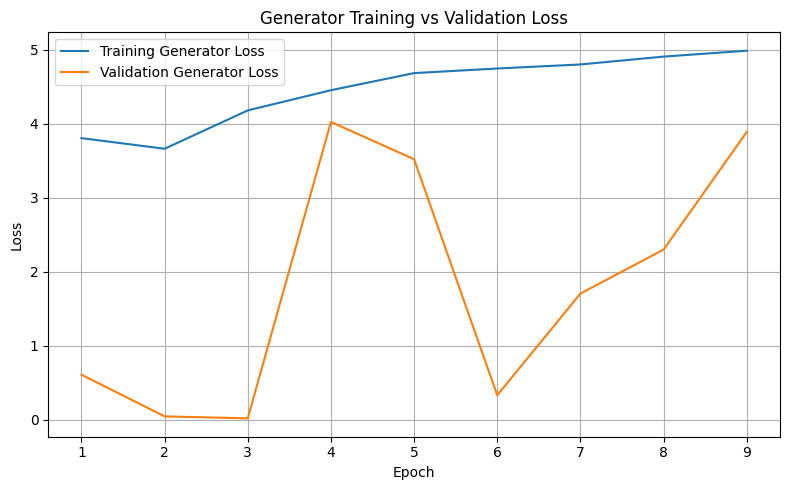

In [9]:
# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_g_losses) + 1), train_g_losses, label='Training Generator Loss')
plt.plot(range(1, len(val_g_losses) + 1), val_g_losses, label='Validation Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gan_outputs/loss_plot.png")
plt.show()

In [10]:
# Generate final images using best generator
os.makedirs("gan_outputs/generated", exist_ok=True)
G.load_state_dict(torch.load("gan_outputs/best_generator.pth"))
G.eval()
with torch.no_grad():
    for i in tqdm(range(0, 10000, 64), desc="Generating final images"):
        z = torch.randn(64, z_dim, 1, 1, device=device)
        gen_imgs = G(z)
        for j in range(gen_imgs.size(0)):
            save_image(gen_imgs[j], f"gan_outputs/generated/{i + j:05d}.png", normalize=True)

Generating final images:   0%|          | 0/157 [00:00<?, ?it/s]

Generating final images:   1%|          | 1/157 [00:00<00:36,  4.33it/s]

Generating final images:   1%|▏         | 2/157 [00:00<00:36,  4.28it/s]

Generating final images:   2%|▏         | 3/157 [00:00<00:35,  4.32it/s]

Generating final images:   3%|▎         | 4/157 [00:00<00:35,  4.30it/s]

Generating final images:   3%|▎         | 5/157 [00:01<00:32,  4.62it/s]

Generating final images:   4%|▍         | 6/157 [00:01<00:32,  4.70it/s]

Generating final images:   4%|▍         | 7/157 [00:01<00:30,  4.91it/s]

Generating final images:   5%|▌         | 8/157 [00:01<00:31,  4.75it/s]

Generating final images:   6%|▌         | 9/157 [00:01<00:30,  4.88it/s]

Generating final images:   6%|▋         | 10/157 [00:02<00:30,  4.90it/s]

Generating final images:   7%|▋         | 11/157 [00:02<00:29,  4.98it/s]

Generating final images:   8%|▊         | 12/157 [00:02<00:29,  4.96it/s]

Generating final images:   8%|▊         | 13/157 [00:02<00:28,  5.02it/s]

Generating final images:   9%|▉         | 14/157 [00:02<00:28,  5.07it/s]

Generating final images:  10%|▉         | 15/157 [00:03<00:28,  5.04it/s]

Generating final images:  10%|█         | 16/157 [00:03<00:27,  5.10it/s]

Generating final images:  11%|█         | 17/157 [00:03<00:27,  5.11it/s]

Generating final images:  11%|█▏        | 18/157 [00:03<00:26,  5.21it/s]

Generating final images:  12%|█▏        | 19/157 [00:03<00:26,  5.12it/s]

Generating final images:  13%|█▎        | 20/157 [00:04<00:26,  5.14it/s]

Generating final images:  13%|█▎        | 21/157 [00:04<00:34,  3.96it/s]

Generating final images:  14%|█▍        | 22/157 [00:04<00:32,  4.17it/s]

Generating final images:  15%|█▍        | 23/157 [00:04<00:30,  4.38it/s]

Generating final images:  15%|█▌        | 24/157 [00:05<00:29,  4.54it/s]

Generating final images:  16%|█▌        | 25/157 [00:05<00:27,  4.74it/s]

Generating final images:  17%|█▋        | 26/157 [00:05<00:26,  4.89it/s]

Generating final images:  17%|█▋        | 27/157 [00:05<00:25,  5.03it/s]

Generating final images:  18%|█▊        | 28/157 [00:05<00:25,  5.11it/s]

Generating final images:  18%|█▊        | 29/157 [00:06<00:24,  5.15it/s]

Generating final images:  19%|█▉        | 30/157 [00:06<00:24,  5.18it/s]

Generating final images:  20%|█▉        | 31/157 [00:06<00:23,  5.28it/s]

Generating final images:  20%|██        | 32/157 [00:06<00:24,  5.18it/s]

Generating final images:  21%|██        | 33/157 [00:06<00:24,  5.17it/s]

Generating final images:  22%|██▏       | 34/157 [00:07<00:25,  4.85it/s]

Generating final images:  22%|██▏       | 35/157 [00:07<00:26,  4.57it/s]

Generating final images:  23%|██▎       | 36/157 [00:07<00:25,  4.68it/s]

Generating final images:  24%|██▎       | 37/157 [00:07<00:25,  4.80it/s]

Generating final images:  24%|██▍       | 38/157 [00:07<00:24,  4.96it/s]

Generating final images:  25%|██▍       | 39/157 [00:08<00:23,  4.96it/s]

Generating final images:  25%|██▌       | 40/157 [00:08<00:23,  5.07it/s]

Generating final images:  26%|██▌       | 41/157 [00:08<00:22,  5.06it/s]

Generating final images:  27%|██▋       | 42/157 [00:08<00:22,  5.02it/s]

Generating final images:  27%|██▋       | 43/157 [00:08<00:22,  5.13it/s]

Generating final images:  28%|██▊       | 44/157 [00:09<00:22,  5.08it/s]

Generating final images:  29%|██▊       | 45/157 [00:09<00:22,  4.93it/s]

Generating final images:  29%|██▉       | 46/157 [00:09<00:22,  4.92it/s]

Generating final images:  30%|██▉       | 47/157 [00:09<00:22,  4.80it/s]

Generating final images:  31%|███       | 48/157 [00:09<00:25,  4.22it/s]

Generating final images:  31%|███       | 49/157 [00:10<00:24,  4.45it/s]

Generating final images:  32%|███▏      | 50/157 [00:10<00:22,  4.68it/s]

Generating final images:  32%|███▏      | 51/157 [00:10<00:22,  4.79it/s]

Generating final images:  33%|███▎      | 52/157 [00:10<00:21,  4.93it/s]

Generating final images:  34%|███▍      | 53/157 [00:10<00:21,  4.95it/s]

Generating final images:  34%|███▍      | 54/157 [00:11<00:20,  5.09it/s]

Generating final images:  35%|███▌      | 55/157 [00:11<00:19,  5.20it/s]

Generating final images:  36%|███▌      | 56/157 [00:11<00:19,  5.11it/s]

Generating final images:  36%|███▋      | 57/157 [00:11<00:19,  5.13it/s]

Generating final images:  37%|███▋      | 58/157 [00:11<00:19,  5.10it/s]

Generating final images:  38%|███▊      | 59/157 [00:12<00:19,  5.03it/s]

Generating final images:  38%|███▊      | 60/157 [00:12<00:19,  4.96it/s]

Generating final images:  39%|███▉      | 61/157 [00:12<00:19,  4.99it/s]

Generating final images:  39%|███▉      | 62/157 [00:12<00:21,  4.49it/s]

Generating final images:  40%|████      | 63/157 [00:13<00:20,  4.55it/s]

Generating final images:  41%|████      | 64/157 [00:13<00:20,  4.57it/s]

Generating final images:  41%|████▏     | 65/157 [00:13<00:20,  4.55it/s]

Generating final images:  42%|████▏     | 66/157 [00:13<00:21,  4.20it/s]

Generating final images:  43%|████▎     | 67/157 [00:13<00:21,  4.22it/s]

Generating final images:  43%|████▎     | 68/157 [00:14<00:21,  4.12it/s]

Generating final images:  44%|████▍     | 69/157 [00:14<00:20,  4.27it/s]

Generating final images:  45%|████▍     | 70/157 [00:14<00:19,  4.50it/s]

Generating final images:  45%|████▌     | 71/157 [00:14<00:18,  4.65it/s]

Generating final images:  46%|████▌     | 72/157 [00:15<00:17,  4.75it/s]

Generating final images:  46%|████▋     | 73/157 [00:15<00:17,  4.91it/s]

Generating final images:  47%|████▋     | 74/157 [00:15<00:16,  5.00it/s]

Generating final images:  48%|████▊     | 75/157 [00:15<00:16,  5.02it/s]

Generating final images:  48%|████▊     | 76/157 [00:15<00:16,  5.02it/s]

Generating final images:  49%|████▉     | 77/157 [00:16<00:16,  4.99it/s]

Generating final images:  50%|████▉     | 78/157 [00:16<00:15,  5.01it/s]

Generating final images:  50%|█████     | 79/157 [00:16<00:15,  5.05it/s]

Generating final images:  51%|█████     | 80/157 [00:16<00:15,  5.08it/s]

Generating final images:  52%|█████▏    | 81/157 [00:16<00:15,  4.99it/s]

Generating final images:  52%|█████▏    | 82/157 [00:16<00:14,  5.27it/s]

Generating final images:  53%|█████▎    | 83/157 [00:17<00:13,  5.42it/s]

Generating final images:  54%|█████▎    | 84/157 [00:17<00:13,  5.48it/s]

Generating final images:  54%|█████▍    | 85/157 [00:17<00:13,  5.52it/s]

Generating final images:  55%|█████▍    | 86/157 [00:17<00:12,  5.51it/s]

Generating final images:  55%|█████▌    | 87/157 [00:17<00:12,  5.57it/s]

Generating final images:  56%|█████▌    | 88/157 [00:18<00:12,  5.49it/s]

Generating final images:  57%|█████▋    | 89/157 [00:18<00:12,  5.51it/s]

Generating final images:  57%|█████▋    | 90/157 [00:18<00:12,  5.50it/s]

Generating final images:  58%|█████▊    | 91/157 [00:18<00:12,  5.44it/s]

Generating final images:  59%|█████▊    | 92/157 [00:18<00:12,  5.40it/s]

Generating final images:  59%|█████▉    | 93/157 [00:18<00:11,  5.34it/s]

Generating final images:  60%|█████▉    | 94/157 [00:19<00:11,  5.36it/s]

Generating final images:  61%|██████    | 95/157 [00:19<00:12,  4.98it/s]

Generating final images:  61%|██████    | 96/157 [00:19<00:11,  5.27it/s]

Generating final images:  62%|██████▏   | 97/157 [00:19<00:11,  5.33it/s]

Generating final images:  62%|██████▏   | 98/157 [00:19<00:11,  5.34it/s]

Generating final images:  63%|██████▎   | 99/157 [00:20<00:10,  5.45it/s]

Generating final images:  64%|██████▎   | 100/157 [00:20<00:10,  5.56it/s]

Generating final images:  64%|██████▍   | 101/157 [00:20<00:09,  5.71it/s]

Generating final images:  65%|██████▍   | 102/157 [00:20<00:09,  5.74it/s]

Generating final images:  66%|██████▌   | 103/157 [00:20<00:09,  5.73it/s]

Generating final images:  66%|██████▌   | 104/157 [00:20<00:09,  5.77it/s]

Generating final images:  67%|██████▋   | 105/157 [00:21<00:09,  5.73it/s]

Generating final images:  68%|██████▊   | 106/157 [00:21<00:08,  5.71it/s]

Generating final images:  68%|██████▊   | 107/157 [00:21<00:08,  5.64it/s]

Generating final images:  69%|██████▉   | 108/157 [00:21<00:11,  4.44it/s]

Generating final images:  69%|██████▉   | 109/157 [00:21<00:09,  5.08it/s]

Generating final images:  70%|███████   | 110/157 [00:22<00:08,  5.59it/s]

Generating final images:  71%|███████   | 111/157 [00:22<00:07,  6.10it/s]

Generating final images:  71%|███████▏  | 112/157 [00:22<00:06,  6.48it/s]

Generating final images:  72%|███████▏  | 113/157 [00:22<00:06,  6.76it/s]

Generating final images:  73%|███████▎  | 114/157 [00:22<00:06,  7.02it/s]

Generating final images:  73%|███████▎  | 115/157 [00:22<00:05,  7.20it/s]

Generating final images:  74%|███████▍  | 116/157 [00:22<00:05,  7.38it/s]

Generating final images:  75%|███████▍  | 117/157 [00:23<00:05,  7.43it/s]

Generating final images:  75%|███████▌  | 118/157 [00:23<00:05,  7.49it/s]

Generating final images:  76%|███████▌  | 119/157 [00:23<00:05,  7.52it/s]

Generating final images:  76%|███████▋  | 120/157 [00:23<00:05,  7.04it/s]

Generating final images:  77%|███████▋  | 121/157 [00:23<00:05,  6.41it/s]

Generating final images:  78%|███████▊  | 122/157 [00:23<00:05,  6.21it/s]

Generating final images:  78%|███████▊  | 123/157 [00:23<00:05,  6.14it/s]

Generating final images:  79%|███████▉  | 124/157 [00:24<00:05,  5.98it/s]

Generating final images:  80%|███████▉  | 125/157 [00:24<00:05,  5.48it/s]

Generating final images:  80%|████████  | 126/157 [00:24<00:05,  5.43it/s]

Generating final images:  81%|████████  | 127/157 [00:24<00:05,  5.57it/s]

Generating final images:  82%|████████▏ | 128/157 [00:24<00:04,  6.00it/s]

Generating final images:  82%|████████▏ | 129/157 [00:24<00:04,  6.39it/s]

Generating final images:  83%|████████▎ | 130/157 [00:25<00:04,  6.61it/s]

Generating final images:  83%|████████▎ | 131/157 [00:25<00:03,  6.80it/s]

Generating final images:  84%|████████▍ | 132/157 [00:25<00:03,  6.93it/s]

Generating final images:  85%|████████▍ | 133/157 [00:25<00:03,  6.91it/s]

Generating final images:  85%|████████▌ | 134/157 [00:25<00:03,  7.02it/s]

Generating final images:  86%|████████▌ | 135/157 [00:25<00:03,  7.23it/s]

Generating final images:  87%|████████▋ | 136/157 [00:25<00:02,  7.36it/s]

Generating final images:  87%|████████▋ | 137/157 [00:26<00:02,  7.41it/s]

Generating final images:  88%|████████▊ | 138/157 [00:26<00:02,  7.45it/s]

Generating final images:  89%|████████▊ | 139/157 [00:26<00:02,  7.49it/s]

Generating final images:  89%|████████▉ | 140/157 [00:26<00:02,  7.56it/s]

Generating final images:  90%|████████▉ | 141/157 [00:26<00:02,  7.56it/s]

Generating final images:  90%|█████████ | 142/157 [00:26<00:01,  7.61it/s]

Generating final images:  91%|█████████ | 143/157 [00:26<00:01,  7.62it/s]

Generating final images:  92%|█████████▏| 144/157 [00:26<00:01,  7.59it/s]

Generating final images:  92%|█████████▏| 145/157 [00:27<00:01,  7.58it/s]

Generating final images:  93%|█████████▎| 146/157 [00:27<00:01,  7.59it/s]

Generating final images:  94%|█████████▎| 147/157 [00:27<00:01,  7.64it/s]

Generating final images:  94%|█████████▍| 148/157 [00:27<00:01,  7.58it/s]

Generating final images:  95%|█████████▍| 149/157 [00:27<00:01,  6.81it/s]

Generating final images:  96%|█████████▌| 150/157 [00:27<00:01,  6.66it/s]

Generating final images:  96%|█████████▌| 151/157 [00:27<00:00,  6.88it/s]

Generating final images:  97%|█████████▋| 152/157 [00:28<00:00,  7.06it/s]

Generating final images:  97%|█████████▋| 153/157 [00:28<00:00,  7.24it/s]

Generating final images:  98%|█████████▊| 154/157 [00:28<00:00,  7.37it/s]

Generating final images:  99%|█████████▊| 155/157 [00:28<00:00,  6.70it/s]

Generating final images:  99%|█████████▉| 156/157 [00:28<00:00,  6.92it/s]

Generating final images: 100%|██████████| 157/157 [00:29<00:00,  4.50it/s]

Generating final images: 100%|██████████| 157/157 [00:29<00:00,  5.40it/s]